In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [7]:
import sys
print(sys.path)


['c:\\Users\\clayton\\Documents\\GitHub\\stuff-baby\\clayton\\breaking_ball', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\clayton\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages', 'C:\\Users\\clayton\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32', 'C:\\Users\\clayton\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32\\lib',

In [8]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [9]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [10]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [11]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.drop(columns = ['spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9'], axis = 1)

    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
        
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Sort the DataFrame
        df_sorted = df.sort_values(by=['game_pk', 'pitcher', 'pitch_type_condensed', 'pitch_number'])

        # Calculate rolling average of release_speed for the last 5 pitches
        df_sorted['rolling_avg_velo'] = df_sorted.groupby(['game_pk', 'pitcher', 'pitch_type_condensed'])['release_speed'].transform(lambda x: x.rolling(5, min_periods=1).mean())

        # Calculate seasonal average for each pitcher and pitch type
        seasonal_avg = df.groupby(['pitcher', 'pitch_type_condensed'])['release_speed'].mean().reset_index()
        seasonal_avg = seasonal_avg.rename(columns={'release_speed': 'seasonal_avg_velo'})

        # Merge seasonal average back to the original DataFrame
        df_merged = df_sorted.merge(seasonal_avg, on=['pitcher', 'pitch_type_condensed'], how='left')

        # If rolling average is NaN, use the seasonal average
        df_merged['rolling_avg_velo'].fillna(df_merged['seasonal_avg_velo'], inplace=True)

        return df_merged
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    # Define a function to determine if the pitch resulted in a fly ball

    def is_fly_ball(bb_type):
        return 1 if (bb_type == "fly_ball" | bb_type == 'popup') else 0
    
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0

    def is_line_drive(bb_type):
        return 1 if bb_type == "line_drive" else 0
    
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0
    
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0

    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
        #create a function for whiffs
    def whiff(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", "missed_bunt", "swinging_pitchout"] else 0
    
    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    df['swing'] = df['description'].apply(is_swing)

    df['whiff'] = df['description'].apply(whiff)

    df['contact'] = df['description'].apply(is_contact)

    df['foul'] = df['description'].apply(is_foul)

    df['fly_ball'] = df['bb_type'].apply(is_fly_ball)

    df['ground_ball'] = df['bb_type'].apply(is_ground_ball)

    df['line_drive'] = df['bb_type'].apply(is_line_drive)

    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    return df

In [12]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('swing == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [13]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [14]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

KeyError: "['strike'] not found in axis"

In [ ]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [ ]:
y_train.value_counts()

whiff
0    97015
1    21827
Name: count, dtype: int64

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.671185157137448
Log Loss: 0.6528571282644238


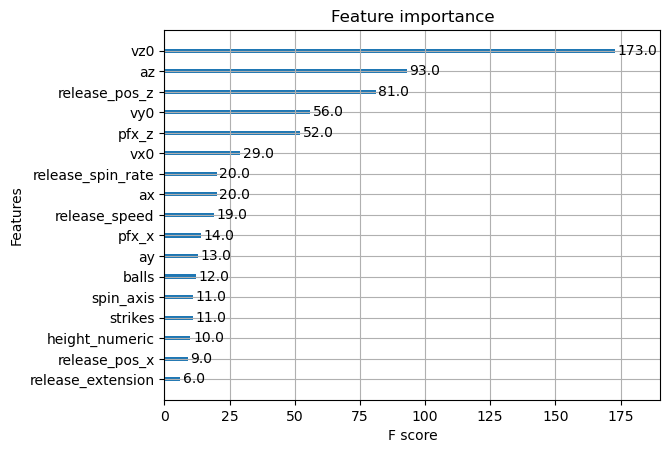

In [ ]:
xgb.plot_importance(model)
plt.show()

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [39615, 811776]

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:50:38,983] A new study created in memory with name: no-name-730548d5-fe4c-4ebf-bd6f-c2065085474f


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.63971
[6]	eval-logloss:0.63479
[7]	eval-logloss:0.63284
[8]	eval-logloss:0.62927
[9]	eval-logloss:0.62638
[10]	eval-logloss:0.62263
[11]	eval-logloss:0.61926
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61567
[14]	eval-logloss:0.61340
[15]	eval-logloss:0.61180
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.60832
[18]	eval-logloss:0.60611
[19]	eval-logloss:0.60492
[20]	eval-logloss:0.60424
[21]	eval-logloss:0.60392
[22]	eval-logloss:0.60277
[23]	eval-logloss:0.60241
[24]	eval-logloss:0.60087
[25]	eval-logloss:0.60121
[26]	eval-logloss:0.60042
[27]	eval-logloss:0.59975
[28]	eval-logloss:0.59886
[29]	eval-logloss:0.59882
[30]	eval-logloss:0.59786
[31]	eval-logloss:0.59718
[32]	eval-logloss:0.59591
[33]	eval-logloss:0.59538
[34]	eval-logloss:0.59462
[35]	eval-logloss:0.59429
[36]	eval-logloss:0.59349
[37]	eval-logloss:0.59248
[38]	eval-logloss:0.59

[I 2023-11-12 12:51:17,362] Trial 0 finished with value: 0.5621694361911962 and parameters: {'max_depth': 9, 'eta': 0.1690123074241139, 'subsample': 0.6970105025194272, 'colsample_bytree': 0.5941087951306698}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.66311
[2]	eval-logloss:0.65239
[3]	eval-logloss:0.64210
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62789
[8]	eval-logloss:0.62545
[9]	eval-logloss:0.62444
[10]	eval-logloss:0.62254
[11]	eval-logloss:0.62020
[12]	eval-logloss:0.61811
[13]	eval-logloss:0.61756
[14]	eval-logloss:0.61452
[15]	eval-logloss:0.61241
[16]	eval-logloss:0.61225
[17]	eval-logloss:0.60927
[18]	eval-logloss:0.60793
[19]	eval-logloss:0.60781
[20]	eval-logloss:0.60753
[21]	eval-logloss:0.60859
[22]	eval-logloss:0.60730
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60630
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60426
[31]	eval-logloss:0.60250
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60249
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60253
[36]	eval-logloss:0.60245
[37]	eval-logloss:0.60091
[38]	eval-logloss:0.59

[I 2023-11-12 12:51:46,790] Trial 1 finished with value: 0.5792521753304959 and parameters: {'max_depth': 8, 'eta': 0.28661915215187295, 'subsample': 0.6035866630697386, 'colsample_bytree': 0.5684323444875934}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66179
[3]	eval-logloss:0.65263
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63977
[7]	eval-logloss:0.63819
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63351
[10]	eval-logloss:0.63094
[11]	eval-logloss:0.62904
[12]	eval-logloss:0.62682
[13]	eval-logloss:0.62518
[14]	eval-logloss:0.62343
[15]	eval-logloss:0.62242
[16]	eval-logloss:0.62189
[17]	eval-logloss:0.61974
[18]	eval-logloss:0.61865
[19]	eval-logloss:0.61789
[20]	eval-logloss:0.61730
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61587
[23]	eval-logloss:0.61500
[24]	eval-logloss:0.61427
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61382
[27]	eval-logloss:0.61287
[28]	eval-logloss:0.61224
[29]	eval-logloss:0.61185
[30]	eval-logloss:0.61145
[31]	eval-logloss:0.61079
[32]	eval-logloss:0.61046
[33]	eval-logloss:0.61002
[34]	eval-logloss:0.60914
[35]	eval-logloss:0.60876
[36]	eval-logloss:0.60848
[37]	eval-logloss:0.60785
[38]	eval-logloss:0.60

[I 2023-11-12 12:51:56,219] Trial 2 finished with value: 0.5861194421516086 and parameters: {'max_depth': 7, 'eta': 0.24659425184752315, 'subsample': 0.8977737987504228, 'colsample_bytree': 0.5843234765243891}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.65620
[6]	eval-logloss:0.65482
[7]	eval-logloss:0.65181
[8]	eval-logloss:0.64995
[9]	eval-logloss:0.64909
[10]	eval-logloss:0.64839
[11]	eval-logloss:0.64785
[12]	eval-logloss:0.64644
[13]	eval-logloss:0.64611
[14]	eval-logloss:0.64408
[15]	eval-logloss:0.64268
[16]	eval-logloss:0.64289
[17]	eval-logloss:0.64129
[18]	eval-logloss:0.63967
[19]	eval-logloss:0.63973
[20]	eval-logloss:0.63889
[21]	eval-logloss:0.63901
[22]	eval-logloss:0.63793
[23]	eval-logloss:0.63786
[24]	eval-logloss:0.63607
[25]	eval-logloss:0.63610
[26]	eval-logloss:0.63571
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63513
[29]	eval-logloss:0.63475
[30]	eval-logloss:0.63414
[31]	eval-logloss:0.63338
[32]	eval-logloss:0.63273
[33]	eval-logloss:0.63228
[34]	eval-logloss:0.63243
[35]	eval-logloss:0.63195
[36]	eval-logloss:0.63169
[37]	eval-logloss:0.63114
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:01,619] Trial 3 finished with value: 0.6181294936196907 and parameters: {'max_depth': 4, 'eta': 0.25376285348374134, 'subsample': 0.6938247470998273, 'colsample_bytree': 0.89491706004447}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67212
[3]	eval-logloss:0.66693
[4]	eval-logloss:0.66526
[5]	eval-logloss:0.66115
[6]	eval-logloss:0.65848
[7]	eval-logloss:0.65722
[8]	eval-logloss:0.65372
[9]	eval-logloss:0.65158
[10]	eval-logloss:0.65061
[11]	eval-logloss:0.64850
[12]	eval-logloss:0.64731
[13]	eval-logloss:0.64652
[14]	eval-logloss:0.64537
[15]	eval-logloss:0.64480
[16]	eval-logloss:0.64433
[17]	eval-logloss:0.64362
[18]	eval-logloss:0.64240
[19]	eval-logloss:0.64242
[20]	eval-logloss:0.64206
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.64108
[23]	eval-logloss:0.64051
[24]	eval-logloss:0.64000
[25]	eval-logloss:0.64023
[26]	eval-logloss:0.63895
[27]	eval-logloss:0.63774
[28]	eval-logloss:0.63734
[29]	eval-logloss:0.63708
[30]	eval-logloss:0.63668
[31]	eval-logloss:0.63641
[32]	eval-logloss:0.63598
[33]	eval-logloss:0.63518
[34]	eval-logloss:0.63492
[35]	eval-logloss:0.63457
[36]	eval-logloss:0.63457
[37]	eval-logloss:0.63419
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:07,265] Trial 4 finished with value: 0.6217280213457194 and parameters: {'max_depth': 4, 'eta': 0.19686197176437872, 'subsample': 0.8663328237127571, 'colsample_bytree': 0.673144642163745}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64574
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63932
[7]	eval-logloss:0.63609
[8]	eval-logloss:0.63286
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.62920
[11]	eval-logloss:0.62758
[12]	eval-logloss:0.62590
[13]	eval-logloss:0.62495
[14]	eval-logloss:0.62336
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.62047
[18]	eval-logloss:0.61923
[19]	eval-logloss:0.61829
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61716
[22]	eval-logloss:0.61616
[23]	eval-logloss:0.61529
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61472
[26]	eval-logloss:0.61437
[27]	eval-logloss:0.61374
[28]	eval-logloss:0.61268
[29]	eval-logloss:0.61197
[30]	eval-logloss:0.61155
[31]	eval-logloss:0.61124
[32]	eval-logloss:0.61071
[33]	eval-logloss:0.61033
[34]	eval-logloss:0.60937
[35]	eval-logloss:0.60876
[36]	eval-logloss:0.60799
[37]	eval-logloss:0.60736
[38]	eval-logloss:0.60

[I 2023-11-12 12:52:15,577] Trial 5 finished with value: 0.5874319833352654 and parameters: {'max_depth': 7, 'eta': 0.20440621899899164, 'subsample': 0.8957461195336388, 'colsample_bytree': 0.852661610979492}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65570
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.63742
[9]	eval-logloss:0.63557
[10]	eval-logloss:0.63416
[11]	eval-logloss:0.63230
[12]	eval-logloss:0.63069
[13]	eval-logloss:0.62950
[14]	eval-logloss:0.62760
[15]	eval-logloss:0.62608
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62415
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.62269
[20]	eval-logloss:0.62206
[21]	eval-logloss:0.62152
[22]	eval-logloss:0.62086
[23]	eval-logloss:0.62038
[24]	eval-logloss:0.61950
[25]	eval-logloss:0.61950
[26]	eval-logloss:0.61869
[27]	eval-logloss:0.61828
[28]	eval-logloss:0.61743
[29]	eval-logloss:0.61725
[30]	eval-logloss:0.61650
[31]	eval-logloss:0.61610
[32]	eval-logloss:0.61513
[33]	eval-logloss:0.61468
[34]	eval-logloss:0.61445
[35]	eval-logloss:0.61412
[36]	eval-logloss:0.61361
[37]	eval-logloss:0.61306
[38]	eval-logloss:0.61

[I 2023-11-12 12:52:24,393] Trial 6 finished with value: 0.5910342968027379 and parameters: {'max_depth': 7, 'eta': 0.16268354043285646, 'subsample': 0.7949957335526231, 'colsample_bytree': 0.8651729053524477}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68301
[8]	eval-logloss:0.68194
[9]	eval-logloss:0.68076
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.67880
[12]	eval-logloss:0.67769
[13]	eval-logloss:0.67677
[14]	eval-logloss:0.67589
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67493
[17]	eval-logloss:0.67409
[18]	eval-logloss:0.67324
[19]	eval-logloss:0.67259
[20]	eval-logloss:0.67167
[21]	eval-logloss:0.67142
[22]	eval-logloss:0.67070
[23]	eval-logloss:0.66984
[24]	eval-logloss:0.66917
[25]	eval-logloss:0.66896
[26]	eval-logloss:0.66835
[27]	eval-logloss:0.66759
[28]	eval-logloss:0.66737
[29]	eval-logloss:0.66667
[30]	eval-logloss:0.66598
[31]	eval-logloss:0.66535
[32]	eval-logloss:0.66468
[33]	eval-logloss:0.66421
[34]	eval-logloss:0.66365
[35]	eval-logloss:0.66302
[36]	eval-logloss:0.66256
[37]	eval-logloss:0.66212
[38]	eval-logloss:0.66

[I 2023-11-12 12:52:30,157] Trial 7 finished with value: 0.647045447427094 and parameters: {'max_depth': 4, 'eta': 0.027810667310659606, 'subsample': 0.8686236055458808, 'colsample_bytree': 0.8710542925392428}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68415
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67765
[4]	eval-logloss:0.67410
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66898
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66478
[9]	eval-logloss:0.66343
[10]	eval-logloss:0.66233
[11]	eval-logloss:0.66079
[12]	eval-logloss:0.65956
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65572
[17]	eval-logloss:0.65482
[18]	eval-logloss:0.65331
[19]	eval-logloss:0.65233
[20]	eval-logloss:0.65160
[21]	eval-logloss:0.65146
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.65003
[24]	eval-logloss:0.64889
[25]	eval-logloss:0.64875
[26]	eval-logloss:0.64836
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64739
[29]	eval-logloss:0.64703
[30]	eval-logloss:0.64654
[31]	eval-logloss:0.64613
[32]	eval-logloss:0.64536
[33]	eval-logloss:0.64480
[34]	eval-logloss:0.64450
[35]	eval-logloss:0.64430
[36]	eval-logloss:0.64398
[37]	eval-logloss:0.64368
[38]	eval-logloss:0.64

[I 2023-11-12 12:52:35,836] Trial 8 finished with value: 0.6292487706149419 and parameters: {'max_depth': 4, 'eta': 0.09699776792674031, 'subsample': 0.7130026910506787, 'colsample_bytree': 0.8734690231679765}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.65681
[4]	eval-logloss:0.65420
[5]	eval-logloss:0.64752
[6]	eval-logloss:0.64389
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.63969
[9]	eval-logloss:0.63744
[10]	eval-logloss:0.63471
[11]	eval-logloss:0.63216
[12]	eval-logloss:0.63038
[13]	eval-logloss:0.62994
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62689
[16]	eval-logloss:0.62669
[17]	eval-logloss:0.62444
[18]	eval-logloss:0.62273
[19]	eval-logloss:0.62190
[20]	eval-logloss:0.62088
[21]	eval-logloss:0.62114
[22]	eval-logloss:0.61993
[23]	eval-logloss:0.61984
[24]	eval-logloss:0.61873
[25]	eval-logloss:0.61916
[26]	eval-logloss:0.61873
[27]	eval-logloss:0.61796
[28]	eval-logloss:0.61763
[29]	eval-logloss:0.61786
[30]	eval-logloss:0.61706
[31]	eval-logloss:0.61652
[32]	eval-logloss:0.61602
[33]	eval-logloss:0.61545
[34]	eval-logloss:0.61467
[35]	eval-logloss:0.61423
[36]	eval-logloss:0.61387
[37]	eval-logloss:0.61295
[38]	eval-logloss:0.61

[I 2023-11-12 12:52:44,769] Trial 9 finished with value: 0.5928353625822731 and parameters: {'max_depth': 7, 'eta': 0.19363234503886553, 'subsample': 0.6606164576529003, 'colsample_bytree': 0.6061603275718729}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.67639
[3]	eval-logloss:0.66733
[4]	eval-logloss:0.66443
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64972
[8]	eval-logloss:0.64801
[9]	eval-logloss:0.64682
[10]	eval-logloss:0.64209
[11]	eval-logloss:0.63790
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63273
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62828
[16]	eval-logloss:0.62632
[17]	eval-logloss:0.62275
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61747
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61626
[22]	eval-logloss:0.61479
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61216
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60864
[29]	eval-logloss:0.60823
[30]	eval-logloss:0.60784
[31]	eval-logloss:0.60671
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60467
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60205
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60

[I 2023-11-12 12:52:56,534] Trial 10 finished with value: 0.570990516162489 and parameters: {'max_depth': 9, 'eta': 0.11264290837871291, 'subsample': 0.7751477673543432, 'colsample_bytree': 0.5045342184101927}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.67594
[3]	eval-logloss:0.66660
[4]	eval-logloss:0.66359
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64671
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64068
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.63169
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62694
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.61872
[19]	eval-logloss:0.61659
[20]	eval-logloss:0.61600
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61427
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61195
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.61041
[27]	eval-logloss:0.60881
[28]	eval-logloss:0.60812
[29]	eval-logloss:0.60756
[30]	eval-logloss:0.60677
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60452
[33]	eval-logloss:0.60382
[34]	eval-logloss:0.60239
[35]	eval-logloss:0.60131
[36]	eval-logloss:0.60115
[37]	eval-logloss:0.60058
[38]	eval-logloss:0.59

[I 2023-11-12 12:53:06,641] Trial 11 finished with value: 0.5717311067711447 and parameters: {'max_depth': 9, 'eta': 0.11768746892333938, 'subsample': 0.7772858388901266, 'colsample_bytree': 0.5265362366035251}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68311
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66252
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64682
[8]	eval-logloss:0.64488
[9]	eval-logloss:0.64372
[10]	eval-logloss:0.63871
[11]	eval-logloss:0.63450
[12]	eval-logloss:0.63078
[13]	eval-logloss:0.62966
[14]	eval-logloss:0.62677
[15]	eval-logloss:0.62527
[16]	eval-logloss:0.62348
[17]	eval-logloss:0.62033
[18]	eval-logloss:0.61747
[19]	eval-logloss:0.61503
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61270
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60957
[26]	eval-logloss:0.60841
[27]	eval-logloss:0.60673
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60295
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60130
[35]	eval-logloss:0.60039
[36]	eval-logloss:0.60008
[37]	eval-logloss:0.59950
[38]	eval-logloss:0.59

[I 2023-11-12 12:53:16,137] Trial 12 finished with value: 0.5697153562978888 and parameters: {'max_depth': 9, 'eta': 0.12035053892274378, 'subsample': 0.7548289344507022, 'colsample_bytree': 0.5012227636553211}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66092
[3]	eval-logloss:0.65204
[4]	eval-logloss:0.64858
[5]	eval-logloss:0.64182
[6]	eval-logloss:0.63743
[7]	eval-logloss:0.63486
[8]	eval-logloss:0.62982
[9]	eval-logloss:0.62642
[10]	eval-logloss:0.62341
[11]	eval-logloss:0.62106
[12]	eval-logloss:0.61867
[13]	eval-logloss:0.61588
[14]	eval-logloss:0.61363
[15]	eval-logloss:0.61182
[16]	eval-logloss:0.61103
[17]	eval-logloss:0.60845
[18]	eval-logloss:0.60619
[19]	eval-logloss:0.60519
[20]	eval-logloss:0.60419
[21]	eval-logloss:0.60390
[22]	eval-logloss:0.60286
[23]	eval-logloss:0.60206
[24]	eval-logloss:0.60085
[25]	eval-logloss:0.60046
[26]	eval-logloss:0.59963
[27]	eval-logloss:0.59897
[28]	eval-logloss:0.59754
[29]	eval-logloss:0.59730
[30]	eval-logloss:0.59651
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59514
[33]	eval-logloss:0.59430
[34]	eval-logloss:0.59373
[35]	eval-logloss:0.59316
[36]	eval-logloss:0.59257
[37]	eval-logloss:0.59209
[38]	eval-logloss:0.59

[I 2023-11-12 12:53:25,779] Trial 13 finished with value: 0.5628077475462491 and parameters: {'max_depth': 9, 'eta': 0.15001666074656042, 'subsample': 0.7323285527672146, 'colsample_bytree': 0.6743518186893684}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65584
[4]	eval-logloss:0.65304
[5]	eval-logloss:0.64705
[6]	eval-logloss:0.64314
[7]	eval-logloss:0.64117
[8]	eval-logloss:0.63641
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63045
[11]	eval-logloss:0.62824
[12]	eval-logloss:0.62635
[13]	eval-logloss:0.62447
[14]	eval-logloss:0.62220
[15]	eval-logloss:0.62073
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61577
[19]	eval-logloss:0.61442
[20]	eval-logloss:0.61377
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61282
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.61027
[27]	eval-logloss:0.60957
[28]	eval-logloss:0.60840
[29]	eval-logloss:0.60826
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60600
[33]	eval-logloss:0.60517
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60391
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60264
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:34,482] Trial 14 finished with value: 0.5801889158714695 and parameters: {'max_depth': 8, 'eta': 0.15652047328640128, 'subsample': 0.7185214206081063, 'colsample_bytree': 0.7056287730376611}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.67934
[4]	eval-logloss:0.67786
[5]	eval-logloss:0.67421
[6]	eval-logloss:0.67143
[7]	eval-logloss:0.67026
[8]	eval-logloss:0.66725
[9]	eval-logloss:0.66538
[10]	eval-logloss:0.66339
[11]	eval-logloss:0.66086
[12]	eval-logloss:0.65867
[13]	eval-logloss:0.65639
[14]	eval-logloss:0.65452
[15]	eval-logloss:0.65363
[16]	eval-logloss:0.65279
[17]	eval-logloss:0.65060
[18]	eval-logloss:0.64894
[19]	eval-logloss:0.64767
[20]	eval-logloss:0.64705
[21]	eval-logloss:0.64684
[22]	eval-logloss:0.64516
[23]	eval-logloss:0.64496
[24]	eval-logloss:0.64339
[25]	eval-logloss:0.64323
[26]	eval-logloss:0.64221
[27]	eval-logloss:0.64105
[28]	eval-logloss:0.64055
[29]	eval-logloss:0.64043
[30]	eval-logloss:0.64005
[31]	eval-logloss:0.63941
[32]	eval-logloss:0.63831
[33]	eval-logloss:0.63748
[34]	eval-logloss:0.63668
[35]	eval-logloss:0.63616
[36]	eval-logloss:0.63586
[37]	eval-logloss:0.63555
[38]	eval-logloss:0.63

[I 2023-11-12 12:53:40,860] Trial 15 finished with value: 0.6178466035717216 and parameters: {'max_depth': 6, 'eta': 0.07007085778207357, 'subsample': 0.678591965629227, 'colsample_bytree': 0.6565556195390023}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65132
[6]	eval-logloss:0.64840
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64348
[9]	eval-logloss:0.64159
[10]	eval-logloss:0.64064
[11]	eval-logloss:0.63894
[12]	eval-logloss:0.63768
[13]	eval-logloss:0.63654
[14]	eval-logloss:0.63492
[15]	eval-logloss:0.63336
[16]	eval-logloss:0.63316
[17]	eval-logloss:0.63136
[18]	eval-logloss:0.63027
[19]	eval-logloss:0.62961
[20]	eval-logloss:0.62898
[21]	eval-logloss:0.62916
[22]	eval-logloss:0.62767
[23]	eval-logloss:0.62695
[24]	eval-logloss:0.62585
[25]	eval-logloss:0.62623
[26]	eval-logloss:0.62547
[27]	eval-logloss:0.62509
[28]	eval-logloss:0.62453
[29]	eval-logloss:0.62451
[30]	eval-logloss:0.62391
[31]	eval-logloss:0.62294
[32]	eval-logloss:0.62258
[33]	eval-logloss:0.62169
[34]	eval-logloss:0.62132
[35]	eval-logloss:0.62148
[36]	eval-logloss:0.62125
[37]	eval-logloss:0.62056
[38]	eval-logloss:0.61

[I 2023-11-12 12:53:47,655] Trial 16 finished with value: 0.6045101018343592 and parameters: {'max_depth': 6, 'eta': 0.16151337686871137, 'subsample': 0.6500067669024624, 'colsample_bytree': 0.7676777777684538}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66256
[3]	eval-logloss:0.65529
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.64032
[7]	eval-logloss:0.63674
[8]	eval-logloss:0.63370
[9]	eval-logloss:0.63108
[10]	eval-logloss:0.62883
[11]	eval-logloss:0.62696
[12]	eval-logloss:0.62492
[13]	eval-logloss:0.62348
[14]	eval-logloss:0.62175
[15]	eval-logloss:0.61979
[16]	eval-logloss:0.61895
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61506
[20]	eval-logloss:0.61433
[21]	eval-logloss:0.61414
[22]	eval-logloss:0.61344
[23]	eval-logloss:0.61279
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61156
[26]	eval-logloss:0.61106
[27]	eval-logloss:0.61018
[28]	eval-logloss:0.60902
[29]	eval-logloss:0.60886
[30]	eval-logloss:0.60784
[31]	eval-logloss:0.60701
[32]	eval-logloss:0.60628
[33]	eval-logloss:0.60567
[34]	eval-logloss:0.60517
[35]	eval-logloss:0.60454
[36]	eval-logloss:0.60395
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:56,286] Trial 17 finished with value: 0.5785952778469031 and parameters: {'max_depth': 8, 'eta': 0.1382872729880968, 'subsample': 0.7307711375693324, 'colsample_bytree': 0.9790505348012216}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68720
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67704
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67204
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66562
[19]	eval-logloss:0.66456
[20]	eval-logloss:0.66424
[21]	eval-logloss:0.66406
[22]	eval-logloss:0.66287
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66061
[27]	eval-logloss:0.65983
[28]	eval-logloss:0.65959
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65894
[32]	eval-logloss:0.65791
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65665
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65636
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-12 12:54:00,642] Trial 18 finished with value: 0.6410630140931368 and parameters: {'max_depth': 3, 'eta': 0.07844708083183337, 'subsample': 0.7417300437972669, 'colsample_bytree': 0.6331149737164663}. Best is trial 0 with value: 0.5621694361911962.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65163
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63698
[5]	eval-logloss:0.63201
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62450
[8]	eval-logloss:0.62107
[9]	eval-logloss:0.61847
[10]	eval-logloss:0.61624
[11]	eval-logloss:0.61461
[12]	eval-logloss:0.61251
[13]	eval-logloss:0.61062
[14]	eval-logloss:0.60867
[15]	eval-logloss:0.60720
[16]	eval-logloss:0.60613
[17]	eval-logloss:0.60500
[18]	eval-logloss:0.60324
[19]	eval-logloss:0.60266
[20]	eval-logloss:0.60186
[21]	eval-logloss:0.60166
[22]	eval-logloss:0.60046
[23]	eval-logloss:0.59977
[24]	eval-logloss:0.59898
[25]	eval-logloss:0.59859
[26]	eval-logloss:0.59708
[27]	eval-logloss:0.59626
[28]	eval-logloss:0.59519
[29]	eval-logloss:0.59425
[30]	eval-logloss:0.59378
[31]	eval-logloss:0.59339
[32]	eval-logloss:0.59299
[33]	eval-logloss:0.59263
[34]	eval-logloss:0.59161
[35]	eval-logloss:0.59096
[36]	eval-logloss:0.59075
[37]	eval-logloss:0.58974
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:09,971] Trial 19 finished with value: 0.5584428649518987 and parameters: {'max_depth': 9, 'eta': 0.17710940356836266, 'subsample': 0.8162712008422319, 'colsample_bytree': 0.7442771860928207}. Best is trial 19 with value: 0.5584428649518987.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64324
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63383
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62783
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62221
[10]	eval-logloss:0.62070
[11]	eval-logloss:0.61931
[12]	eval-logloss:0.61754
[13]	eval-logloss:0.61574
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.61244
[16]	eval-logloss:0.61162
[17]	eval-logloss:0.61016
[18]	eval-logloss:0.60887
[19]	eval-logloss:0.60912
[20]	eval-logloss:0.60849
[21]	eval-logloss:0.60838
[22]	eval-logloss:0.60749
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60542
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60380
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60339
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60187
[34]	eval-logloss:0.60152
[35]	eval-logloss:0.60076
[36]	eval-logloss:0.60058
[37]	eval-logloss:0.59956
[38]	eval-logloss:0.59

[I 2023-11-12 12:54:18,097] Trial 20 finished with value: 0.5733365533794037 and parameters: {'max_depth': 8, 'eta': 0.2234920778840095, 'subsample': 0.8118950865499748, 'colsample_bytree': 0.7585435826579164}. Best is trial 19 with value: 0.5584428649518987.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.67059
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63863
[6]	eval-logloss:0.63377
[7]	eval-logloss:0.63173
[8]	eval-logloss:0.62687
[9]	eval-logloss:0.62362
[10]	eval-logloss:0.62068
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61568
[13]	eval-logloss:0.61351
[14]	eval-logloss:0.61152
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60902
[17]	eval-logloss:0.60698
[18]	eval-logloss:0.60498
[19]	eval-logloss:0.60411
[20]	eval-logloss:0.60298
[21]	eval-logloss:0.60232
[22]	eval-logloss:0.60136
[23]	eval-logloss:0.60033
[24]	eval-logloss:0.59951
[25]	eval-logloss:0.59899
[26]	eval-logloss:0.59792
[27]	eval-logloss:0.59733
[28]	eval-logloss:0.59663
[29]	eval-logloss:0.59635
[30]	eval-logloss:0.59544
[31]	eval-logloss:0.59519
[32]	eval-logloss:0.59431
[33]	eval-logloss:0.59339
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.59101
[36]	eval-logloss:0.59078
[37]	eval-logloss:0.59004
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:27,491] Trial 21 finished with value: 0.5586747614261672 and parameters: {'max_depth': 9, 'eta': 0.17484482937703494, 'subsample': 0.8188633345885596, 'colsample_bytree': 0.7042698645268365}. Best is trial 19 with value: 0.5584428649518987.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63162
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61829
[10]	eval-logloss:0.61654
[11]	eval-logloss:0.61471
[12]	eval-logloss:0.61241
[13]	eval-logloss:0.60957
[14]	eval-logloss:0.60759
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.60472
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60161
[19]	eval-logloss:0.60107
[20]	eval-logloss:0.59996
[21]	eval-logloss:0.59941
[22]	eval-logloss:0.59867
[23]	eval-logloss:0.59696
[24]	eval-logloss:0.59601
[25]	eval-logloss:0.59576
[26]	eval-logloss:0.59535
[27]	eval-logloss:0.59483
[28]	eval-logloss:0.59370
[29]	eval-logloss:0.59315
[30]	eval-logloss:0.59246
[31]	eval-logloss:0.59175
[32]	eval-logloss:0.59113
[33]	eval-logloss:0.59069
[34]	eval-logloss:0.58957
[35]	eval-logloss:0.58833
[36]	eval-logloss:0.58763
[37]	eval-logloss:0.58663
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:36,902] Trial 22 finished with value: 0.5554588099370411 and parameters: {'max_depth': 9, 'eta': 0.18243275495464445, 'subsample': 0.8186947943367472, 'colsample_bytree': 0.7284232286550245}. Best is trial 22 with value: 0.5554588099370411.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65429
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.64133
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63466
[7]	eval-logloss:0.63150
[8]	eval-logloss:0.62885
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62422
[11]	eval-logloss:0.62275
[12]	eval-logloss:0.62141
[13]	eval-logloss:0.61996
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61603
[17]	eval-logloss:0.61457
[18]	eval-logloss:0.61299
[19]	eval-logloss:0.61236
[20]	eval-logloss:0.61191
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60931
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60677
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60540
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60456
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60279
[35]	eval-logloss:0.60195
[36]	eval-logloss:0.60173
[37]	eval-logloss:0.60091
[38]	eval-logloss:0.60

[I 2023-11-12 12:54:45,394] Trial 23 finished with value: 0.5766146979037551 and parameters: {'max_depth': 8, 'eta': 0.18722789685385244, 'subsample': 0.8212096765966624, 'colsample_bytree': 0.7336085875776864}. Best is trial 22 with value: 0.5554588099370411.


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62686
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61980
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61442
[10]	eval-logloss:0.61313
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60881
[13]	eval-logloss:0.60657
[14]	eval-logloss:0.60435
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.60013
[18]	eval-logloss:0.59873
[19]	eval-logloss:0.59890
[20]	eval-logloss:0.59842
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59679
[24]	eval-logloss:0.59558
[25]	eval-logloss:0.59569
[26]	eval-logloss:0.59544
[27]	eval-logloss:0.59434
[28]	eval-logloss:0.59378
[29]	eval-logloss:0.59284
[30]	eval-logloss:0.59214
[31]	eval-logloss:0.59211
[32]	eval-logloss:0.59113
[33]	eval-logloss:0.59046
[34]	eval-logloss:0.59002
[35]	eval-logloss:0.58894
[36]	eval-logloss:0.58857
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:54,638] Trial 24 finished with value: 0.5542040302105431 and parameters: {'max_depth': 9, 'eta': 0.2172657564375294, 'subsample': 0.8287218401330739, 'colsample_bytree': 0.7935819689504383}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.66272
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.65205
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64276
[11]	eval-logloss:0.64118
[12]	eval-logloss:0.63985
[13]	eval-logloss:0.63941
[14]	eval-logloss:0.63749
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63547
[17]	eval-logloss:0.63458
[18]	eval-logloss:0.63323
[19]	eval-logloss:0.63312
[20]	eval-logloss:0.63282
[21]	eval-logloss:0.63270
[22]	eval-logloss:0.63223
[23]	eval-logloss:0.63150
[24]	eval-logloss:0.63087
[25]	eval-logloss:0.63088
[26]	eval-logloss:0.62998
[27]	eval-logloss:0.62938
[28]	eval-logloss:0.62893
[29]	eval-logloss:0.62867
[30]	eval-logloss:0.62833
[31]	eval-logloss:0.62748
[32]	eval-logloss:0.62679
[33]	eval-logloss:0.62638
[34]	eval-logloss:0.62594
[35]	eval-logloss:0.62574
[36]	eval-logloss:0.62561
[37]	eval-logloss:0.62510
[38]	eval-logloss:0.62

[I 2023-11-12 12:55:00,472] Trial 25 finished with value: 0.6097744925590817 and parameters: {'max_depth': 5, 'eta': 0.2225264462937735, 'subsample': 0.8418549735042604, 'colsample_bytree': 0.7937515607293137}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.63825
[5]	eval-logloss:0.63408
[6]	eval-logloss:0.63109
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.62298
[10]	eval-logloss:0.62154
[11]	eval-logloss:0.62024
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.60952
[19]	eval-logloss:0.60817
[20]	eval-logloss:0.60749
[21]	eval-logloss:0.60747
[22]	eval-logloss:0.60621
[23]	eval-logloss:0.60539
[24]	eval-logloss:0.60487
[25]	eval-logloss:0.60463
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60272
[29]	eval-logloss:0.60218
[30]	eval-logloss:0.60163
[31]	eval-logloss:0.60072
[32]	eval-logloss:0.60041
[33]	eval-logloss:0.60013
[34]	eval-logloss:0.59988
[35]	eval-logloss:0.59932
[36]	eval-logloss:0.59896
[37]	eval-logloss:0.59812
[38]	eval-logloss:0.59

[I 2023-11-12 12:55:08,934] Trial 26 finished with value: 0.5706862584116464 and parameters: {'max_depth': 8, 'eta': 0.21457255048828633, 'subsample': 0.8422140409772095, 'colsample_bytree': 0.8026486696255105}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66204
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.63157
[6]	eval-logloss:0.62780
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61785
[11]	eval-logloss:0.61596
[12]	eval-logloss:0.61422
[13]	eval-logloss:0.61266
[14]	eval-logloss:0.61055
[15]	eval-logloss:0.60926
[16]	eval-logloss:0.60834
[17]	eval-logloss:0.60674
[18]	eval-logloss:0.60544
[19]	eval-logloss:0.60479
[20]	eval-logloss:0.60358
[21]	eval-logloss:0.60321
[22]	eval-logloss:0.60221
[23]	eval-logloss:0.60102
[24]	eval-logloss:0.59984
[25]	eval-logloss:0.59890
[26]	eval-logloss:0.59762
[27]	eval-logloss:0.59757
[28]	eval-logloss:0.59629
[29]	eval-logloss:0.59558
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59360
[32]	eval-logloss:0.59279
[33]	eval-logloss:0.59236
[34]	eval-logloss:0.59163
[35]	eval-logloss:0.59100
[36]	eval-logloss:0.59055
[37]	eval-logloss:0.58932
[38]	eval-logloss:0.58

[I 2023-11-12 12:55:18,104] Trial 27 finished with value: 0.561473608201659 and parameters: {'max_depth': 9, 'eta': 0.1807228797771044, 'subsample': 0.7918208644783746, 'colsample_bytree': 0.7249403855007542}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.64077
[4]	eval-logloss:0.63577
[5]	eval-logloss:0.63208
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62176
[10]	eval-logloss:0.62067
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61663
[14]	eval-logloss:0.61465
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61240
[17]	eval-logloss:0.61019
[18]	eval-logloss:0.60886
[19]	eval-logloss:0.60857
[20]	eval-logloss:0.60792
[21]	eval-logloss:0.60659
[22]	eval-logloss:0.60608
[23]	eval-logloss:0.60572
[24]	eval-logloss:0.60477
[25]	eval-logloss:0.60479
[26]	eval-logloss:0.60393
[27]	eval-logloss:0.60358
[28]	eval-logloss:0.60254
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.60128
[31]	eval-logloss:0.60007
[32]	eval-logloss:0.59941
[33]	eval-logloss:0.59898
[34]	eval-logloss:0.59851
[35]	eval-logloss:0.59754
[36]	eval-logloss:0.59744
[37]	eval-logloss:0.59678
[38]	eval-logloss:0.59

[I 2023-11-12 12:55:26,319] Trial 28 finished with value: 0.5722774907098737 and parameters: {'max_depth': 8, 'eta': 0.24257586150866506, 'subsample': 0.7669207871844188, 'colsample_bytree': 0.800428228277988}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64307
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62809
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62042
[9]	eval-logloss:0.61837
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61386
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.61013
[14]	eval-logloss:0.60799
[15]	eval-logloss:0.60662
[16]	eval-logloss:0.60580
[17]	eval-logloss:0.60401
[18]	eval-logloss:0.60240
[19]	eval-logloss:0.60182
[20]	eval-logloss:0.60097
[21]	eval-logloss:0.60050
[22]	eval-logloss:0.59984
[23]	eval-logloss:0.59882
[24]	eval-logloss:0.59783
[25]	eval-logloss:0.59764
[26]	eval-logloss:0.59621
[27]	eval-logloss:0.59578
[28]	eval-logloss:0.59480
[29]	eval-logloss:0.59465
[30]	eval-logloss:0.59406
[31]	eval-logloss:0.59367
[32]	eval-logloss:0.59238
[33]	eval-logloss:0.59210
[34]	eval-logloss:0.59178
[35]	eval-logloss:0.59110
[36]	eval-logloss:0.59065
[37]	eval-logloss:0.58965
[38]	eval-logloss:0.58

[I 2023-11-12 12:55:35,576] Trial 29 finished with value: 0.5600958124737925 and parameters: {'max_depth': 9, 'eta': 0.17948465560624305, 'subsample': 0.7983057777066425, 'colsample_bytree': 0.7486479977012872}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65364
[4]	eval-logloss:0.65109
[5]	eval-logloss:0.64515
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.64051
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63440
[10]	eval-logloss:0.63259
[11]	eval-logloss:0.63028
[12]	eval-logloss:0.62819
[13]	eval-logloss:0.62702
[14]	eval-logloss:0.62510
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61894
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61819
[23]	eval-logloss:0.61757
[24]	eval-logloss:0.61674
[25]	eval-logloss:0.61665
[26]	eval-logloss:0.61585
[27]	eval-logloss:0.61528
[28]	eval-logloss:0.61453
[29]	eval-logloss:0.61407
[30]	eval-logloss:0.61357
[31]	eval-logloss:0.61317
[32]	eval-logloss:0.61253
[33]	eval-logloss:0.61169
[34]	eval-logloss:0.61118
[35]	eval-logloss:0.61041
[36]	eval-logloss:0.61033
[37]	eval-logloss:0.60970
[38]	eval-logloss:0.60

[I 2023-11-12 12:55:43,032] Trial 30 finished with value: 0.588852537505233 and parameters: {'max_depth': 7, 'eta': 0.20679347485442873, 'subsample': 0.8341815189680243, 'colsample_bytree': 0.7024257140233988}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.65806
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.63859
[6]	eval-logloss:0.63411
[7]	eval-logloss:0.63198
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62360
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61827
[12]	eval-logloss:0.61555
[13]	eval-logloss:0.61356
[14]	eval-logloss:0.61085
[15]	eval-logloss:0.60954
[16]	eval-logloss:0.60829
[17]	eval-logloss:0.60618
[18]	eval-logloss:0.60462
[19]	eval-logloss:0.60381
[20]	eval-logloss:0.60288
[21]	eval-logloss:0.60235
[22]	eval-logloss:0.60137
[23]	eval-logloss:0.60063
[24]	eval-logloss:0.59969
[25]	eval-logloss:0.59921
[26]	eval-logloss:0.59816
[27]	eval-logloss:0.59733
[28]	eval-logloss:0.59588
[29]	eval-logloss:0.59555
[30]	eval-logloss:0.59534
[31]	eval-logloss:0.59452
[32]	eval-logloss:0.59360
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59237
[35]	eval-logloss:0.59106
[36]	eval-logloss:0.59071
[37]	eval-logloss:0.58954
[38]	eval-logloss:0.58

[I 2023-11-12 12:55:52,501] Trial 31 finished with value: 0.5584833131717487 and parameters: {'max_depth': 9, 'eta': 0.1735431227874542, 'subsample': 0.812398513995904, 'colsample_bytree': 0.705204168047675}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65246
[3]	eval-logloss:0.64398
[4]	eval-logloss:0.63748
[5]	eval-logloss:0.63278
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61866
[10]	eval-logloss:0.61638
[11]	eval-logloss:0.61411
[12]	eval-logloss:0.61216
[13]	eval-logloss:0.61088
[14]	eval-logloss:0.60859
[15]	eval-logloss:0.60693
[16]	eval-logloss:0.60565
[17]	eval-logloss:0.60417
[18]	eval-logloss:0.60249
[19]	eval-logloss:0.60157
[20]	eval-logloss:0.60051
[21]	eval-logloss:0.59987
[22]	eval-logloss:0.59923
[23]	eval-logloss:0.59824
[24]	eval-logloss:0.59735
[25]	eval-logloss:0.59678
[26]	eval-logloss:0.59536
[27]	eval-logloss:0.59465
[28]	eval-logloss:0.59331
[29]	eval-logloss:0.59253
[30]	eval-logloss:0.59217
[31]	eval-logloss:0.59141
[32]	eval-logloss:0.59070
[33]	eval-logloss:0.59028
[34]	eval-logloss:0.58963
[35]	eval-logloss:0.58880
[36]	eval-logloss:0.58824
[37]	eval-logloss:0.58770
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:01,836] Trial 32 finished with value: 0.5574000643021552 and parameters: {'max_depth': 9, 'eta': 0.17368317448356319, 'subsample': 0.8063893127776132, 'colsample_bytree': 0.771909200661315}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66194
[3]	eval-logloss:0.65480
[4]	eval-logloss:0.64944
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.64141
[7]	eval-logloss:0.63823
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.63074
[11]	eval-logloss:0.62879
[12]	eval-logloss:0.62698
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62221
[16]	eval-logloss:0.62114
[17]	eval-logloss:0.61920
[18]	eval-logloss:0.61769
[19]	eval-logloss:0.61717
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61613
[22]	eval-logloss:0.61512
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61290
[26]	eval-logloss:0.61195
[27]	eval-logloss:0.61120
[28]	eval-logloss:0.61018
[29]	eval-logloss:0.60975
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60848
[32]	eval-logloss:0.60755
[33]	eval-logloss:0.60661
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60535
[36]	eval-logloss:0.60519
[37]	eval-logloss:0.60469
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:10,235] Trial 33 finished with value: 0.5807250354948862 and parameters: {'max_depth': 8, 'eta': 0.13708278809251556, 'subsample': 0.7878939631615886, 'colsample_bytree': 0.7767178044758113}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.62338
[5]	eval-logloss:0.61933
[6]	eval-logloss:0.61585
[7]	eval-logloss:0.61318
[8]	eval-logloss:0.61087
[9]	eval-logloss:0.60863
[10]	eval-logloss:0.60863
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60696
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60284
[15]	eval-logloss:0.60101
[16]	eval-logloss:0.60088
[17]	eval-logloss:0.59835
[18]	eval-logloss:0.59757
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59621
[21]	eval-logloss:0.59628
[22]	eval-logloss:0.59573
[23]	eval-logloss:0.59508
[24]	eval-logloss:0.59323
[25]	eval-logloss:0.59254
[26]	eval-logloss:0.59185
[27]	eval-logloss:0.59188
[28]	eval-logloss:0.58977
[29]	eval-logloss:0.58968
[30]	eval-logloss:0.58891
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58713
[33]	eval-logloss:0.58678
[34]	eval-logloss:0.58581
[35]	eval-logloss:0.58517
[36]	eval-logloss:0.58430
[37]	eval-logloss:0.58387
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:19,579] Trial 34 finished with value: 0.556701907457258 and parameters: {'max_depth': 9, 'eta': 0.28951060612858415, 'subsample': 0.7635206586074185, 'colsample_bytree': 0.8269625018745305}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62770
[6]	eval-logloss:0.62553
[7]	eval-logloss:0.62247
[8]	eval-logloss:0.61961
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61599
[12]	eval-logloss:0.61549
[13]	eval-logloss:0.61415
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.61087
[16]	eval-logloss:0.61030
[17]	eval-logloss:0.60815
[18]	eval-logloss:0.60672
[19]	eval-logloss:0.60661
[20]	eval-logloss:0.60579
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60396
[23]	eval-logloss:0.60361
[24]	eval-logloss:0.60215
[25]	eval-logloss:0.60187
[26]	eval-logloss:0.60102
[27]	eval-logloss:0.60100
[28]	eval-logloss:0.60036
[29]	eval-logloss:0.60047
[30]	eval-logloss:0.59995
[31]	eval-logloss:0.59922
[32]	eval-logloss:0.59796
[33]	eval-logloss:0.59771
[34]	eval-logloss:0.59759
[35]	eval-logloss:0.59753
[36]	eval-logloss:0.59742
[37]	eval-logloss:0.59643
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:27,754] Trial 35 finished with value: 0.5706212195232829 and parameters: {'max_depth': 8, 'eta': 0.29654015219956764, 'subsample': 0.7654646798093996, 'colsample_bytree': 0.8257506577090035}. Best is trial 24 with value: 0.5542040302105431.


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.63053
[4]	eval-logloss:0.62443
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61768
[7]	eval-logloss:0.61540
[8]	eval-logloss:0.61198
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60696
[13]	eval-logloss:0.60499
[14]	eval-logloss:0.60263
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59725
[20]	eval-logloss:0.59546
[21]	eval-logloss:0.59494
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.59402
[24]	eval-logloss:0.59252
[25]	eval-logloss:0.59253
[26]	eval-logloss:0.59137
[27]	eval-logloss:0.59131
[28]	eval-logloss:0.59054
[29]	eval-logloss:0.59041
[30]	eval-logloss:0.58963
[31]	eval-logloss:0.58881
[32]	eval-logloss:0.58786
[33]	eval-logloss:0.58754
[34]	eval-logloss:0.58710
[35]	eval-logloss:0.58674
[36]	eval-logloss:0.58669
[37]	eval-logloss:0.58614
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:37,471] Trial 36 finished with value: 0.5531131626767583 and parameters: {'max_depth': 9, 'eta': 0.28133362405739487, 'subsample': 0.7543993542597192, 'colsample_bytree': 0.8135197746081978}. Best is trial 36 with value: 0.5531131626767583.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66735
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.65075
[5]	eval-logloss:0.64798
[6]	eval-logloss:0.64689
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.64125
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63674
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63322
[16]	eval-logloss:0.63329
[17]	eval-logloss:0.63128
[18]	eval-logloss:0.62986
[19]	eval-logloss:0.62985
[20]	eval-logloss:0.62898
[21]	eval-logloss:0.62924
[22]	eval-logloss:0.62884
[23]	eval-logloss:0.62828
[24]	eval-logloss:0.62652
[25]	eval-logloss:0.62706
[26]	eval-logloss:0.62609
[27]	eval-logloss:0.62631
[28]	eval-logloss:0.62534
[29]	eval-logloss:0.62534
[30]	eval-logloss:0.62499
[31]	eval-logloss:0.62500
[32]	eval-logloss:0.62395
[33]	eval-logloss:0.62381
[34]	eval-logloss:0.62313
[35]	eval-logloss:0.62281
[36]	eval-logloss:0.62315
[37]	eval-logloss:0.62269
[38]	eval-logloss:0.62

[I 2023-11-12 12:56:43,213] Trial 37 finished with value: 0.6085520424311046 and parameters: {'max_depth': 5, 'eta': 0.27391204265123914, 'subsample': 0.7569477063168777, 'colsample_bytree': 0.8286877437675346}. Best is trial 36 with value: 0.5531131626767583.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.63860
[4]	eval-logloss:0.63332
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62639
[7]	eval-logloss:0.62400
[8]	eval-logloss:0.62187
[9]	eval-logloss:0.62017
[10]	eval-logloss:0.61838
[11]	eval-logloss:0.61721
[12]	eval-logloss:0.61569
[13]	eval-logloss:0.61461
[14]	eval-logloss:0.61279
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.61098
[17]	eval-logloss:0.61019
[18]	eval-logloss:0.60896
[19]	eval-logloss:0.60870
[20]	eval-logloss:0.60800
[21]	eval-logloss:0.60645
[22]	eval-logloss:0.60577
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60369
[25]	eval-logloss:0.60338
[26]	eval-logloss:0.60263
[27]	eval-logloss:0.60185
[28]	eval-logloss:0.60044
[29]	eval-logloss:0.60034
[30]	eval-logloss:0.59954
[31]	eval-logloss:0.59950
[32]	eval-logloss:0.59864
[33]	eval-logloss:0.59751
[34]	eval-logloss:0.59706
[35]	eval-logloss:0.59657
[36]	eval-logloss:0.59655
[37]	eval-logloss:0.59573
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:51,883] Trial 38 finished with value: 0.5691418237334279 and parameters: {'max_depth': 8, 'eta': 0.2641373334260185, 'subsample': 0.7833581256026738, 'colsample_bytree': 0.9080327494700671}. Best is trial 36 with value: 0.5531131626767583.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.65059
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.63965
[5]	eval-logloss:0.63606
[6]	eval-logloss:0.63382
[7]	eval-logloss:0.63043
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.62703
[10]	eval-logloss:0.62572
[11]	eval-logloss:0.62448
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.62308
[14]	eval-logloss:0.62054
[15]	eval-logloss:0.61904
[16]	eval-logloss:0.61916
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61719
[19]	eval-logloss:0.61720
[20]	eval-logloss:0.61634
[21]	eval-logloss:0.61588
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61409
[24]	eval-logloss:0.61266
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61159
[27]	eval-logloss:0.61165
[28]	eval-logloss:0.61092
[29]	eval-logloss:0.61087
[30]	eval-logloss:0.61034
[31]	eval-logloss:0.61011
[32]	eval-logloss:0.60936
[33]	eval-logloss:0.60923
[34]	eval-logloss:0.60905
[35]	eval-logloss:0.60868
[36]	eval-logloss:0.60840
[37]	eval-logloss:0.60739
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:59,425] Trial 39 finished with value: 0.588111420435577 and parameters: {'max_depth': 7, 'eta': 0.2828133406973014, 'subsample': 0.7425830250933662, 'colsample_bytree': 0.8295216636413411}. Best is trial 36 with value: 0.5531131626767583.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61359
[8]	eval-logloss:0.61148
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60728
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60226
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59866
[18]	eval-logloss:0.59735
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59635
[21]	eval-logloss:0.59571
[22]	eval-logloss:0.59437
[23]	eval-logloss:0.59359
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.59103
[27]	eval-logloss:0.58970
[28]	eval-logloss:0.58896
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58695
[31]	eval-logloss:0.58621
[32]	eval-logloss:0.58568
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58280
[37]	eval-logloss:0.58180
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:08,925] Trial 40 finished with value: 0.5517814970634458 and parameters: {'max_depth': 9, 'eta': 0.2993331364081436, 'subsample': 0.8652571215835888, 'colsample_bytree': 0.8450658248320703}. Best is trial 40 with value: 0.5517814970634458.


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62980
[4]	eval-logloss:0.62478
[5]	eval-logloss:0.62027
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.61418
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60941
[10]	eval-logloss:0.60779
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60594
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.60253
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59993
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59684
[19]	eval-logloss:0.59709
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59510
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59277
[24]	eval-logloss:0.59192
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.59023
[27]	eval-logloss:0.58883
[28]	eval-logloss:0.58766
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58607
[31]	eval-logloss:0.58588
[32]	eval-logloss:0.58545
[33]	eval-logloss:0.58442
[34]	eval-logloss:0.58330
[35]	eval-logloss:0.58255
[36]	eval-logloss:0.58204
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:18,437] Trial 41 finished with value: 0.5514376483286113 and parameters: {'max_depth': 9, 'eta': 0.2917213215884769, 'subsample': 0.863922552616265, 'colsample_bytree': 0.8347508166767993}. Best is trial 41 with value: 0.5514376483286113.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63967
[3]	eval-logloss:0.63167
[4]	eval-logloss:0.62539
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61859
[7]	eval-logloss:0.61550
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60999
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60321
[15]	eval-logloss:0.60165
[16]	eval-logloss:0.60045
[17]	eval-logloss:0.59911
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59659
[21]	eval-logloss:0.59626
[22]	eval-logloss:0.59450
[23]	eval-logloss:0.59344
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.59183
[26]	eval-logloss:0.59081
[27]	eval-logloss:0.59004
[28]	eval-logloss:0.58891
[29]	eval-logloss:0.58750
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58660
[32]	eval-logloss:0.58607
[33]	eval-logloss:0.58561
[34]	eval-logloss:0.58470
[35]	eval-logloss:0.58359
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58294
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:28,037] Trial 42 finished with value: 0.5518423839154364 and parameters: {'max_depth': 9, 'eta': 0.2670575550291009, 'subsample': 0.862479550007436, 'colsample_bytree': 0.7933049066569007}. Best is trial 41 with value: 0.5514376483286113.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.63057
[4]	eval-logloss:0.62474
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60825
[11]	eval-logloss:0.60710
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59894
[18]	eval-logloss:0.59714
[19]	eval-logloss:0.59622
[20]	eval-logloss:0.59463
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59273
[23]	eval-logloss:0.59178
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58867
[28]	eval-logloss:0.58735
[29]	eval-logloss:0.58655
[30]	eval-logloss:0.58575
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58420
[33]	eval-logloss:0.58352
[34]	eval-logloss:0.58301
[35]	eval-logloss:0.58216
[36]	eval-logloss:0.58209
[37]	eval-logloss:0.58181
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:37,495] Trial 43 finished with value: 0.5512250226241047 and parameters: {'max_depth': 9, 'eta': 0.2993082040170153, 'subsample': 0.8722652833614291, 'colsample_bytree': 0.849185775894442}. Best is trial 43 with value: 0.5512250226241047.


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63763
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62479
[5]	eval-logloss:0.62069
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61391
[8]	eval-logloss:0.61079
[9]	eval-logloss:0.60775
[10]	eval-logloss:0.60647
[11]	eval-logloss:0.60494
[12]	eval-logloss:0.60371
[13]	eval-logloss:0.60267
[14]	eval-logloss:0.60047
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59792
[17]	eval-logloss:0.59665
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59523
[20]	eval-logloss:0.59322
[21]	eval-logloss:0.59252
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.59021
[24]	eval-logloss:0.58901
[25]	eval-logloss:0.58798
[26]	eval-logloss:0.58656
[27]	eval-logloss:0.58566
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58478
[30]	eval-logloss:0.58420
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58199
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.57959
[35]	eval-logloss:0.57880
[36]	eval-logloss:0.57839
[37]	eval-logloss:0.57793
[38]	eval-logloss:0.57

[I 2023-11-12 12:57:46,798] Trial 44 finished with value: 0.5468630014592143 and parameters: {'max_depth': 9, 'eta': 0.2965747344382591, 'subsample': 0.8797120994316217, 'colsample_bytree': 0.886006346033931}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.66884
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.64169
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.62681
[6]	eval-logloss:0.62309
[7]	eval-logloss:0.62051
[8]	eval-logloss:0.61846
[9]	eval-logloss:0.61680
[10]	eval-logloss:0.61574
[11]	eval-logloss:0.61335
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.61033
[14]	eval-logloss:0.60892
[15]	eval-logloss:0.60770
[16]	eval-logloss:0.60692
[17]	eval-logloss:0.60584
[18]	eval-logloss:0.60487
[19]	eval-logloss:0.60411
[20]	eval-logloss:0.60336
[21]	eval-logloss:0.60265
[22]	eval-logloss:0.60198
[23]	eval-logloss:0.60077
[24]	eval-logloss:0.59993
[25]	eval-logloss:0.60013
[26]	eval-logloss:0.59946
[27]	eval-logloss:0.59892
[28]	eval-logloss:0.59805
[29]	eval-logloss:0.59737
[30]	eval-logloss:0.59686
[31]	eval-logloss:0.59655
[32]	eval-logloss:0.59581
[33]	eval-logloss:0.59570
[34]	eval-logloss:0.59490
[35]	eval-logloss:0.59457
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59316
[38]	eval-logloss:0.59

[I 2023-11-12 12:57:54,957] Trial 45 finished with value: 0.5672750074979104 and parameters: {'max_depth': 8, 'eta': 0.2996660088878669, 'subsample': 0.8826516379057824, 'colsample_bytree': 0.8571207635051328}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62645
[5]	eval-logloss:0.62213
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61460
[8]	eval-logloss:0.61202
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60454
[13]	eval-logloss:0.60300
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.60003
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59647
[19]	eval-logloss:0.59608
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59192
[25]	eval-logloss:0.59100
[26]	eval-logloss:0.58952
[27]	eval-logloss:0.58878
[28]	eval-logloss:0.58774
[29]	eval-logloss:0.58728
[30]	eval-logloss:0.58676
[31]	eval-logloss:0.58619
[32]	eval-logloss:0.58499
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.58250
[36]	eval-logloss:0.58227
[37]	eval-logloss:0.58149
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:04,341] Trial 46 finished with value: 0.5520737434656177 and parameters: {'max_depth': 9, 'eta': 0.2671437447652782, 'subsample': 0.8587948440907399, 'colsample_bytree': 0.8964251526956675}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64756
[3]	eval-logloss:0.64292
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.63270
[7]	eval-logloss:0.62982
[8]	eval-logloss:0.62673
[9]	eval-logloss:0.62571
[10]	eval-logloss:0.62505
[11]	eval-logloss:0.62400
[12]	eval-logloss:0.62260
[13]	eval-logloss:0.62128
[14]	eval-logloss:0.61957
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61659
[18]	eval-logloss:0.61576
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61390
[22]	eval-logloss:0.61244
[23]	eval-logloss:0.61183
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.61020
[28]	eval-logloss:0.60956
[29]	eval-logloss:0.60932
[30]	eval-logloss:0.60843
[31]	eval-logloss:0.60827
[32]	eval-logloss:0.60786
[33]	eval-logloss:0.60746
[34]	eval-logloss:0.60658
[35]	eval-logloss:0.60582
[36]	eval-logloss:0.60590
[37]	eval-logloss:0.60551
[38]	eval-logloss:0.60

[I 2023-11-12 12:58:11,802] Trial 47 finished with value: 0.5829481289435996 and parameters: {'max_depth': 7, 'eta': 0.29887973626256925, 'subsample': 0.8953100462601973, 'colsample_bytree': 0.8434099930723717}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61850
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60918
[10]	eval-logloss:0.60791
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60523
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.60148
[15]	eval-logloss:0.60005
[16]	eval-logloss:0.59884
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59587
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59361
[22]	eval-logloss:0.59223
[23]	eval-logloss:0.59126
[24]	eval-logloss:0.59019
[25]	eval-logloss:0.59002
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58851
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58678
[30]	eval-logloss:0.58615
[31]	eval-logloss:0.58542
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58418
[34]	eval-logloss:0.58294
[35]	eval-logloss:0.58195
[36]	eval-logloss:0.58080
[37]	eval-logloss:0.58002
[38]	eval-logloss:0.57

[I 2023-11-12 12:58:21,330] Trial 48 finished with value: 0.5479897383857412 and parameters: {'max_depth': 9, 'eta': 0.25671982419052475, 'subsample': 0.8622986735576452, 'colsample_bytree': 0.8767093831433977}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.63721
[4]	eval-logloss:0.63251
[5]	eval-logloss:0.62934
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.62072
[9]	eval-logloss:0.61846
[10]	eval-logloss:0.61750
[11]	eval-logloss:0.61638
[12]	eval-logloss:0.61449
[13]	eval-logloss:0.61321
[14]	eval-logloss:0.61151
[15]	eval-logloss:0.61045
[16]	eval-logloss:0.61000
[17]	eval-logloss:0.60896
[18]	eval-logloss:0.60746
[19]	eval-logloss:0.60750
[20]	eval-logloss:0.60681
[21]	eval-logloss:0.60615
[22]	eval-logloss:0.60557
[23]	eval-logloss:0.60485
[24]	eval-logloss:0.60368
[25]	eval-logloss:0.60352
[26]	eval-logloss:0.60267
[27]	eval-logloss:0.60101
[28]	eval-logloss:0.60069
[29]	eval-logloss:0.59993
[30]	eval-logloss:0.59910
[31]	eval-logloss:0.59857
[32]	eval-logloss:0.59775
[33]	eval-logloss:0.59719
[34]	eval-logloss:0.59644
[35]	eval-logloss:0.59607
[36]	eval-logloss:0.59554
[37]	eval-logloss:0.59439
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:29,668] Trial 49 finished with value: 0.5670214102961436 and parameters: {'max_depth': 8, 'eta': 0.2831730444057015, 'subsample': 0.8701801994026399, 'colsample_bytree': 0.8745045716711137}. Best is trial 44 with value: 0.5468630014592143.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.61234
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60592
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59932
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59716
[18]	eval-logloss:0.59601
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59367
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.59107
[23]	eval-logloss:0.58973
[24]	eval-logloss:0.58848
[25]	eval-logloss:0.58819
[26]	eval-logloss:0.58720
[27]	eval-logloss:0.58680
[28]	eval-logloss:0.58568
[29]	eval-logloss:0.58525
[30]	eval-logloss:0.58431
[31]	eval-logloss:0.58388
[32]	eval-logloss:0.58295
[33]	eval-logloss:0.58218
[34]	eval-logloss:0.58186
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.57994
[37]	eval-logloss:0.57934
[38]	eval-logloss:0.57

[I 2023-11-12 12:58:39,079] Trial 50 finished with value: 0.5462784389696691 and parameters: {'max_depth': 9, 'eta': 0.2550663403415766, 'subsample': 0.8993381844275512, 'colsample_bytree': 0.9201831894018591}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.63390
[4]	eval-logloss:0.62838
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.62082
[7]	eval-logloss:0.61724
[8]	eval-logloss:0.61400
[9]	eval-logloss:0.61168
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60676
[13]	eval-logloss:0.60579
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60155
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59637
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59442
[22]	eval-logloss:0.59301
[23]	eval-logloss:0.59219
[24]	eval-logloss:0.59120
[25]	eval-logloss:0.59065
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58888
[28]	eval-logloss:0.58788
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58691
[31]	eval-logloss:0.58621
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58461
[34]	eval-logloss:0.58427
[35]	eval-logloss:0.58304
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58200
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:49,024] Trial 51 finished with value: 0.5498023547610601 and parameters: {'max_depth': 9, 'eta': 0.25612308593356714, 'subsample': 0.8988354365547591, 'colsample_bytree': 0.9166685205419268}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64209
[3]	eval-logloss:0.63449
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61932
[7]	eval-logloss:0.61604
[8]	eval-logloss:0.61361
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60639
[13]	eval-logloss:0.60442
[14]	eval-logloss:0.60262
[15]	eval-logloss:0.60155
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59830
[18]	eval-logloss:0.59696
[19]	eval-logloss:0.59551
[20]	eval-logloss:0.59465
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59305
[23]	eval-logloss:0.59247
[24]	eval-logloss:0.59182
[25]	eval-logloss:0.59129
[26]	eval-logloss:0.59022
[27]	eval-logloss:0.58920
[28]	eval-logloss:0.58755
[29]	eval-logloss:0.58728
[30]	eval-logloss:0.58598
[31]	eval-logloss:0.58554
[32]	eval-logloss:0.58468
[33]	eval-logloss:0.58381
[34]	eval-logloss:0.58305
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58140
[37]	eval-logloss:0.58013
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:58,558] Trial 52 finished with value: 0.5498567253106967 and parameters: {'max_depth': 9, 'eta': 0.25202763685705293, 'subsample': 0.8974879748338013, 'colsample_bytree': 0.922658182154687}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62262
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61652
[8]	eval-logloss:0.61358
[9]	eval-logloss:0.61140
[10]	eval-logloss:0.60985
[11]	eval-logloss:0.60797
[12]	eval-logloss:0.60640
[13]	eval-logloss:0.60533
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.60175
[16]	eval-logloss:0.60049
[17]	eval-logloss:0.59974
[18]	eval-logloss:0.59791
[19]	eval-logloss:0.59766
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59625
[22]	eval-logloss:0.59493
[23]	eval-logloss:0.59405
[24]	eval-logloss:0.59312
[25]	eval-logloss:0.59203
[26]	eval-logloss:0.59108
[27]	eval-logloss:0.59073
[28]	eval-logloss:0.58960
[29]	eval-logloss:0.58891
[30]	eval-logloss:0.58811
[31]	eval-logloss:0.58763
[32]	eval-logloss:0.58705
[33]	eval-logloss:0.58620
[34]	eval-logloss:0.58521
[35]	eval-logloss:0.58470
[36]	eval-logloss:0.58432
[37]	eval-logloss:0.58345
[38]	eval-logloss:0.58

[I 2023-11-12 12:59:07,784] Trial 53 finished with value: 0.549267421884522 and parameters: {'max_depth': 9, 'eta': 0.2509832351124123, 'subsample': 0.8998585752023353, 'colsample_bytree': 0.9191048921613201}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.63433
[5]	eval-logloss:0.63006
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62416
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.61990
[10]	eval-logloss:0.61821
[11]	eval-logloss:0.61592
[12]	eval-logloss:0.61502
[13]	eval-logloss:0.61460
[14]	eval-logloss:0.61286
[15]	eval-logloss:0.61095
[16]	eval-logloss:0.60952
[17]	eval-logloss:0.60812
[18]	eval-logloss:0.60712
[19]	eval-logloss:0.60612
[20]	eval-logloss:0.60521
[21]	eval-logloss:0.60435
[22]	eval-logloss:0.60352
[23]	eval-logloss:0.60254
[24]	eval-logloss:0.60169
[25]	eval-logloss:0.60166
[26]	eval-logloss:0.60065
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59890
[29]	eval-logloss:0.59836
[30]	eval-logloss:0.59764
[31]	eval-logloss:0.59739
[32]	eval-logloss:0.59664
[33]	eval-logloss:0.59578
[34]	eval-logloss:0.59524
[35]	eval-logloss:0.59454
[36]	eval-logloss:0.59405
[37]	eval-logloss:0.59323
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:15,962] Trial 54 finished with value: 0.5656917421044403 and parameters: {'max_depth': 8, 'eta': 0.2508239593778326, 'subsample': 0.8969775693167109, 'colsample_bytree': 0.9297372548278171}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62469
[6]	eval-logloss:0.62130
[7]	eval-logloss:0.61729
[8]	eval-logloss:0.61449
[9]	eval-logloss:0.61159
[10]	eval-logloss:0.61033
[11]	eval-logloss:0.60778
[12]	eval-logloss:0.60589
[13]	eval-logloss:0.60429
[14]	eval-logloss:0.60263
[15]	eval-logloss:0.60036
[16]	eval-logloss:0.59972
[17]	eval-logloss:0.59796
[18]	eval-logloss:0.59680
[19]	eval-logloss:0.59609
[20]	eval-logloss:0.59523
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59271
[23]	eval-logloss:0.59134
[24]	eval-logloss:0.59039
[25]	eval-logloss:0.59010
[26]	eval-logloss:0.58919
[27]	eval-logloss:0.58892
[28]	eval-logloss:0.58772
[29]	eval-logloss:0.58735
[30]	eval-logloss:0.58682
[31]	eval-logloss:0.58627
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58449
[34]	eval-logloss:0.58328
[35]	eval-logloss:0.58184
[36]	eval-logloss:0.58146
[37]	eval-logloss:0.58076
[38]	eval-logloss:0.57

[I 2023-11-12 12:59:25,419] Trial 55 finished with value: 0.5505565609986567 and parameters: {'max_depth': 9, 'eta': 0.24054684354863143, 'subsample': 0.8831219470697018, 'colsample_bytree': 0.9435558144124095}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64408
[3]	eval-logloss:0.63559
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62485
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61783
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.61197
[10]	eval-logloss:0.61048
[11]	eval-logloss:0.60817
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.60096
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59763
[18]	eval-logloss:0.59651
[19]	eval-logloss:0.59602
[20]	eval-logloss:0.59488
[21]	eval-logloss:0.59403
[22]	eval-logloss:0.59300
[23]	eval-logloss:0.59204
[24]	eval-logloss:0.59051
[25]	eval-logloss:0.59005
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58896
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58727
[30]	eval-logloss:0.58653
[31]	eval-logloss:0.58597
[32]	eval-logloss:0.58510
[33]	eval-logloss:0.58437
[34]	eval-logloss:0.58366
[35]	eval-logloss:0.58266
[36]	eval-logloss:0.58230
[37]	eval-logloss:0.58144
[38]	eval-logloss:0.58

[I 2023-11-12 12:59:34,999] Trial 56 finished with value: 0.5492852698678021 and parameters: {'max_depth': 9, 'eta': 0.23502341465483187, 'subsample': 0.899510048829855, 'colsample_bytree': 0.971075126909165}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67794
[2]	eval-logloss:0.67341
[3]	eval-logloss:0.66969
[4]	eval-logloss:0.66666
[5]	eval-logloss:0.66400
[6]	eval-logloss:0.66279
[7]	eval-logloss:0.66085
[8]	eval-logloss:0.65986
[9]	eval-logloss:0.65829
[10]	eval-logloss:0.65778
[11]	eval-logloss:0.65609
[12]	eval-logloss:0.65489
[13]	eval-logloss:0.65417
[14]	eval-logloss:0.65309
[15]	eval-logloss:0.65226
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.65104
[18]	eval-logloss:0.64989
[19]	eval-logloss:0.64974
[20]	eval-logloss:0.64870
[21]	eval-logloss:0.64785
[22]	eval-logloss:0.64633
[23]	eval-logloss:0.64578
[24]	eval-logloss:0.64536
[25]	eval-logloss:0.64529
[26]	eval-logloss:0.64437
[27]	eval-logloss:0.64321
[28]	eval-logloss:0.64295
[29]	eval-logloss:0.64232
[30]	eval-logloss:0.64188
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.64135
[33]	eval-logloss:0.64030
[34]	eval-logloss:0.63989
[35]	eval-logloss:0.63954
[36]	eval-logloss:0.63947
[37]	eval-logloss:0.63892
[38]	eval-logloss:0.63

[I 2023-11-12 12:59:39,286] Trial 57 finished with value: 0.6271483771003044 and parameters: {'max_depth': 3, 'eta': 0.23487969020888694, 'subsample': 0.8834557062285822, 'colsample_bytree': 0.9607812729067393}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62766
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.62273
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61912
[11]	eval-logloss:0.61695
[12]	eval-logloss:0.61588
[13]	eval-logloss:0.61488
[14]	eval-logloss:0.61338
[15]	eval-logloss:0.61120
[16]	eval-logloss:0.60985
[17]	eval-logloss:0.60885
[18]	eval-logloss:0.60797
[19]	eval-logloss:0.60760
[20]	eval-logloss:0.60639
[21]	eval-logloss:0.60480
[22]	eval-logloss:0.60358
[23]	eval-logloss:0.60308
[24]	eval-logloss:0.60223
[25]	eval-logloss:0.60192
[26]	eval-logloss:0.60113
[27]	eval-logloss:0.60026
[28]	eval-logloss:0.59938
[29]	eval-logloss:0.59895
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59769
[32]	eval-logloss:0.59684
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59576
[35]	eval-logloss:0.59540
[36]	eval-logloss:0.59476
[37]	eval-logloss:0.59359
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:48,171] Trial 58 finished with value: 0.5658740706974361 and parameters: {'max_depth': 8, 'eta': 0.2593742437250637, 'subsample': 0.8992379467440139, 'colsample_bytree': 0.9978621697647865}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63630
[4]	eval-logloss:0.63026
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.62154
[7]	eval-logloss:0.61797
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60965
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60309
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.60103
[18]	eval-logloss:0.59943
[19]	eval-logloss:0.59842
[20]	eval-logloss:0.59727
[21]	eval-logloss:0.59639
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59510
[24]	eval-logloss:0.59416
[25]	eval-logloss:0.59376
[26]	eval-logloss:0.59314
[27]	eval-logloss:0.59212
[28]	eval-logloss:0.59085
[29]	eval-logloss:0.59027
[30]	eval-logloss:0.58946
[31]	eval-logloss:0.58858
[32]	eval-logloss:0.58805
[33]	eval-logloss:0.58739
[34]	eval-logloss:0.58682
[35]	eval-logloss:0.58583
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58475
[38]	eval-logloss:0.58

[I 2023-11-12 12:59:57,492] Trial 59 finished with value: 0.5525217375309872 and parameters: {'max_depth': 9, 'eta': 0.23200745241372667, 'subsample': 0.8517451904654026, 'colsample_bytree': 0.8864052956620287}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63939
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62954
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61892
[10]	eval-logloss:0.61714
[11]	eval-logloss:0.61552
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61342
[14]	eval-logloss:0.61202
[15]	eval-logloss:0.61102
[16]	eval-logloss:0.61047
[17]	eval-logloss:0.60867
[18]	eval-logloss:0.60711
[19]	eval-logloss:0.60656
[20]	eval-logloss:0.60554
[21]	eval-logloss:0.60483
[22]	eval-logloss:0.60405
[23]	eval-logloss:0.60293
[24]	eval-logloss:0.60227
[25]	eval-logloss:0.60203
[26]	eval-logloss:0.60083
[27]	eval-logloss:0.60043
[28]	eval-logloss:0.59996
[29]	eval-logloss:0.59967
[30]	eval-logloss:0.59916
[31]	eval-logloss:0.59829
[32]	eval-logloss:0.59716
[33]	eval-logloss:0.59623
[34]	eval-logloss:0.59476
[35]	eval-logloss:0.59412
[36]	eval-logloss:0.59389
[37]	eval-logloss:0.59332
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:06,579] Trial 60 finished with value: 0.5643250334602717 and parameters: {'max_depth': 8, 'eta': 0.2554354939838886, 'subsample': 0.879858856506864, 'colsample_bytree': 0.9453410783209967}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62905
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.62089
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61430
[9]	eval-logloss:0.61173
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60760
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60221
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59971
[17]	eval-logloss:0.59823
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59609
[20]	eval-logloss:0.59491
[21]	eval-logloss:0.59458
[22]	eval-logloss:0.59361
[23]	eval-logloss:0.59305
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.59212
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.59047
[28]	eval-logloss:0.58927
[29]	eval-logloss:0.58868
[30]	eval-logloss:0.58783
[31]	eval-logloss:0.58707
[32]	eval-logloss:0.58598
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58411
[35]	eval-logloss:0.58341
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58263
[38]	eval-logloss:0.58

[I 2023-11-12 13:00:16,064] Trial 61 finished with value: 0.5501941793087848 and parameters: {'max_depth': 9, 'eta': 0.24640399123083873, 'subsample': 0.8904668822722811, 'colsample_bytree': 0.9187152812272925}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64190
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.62334
[6]	eval-logloss:0.61996
[7]	eval-logloss:0.61648
[8]	eval-logloss:0.61396
[9]	eval-logloss:0.61141
[10]	eval-logloss:0.60983
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60570
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60267
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59786
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59706
[21]	eval-logloss:0.59492
[22]	eval-logloss:0.59396
[23]	eval-logloss:0.59364
[24]	eval-logloss:0.59218
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.59036
[27]	eval-logloss:0.58911
[28]	eval-logloss:0.58824
[29]	eval-logloss:0.58754
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58616
[32]	eval-logloss:0.58557
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58253
[36]	eval-logloss:0.58161
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.58

[I 2023-11-12 13:00:25,174] Trial 62 finished with value: 0.5513182283747874 and parameters: {'max_depth': 9, 'eta': 0.25086514139721977, 'subsample': 0.8992524545454074, 'colsample_bytree': 0.9097256687008864}. Best is trial 50 with value: 0.5462784389696691.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63908
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62568
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61607
[7]	eval-logloss:0.61235
[8]	eval-logloss:0.61008
[9]	eval-logloss:0.60723
[10]	eval-logloss:0.60560
[11]	eval-logloss:0.60364
[12]	eval-logloss:0.60218
[13]	eval-logloss:0.60130
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59724
[16]	eval-logloss:0.59627
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.59274
[19]	eval-logloss:0.59222
[20]	eval-logloss:0.59147
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58948
[23]	eval-logloss:0.58868
[24]	eval-logloss:0.58778
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58611
[27]	eval-logloss:0.58535
[28]	eval-logloss:0.58413
[29]	eval-logloss:0.58373
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58260
[32]	eval-logloss:0.58202
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.58004
[35]	eval-logloss:0.57924
[36]	eval-logloss:0.57865
[37]	eval-logloss:0.57759
[38]	eval-logloss:0.57

[I 2023-11-12 13:00:34,500] Trial 63 finished with value: 0.5447175507478978 and parameters: {'max_depth': 9, 'eta': 0.2773465244744871, 'subsample': 0.8877329503847691, 'colsample_bytree': 0.8916045436721225}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.63177
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.62222
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61593
[8]	eval-logloss:0.61301
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60431
[13]	eval-logloss:0.60257
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59957
[16]	eval-logloss:0.59899
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59546
[21]	eval-logloss:0.59428
[22]	eval-logloss:0.59302
[23]	eval-logloss:0.59249
[24]	eval-logloss:0.59163
[25]	eval-logloss:0.59169
[26]	eval-logloss:0.59018
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58784
[29]	eval-logloss:0.58737
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58546
[32]	eval-logloss:0.58420
[33]	eval-logloss:0.58329
[34]	eval-logloss:0.58227
[35]	eval-logloss:0.58160
[36]	eval-logloss:0.58153
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-12 13:00:44,331] Trial 64 finished with value: 0.5508845135858069 and parameters: {'max_depth': 9, 'eta': 0.2762347393085242, 'subsample': 0.8740212033897647, 'colsample_bytree': 0.8906694583751886}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.66055
[3]	eval-logloss:0.65624
[4]	eval-logloss:0.65096
[5]	eval-logloss:0.64838
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.64207
[9]	eval-logloss:0.64066
[10]	eval-logloss:0.64038
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63476
[15]	eval-logloss:0.63405
[16]	eval-logloss:0.63373
[17]	eval-logloss:0.63267
[18]	eval-logloss:0.63103
[19]	eval-logloss:0.63029
[20]	eval-logloss:0.63000
[21]	eval-logloss:0.62951
[22]	eval-logloss:0.62905
[23]	eval-logloss:0.62844
[24]	eval-logloss:0.62774
[25]	eval-logloss:0.62745
[26]	eval-logloss:0.62675
[27]	eval-logloss:0.62631
[28]	eval-logloss:0.62556
[29]	eval-logloss:0.62527
[30]	eval-logloss:0.62486
[31]	eval-logloss:0.62478
[32]	eval-logloss:0.62433
[33]	eval-logloss:0.62383
[34]	eval-logloss:0.62355
[35]	eval-logloss:0.62336
[36]	eval-logloss:0.62342
[37]	eval-logloss:0.62272
[38]	eval-logloss:0.62

[I 2023-11-12 13:00:50,474] Trial 65 finished with value: 0.6078772754267325 and parameters: {'max_depth': 5, 'eta': 0.27171691784537394, 'subsample': 0.8871823999385542, 'colsample_bytree': 0.9374037498306451}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.62205
[6]	eval-logloss:0.61872
[7]	eval-logloss:0.61584
[8]	eval-logloss:0.61265
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.60516
[13]	eval-logloss:0.60445
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59681
[18]	eval-logloss:0.59491
[19]	eval-logloss:0.59497
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59173
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58805
[27]	eval-logloss:0.58721
[28]	eval-logloss:0.58586
[29]	eval-logloss:0.58486
[30]	eval-logloss:0.58410
[31]	eval-logloss:0.58376
[32]	eval-logloss:0.58279
[33]	eval-logloss:0.58231
[34]	eval-logloss:0.58181
[35]	eval-logloss:0.58088
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.57949
[38]	eval-logloss:0.57

[I 2023-11-12 13:01:00,052] Trial 66 finished with value: 0.5509539369913119 and parameters: {'max_depth': 9, 'eta': 0.26006131915598996, 'subsample': 0.8860460803348658, 'colsample_bytree': 0.9635486226660259}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.63207
[4]	eval-logloss:0.62629
[5]	eval-logloss:0.62148
[6]	eval-logloss:0.61836
[7]	eval-logloss:0.61487
[8]	eval-logloss:0.61200
[9]	eval-logloss:0.60959
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60741
[12]	eval-logloss:0.60551
[13]	eval-logloss:0.60344
[14]	eval-logloss:0.60175
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59864
[18]	eval-logloss:0.59729
[19]	eval-logloss:0.59627
[20]	eval-logloss:0.59552
[21]	eval-logloss:0.59484
[22]	eval-logloss:0.59372
[23]	eval-logloss:0.59291
[24]	eval-logloss:0.59152
[25]	eval-logloss:0.59136
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.58954
[28]	eval-logloss:0.58888
[29]	eval-logloss:0.58822
[30]	eval-logloss:0.58757
[31]	eval-logloss:0.58694
[32]	eval-logloss:0.58672
[33]	eval-logloss:0.58625
[34]	eval-logloss:0.58511
[35]	eval-logloss:0.58394
[36]	eval-logloss:0.58350
[37]	eval-logloss:0.58285
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:09,391] Trial 67 finished with value: 0.5523557967780808 and parameters: {'max_depth': 9, 'eta': 0.2757793372677015, 'subsample': 0.8750619297477455, 'colsample_bytree': 0.8734098921163023}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.62302
[9]	eval-logloss:0.62035
[10]	eval-logloss:0.61944
[11]	eval-logloss:0.61746
[12]	eval-logloss:0.61590
[13]	eval-logloss:0.61444
[14]	eval-logloss:0.61248
[15]	eval-logloss:0.61070
[16]	eval-logloss:0.60963
[17]	eval-logloss:0.60869
[18]	eval-logloss:0.60682
[19]	eval-logloss:0.60669
[20]	eval-logloss:0.60625
[21]	eval-logloss:0.60589
[22]	eval-logloss:0.60496
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60346
[25]	eval-logloss:0.60324
[26]	eval-logloss:0.60186
[27]	eval-logloss:0.60090
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59984
[30]	eval-logloss:0.59928
[31]	eval-logloss:0.59846
[32]	eval-logloss:0.59804
[33]	eval-logloss:0.59706
[34]	eval-logloss:0.59645
[35]	eval-logloss:0.59579
[36]	eval-logloss:0.59500
[37]	eval-logloss:0.59432
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:17,832] Trial 68 finished with value: 0.5681767722217056 and parameters: {'max_depth': 8, 'eta': 0.23263223807603745, 'subsample': 0.8557960575765922, 'colsample_bytree': 0.9035169074966617}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.63317
[4]	eval-logloss:0.62671
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.61239
[9]	eval-logloss:0.60972
[10]	eval-logloss:0.60856
[11]	eval-logloss:0.60658
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60226
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59898
[18]	eval-logloss:0.59747
[19]	eval-logloss:0.59648
[20]	eval-logloss:0.59560
[21]	eval-logloss:0.59526
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59340
[24]	eval-logloss:0.59211
[25]	eval-logloss:0.59216
[26]	eval-logloss:0.59058
[27]	eval-logloss:0.59021
[28]	eval-logloss:0.58869
[29]	eval-logloss:0.58798
[30]	eval-logloss:0.58746
[31]	eval-logloss:0.58632
[32]	eval-logloss:0.58527
[33]	eval-logloss:0.58475
[34]	eval-logloss:0.58357
[35]	eval-logloss:0.58249
[36]	eval-logloss:0.58216
[37]	eval-logloss:0.58143
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:27,738] Trial 69 finished with value: 0.5508981600476326 and parameters: {'max_depth': 9, 'eta': 0.2616312366791643, 'subsample': 0.8767305270516956, 'colsample_bytree': 0.9164312502689517}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66358
[2]	eval-logloss:0.65377
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.64204
[6]	eval-logloss:0.64035
[7]	eval-logloss:0.63756
[8]	eval-logloss:0.63534
[9]	eval-logloss:0.63460
[10]	eval-logloss:0.63393
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.63112
[13]	eval-logloss:0.63051
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62753
[17]	eval-logloss:0.62596
[18]	eval-logloss:0.62526
[19]	eval-logloss:0.62435
[20]	eval-logloss:0.62377
[21]	eval-logloss:0.62324
[22]	eval-logloss:0.62212
[23]	eval-logloss:0.62103
[24]	eval-logloss:0.62075
[25]	eval-logloss:0.62115
[26]	eval-logloss:0.62033
[27]	eval-logloss:0.62014
[28]	eval-logloss:0.61941
[29]	eval-logloss:0.61895
[30]	eval-logloss:0.61843
[31]	eval-logloss:0.61816
[32]	eval-logloss:0.61800
[33]	eval-logloss:0.61725
[34]	eval-logloss:0.61656
[35]	eval-logloss:0.61607
[36]	eval-logloss:0.61583
[37]	eval-logloss:0.61541
[38]	eval-logloss:0.61

[I 2023-11-12 13:01:34,555] Trial 70 finished with value: 0.5968591632404093 and parameters: {'max_depth': 6, 'eta': 0.28024220987784293, 'subsample': 0.8927121053872435, 'colsample_bytree': 0.8828507320936891}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62426
[6]	eval-logloss:0.62123
[7]	eval-logloss:0.61727
[8]	eval-logloss:0.61388
[9]	eval-logloss:0.61167
[10]	eval-logloss:0.60964
[11]	eval-logloss:0.60701
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60209
[15]	eval-logloss:0.60086
[16]	eval-logloss:0.60003
[17]	eval-logloss:0.59908
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59793
[20]	eval-logloss:0.59685
[21]	eval-logloss:0.59511
[22]	eval-logloss:0.59445
[23]	eval-logloss:0.59360
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.59205
[27]	eval-logloss:0.59137
[28]	eval-logloss:0.59030
[29]	eval-logloss:0.58925
[30]	eval-logloss:0.58778
[31]	eval-logloss:0.58687
[32]	eval-logloss:0.58626
[33]	eval-logloss:0.58590
[34]	eval-logloss:0.58488
[35]	eval-logloss:0.58376
[36]	eval-logloss:0.58347
[37]	eval-logloss:0.58253
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:44,025] Trial 71 finished with value: 0.5520426106420219 and parameters: {'max_depth': 9, 'eta': 0.24876848488723746, 'subsample': 0.8996609496708452, 'colsample_bytree': 0.9177359779640303}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.64035
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.62128
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60788
[11]	eval-logloss:0.60615
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60259
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59879
[17]	eval-logloss:0.59808
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.59174
[24]	eval-logloss:0.59096
[25]	eval-logloss:0.59057
[26]	eval-logloss:0.58909
[27]	eval-logloss:0.58832
[28]	eval-logloss:0.58756
[29]	eval-logloss:0.58741
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58621
[32]	eval-logloss:0.58549
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58455
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58320
[37]	eval-logloss:0.58267
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:53,621] Trial 72 finished with value: 0.5498920893749992 and parameters: {'max_depth': 9, 'eta': 0.2673744884806496, 'subsample': 0.890385953306166, 'colsample_bytree': 0.9309884166310787}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62395
[6]	eval-logloss:0.62014
[7]	eval-logloss:0.61733
[8]	eval-logloss:0.61482
[9]	eval-logloss:0.61245
[10]	eval-logloss:0.61048
[11]	eval-logloss:0.60779
[12]	eval-logloss:0.60566
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60370
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.60134
[17]	eval-logloss:0.60021
[18]	eval-logloss:0.59900
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59631
[21]	eval-logloss:0.59574
[22]	eval-logloss:0.59458
[23]	eval-logloss:0.59380
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.59204
[26]	eval-logloss:0.59074
[27]	eval-logloss:0.59005
[28]	eval-logloss:0.58889
[29]	eval-logloss:0.58852
[30]	eval-logloss:0.58774
[31]	eval-logloss:0.58701
[32]	eval-logloss:0.58602
[33]	eval-logloss:0.58486
[34]	eval-logloss:0.58365
[35]	eval-logloss:0.58305
[36]	eval-logloss:0.58204
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:03,321] Trial 73 finished with value: 0.5508017893978175 and parameters: {'max_depth': 9, 'eta': 0.24136676950006494, 'subsample': 0.8788359747640175, 'colsample_bytree': 0.8936529161430953}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63314
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62266
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61659
[8]	eval-logloss:0.61314
[9]	eval-logloss:0.61059
[10]	eval-logloss:0.60812
[11]	eval-logloss:0.60658
[12]	eval-logloss:0.60504
[13]	eval-logloss:0.60376
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.60137
[16]	eval-logloss:0.60047
[17]	eval-logloss:0.59821
[18]	eval-logloss:0.59761
[19]	eval-logloss:0.59686
[20]	eval-logloss:0.59560
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59388
[23]	eval-logloss:0.59300
[24]	eval-logloss:0.59215
[25]	eval-logloss:0.59110
[26]	eval-logloss:0.59019
[27]	eval-logloss:0.58932
[28]	eval-logloss:0.58790
[29]	eval-logloss:0.58714
[30]	eval-logloss:0.58603
[31]	eval-logloss:0.58566
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58336
[35]	eval-logloss:0.58178
[36]	eval-logloss:0.58095
[37]	eval-logloss:0.58013
[38]	eval-logloss:0.57

[I 2023-11-12 13:02:12,830] Trial 74 finished with value: 0.5494043365010332 and parameters: {'max_depth': 9, 'eta': 0.255353377312704, 'subsample': 0.8880366941789005, 'colsample_bytree': 0.9562055528207497}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62782
[6]	eval-logloss:0.62553
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.61696
[11]	eval-logloss:0.61572
[12]	eval-logloss:0.61485
[13]	eval-logloss:0.61286
[14]	eval-logloss:0.61129
[15]	eval-logloss:0.61033
[16]	eval-logloss:0.60898
[17]	eval-logloss:0.60759
[18]	eval-logloss:0.60644
[19]	eval-logloss:0.60644
[20]	eval-logloss:0.60554
[21]	eval-logloss:0.60547
[22]	eval-logloss:0.60442
[23]	eval-logloss:0.60374
[24]	eval-logloss:0.60272
[25]	eval-logloss:0.60258
[26]	eval-logloss:0.60195
[27]	eval-logloss:0.60089
[28]	eval-logloss:0.59980
[29]	eval-logloss:0.59951
[30]	eval-logloss:0.59912
[31]	eval-logloss:0.59840
[32]	eval-logloss:0.59750
[33]	eval-logloss:0.59672
[34]	eval-logloss:0.59655
[35]	eval-logloss:0.59599
[36]	eval-logloss:0.59590
[37]	eval-logloss:0.59539
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:21,437] Trial 75 finished with value: 0.5674443407282829 and parameters: {'max_depth': 8, 'eta': 0.2840405711600238, 'subsample': 0.8513607387979625, 'colsample_bytree': 0.9600981183989591}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62701
[5]	eval-logloss:0.62334
[6]	eval-logloss:0.61971
[7]	eval-logloss:0.61649
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.61036
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60590
[13]	eval-logloss:0.60369
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59716
[18]	eval-logloss:0.59534
[19]	eval-logloss:0.59460
[20]	eval-logloss:0.59374
[21]	eval-logloss:0.59328
[22]	eval-logloss:0.59246
[23]	eval-logloss:0.59087
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58752
[28]	eval-logloss:0.58682
[29]	eval-logloss:0.58644
[30]	eval-logloss:0.58576
[31]	eval-logloss:0.58496
[32]	eval-logloss:0.58436
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58312
[35]	eval-logloss:0.58243
[36]	eval-logloss:0.58210
[37]	eval-logloss:0.58112
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:31,111] Trial 76 finished with value: 0.5513208229065844 and parameters: {'max_depth': 9, 'eta': 0.25847792392823554, 'subsample': 0.869759375553517, 'colsample_bytree': 0.8624799669350962}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63852
[3]	eval-logloss:0.62983
[4]	eval-logloss:0.62461
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.61690
[7]	eval-logloss:0.61369
[8]	eval-logloss:0.61160
[9]	eval-logloss:0.60927
[10]	eval-logloss:0.60683
[11]	eval-logloss:0.60466
[12]	eval-logloss:0.60301
[13]	eval-logloss:0.60206
[14]	eval-logloss:0.60085
[15]	eval-logloss:0.59891
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59632
[18]	eval-logloss:0.59526
[19]	eval-logloss:0.59480
[20]	eval-logloss:0.59388
[21]	eval-logloss:0.59273
[22]	eval-logloss:0.59091
[23]	eval-logloss:0.59007
[24]	eval-logloss:0.58897
[25]	eval-logloss:0.58821
[26]	eval-logloss:0.58769
[27]	eval-logloss:0.58644
[28]	eval-logloss:0.58460
[29]	eval-logloss:0.58439
[30]	eval-logloss:0.58362
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.58197
[33]	eval-logloss:0.58128
[34]	eval-logloss:0.58051
[35]	eval-logloss:0.57910
[36]	eval-logloss:0.57845
[37]	eval-logloss:0.57756
[38]	eval-logloss:0.57

[I 2023-11-12 13:02:40,746] Trial 77 finished with value: 0.5465007694231181 and parameters: {'max_depth': 9, 'eta': 0.28991215277571725, 'subsample': 0.8912938387797784, 'colsample_bytree': 0.9501123075132141}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.61712
[7]	eval-logloss:0.61483
[8]	eval-logloss:0.61091
[9]	eval-logloss:0.60887
[10]	eval-logloss:0.60705
[11]	eval-logloss:0.60457
[12]	eval-logloss:0.60269
[13]	eval-logloss:0.60125
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59701
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59498
[19]	eval-logloss:0.59427
[20]	eval-logloss:0.59333
[21]	eval-logloss:0.59212
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58831
[25]	eval-logloss:0.58800
[26]	eval-logloss:0.58715
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58546
[29]	eval-logloss:0.58488
[30]	eval-logloss:0.58398
[31]	eval-logloss:0.58322
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58137
[34]	eval-logloss:0.58063
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57902
[37]	eval-logloss:0.57782
[38]	eval-logloss:0.57

[I 2023-11-12 13:02:50,399] Trial 78 finished with value: 0.5492775341150091 and parameters: {'max_depth': 9, 'eta': 0.29084281524133004, 'subsample': 0.8899607382220965, 'colsample_bytree': 0.9783114379419683}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63235
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62208
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61805
[10]	eval-logloss:0.61529
[11]	eval-logloss:0.61305
[12]	eval-logloss:0.61202
[13]	eval-logloss:0.61159
[14]	eval-logloss:0.60920
[15]	eval-logloss:0.60724
[16]	eval-logloss:0.60618
[17]	eval-logloss:0.60522
[18]	eval-logloss:0.60400
[19]	eval-logloss:0.60405
[20]	eval-logloss:0.60292
[21]	eval-logloss:0.60245
[22]	eval-logloss:0.60120
[23]	eval-logloss:0.60069
[24]	eval-logloss:0.59961
[25]	eval-logloss:0.59924
[26]	eval-logloss:0.59789
[27]	eval-logloss:0.59739
[28]	eval-logloss:0.59640
[29]	eval-logloss:0.59624
[30]	eval-logloss:0.59583
[31]	eval-logloss:0.59515
[32]	eval-logloss:0.59420
[33]	eval-logloss:0.59377
[34]	eval-logloss:0.59346
[35]	eval-logloss:0.59291
[36]	eval-logloss:0.59254
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:59,072] Trial 79 finished with value: 0.5669658741933118 and parameters: {'max_depth': 8, 'eta': 0.2888543987726537, 'subsample': 0.866334779013262, 'colsample_bytree': 0.9728602984277601}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.62018
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61266
[8]	eval-logloss:0.61082
[9]	eval-logloss:0.60808
[10]	eval-logloss:0.60654
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60342
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59861
[17]	eval-logloss:0.59745
[18]	eval-logloss:0.59603
[19]	eval-logloss:0.59561
[20]	eval-logloss:0.59431
[21]	eval-logloss:0.59364
[22]	eval-logloss:0.59201
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.58947
[25]	eval-logloss:0.58920
[26]	eval-logloss:0.58793
[27]	eval-logloss:0.58749
[28]	eval-logloss:0.58631
[29]	eval-logloss:0.58585
[30]	eval-logloss:0.58513
[31]	eval-logloss:0.58467
[32]	eval-logloss:0.58391
[33]	eval-logloss:0.58353
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58257
[36]	eval-logloss:0.58252
[37]	eval-logloss:0.58140
[38]	eval-logloss:0.58

[I 2023-11-12 13:03:08,789] Trial 80 finished with value: 0.5502447600439899 and parameters: {'max_depth': 9, 'eta': 0.2870118844476536, 'subsample': 0.8788248421058036, 'colsample_bytree': 0.9863653582584648}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.64003
[3]	eval-logloss:0.63214
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.62113
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.61490
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.60940
[10]	eval-logloss:0.60728
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60380
[13]	eval-logloss:0.60246
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.60026
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59740
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59586
[20]	eval-logloss:0.59462
[21]	eval-logloss:0.59317
[22]	eval-logloss:0.59248
[23]	eval-logloss:0.59175
[24]	eval-logloss:0.59045
[25]	eval-logloss:0.58975
[26]	eval-logloss:0.58846
[27]	eval-logloss:0.58762
[28]	eval-logloss:0.58631
[29]	eval-logloss:0.58557
[30]	eval-logloss:0.58484
[31]	eval-logloss:0.58448
[32]	eval-logloss:0.58375
[33]	eval-logloss:0.58268
[34]	eval-logloss:0.58197
[35]	eval-logloss:0.58098
[36]	eval-logloss:0.58083
[37]	eval-logloss:0.57970
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:18,157] Trial 81 finished with value: 0.5485687864417617 and parameters: {'max_depth': 9, 'eta': 0.2720053939760563, 'subsample': 0.8876271402196153, 'colsample_bytree': 0.9541643492622062}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.63110
[4]	eval-logloss:0.62586
[5]	eval-logloss:0.62083
[6]	eval-logloss:0.61781
[7]	eval-logloss:0.61287
[8]	eval-logloss:0.61016
[9]	eval-logloss:0.60744
[10]	eval-logloss:0.60521
[11]	eval-logloss:0.60332
[12]	eval-logloss:0.60178
[13]	eval-logloss:0.60074
[14]	eval-logloss:0.59891
[15]	eval-logloss:0.59729
[16]	eval-logloss:0.59569
[17]	eval-logloss:0.59469
[18]	eval-logloss:0.59392
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59223
[21]	eval-logloss:0.59143
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58926
[24]	eval-logloss:0.58912
[25]	eval-logloss:0.58860
[26]	eval-logloss:0.58772
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58576
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58385
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.58249
[33]	eval-logloss:0.58200
[34]	eval-logloss:0.58121
[35]	eval-logloss:0.58041
[36]	eval-logloss:0.58045
[37]	eval-logloss:0.57929
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:27,846] Trial 82 finished with value: 0.5490631467276883 and parameters: {'max_depth': 9, 'eta': 0.27482113611190395, 'subsample': 0.8874555416663724, 'colsample_bytree': 0.9465687817357482}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64034
[3]	eval-logloss:0.63172
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62204
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61482
[8]	eval-logloss:0.61273
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60697
[12]	eval-logloss:0.60493
[13]	eval-logloss:0.60356
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59947
[17]	eval-logloss:0.59841
[18]	eval-logloss:0.59699
[19]	eval-logloss:0.59616
[20]	eval-logloss:0.59492
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59290
[23]	eval-logloss:0.59181
[24]	eval-logloss:0.59105
[25]	eval-logloss:0.59072
[26]	eval-logloss:0.58930
[27]	eval-logloss:0.58845
[28]	eval-logloss:0.58762
[29]	eval-logloss:0.58723
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58535
[32]	eval-logloss:0.58431
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58253
[35]	eval-logloss:0.58184
[36]	eval-logloss:0.58156
[37]	eval-logloss:0.58074
[38]	eval-logloss:0.58

[I 2023-11-12 13:03:37,407] Trial 83 finished with value: 0.5515496533238178 and parameters: {'max_depth': 9, 'eta': 0.2731017023619265, 'subsample': 0.8886119560251518, 'colsample_bytree': 0.9472569237012396}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66629
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.62117
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.61217
[9]	eval-logloss:0.60908
[10]	eval-logloss:0.60776
[11]	eval-logloss:0.60631
[12]	eval-logloss:0.60494
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60165
[15]	eval-logloss:0.59972
[16]	eval-logloss:0.59895
[17]	eval-logloss:0.59758
[18]	eval-logloss:0.59573
[19]	eval-logloss:0.59517
[20]	eval-logloss:0.59459
[21]	eval-logloss:0.59381
[22]	eval-logloss:0.59270
[23]	eval-logloss:0.59186
[24]	eval-logloss:0.59105
[25]	eval-logloss:0.59083
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58887
[28]	eval-logloss:0.58721
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58504
[31]	eval-logloss:0.58431
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.58229
[34]	eval-logloss:0.58151
[35]	eval-logloss:0.58112
[36]	eval-logloss:0.58038
[37]	eval-logloss:0.57957
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:46,937] Trial 84 finished with value: 0.547455354437589 and parameters: {'max_depth': 9, 'eta': 0.29075104239749827, 'subsample': 0.8729681376835726, 'colsample_bytree': 0.9338662354213809}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.65134
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.62109
[6]	eval-logloss:0.61863
[7]	eval-logloss:0.61494
[8]	eval-logloss:0.61191
[9]	eval-logloss:0.60945
[10]	eval-logloss:0.60841
[11]	eval-logloss:0.60655
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.60220
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59788
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59604
[20]	eval-logloss:0.59461
[21]	eval-logloss:0.59394
[22]	eval-logloss:0.59308
[23]	eval-logloss:0.59184
[24]	eval-logloss:0.59092
[25]	eval-logloss:0.58922
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58648
[29]	eval-logloss:0.58584
[30]	eval-logloss:0.58538
[31]	eval-logloss:0.58479
[32]	eval-logloss:0.58380
[33]	eval-logloss:0.58323
[34]	eval-logloss:0.58201
[35]	eval-logloss:0.58101
[36]	eval-logloss:0.58042
[37]	eval-logloss:0.57948
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:56,694] Trial 85 finished with value: 0.5490616797283864 and parameters: {'max_depth': 9, 'eta': 0.27792819509083216, 'subsample': 0.8601883107486166, 'colsample_bytree': 0.9387883767252688}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63748
[3]	eval-logloss:0.63025
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.62122
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.61189
[9]	eval-logloss:0.60923
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60567
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60208
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59877
[17]	eval-logloss:0.59742
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59469
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59267
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59099
[25]	eval-logloss:0.59076
[26]	eval-logloss:0.58983
[27]	eval-logloss:0.58909
[28]	eval-logloss:0.58786
[29]	eval-logloss:0.58773
[30]	eval-logloss:0.58652
[31]	eval-logloss:0.58602
[32]	eval-logloss:0.58569
[33]	eval-logloss:0.58498
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58373
[36]	eval-logloss:0.58355
[37]	eval-logloss:0.58240
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:06,489] Trial 86 finished with value: 0.5513983430373586 and parameters: {'max_depth': 9, 'eta': 0.29179331070909187, 'subsample': 0.8586134860407428, 'colsample_bytree': 0.9330381743709972}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.64503
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.62466
[7]	eval-logloss:0.62178
[8]	eval-logloss:0.61982
[9]	eval-logloss:0.61826
[10]	eval-logloss:0.61632
[11]	eval-logloss:0.61491
[12]	eval-logloss:0.61409
[13]	eval-logloss:0.61373
[14]	eval-logloss:0.61208
[15]	eval-logloss:0.61098
[16]	eval-logloss:0.61013
[17]	eval-logloss:0.60894
[18]	eval-logloss:0.60757
[19]	eval-logloss:0.60702
[20]	eval-logloss:0.60606
[21]	eval-logloss:0.60583
[22]	eval-logloss:0.60504
[23]	eval-logloss:0.60442
[24]	eval-logloss:0.60300
[25]	eval-logloss:0.60309
[26]	eval-logloss:0.60206
[27]	eval-logloss:0.60147
[28]	eval-logloss:0.60023
[29]	eval-logloss:0.60009
[30]	eval-logloss:0.59934
[31]	eval-logloss:0.59815
[32]	eval-logloss:0.59676
[33]	eval-logloss:0.59622
[34]	eval-logloss:0.59554
[35]	eval-logloss:0.59485
[36]	eval-logloss:0.59475
[37]	eval-logloss:0.59409
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:14,760] Trial 87 finished with value: 0.5675474900626085 and parameters: {'max_depth': 8, 'eta': 0.27952787721628247, 'subsample': 0.8446072559405201, 'colsample_bytree': 0.9016118238122509}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65241
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62653
[5]	eval-logloss:0.62209
[6]	eval-logloss:0.61836
[7]	eval-logloss:0.61443
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.60916
[10]	eval-logloss:0.60783
[11]	eval-logloss:0.60537
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.59982
[15]	eval-logloss:0.59790
[16]	eval-logloss:0.59710
[17]	eval-logloss:0.59578
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59414
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.59208
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.59022
[24]	eval-logloss:0.58966
[25]	eval-logloss:0.58861
[26]	eval-logloss:0.58813
[27]	eval-logloss:0.58658
[28]	eval-logloss:0.58625
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58536
[31]	eval-logloss:0.58452
[32]	eval-logloss:0.58357
[33]	eval-logloss:0.58306
[34]	eval-logloss:0.58227
[35]	eval-logloss:0.58178
[36]	eval-logloss:0.58119
[37]	eval-logloss:0.58042
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:24,404] Trial 88 finished with value: 0.5503611931632864 and parameters: {'max_depth': 9, 'eta': 0.2701907501163645, 'subsample': 0.8701444737727998, 'colsample_bytree': 0.9429013600222723}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65807
[5]	eval-logloss:0.65414
[6]	eval-logloss:0.65298
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64846
[9]	eval-logloss:0.64675
[10]	eval-logloss:0.64625
[11]	eval-logloss:0.64458
[12]	eval-logloss:0.64335
[13]	eval-logloss:0.64282
[14]	eval-logloss:0.64020
[15]	eval-logloss:0.63978
[16]	eval-logloss:0.63905
[17]	eval-logloss:0.63815
[18]	eval-logloss:0.63667
[19]	eval-logloss:0.63657
[20]	eval-logloss:0.63581
[21]	eval-logloss:0.63541
[22]	eval-logloss:0.63486
[23]	eval-logloss:0.63422
[24]	eval-logloss:0.63356
[25]	eval-logloss:0.63386
[26]	eval-logloss:0.63311
[27]	eval-logloss:0.63222
[28]	eval-logloss:0.63165
[29]	eval-logloss:0.63123
[30]	eval-logloss:0.63051
[31]	eval-logloss:0.63027
[32]	eval-logloss:0.63011
[33]	eval-logloss:0.62956
[34]	eval-logloss:0.62918
[35]	eval-logloss:0.62893
[36]	eval-logloss:0.62882
[37]	eval-logloss:0.62783
[38]	eval-logloss:0.62

[I 2023-11-12 13:04:29,614] Trial 89 finished with value: 0.6149335378458116 and parameters: {'max_depth': 4, 'eta': 0.27850084445584755, 'subsample': 0.8628900809538905, 'colsample_bytree': 0.9504670546773262}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63206
[4]	eval-logloss:0.62636
[5]	eval-logloss:0.62249
[6]	eval-logloss:0.61875
[7]	eval-logloss:0.61490
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61002
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60662
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60466
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.60018
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59436
[21]	eval-logloss:0.59319
[22]	eval-logloss:0.59241
[23]	eval-logloss:0.59197
[24]	eval-logloss:0.59087
[25]	eval-logloss:0.59023
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58813
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58669
[30]	eval-logloss:0.58591
[31]	eval-logloss:0.58532
[32]	eval-logloss:0.58480
[33]	eval-logloss:0.58453
[34]	eval-logloss:0.58406
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58288
[37]	eval-logloss:0.58226
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:39,212] Trial 90 finished with value: 0.5508432504418379 and parameters: {'max_depth': 9, 'eta': 0.26656034876011103, 'subsample': 0.8755072593211553, 'colsample_bytree': 0.9046430438501374}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.62081
[6]	eval-logloss:0.61692
[7]	eval-logloss:0.61326
[8]	eval-logloss:0.61044
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60706
[11]	eval-logloss:0.60527
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59866
[16]	eval-logloss:0.59750
[17]	eval-logloss:0.59609
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59411
[20]	eval-logloss:0.59337
[21]	eval-logloss:0.59271
[22]	eval-logloss:0.59133
[23]	eval-logloss:0.59002
[24]	eval-logloss:0.58866
[25]	eval-logloss:0.58799
[26]	eval-logloss:0.58736
[27]	eval-logloss:0.58675
[28]	eval-logloss:0.58547
[29]	eval-logloss:0.58537
[30]	eval-logloss:0.58426
[31]	eval-logloss:0.58351
[32]	eval-logloss:0.58263
[33]	eval-logloss:0.58094
[34]	eval-logloss:0.57980
[35]	eval-logloss:0.57890
[36]	eval-logloss:0.57877
[37]	eval-logloss:0.57782
[38]	eval-logloss:0.57

[I 2023-11-12 13:04:48,934] Trial 91 finished with value: 0.5465441770125452 and parameters: {'max_depth': 9, 'eta': 0.2929641675238767, 'subsample': 0.8823322590198717, 'colsample_bytree': 0.9301903932758033}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.63858
[3]	eval-logloss:0.63057
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61709
[7]	eval-logloss:0.61347
[8]	eval-logloss:0.61053
[9]	eval-logloss:0.60806
[10]	eval-logloss:0.60661
[11]	eval-logloss:0.60479
[12]	eval-logloss:0.60339
[13]	eval-logloss:0.60181
[14]	eval-logloss:0.60013
[15]	eval-logloss:0.59879
[16]	eval-logloss:0.59710
[17]	eval-logloss:0.59548
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59274
[20]	eval-logloss:0.59186
[21]	eval-logloss:0.59161
[22]	eval-logloss:0.59066
[23]	eval-logloss:0.59006
[24]	eval-logloss:0.58917
[25]	eval-logloss:0.58846
[26]	eval-logloss:0.58719
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58609
[29]	eval-logloss:0.58529
[30]	eval-logloss:0.58467
[31]	eval-logloss:0.58414
[32]	eval-logloss:0.58372
[33]	eval-logloss:0.58339
[34]	eval-logloss:0.58252
[35]	eval-logloss:0.58180
[36]	eval-logloss:0.58117
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:58,651] Trial 92 finished with value: 0.5520764987972291 and parameters: {'max_depth': 9, 'eta': 0.2932184987822456, 'subsample': 0.8824091910088646, 'colsample_bytree': 0.9313780978929207}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62482
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61873
[7]	eval-logloss:0.61545
[8]	eval-logloss:0.61168
[9]	eval-logloss:0.60916
[10]	eval-logloss:0.60802
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60474
[14]	eval-logloss:0.60287
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.60093
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59728
[19]	eval-logloss:0.59710
[20]	eval-logloss:0.59571
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59244
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59043
[25]	eval-logloss:0.59030
[26]	eval-logloss:0.58955
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58779
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58610
[31]	eval-logloss:0.58546
[32]	eval-logloss:0.58453
[33]	eval-logloss:0.58432
[34]	eval-logloss:0.58347
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:08,178] Trial 93 finished with value: 0.549856191842863 and parameters: {'max_depth': 9, 'eta': 0.28569376442125705, 'subsample': 0.8691027683447958, 'colsample_bytree': 0.8798481195770462}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63761
[3]	eval-logloss:0.63037
[4]	eval-logloss:0.62443
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.61369
[8]	eval-logloss:0.60978
[9]	eval-logloss:0.60663
[10]	eval-logloss:0.60566
[11]	eval-logloss:0.60363
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.60086
[14]	eval-logloss:0.59988
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59810
[17]	eval-logloss:0.59685
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59452
[21]	eval-logloss:0.59392
[22]	eval-logloss:0.59280
[23]	eval-logloss:0.59184
[24]	eval-logloss:0.59104
[25]	eval-logloss:0.59086
[26]	eval-logloss:0.58992
[27]	eval-logloss:0.58883
[28]	eval-logloss:0.58717
[29]	eval-logloss:0.58707
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58488
[33]	eval-logloss:0.58403
[34]	eval-logloss:0.58291
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58113
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:17,685] Trial 94 finished with value: 0.5506311359823405 and parameters: {'max_depth': 9, 'eta': 0.2942439165617851, 'subsample': 0.8816286277138443, 'colsample_bytree': 0.9497624224051592}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.63126
[4]	eval-logloss:0.62558
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61905
[7]	eval-logloss:0.61528
[8]	eval-logloss:0.61302
[9]	eval-logloss:0.61087
[10]	eval-logloss:0.60918
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60664
[13]	eval-logloss:0.60522
[14]	eval-logloss:0.60374
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60119
[17]	eval-logloss:0.59906
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59762
[20]	eval-logloss:0.59644
[21]	eval-logloss:0.59607
[22]	eval-logloss:0.59518
[23]	eval-logloss:0.59430
[24]	eval-logloss:0.59312
[25]	eval-logloss:0.59242
[26]	eval-logloss:0.59130
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58920
[29]	eval-logloss:0.58772
[30]	eval-logloss:0.58702
[31]	eval-logloss:0.58625
[32]	eval-logloss:0.58607
[33]	eval-logloss:0.58524
[34]	eval-logloss:0.58435
[35]	eval-logloss:0.58352
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:27,279] Trial 95 finished with value: 0.5529364402574738 and parameters: {'max_depth': 9, 'eta': 0.27337198135698226, 'subsample': 0.85476442765717, 'colsample_bytree': 0.8677185729062018}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63794
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62874
[6]	eval-logloss:0.62586
[7]	eval-logloss:0.62204
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61535
[11]	eval-logloss:0.61307
[12]	eval-logloss:0.61198
[13]	eval-logloss:0.61169
[14]	eval-logloss:0.60995
[15]	eval-logloss:0.60885
[16]	eval-logloss:0.60828
[17]	eval-logloss:0.60767
[18]	eval-logloss:0.60635
[19]	eval-logloss:0.60598
[20]	eval-logloss:0.60530
[21]	eval-logloss:0.60533
[22]	eval-logloss:0.60384
[23]	eval-logloss:0.60262
[24]	eval-logloss:0.60201
[25]	eval-logloss:0.60215
[26]	eval-logloss:0.60115
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.60029
[29]	eval-logloss:0.59987
[30]	eval-logloss:0.59911
[31]	eval-logloss:0.59833
[32]	eval-logloss:0.59786
[33]	eval-logloss:0.59746
[34]	eval-logloss:0.59627
[35]	eval-logloss:0.59580
[36]	eval-logloss:0.59535
[37]	eval-logloss:0.59490
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:36,213] Trial 96 finished with value: 0.567420126103481 and parameters: {'max_depth': 8, 'eta': 0.2834888257992528, 'subsample': 0.8605665726916406, 'colsample_bytree': 0.9266707762148416}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62658
[5]	eval-logloss:0.62184
[6]	eval-logloss:0.61854
[7]	eval-logloss:0.61460
[8]	eval-logloss:0.61242
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60755
[11]	eval-logloss:0.60576
[12]	eval-logloss:0.60393
[13]	eval-logloss:0.60237
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.59989
[16]	eval-logloss:0.59872
[17]	eval-logloss:0.59712
[18]	eval-logloss:0.59621
[19]	eval-logloss:0.59601
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59305
[22]	eval-logloss:0.59204
[23]	eval-logloss:0.59108
[24]	eval-logloss:0.58974
[25]	eval-logloss:0.58962
[26]	eval-logloss:0.58852
[27]	eval-logloss:0.58784
[28]	eval-logloss:0.58675
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58585
[31]	eval-logloss:0.58483
[32]	eval-logloss:0.58434
[33]	eval-logloss:0.58355
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58117
[36]	eval-logloss:0.58053
[37]	eval-logloss:0.57992
[38]	eval-logloss:0.57

[I 2023-11-12 13:05:45,705] Trial 97 finished with value: 0.5506176530596499 and parameters: {'max_depth': 9, 'eta': 0.26685632755372474, 'subsample': 0.8906413822349363, 'colsample_bytree': 0.8950392847251141}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.65079
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.63132
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.62182
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61519
[8]	eval-logloss:0.61169
[9]	eval-logloss:0.61019
[10]	eval-logloss:0.60859
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.60489
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60202
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.59989
[18]	eval-logloss:0.59856
[19]	eval-logloss:0.59767
[20]	eval-logloss:0.59620
[21]	eval-logloss:0.59578
[22]	eval-logloss:0.59446
[23]	eval-logloss:0.59374
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59175
[26]	eval-logloss:0.59086
[27]	eval-logloss:0.58992
[28]	eval-logloss:0.58886
[29]	eval-logloss:0.58834
[30]	eval-logloss:0.58729
[31]	eval-logloss:0.58665
[32]	eval-logloss:0.58608
[33]	eval-logloss:0.58496
[34]	eval-logloss:0.58444
[35]	eval-logloss:0.58411
[36]	eval-logloss:0.58418
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:55,191] Trial 98 finished with value: 0.5533995420235062 and parameters: {'max_depth': 9, 'eta': 0.28799533913566705, 'subsample': 0.8660958242112253, 'colsample_bytree': 0.9365001774057718}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65159
[2]	eval-logloss:0.63916
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.62523
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61796
[7]	eval-logloss:0.61487
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.60887
[10]	eval-logloss:0.60719
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60347
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.60101
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59785
[17]	eval-logloss:0.59703
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59523
[20]	eval-logloss:0.59347
[21]	eval-logloss:0.59272
[22]	eval-logloss:0.59135
[23]	eval-logloss:0.59010
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58936
[26]	eval-logloss:0.58817
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58609
[29]	eval-logloss:0.58556
[30]	eval-logloss:0.58517
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58364
[33]	eval-logloss:0.58251
[34]	eval-logloss:0.58174
[35]	eval-logloss:0.58117
[36]	eval-logloss:0.58094
[37]	eval-logloss:0.58016
[38]	eval-logloss:0.57

[I 2023-11-12 13:06:04,835] Trial 99 finished with value: 0.549969920588614 and parameters: {'max_depth': 9, 'eta': 0.2773231191704246, 'subsample': 0.8757254894656018, 'colsample_bytree': 0.9642225354665455}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63684
[4]	eval-logloss:0.63134
[5]	eval-logloss:0.62728
[6]	eval-logloss:0.62520
[7]	eval-logloss:0.62221
[8]	eval-logloss:0.62018
[9]	eval-logloss:0.61896
[10]	eval-logloss:0.61703
[11]	eval-logloss:0.61572
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.61420
[14]	eval-logloss:0.61211
[15]	eval-logloss:0.61106
[16]	eval-logloss:0.60987
[17]	eval-logloss:0.60834
[18]	eval-logloss:0.60637
[19]	eval-logloss:0.60639
[20]	eval-logloss:0.60531
[21]	eval-logloss:0.60440
[22]	eval-logloss:0.60387
[23]	eval-logloss:0.60307
[24]	eval-logloss:0.60195
[25]	eval-logloss:0.60118
[26]	eval-logloss:0.60009
[27]	eval-logloss:0.59956
[28]	eval-logloss:0.59881
[29]	eval-logloss:0.59792
[30]	eval-logloss:0.59738
[31]	eval-logloss:0.59666
[32]	eval-logloss:0.59611
[33]	eval-logloss:0.59551
[34]	eval-logloss:0.59517
[35]	eval-logloss:0.59423
[36]	eval-logloss:0.59398
[37]	eval-logloss:0.59318
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:13,602] Trial 100 finished with value: 0.567382809642015 and parameters: {'max_depth': 8, 'eta': 0.2941389138776172, 'subsample': 0.846514721664425, 'colsample_bytree': 0.9130424743539043}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.62781
[5]	eval-logloss:0.62304
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.61302
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60512
[13]	eval-logloss:0.60345
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.60041
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59764
[18]	eval-logloss:0.59694
[19]	eval-logloss:0.59640
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.59158
[24]	eval-logloss:0.59040
[25]	eval-logloss:0.58947
[26]	eval-logloss:0.58811
[27]	eval-logloss:0.58757
[28]	eval-logloss:0.58608
[29]	eval-logloss:0.58544
[30]	eval-logloss:0.58463
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.58336
[33]	eval-logloss:0.58241
[34]	eval-logloss:0.58157
[35]	eval-logloss:0.58063
[36]	eval-logloss:0.58039
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.57

[I 2023-11-12 13:06:23,258] Trial 101 finished with value: 0.5470597927125154 and parameters: {'max_depth': 9, 'eta': 0.2631367094349368, 'subsample': 0.8838738217301719, 'colsample_bytree': 0.922985865993603}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.63359
[4]	eval-logloss:0.62742
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61554
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.61108
[10]	eval-logloss:0.60962
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60365
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.60005
[17]	eval-logloss:0.59863
[18]	eval-logloss:0.59776
[19]	eval-logloss:0.59746
[20]	eval-logloss:0.59671
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59533
[23]	eval-logloss:0.59439
[24]	eval-logloss:0.59321
[25]	eval-logloss:0.59224
[26]	eval-logloss:0.59116
[27]	eval-logloss:0.59034
[28]	eval-logloss:0.58882
[29]	eval-logloss:0.58854
[30]	eval-logloss:0.58775
[31]	eval-logloss:0.58729
[32]	eval-logloss:0.58605
[33]	eval-logloss:0.58545
[34]	eval-logloss:0.58469
[35]	eval-logloss:0.58376
[36]	eval-logloss:0.58332
[37]	eval-logloss:0.58237
[38]	eval-logloss:0.58

[I 2023-11-12 13:06:32,762] Trial 102 finished with value: 0.551954125655869 and parameters: {'max_depth': 9, 'eta': 0.2617038620400481, 'subsample': 0.88297116306498, 'colsample_bytree': 0.9258334228193333}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64090
[3]	eval-logloss:0.63298
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61933
[7]	eval-logloss:0.61650
[8]	eval-logloss:0.61361
[9]	eval-logloss:0.61034
[10]	eval-logloss:0.60828
[11]	eval-logloss:0.60667
[12]	eval-logloss:0.60533
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.60034
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59804
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59466
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59242
[23]	eval-logloss:0.59177
[24]	eval-logloss:0.59055
[25]	eval-logloss:0.59011
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58876
[28]	eval-logloss:0.58764
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58564
[31]	eval-logloss:0.58451
[32]	eval-logloss:0.58364
[33]	eval-logloss:0.58300
[34]	eval-logloss:0.58188
[35]	eval-logloss:0.58049
[36]	eval-logloss:0.58002
[37]	eval-logloss:0.57880
[38]	eval-logloss:0.57

[I 2023-11-12 13:06:42,458] Trial 103 finished with value: 0.5471176454037857 and parameters: {'max_depth': 9, 'eta': 0.2715374843757633, 'subsample': 0.8934979949061362, 'colsample_bytree': 0.9087280914104241}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.62440
[5]	eval-logloss:0.62032
[6]	eval-logloss:0.61730
[7]	eval-logloss:0.61439
[8]	eval-logloss:0.61146
[9]	eval-logloss:0.60870
[10]	eval-logloss:0.60666
[11]	eval-logloss:0.60520
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.60165
[14]	eval-logloss:0.59999
[15]	eval-logloss:0.59874
[16]	eval-logloss:0.59727
[17]	eval-logloss:0.59611
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59575
[20]	eval-logloss:0.59405
[21]	eval-logloss:0.59297
[22]	eval-logloss:0.59203
[23]	eval-logloss:0.59148
[24]	eval-logloss:0.59040
[25]	eval-logloss:0.58962
[26]	eval-logloss:0.58903
[27]	eval-logloss:0.58898
[28]	eval-logloss:0.58755
[29]	eval-logloss:0.58646
[30]	eval-logloss:0.58500
[31]	eval-logloss:0.58465
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58273
[34]	eval-logloss:0.58165
[35]	eval-logloss:0.58079
[36]	eval-logloss:0.58040
[37]	eval-logloss:0.57927
[38]	eval-logloss:0.57

[I 2023-11-12 13:06:52,380] Trial 104 finished with value: 0.5474894194602079 and parameters: {'max_depth': 9, 'eta': 0.2981033272529905, 'subsample': 0.8937672625240461, 'colsample_bytree': 0.9042419052490306}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.63077
[4]	eval-logloss:0.62416
[5]	eval-logloss:0.61984
[6]	eval-logloss:0.61638
[7]	eval-logloss:0.61238
[8]	eval-logloss:0.61029
[9]	eval-logloss:0.60835
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60505
[12]	eval-logloss:0.60376
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59844
[16]	eval-logloss:0.59685
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59403
[20]	eval-logloss:0.59247
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.58947
[23]	eval-logloss:0.58840
[24]	eval-logloss:0.58735
[25]	eval-logloss:0.58699
[26]	eval-logloss:0.58542
[27]	eval-logloss:0.58502
[28]	eval-logloss:0.58427
[29]	eval-logloss:0.58302
[30]	eval-logloss:0.58195
[31]	eval-logloss:0.58161
[32]	eval-logloss:0.58159
[33]	eval-logloss:0.58132
[34]	eval-logloss:0.58070
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57918
[37]	eval-logloss:0.57831
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:02,340] Trial 105 finished with value: 0.5463682172852622 and parameters: {'max_depth': 9, 'eta': 0.2970978708772347, 'subsample': 0.8938390312342611, 'colsample_bytree': 0.8837459356882561}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.63823
[3]	eval-logloss:0.62954
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.62000
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61345
[8]	eval-logloss:0.61027
[9]	eval-logloss:0.60706
[10]	eval-logloss:0.60524
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60287
[13]	eval-logloss:0.60110
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59792
[16]	eval-logloss:0.59687
[17]	eval-logloss:0.59568
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59310
[20]	eval-logloss:0.59251
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.59062
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58896
[25]	eval-logloss:0.58781
[26]	eval-logloss:0.58660
[27]	eval-logloss:0.58576
[28]	eval-logloss:0.58487
[29]	eval-logloss:0.58404
[30]	eval-logloss:0.58326
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.58149
[33]	eval-logloss:0.58121
[34]	eval-logloss:0.58029
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57936
[37]	eval-logloss:0.57815
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:12,072] Trial 106 finished with value: 0.5477514089429005 and parameters: {'max_depth': 9, 'eta': 0.2930570365705543, 'subsample': 0.8728642163626682, 'colsample_bytree': 0.8867929171560804}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63753
[3]	eval-logloss:0.63112
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.62064
[6]	eval-logloss:0.61737
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.61116
[9]	eval-logloss:0.60874
[10]	eval-logloss:0.60700
[11]	eval-logloss:0.60581
[12]	eval-logloss:0.60423
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.60128
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59885
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59584
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.59186
[24]	eval-logloss:0.59025
[25]	eval-logloss:0.58978
[26]	eval-logloss:0.58850
[27]	eval-logloss:0.58775
[28]	eval-logloss:0.58658
[29]	eval-logloss:0.58583
[30]	eval-logloss:0.58497
[31]	eval-logloss:0.58460
[32]	eval-logloss:0.58412
[33]	eval-logloss:0.58378
[34]	eval-logloss:0.58303
[35]	eval-logloss:0.58218
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58097
[38]	eval-logloss:0.58

[I 2023-11-12 13:07:21,887] Trial 107 finished with value: 0.5470759348315778 and parameters: {'max_depth': 9, 'eta': 0.2963184546428165, 'subsample': 0.8938370669375414, 'colsample_bytree': 0.8854813844102729}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63728
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.62468
[5]	eval-logloss:0.61978
[6]	eval-logloss:0.61619
[7]	eval-logloss:0.61315
[8]	eval-logloss:0.61058
[9]	eval-logloss:0.60817
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60505
[12]	eval-logloss:0.60270
[13]	eval-logloss:0.60114
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59846
[16]	eval-logloss:0.59705
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59196
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58960
[23]	eval-logloss:0.58893
[24]	eval-logloss:0.58777
[25]	eval-logloss:0.58738
[26]	eval-logloss:0.58647
[27]	eval-logloss:0.58619
[28]	eval-logloss:0.58496
[29]	eval-logloss:0.58338
[30]	eval-logloss:0.58225
[31]	eval-logloss:0.58166
[32]	eval-logloss:0.58106
[33]	eval-logloss:0.58049
[34]	eval-logloss:0.57993
[35]	eval-logloss:0.57856
[36]	eval-logloss:0.57801
[37]	eval-logloss:0.57778
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:31,484] Trial 108 finished with value: 0.5481289474332628 and parameters: {'max_depth': 9, 'eta': 0.2985056011330369, 'subsample': 0.892460637404983, 'colsample_bytree': 0.9058923995463207}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63157
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.62168
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61649
[10]	eval-logloss:0.61525
[11]	eval-logloss:0.61376
[12]	eval-logloss:0.61231
[13]	eval-logloss:0.61072
[14]	eval-logloss:0.60903
[15]	eval-logloss:0.60760
[16]	eval-logloss:0.60692
[17]	eval-logloss:0.60597
[18]	eval-logloss:0.60529
[19]	eval-logloss:0.60523
[20]	eval-logloss:0.60441
[21]	eval-logloss:0.60381
[22]	eval-logloss:0.60252
[23]	eval-logloss:0.60169
[24]	eval-logloss:0.60063
[25]	eval-logloss:0.60080
[26]	eval-logloss:0.59981
[27]	eval-logloss:0.59901
[28]	eval-logloss:0.59792
[29]	eval-logloss:0.59759
[30]	eval-logloss:0.59691
[31]	eval-logloss:0.59631
[32]	eval-logloss:0.59556
[33]	eval-logloss:0.59521
[34]	eval-logloss:0.59456
[35]	eval-logloss:0.59389
[36]	eval-logloss:0.59359
[37]	eval-logloss:0.59298
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:40,000] Trial 109 finished with value: 0.565857422883099 and parameters: {'max_depth': 8, 'eta': 0.2863323389745796, 'subsample': 0.8939342952311502, 'colsample_bytree': 0.8535558978769395}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61612
[7]	eval-logloss:0.61189
[8]	eval-logloss:0.60929
[9]	eval-logloss:0.60702
[10]	eval-logloss:0.60557
[11]	eval-logloss:0.60437
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.60146
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59799
[16]	eval-logloss:0.59728
[17]	eval-logloss:0.59526
[18]	eval-logloss:0.59396
[19]	eval-logloss:0.59310
[20]	eval-logloss:0.59206
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.58999
[23]	eval-logloss:0.58908
[24]	eval-logloss:0.58818
[25]	eval-logloss:0.58736
[26]	eval-logloss:0.58653
[27]	eval-logloss:0.58623
[28]	eval-logloss:0.58505
[29]	eval-logloss:0.58405
[30]	eval-logloss:0.58367
[31]	eval-logloss:0.58322
[32]	eval-logloss:0.58271
[33]	eval-logloss:0.58209
[34]	eval-logloss:0.58112
[35]	eval-logloss:0.58051
[36]	eval-logloss:0.57960
[37]	eval-logloss:0.57860
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:49,862] Trial 110 finished with value: 0.5509552194592949 and parameters: {'max_depth': 9, 'eta': 0.29979943303931883, 'subsample': 0.8943606238037504, 'colsample_bytree': 0.8641323840341174}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65091
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62465
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61454
[8]	eval-logloss:0.61252
[9]	eval-logloss:0.61154
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60813
[12]	eval-logloss:0.60672
[13]	eval-logloss:0.60452
[14]	eval-logloss:0.60311
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.60102
[17]	eval-logloss:0.59986
[18]	eval-logloss:0.59877
[19]	eval-logloss:0.59819
[20]	eval-logloss:0.59728
[21]	eval-logloss:0.59615
[22]	eval-logloss:0.59528
[23]	eval-logloss:0.59407
[24]	eval-logloss:0.59319
[25]	eval-logloss:0.59196
[26]	eval-logloss:0.59103
[27]	eval-logloss:0.59102
[28]	eval-logloss:0.58964
[29]	eval-logloss:0.58878
[30]	eval-logloss:0.58822
[31]	eval-logloss:0.58756
[32]	eval-logloss:0.58703
[33]	eval-logloss:0.58670
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58452
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58307
[38]	eval-logloss:0.58

[I 2023-11-12 13:07:59,482] Trial 111 finished with value: 0.5518070453202593 and parameters: {'max_depth': 9, 'eta': 0.294005466147859, 'subsample': 0.879735065775234, 'colsample_bytree': 0.887834427134603}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.63069
[4]	eval-logloss:0.62478
[5]	eval-logloss:0.62016
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.61082
[9]	eval-logloss:0.60847
[10]	eval-logloss:0.60709
[11]	eval-logloss:0.60537
[12]	eval-logloss:0.60321
[13]	eval-logloss:0.60221
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59903
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59665
[19]	eval-logloss:0.59574
[20]	eval-logloss:0.59429
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59285
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.59114
[25]	eval-logloss:0.59063
[26]	eval-logloss:0.58882
[27]	eval-logloss:0.58732
[28]	eval-logloss:0.58599
[29]	eval-logloss:0.58562
[30]	eval-logloss:0.58512
[31]	eval-logloss:0.58472
[32]	eval-logloss:0.58401
[33]	eval-logloss:0.58366
[34]	eval-logloss:0.58314
[35]	eval-logloss:0.58239
[36]	eval-logloss:0.58178
[37]	eval-logloss:0.58165
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:09,138] Trial 112 finished with value: 0.5502974205561724 and parameters: {'max_depth': 9, 'eta': 0.2892813029841681, 'subsample': 0.873531883427772, 'colsample_bytree': 0.8958224102772344}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63877
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61877
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.61308
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60843
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60486
[14]	eval-logloss:0.60336
[15]	eval-logloss:0.60250
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59973
[18]	eval-logloss:0.59836
[19]	eval-logloss:0.59761
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59620
[22]	eval-logloss:0.59518
[23]	eval-logloss:0.59380
[24]	eval-logloss:0.59284
[25]	eval-logloss:0.59293
[26]	eval-logloss:0.59180
[27]	eval-logloss:0.59123
[28]	eval-logloss:0.58974
[29]	eval-logloss:0.58933
[30]	eval-logloss:0.58859
[31]	eval-logloss:0.58818
[32]	eval-logloss:0.58677
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58505
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58326
[37]	eval-logloss:0.58203
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:18,858] Trial 113 finished with value: 0.551510845317792 and parameters: {'max_depth': 9, 'eta': 0.2839825079951667, 'subsample': 0.8837501954077814, 'colsample_bytree': 0.8796779373228888}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.63212
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.62145
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61418
[8]	eval-logloss:0.61252
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60859
[11]	eval-logloss:0.60710
[12]	eval-logloss:0.60574
[13]	eval-logloss:0.60526
[14]	eval-logloss:0.60354
[15]	eval-logloss:0.60195
[16]	eval-logloss:0.60068
[17]	eval-logloss:0.59925
[18]	eval-logloss:0.59873
[19]	eval-logloss:0.59797
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59631
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59374
[24]	eval-logloss:0.59237
[25]	eval-logloss:0.59176
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.58966
[28]	eval-logloss:0.58812
[29]	eval-logloss:0.58757
[30]	eval-logloss:0.58693
[31]	eval-logloss:0.58660
[32]	eval-logloss:0.58598
[33]	eval-logloss:0.58532
[34]	eval-logloss:0.58434
[35]	eval-logloss:0.58395
[36]	eval-logloss:0.58350
[37]	eval-logloss:0.58255
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:28,832] Trial 114 finished with value: 0.5511251599633592 and parameters: {'max_depth': 9, 'eta': 0.29418782790586084, 'subsample': 0.8941063078119428, 'colsample_bytree': 0.9103838325641382}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.62450
[5]	eval-logloss:0.62076
[6]	eval-logloss:0.61772
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.61218
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60430
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.60054
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59787
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59483
[20]	eval-logloss:0.59355
[21]	eval-logloss:0.59311
[22]	eval-logloss:0.59226
[23]	eval-logloss:0.59142
[24]	eval-logloss:0.59041
[25]	eval-logloss:0.58988
[26]	eval-logloss:0.58886
[27]	eval-logloss:0.58817
[28]	eval-logloss:0.58738
[29]	eval-logloss:0.58631
[30]	eval-logloss:0.58545
[31]	eval-logloss:0.58516
[32]	eval-logloss:0.58409
[33]	eval-logloss:0.58381
[34]	eval-logloss:0.58332
[35]	eval-logloss:0.58224
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:38,552] Trial 115 finished with value: 0.5499145309169112 and parameters: {'max_depth': 9, 'eta': 0.28324608789651723, 'subsample': 0.8714121807644595, 'colsample_bytree': 0.8861837793333056}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62529
[5]	eval-logloss:0.62114
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61421
[8]	eval-logloss:0.61197
[9]	eval-logloss:0.61044
[10]	eval-logloss:0.60960
[11]	eval-logloss:0.60729
[12]	eval-logloss:0.60637
[13]	eval-logloss:0.60467
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.60093
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59913
[20]	eval-logloss:0.59788
[21]	eval-logloss:0.59705
[22]	eval-logloss:0.59596
[23]	eval-logloss:0.59483
[24]	eval-logloss:0.59402
[25]	eval-logloss:0.59370
[26]	eval-logloss:0.59306
[27]	eval-logloss:0.59206
[28]	eval-logloss:0.59069
[29]	eval-logloss:0.59016
[30]	eval-logloss:0.58951
[31]	eval-logloss:0.58894
[32]	eval-logloss:0.58772
[33]	eval-logloss:0.58664
[34]	eval-logloss:0.58530
[35]	eval-logloss:0.58519
[36]	eval-logloss:0.58486
[37]	eval-logloss:0.58401
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:48,556] Trial 116 finished with value: 0.5524650292821759 and parameters: {'max_depth': 9, 'eta': 0.28983866432296745, 'subsample': 0.8784530532493275, 'colsample_bytree': 0.9003246080590893}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65011
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62968
[4]	eval-logloss:0.62421
[5]	eval-logloss:0.62012
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.61375
[8]	eval-logloss:0.61102
[9]	eval-logloss:0.60913
[10]	eval-logloss:0.60817
[11]	eval-logloss:0.60658
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.59999
[16]	eval-logloss:0.59903
[17]	eval-logloss:0.59772
[18]	eval-logloss:0.59643
[19]	eval-logloss:0.59634
[20]	eval-logloss:0.59508
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.59190
[24]	eval-logloss:0.59063
[25]	eval-logloss:0.59014
[26]	eval-logloss:0.58942
[27]	eval-logloss:0.58896
[28]	eval-logloss:0.58787
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58467
[32]	eval-logloss:0.58385
[33]	eval-logloss:0.58310
[34]	eval-logloss:0.58173
[35]	eval-logloss:0.58081
[36]	eval-logloss:0.58013
[37]	eval-logloss:0.57923
[38]	eval-logloss:0.57

[I 2023-11-12 13:08:59,182] Trial 117 finished with value: 0.5488917400083324 and parameters: {'max_depth': 9, 'eta': 0.2980114468416849, 'subsample': 0.8842051702511298, 'colsample_bytree': 0.8696607644465963}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64978
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.64172
[6]	eval-logloss:0.63976
[7]	eval-logloss:0.63667
[8]	eval-logloss:0.63507
[9]	eval-logloss:0.63324
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62952
[13]	eval-logloss:0.62854
[14]	eval-logloss:0.62655
[15]	eval-logloss:0.62581
[16]	eval-logloss:0.62526
[17]	eval-logloss:0.62430
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62288
[20]	eval-logloss:0.62240
[21]	eval-logloss:0.62189
[22]	eval-logloss:0.62112
[23]	eval-logloss:0.61991
[24]	eval-logloss:0.61942
[25]	eval-logloss:0.61895
[26]	eval-logloss:0.61843
[27]	eval-logloss:0.61742
[28]	eval-logloss:0.61661
[29]	eval-logloss:0.61592
[30]	eval-logloss:0.61538
[31]	eval-logloss:0.61513
[32]	eval-logloss:0.61492
[33]	eval-logloss:0.61417
[34]	eval-logloss:0.61360
[35]	eval-logloss:0.61321
[36]	eval-logloss:0.61282
[37]	eval-logloss:0.61253
[38]	eval-logloss:0.61

[I 2023-11-12 13:09:06,069] Trial 118 finished with value: 0.5958450613439552 and parameters: {'max_depth': 6, 'eta': 0.28076735005775755, 'subsample': 0.8932547079508567, 'colsample_bytree': 0.9169164979117501}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63979
[3]	eval-logloss:0.63167
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.61998
[6]	eval-logloss:0.61743
[7]	eval-logloss:0.61417
[8]	eval-logloss:0.61129
[9]	eval-logloss:0.60901
[10]	eval-logloss:0.60780
[11]	eval-logloss:0.60620
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60378
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59636
[19]	eval-logloss:0.59648
[20]	eval-logloss:0.59559
[21]	eval-logloss:0.59475
[22]	eval-logloss:0.59363
[23]	eval-logloss:0.59273
[24]	eval-logloss:0.59144
[25]	eval-logloss:0.59130
[26]	eval-logloss:0.59003
[27]	eval-logloss:0.58951
[28]	eval-logloss:0.58834
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58751
[31]	eval-logloss:0.58712
[32]	eval-logloss:0.58638
[33]	eval-logloss:0.58486
[34]	eval-logloss:0.58418
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58321
[37]	eval-logloss:0.58222
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:15,889] Trial 119 finished with value: 0.5514141024080876 and parameters: {'max_depth': 9, 'eta': 0.2659292326131723, 'subsample': 0.899256517698003, 'colsample_bytree': 0.9247214154520506}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63798
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61762
[7]	eval-logloss:0.61505
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60511
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59834
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59428
[21]	eval-logloss:0.59358
[22]	eval-logloss:0.59261
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.59029
[25]	eval-logloss:0.58970
[26]	eval-logloss:0.58871
[27]	eval-logloss:0.58815
[28]	eval-logloss:0.58671
[29]	eval-logloss:0.58626
[30]	eval-logloss:0.58522
[31]	eval-logloss:0.58416
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58226
[34]	eval-logloss:0.58115
[35]	eval-logloss:0.58053
[36]	eval-logloss:0.58009
[37]	eval-logloss:0.57872
[38]	eval-logloss:0.57

[I 2023-11-12 13:09:25,617] Trial 120 finished with value: 0.5473596871834515 and parameters: {'max_depth': 9, 'eta': 0.2883727917130966, 'subsample': 0.8866603479984023, 'colsample_bytree': 0.8573052377895729}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62483
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.61148
[9]	eval-logloss:0.60862
[10]	eval-logloss:0.60717
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60176
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59894
[17]	eval-logloss:0.59672
[18]	eval-logloss:0.59590
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59441
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.59100
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58994
[26]	eval-logloss:0.58889
[27]	eval-logloss:0.58816
[28]	eval-logloss:0.58721
[29]	eval-logloss:0.58702
[30]	eval-logloss:0.58588
[31]	eval-logloss:0.58565
[32]	eval-logloss:0.58553
[33]	eval-logloss:0.58488
[34]	eval-logloss:0.58390
[35]	eval-logloss:0.58325
[36]	eval-logloss:0.58312
[37]	eval-logloss:0.58193
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:35,543] Trial 121 finished with value: 0.5486438462251122 and parameters: {'max_depth': 9, 'eta': 0.28941400254937916, 'subsample': 0.8887836159532811, 'colsample_bytree': 0.858101510960607}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63697
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61957
[6]	eval-logloss:0.61796
[7]	eval-logloss:0.61477
[8]	eval-logloss:0.61215
[9]	eval-logloss:0.60997
[10]	eval-logloss:0.60797
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60494
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.60033
[17]	eval-logloss:0.59868
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59680
[20]	eval-logloss:0.59563
[21]	eval-logloss:0.59490
[22]	eval-logloss:0.59335
[23]	eval-logloss:0.59245
[24]	eval-logloss:0.59176
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59091
[27]	eval-logloss:0.58947
[28]	eval-logloss:0.58887
[29]	eval-logloss:0.58869
[30]	eval-logloss:0.58800
[31]	eval-logloss:0.58746
[32]	eval-logloss:0.58613
[33]	eval-logloss:0.58573
[34]	eval-logloss:0.58460
[35]	eval-logloss:0.58436
[36]	eval-logloss:0.58393
[37]	eval-logloss:0.58341
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:45,401] Trial 122 finished with value: 0.5501265823170394 and parameters: {'max_depth': 9, 'eta': 0.29954468945459967, 'subsample': 0.8780790216613239, 'colsample_bytree': 0.8957949523863518}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62660
[5]	eval-logloss:0.62219
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61461
[8]	eval-logloss:0.61204
[9]	eval-logloss:0.60878
[10]	eval-logloss:0.60662
[11]	eval-logloss:0.60460
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.60034
[15]	eval-logloss:0.59895
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59528
[18]	eval-logloss:0.59374
[19]	eval-logloss:0.59258
[20]	eval-logloss:0.59192
[21]	eval-logloss:0.59117
[22]	eval-logloss:0.59004
[23]	eval-logloss:0.58924
[24]	eval-logloss:0.58832
[25]	eval-logloss:0.58792
[26]	eval-logloss:0.58709
[27]	eval-logloss:0.58714
[28]	eval-logloss:0.58589
[29]	eval-logloss:0.58490
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58240
[33]	eval-logloss:0.58135
[34]	eval-logloss:0.58011
[35]	eval-logloss:0.57917
[36]	eval-logloss:0.57870
[37]	eval-logloss:0.57805
[38]	eval-logloss:0.57

[I 2023-11-12 13:09:55,098] Trial 123 finished with value: 0.5465792426199876 and parameters: {'max_depth': 9, 'eta': 0.27977009652207685, 'subsample': 0.885779368418978, 'colsample_bytree': 0.8793691967643865}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62718
[5]	eval-logloss:0.62233
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61538
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.61000
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60697
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.60384
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.60050
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59757
[19]	eval-logloss:0.59730
[20]	eval-logloss:0.59548
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59407
[23]	eval-logloss:0.59273
[24]	eval-logloss:0.59175
[25]	eval-logloss:0.59112
[26]	eval-logloss:0.59017
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58817
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58716
[31]	eval-logloss:0.58678
[32]	eval-logloss:0.58645
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58476
[35]	eval-logloss:0.58391
[36]	eval-logloss:0.58296
[37]	eval-logloss:0.58261
[38]	eval-logloss:0.58

[I 2023-11-12 13:10:04,902] Trial 124 finished with value: 0.5496509485711472 and parameters: {'max_depth': 9, 'eta': 0.2784175816102735, 'subsample': 0.8843129939857705, 'colsample_bytree': 0.8774272195015684}. Best is trial 63 with value: 0.5447175507478978.


[0]	eval-logloss:0.66686
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61770
[7]	eval-logloss:0.61377
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60933
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60550
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60134
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59709
[16]	eval-logloss:0.59629
[17]	eval-logloss:0.59530
[18]	eval-logloss:0.59420
[19]	eval-logloss:0.59352
[20]	eval-logloss:0.59204
[21]	eval-logloss:0.59107
[22]	eval-logloss:0.58973
[23]	eval-logloss:0.58907
[24]	eval-logloss:0.58736
[25]	eval-logloss:0.58696
[26]	eval-logloss:0.58553
[27]	eval-logloss:0.58458
[28]	eval-logloss:0.58354
[29]	eval-logloss:0.58340
[30]	eval-logloss:0.58255
[31]	eval-logloss:0.58210
[32]	eval-logloss:0.58100
[33]	eval-logloss:0.58040
[34]	eval-logloss:0.57980
[35]	eval-logloss:0.57888
[36]	eval-logloss:0.57817
[37]	eval-logloss:0.57731
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:14,616] Trial 125 finished with value: 0.5444368862246799 and parameters: {'max_depth': 9, 'eta': 0.2850100778918346, 'subsample': 0.899914050839875, 'colsample_bytree': 0.9119627277888345}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.64028
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62729
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61577
[8]	eval-logloss:0.61239
[9]	eval-logloss:0.60932
[10]	eval-logloss:0.60740
[11]	eval-logloss:0.60621
[12]	eval-logloss:0.60435
[13]	eval-logloss:0.60303
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59977
[16]	eval-logloss:0.59904
[17]	eval-logloss:0.59816
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59481
[21]	eval-logloss:0.59372
[22]	eval-logloss:0.59228
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58973
[25]	eval-logloss:0.58984
[26]	eval-logloss:0.58904
[27]	eval-logloss:0.58891
[28]	eval-logloss:0.58758
[29]	eval-logloss:0.58665
[30]	eval-logloss:0.58606
[31]	eval-logloss:0.58523
[32]	eval-logloss:0.58480
[33]	eval-logloss:0.58428
[34]	eval-logloss:0.58285
[35]	eval-logloss:0.58192
[36]	eval-logloss:0.58072
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:24,398] Trial 126 finished with value: 0.5486987768175654 and parameters: {'max_depth': 9, 'eta': 0.2714920533039581, 'subsample': 0.8869691033746839, 'colsample_bytree': 0.8412230558690338}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.62064
[6]	eval-logloss:0.61771
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.61145
[9]	eval-logloss:0.60861
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60599
[12]	eval-logloss:0.60363
[13]	eval-logloss:0.60249
[14]	eval-logloss:0.60022
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59796
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59317
[21]	eval-logloss:0.59177
[22]	eval-logloss:0.59075
[23]	eval-logloss:0.58995
[24]	eval-logloss:0.58907
[25]	eval-logloss:0.58907
[26]	eval-logloss:0.58796
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58650
[29]	eval-logloss:0.58575
[30]	eval-logloss:0.58533
[31]	eval-logloss:0.58467
[32]	eval-logloss:0.58409
[33]	eval-logloss:0.58294
[34]	eval-logloss:0.58215
[35]	eval-logloss:0.58138
[36]	eval-logloss:0.58093
[37]	eval-logloss:0.57977
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:34,301] Trial 127 finished with value: 0.5492554998726887 and parameters: {'max_depth': 9, 'eta': 0.26274000994128266, 'subsample': 0.8992288217492053, 'colsample_bytree': 0.9106561336834051}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.63111
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61361
[8]	eval-logloss:0.61185
[9]	eval-logloss:0.60917
[10]	eval-logloss:0.60768
[11]	eval-logloss:0.60534
[12]	eval-logloss:0.60327
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.59998
[15]	eval-logloss:0.59893
[16]	eval-logloss:0.59816
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59389
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59135
[23]	eval-logloss:0.59042
[24]	eval-logloss:0.58933
[25]	eval-logloss:0.58870
[26]	eval-logloss:0.58785
[27]	eval-logloss:0.58752
[28]	eval-logloss:0.58620
[29]	eval-logloss:0.58600
[30]	eval-logloss:0.58545
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58314
[33]	eval-logloss:0.58214
[34]	eval-logloss:0.58188
[35]	eval-logloss:0.58090
[36]	eval-logloss:0.58038
[37]	eval-logloss:0.57926
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:43,928] Trial 128 finished with value: 0.548213807417337 and parameters: {'max_depth': 9, 'eta': 0.28562423701656936, 'subsample': 0.8919236376617127, 'colsample_bytree': 0.9266822168181368}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64008
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.62082
[6]	eval-logloss:0.61762
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.61153
[9]	eval-logloss:0.60939
[10]	eval-logloss:0.60732
[11]	eval-logloss:0.60552
[12]	eval-logloss:0.60363
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59903
[16]	eval-logloss:0.59790
[17]	eval-logloss:0.59660
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59455
[20]	eval-logloss:0.59293
[21]	eval-logloss:0.59265
[22]	eval-logloss:0.59184
[23]	eval-logloss:0.59087
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58893
[26]	eval-logloss:0.58788
[27]	eval-logloss:0.58660
[28]	eval-logloss:0.58602
[29]	eval-logloss:0.58504
[30]	eval-logloss:0.58441
[31]	eval-logloss:0.58368
[32]	eval-logloss:0.58300
[33]	eval-logloss:0.58278
[34]	eval-logloss:0.58145
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58023
[37]	eval-logloss:0.57925
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:54,028] Trial 129 finished with value: 0.54681017290886 and parameters: {'max_depth': 9, 'eta': 0.2715308342871857, 'subsample': 0.8646197715279594, 'colsample_bytree': 0.8681052272861634}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.62009
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61787
[11]	eval-logloss:0.61727
[12]	eval-logloss:0.61571
[13]	eval-logloss:0.61490
[14]	eval-logloss:0.61364
[15]	eval-logloss:0.61298
[16]	eval-logloss:0.61184
[17]	eval-logloss:0.61037
[18]	eval-logloss:0.60900
[19]	eval-logloss:0.60797
[20]	eval-logloss:0.60681
[21]	eval-logloss:0.60615
[22]	eval-logloss:0.60502
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60270
[25]	eval-logloss:0.60279
[26]	eval-logloss:0.60195
[27]	eval-logloss:0.60151
[28]	eval-logloss:0.60050
[29]	eval-logloss:0.59983
[30]	eval-logloss:0.59914
[31]	eval-logloss:0.59875
[32]	eval-logloss:0.59793
[33]	eval-logloss:0.59740
[34]	eval-logloss:0.59644
[35]	eval-logloss:0.59595
[36]	eval-logloss:0.59543
[37]	eval-logloss:0.59425
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:02,735] Trial 130 finished with value: 0.5674744266352273 and parameters: {'max_depth': 8, 'eta': 0.27012996504806286, 'subsample': 0.8794410613414072, 'colsample_bytree': 0.8542766180770077}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.63111
[4]	eval-logloss:0.62506
[5]	eval-logloss:0.62133
[6]	eval-logloss:0.61768
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.61128
[9]	eval-logloss:0.60844
[10]	eval-logloss:0.60652
[11]	eval-logloss:0.60588
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.60355
[14]	eval-logloss:0.60153
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59553
[21]	eval-logloss:0.59508
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.59287
[24]	eval-logloss:0.59179
[25]	eval-logloss:0.59179
[26]	eval-logloss:0.59082
[27]	eval-logloss:0.59013
[28]	eval-logloss:0.58878
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58730
[31]	eval-logloss:0.58609
[32]	eval-logloss:0.58568
[33]	eval-logloss:0.58531
[34]	eval-logloss:0.58453
[35]	eval-logloss:0.58382
[36]	eval-logloss:0.58371
[37]	eval-logloss:0.58196
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:12,365] Trial 131 finished with value: 0.5514393107206155 and parameters: {'max_depth': 9, 'eta': 0.2800176910893356, 'subsample': 0.8644215096946894, 'colsample_bytree': 0.8668405088411847}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63336
[4]	eval-logloss:0.62670
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61790
[7]	eval-logloss:0.61454
[8]	eval-logloss:0.61076
[9]	eval-logloss:0.60896
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60478
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60201
[14]	eval-logloss:0.60044
[15]	eval-logloss:0.59896
[16]	eval-logloss:0.59749
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59526
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59386
[22]	eval-logloss:0.59232
[23]	eval-logloss:0.59170
[24]	eval-logloss:0.59072
[25]	eval-logloss:0.59059
[26]	eval-logloss:0.58898
[27]	eval-logloss:0.58856
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58674
[30]	eval-logloss:0.58586
[31]	eval-logloss:0.58502
[32]	eval-logloss:0.58393
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58250
[35]	eval-logloss:0.58144
[36]	eval-logloss:0.58076
[37]	eval-logloss:0.58021
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:22,135] Trial 132 finished with value: 0.5464389184404368 and parameters: {'max_depth': 9, 'eta': 0.27472154064800375, 'subsample': 0.8857932041626059, 'colsample_bytree': 0.8884304663728454}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62800
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.61346
[9]	eval-logloss:0.61051
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60528
[13]	eval-logloss:0.60403
[14]	eval-logloss:0.60179
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.60038
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59798
[19]	eval-logloss:0.59777
[20]	eval-logloss:0.59666
[21]	eval-logloss:0.59559
[22]	eval-logloss:0.59480
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59266
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.59126
[27]	eval-logloss:0.59085
[28]	eval-logloss:0.58902
[29]	eval-logloss:0.58852
[30]	eval-logloss:0.58755
[31]	eval-logloss:0.58691
[32]	eval-logloss:0.58606
[33]	eval-logloss:0.58528
[34]	eval-logloss:0.58399
[35]	eval-logloss:0.58308
[36]	eval-logloss:0.58250
[37]	eval-logloss:0.58097
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:31,955] Trial 133 finished with value: 0.5492689767555803 and parameters: {'max_depth': 9, 'eta': 0.2753930202332182, 'subsample': 0.8854959567876356, 'colsample_bytree': 0.8737876359817158}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.63396
[4]	eval-logloss:0.62751
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.61982
[7]	eval-logloss:0.61655
[8]	eval-logloss:0.61360
[9]	eval-logloss:0.61138
[10]	eval-logloss:0.60910
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60374
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.60124
[16]	eval-logloss:0.60058
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59852
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59582
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59310
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59137
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.58986
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58806
[29]	eval-logloss:0.58739
[30]	eval-logloss:0.58688
[31]	eval-logloss:0.58644
[32]	eval-logloss:0.58557
[33]	eval-logloss:0.58489
[34]	eval-logloss:0.58382
[35]	eval-logloss:0.58264
[36]	eval-logloss:0.58183
[37]	eval-logloss:0.58120
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:41,887] Trial 134 finished with value: 0.5497112355628944 and parameters: {'max_depth': 9, 'eta': 0.2635618758726439, 'subsample': 0.8933753447499545, 'colsample_bytree': 0.8848246166916077}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67056
[3]	eval-logloss:0.66696
[4]	eval-logloss:0.66280
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65784
[8]	eval-logloss:0.65687
[9]	eval-logloss:0.65616
[10]	eval-logloss:0.65551
[11]	eval-logloss:0.65388
[12]	eval-logloss:0.65274
[13]	eval-logloss:0.65259
[14]	eval-logloss:0.65023
[15]	eval-logloss:0.64984
[16]	eval-logloss:0.64954
[17]	eval-logloss:0.64769
[18]	eval-logloss:0.64660
[19]	eval-logloss:0.64630
[20]	eval-logloss:0.64581
[21]	eval-logloss:0.64497
[22]	eval-logloss:0.64429
[23]	eval-logloss:0.64345
[24]	eval-logloss:0.64267
[25]	eval-logloss:0.64302
[26]	eval-logloss:0.64262
[27]	eval-logloss:0.64157
[28]	eval-logloss:0.64104
[29]	eval-logloss:0.64097
[30]	eval-logloss:0.64029
[31]	eval-logloss:0.64028
[32]	eval-logloss:0.63992
[33]	eval-logloss:0.63941
[34]	eval-logloss:0.63833
[35]	eval-logloss:0.63784
[36]	eval-logloss:0.63795
[37]	eval-logloss:0.63748
[38]	eval-logloss:0.63

[I 2023-11-12 13:11:46,609] Trial 135 finished with value: 0.6262965566332251 and parameters: {'max_depth': 3, 'eta': 0.2815484567168478, 'subsample': 0.8874864422800427, 'colsample_bytree': 0.8932194182763212}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61779
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.60854
[10]	eval-logloss:0.60752
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60418
[13]	eval-logloss:0.60256
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59996
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59643
[19]	eval-logloss:0.59653
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59267
[24]	eval-logloss:0.59198
[25]	eval-logloss:0.59185
[26]	eval-logloss:0.59020
[27]	eval-logloss:0.58951
[28]	eval-logloss:0.58836
[29]	eval-logloss:0.58740
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58611
[32]	eval-logloss:0.58529
[33]	eval-logloss:0.58511
[34]	eval-logloss:0.58386
[35]	eval-logloss:0.58259
[36]	eval-logloss:0.58187
[37]	eval-logloss:0.58144
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:56,380] Trial 136 finished with value: 0.5497906097360188 and parameters: {'max_depth': 9, 'eta': 0.2748382654023761, 'subsample': 0.8677404218512563, 'colsample_bytree': 0.849538196765367}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63370
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.62235
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61525
[8]	eval-logloss:0.61265
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60704
[12]	eval-logloss:0.60530
[13]	eval-logloss:0.60403
[14]	eval-logloss:0.60186
[15]	eval-logloss:0.60138
[16]	eval-logloss:0.60063
[17]	eval-logloss:0.59916
[18]	eval-logloss:0.59797
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59643
[21]	eval-logloss:0.59530
[22]	eval-logloss:0.59461
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59280
[25]	eval-logloss:0.59204
[26]	eval-logloss:0.59042
[27]	eval-logloss:0.58940
[28]	eval-logloss:0.58842
[29]	eval-logloss:0.58806
[30]	eval-logloss:0.58723
[31]	eval-logloss:0.58663
[32]	eval-logloss:0.58606
[33]	eval-logloss:0.58555
[34]	eval-logloss:0.58463
[35]	eval-logloss:0.58427
[36]	eval-logloss:0.58360
[37]	eval-logloss:0.58280
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:06,263] Trial 137 finished with value: 0.5513918509547889 and parameters: {'max_depth': 9, 'eta': 0.25499359838056157, 'subsample': 0.8782223809035278, 'colsample_bytree': 0.9135402949283171}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62671
[5]	eval-logloss:0.62209
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61603
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60675
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60270
[14]	eval-logloss:0.60112
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59892
[17]	eval-logloss:0.59746
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59554
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59393
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.59137
[24]	eval-logloss:0.59017
[25]	eval-logloss:0.58959
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58837
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58597
[31]	eval-logloss:0.58592
[32]	eval-logloss:0.58543
[33]	eval-logloss:0.58479
[34]	eval-logloss:0.58412
[35]	eval-logloss:0.58353
[36]	eval-logloss:0.58270
[37]	eval-logloss:0.58170
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:15,930] Trial 138 finished with value: 0.5520299912338711 and parameters: {'max_depth': 9, 'eta': 0.2708181436897527, 'subsample': 0.895857458183956, 'colsample_bytree': 0.8599689941263783}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65753
[3]	eval-logloss:0.65389
[4]	eval-logloss:0.65041
[5]	eval-logloss:0.64712
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64337
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63892
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63644
[14]	eval-logloss:0.63517
[15]	eval-logloss:0.63429
[16]	eval-logloss:0.63382
[17]	eval-logloss:0.63280
[18]	eval-logloss:0.63165
[19]	eval-logloss:0.63133
[20]	eval-logloss:0.63080
[21]	eval-logloss:0.63047
[22]	eval-logloss:0.62922
[23]	eval-logloss:0.62867
[24]	eval-logloss:0.62764
[25]	eval-logloss:0.62813
[26]	eval-logloss:0.62771
[27]	eval-logloss:0.62685
[28]	eval-logloss:0.62609
[29]	eval-logloss:0.62567
[30]	eval-logloss:0.62532
[31]	eval-logloss:0.62521
[32]	eval-logloss:0.62510
[33]	eval-logloss:0.62464
[34]	eval-logloss:0.62410
[35]	eval-logloss:0.62357
[36]	eval-logloss:0.62343
[37]	eval-logloss:0.62266
[38]	eval-logloss:0.62

[I 2023-11-12 13:12:22,174] Trial 139 finished with value: 0.6086387844649166 and parameters: {'max_depth': 5, 'eta': 0.28624886491883683, 'subsample': 0.8993369059545839, 'colsample_bytree': 0.8749420959841514}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62437
[6]	eval-logloss:0.62098
[7]	eval-logloss:0.61781
[8]	eval-logloss:0.61500
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60142
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59956
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59719
[20]	eval-logloss:0.59607
[21]	eval-logloss:0.59513
[22]	eval-logloss:0.59407
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59237
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58826
[28]	eval-logloss:0.58709
[29]	eval-logloss:0.58656
[30]	eval-logloss:0.58618
[31]	eval-logloss:0.58582
[32]	eval-logloss:0.58461
[33]	eval-logloss:0.58352
[34]	eval-logloss:0.58242
[35]	eval-logloss:0.58161
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.58071
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:32,263] Trial 140 finished with value: 0.548158468554834 and parameters: {'max_depth': 9, 'eta': 0.24554007033547098, 'subsample': 0.8829238614218583, 'colsample_bytree': 0.8993544467465849}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.63811
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.62456
[5]	eval-logloss:0.62056
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.61215
[9]	eval-logloss:0.60968
[10]	eval-logloss:0.60728
[11]	eval-logloss:0.60497
[12]	eval-logloss:0.60332
[13]	eval-logloss:0.60256
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59948
[16]	eval-logloss:0.59770
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59445
[20]	eval-logloss:0.59293
[21]	eval-logloss:0.59234
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58971
[24]	eval-logloss:0.58868
[25]	eval-logloss:0.58879
[26]	eval-logloss:0.58775
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58609
[30]	eval-logloss:0.58522
[31]	eval-logloss:0.58428
[32]	eval-logloss:0.58365
[33]	eval-logloss:0.58298
[34]	eval-logloss:0.58184
[35]	eval-logloss:0.58110
[36]	eval-logloss:0.58100
[37]	eval-logloss:0.57979
[38]	eval-logloss:0.57

[I 2023-11-12 13:12:42,265] Trial 141 finished with value: 0.5507577978634541 and parameters: {'max_depth': 9, 'eta': 0.29129815705245604, 'subsample': 0.8732140502809809, 'colsample_bytree': 0.937441354197561}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.63941
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.62224
[6]	eval-logloss:0.61858
[7]	eval-logloss:0.61490
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.61077
[10]	eval-logloss:0.60870
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60560
[13]	eval-logloss:0.60424
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59733
[19]	eval-logloss:0.59718
[20]	eval-logloss:0.59633
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59518
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59325
[25]	eval-logloss:0.59255
[26]	eval-logloss:0.59110
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58936
[29]	eval-logloss:0.58890
[30]	eval-logloss:0.58839
[31]	eval-logloss:0.58700
[32]	eval-logloss:0.58648
[33]	eval-logloss:0.58578
[34]	eval-logloss:0.58557
[35]	eval-logloss:0.58452
[36]	eval-logloss:0.58431
[37]	eval-logloss:0.58340
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:52,016] Trial 142 finished with value: 0.5553273667468314 and parameters: {'max_depth': 9, 'eta': 0.281882172227389, 'subsample': 0.8346091028239657, 'colsample_bytree': 0.9211594341422744}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63841
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62570
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.61306
[9]	eval-logloss:0.61099
[10]	eval-logloss:0.60935
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60459
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60088
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59671
[19]	eval-logloss:0.59596
[20]	eval-logloss:0.59537
[21]	eval-logloss:0.59414
[22]	eval-logloss:0.59345
[23]	eval-logloss:0.59243
[24]	eval-logloss:0.59154
[25]	eval-logloss:0.59052
[26]	eval-logloss:0.58958
[27]	eval-logloss:0.58860
[28]	eval-logloss:0.58703
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58497
[32]	eval-logloss:0.58408
[33]	eval-logloss:0.58346
[34]	eval-logloss:0.58275
[35]	eval-logloss:0.58214
[36]	eval-logloss:0.58111
[37]	eval-logloss:0.58010
[38]	eval-logloss:0.57

[I 2023-11-12 13:13:02,093] Trial 143 finished with value: 0.5496751706104713 and parameters: {'max_depth': 9, 'eta': 0.2885654159215441, 'subsample': 0.8690873892278047, 'colsample_bytree': 0.9078222099299561}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65181
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62665
[5]	eval-logloss:0.62163
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.61047
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.60465
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59752
[19]	eval-logloss:0.59694
[20]	eval-logloss:0.59579
[21]	eval-logloss:0.59446
[22]	eval-logloss:0.59366
[23]	eval-logloss:0.59285
[24]	eval-logloss:0.59190
[25]	eval-logloss:0.59161
[26]	eval-logloss:0.59094
[27]	eval-logloss:0.59068
[28]	eval-logloss:0.58949
[29]	eval-logloss:0.58893
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58730
[32]	eval-logloss:0.58614
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58388
[35]	eval-logloss:0.58281
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58160
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:12,295] Trial 144 finished with value: 0.547258898152172 and parameters: {'max_depth': 9, 'eta': 0.2678443651298681, 'subsample': 0.8893711354406829, 'colsample_bytree': 0.8891979558993112}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63482
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62430
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61492
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.61077
[11]	eval-logloss:0.60866
[12]	eval-logloss:0.60708
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60359
[15]	eval-logloss:0.60211
[16]	eval-logloss:0.60082
[17]	eval-logloss:0.59863
[18]	eval-logloss:0.59700
[19]	eval-logloss:0.59677
[20]	eval-logloss:0.59560
[21]	eval-logloss:0.59438
[22]	eval-logloss:0.59318
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.59103
[25]	eval-logloss:0.59081
[26]	eval-logloss:0.58967
[27]	eval-logloss:0.58936
[28]	eval-logloss:0.58871
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58678
[31]	eval-logloss:0.58634
[32]	eval-logloss:0.58594
[33]	eval-logloss:0.58530
[34]	eval-logloss:0.58436
[35]	eval-logloss:0.58340
[36]	eval-logloss:0.58249
[37]	eval-logloss:0.58123
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:22,038] Trial 145 finished with value: 0.5490734138923621 and parameters: {'max_depth': 9, 'eta': 0.2604119084251218, 'subsample': 0.8898829003278764, 'colsample_bytree': 0.8869735020985511}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61911
[7]	eval-logloss:0.61541
[8]	eval-logloss:0.61327
[9]	eval-logloss:0.61096
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60782
[12]	eval-logloss:0.60570
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59811
[18]	eval-logloss:0.59700
[19]	eval-logloss:0.59659
[20]	eval-logloss:0.59556
[21]	eval-logloss:0.59546
[22]	eval-logloss:0.59486
[23]	eval-logloss:0.59356
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59216
[26]	eval-logloss:0.59128
[27]	eval-logloss:0.59103
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58960
[30]	eval-logloss:0.58884
[31]	eval-logloss:0.58776
[32]	eval-logloss:0.58712
[33]	eval-logloss:0.58638
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58398
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58226
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:32,216] Trial 146 finished with value: 0.5483622946422501 and parameters: {'max_depth': 9, 'eta': 0.26583526173878075, 'subsample': 0.8875520362264578, 'colsample_bytree': 0.865041398392537}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62589
[5]	eval-logloss:0.62140
[6]	eval-logloss:0.61695
[7]	eval-logloss:0.61306
[8]	eval-logloss:0.61106
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60783
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60478
[13]	eval-logloss:0.60459
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59931
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59621
[21]	eval-logloss:0.59544
[22]	eval-logloss:0.59460
[23]	eval-logloss:0.59392
[24]	eval-logloss:0.59271
[25]	eval-logloss:0.59219
[26]	eval-logloss:0.59054
[27]	eval-logloss:0.58928
[28]	eval-logloss:0.58838
[29]	eval-logloss:0.58775
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58616
[32]	eval-logloss:0.58470
[33]	eval-logloss:0.58346
[34]	eval-logloss:0.58275
[35]	eval-logloss:0.58175
[36]	eval-logloss:0.58153
[37]	eval-logloss:0.58076
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:42,257] Trial 147 finished with value: 0.5500886919624415 and parameters: {'max_depth': 9, 'eta': 0.2753209970611396, 'subsample': 0.8797666664717196, 'colsample_bytree': 0.8922330748990137}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61922
[7]	eval-logloss:0.61627
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.61059
[10]	eval-logloss:0.60837
[11]	eval-logloss:0.60689
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60353
[14]	eval-logloss:0.60203
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59896
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59648
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59362
[23]	eval-logloss:0.59259
[24]	eval-logloss:0.59147
[25]	eval-logloss:0.59133
[26]	eval-logloss:0.59035
[27]	eval-logloss:0.58985
[28]	eval-logloss:0.58796
[29]	eval-logloss:0.58686
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58565
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58394
[34]	eval-logloss:0.58292
[35]	eval-logloss:0.58202
[36]	eval-logloss:0.58191
[37]	eval-logloss:0.58071
[38]	eval-logloss:0.57

[I 2023-11-12 13:13:52,177] Trial 148 finished with value: 0.5502829367876689 and parameters: {'max_depth': 9, 'eta': 0.2679303265539349, 'subsample': 0.892914131959417, 'colsample_bytree': 0.8393975751422941}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64089
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61888
[7]	eval-logloss:0.61574
[8]	eval-logloss:0.61315
[9]	eval-logloss:0.61065
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.60640
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60269
[14]	eval-logloss:0.60066
[15]	eval-logloss:0.59875
[16]	eval-logloss:0.59780
[17]	eval-logloss:0.59697
[18]	eval-logloss:0.59540
[19]	eval-logloss:0.59387
[20]	eval-logloss:0.59289
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.59084
[23]	eval-logloss:0.58982
[24]	eval-logloss:0.58870
[25]	eval-logloss:0.58811
[26]	eval-logloss:0.58723
[27]	eval-logloss:0.58695
[28]	eval-logloss:0.58586
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58254
[33]	eval-logloss:0.58195
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57937
[37]	eval-logloss:0.57861
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:02,297] Trial 149 finished with value: 0.547273226902334 and parameters: {'max_depth': 9, 'eta': 0.25919392483598674, 'subsample': 0.8990026415390714, 'colsample_bytree': 0.8796192576592455}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.63455
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.62362
[6]	eval-logloss:0.61968
[7]	eval-logloss:0.61640
[8]	eval-logloss:0.61304
[9]	eval-logloss:0.61061
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60807
[12]	eval-logloss:0.60577
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59793
[18]	eval-logloss:0.59625
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59363
[21]	eval-logloss:0.59291
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.59021
[24]	eval-logloss:0.58926
[25]	eval-logloss:0.58935
[26]	eval-logloss:0.58826
[27]	eval-logloss:0.58793
[28]	eval-logloss:0.58651
[29]	eval-logloss:0.58579
[30]	eval-logloss:0.58500
[31]	eval-logloss:0.58441
[32]	eval-logloss:0.58400
[33]	eval-logloss:0.58346
[34]	eval-logloss:0.58252
[35]	eval-logloss:0.58185
[36]	eval-logloss:0.58103
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:13,605] Trial 150 finished with value: 0.5481256383890242 and parameters: {'max_depth': 9, 'eta': 0.25465820433273034, 'subsample': 0.898621939876157, 'colsample_bytree': 0.8778204964006779}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63409
[5]	eval-logloss:0.62920
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.62083
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61467
[10]	eval-logloss:0.61297
[11]	eval-logloss:0.61089
[12]	eval-logloss:0.60895
[13]	eval-logloss:0.60689
[14]	eval-logloss:0.60554
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.60083
[18]	eval-logloss:0.59929
[19]	eval-logloss:0.59805
[20]	eval-logloss:0.59715
[21]	eval-logloss:0.59655
[22]	eval-logloss:0.59556
[23]	eval-logloss:0.59496
[24]	eval-logloss:0.59371
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59222
[27]	eval-logloss:0.59111
[28]	eval-logloss:0.59000
[29]	eval-logloss:0.58969
[30]	eval-logloss:0.58909
[31]	eval-logloss:0.58859
[32]	eval-logloss:0.58758
[33]	eval-logloss:0.58700
[34]	eval-logloss:0.58619
[35]	eval-logloss:0.58528
[36]	eval-logloss:0.58488
[37]	eval-logloss:0.58382
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:24,697] Trial 151 finished with value: 0.5523170183985017 and parameters: {'max_depth': 9, 'eta': 0.19640598230688494, 'subsample': 0.884355967212742, 'colsample_bytree': 0.9014497970384997}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.62351
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.61340
[9]	eval-logloss:0.61130
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60351
[14]	eval-logloss:0.60214
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.60002
[17]	eval-logloss:0.59878
[18]	eval-logloss:0.59759
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59521
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59266
[24]	eval-logloss:0.59185
[25]	eval-logloss:0.59115
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58947
[28]	eval-logloss:0.58793
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58690
[31]	eval-logloss:0.58582
[32]	eval-logloss:0.58474
[33]	eval-logloss:0.58365
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58182
[36]	eval-logloss:0.58171
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:34,594] Trial 152 finished with value: 0.5502217074536011 and parameters: {'max_depth': 9, 'eta': 0.24920535689549148, 'subsample': 0.8996754970125971, 'colsample_bytree': 0.8838286838637249}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.62177
[6]	eval-logloss:0.61760
[7]	eval-logloss:0.61391
[8]	eval-logloss:0.61189
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60858
[11]	eval-logloss:0.60710
[12]	eval-logloss:0.60558
[13]	eval-logloss:0.60303
[14]	eval-logloss:0.60160
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59983
[17]	eval-logloss:0.59880
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59728
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59548
[22]	eval-logloss:0.59413
[23]	eval-logloss:0.59284
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.59187
[26]	eval-logloss:0.59025
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58813
[29]	eval-logloss:0.58674
[30]	eval-logloss:0.58614
[31]	eval-logloss:0.58535
[32]	eval-logloss:0.58434
[33]	eval-logloss:0.58358
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58213
[36]	eval-logloss:0.58194
[37]	eval-logloss:0.58091
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:44,711] Trial 153 finished with value: 0.5488531776811477 and parameters: {'max_depth': 9, 'eta': 0.27784923825411456, 'subsample': 0.891996830913991, 'colsample_bytree': 0.8697524639580354}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63225
[4]	eval-logloss:0.62640
[5]	eval-logloss:0.62174
[6]	eval-logloss:0.61842
[7]	eval-logloss:0.61509
[8]	eval-logloss:0.61257
[9]	eval-logloss:0.60990
[10]	eval-logloss:0.60911
[11]	eval-logloss:0.60762
[12]	eval-logloss:0.60587
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60268
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59920
[18]	eval-logloss:0.59798
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59618
[21]	eval-logloss:0.59551
[22]	eval-logloss:0.59399
[23]	eval-logloss:0.59327
[24]	eval-logloss:0.59208
[25]	eval-logloss:0.59159
[26]	eval-logloss:0.59033
[27]	eval-logloss:0.58929
[28]	eval-logloss:0.58811
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58683
[31]	eval-logloss:0.58555
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58441
[34]	eval-logloss:0.58349
[35]	eval-logloss:0.58259
[36]	eval-logloss:0.58176
[37]	eval-logloss:0.58146
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:54,736] Trial 154 finished with value: 0.5502911013434375 and parameters: {'max_depth': 9, 'eta': 0.26017591967303094, 'subsample': 0.8760656314627588, 'colsample_bytree': 0.9173918256026758}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.63140
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61633
[7]	eval-logloss:0.61306
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60759
[11]	eval-logloss:0.60599
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60091
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59863
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59613
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59384
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.59032
[25]	eval-logloss:0.58987
[26]	eval-logloss:0.58915
[27]	eval-logloss:0.58824
[28]	eval-logloss:0.58669
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58400
[33]	eval-logloss:0.58322
[34]	eval-logloss:0.58249
[35]	eval-logloss:0.58168
[36]	eval-logloss:0.58114
[37]	eval-logloss:0.58032
[38]	eval-logloss:0.57

[I 2023-11-12 13:15:04,525] Trial 155 finished with value: 0.5479292753427701 and parameters: {'max_depth': 9, 'eta': 0.28464124940342855, 'subsample': 0.8881784934979016, 'colsample_bytree': 0.8928895338077408}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64065
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62714
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61658
[8]	eval-logloss:0.61376
[9]	eval-logloss:0.61161
[10]	eval-logloss:0.61007
[11]	eval-logloss:0.60856
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60273
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.60047
[17]	eval-logloss:0.59956
[18]	eval-logloss:0.59810
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59611
[21]	eval-logloss:0.59539
[22]	eval-logloss:0.59388
[23]	eval-logloss:0.59266
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59126
[26]	eval-logloss:0.58979
[27]	eval-logloss:0.58907
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58673
[31]	eval-logloss:0.58597
[32]	eval-logloss:0.58538
[33]	eval-logloss:0.58474
[34]	eval-logloss:0.58415
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58290
[37]	eval-logloss:0.58243
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:14,682] Trial 156 finished with value: 0.5502228360960285 and parameters: {'max_depth': 9, 'eta': 0.271136477501843, 'subsample': 0.8808663962332869, 'colsample_bytree': 0.8487623402846844}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.62515
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61741
[7]	eval-logloss:0.61391
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60830
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.60095
[15]	eval-logloss:0.59954
[16]	eval-logloss:0.59769
[17]	eval-logloss:0.59676
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59260
[22]	eval-logloss:0.59163
[23]	eval-logloss:0.59080
[24]	eval-logloss:0.58968
[25]	eval-logloss:0.58955
[26]	eval-logloss:0.58812
[27]	eval-logloss:0.58734
[28]	eval-logloss:0.58609
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58463
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58320
[33]	eval-logloss:0.58258
[34]	eval-logloss:0.58157
[35]	eval-logloss:0.58081
[36]	eval-logloss:0.57970
[37]	eval-logloss:0.57855
[38]	eval-logloss:0.57

[I 2023-11-12 13:15:24,576] Trial 157 finished with value: 0.5483165458301608 and parameters: {'max_depth': 9, 'eta': 0.295618778519937, 'subsample': 0.8931090718726734, 'colsample_bytree': 0.907930437586067}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.63298
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61861
[7]	eval-logloss:0.61483
[8]	eval-logloss:0.61188
[9]	eval-logloss:0.60992
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60596
[12]	eval-logloss:0.60431
[13]	eval-logloss:0.60280
[14]	eval-logloss:0.60100
[15]	eval-logloss:0.59939
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59740
[18]	eval-logloss:0.59615
[19]	eval-logloss:0.59587
[20]	eval-logloss:0.59482
[21]	eval-logloss:0.59368
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.59164
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.59067
[26]	eval-logloss:0.58934
[27]	eval-logloss:0.58856
[28]	eval-logloss:0.58755
[29]	eval-logloss:0.58662
[30]	eval-logloss:0.58564
[31]	eval-logloss:0.58543
[32]	eval-logloss:0.58436
[33]	eval-logloss:0.58335
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.58127
[36]	eval-logloss:0.58129
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:34,985] Trial 158 finished with value: 0.550176210269761 and parameters: {'max_depth': 9, 'eta': 0.2805799973498313, 'subsample': 0.8852746609753369, 'colsample_bytree': 0.8815445060658218}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67193
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64798
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.63225
[7]	eval-logloss:0.62963
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62535
[10]	eval-logloss:0.62418
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.62083
[13]	eval-logloss:0.62063
[14]	eval-logloss:0.61938
[15]	eval-logloss:0.61806
[16]	eval-logloss:0.61701
[17]	eval-logloss:0.61618
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61405
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61238
[23]	eval-logloss:0.61182
[24]	eval-logloss:0.61102
[25]	eval-logloss:0.61115
[26]	eval-logloss:0.61059
[27]	eval-logloss:0.60967
[28]	eval-logloss:0.60878
[29]	eval-logloss:0.60767
[30]	eval-logloss:0.60724
[31]	eval-logloss:0.60703
[32]	eval-logloss:0.60681
[33]	eval-logloss:0.60675
[34]	eval-logloss:0.60602
[35]	eval-logloss:0.60517
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60453
[38]	eval-logloss:0.60

[I 2023-11-12 13:15:42,781] Trial 159 finished with value: 0.5834614544449651 and parameters: {'max_depth': 7, 'eta': 0.29378796529701057, 'subsample': 0.8726968321952472, 'colsample_bytree': 0.8623869620549155}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.63226
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.62138
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61338
[8]	eval-logloss:0.61099
[9]	eval-logloss:0.60845
[10]	eval-logloss:0.60758
[11]	eval-logloss:0.60557
[12]	eval-logloss:0.60423
[13]	eval-logloss:0.60251
[14]	eval-logloss:0.60072
[15]	eval-logloss:0.59964
[16]	eval-logloss:0.59896
[17]	eval-logloss:0.59812
[18]	eval-logloss:0.59641
[19]	eval-logloss:0.59544
[20]	eval-logloss:0.59453
[21]	eval-logloss:0.59372
[22]	eval-logloss:0.59292
[23]	eval-logloss:0.59162
[24]	eval-logloss:0.59053
[25]	eval-logloss:0.59010
[26]	eval-logloss:0.58901
[27]	eval-logloss:0.58859
[28]	eval-logloss:0.58745
[29]	eval-logloss:0.58701
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58546
[32]	eval-logloss:0.58517
[33]	eval-logloss:0.58463
[34]	eval-logloss:0.58415
[35]	eval-logloss:0.58349
[36]	eval-logloss:0.58278
[37]	eval-logloss:0.58113
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:52,544] Trial 160 finished with value: 0.5499901935876288 and parameters: {'max_depth': 9, 'eta': 0.2652647075819173, 'subsample': 0.8933317474584211, 'colsample_bytree': 0.9002367646553966}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63740
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.62388
[5]	eval-logloss:0.61938
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61269
[8]	eval-logloss:0.61083
[9]	eval-logloss:0.60851
[10]	eval-logloss:0.60717
[11]	eval-logloss:0.60470
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59828
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59647
[18]	eval-logloss:0.59568
[19]	eval-logloss:0.59527
[20]	eval-logloss:0.59371
[21]	eval-logloss:0.59263
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.59086
[24]	eval-logloss:0.58979
[25]	eval-logloss:0.58962
[26]	eval-logloss:0.58846
[27]	eval-logloss:0.58744
[28]	eval-logloss:0.58608
[29]	eval-logloss:0.58591
[30]	eval-logloss:0.58443
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58247
[33]	eval-logloss:0.58205
[34]	eval-logloss:0.58140
[35]	eval-logloss:0.58021
[36]	eval-logloss:0.58011
[37]	eval-logloss:0.57983
[38]	eval-logloss:0.57

[I 2023-11-12 13:16:02,708] Trial 161 finished with value: 0.5478082298049396 and parameters: {'max_depth': 9, 'eta': 0.2885659042374829, 'subsample': 0.8742524917242772, 'colsample_bytree': 0.9301969106261161}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62387
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.61173
[8]	eval-logloss:0.60901
[9]	eval-logloss:0.60679
[10]	eval-logloss:0.60492
[11]	eval-logloss:0.60277
[12]	eval-logloss:0.60098
[13]	eval-logloss:0.60069
[14]	eval-logloss:0.59893
[15]	eval-logloss:0.59815
[16]	eval-logloss:0.59766
[17]	eval-logloss:0.59560
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59407
[20]	eval-logloss:0.59249
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.59054
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58894
[26]	eval-logloss:0.58743
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58502
[29]	eval-logloss:0.58476
[30]	eval-logloss:0.58432
[31]	eval-logloss:0.58364
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58168
[34]	eval-logloss:0.58092
[35]	eval-logloss:0.57965
[36]	eval-logloss:0.57873
[37]	eval-logloss:0.57741
[38]	eval-logloss:0.57

[I 2023-11-12 13:16:12,656] Trial 162 finished with value: 0.5505142297402521 and parameters: {'max_depth': 9, 'eta': 0.2928823325955252, 'subsample': 0.8656760991703519, 'colsample_bytree': 0.9391601866423874}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.65319
[6]	eval-logloss:0.65191
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64808
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64469
[11]	eval-logloss:0.64306
[12]	eval-logloss:0.64186
[13]	eval-logloss:0.64098
[14]	eval-logloss:0.63963
[15]	eval-logloss:0.63916
[16]	eval-logloss:0.63847
[17]	eval-logloss:0.63779
[18]	eval-logloss:0.63640
[19]	eval-logloss:0.63633
[20]	eval-logloss:0.63606
[21]	eval-logloss:0.63551
[22]	eval-logloss:0.63381
[23]	eval-logloss:0.63334
[24]	eval-logloss:0.63247
[25]	eval-logloss:0.63264
[26]	eval-logloss:0.63205
[27]	eval-logloss:0.63179
[28]	eval-logloss:0.63130
[29]	eval-logloss:0.63064
[30]	eval-logloss:0.63026
[31]	eval-logloss:0.63000
[32]	eval-logloss:0.62961
[33]	eval-logloss:0.62934
[34]	eval-logloss:0.62853
[35]	eval-logloss:0.62838
[36]	eval-logloss:0.62837
[37]	eval-logloss:0.62764
[38]	eval-logloss:0.62

[I 2023-11-12 13:16:18,489] Trial 163 finished with value: 0.6147980455944204 and parameters: {'max_depth': 4, 'eta': 0.2998801995885879, 'subsample': 0.8811115920780717, 'colsample_bytree': 0.9207936295657435}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65902
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62852
[6]	eval-logloss:0.62514
[7]	eval-logloss:0.62144
[8]	eval-logloss:0.61777
[9]	eval-logloss:0.61493
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.61158
[12]	eval-logloss:0.60962
[13]	eval-logloss:0.60820
[14]	eval-logloss:0.60616
[15]	eval-logloss:0.60454
[16]	eval-logloss:0.60338
[17]	eval-logloss:0.60230
[18]	eval-logloss:0.60111
[19]	eval-logloss:0.60078
[20]	eval-logloss:0.59940
[21]	eval-logloss:0.59851
[22]	eval-logloss:0.59764
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59601
[25]	eval-logloss:0.59565
[26]	eval-logloss:0.59416
[27]	eval-logloss:0.59337
[28]	eval-logloss:0.59245
[29]	eval-logloss:0.59230
[30]	eval-logloss:0.59117
[31]	eval-logloss:0.59041
[32]	eval-logloss:0.58958
[33]	eval-logloss:0.58843
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58727
[36]	eval-logloss:0.58720
[37]	eval-logloss:0.58593
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:28,582] Trial 164 finished with value: 0.5544068751278051 and parameters: {'max_depth': 9, 'eta': 0.2083280459755731, 'subsample': 0.8559157339362856, 'colsample_bytree': 0.955405014860693}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.63301
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.61273
[9]	eval-logloss:0.61051
[10]	eval-logloss:0.60863
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60316
[14]	eval-logloss:0.60149
[15]	eval-logloss:0.59896
[16]	eval-logloss:0.59812
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59477
[20]	eval-logloss:0.59342
[21]	eval-logloss:0.59153
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58954
[24]	eval-logloss:0.58854
[25]	eval-logloss:0.58738
[26]	eval-logloss:0.58650
[27]	eval-logloss:0.58588
[28]	eval-logloss:0.58512
[29]	eval-logloss:0.58480
[30]	eval-logloss:0.58387
[31]	eval-logloss:0.58323
[32]	eval-logloss:0.58225
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.58011
[35]	eval-logloss:0.57946
[36]	eval-logloss:0.57872
[37]	eval-logloss:0.57802
[38]	eval-logloss:0.57

[I 2023-11-12 13:16:38,562] Trial 165 finished with value: 0.5489507746271935 and parameters: {'max_depth': 9, 'eta': 0.27456578376642327, 'subsample': 0.8998230077869513, 'colsample_bytree': 0.8911318626366647}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.63086
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.61195
[9]	eval-logloss:0.61008
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60623
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60415
[14]	eval-logloss:0.60159
[15]	eval-logloss:0.59960
[16]	eval-logloss:0.59867
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59641
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59546
[21]	eval-logloss:0.59479
[22]	eval-logloss:0.59437
[23]	eval-logloss:0.59383
[24]	eval-logloss:0.59304
[25]	eval-logloss:0.59272
[26]	eval-logloss:0.59131
[27]	eval-logloss:0.59088
[28]	eval-logloss:0.59034
[29]	eval-logloss:0.59038
[30]	eval-logloss:0.58921
[31]	eval-logloss:0.58878
[32]	eval-logloss:0.58809
[33]	eval-logloss:0.58748
[34]	eval-logloss:0.58673
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58512
[37]	eval-logloss:0.58420
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:48,501] Trial 166 finished with value: 0.555846610904788 and parameters: {'max_depth': 9, 'eta': 0.28498275969254055, 'subsample': 0.7957649687870433, 'colsample_bytree': 0.9050736082774089}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62526
[5]	eval-logloss:0.62135
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.60926
[10]	eval-logloss:0.60802
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60291
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59810
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59525
[19]	eval-logloss:0.59431
[20]	eval-logloss:0.59279
[21]	eval-logloss:0.59237
[22]	eval-logloss:0.59100
[23]	eval-logloss:0.58990
[24]	eval-logloss:0.58910
[25]	eval-logloss:0.58904
[26]	eval-logloss:0.58794
[27]	eval-logloss:0.58735
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58452
[32]	eval-logloss:0.58405
[33]	eval-logloss:0.58285
[34]	eval-logloss:0.58169
[35]	eval-logloss:0.58117
[36]	eval-logloss:0.58041
[37]	eval-logloss:0.57921
[38]	eval-logloss:0.57

[I 2023-11-12 13:16:58,520] Trial 167 finished with value: 0.5498230866547987 and parameters: {'max_depth': 9, 'eta': 0.28064778687936626, 'subsample': 0.8884124829703594, 'colsample_bytree': 0.9284337058819178}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63589
[4]	eval-logloss:0.62941
[5]	eval-logloss:0.62536
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61197
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.60902
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60497
[14]	eval-logloss:0.60364
[15]	eval-logloss:0.60252
[16]	eval-logloss:0.60161
[17]	eval-logloss:0.60083
[18]	eval-logloss:0.59958
[19]	eval-logloss:0.59893
[20]	eval-logloss:0.59814
[21]	eval-logloss:0.59738
[22]	eval-logloss:0.59604
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59389
[25]	eval-logloss:0.59385
[26]	eval-logloss:0.59288
[27]	eval-logloss:0.59180
[28]	eval-logloss:0.59083
[29]	eval-logloss:0.59060
[30]	eval-logloss:0.58949
[31]	eval-logloss:0.58849
[32]	eval-logloss:0.58761
[33]	eval-logloss:0.58714
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58386
[37]	eval-logloss:0.58331
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:08,663] Trial 168 finished with value: 0.5520204247434448 and parameters: {'max_depth': 9, 'eta': 0.24072495824082846, 'subsample': 0.8774628724541348, 'colsample_bytree': 0.873107781045613}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63778
[3]	eval-logloss:0.63026
[4]	eval-logloss:0.62413
[5]	eval-logloss:0.61945
[6]	eval-logloss:0.61596
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.61002
[9]	eval-logloss:0.60805
[10]	eval-logloss:0.60701
[11]	eval-logloss:0.60451
[12]	eval-logloss:0.60358
[13]	eval-logloss:0.60237
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59871
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59479
[20]	eval-logloss:0.59377
[21]	eval-logloss:0.59342
[22]	eval-logloss:0.59186
[23]	eval-logloss:0.59092
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58992
[26]	eval-logloss:0.58899
[27]	eval-logloss:0.58808
[28]	eval-logloss:0.58696
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58595
[31]	eval-logloss:0.58507
[32]	eval-logloss:0.58423
[33]	eval-logloss:0.58376
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58136
[36]	eval-logloss:0.58126
[37]	eval-logloss:0.58058
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:18,660] Trial 169 finished with value: 0.5504307077930033 and parameters: {'max_depth': 9, 'eta': 0.289413187355641, 'subsample': 0.8844581628771544, 'colsample_bytree': 0.9423972024981302}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65075
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63565
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.62011
[9]	eval-logloss:0.61768
[10]	eval-logloss:0.61555
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.61113
[13]	eval-logloss:0.60929
[14]	eval-logloss:0.60734
[15]	eval-logloss:0.60623
[16]	eval-logloss:0.60515
[17]	eval-logloss:0.60378
[18]	eval-logloss:0.60186
[19]	eval-logloss:0.60098
[20]	eval-logloss:0.59976
[21]	eval-logloss:0.59828
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59652
[24]	eval-logloss:0.59543
[25]	eval-logloss:0.59444
[26]	eval-logloss:0.59322
[27]	eval-logloss:0.59267
[28]	eval-logloss:0.59141
[29]	eval-logloss:0.59102
[30]	eval-logloss:0.59014
[31]	eval-logloss:0.58960
[32]	eval-logloss:0.58829
[33]	eval-logloss:0.58700
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58460
[36]	eval-logloss:0.58422
[37]	eval-logloss:0.58322
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:28,803] Trial 170 finished with value: 0.5523603375782072 and parameters: {'max_depth': 9, 'eta': 0.18703974821731617, 'subsample': 0.8939347297098454, 'colsample_bytree': 0.9152935801316152}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63764
[3]	eval-logloss:0.62950
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61945
[6]	eval-logloss:0.61556
[7]	eval-logloss:0.61241
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60688
[10]	eval-logloss:0.60559
[11]	eval-logloss:0.60344
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.60107
[14]	eval-logloss:0.59919
[15]	eval-logloss:0.59771
[16]	eval-logloss:0.59663
[17]	eval-logloss:0.59503
[18]	eval-logloss:0.59420
[19]	eval-logloss:0.59414
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59222
[22]	eval-logloss:0.59088
[23]	eval-logloss:0.58955
[24]	eval-logloss:0.58912
[25]	eval-logloss:0.58913
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58720
[28]	eval-logloss:0.58606
[29]	eval-logloss:0.58588
[30]	eval-logloss:0.58504
[31]	eval-logloss:0.58462
[32]	eval-logloss:0.58388
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58194
[36]	eval-logloss:0.58179
[37]	eval-logloss:0.58073
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:39,170] Trial 171 finished with value: 0.5485659659753037 and parameters: {'max_depth': 9, 'eta': 0.2960113988758031, 'subsample': 0.8927639372217193, 'colsample_bytree': 0.9018858647477338}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.63207
[4]	eval-logloss:0.62649
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61918
[7]	eval-logloss:0.61492
[8]	eval-logloss:0.61161
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60837
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60653
[13]	eval-logloss:0.60532
[14]	eval-logloss:0.60284
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.60058
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59790
[19]	eval-logloss:0.59736
[20]	eval-logloss:0.59626
[21]	eval-logloss:0.59577
[22]	eval-logloss:0.59480
[23]	eval-logloss:0.59417
[24]	eval-logloss:0.59280
[25]	eval-logloss:0.59198
[26]	eval-logloss:0.59093
[27]	eval-logloss:0.59146
[28]	eval-logloss:0.59062
[29]	eval-logloss:0.59032
[30]	eval-logloss:0.58959
[31]	eval-logloss:0.58834
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58672
[35]	eval-logloss:0.58616
[36]	eval-logloss:0.58616
[37]	eval-logloss:0.58497
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:49,124] Trial 172 finished with value: 0.5556826797372224 and parameters: {'max_depth': 9, 'eta': 0.2935682546256979, 'subsample': 0.7724442209534832, 'colsample_bytree': 0.8791640381093146}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.62434
[5]	eval-logloss:0.62027
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.60955
[10]	eval-logloss:0.60800
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60244
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.59973
[16]	eval-logloss:0.59884
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59563
[21]	eval-logloss:0.59354
[22]	eval-logloss:0.59206
[23]	eval-logloss:0.59101
[24]	eval-logloss:0.59001
[25]	eval-logloss:0.58960
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58824
[28]	eval-logloss:0.58661
[29]	eval-logloss:0.58582
[30]	eval-logloss:0.58507
[31]	eval-logloss:0.58462
[32]	eval-logloss:0.58374
[33]	eval-logloss:0.58298
[34]	eval-logloss:0.58197
[35]	eval-logloss:0.58136
[36]	eval-logloss:0.58046
[37]	eval-logloss:0.57938
[38]	eval-logloss:0.57

[I 2023-11-12 13:17:59,173] Trial 173 finished with value: 0.5485150123476095 and parameters: {'max_depth': 9, 'eta': 0.2861911644311062, 'subsample': 0.8868784685440136, 'colsample_bytree': 0.9101525697651714}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62475
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.61028
[9]	eval-logloss:0.60785
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.60329
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59983
[15]	eval-logloss:0.59805
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59583
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59444
[20]	eval-logloss:0.59308
[21]	eval-logloss:0.59223
[22]	eval-logloss:0.59136
[23]	eval-logloss:0.59015
[24]	eval-logloss:0.58930
[25]	eval-logloss:0.58909
[26]	eval-logloss:0.58879
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58630
[29]	eval-logloss:0.58573
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58522
[32]	eval-logloss:0.58496
[33]	eval-logloss:0.58332
[34]	eval-logloss:0.58250
[35]	eval-logloss:0.58213
[36]	eval-logloss:0.58143
[37]	eval-logloss:0.58041
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:09,473] Trial 174 finished with value: 0.550232843176363 and parameters: {'max_depth': 9, 'eta': 0.2994488633502867, 'subsample': 0.8958021015740936, 'colsample_bytree': 0.8896551968201747}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.62537
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61842
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.61238
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60748
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.60578
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60268
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.60032
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59653
[19]	eval-logloss:0.59673
[20]	eval-logloss:0.59545
[21]	eval-logloss:0.59468
[22]	eval-logloss:0.59391
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.59184
[25]	eval-logloss:0.59146
[26]	eval-logloss:0.59019
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58781
[30]	eval-logloss:0.58735
[31]	eval-logloss:0.58703
[32]	eval-logloss:0.58597
[33]	eval-logloss:0.58535
[34]	eval-logloss:0.58446
[35]	eval-logloss:0.58394
[36]	eval-logloss:0.58327
[37]	eval-logloss:0.58236
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:19,257] Trial 175 finished with value: 0.5505586995212637 and parameters: {'max_depth': 9, 'eta': 0.2702721750601967, 'subsample': 0.810551674467169, 'colsample_bytree': 0.897601587569893}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.62514
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61689
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60990
[9]	eval-logloss:0.60710
[10]	eval-logloss:0.60573
[11]	eval-logloss:0.60330
[12]	eval-logloss:0.60179
[13]	eval-logloss:0.60092
[14]	eval-logloss:0.59952
[15]	eval-logloss:0.59834
[16]	eval-logloss:0.59650
[17]	eval-logloss:0.59525
[18]	eval-logloss:0.59407
[19]	eval-logloss:0.59354
[20]	eval-logloss:0.59241
[21]	eval-logloss:0.59188
[22]	eval-logloss:0.59096
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58862
[25]	eval-logloss:0.58778
[26]	eval-logloss:0.58692
[27]	eval-logloss:0.58667
[28]	eval-logloss:0.58550
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58376
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58264
[33]	eval-logloss:0.58178
[34]	eval-logloss:0.58063
[35]	eval-logloss:0.57964
[36]	eval-logloss:0.57923
[37]	eval-logloss:0.57849
[38]	eval-logloss:0.57

[I 2023-11-12 13:18:29,686] Trial 176 finished with value: 0.5455763563766635 and parameters: {'max_depth': 9, 'eta': 0.27683856549515506, 'subsample': 0.8997430482967322, 'colsample_bytree': 0.9326089701239861}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.63156
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61869
[7]	eval-logloss:0.61457
[8]	eval-logloss:0.61186
[9]	eval-logloss:0.60931
[10]	eval-logloss:0.60856
[11]	eval-logloss:0.60643
[12]	eval-logloss:0.60469
[13]	eval-logloss:0.60319
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.60011
[16]	eval-logloss:0.59901
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59640
[20]	eval-logloss:0.59514
[21]	eval-logloss:0.59445
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59274
[24]	eval-logloss:0.59179
[25]	eval-logloss:0.59155
[26]	eval-logloss:0.59075
[27]	eval-logloss:0.59006
[28]	eval-logloss:0.58928
[29]	eval-logloss:0.58916
[30]	eval-logloss:0.58823
[31]	eval-logloss:0.58763
[32]	eval-logloss:0.58698
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58494
[35]	eval-logloss:0.58398
[36]	eval-logloss:0.58377
[37]	eval-logloss:0.58260
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:39,903] Trial 177 finished with value: 0.5513017261804346 and parameters: {'max_depth': 9, 'eta': 0.2783122923208825, 'subsample': 0.880230226282811, 'colsample_bytree': 0.9330858284637722}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.64136
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62748
[5]	eval-logloss:0.62341
[6]	eval-logloss:0.62076
[7]	eval-logloss:0.61768
[8]	eval-logloss:0.61478
[9]	eval-logloss:0.61261
[10]	eval-logloss:0.61148
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60280
[16]	eval-logloss:0.60186
[17]	eval-logloss:0.59913
[18]	eval-logloss:0.59782
[19]	eval-logloss:0.59801
[20]	eval-logloss:0.59696
[21]	eval-logloss:0.59638
[22]	eval-logloss:0.59591
[23]	eval-logloss:0.59464
[24]	eval-logloss:0.59321
[25]	eval-logloss:0.59287
[26]	eval-logloss:0.59207
[27]	eval-logloss:0.59145
[28]	eval-logloss:0.59028
[29]	eval-logloss:0.58937
[30]	eval-logloss:0.58905
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58748
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58635
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58439
[37]	eval-logloss:0.58380
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:50,110] Trial 178 finished with value: 0.5490723832528965 and parameters: {'max_depth': 9, 'eta': 0.25854419662215256, 'subsample': 0.8717428907111581, 'colsample_bytree': 0.8220358365129395}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65359
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62945
[7]	eval-logloss:0.62589
[8]	eval-logloss:0.62279
[9]	eval-logloss:0.61997
[10]	eval-logloss:0.61768
[11]	eval-logloss:0.61490
[12]	eval-logloss:0.61331
[13]	eval-logloss:0.61219
[14]	eval-logloss:0.61006
[15]	eval-logloss:0.60847
[16]	eval-logloss:0.60708
[17]	eval-logloss:0.60622
[18]	eval-logloss:0.60463
[19]	eval-logloss:0.60330
[20]	eval-logloss:0.60204
[21]	eval-logloss:0.60046
[22]	eval-logloss:0.59875
[23]	eval-logloss:0.59785
[24]	eval-logloss:0.59669
[25]	eval-logloss:0.59639
[26]	eval-logloss:0.59550
[27]	eval-logloss:0.59478
[28]	eval-logloss:0.59392
[29]	eval-logloss:0.59362
[30]	eval-logloss:0.59292
[31]	eval-logloss:0.59239
[32]	eval-logloss:0.59150
[33]	eval-logloss:0.59084
[34]	eval-logloss:0.59023
[35]	eval-logloss:0.58971
[36]	eval-logloss:0.58895
[37]	eval-logloss:0.58813
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:00,415] Trial 179 finished with value: 0.5568361204762264 and parameters: {'max_depth': 9, 'eta': 0.16602907918566046, 'subsample': 0.8998133844859418, 'colsample_bytree': 0.9463540546938685}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.64011
[3]	eval-logloss:0.63173
[4]	eval-logloss:0.62529
[5]	eval-logloss:0.62085
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61321
[8]	eval-logloss:0.61088
[9]	eval-logloss:0.60865
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60221
[14]	eval-logloss:0.60106
[15]	eval-logloss:0.60032
[16]	eval-logloss:0.59888
[17]	eval-logloss:0.59779
[18]	eval-logloss:0.59696
[19]	eval-logloss:0.59562
[20]	eval-logloss:0.59429
[21]	eval-logloss:0.59375
[22]	eval-logloss:0.59276
[23]	eval-logloss:0.59148
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.58984
[26]	eval-logloss:0.58844
[27]	eval-logloss:0.58781
[28]	eval-logloss:0.58693
[29]	eval-logloss:0.58685
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58531
[32]	eval-logloss:0.58484
[33]	eval-logloss:0.58450
[34]	eval-logloss:0.58337
[35]	eval-logloss:0.58241
[36]	eval-logloss:0.58220
[37]	eval-logloss:0.58113
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:10,537] Trial 180 finished with value: 0.55057394857651 and parameters: {'max_depth': 9, 'eta': 0.2696806394413993, 'subsample': 0.889503682663625, 'colsample_bytree': 0.9239070109901328}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63752
[4]	eval-logloss:0.63141
[5]	eval-logloss:0.62591
[6]	eval-logloss:0.62263
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61607
[9]	eval-logloss:0.61276
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60473
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59878
[18]	eval-logloss:0.59772
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59625
[21]	eval-logloss:0.59534
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59243
[25]	eval-logloss:0.59135
[26]	eval-logloss:0.59073
[27]	eval-logloss:0.59020
[28]	eval-logloss:0.58917
[29]	eval-logloss:0.58819
[30]	eval-logloss:0.58720
[31]	eval-logloss:0.58667
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58535
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58364
[36]	eval-logloss:0.58324
[37]	eval-logloss:0.58270
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:20,415] Trial 181 finished with value: 0.5497428825840143 and parameters: {'max_depth': 9, 'eta': 0.22498230342887474, 'subsample': 0.8937258539413472, 'colsample_bytree': 0.9091099027057468}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63773
[3]	eval-logloss:0.63008
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61689
[7]	eval-logloss:0.61391
[8]	eval-logloss:0.61077
[9]	eval-logloss:0.60889
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60354
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59811
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59545
[19]	eval-logloss:0.59503
[20]	eval-logloss:0.59363
[21]	eval-logloss:0.59302
[22]	eval-logloss:0.59100
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58847
[25]	eval-logloss:0.58808
[26]	eval-logloss:0.58726
[27]	eval-logloss:0.58685
[28]	eval-logloss:0.58549
[29]	eval-logloss:0.58494
[30]	eval-logloss:0.58406
[31]	eval-logloss:0.58366
[32]	eval-logloss:0.58324
[33]	eval-logloss:0.58262
[34]	eval-logloss:0.58141
[35]	eval-logloss:0.58066
[36]	eval-logloss:0.58002
[37]	eval-logloss:0.57908
[38]	eval-logloss:0.57

[I 2023-11-12 13:19:30,690] Trial 182 finished with value: 0.5489026600650223 and parameters: {'max_depth': 9, 'eta': 0.2897974601824662, 'subsample': 0.8848163756329571, 'colsample_bytree': 0.8570669664946617}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65129
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63087
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61703
[7]	eval-logloss:0.61363
[8]	eval-logloss:0.61147
[9]	eval-logloss:0.60871
[10]	eval-logloss:0.60680
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.60012
[16]	eval-logloss:0.59847
[17]	eval-logloss:0.59755
[18]	eval-logloss:0.59657
[19]	eval-logloss:0.59555
[20]	eval-logloss:0.59425
[21]	eval-logloss:0.59352
[22]	eval-logloss:0.59168
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58892
[26]	eval-logloss:0.58731
[27]	eval-logloss:0.58690
[28]	eval-logloss:0.58562
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58400
[31]	eval-logloss:0.58334
[32]	eval-logloss:0.58280
[33]	eval-logloss:0.58146
[34]	eval-logloss:0.58054
[35]	eval-logloss:0.57972
[36]	eval-logloss:0.57946
[37]	eval-logloss:0.57834
[38]	eval-logloss:0.57

[I 2023-11-12 13:19:40,792] Trial 183 finished with value: 0.5448449000750926 and parameters: {'max_depth': 9, 'eta': 0.2767420354561709, 'subsample': 0.8897273584562555, 'colsample_bytree': 0.9636021900887759}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63998
[3]	eval-logloss:0.63107
[4]	eval-logloss:0.62564
[5]	eval-logloss:0.62154
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61476
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59684
[18]	eval-logloss:0.59616
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59349
[21]	eval-logloss:0.59301
[22]	eval-logloss:0.59161
[23]	eval-logloss:0.59050
[24]	eval-logloss:0.58964
[25]	eval-logloss:0.58918
[26]	eval-logloss:0.58829
[27]	eval-logloss:0.58792
[28]	eval-logloss:0.58680
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58561
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58447
[33]	eval-logloss:0.58422
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58207
[37]	eval-logloss:0.58128
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:50,917] Trial 184 finished with value: 0.5495191580741766 and parameters: {'max_depth': 9, 'eta': 0.27706092366612317, 'subsample': 0.8896021942376309, 'colsample_bytree': 0.9656421585418921}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.63960
[3]	eval-logloss:0.63206
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.62285
[6]	eval-logloss:0.61834
[7]	eval-logloss:0.61419
[8]	eval-logloss:0.61158
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60752
[11]	eval-logloss:0.60504
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.60082
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59629
[18]	eval-logloss:0.59464
[19]	eval-logloss:0.59451
[20]	eval-logloss:0.59332
[21]	eval-logloss:0.59279
[22]	eval-logloss:0.59146
[23]	eval-logloss:0.59087
[24]	eval-logloss:0.58990
[25]	eval-logloss:0.58908
[26]	eval-logloss:0.58777
[27]	eval-logloss:0.58716
[28]	eval-logloss:0.58630
[29]	eval-logloss:0.58622
[30]	eval-logloss:0.58520
[31]	eval-logloss:0.58471
[32]	eval-logloss:0.58367
[33]	eval-logloss:0.58287
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58142
[36]	eval-logloss:0.58055
[37]	eval-logloss:0.57940
[38]	eval-logloss:0.57

[I 2023-11-12 13:20:01,153] Trial 185 finished with value: 0.548624131723928 and parameters: {'max_depth': 9, 'eta': 0.2734162644301934, 'subsample': 0.8997292661502259, 'colsample_bytree': 0.9538601863858814}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62556
[5]	eval-logloss:0.62168
[6]	eval-logloss:0.61797
[7]	eval-logloss:0.61399
[8]	eval-logloss:0.61143
[9]	eval-logloss:0.60953
[10]	eval-logloss:0.60798
[11]	eval-logloss:0.60572
[12]	eval-logloss:0.60392
[13]	eval-logloss:0.60348
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59866
[16]	eval-logloss:0.59705
[17]	eval-logloss:0.59564
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59403
[20]	eval-logloss:0.59222
[21]	eval-logloss:0.59146
[22]	eval-logloss:0.59039
[23]	eval-logloss:0.58961
[24]	eval-logloss:0.58883
[25]	eval-logloss:0.58843
[26]	eval-logloss:0.58659
[27]	eval-logloss:0.58567
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58423
[30]	eval-logloss:0.58393
[31]	eval-logloss:0.58384
[32]	eval-logloss:0.58307
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.58199
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.57981
[38]	eval-logloss:0.57

[I 2023-11-12 13:20:11,357] Trial 186 finished with value: 0.5472253576930178 and parameters: {'max_depth': 9, 'eta': 0.26582378053374156, 'subsample': 0.8778067206600878, 'colsample_bytree': 0.9784390238695994}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62692
[5]	eval-logloss:0.62302
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61575
[8]	eval-logloss:0.61225
[9]	eval-logloss:0.61032
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60618
[12]	eval-logloss:0.60433
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60086
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59987
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59460
[21]	eval-logloss:0.59406
[22]	eval-logloss:0.59330
[23]	eval-logloss:0.59212
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.59099
[26]	eval-logloss:0.59021
[27]	eval-logloss:0.58932
[28]	eval-logloss:0.58802
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58692
[31]	eval-logloss:0.58674
[32]	eval-logloss:0.58600
[33]	eval-logloss:0.58544
[34]	eval-logloss:0.58445
[35]	eval-logloss:0.58387
[36]	eval-logloss:0.58341
[37]	eval-logloss:0.58227
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:21,316] Trial 187 finished with value: 0.5504368390099758 and parameters: {'max_depth': 9, 'eta': 0.26678111736350724, 'subsample': 0.8764891764767732, 'colsample_bytree': 0.8722889219479809}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62869
[5]	eval-logloss:0.62357
[6]	eval-logloss:0.61998
[7]	eval-logloss:0.61662
[8]	eval-logloss:0.61397
[9]	eval-logloss:0.61182
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60807
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60568
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60214
[17]	eval-logloss:0.60088
[18]	eval-logloss:0.59967
[19]	eval-logloss:0.59876
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59675
[22]	eval-logloss:0.59549
[23]	eval-logloss:0.59509
[24]	eval-logloss:0.59325
[25]	eval-logloss:0.59275
[26]	eval-logloss:0.59185
[27]	eval-logloss:0.59171
[28]	eval-logloss:0.59079
[29]	eval-logloss:0.59091
[30]	eval-logloss:0.59007
[31]	eval-logloss:0.58888
[32]	eval-logloss:0.58825
[33]	eval-logloss:0.58735
[34]	eval-logloss:0.58679
[35]	eval-logloss:0.58560
[36]	eval-logloss:0.58529
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:31,564] Trial 188 finished with value: 0.5540632209570914 and parameters: {'max_depth': 9, 'eta': 0.2544144802331496, 'subsample': 0.7889279492668376, 'colsample_bytree': 0.9845706341019538}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62712
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.61316
[9]	eval-logloss:0.61111
[10]	eval-logloss:0.60936
[11]	eval-logloss:0.60689
[12]	eval-logloss:0.60523
[13]	eval-logloss:0.60348
[14]	eval-logloss:0.60180
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59802
[18]	eval-logloss:0.59587
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59449
[21]	eval-logloss:0.59392
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59102
[25]	eval-logloss:0.59046
[26]	eval-logloss:0.58958
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58793
[29]	eval-logloss:0.58772
[30]	eval-logloss:0.58680
[31]	eval-logloss:0.58663
[32]	eval-logloss:0.58558
[33]	eval-logloss:0.58521
[34]	eval-logloss:0.58423
[35]	eval-logloss:0.58280
[36]	eval-logloss:0.58223
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:41,621] Trial 189 finished with value: 0.5492230476437403 and parameters: {'max_depth': 9, 'eta': 0.26226242392378774, 'subsample': 0.880912940339971, 'colsample_bytree': 0.9698855521606884}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.62204
[6]	eval-logloss:0.61873
[7]	eval-logloss:0.61504
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60932
[10]	eval-logloss:0.60791
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60421
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.60115
[16]	eval-logloss:0.59998
[17]	eval-logloss:0.59812
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59589
[20]	eval-logloss:0.59500
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59217
[24]	eval-logloss:0.59135
[25]	eval-logloss:0.59089
[26]	eval-logloss:0.58949
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58770
[29]	eval-logloss:0.58650
[30]	eval-logloss:0.58533
[31]	eval-logloss:0.58506
[32]	eval-logloss:0.58399
[33]	eval-logloss:0.58300
[34]	eval-logloss:0.58178
[35]	eval-logloss:0.58117
[36]	eval-logloss:0.58097
[37]	eval-logloss:0.58046
[38]	eval-logloss:0.57

[I 2023-11-12 13:20:51,597] Trial 190 finished with value: 0.5495799916720113 and parameters: {'max_depth': 9, 'eta': 0.24962072268570024, 'subsample': 0.8869133331105961, 'colsample_bytree': 0.9892090290813531}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.63081
[4]	eval-logloss:0.62555
[5]	eval-logloss:0.62017
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.61058
[9]	eval-logloss:0.60892
[10]	eval-logloss:0.60692
[11]	eval-logloss:0.60575
[12]	eval-logloss:0.60465
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.60115
[15]	eval-logloss:0.59932
[16]	eval-logloss:0.59868
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59518
[19]	eval-logloss:0.59503
[20]	eval-logloss:0.59341
[21]	eval-logloss:0.59288
[22]	eval-logloss:0.59194
[23]	eval-logloss:0.59109
[24]	eval-logloss:0.58993
[25]	eval-logloss:0.58968
[26]	eval-logloss:0.58826
[27]	eval-logloss:0.58792
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58733
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58586
[32]	eval-logloss:0.58484
[33]	eval-logloss:0.58457
[34]	eval-logloss:0.58386
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58274
[37]	eval-logloss:0.58205
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:01,692] Trial 191 finished with value: 0.5557583518966005 and parameters: {'max_depth': 9, 'eta': 0.28237591143697593, 'subsample': 0.8275964253250562, 'colsample_bytree': 0.9750416860397838}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61623
[8]	eval-logloss:0.61346
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.61042
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60786
[14]	eval-logloss:0.60626
[15]	eval-logloss:0.60422
[16]	eval-logloss:0.60400
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60179
[19]	eval-logloss:0.60096
[20]	eval-logloss:0.59968
[21]	eval-logloss:0.59946
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59797
[24]	eval-logloss:0.59582
[25]	eval-logloss:0.59577
[26]	eval-logloss:0.59471
[27]	eval-logloss:0.59475
[28]	eval-logloss:0.59367
[29]	eval-logloss:0.59294
[30]	eval-logloss:0.59233
[31]	eval-logloss:0.59141
[32]	eval-logloss:0.59035
[33]	eval-logloss:0.58945
[34]	eval-logloss:0.58884
[35]	eval-logloss:0.58818
[36]	eval-logloss:0.58716
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:11,779] Trial 192 finished with value: 0.5581634300466267 and parameters: {'max_depth': 9, 'eta': 0.27473314123579406, 'subsample': 0.714699074589292, 'colsample_bytree': 0.9585076396107217}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.63100
[4]	eval-logloss:0.62648
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61771
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.61252
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60846
[11]	eval-logloss:0.60725
[12]	eval-logloss:0.60572
[13]	eval-logloss:0.60508
[14]	eval-logloss:0.60347
[15]	eval-logloss:0.60166
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59986
[18]	eval-logloss:0.59820
[19]	eval-logloss:0.59807
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59569
[23]	eval-logloss:0.59493
[24]	eval-logloss:0.59418
[25]	eval-logloss:0.59428
[26]	eval-logloss:0.59278
[27]	eval-logloss:0.59173
[28]	eval-logloss:0.59095
[29]	eval-logloss:0.58972
[30]	eval-logloss:0.58871
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58798
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58678
[35]	eval-logloss:0.58610
[36]	eval-logloss:0.58548
[37]	eval-logloss:0.58490
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:21,874] Trial 193 finished with value: 0.5499183061070285 and parameters: {'max_depth': 9, 'eta': 0.2839623526638284, 'subsample': 0.8684351117184154, 'colsample_bytree': 0.9348531519042969}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66863
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61779
[7]	eval-logloss:0.61456
[8]	eval-logloss:0.61277
[9]	eval-logloss:0.61111
[10]	eval-logloss:0.60892
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60317
[14]	eval-logloss:0.60182
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59736
[18]	eval-logloss:0.59655
[19]	eval-logloss:0.59588
[20]	eval-logloss:0.59506
[21]	eval-logloss:0.59467
[22]	eval-logloss:0.59342
[23]	eval-logloss:0.59252
[24]	eval-logloss:0.59130
[25]	eval-logloss:0.59071
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58956
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58820
[30]	eval-logloss:0.58707
[31]	eval-logloss:0.58646
[32]	eval-logloss:0.58567
[33]	eval-logloss:0.58470
[34]	eval-logloss:0.58424
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58321
[37]	eval-logloss:0.58229
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:32,030] Trial 194 finished with value: 0.5500458388905779 and parameters: {'max_depth': 9, 'eta': 0.26547639617285, 'subsample': 0.8939056041560018, 'colsample_bytree': 0.9452891580343774}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.62232
[6]	eval-logloss:0.61872
[7]	eval-logloss:0.61567
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.61031
[10]	eval-logloss:0.60871
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.60447
[13]	eval-logloss:0.60372
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59748
[18]	eval-logloss:0.59647
[19]	eval-logloss:0.59563
[20]	eval-logloss:0.59456
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.59192
[23]	eval-logloss:0.59107
[24]	eval-logloss:0.59022
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58927
[27]	eval-logloss:0.58846
[28]	eval-logloss:0.58775
[29]	eval-logloss:0.58671
[30]	eval-logloss:0.58555
[31]	eval-logloss:0.58471
[32]	eval-logloss:0.58376
[33]	eval-logloss:0.58348
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58159
[36]	eval-logloss:0.58132
[37]	eval-logloss:0.58081
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:42,057] Trial 195 finished with value: 0.5507088499789488 and parameters: {'max_depth': 9, 'eta': 0.2587193855444361, 'subsample': 0.8830394665524587, 'colsample_bytree': 0.9647815649315676}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63893
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62678
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61828
[7]	eval-logloss:0.61508
[8]	eval-logloss:0.61285
[9]	eval-logloss:0.60995
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60265
[15]	eval-logloss:0.60102
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59867
[18]	eval-logloss:0.59644
[19]	eval-logloss:0.59655
[20]	eval-logloss:0.59476
[21]	eval-logloss:0.59334
[22]	eval-logloss:0.59205
[23]	eval-logloss:0.59126
[24]	eval-logloss:0.59052
[25]	eval-logloss:0.59005
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58838
[28]	eval-logloss:0.58706
[29]	eval-logloss:0.58673
[30]	eval-logloss:0.58622
[31]	eval-logloss:0.58520
[32]	eval-logloss:0.58429
[33]	eval-logloss:0.58400
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58248
[36]	eval-logloss:0.58190
[37]	eval-logloss:0.58162
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:52,079] Trial 196 finished with value: 0.5517112640637222 and parameters: {'max_depth': 9, 'eta': 0.280794495388032, 'subsample': 0.8758739715780939, 'colsample_bytree': 0.9210003977215606}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.62391
[5]	eval-logloss:0.62016
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61392
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60775
[10]	eval-logloss:0.60693
[11]	eval-logloss:0.60568
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60322
[14]	eval-logloss:0.60120
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59495
[20]	eval-logloss:0.59418
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59331
[23]	eval-logloss:0.59262
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59110
[26]	eval-logloss:0.59032
[27]	eval-logloss:0.58892
[28]	eval-logloss:0.58784
[29]	eval-logloss:0.58694
[30]	eval-logloss:0.58565
[31]	eval-logloss:0.58485
[32]	eval-logloss:0.58486
[33]	eval-logloss:0.58445
[34]	eval-logloss:0.58291
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58150
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:02,203] Trial 197 finished with value: 0.5484421680269858 and parameters: {'max_depth': 9, 'eta': 0.2894467423582943, 'subsample': 0.863108272814537, 'colsample_bytree': 0.8824302196160075}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64922
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.64146
[6]	eval-logloss:0.63870
[7]	eval-logloss:0.63636
[8]	eval-logloss:0.63459
[9]	eval-logloss:0.63273
[10]	eval-logloss:0.63179
[11]	eval-logloss:0.62986
[12]	eval-logloss:0.62831
[13]	eval-logloss:0.62777
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62576
[16]	eval-logloss:0.62550
[17]	eval-logloss:0.62409
[18]	eval-logloss:0.62278
[19]	eval-logloss:0.62248
[20]	eval-logloss:0.62191
[21]	eval-logloss:0.62099
[22]	eval-logloss:0.62024
[23]	eval-logloss:0.61948
[24]	eval-logloss:0.61901
[25]	eval-logloss:0.61927
[26]	eval-logloss:0.61841
[27]	eval-logloss:0.61776
[28]	eval-logloss:0.61670
[29]	eval-logloss:0.61645
[30]	eval-logloss:0.61577
[31]	eval-logloss:0.61576
[32]	eval-logloss:0.61540
[33]	eval-logloss:0.61500
[34]	eval-logloss:0.61435
[35]	eval-logloss:0.61410
[36]	eval-logloss:0.61377
[37]	eval-logloss:0.61348
[38]	eval-logloss:0.61

[I 2023-11-12 13:22:08,898] Trial 198 finished with value: 0.5956002407968033 and parameters: {'max_depth': 6, 'eta': 0.27627754411053734, 'subsample': 0.8875665869840195, 'colsample_bytree': 0.9790644006646605}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63324
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.62192
[6]	eval-logloss:0.61883
[7]	eval-logloss:0.61458
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60976
[10]	eval-logloss:0.60809
[11]	eval-logloss:0.60545
[12]	eval-logloss:0.60381
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.60034
[15]	eval-logloss:0.59865
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59732
[18]	eval-logloss:0.59550
[19]	eval-logloss:0.59520
[20]	eval-logloss:0.59457
[21]	eval-logloss:0.59385
[22]	eval-logloss:0.59255
[23]	eval-logloss:0.59135
[24]	eval-logloss:0.59070
[25]	eval-logloss:0.59049
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58785
[29]	eval-logloss:0.58754
[30]	eval-logloss:0.58665
[31]	eval-logloss:0.58611
[32]	eval-logloss:0.58531
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58413
[35]	eval-logloss:0.58337
[36]	eval-logloss:0.58286
[37]	eval-logloss:0.58201
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:18,795] Trial 199 finished with value: 0.5511802296323297 and parameters: {'max_depth': 9, 'eta': 0.2707829541011646, 'subsample': 0.8998210497435476, 'colsample_bytree': 0.8923009835163317}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65641
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.63656
[6]	eval-logloss:0.63276
[7]	eval-logloss:0.62910
[8]	eval-logloss:0.62535
[9]	eval-logloss:0.62242
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61642
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61232
[15]	eval-logloss:0.61077
[16]	eval-logloss:0.60958
[17]	eval-logloss:0.60772
[18]	eval-logloss:0.60565
[19]	eval-logloss:0.60478
[20]	eval-logloss:0.60403
[21]	eval-logloss:0.60366
[22]	eval-logloss:0.60280
[23]	eval-logloss:0.60181
[24]	eval-logloss:0.60064
[25]	eval-logloss:0.60052
[26]	eval-logloss:0.59988
[27]	eval-logloss:0.59906
[28]	eval-logloss:0.59786
[29]	eval-logloss:0.59741
[30]	eval-logloss:0.59662
[31]	eval-logloss:0.59599
[32]	eval-logloss:0.59535
[33]	eval-logloss:0.59416
[34]	eval-logloss:0.59381
[35]	eval-logloss:0.59311
[36]	eval-logloss:0.59267
[37]	eval-logloss:0.59186
[38]	eval-logloss:0.59

[I 2023-11-12 13:22:29,043] Trial 200 finished with value: 0.5646012456638013 and parameters: {'max_depth': 9, 'eta': 0.1518939959736158, 'subsample': 0.7253844076656243, 'colsample_bytree': 0.7596082167985515}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.63819
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62450
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61696
[7]	eval-logloss:0.61336
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60807
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60264
[13]	eval-logloss:0.60185
[14]	eval-logloss:0.60006
[15]	eval-logloss:0.59843
[16]	eval-logloss:0.59754
[17]	eval-logloss:0.59630
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59432
[20]	eval-logloss:0.59219
[21]	eval-logloss:0.59134
[22]	eval-logloss:0.59061
[23]	eval-logloss:0.58977
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58777
[27]	eval-logloss:0.58710
[28]	eval-logloss:0.58572
[29]	eval-logloss:0.58481
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58378
[32]	eval-logloss:0.58336
[33]	eval-logloss:0.58309
[34]	eval-logloss:0.58197
[35]	eval-logloss:0.58120
[36]	eval-logloss:0.58078
[37]	eval-logloss:0.57975
[38]	eval-logloss:0.57

[I 2023-11-12 13:22:39,115] Trial 201 finished with value: 0.5478138104573214 and parameters: {'max_depth': 9, 'eta': 0.2935008261668584, 'subsample': 0.8937008297956152, 'colsample_bytree': 0.9013032269526972}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62547
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61681
[7]	eval-logloss:0.61370
[8]	eval-logloss:0.61120
[9]	eval-logloss:0.60907
[10]	eval-logloss:0.60800
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60590
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60176
[16]	eval-logloss:0.60118
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59741
[19]	eval-logloss:0.59708
[20]	eval-logloss:0.59581
[21]	eval-logloss:0.59504
[22]	eval-logloss:0.59439
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59239
[25]	eval-logloss:0.59172
[26]	eval-logloss:0.59045
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58879
[29]	eval-logloss:0.58875
[30]	eval-logloss:0.58815
[31]	eval-logloss:0.58806
[32]	eval-logloss:0.58681
[33]	eval-logloss:0.58643
[34]	eval-logloss:0.58594
[35]	eval-logloss:0.58618
[36]	eval-logloss:0.58640
[37]	eval-logloss:0.58522
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:49,401] Trial 202 finished with value: 0.554676059539666 and parameters: {'max_depth': 9, 'eta': 0.2869417280652857, 'subsample': 0.7819325937762934, 'colsample_bytree': 0.9164726193730554}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.64960
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.62412
[5]	eval-logloss:0.61977
[6]	eval-logloss:0.61657
[7]	eval-logloss:0.61310
[8]	eval-logloss:0.61041
[9]	eval-logloss:0.60809
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.60257
[14]	eval-logloss:0.60143
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59956
[17]	eval-logloss:0.59854
[18]	eval-logloss:0.59737
[19]	eval-logloss:0.59688
[20]	eval-logloss:0.59554
[21]	eval-logloss:0.59421
[22]	eval-logloss:0.59316
[23]	eval-logloss:0.59187
[24]	eval-logloss:0.59132
[25]	eval-logloss:0.59098
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.58969
[28]	eval-logloss:0.58864
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58600
[31]	eval-logloss:0.58568
[32]	eval-logloss:0.58510
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58326
[35]	eval-logloss:0.58234
[36]	eval-logloss:0.58183
[37]	eval-logloss:0.58085
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:59,848] Trial 203 finished with value: 0.5476249505315257 and parameters: {'max_depth': 9, 'eta': 0.2962787019183429, 'subsample': 0.890572387078475, 'colsample_bytree': 0.8845914455080659}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65068
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.63917
[6]	eval-logloss:0.63538
[7]	eval-logloss:0.63110
[8]	eval-logloss:0.62728
[9]	eval-logloss:0.62444
[10]	eval-logloss:0.62222
[11]	eval-logloss:0.62043
[12]	eval-logloss:0.61874
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61255
[16]	eval-logloss:0.61135
[17]	eval-logloss:0.60887
[18]	eval-logloss:0.60700
[19]	eval-logloss:0.60611
[20]	eval-logloss:0.60463
[21]	eval-logloss:0.60426
[22]	eval-logloss:0.60320
[23]	eval-logloss:0.60212
[24]	eval-logloss:0.60079
[25]	eval-logloss:0.60070
[26]	eval-logloss:0.60040
[27]	eval-logloss:0.59968
[28]	eval-logloss:0.59876
[29]	eval-logloss:0.59840
[30]	eval-logloss:0.59734
[31]	eval-logloss:0.59619
[32]	eval-logloss:0.59529
[33]	eval-logloss:0.59447
[34]	eval-logloss:0.59436
[35]	eval-logloss:0.59407
[36]	eval-logloss:0.59353
[37]	eval-logloss:0.59275
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:08,526] Trial 204 finished with value: 0.5660069434388266 and parameters: {'max_depth': 9, 'eta': 0.13762558032563393, 'subsample': 0.7059117219593675, 'colsample_bytree': 0.8707235972762979}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.63118
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61874
[7]	eval-logloss:0.61559
[8]	eval-logloss:0.61311
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60982
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60141
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.59889
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59630
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59488
[22]	eval-logloss:0.59333
[23]	eval-logloss:0.59216
[24]	eval-logloss:0.59053
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58860
[28]	eval-logloss:0.58690
[29]	eval-logloss:0.58605
[30]	eval-logloss:0.58517
[31]	eval-logloss:0.58421
[32]	eval-logloss:0.58318
[33]	eval-logloss:0.58234
[34]	eval-logloss:0.58138
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58040
[37]	eval-logloss:0.57983
[38]	eval-logloss:0.57

[I 2023-11-12 13:23:15,715] Trial 205 finished with value: 0.547752725682862 and parameters: {'max_depth': 9, 'eta': 0.2865846063614917, 'subsample': 0.8940292537644804, 'colsample_bytree': 0.9341923946495965}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.62950
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61720
[7]	eval-logloss:0.61497
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60941
[11]	eval-logloss:0.60775
[12]	eval-logloss:0.60619
[13]	eval-logloss:0.60476
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59966
[18]	eval-logloss:0.59776
[19]	eval-logloss:0.59751
[20]	eval-logloss:0.59652
[21]	eval-logloss:0.59580
[22]	eval-logloss:0.59457
[23]	eval-logloss:0.59361
[24]	eval-logloss:0.59249
[25]	eval-logloss:0.59212
[26]	eval-logloss:0.59095
[27]	eval-logloss:0.59028
[28]	eval-logloss:0.58878
[29]	eval-logloss:0.58815
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58617
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58460
[35]	eval-logloss:0.58398
[36]	eval-logloss:0.58385
[37]	eval-logloss:0.58318
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:22,248] Trial 206 finished with value: 0.5528886318038136 and parameters: {'max_depth': 9, 'eta': 0.2942135595378645, 'subsample': 0.8037292132669754, 'colsample_bytree': 0.7818538547754655}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63947
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62742
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61859
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.60989
[10]	eval-logloss:0.60870
[11]	eval-logloss:0.60567
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.60079
[16]	eval-logloss:0.59931
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59651
[19]	eval-logloss:0.59637
[20]	eval-logloss:0.59471
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.59335
[23]	eval-logloss:0.59234
[24]	eval-logloss:0.59149
[25]	eval-logloss:0.59071
[26]	eval-logloss:0.58967
[27]	eval-logloss:0.58835
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58688
[30]	eval-logloss:0.58605
[31]	eval-logloss:0.58533
[32]	eval-logloss:0.58450
[33]	eval-logloss:0.58355
[34]	eval-logloss:0.58225
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.58122
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:28,752] Trial 207 finished with value: 0.5494592473183201 and parameters: {'max_depth': 9, 'eta': 0.28025375981034484, 'subsample': 0.882973691058155, 'colsample_bytree': 0.9091197752268072}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64046
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62660
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61824
[7]	eval-logloss:0.61452
[8]	eval-logloss:0.61193
[9]	eval-logloss:0.61055
[10]	eval-logloss:0.60862
[11]	eval-logloss:0.60716
[12]	eval-logloss:0.60606
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.60069
[17]	eval-logloss:0.59963
[18]	eval-logloss:0.59870
[19]	eval-logloss:0.59829
[20]	eval-logloss:0.59722
[21]	eval-logloss:0.59653
[22]	eval-logloss:0.59535
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59263
[25]	eval-logloss:0.59235
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.59017
[28]	eval-logloss:0.58927
[29]	eval-logloss:0.58890
[30]	eval-logloss:0.58829
[31]	eval-logloss:0.58807
[32]	eval-logloss:0.58712
[33]	eval-logloss:0.58635
[34]	eval-logloss:0.58528
[35]	eval-logloss:0.58460
[36]	eval-logloss:0.58431
[37]	eval-logloss:0.58332
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:35,297] Trial 208 finished with value: 0.550199603885196 and parameters: {'max_depth': 9, 'eta': 0.2671737885483948, 'subsample': 0.877049618732587, 'colsample_bytree': 0.8958199397122355}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.63064
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.62057
[6]	eval-logloss:0.61612
[7]	eval-logloss:0.61195
[8]	eval-logloss:0.61034
[9]	eval-logloss:0.60814
[10]	eval-logloss:0.60647
[11]	eval-logloss:0.60420
[12]	eval-logloss:0.60347
[13]	eval-logloss:0.60246
[14]	eval-logloss:0.60088
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59555
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59330
[21]	eval-logloss:0.59291
[22]	eval-logloss:0.59153
[23]	eval-logloss:0.59064
[24]	eval-logloss:0.58936
[25]	eval-logloss:0.58904
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58566
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58448
[31]	eval-logloss:0.58327
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58123
[34]	eval-logloss:0.57995
[35]	eval-logloss:0.57926
[36]	eval-logloss:0.57858
[37]	eval-logloss:0.57765
[38]	eval-logloss:0.57

[I 2023-11-12 13:23:41,893] Trial 209 finished with value: 0.5478566378447561 and parameters: {'max_depth': 9, 'eta': 0.29841335274638126, 'subsample': 0.8887015879064619, 'colsample_bytree': 0.9948360172598727}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66758
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63410
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62643
[9]	eval-logloss:0.62354
[10]	eval-logloss:0.62149
[11]	eval-logloss:0.61860
[12]	eval-logloss:0.61637
[13]	eval-logloss:0.61477
[14]	eval-logloss:0.61222
[15]	eval-logloss:0.61008
[16]	eval-logloss:0.60841
[17]	eval-logloss:0.60679
[18]	eval-logloss:0.60532
[19]	eval-logloss:0.60414
[20]	eval-logloss:0.60319
[21]	eval-logloss:0.60194
[22]	eval-logloss:0.60054
[23]	eval-logloss:0.59954
[24]	eval-logloss:0.59841
[25]	eval-logloss:0.59795
[26]	eval-logloss:0.59705
[27]	eval-logloss:0.59649
[28]	eval-logloss:0.59475
[29]	eval-logloss:0.59451
[30]	eval-logloss:0.59397
[31]	eval-logloss:0.59331
[32]	eval-logloss:0.59258
[33]	eval-logloss:0.59197
[34]	eval-logloss:0.59116
[35]	eval-logloss:0.59037
[36]	eval-logloss:0.58988
[37]	eval-logloss:0.58930
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:48,666] Trial 210 finished with value: 0.5583116553429505 and parameters: {'max_depth': 9, 'eta': 0.14524376278965795, 'subsample': 0.8939170465739305, 'colsample_bytree': 0.9501226148081615}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.62308
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.61264
[8]	eval-logloss:0.60973
[9]	eval-logloss:0.60704
[10]	eval-logloss:0.60560
[11]	eval-logloss:0.60352
[12]	eval-logloss:0.60183
[13]	eval-logloss:0.60084
[14]	eval-logloss:0.59964
[15]	eval-logloss:0.59811
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59653
[18]	eval-logloss:0.59498
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59340
[21]	eval-logloss:0.59249
[22]	eval-logloss:0.59165
[23]	eval-logloss:0.59092
[24]	eval-logloss:0.58971
[25]	eval-logloss:0.58916
[26]	eval-logloss:0.58780
[27]	eval-logloss:0.58698
[28]	eval-logloss:0.58608
[29]	eval-logloss:0.58542
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58347
[32]	eval-logloss:0.58286
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.58090
[35]	eval-logloss:0.58019
[36]	eval-logloss:0.57959
[37]	eval-logloss:0.57914
[38]	eval-logloss:0.57

[I 2023-11-12 13:23:55,146] Trial 211 finished with value: 0.5483276037189235 and parameters: {'max_depth': 9, 'eta': 0.29980173096654283, 'subsample': 0.8892055069652718, 'colsample_bytree': 0.8850700186095792}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63799
[3]	eval-logloss:0.63155
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.62159
[6]	eval-logloss:0.61704
[7]	eval-logloss:0.61363
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60835
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60609
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60087
[15]	eval-logloss:0.60004
[16]	eval-logloss:0.59931
[17]	eval-logloss:0.59748
[18]	eval-logloss:0.59629
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59487
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59338
[23]	eval-logloss:0.59207
[24]	eval-logloss:0.59166
[25]	eval-logloss:0.59136
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58945
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58708
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58560
[32]	eval-logloss:0.58503
[33]	eval-logloss:0.58461
[34]	eval-logloss:0.58356
[35]	eval-logloss:0.58263
[36]	eval-logloss:0.58234
[37]	eval-logloss:0.58166
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:01,847] Trial 212 finished with value: 0.5520064969012088 and parameters: {'max_depth': 9, 'eta': 0.2933134620700423, 'subsample': 0.8832492134802651, 'colsample_bytree': 0.8815598682415244}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.64024
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62884
[6]	eval-logloss:0.62456
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61778
[9]	eval-logloss:0.61559
[10]	eval-logloss:0.61388
[11]	eval-logloss:0.61205
[12]	eval-logloss:0.60971
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60516
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60259
[17]	eval-logloss:0.60103
[18]	eval-logloss:0.59964
[19]	eval-logloss:0.59874
[20]	eval-logloss:0.59787
[21]	eval-logloss:0.59709
[22]	eval-logloss:0.59605
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59438
[25]	eval-logloss:0.59390
[26]	eval-logloss:0.59284
[27]	eval-logloss:0.59107
[28]	eval-logloss:0.58995
[29]	eval-logloss:0.58939
[30]	eval-logloss:0.58881
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58708
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58549
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58433
[37]	eval-logloss:0.58365
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:08,341] Trial 213 finished with value: 0.5527356973234941 and parameters: {'max_depth': 9, 'eta': 0.20299184074706775, 'subsample': 0.8999247438696224, 'colsample_bytree': 0.8608125377587128}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62446
[5]	eval-logloss:0.61960
[6]	eval-logloss:0.61591
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.61142
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60744
[11]	eval-logloss:0.60552
[12]	eval-logloss:0.60405
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.60124
[16]	eval-logloss:0.60056
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59834
[19]	eval-logloss:0.59762
[20]	eval-logloss:0.59668
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59328
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59184
[27]	eval-logloss:0.59096
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58870
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58713
[32]	eval-logloss:0.58613
[33]	eval-logloss:0.58504
[34]	eval-logloss:0.58365
[35]	eval-logloss:0.58249
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58076
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:14,917] Trial 214 finished with value: 0.5488020995099837 and parameters: {'max_depth': 9, 'eta': 0.29070030267495206, 'subsample': 0.8906265632025855, 'colsample_bytree': 0.9239899082860565}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66989
[2]	eval-logloss:0.66054
[3]	eval-logloss:0.65307
[4]	eval-logloss:0.64659
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.63671
[7]	eval-logloss:0.63277
[8]	eval-logloss:0.62917
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62383
[11]	eval-logloss:0.62119
[12]	eval-logloss:0.61871
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61285
[16]	eval-logloss:0.61173
[17]	eval-logloss:0.61024
[18]	eval-logloss:0.60847
[19]	eval-logloss:0.60775
[20]	eval-logloss:0.60631
[21]	eval-logloss:0.60511
[22]	eval-logloss:0.60368
[23]	eval-logloss:0.60227
[24]	eval-logloss:0.60150
[25]	eval-logloss:0.60084
[26]	eval-logloss:0.59986
[27]	eval-logloss:0.59863
[28]	eval-logloss:0.59720
[29]	eval-logloss:0.59678
[30]	eval-logloss:0.59597
[31]	eval-logloss:0.59542
[32]	eval-logloss:0.59468
[33]	eval-logloss:0.59399
[34]	eval-logloss:0.59341
[35]	eval-logloss:0.59235
[36]	eval-logloss:0.59182
[37]	eval-logloss:0.59100
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:21,469] Trial 215 finished with value: 0.5636356524160321 and parameters: {'max_depth': 9, 'eta': 0.12740305984721811, 'subsample': 0.8946913363222277, 'colsample_bytree': 0.8893830460206754}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63338
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62520
[8]	eval-logloss:0.62231
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61776
[11]	eval-logloss:0.61527
[12]	eval-logloss:0.61311
[13]	eval-logloss:0.61147
[14]	eval-logloss:0.60979
[15]	eval-logloss:0.60817
[16]	eval-logloss:0.60671
[17]	eval-logloss:0.60555
[18]	eval-logloss:0.60395
[19]	eval-logloss:0.60318
[20]	eval-logloss:0.60207
[21]	eval-logloss:0.60130
[22]	eval-logloss:0.60027
[23]	eval-logloss:0.59965
[24]	eval-logloss:0.59895
[25]	eval-logloss:0.59867
[26]	eval-logloss:0.59783
[27]	eval-logloss:0.59713
[28]	eval-logloss:0.59562
[29]	eval-logloss:0.59476
[30]	eval-logloss:0.59392
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59268
[33]	eval-logloss:0.59223
[34]	eval-logloss:0.59145
[35]	eval-logloss:0.59088
[36]	eval-logloss:0.59040
[37]	eval-logloss:0.59002
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:27,910] Trial 216 finished with value: 0.5607532073011333 and parameters: {'max_depth': 9, 'eta': 0.16983907737534804, 'subsample': 0.8713999517366915, 'colsample_bytree': 0.9022313552476535}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63861
[3]	eval-logloss:0.63075
[4]	eval-logloss:0.62540
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61743
[7]	eval-logloss:0.61420
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60910
[11]	eval-logloss:0.60833
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60617
[14]	eval-logloss:0.60354
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.60165
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59914
[19]	eval-logloss:0.59863
[20]	eval-logloss:0.59744
[21]	eval-logloss:0.59636
[22]	eval-logloss:0.59540
[23]	eval-logloss:0.59450
[24]	eval-logloss:0.59255
[25]	eval-logloss:0.59261
[26]	eval-logloss:0.59094
[27]	eval-logloss:0.59013
[28]	eval-logloss:0.58957
[29]	eval-logloss:0.58933
[30]	eval-logloss:0.58905
[31]	eval-logloss:0.58776
[32]	eval-logloss:0.58709
[33]	eval-logloss:0.58672
[34]	eval-logloss:0.58509
[35]	eval-logloss:0.58497
[36]	eval-logloss:0.58478
[37]	eval-logloss:0.58337
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:34,566] Trial 217 finished with value: 0.5571333066276142 and parameters: {'max_depth': 9, 'eta': 0.2845217812061274, 'subsample': 0.7466148667965019, 'colsample_bytree': 0.8688840267349593}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.63325
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61999
[7]	eval-logloss:0.61607
[8]	eval-logloss:0.61292
[9]	eval-logloss:0.61060
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60754
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60379
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59702
[18]	eval-logloss:0.59576
[19]	eval-logloss:0.59539
[20]	eval-logloss:0.59449
[21]	eval-logloss:0.59356
[22]	eval-logloss:0.59214
[23]	eval-logloss:0.59151
[24]	eval-logloss:0.59003
[25]	eval-logloss:0.59038
[26]	eval-logloss:0.58970
[27]	eval-logloss:0.58897
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58695
[30]	eval-logloss:0.58604
[31]	eval-logloss:0.58568
[32]	eval-logloss:0.58433
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58293
[35]	eval-logloss:0.58249
[36]	eval-logloss:0.58165
[37]	eval-logloss:0.58106
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:41,033] Trial 218 finished with value: 0.5492458377767587 and parameters: {'max_depth': 9, 'eta': 0.2755194221082729, 'subsample': 0.8803728155347662, 'colsample_bytree': 0.8072175836648211}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.62426
[5]	eval-logloss:0.62010
[6]	eval-logloss:0.61697
[7]	eval-logloss:0.61440
[8]	eval-logloss:0.61191
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60793
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60463
[13]	eval-logloss:0.60290
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59853
[17]	eval-logloss:0.59683
[18]	eval-logloss:0.59569
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59375
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59238
[23]	eval-logloss:0.59155
[24]	eval-logloss:0.59070
[25]	eval-logloss:0.59061
[26]	eval-logloss:0.58968
[27]	eval-logloss:0.58937
[28]	eval-logloss:0.58813
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58698
[31]	eval-logloss:0.58602
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58487
[34]	eval-logloss:0.58405
[35]	eval-logloss:0.58335
[36]	eval-logloss:0.58301
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:47,654] Trial 219 finished with value: 0.551817064964722 and parameters: {'max_depth': 9, 'eta': 0.29986978864105973, 'subsample': 0.8862241824626451, 'colsample_bytree': 0.8756870968300376}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.65007
[6]	eval-logloss:0.64566
[7]	eval-logloss:0.64126
[8]	eval-logloss:0.63750
[9]	eval-logloss:0.63452
[10]	eval-logloss:0.63194
[11]	eval-logloss:0.62932
[12]	eval-logloss:0.62683
[13]	eval-logloss:0.62487
[14]	eval-logloss:0.62274
[15]	eval-logloss:0.62083
[16]	eval-logloss:0.61905
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61549
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61253
[21]	eval-logloss:0.61162
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60936
[24]	eval-logloss:0.60823
[25]	eval-logloss:0.60726
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60442
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60264
[31]	eval-logloss:0.60175
[32]	eval-logloss:0.60068
[33]	eval-logloss:0.59968
[34]	eval-logloss:0.59877
[35]	eval-logloss:0.59810
[36]	eval-logloss:0.59763
[37]	eval-logloss:0.59713
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:54,219] Trial 220 finished with value: 0.5711670939747202 and parameters: {'max_depth': 9, 'eta': 0.09538137252327472, 'subsample': 0.8478489462315218, 'colsample_bytree': 0.9133626775922001}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63852
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62505
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.61458
[8]	eval-logloss:0.61261
[9]	eval-logloss:0.61020
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60691
[13]	eval-logloss:0.60574
[14]	eval-logloss:0.60380
[15]	eval-logloss:0.60301
[16]	eval-logloss:0.60207
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59957
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59788
[21]	eval-logloss:0.59742
[22]	eval-logloss:0.59648
[23]	eval-logloss:0.59453
[24]	eval-logloss:0.59364
[25]	eval-logloss:0.59386
[26]	eval-logloss:0.59298
[27]	eval-logloss:0.59229
[28]	eval-logloss:0.59141
[29]	eval-logloss:0.59094
[30]	eval-logloss:0.59050
[31]	eval-logloss:0.59003
[32]	eval-logloss:0.58911
[33]	eval-logloss:0.58811
[34]	eval-logloss:0.58697
[35]	eval-logloss:0.58601
[36]	eval-logloss:0.58516
[37]	eval-logloss:0.58398
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:00,806] Trial 221 finished with value: 0.5545532547356357 and parameters: {'max_depth': 9, 'eta': 0.29300122973073806, 'subsample': 0.8725202948114559, 'colsample_bytree': 0.886840977770815}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63848
[3]	eval-logloss:0.63107
[4]	eval-logloss:0.62536
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61781
[7]	eval-logloss:0.61520
[8]	eval-logloss:0.61254
[9]	eval-logloss:0.61037
[10]	eval-logloss:0.60726
[11]	eval-logloss:0.60466
[12]	eval-logloss:0.60325
[13]	eval-logloss:0.60305
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.60055
[16]	eval-logloss:0.59954
[17]	eval-logloss:0.59793
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59550
[20]	eval-logloss:0.59417
[21]	eval-logloss:0.59320
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59054
[25]	eval-logloss:0.59078
[26]	eval-logloss:0.58953
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58765
[29]	eval-logloss:0.58732
[30]	eval-logloss:0.58654
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58550
[33]	eval-logloss:0.58427
[34]	eval-logloss:0.58356
[35]	eval-logloss:0.58309
[36]	eval-logloss:0.58222
[37]	eval-logloss:0.58190
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:07,351] Trial 222 finished with value: 0.551035161202043 and parameters: {'max_depth': 9, 'eta': 0.28870165142754767, 'subsample': 0.8764386789445997, 'colsample_bytree': 0.8968638575714772}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.63198
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61874
[7]	eval-logloss:0.61539
[8]	eval-logloss:0.61233
[9]	eval-logloss:0.61078
[10]	eval-logloss:0.60919
[11]	eval-logloss:0.60827
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60428
[14]	eval-logloss:0.60260
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59870
[18]	eval-logloss:0.59804
[19]	eval-logloss:0.59756
[20]	eval-logloss:0.59673
[21]	eval-logloss:0.59541
[22]	eval-logloss:0.59400
[23]	eval-logloss:0.59335
[24]	eval-logloss:0.59251
[25]	eval-logloss:0.59193
[26]	eval-logloss:0.59150
[27]	eval-logloss:0.59142
[28]	eval-logloss:0.59044
[29]	eval-logloss:0.58965
[30]	eval-logloss:0.58835
[31]	eval-logloss:0.58811
[32]	eval-logloss:0.58791
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58599
[35]	eval-logloss:0.58534
[36]	eval-logloss:0.58477
[37]	eval-logloss:0.58351
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:13,899] Trial 223 finished with value: 0.5512509914652883 and parameters: {'max_depth': 9, 'eta': 0.28313923468421665, 'subsample': 0.8899516247757255, 'colsample_bytree': 0.8830241818884282}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64306
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62461
[6]	eval-logloss:0.62138
[7]	eval-logloss:0.61899
[8]	eval-logloss:0.61529
[9]	eval-logloss:0.61192
[10]	eval-logloss:0.60978
[11]	eval-logloss:0.60852
[12]	eval-logloss:0.60692
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59860
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59614
[21]	eval-logloss:0.59604
[22]	eval-logloss:0.59463
[23]	eval-logloss:0.59365
[24]	eval-logloss:0.59265
[25]	eval-logloss:0.59258
[26]	eval-logloss:0.59138
[27]	eval-logloss:0.59066
[28]	eval-logloss:0.58907
[29]	eval-logloss:0.58866
[30]	eval-logloss:0.58823
[31]	eval-logloss:0.58735
[32]	eval-logloss:0.58679
[33]	eval-logloss:0.58635
[34]	eval-logloss:0.58558
[35]	eval-logloss:0.58495
[36]	eval-logloss:0.58499
[37]	eval-logloss:0.58426
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:20,341] Trial 224 finished with value: 0.5533235035837628 and parameters: {'max_depth': 9, 'eta': 0.29405183560988596, 'subsample': 0.8580847179676763, 'colsample_bytree': 0.7153353518767154}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.63209
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61473
[8]	eval-logloss:0.61213
[9]	eval-logloss:0.60965
[10]	eval-logloss:0.60767
[11]	eval-logloss:0.60645
[12]	eval-logloss:0.60551
[13]	eval-logloss:0.60455
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60200
[16]	eval-logloss:0.60109
[17]	eval-logloss:0.59910
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59692
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59508
[22]	eval-logloss:0.59363
[23]	eval-logloss:0.59274
[24]	eval-logloss:0.59129
[25]	eval-logloss:0.59087
[26]	eval-logloss:0.59044
[27]	eval-logloss:0.58983
[28]	eval-logloss:0.58830
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58690
[31]	eval-logloss:0.58661
[32]	eval-logloss:0.58604
[33]	eval-logloss:0.58572
[34]	eval-logloss:0.58438
[35]	eval-logloss:0.58392
[36]	eval-logloss:0.58370
[37]	eval-logloss:0.58298
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:26,864] Trial 225 finished with value: 0.5513636795297824 and parameters: {'max_depth': 9, 'eta': 0.2792183872093163, 'subsample': 0.8823745330571889, 'colsample_bytree': 0.8502847511967602}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.66040
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64470
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63816
[8]	eval-logloss:0.63565
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63240
[11]	eval-logloss:0.63065
[12]	eval-logloss:0.62920
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62604
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62385
[17]	eval-logloss:0.62259
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.62069
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61932
[22]	eval-logloss:0.61855
[23]	eval-logloss:0.61768
[24]	eval-logloss:0.61696
[25]	eval-logloss:0.61618
[26]	eval-logloss:0.61530
[27]	eval-logloss:0.61495
[28]	eval-logloss:0.61410
[29]	eval-logloss:0.61380
[30]	eval-logloss:0.61328
[31]	eval-logloss:0.61292
[32]	eval-logloss:0.61228
[33]	eval-logloss:0.61161
[34]	eval-logloss:0.61105
[35]	eval-logloss:0.61070
[36]	eval-logloss:0.61037
[37]	eval-logloss:0.60989
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:31,799] Trial 226 finished with value: 0.5886017063441732 and parameters: {'max_depth': 7, 'eta': 0.17792869966730038, 'subsample': 0.8946028943033845, 'colsample_bytree': 0.9035295478660882}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62689
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61806
[7]	eval-logloss:0.61436
[8]	eval-logloss:0.61165
[9]	eval-logloss:0.60950
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60601
[12]	eval-logloss:0.60469
[13]	eval-logloss:0.60348
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.60138
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59856
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59688
[20]	eval-logloss:0.59543
[21]	eval-logloss:0.59444
[22]	eval-logloss:0.59361
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.59218
[25]	eval-logloss:0.59143
[26]	eval-logloss:0.59054
[27]	eval-logloss:0.59019
[28]	eval-logloss:0.58860
[29]	eval-logloss:0.58817
[30]	eval-logloss:0.58738
[31]	eval-logloss:0.58638
[32]	eval-logloss:0.58580
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58380
[35]	eval-logloss:0.58292
[36]	eval-logloss:0.58199
[37]	eval-logloss:0.58088
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:38,470] Trial 227 finished with value: 0.5477257260179278 and parameters: {'max_depth': 9, 'eta': 0.2617350072494906, 'subsample': 0.899862649413864, 'colsample_bytree': 0.9270091061984026}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.63261
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.62202
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.61225
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60806
[11]	eval-logloss:0.60662
[12]	eval-logloss:0.60533
[13]	eval-logloss:0.60505
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60179
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59948
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59591
[21]	eval-logloss:0.59542
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59228
[25]	eval-logloss:0.59130
[26]	eval-logloss:0.59007
[27]	eval-logloss:0.59001
[28]	eval-logloss:0.58907
[29]	eval-logloss:0.58897
[30]	eval-logloss:0.58804
[31]	eval-logloss:0.58707
[32]	eval-logloss:0.58631
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58485
[35]	eval-logloss:0.58465
[36]	eval-logloss:0.58408
[37]	eval-logloss:0.58296
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:45,092] Trial 228 finished with value: 0.553781948490296 and parameters: {'max_depth': 9, 'eta': 0.2613887569975353, 'subsample': 0.8185000374030906, 'colsample_bytree': 0.9403401072731338}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62759
[5]	eval-logloss:0.62344
[6]	eval-logloss:0.62017
[7]	eval-logloss:0.61659
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61184
[10]	eval-logloss:0.61087
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59958
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59699
[19]	eval-logloss:0.59614
[20]	eval-logloss:0.59557
[21]	eval-logloss:0.59491
[22]	eval-logloss:0.59398
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.59193
[25]	eval-logloss:0.59081
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58927
[28]	eval-logloss:0.58790
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58616
[32]	eval-logloss:0.58563
[33]	eval-logloss:0.58427
[34]	eval-logloss:0.58344
[35]	eval-logloss:0.58238
[36]	eval-logloss:0.58176
[37]	eval-logloss:0.58110
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:51,571] Trial 229 finished with value: 0.5461445351346472 and parameters: {'max_depth': 9, 'eta': 0.2547160114784763, 'subsample': 0.8950578396331592, 'colsample_bytree': 0.9275764872945802}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63373
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.62272
[6]	eval-logloss:0.61915
[7]	eval-logloss:0.61557
[8]	eval-logloss:0.61319
[9]	eval-logloss:0.61083
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60448
[14]	eval-logloss:0.60236
[15]	eval-logloss:0.60139
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59708
[19]	eval-logloss:0.59587
[20]	eval-logloss:0.59449
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59262
[23]	eval-logloss:0.59182
[24]	eval-logloss:0.59080
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.58955
[27]	eval-logloss:0.58923
[28]	eval-logloss:0.58733
[29]	eval-logloss:0.58735
[30]	eval-logloss:0.58634
[31]	eval-logloss:0.58563
[32]	eval-logloss:0.58442
[33]	eval-logloss:0.58372
[34]	eval-logloss:0.58263
[35]	eval-logloss:0.58158
[36]	eval-logloss:0.58078
[37]	eval-logloss:0.57996
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:58,117] Trial 230 finished with value: 0.5475913519301099 and parameters: {'max_depth': 9, 'eta': 0.2547045593142618, 'subsample': 0.8885012486713905, 'colsample_bytree': 0.9145360968015768}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.64213
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.62336
[6]	eval-logloss:0.62044
[7]	eval-logloss:0.61691
[8]	eval-logloss:0.61409
[9]	eval-logloss:0.61148
[10]	eval-logloss:0.61001
[11]	eval-logloss:0.60773
[12]	eval-logloss:0.60567
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60293
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.60155
[17]	eval-logloss:0.59994
[18]	eval-logloss:0.59929
[19]	eval-logloss:0.59861
[20]	eval-logloss:0.59777
[21]	eval-logloss:0.59695
[22]	eval-logloss:0.59546
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59263
[25]	eval-logloss:0.59271
[26]	eval-logloss:0.59152
[27]	eval-logloss:0.59106
[28]	eval-logloss:0.58999
[29]	eval-logloss:0.58937
[30]	eval-logloss:0.58849
[31]	eval-logloss:0.58706
[32]	eval-logloss:0.58664
[33]	eval-logloss:0.58585
[34]	eval-logloss:0.58517
[35]	eval-logloss:0.58447
[36]	eval-logloss:0.58437
[37]	eval-logloss:0.58329
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:04,691] Trial 231 finished with value: 0.5517544226672261 and parameters: {'max_depth': 9, 'eta': 0.251730302579019, 'subsample': 0.8890354215304308, 'colsample_bytree': 0.9140712002371845}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.64197
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.62265
[6]	eval-logloss:0.61881
[7]	eval-logloss:0.61536
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.60903
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60506
[12]	eval-logloss:0.60377
[13]	eval-logloss:0.60258
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59805
[17]	eval-logloss:0.59675
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59449
[20]	eval-logloss:0.59323
[21]	eval-logloss:0.59233
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58915
[25]	eval-logloss:0.58898
[26]	eval-logloss:0.58774
[27]	eval-logloss:0.58706
[28]	eval-logloss:0.58559
[29]	eval-logloss:0.58485
[30]	eval-logloss:0.58391
[31]	eval-logloss:0.58352
[32]	eval-logloss:0.58284
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.58106
[35]	eval-logloss:0.58006
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57869
[38]	eval-logloss:0.57

[I 2023-11-12 13:26:11,137] Trial 232 finished with value: 0.5484567066371925 and parameters: {'max_depth': 9, 'eta': 0.2513535064760706, 'subsample': 0.893762805839583, 'colsample_bytree': 0.9320412090953675}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.62896
[5]	eval-logloss:0.62465
[6]	eval-logloss:0.62085
[7]	eval-logloss:0.61681
[8]	eval-logloss:0.61387
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60916
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60537
[14]	eval-logloss:0.60326
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59530
[21]	eval-logloss:0.59406
[22]	eval-logloss:0.59275
[23]	eval-logloss:0.59146
[24]	eval-logloss:0.59044
[25]	eval-logloss:0.58982
[26]	eval-logloss:0.58868
[27]	eval-logloss:0.58797
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58670
[30]	eval-logloss:0.58609
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58454
[33]	eval-logloss:0.58383
[34]	eval-logloss:0.58292
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58141
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:17,654] Trial 233 finished with value: 0.5512772232687881 and parameters: {'max_depth': 9, 'eta': 0.2437095606389231, 'subsample': 0.8847969921248378, 'colsample_bytree': 0.920235705299221}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.62935
[5]	eval-logloss:0.62469
[6]	eval-logloss:0.62188
[7]	eval-logloss:0.61897
[8]	eval-logloss:0.61537
[9]	eval-logloss:0.61337
[10]	eval-logloss:0.61221
[11]	eval-logloss:0.61067
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60622
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60314
[16]	eval-logloss:0.60140
[17]	eval-logloss:0.59993
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59659
[22]	eval-logloss:0.59583
[23]	eval-logloss:0.59420
[24]	eval-logloss:0.59287
[25]	eval-logloss:0.59262
[26]	eval-logloss:0.59156
[27]	eval-logloss:0.59128
[28]	eval-logloss:0.59020
[29]	eval-logloss:0.58961
[30]	eval-logloss:0.58828
[31]	eval-logloss:0.58797
[32]	eval-logloss:0.58711
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58510
[35]	eval-logloss:0.58401
[36]	eval-logloss:0.58387
[37]	eval-logloss:0.58283
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:24,031] Trial 234 finished with value: 0.5515811214810112 and parameters: {'max_depth': 9, 'eta': 0.23751451905881163, 'subsample': 0.8936359150137293, 'colsample_bytree': 0.7382896469183473}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65321
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63301
[4]	eval-logloss:0.62693
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61889
[7]	eval-logloss:0.61601
[8]	eval-logloss:0.61350
[9]	eval-logloss:0.61085
[10]	eval-logloss:0.60952
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60557
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59930
[17]	eval-logloss:0.59797
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59619
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59191
[24]	eval-logloss:0.59103
[25]	eval-logloss:0.59068
[26]	eval-logloss:0.58951
[27]	eval-logloss:0.58887
[28]	eval-logloss:0.58720
[29]	eval-logloss:0.58696
[30]	eval-logloss:0.58594
[31]	eval-logloss:0.58567
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58431
[34]	eval-logloss:0.58323
[35]	eval-logloss:0.58282
[36]	eval-logloss:0.58223
[37]	eval-logloss:0.58151
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:30,504] Trial 235 finished with value: 0.548608434733947 and parameters: {'max_depth': 9, 'eta': 0.25632104057843397, 'subsample': 0.8887367378805435, 'colsample_bytree': 0.9584746806761073}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.64040
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62593
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61744
[7]	eval-logloss:0.61349
[8]	eval-logloss:0.61135
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60737
[11]	eval-logloss:0.60607
[12]	eval-logloss:0.60383
[13]	eval-logloss:0.60257
[14]	eval-logloss:0.60079
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59869
[17]	eval-logloss:0.59723
[18]	eval-logloss:0.59544
[19]	eval-logloss:0.59480
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59276
[22]	eval-logloss:0.59196
[23]	eval-logloss:0.59080
[24]	eval-logloss:0.58963
[25]	eval-logloss:0.58926
[26]	eval-logloss:0.58837
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58671
[29]	eval-logloss:0.58600
[30]	eval-logloss:0.58512
[31]	eval-logloss:0.58401
[32]	eval-logloss:0.58333
[33]	eval-logloss:0.58211
[34]	eval-logloss:0.58152
[35]	eval-logloss:0.58122
[36]	eval-logloss:0.58086
[37]	eval-logloss:0.58027
[38]	eval-logloss:0.57

[I 2023-11-12 13:26:36,863] Trial 236 finished with value: 0.5487859960098272 and parameters: {'max_depth': 9, 'eta': 0.2662235505093883, 'subsample': 0.8796175879675393, 'colsample_bytree': 0.9070092210365136}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.64815
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.63496
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62497
[7]	eval-logloss:0.62274
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61471
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.61207
[12]	eval-logloss:0.61043
[13]	eval-logloss:0.60840
[14]	eval-logloss:0.60620
[15]	eval-logloss:0.60439
[16]	eval-logloss:0.60418
[17]	eval-logloss:0.60209
[18]	eval-logloss:0.60089
[19]	eval-logloss:0.60112
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.60012
[22]	eval-logloss:0.59836
[23]	eval-logloss:0.59815
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59776
[26]	eval-logloss:0.59738
[27]	eval-logloss:0.59621
[28]	eval-logloss:0.59565
[29]	eval-logloss:0.59526
[30]	eval-logloss:0.59390
[31]	eval-logloss:0.59259
[32]	eval-logloss:0.59211
[33]	eval-logloss:0.59096
[34]	eval-logloss:0.59025
[35]	eval-logloss:0.58944
[36]	eval-logloss:0.58779
[37]	eval-logloss:0.58756
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:43,253] Trial 237 finished with value: 0.5609623935253438 and parameters: {'max_depth': 9, 'eta': 0.2447046182051803, 'subsample': 0.6567484087636666, 'colsample_bytree': 0.6852121043259649}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63842
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.62055
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61335
[8]	eval-logloss:0.61106
[9]	eval-logloss:0.60881
[10]	eval-logloss:0.60833
[11]	eval-logloss:0.60712
[12]	eval-logloss:0.60601
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.60013
[16]	eval-logloss:0.59972
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59689
[19]	eval-logloss:0.59648
[20]	eval-logloss:0.59567
[21]	eval-logloss:0.59516
[22]	eval-logloss:0.59381
[23]	eval-logloss:0.59382
[24]	eval-logloss:0.59155
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.58996
[28]	eval-logloss:0.58970
[29]	eval-logloss:0.58993
[30]	eval-logloss:0.58841
[31]	eval-logloss:0.58741
[32]	eval-logloss:0.58626
[33]	eval-logloss:0.58627
[34]	eval-logloss:0.58589
[35]	eval-logloss:0.58536
[36]	eval-logloss:0.58461
[37]	eval-logloss:0.58331
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:49,762] Trial 238 finished with value: 0.5567088705764528 and parameters: {'max_depth': 9, 'eta': 0.2722334681605403, 'subsample': 0.6717229517843132, 'colsample_bytree': 0.8951071858600494}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.64173
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62729
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61919
[7]	eval-logloss:0.61530
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.61051
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60581
[13]	eval-logloss:0.60465
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.59993
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59784
[19]	eval-logloss:0.59776
[20]	eval-logloss:0.59667
[21]	eval-logloss:0.59563
[22]	eval-logloss:0.59408
[23]	eval-logloss:0.59338
[24]	eval-logloss:0.59225
[25]	eval-logloss:0.59180
[26]	eval-logloss:0.59103
[27]	eval-logloss:0.59063
[28]	eval-logloss:0.58910
[29]	eval-logloss:0.58858
[30]	eval-logloss:0.58789
[31]	eval-logloss:0.58742
[32]	eval-logloss:0.58679
[33]	eval-logloss:0.58557
[34]	eval-logloss:0.58481
[35]	eval-logloss:0.58326
[36]	eval-logloss:0.58315
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:56,335] Trial 239 finished with value: 0.5501424237432294 and parameters: {'max_depth': 9, 'eta': 0.25663723084454776, 'subsample': 0.8957273720400487, 'colsample_bytree': 0.9415159079682387}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63779
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62318
[7]	eval-logloss:0.62159
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61682
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61071
[12]	eval-logloss:0.60876
[13]	eval-logloss:0.60735
[14]	eval-logloss:0.60567
[15]	eval-logloss:0.60377
[16]	eval-logloss:0.60338
[17]	eval-logloss:0.60170
[18]	eval-logloss:0.59991
[19]	eval-logloss:0.59947
[20]	eval-logloss:0.59879
[21]	eval-logloss:0.59883
[22]	eval-logloss:0.59850
[23]	eval-logloss:0.59759
[24]	eval-logloss:0.59573
[25]	eval-logloss:0.59535
[26]	eval-logloss:0.59447
[27]	eval-logloss:0.59308
[28]	eval-logloss:0.59186
[29]	eval-logloss:0.59165
[30]	eval-logloss:0.59092
[31]	eval-logloss:0.59013
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58877
[34]	eval-logloss:0.58826
[35]	eval-logloss:0.58807
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58680
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:02,740] Trial 240 finished with value: 0.5557705138204461 and parameters: {'max_depth': 9, 'eta': 0.2702965032568198, 'subsample': 0.7548441123878346, 'colsample_bytree': 0.5612364626603474}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63357
[4]	eval-logloss:0.62725
[5]	eval-logloss:0.62207
[6]	eval-logloss:0.61817
[7]	eval-logloss:0.61436
[8]	eval-logloss:0.61191
[9]	eval-logloss:0.60993
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60073
[15]	eval-logloss:0.59894
[16]	eval-logloss:0.59789
[17]	eval-logloss:0.59665
[18]	eval-logloss:0.59541
[19]	eval-logloss:0.59444
[20]	eval-logloss:0.59350
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.59156
[24]	eval-logloss:0.59052
[25]	eval-logloss:0.59023
[26]	eval-logloss:0.58956
[27]	eval-logloss:0.58867
[28]	eval-logloss:0.58706
[29]	eval-logloss:0.58681
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58528
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58408
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.58191
[37]	eval-logloss:0.58095
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:09,112] Trial 241 finished with value: 0.5483089542813774 and parameters: {'max_depth': 9, 'eta': 0.2619584561918316, 'subsample': 0.8982529985488579, 'colsample_bytree': 0.9274972833956465}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62700
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61446
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60968
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60645
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60204
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59841
[17]	eval-logloss:0.59669
[18]	eval-logloss:0.59573
[19]	eval-logloss:0.59511
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59289
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59005
[25]	eval-logloss:0.58922
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58658
[29]	eval-logloss:0.58615
[30]	eval-logloss:0.58490
[31]	eval-logloss:0.58384
[32]	eval-logloss:0.58293
[33]	eval-logloss:0.58240
[34]	eval-logloss:0.58111
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.57992
[37]	eval-logloss:0.57893
[38]	eval-logloss:0.57

[I 2023-11-12 13:27:15,467] Trial 242 finished with value: 0.5485767305950894 and parameters: {'max_depth': 9, 'eta': 0.26037087524977287, 'subsample': 0.8998899752091731, 'colsample_bytree': 0.9265828886073428}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64509
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.63124
[5]	eval-logloss:0.62645
[6]	eval-logloss:0.62268
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61704
[9]	eval-logloss:0.61440
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.61055
[12]	eval-logloss:0.60888
[13]	eval-logloss:0.60787
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60233
[17]	eval-logloss:0.60170
[18]	eval-logloss:0.60067
[19]	eval-logloss:0.59931
[20]	eval-logloss:0.59823
[21]	eval-logloss:0.59682
[22]	eval-logloss:0.59544
[23]	eval-logloss:0.59432
[24]	eval-logloss:0.59343
[25]	eval-logloss:0.59326
[26]	eval-logloss:0.59248
[27]	eval-logloss:0.59204
[28]	eval-logloss:0.59065
[29]	eval-logloss:0.58988
[30]	eval-logloss:0.58940
[31]	eval-logloss:0.58884
[32]	eval-logloss:0.58777
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58601
[35]	eval-logloss:0.58460
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58325
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:21,983] Trial 243 finished with value: 0.5507188891702295 and parameters: {'max_depth': 9, 'eta': 0.2280699583313273, 'subsample': 0.888528165284304, 'colsample_bytree': 0.9188931484525615}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.63266
[4]	eval-logloss:0.62654
[5]	eval-logloss:0.62233
[6]	eval-logloss:0.61842
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61170
[9]	eval-logloss:0.60967
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60652
[12]	eval-logloss:0.60511
[13]	eval-logloss:0.60289
[14]	eval-logloss:0.60137
[15]	eval-logloss:0.59883
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59755
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59599
[20]	eval-logloss:0.59457
[21]	eval-logloss:0.59361
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59277
[24]	eval-logloss:0.59126
[25]	eval-logloss:0.59100
[26]	eval-logloss:0.58912
[27]	eval-logloss:0.58889
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58796
[30]	eval-logloss:0.58738
[31]	eval-logloss:0.58664
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58501
[34]	eval-logloss:0.58441
[35]	eval-logloss:0.58353
[36]	eval-logloss:0.58344
[37]	eval-logloss:0.58243
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:28,690] Trial 244 finished with value: 0.5542350437565693 and parameters: {'max_depth': 9, 'eta': 0.26455995304913826, 'subsample': 0.7664843086395355, 'colsample_bytree': 0.9339078754178407}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.65007
[3]	eval-logloss:0.64269
[4]	eval-logloss:0.63585
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62262
[8]	eval-logloss:0.61944
[9]	eval-logloss:0.61645
[10]	eval-logloss:0.61449
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.61004
[13]	eval-logloss:0.60777
[14]	eval-logloss:0.60575
[15]	eval-logloss:0.60456
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59923
[19]	eval-logloss:0.59799
[20]	eval-logloss:0.59654
[21]	eval-logloss:0.59587
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.59336
[24]	eval-logloss:0.59273
[25]	eval-logloss:0.59241
[26]	eval-logloss:0.59131
[27]	eval-logloss:0.59065
[28]	eval-logloss:0.58948
[29]	eval-logloss:0.58864
[30]	eval-logloss:0.58773
[31]	eval-logloss:0.58732
[32]	eval-logloss:0.58678
[33]	eval-logloss:0.58555
[34]	eval-logloss:0.58484
[35]	eval-logloss:0.58431
[36]	eval-logloss:0.58368
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:35,051] Trial 245 finished with value: 0.5521196707086926 and parameters: {'max_depth': 9, 'eta': 0.18567691282121765, 'subsample': 0.8996695355387682, 'colsample_bytree': 0.9106009878126294}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63490
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.62347
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61332
[9]	eval-logloss:0.61063
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59573
[20]	eval-logloss:0.59442
[21]	eval-logloss:0.59337
[22]	eval-logloss:0.59184
[23]	eval-logloss:0.59103
[24]	eval-logloss:0.58966
[25]	eval-logloss:0.58904
[26]	eval-logloss:0.58746
[27]	eval-logloss:0.58621
[28]	eval-logloss:0.58484
[29]	eval-logloss:0.58446
[30]	eval-logloss:0.58386
[31]	eval-logloss:0.58298
[32]	eval-logloss:0.58231
[33]	eval-logloss:0.58151
[34]	eval-logloss:0.58085
[35]	eval-logloss:0.57952
[36]	eval-logloss:0.57926
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-12 13:27:41,630] Trial 246 finished with value: 0.5480773423176344 and parameters: {'max_depth': 9, 'eta': 0.24756872699957477, 'subsample': 0.8839543456290141, 'colsample_bytree': 0.9522712232626138}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61860
[7]	eval-logloss:0.61540
[8]	eval-logloss:0.61175
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60577
[12]	eval-logloss:0.60418
[13]	eval-logloss:0.60376
[14]	eval-logloss:0.60141
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59889
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59548
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.59177
[23]	eval-logloss:0.59095
[24]	eval-logloss:0.58965
[25]	eval-logloss:0.58938
[26]	eval-logloss:0.58825
[27]	eval-logloss:0.58791
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58615
[30]	eval-logloss:0.58570
[31]	eval-logloss:0.58517
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58321
[35]	eval-logloss:0.58250
[36]	eval-logloss:0.58235
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:48,182] Trial 247 finished with value: 0.550513589201582 and parameters: {'max_depth': 9, 'eta': 0.2715220554340129, 'subsample': 0.8914827640999073, 'colsample_bytree': 0.9739961030961896}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63983
[3]	eval-logloss:0.63191
[4]	eval-logloss:0.62519
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61785
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.61180
[9]	eval-logloss:0.60867
[10]	eval-logloss:0.60770
[11]	eval-logloss:0.60586
[12]	eval-logloss:0.60443
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.60014
[15]	eval-logloss:0.59900
[16]	eval-logloss:0.59781
[17]	eval-logloss:0.59676
[18]	eval-logloss:0.59473
[19]	eval-logloss:0.59404
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.59226
[22]	eval-logloss:0.59115
[23]	eval-logloss:0.59055
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58820
[26]	eval-logloss:0.58770
[27]	eval-logloss:0.58717
[28]	eval-logloss:0.58583
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58419
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58267
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.58110
[35]	eval-logloss:0.58018
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.57893
[38]	eval-logloss:0.57

[I 2023-11-12 13:27:54,538] Trial 248 finished with value: 0.5477640245997974 and parameters: {'max_depth': 9, 'eta': 0.2776678740949066, 'subsample': 0.89500462070868, 'colsample_bytree': 0.8785425072808506}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.63521
[5]	eval-logloss:0.63011
[6]	eval-logloss:0.62574
[7]	eval-logloss:0.62155
[8]	eval-logloss:0.61863
[9]	eval-logloss:0.61643
[10]	eval-logloss:0.61422
[11]	eval-logloss:0.61211
[12]	eval-logloss:0.60968
[13]	eval-logloss:0.60755
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.60379
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60143
[18]	eval-logloss:0.60030
[19]	eval-logloss:0.59909
[20]	eval-logloss:0.59811
[21]	eval-logloss:0.59707
[22]	eval-logloss:0.59610
[23]	eval-logloss:0.59522
[24]	eval-logloss:0.59369
[25]	eval-logloss:0.59322
[26]	eval-logloss:0.59254
[27]	eval-logloss:0.59132
[28]	eval-logloss:0.59021
[29]	eval-logloss:0.58996
[30]	eval-logloss:0.58925
[31]	eval-logloss:0.58847
[32]	eval-logloss:0.58757
[33]	eval-logloss:0.58708
[34]	eval-logloss:0.58608
[35]	eval-logloss:0.58540
[36]	eval-logloss:0.58477
[37]	eval-logloss:0.58378
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:00,938] Trial 249 finished with value: 0.553753971970994 and parameters: {'max_depth': 9, 'eta': 0.19159654116064784, 'subsample': 0.8839972513690835, 'colsample_bytree': 0.8660478243583357}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.63020
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61413
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60837
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60531
[13]	eval-logloss:0.60445
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59942
[17]	eval-logloss:0.59794
[18]	eval-logloss:0.59723
[19]	eval-logloss:0.59741
[20]	eval-logloss:0.59592
[21]	eval-logloss:0.59595
[22]	eval-logloss:0.59515
[23]	eval-logloss:0.59455
[24]	eval-logloss:0.59347
[25]	eval-logloss:0.59268
[26]	eval-logloss:0.59184
[27]	eval-logloss:0.59132
[28]	eval-logloss:0.59026
[29]	eval-logloss:0.58976
[30]	eval-logloss:0.58872
[31]	eval-logloss:0.58792
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58644
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58451
[36]	eval-logloss:0.58379
[37]	eval-logloss:0.58309
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:07,266] Trial 250 finished with value: 0.5502615611334374 and parameters: {'max_depth': 9, 'eta': 0.287879042962532, 'subsample': 0.8371958663861796, 'colsample_bytree': 0.925232707647637}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64634
[3]	eval-logloss:0.63865
[4]	eval-logloss:0.63197
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.62410
[7]	eval-logloss:0.62013
[8]	eval-logloss:0.61740
[9]	eval-logloss:0.61444
[10]	eval-logloss:0.61268
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60773
[13]	eval-logloss:0.60581
[14]	eval-logloss:0.60450
[15]	eval-logloss:0.60303
[16]	eval-logloss:0.60161
[17]	eval-logloss:0.60094
[18]	eval-logloss:0.59991
[19]	eval-logloss:0.59845
[20]	eval-logloss:0.59735
[21]	eval-logloss:0.59610
[22]	eval-logloss:0.59520
[23]	eval-logloss:0.59400
[24]	eval-logloss:0.59329
[25]	eval-logloss:0.59267
[26]	eval-logloss:0.59146
[27]	eval-logloss:0.59128
[28]	eval-logloss:0.59032
[29]	eval-logloss:0.59008
[30]	eval-logloss:0.58873
[31]	eval-logloss:0.58820
[32]	eval-logloss:0.58752
[33]	eval-logloss:0.58690
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58512
[36]	eval-logloss:0.58469
[37]	eval-logloss:0.58374
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:13,542] Trial 251 finished with value: 0.5522870827332683 and parameters: {'max_depth': 9, 'eta': 0.21685806875219837, 'subsample': 0.8908902087614179, 'colsample_bytree': 0.8982591033374141}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.63009
[4]	eval-logloss:0.62412
[5]	eval-logloss:0.61972
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61285
[8]	eval-logloss:0.61072
[9]	eval-logloss:0.60901
[10]	eval-logloss:0.60745
[11]	eval-logloss:0.60542
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.60396
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59737
[18]	eval-logloss:0.59573
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59455
[21]	eval-logloss:0.59350
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59060
[25]	eval-logloss:0.59031
[26]	eval-logloss:0.58953
[27]	eval-logloss:0.58917
[28]	eval-logloss:0.58794
[29]	eval-logloss:0.58724
[30]	eval-logloss:0.58656
[31]	eval-logloss:0.58589
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58274
[35]	eval-logloss:0.58206
[36]	eval-logloss:0.58205
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:19,757] Trial 252 finished with value: 0.547819998782306 and parameters: {'max_depth': 9, 'eta': 0.2953768811142227, 'subsample': 0.8790438325287563, 'colsample_bytree': 0.8900424230808357}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61984
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61342
[9]	eval-logloss:0.61146
[10]	eval-logloss:0.60950
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60683
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60134
[16]	eval-logloss:0.60046
[17]	eval-logloss:0.59931
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59789
[20]	eval-logloss:0.59656
[21]	eval-logloss:0.59585
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59355
[24]	eval-logloss:0.59273
[25]	eval-logloss:0.59262
[26]	eval-logloss:0.59193
[27]	eval-logloss:0.59110
[28]	eval-logloss:0.59018
[29]	eval-logloss:0.59003
[30]	eval-logloss:0.58937
[31]	eval-logloss:0.58922
[32]	eval-logloss:0.58796
[33]	eval-logloss:0.58749
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58576
[36]	eval-logloss:0.58523
[37]	eval-logloss:0.58394
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:26,054] Trial 253 finished with value: 0.55124278453501 and parameters: {'max_depth': 9, 'eta': 0.25695408126908575, 'subsample': 0.8879762766230567, 'colsample_bytree': 0.8309304240736988}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.63001
[5]	eval-logloss:0.62557
[6]	eval-logloss:0.62123
[7]	eval-logloss:0.61763
[8]	eval-logloss:0.61532
[9]	eval-logloss:0.61319
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60590
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60114
[17]	eval-logloss:0.60020
[18]	eval-logloss:0.59808
[19]	eval-logloss:0.59759
[20]	eval-logloss:0.59655
[21]	eval-logloss:0.59599
[22]	eval-logloss:0.59512
[23]	eval-logloss:0.59445
[24]	eval-logloss:0.59327
[25]	eval-logloss:0.59219
[26]	eval-logloss:0.59072
[27]	eval-logloss:0.59037
[28]	eval-logloss:0.58945
[29]	eval-logloss:0.58925
[30]	eval-logloss:0.58864
[31]	eval-logloss:0.58782
[32]	eval-logloss:0.58728
[33]	eval-logloss:0.58594
[34]	eval-logloss:0.58499
[35]	eval-logloss:0.58338
[36]	eval-logloss:0.58309
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:32,373] Trial 254 finished with value: 0.5525154463904419 and parameters: {'max_depth': 9, 'eta': 0.2338038358079029, 'subsample': 0.8284725290112851, 'colsample_bytree': 0.9366464596376417}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62645
[5]	eval-logloss:0.62113
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61379
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.61027
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60499
[13]	eval-logloss:0.60466
[14]	eval-logloss:0.60337
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59921
[17]	eval-logloss:0.59817
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59594
[20]	eval-logloss:0.59406
[21]	eval-logloss:0.59310
[22]	eval-logloss:0.59139
[23]	eval-logloss:0.59088
[24]	eval-logloss:0.59027
[25]	eval-logloss:0.59017
[26]	eval-logloss:0.58902
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58705
[29]	eval-logloss:0.58654
[30]	eval-logloss:0.58598
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58460
[33]	eval-logloss:0.58352
[34]	eval-logloss:0.58262
[35]	eval-logloss:0.58189
[36]	eval-logloss:0.58057
[37]	eval-logloss:0.57918
[38]	eval-logloss:0.57

[I 2023-11-12 13:28:38,675] Trial 255 finished with value: 0.5497258041079661 and parameters: {'max_depth': 9, 'eta': 0.2827206699128038, 'subsample': 0.8951117269629589, 'colsample_bytree': 0.9438187765301753}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67346
[9]	eval-logloss:0.67164
[10]	eval-logloss:0.66988
[11]	eval-logloss:0.66827
[12]	eval-logloss:0.66661
[13]	eval-logloss:0.66503
[14]	eval-logloss:0.66338
[15]	eval-logloss:0.66255
[16]	eval-logloss:0.66136
[17]	eval-logloss:0.65973
[18]	eval-logloss:0.65822
[19]	eval-logloss:0.65684
[20]	eval-logloss:0.65613
[21]	eval-logloss:0.65558
[22]	eval-logloss:0.65424
[23]	eval-logloss:0.65287
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.64990
[27]	eval-logloss:0.64874
[28]	eval-logloss:0.64812
[29]	eval-logloss:0.64749
[30]	eval-logloss:0.64698
[31]	eval-logloss:0.64589
[32]	eval-logloss:0.64478
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64269
[35]	eval-logloss:0.64169
[36]	eval-logloss:0.64121
[37]	eval-logloss:0.64028
[38]	eval-logloss:0.63

[I 2023-11-12 13:28:45,319] Trial 256 finished with value: 0.6093205509280303 and parameters: {'max_depth': 9, 'eta': 0.023639505139664563, 'subsample': 0.8063865983763592, 'colsample_bytree': 0.7503609287423458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.62288
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61614
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.61203
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.61028
[12]	eval-logloss:0.60917
[13]	eval-logloss:0.60870
[14]	eval-logloss:0.60756
[15]	eval-logloss:0.60508
[16]	eval-logloss:0.60483
[17]	eval-logloss:0.60359
[18]	eval-logloss:0.60314
[19]	eval-logloss:0.60299
[20]	eval-logloss:0.60209
[21]	eval-logloss:0.60145
[22]	eval-logloss:0.59955
[23]	eval-logloss:0.59977
[24]	eval-logloss:0.59766
[25]	eval-logloss:0.59813
[26]	eval-logloss:0.59675
[27]	eval-logloss:0.59592
[28]	eval-logloss:0.59559
[29]	eval-logloss:0.59547
[30]	eval-logloss:0.59420
[31]	eval-logloss:0.59366
[32]	eval-logloss:0.59336
[33]	eval-logloss:0.59228
[34]	eval-logloss:0.59191
[35]	eval-logloss:0.59249
[36]	eval-logloss:0.59131
[37]	eval-logloss:0.58983
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:51,641] Trial 257 finished with value: 0.5645982424186713 and parameters: {'max_depth': 9, 'eta': 0.2665860554591414, 'subsample': 0.6178483646445367, 'colsample_bytree': 0.9082125083978688}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63526
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61792
[11]	eval-logloss:0.61594
[12]	eval-logloss:0.61409
[13]	eval-logloss:0.61211
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60815
[16]	eval-logloss:0.60663
[17]	eval-logloss:0.60565
[18]	eval-logloss:0.60405
[19]	eval-logloss:0.60246
[20]	eval-logloss:0.60096
[21]	eval-logloss:0.59988
[22]	eval-logloss:0.59879
[23]	eval-logloss:0.59812
[24]	eval-logloss:0.59720
[25]	eval-logloss:0.59669
[26]	eval-logloss:0.59547
[27]	eval-logloss:0.59453
[28]	eval-logloss:0.59344
[29]	eval-logloss:0.59298
[30]	eval-logloss:0.59237
[31]	eval-logloss:0.59180
[32]	eval-logloss:0.59094
[33]	eval-logloss:0.59005
[34]	eval-logloss:0.58925
[35]	eval-logloss:0.58822
[36]	eval-logloss:0.58750
[37]	eval-logloss:0.58663
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:57,986] Trial 258 finished with value: 0.5578796889382116 and parameters: {'max_depth': 9, 'eta': 0.15961141061523804, 'subsample': 0.8993721076100282, 'colsample_bytree': 0.878970370074037}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67184
[4]	eval-logloss:0.66728
[5]	eval-logloss:0.66317
[6]	eval-logloss:0.65972
[7]	eval-logloss:0.65635
[8]	eval-logloss:0.65322
[9]	eval-logloss:0.65038
[10]	eval-logloss:0.64785
[11]	eval-logloss:0.64513
[12]	eval-logloss:0.64272
[13]	eval-logloss:0.64061
[14]	eval-logloss:0.63836
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63437
[17]	eval-logloss:0.63259
[18]	eval-logloss:0.63084
[19]	eval-logloss:0.62929
[20]	eval-logloss:0.62772
[21]	eval-logloss:0.62635
[22]	eval-logloss:0.62502
[23]	eval-logloss:0.62379
[24]	eval-logloss:0.62265
[25]	eval-logloss:0.62154
[26]	eval-logloss:0.62032
[27]	eval-logloss:0.61929
[28]	eval-logloss:0.61828
[29]	eval-logloss:0.61720
[30]	eval-logloss:0.61645
[31]	eval-logloss:0.61545
[32]	eval-logloss:0.61453
[33]	eval-logloss:0.61381
[34]	eval-logloss:0.61280
[35]	eval-logloss:0.61188
[36]	eval-logloss:0.61103
[37]	eval-logloss:0.61035
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:04,613] Trial 259 finished with value: 0.5841894229541167 and parameters: {'max_depth': 9, 'eta': 0.057201900173949716, 'subsample': 0.8829933297157789, 'colsample_bytree': 0.9673276356808573}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61871
[7]	eval-logloss:0.61547
[8]	eval-logloss:0.61349
[9]	eval-logloss:0.61073
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60809
[12]	eval-logloss:0.60652
[13]	eval-logloss:0.60477
[14]	eval-logloss:0.60294
[15]	eval-logloss:0.60154
[16]	eval-logloss:0.60116
[17]	eval-logloss:0.59933
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59774
[20]	eval-logloss:0.59642
[21]	eval-logloss:0.59569
[22]	eval-logloss:0.59443
[23]	eval-logloss:0.59377
[24]	eval-logloss:0.59270
[25]	eval-logloss:0.59242
[26]	eval-logloss:0.59137
[27]	eval-logloss:0.59057
[28]	eval-logloss:0.58962
[29]	eval-logloss:0.58908
[30]	eval-logloss:0.58807
[31]	eval-logloss:0.58784
[32]	eval-logloss:0.58676
[33]	eval-logloss:0.58622
[34]	eval-logloss:0.58535
[35]	eval-logloss:0.58466
[36]	eval-logloss:0.58448
[37]	eval-logloss:0.58348
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:10,960] Trial 260 finished with value: 0.5509590532577443 and parameters: {'max_depth': 9, 'eta': 0.28942879430105595, 'subsample': 0.8757638223749974, 'colsample_bytree': 0.85787134485727}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.66044
[5]	eval-logloss:0.65823
[6]	eval-logloss:0.65646
[7]	eval-logloss:0.65396
[8]	eval-logloss:0.65252
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.65058
[11]	eval-logloss:0.64912
[12]	eval-logloss:0.64843
[13]	eval-logloss:0.64773
[14]	eval-logloss:0.64690
[15]	eval-logloss:0.64572
[16]	eval-logloss:0.64549
[17]	eval-logloss:0.64408
[18]	eval-logloss:0.64289
[19]	eval-logloss:0.64259
[20]	eval-logloss:0.64162
[21]	eval-logloss:0.64102
[22]	eval-logloss:0.64024
[23]	eval-logloss:0.63985
[24]	eval-logloss:0.63889
[25]	eval-logloss:0.63916
[26]	eval-logloss:0.63868
[27]	eval-logloss:0.63809
[28]	eval-logloss:0.63704
[29]	eval-logloss:0.63642
[30]	eval-logloss:0.63580
[31]	eval-logloss:0.63549
[32]	eval-logloss:0.63502
[33]	eval-logloss:0.63429
[34]	eval-logloss:0.63400
[35]	eval-logloss:0.63377
[36]	eval-logloss:0.63370
[37]	eval-logloss:0.63332
[38]	eval-logloss:0.63

[I 2023-11-12 13:29:14,208] Trial 261 finished with value: 0.6201890957887288 and parameters: {'max_depth': 4, 'eta': 0.21352879095099492, 'subsample': 0.8897479877897144, 'colsample_bytree': 0.9173779366305139}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61972
[6]	eval-logloss:0.61633
[7]	eval-logloss:0.61390
[8]	eval-logloss:0.61159
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60825
[11]	eval-logloss:0.60656
[12]	eval-logloss:0.60385
[13]	eval-logloss:0.60284
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59827
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59389
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59216
[23]	eval-logloss:0.59142
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58966
[26]	eval-logloss:0.58907
[27]	eval-logloss:0.58828
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58695
[30]	eval-logloss:0.58564
[31]	eval-logloss:0.58460
[32]	eval-logloss:0.58389
[33]	eval-logloss:0.58312
[34]	eval-logloss:0.58304
[35]	eval-logloss:0.58191
[36]	eval-logloss:0.58169
[37]	eval-logloss:0.58138
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:20,628] Trial 262 finished with value: 0.5490101055767072 and parameters: {'max_depth': 9, 'eta': 0.2768976864932976, 'subsample': 0.8694927189136072, 'colsample_bytree': 0.8904577650544174}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.65414
[4]	eval-logloss:0.65078
[5]	eval-logloss:0.64677
[6]	eval-logloss:0.64510
[7]	eval-logloss:0.64318
[8]	eval-logloss:0.64150
[9]	eval-logloss:0.64038
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63772
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63354
[16]	eval-logloss:0.63281
[17]	eval-logloss:0.63193
[18]	eval-logloss:0.63127
[19]	eval-logloss:0.63094
[20]	eval-logloss:0.63044
[21]	eval-logloss:0.62971
[22]	eval-logloss:0.62893
[23]	eval-logloss:0.62860
[24]	eval-logloss:0.62758
[25]	eval-logloss:0.62777
[26]	eval-logloss:0.62756
[27]	eval-logloss:0.62705
[28]	eval-logloss:0.62623
[29]	eval-logloss:0.62591
[30]	eval-logloss:0.62524
[31]	eval-logloss:0.62520
[32]	eval-logloss:0.62486
[33]	eval-logloss:0.62410
[34]	eval-logloss:0.62347
[35]	eval-logloss:0.62322
[36]	eval-logloss:0.62314
[37]	eval-logloss:0.62213
[38]	eval-logloss:0.62

[I 2023-11-12 13:29:24,616] Trial 263 finished with value: 0.607327927667251 and parameters: {'max_depth': 5, 'eta': 0.28313973022734745, 'subsample': 0.8999591535651598, 'colsample_bytree': 0.9028403778815417}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63923
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.62406
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61456
[8]	eval-logloss:0.61158
[9]	eval-logloss:0.60913
[10]	eval-logloss:0.60777
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.60431
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.60002
[16]	eval-logloss:0.59982
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59659
[21]	eval-logloss:0.59600
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59432
[24]	eval-logloss:0.59336
[25]	eval-logloss:0.59292
[26]	eval-logloss:0.59190
[27]	eval-logloss:0.59176
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.58958
[30]	eval-logloss:0.58915
[31]	eval-logloss:0.58843
[32]	eval-logloss:0.58680
[33]	eval-logloss:0.58688
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58560
[36]	eval-logloss:0.58498
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:30,955] Trial 264 finished with value: 0.5546603140371851 and parameters: {'max_depth': 9, 'eta': 0.29961534227588293, 'subsample': 0.8001983862242341, 'colsample_bytree': 0.8435958672151933}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62824
[5]	eval-logloss:0.62365
[6]	eval-logloss:0.61996
[7]	eval-logloss:0.61696
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.61064
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60670
[13]	eval-logloss:0.60402
[14]	eval-logloss:0.60183
[15]	eval-logloss:0.60058
[16]	eval-logloss:0.59982
[17]	eval-logloss:0.59832
[18]	eval-logloss:0.59755
[19]	eval-logloss:0.59658
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59503
[22]	eval-logloss:0.59396
[23]	eval-logloss:0.59287
[24]	eval-logloss:0.59221
[25]	eval-logloss:0.59199
[26]	eval-logloss:0.59050
[27]	eval-logloss:0.58947
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58785
[30]	eval-logloss:0.58693
[31]	eval-logloss:0.58582
[32]	eval-logloss:0.58494
[33]	eval-logloss:0.58449
[34]	eval-logloss:0.58362
[35]	eval-logloss:0.58286
[36]	eval-logloss:0.58269
[37]	eval-logloss:0.58181
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:37,330] Trial 265 finished with value: 0.5487637174799788 and parameters: {'max_depth': 9, 'eta': 0.2524998147296258, 'subsample': 0.8857867810532581, 'colsample_bytree': 0.8129159368442069}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63210
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.62179
[6]	eval-logloss:0.61902
[7]	eval-logloss:0.61627
[8]	eval-logloss:0.61296
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60644
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.60131
[16]	eval-logloss:0.60051
[17]	eval-logloss:0.59960
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59674
[21]	eval-logloss:0.59656
[22]	eval-logloss:0.59592
[23]	eval-logloss:0.59501
[24]	eval-logloss:0.59374
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59155
[27]	eval-logloss:0.59114
[28]	eval-logloss:0.58997
[29]	eval-logloss:0.59002
[30]	eval-logloss:0.58921
[31]	eval-logloss:0.58863
[32]	eval-logloss:0.58726
[33]	eval-logloss:0.58684
[34]	eval-logloss:0.58582
[35]	eval-logloss:0.58529
[36]	eval-logloss:0.58446
[37]	eval-logloss:0.58298
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:43,750] Trial 266 finished with value: 0.5523559602709722 and parameters: {'max_depth': 9, 'eta': 0.27066624157715663, 'subsample': 0.7935835217260823, 'colsample_bytree': 0.9969892515915026}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.62034
[7]	eval-logloss:0.61673
[8]	eval-logloss:0.61329
[9]	eval-logloss:0.61076
[10]	eval-logloss:0.60952
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59873
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59580
[21]	eval-logloss:0.59483
[22]	eval-logloss:0.59347
[23]	eval-logloss:0.59261
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59085
[26]	eval-logloss:0.58991
[27]	eval-logloss:0.58983
[28]	eval-logloss:0.58877
[29]	eval-logloss:0.58842
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58737
[32]	eval-logloss:0.58631
[33]	eval-logloss:0.58600
[34]	eval-logloss:0.58488
[35]	eval-logloss:0.58414
[36]	eval-logloss:0.58330
[37]	eval-logloss:0.58248
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:50,028] Trial 267 finished with value: 0.547399316832506 and parameters: {'max_depth': 9, 'eta': 0.26020573600227437, 'subsample': 0.8932609137002294, 'colsample_bytree': 0.870260997706935}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62492
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.61194
[9]	eval-logloss:0.60923
[10]	eval-logloss:0.60728
[11]	eval-logloss:0.60513
[12]	eval-logloss:0.60387
[13]	eval-logloss:0.60302
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.60012
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59730
[18]	eval-logloss:0.59665
[19]	eval-logloss:0.59593
[20]	eval-logloss:0.59476
[21]	eval-logloss:0.59432
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.59200
[24]	eval-logloss:0.59079
[25]	eval-logloss:0.59067
[26]	eval-logloss:0.58938
[27]	eval-logloss:0.58838
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58646
[30]	eval-logloss:0.58583
[31]	eval-logloss:0.58492
[32]	eval-logloss:0.58456
[33]	eval-logloss:0.58336
[34]	eval-logloss:0.58256
[35]	eval-logloss:0.58171
[36]	eval-logloss:0.58156
[37]	eval-logloss:0.58058
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:56,302] Trial 268 finished with value: 0.5490329313433091 and parameters: {'max_depth': 9, 'eta': 0.2917268201363788, 'subsample': 0.8789705192472855, 'colsample_bytree': 0.8677723503868652}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.63583
[4]	eval-logloss:0.63213
[5]	eval-logloss:0.62492
[6]	eval-logloss:0.62047
[7]	eval-logloss:0.61820
[8]	eval-logloss:0.61468
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.60939
[11]	eval-logloss:0.60753
[12]	eval-logloss:0.60610
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.60163
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59735
[18]	eval-logloss:0.59522
[19]	eval-logloss:0.59552
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59459
[22]	eval-logloss:0.59368
[23]	eval-logloss:0.59315
[24]	eval-logloss:0.59183
[25]	eval-logloss:0.59172
[26]	eval-logloss:0.59056
[27]	eval-logloss:0.58888
[28]	eval-logloss:0.58757
[29]	eval-logloss:0.58719
[30]	eval-logloss:0.58683
[31]	eval-logloss:0.58588
[32]	eval-logloss:0.58568
[33]	eval-logloss:0.58541
[34]	eval-logloss:0.58444
[35]	eval-logloss:0.58355
[36]	eval-logloss:0.58323
[37]	eval-logloss:0.58280
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:02,988] Trial 269 finished with value: 0.5530757130344532 and parameters: {'max_depth': 9, 'eta': 0.285925561731748, 'subsample': 0.8505728769228632, 'colsample_bytree': 0.6312182643648538}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63507
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.62443
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61759
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.61182
[10]	eval-logloss:0.61045
[11]	eval-logloss:0.60921
[12]	eval-logloss:0.60763
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60446
[15]	eval-logloss:0.60262
[16]	eval-logloss:0.60210
[17]	eval-logloss:0.60133
[18]	eval-logloss:0.59991
[19]	eval-logloss:0.59939
[20]	eval-logloss:0.59891
[21]	eval-logloss:0.59776
[22]	eval-logloss:0.59687
[23]	eval-logloss:0.59605
[24]	eval-logloss:0.59443
[25]	eval-logloss:0.59405
[26]	eval-logloss:0.59280
[27]	eval-logloss:0.59267
[28]	eval-logloss:0.59167
[29]	eval-logloss:0.59162
[30]	eval-logloss:0.59081
[31]	eval-logloss:0.59041
[32]	eval-logloss:0.58939
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58831
[35]	eval-logloss:0.58789
[36]	eval-logloss:0.58787
[37]	eval-logloss:0.58681
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:09,340] Trial 270 finished with value: 0.5577277539397074 and parameters: {'max_depth': 9, 'eta': 0.24124355982565193, 'subsample': 0.7852373615843836, 'colsample_bytree': 0.8755357088765271}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63979
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61872
[7]	eval-logloss:0.61525
[8]	eval-logloss:0.61218
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60879
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60488
[13]	eval-logloss:0.60269
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.60053
[16]	eval-logloss:0.59926
[17]	eval-logloss:0.59855
[18]	eval-logloss:0.59722
[19]	eval-logloss:0.59661
[20]	eval-logloss:0.59575
[21]	eval-logloss:0.59479
[22]	eval-logloss:0.59356
[23]	eval-logloss:0.59249
[24]	eval-logloss:0.59142
[25]	eval-logloss:0.59111
[26]	eval-logloss:0.59016
[27]	eval-logloss:0.58957
[28]	eval-logloss:0.58864
[29]	eval-logloss:0.58738
[30]	eval-logloss:0.58627
[31]	eval-logloss:0.58535
[32]	eval-logloss:0.58484
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58274
[35]	eval-logloss:0.58185
[36]	eval-logloss:0.58121
[37]	eval-logloss:0.58063
[38]	eval-logloss:0.57

[I 2023-11-12 13:30:15,586] Trial 271 finished with value: 0.548742234509929 and parameters: {'max_depth': 9, 'eta': 0.2768269866419666, 'subsample': 0.8913593705238038, 'colsample_bytree': 0.8884152443168477}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64882
[3]	eval-logloss:0.64100
[4]	eval-logloss:0.63470
[5]	eval-logloss:0.62993
[6]	eval-logloss:0.62554
[7]	eval-logloss:0.62124
[8]	eval-logloss:0.61833
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61404
[11]	eval-logloss:0.61214
[12]	eval-logloss:0.60987
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60421
[16]	eval-logloss:0.60330
[17]	eval-logloss:0.60163
[18]	eval-logloss:0.60031
[19]	eval-logloss:0.59962
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59788
[22]	eval-logloss:0.59643
[23]	eval-logloss:0.59543
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59435
[26]	eval-logloss:0.59380
[27]	eval-logloss:0.59333
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.59182
[30]	eval-logloss:0.59115
[31]	eval-logloss:0.59072
[32]	eval-logloss:0.58999
[33]	eval-logloss:0.58880
[34]	eval-logloss:0.58796
[35]	eval-logloss:0.58690
[36]	eval-logloss:0.58658
[37]	eval-logloss:0.58561
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:22,104] Trial 272 finished with value: 0.5557094559017339 and parameters: {'max_depth': 9, 'eta': 0.19975950197016296, 'subsample': 0.8838800436593885, 'colsample_bytree': 0.8648145416800039}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63773
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61434
[8]	eval-logloss:0.61147
[9]	eval-logloss:0.60941
[10]	eval-logloss:0.60874
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.60412
[15]	eval-logloss:0.60234
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.60076
[18]	eval-logloss:0.59922
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59690
[21]	eval-logloss:0.59612
[22]	eval-logloss:0.59568
[23]	eval-logloss:0.59487
[24]	eval-logloss:0.59318
[25]	eval-logloss:0.59259
[26]	eval-logloss:0.59182
[27]	eval-logloss:0.59116
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.59031
[30]	eval-logloss:0.58924
[31]	eval-logloss:0.58865
[32]	eval-logloss:0.58699
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58582
[35]	eval-logloss:0.58596
[36]	eval-logloss:0.58547
[37]	eval-logloss:0.58502
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:28,758] Trial 273 finished with value: 0.5567966858491452 and parameters: {'max_depth': 9, 'eta': 0.2949909828398988, 'subsample': 0.7610372583604426, 'colsample_bytree': 0.9805577488944455}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.63977
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61858
[7]	eval-logloss:0.61550
[8]	eval-logloss:0.61244
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60646
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60236
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59970
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59751
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59574
[21]	eval-logloss:0.59452
[22]	eval-logloss:0.59359
[23]	eval-logloss:0.59222
[24]	eval-logloss:0.59107
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58988
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58793
[29]	eval-logloss:0.58737
[30]	eval-logloss:0.58668
[31]	eval-logloss:0.58561
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58471
[34]	eval-logloss:0.58429
[35]	eval-logloss:0.58395
[36]	eval-logloss:0.58323
[37]	eval-logloss:0.58187
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:35,223] Trial 274 finished with value: 0.5497492926587246 and parameters: {'max_depth': 9, 'eta': 0.26777440091714844, 'subsample': 0.8669023475779358, 'colsample_bytree': 0.8772833682278312}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64131
[3]	eval-logloss:0.63284
[4]	eval-logloss:0.62716
[5]	eval-logloss:0.62165
[6]	eval-logloss:0.61830
[7]	eval-logloss:0.61535
[8]	eval-logloss:0.61316
[9]	eval-logloss:0.61047
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60828
[12]	eval-logloss:0.60783
[13]	eval-logloss:0.60588
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59979
[18]	eval-logloss:0.59798
[19]	eval-logloss:0.59743
[20]	eval-logloss:0.59631
[21]	eval-logloss:0.59518
[22]	eval-logloss:0.59457
[23]	eval-logloss:0.59393
[24]	eval-logloss:0.59284
[25]	eval-logloss:0.59291
[26]	eval-logloss:0.59165
[27]	eval-logloss:0.59170
[28]	eval-logloss:0.59107
[29]	eval-logloss:0.59084
[30]	eval-logloss:0.58972
[31]	eval-logloss:0.58902
[32]	eval-logloss:0.58806
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58653
[36]	eval-logloss:0.58521
[37]	eval-logloss:0.58454
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:41,889] Trial 275 finished with value: 0.5534447034143373 and parameters: {'max_depth': 9, 'eta': 0.2552856145658797, 'subsample': 0.7495454964567637, 'colsample_bytree': 0.9002840780104225}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63440
[4]	eval-logloss:0.62800
[5]	eval-logloss:0.62377
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61653
[8]	eval-logloss:0.61331
[9]	eval-logloss:0.61166
[10]	eval-logloss:0.61038
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60252
[15]	eval-logloss:0.60106
[16]	eval-logloss:0.60029
[17]	eval-logloss:0.59894
[18]	eval-logloss:0.59795
[19]	eval-logloss:0.59685
[20]	eval-logloss:0.59602
[21]	eval-logloss:0.59579
[22]	eval-logloss:0.59489
[23]	eval-logloss:0.59395
[24]	eval-logloss:0.59296
[25]	eval-logloss:0.59245
[26]	eval-logloss:0.59187
[27]	eval-logloss:0.59124
[28]	eval-logloss:0.59029
[29]	eval-logloss:0.58989
[30]	eval-logloss:0.58950
[31]	eval-logloss:0.58891
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58687
[34]	eval-logloss:0.58646
[35]	eval-logloss:0.58555
[36]	eval-logloss:0.58486
[37]	eval-logloss:0.58441
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:48,643] Trial 276 finished with value: 0.5511023269203741 and parameters: {'max_depth': 9, 'eta': 0.24855584584882637, 'subsample': 0.8739153824038928, 'colsample_bytree': 0.8903330590503354}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.62404
[5]	eval-logloss:0.61907
[6]	eval-logloss:0.61706
[7]	eval-logloss:0.61489
[8]	eval-logloss:0.61259
[9]	eval-logloss:0.61055
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60776
[12]	eval-logloss:0.60712
[13]	eval-logloss:0.60651
[14]	eval-logloss:0.60491
[15]	eval-logloss:0.60351
[16]	eval-logloss:0.60349
[17]	eval-logloss:0.60172
[18]	eval-logloss:0.59939
[19]	eval-logloss:0.59870
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59641
[22]	eval-logloss:0.59511
[23]	eval-logloss:0.59428
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.59197
[26]	eval-logloss:0.59054
[27]	eval-logloss:0.59045
[28]	eval-logloss:0.58915
[29]	eval-logloss:0.58885
[30]	eval-logloss:0.58792
[31]	eval-logloss:0.58680
[32]	eval-logloss:0.58603
[33]	eval-logloss:0.58587
[34]	eval-logloss:0.58511
[35]	eval-logloss:0.58492
[36]	eval-logloss:0.58441
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:55,232] Trial 277 finished with value: 0.558325222701907 and parameters: {'max_depth': 9, 'eta': 0.29985312065655306, 'subsample': 0.7431787289784888, 'colsample_bytree': 0.9479169682717675}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.64090
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.62615
[5]	eval-logloss:0.62194
[6]	eval-logloss:0.61894
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61271
[9]	eval-logloss:0.61005
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.60258
[14]	eval-logloss:0.60146
[15]	eval-logloss:0.60037
[16]	eval-logloss:0.59896
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59651
[19]	eval-logloss:0.59643
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59449
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59246
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59135
[26]	eval-logloss:0.59012
[27]	eval-logloss:0.58974
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58698
[30]	eval-logloss:0.58539
[31]	eval-logloss:0.58519
[32]	eval-logloss:0.58475
[33]	eval-logloss:0.58369
[34]	eval-logloss:0.58290
[35]	eval-logloss:0.58255
[36]	eval-logloss:0.58235
[37]	eval-logloss:0.58167
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:01,507] Trial 278 finished with value: 0.5498816267951794 and parameters: {'max_depth': 9, 'eta': 0.26234476052514505, 'subsample': 0.8931656159942799, 'colsample_bytree': 0.9609080146460593}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62596
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61866
[7]	eval-logloss:0.61595
[8]	eval-logloss:0.61270
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60277
[14]	eval-logloss:0.60103
[15]	eval-logloss:0.59981
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59616
[20]	eval-logloss:0.59509
[21]	eval-logloss:0.59461
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59235
[24]	eval-logloss:0.59130
[25]	eval-logloss:0.59089
[26]	eval-logloss:0.59038
[27]	eval-logloss:0.58974
[28]	eval-logloss:0.58877
[29]	eval-logloss:0.58784
[30]	eval-logloss:0.58741
[31]	eval-logloss:0.58707
[32]	eval-logloss:0.58625
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58515
[35]	eval-logloss:0.58408
[36]	eval-logloss:0.58348
[37]	eval-logloss:0.58273
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:07,783] Trial 279 finished with value: 0.551065035602254 and parameters: {'max_depth': 9, 'eta': 0.2734773910236639, 'subsample': 0.8867277103936179, 'colsample_bytree': 0.775786520413652}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.63090
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.61224
[9]	eval-logloss:0.60974
[10]	eval-logloss:0.60883
[11]	eval-logloss:0.60748
[12]	eval-logloss:0.60583
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59756
[20]	eval-logloss:0.59604
[21]	eval-logloss:0.59584
[22]	eval-logloss:0.59547
[23]	eval-logloss:0.59406
[24]	eval-logloss:0.59260
[25]	eval-logloss:0.59171
[26]	eval-logloss:0.59014
[27]	eval-logloss:0.58913
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58730
[30]	eval-logloss:0.58669
[31]	eval-logloss:0.58602
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58348
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58165
[37]	eval-logloss:0.58090
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:14,016] Trial 280 finished with value: 0.5499563701582216 and parameters: {'max_depth': 9, 'eta': 0.2825137323505948, 'subsample': 0.812269893282241, 'colsample_bytree': 0.85002376832117}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62498
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61618
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.61063
[9]	eval-logloss:0.60880
[10]	eval-logloss:0.60689
[11]	eval-logloss:0.60522
[12]	eval-logloss:0.60424
[13]	eval-logloss:0.60360
[14]	eval-logloss:0.60121
[15]	eval-logloss:0.59887
[16]	eval-logloss:0.59746
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59583
[19]	eval-logloss:0.59476
[20]	eval-logloss:0.59405
[21]	eval-logloss:0.59354
[22]	eval-logloss:0.59276
[23]	eval-logloss:0.59190
[24]	eval-logloss:0.58992
[25]	eval-logloss:0.58871
[26]	eval-logloss:0.58807
[27]	eval-logloss:0.58744
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58662
[30]	eval-logloss:0.58613
[31]	eval-logloss:0.58474
[32]	eval-logloss:0.58329
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58228
[35]	eval-logloss:0.58138
[36]	eval-logloss:0.58106
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:20,241] Trial 281 finished with value: 0.5504564518611218 and parameters: {'max_depth': 9, 'eta': 0.28920561698438446, 'subsample': 0.8435156500711231, 'colsample_bytree': 0.9138505632074622}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.63233
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.61452
[8]	eval-logloss:0.61135
[9]	eval-logloss:0.60949
[10]	eval-logloss:0.60878
[11]	eval-logloss:0.60728
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60487
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.60098
[17]	eval-logloss:0.59904
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59637
[21]	eval-logloss:0.59526
[22]	eval-logloss:0.59452
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59222
[26]	eval-logloss:0.59154
[27]	eval-logloss:0.59108
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.59022
[30]	eval-logloss:0.58959
[31]	eval-logloss:0.58896
[32]	eval-logloss:0.58847
[33]	eval-logloss:0.58824
[34]	eval-logloss:0.58770
[35]	eval-logloss:0.58687
[36]	eval-logloss:0.58635
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:26,645] Trial 282 finished with value: 0.5549941815943216 and parameters: {'max_depth': 9, 'eta': 0.27955242432260247, 'subsample': 0.7740363087200159, 'colsample_bytree': 0.8823715328704366}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66239
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63683
[5]	eval-logloss:0.63185
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61490
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.61052
[13]	eval-logloss:0.60877
[14]	eval-logloss:0.60697
[15]	eval-logloss:0.60586
[16]	eval-logloss:0.60475
[17]	eval-logloss:0.60328
[18]	eval-logloss:0.60230
[19]	eval-logloss:0.60183
[20]	eval-logloss:0.60089
[21]	eval-logloss:0.60013
[22]	eval-logloss:0.59901
[23]	eval-logloss:0.59786
[24]	eval-logloss:0.59648
[25]	eval-logloss:0.59595
[26]	eval-logloss:0.59520
[27]	eval-logloss:0.59415
[28]	eval-logloss:0.59291
[29]	eval-logloss:0.59258
[30]	eval-logloss:0.59179
[31]	eval-logloss:0.59087
[32]	eval-logloss:0.59015
[33]	eval-logloss:0.58964
[34]	eval-logloss:0.58871
[35]	eval-logloss:0.58852
[36]	eval-logloss:0.58780
[37]	eval-logloss:0.58654
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:33,078] Trial 283 finished with value: 0.5555571471250793 and parameters: {'max_depth': 9, 'eta': 0.1823184937439836, 'subsample': 0.880937961874639, 'colsample_bytree': 0.8687288146942823}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.65024
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.63986
[6]	eval-logloss:0.63639
[7]	eval-logloss:0.63341
[8]	eval-logloss:0.63075
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62662
[11]	eval-logloss:0.62510
[12]	eval-logloss:0.62293
[13]	eval-logloss:0.62151
[14]	eval-logloss:0.61964
[15]	eval-logloss:0.61829
[16]	eval-logloss:0.61755
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61486
[19]	eval-logloss:0.61350
[20]	eval-logloss:0.61249
[21]	eval-logloss:0.61192
[22]	eval-logloss:0.61074
[23]	eval-logloss:0.60958
[24]	eval-logloss:0.60877
[25]	eval-logloss:0.60837
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60701
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60583
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60399
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60120
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:38,618] Trial 284 finished with value: 0.5748406139758488 and parameters: {'max_depth': 8, 'eta': 0.1753625223381532, 'subsample': 0.8934342110588381, 'colsample_bytree': 0.8367263545307946}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.64606
[4]	eval-logloss:0.63904
[5]	eval-logloss:0.63375
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.62217
[9]	eval-logloss:0.61957
[10]	eval-logloss:0.61741
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61293
[13]	eval-logloss:0.61140
[14]	eval-logloss:0.60909
[15]	eval-logloss:0.60763
[16]	eval-logloss:0.60607
[17]	eval-logloss:0.60462
[18]	eval-logloss:0.60266
[19]	eval-logloss:0.60206
[20]	eval-logloss:0.60116
[21]	eval-logloss:0.60061
[22]	eval-logloss:0.59953
[23]	eval-logloss:0.59873
[24]	eval-logloss:0.59784
[25]	eval-logloss:0.59775
[26]	eval-logloss:0.59706
[27]	eval-logloss:0.59613
[28]	eval-logloss:0.59508
[29]	eval-logloss:0.59479
[30]	eval-logloss:0.59425
[31]	eval-logloss:0.59395
[32]	eval-logloss:0.59316
[33]	eval-logloss:0.59193
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.59037
[36]	eval-logloss:0.58937
[37]	eval-logloss:0.58853
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:44,996] Trial 285 finished with value: 0.5576902902877126 and parameters: {'max_depth': 9, 'eta': 0.16387723871193732, 'subsample': 0.888204414201852, 'colsample_bytree': 0.8981410968528405}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.63778
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.62121
[6]	eval-logloss:0.61789
[7]	eval-logloss:0.61471
[8]	eval-logloss:0.61110
[9]	eval-logloss:0.60853
[10]	eval-logloss:0.60763
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60557
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60228
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59740
[19]	eval-logloss:0.59678
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59459
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59181
[24]	eval-logloss:0.59053
[25]	eval-logloss:0.59037
[26]	eval-logloss:0.58907
[27]	eval-logloss:0.58893
[28]	eval-logloss:0.58813
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58510
[32]	eval-logloss:0.58447
[33]	eval-logloss:0.58362
[34]	eval-logloss:0.58246
[35]	eval-logloss:0.58182
[36]	eval-logloss:0.58106
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:51,371] Trial 286 finished with value: 0.5492859254546889 and parameters: {'max_depth': 9, 'eta': 0.29426620477969956, 'subsample': 0.8772558922303616, 'colsample_bytree': 0.8578114618636403}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61663
[8]	eval-logloss:0.61371
[9]	eval-logloss:0.61204
[10]	eval-logloss:0.61097
[11]	eval-logloss:0.60990
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60704
[14]	eval-logloss:0.60448
[15]	eval-logloss:0.60218
[16]	eval-logloss:0.60206
[17]	eval-logloss:0.60085
[18]	eval-logloss:0.59909
[19]	eval-logloss:0.59825
[20]	eval-logloss:0.59688
[21]	eval-logloss:0.59671
[22]	eval-logloss:0.59636
[23]	eval-logloss:0.59629
[24]	eval-logloss:0.59437
[25]	eval-logloss:0.59444
[26]	eval-logloss:0.59390
[27]	eval-logloss:0.59339
[28]	eval-logloss:0.59247
[29]	eval-logloss:0.59203
[30]	eval-logloss:0.59112
[31]	eval-logloss:0.59050
[32]	eval-logloss:0.58970
[33]	eval-logloss:0.58927
[34]	eval-logloss:0.58841
[35]	eval-logloss:0.58821
[36]	eval-logloss:0.58767
[37]	eval-logloss:0.58666
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:57,630] Trial 287 finished with value: 0.5556445343008104 and parameters: {'max_depth': 9, 'eta': 0.26678436714551895, 'subsample': 0.7298418318005497, 'colsample_bytree': 0.9211083383703708}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.63636
[3]	eval-logloss:0.62875
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61523
[7]	eval-logloss:0.61141
[8]	eval-logloss:0.60931
[9]	eval-logloss:0.60743
[10]	eval-logloss:0.60681
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60400
[14]	eval-logloss:0.60253
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59888
[19]	eval-logloss:0.59805
[20]	eval-logloss:0.59722
[21]	eval-logloss:0.59657
[22]	eval-logloss:0.59551
[23]	eval-logloss:0.59462
[24]	eval-logloss:0.59311
[25]	eval-logloss:0.59230
[26]	eval-logloss:0.59076
[27]	eval-logloss:0.59067
[28]	eval-logloss:0.58976
[29]	eval-logloss:0.59018
[30]	eval-logloss:0.58895
[31]	eval-logloss:0.58835
[32]	eval-logloss:0.58763
[33]	eval-logloss:0.58720
[34]	eval-logloss:0.58634
[35]	eval-logloss:0.58585
[36]	eval-logloss:0.58472
[37]	eval-logloss:0.58402
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:03,997] Trial 288 finished with value: 0.5567043376251924 and parameters: {'max_depth': 9, 'eta': 0.2867426636512793, 'subsample': 0.6970833970340381, 'colsample_bytree': 0.9364293588625754}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61458
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60769
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60125
[15]	eval-logloss:0.59970
[16]	eval-logloss:0.59806
[17]	eval-logloss:0.59685
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59350
[22]	eval-logloss:0.59209
[23]	eval-logloss:0.59122
[24]	eval-logloss:0.58954
[25]	eval-logloss:0.58955
[26]	eval-logloss:0.58879
[27]	eval-logloss:0.58844
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58656
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58531
[32]	eval-logloss:0.58463
[33]	eval-logloss:0.58377
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58182
[36]	eval-logloss:0.58147
[37]	eval-logloss:0.58077
[38]	eval-logloss:0.57

[I 2023-11-12 13:32:10,442] Trial 289 finished with value: 0.5488674414164343 and parameters: {'max_depth': 9, 'eta': 0.2730625738166939, 'subsample': 0.8942972231229411, 'colsample_bytree': 0.7986500907565538}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.65004
[3]	eval-logloss:0.64292
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62331
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61703
[10]	eval-logloss:0.61494
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.61099
[13]	eval-logloss:0.60878
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60564
[16]	eval-logloss:0.60451
[17]	eval-logloss:0.60361
[18]	eval-logloss:0.60263
[19]	eval-logloss:0.60169
[20]	eval-logloss:0.60039
[21]	eval-logloss:0.59936
[22]	eval-logloss:0.59851
[23]	eval-logloss:0.59782
[24]	eval-logloss:0.59705
[25]	eval-logloss:0.59667
[26]	eval-logloss:0.59503
[27]	eval-logloss:0.59447
[28]	eval-logloss:0.59312
[29]	eval-logloss:0.59255
[30]	eval-logloss:0.59169
[31]	eval-logloss:0.59059
[32]	eval-logloss:0.58956
[33]	eval-logloss:0.58841
[34]	eval-logloss:0.58800
[35]	eval-logloss:0.58735
[36]	eval-logloss:0.58699
[37]	eval-logloss:0.58621
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:16,835] Trial 290 finished with value: 0.5544442315345012 and parameters: {'max_depth': 9, 'eta': 0.19258210794842218, 'subsample': 0.8856211828214954, 'colsample_bytree': 0.9082409501983093}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63363
[4]	eval-logloss:0.62781
[5]	eval-logloss:0.62337
[6]	eval-logloss:0.61974
[7]	eval-logloss:0.61656
[8]	eval-logloss:0.61365
[9]	eval-logloss:0.61162
[10]	eval-logloss:0.61030
[11]	eval-logloss:0.60871
[12]	eval-logloss:0.60687
[13]	eval-logloss:0.60563
[14]	eval-logloss:0.60300
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.60071
[17]	eval-logloss:0.59856
[18]	eval-logloss:0.59747
[19]	eval-logloss:0.59699
[20]	eval-logloss:0.59596
[21]	eval-logloss:0.59561
[22]	eval-logloss:0.59457
[23]	eval-logloss:0.59275
[24]	eval-logloss:0.59172
[25]	eval-logloss:0.59145
[26]	eval-logloss:0.59016
[27]	eval-logloss:0.58984
[28]	eval-logloss:0.58892
[29]	eval-logloss:0.58831
[30]	eval-logloss:0.58717
[31]	eval-logloss:0.58615
[32]	eval-logloss:0.58544
[33]	eval-logloss:0.58498
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58232
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58115
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:23,103] Trial 291 finished with value: 0.549661148378693 and parameters: {'max_depth': 9, 'eta': 0.25816401493703145, 'subsample': 0.8802946487155852, 'colsample_bytree': 0.8234588188190783}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63794
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.62478
[5]	eval-logloss:0.62088
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.61366
[8]	eval-logloss:0.61133
[9]	eval-logloss:0.60905
[10]	eval-logloss:0.60753
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60203
[15]	eval-logloss:0.60002
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59769
[18]	eval-logloss:0.59574
[19]	eval-logloss:0.59573
[20]	eval-logloss:0.59465
[21]	eval-logloss:0.59385
[22]	eval-logloss:0.59263
[23]	eval-logloss:0.59161
[24]	eval-logloss:0.59056
[25]	eval-logloss:0.58957
[26]	eval-logloss:0.58851
[27]	eval-logloss:0.58817
[28]	eval-logloss:0.58659
[29]	eval-logloss:0.58575
[30]	eval-logloss:0.58441
[31]	eval-logloss:0.58370
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58252
[34]	eval-logloss:0.58167
[35]	eval-logloss:0.58089
[36]	eval-logloss:0.58074
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-12 13:32:29,455] Trial 292 finished with value: 0.5493159796805464 and parameters: {'max_depth': 9, 'eta': 0.2906263788595139, 'subsample': 0.8940469739293713, 'colsample_bytree': 0.8821062754279196}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.67267
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65175
[4]	eval-logloss:0.64851
[5]	eval-logloss:0.64216
[6]	eval-logloss:0.63684
[7]	eval-logloss:0.63461
[8]	eval-logloss:0.62930
[9]	eval-logloss:0.62545
[10]	eval-logloss:0.62213
[11]	eval-logloss:0.61945
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61282
[15]	eval-logloss:0.61155
[16]	eval-logloss:0.61010
[17]	eval-logloss:0.60777
[18]	eval-logloss:0.60568
[19]	eval-logloss:0.60435
[20]	eval-logloss:0.60353
[21]	eval-logloss:0.60269
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.59984
[24]	eval-logloss:0.59890
[25]	eval-logloss:0.59869
[26]	eval-logloss:0.59736
[27]	eval-logloss:0.59632
[28]	eval-logloss:0.59514
[29]	eval-logloss:0.59476
[30]	eval-logloss:0.59429
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59286
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59130
[35]	eval-logloss:0.59074
[36]	eval-logloss:0.59005
[37]	eval-logloss:0.58925
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:35,743] Trial 293 finished with value: 0.559919154601781 and parameters: {'max_depth': 9, 'eta': 0.15547413158790394, 'subsample': 0.8612827158938258, 'colsample_bytree': 0.7217787851304053}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61864
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.61260
[9]	eval-logloss:0.61069
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60204
[16]	eval-logloss:0.60053
[17]	eval-logloss:0.59993
[18]	eval-logloss:0.59828
[19]	eval-logloss:0.59776
[20]	eval-logloss:0.59686
[21]	eval-logloss:0.59585
[22]	eval-logloss:0.59452
[23]	eval-logloss:0.59412
[24]	eval-logloss:0.59295
[25]	eval-logloss:0.59249
[26]	eval-logloss:0.59142
[27]	eval-logloss:0.59034
[28]	eval-logloss:0.58989
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58864
[31]	eval-logloss:0.58836
[32]	eval-logloss:0.58754
[33]	eval-logloss:0.58647
[34]	eval-logloss:0.58612
[35]	eval-logloss:0.58482
[36]	eval-logloss:0.58468
[37]	eval-logloss:0.58451
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:42,184] Trial 294 finished with value: 0.5519963667476445 and parameters: {'max_depth': 9, 'eta': 0.27913752487739896, 'subsample': 0.8721493509968823, 'colsample_bytree': 0.9510917586775878}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64777
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62751
[6]	eval-logloss:0.62425
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61794
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61418
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60946
[13]	eval-logloss:0.60782
[14]	eval-logloss:0.60576
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.60311
[17]	eval-logloss:0.60204
[18]	eval-logloss:0.60110
[19]	eval-logloss:0.59966
[20]	eval-logloss:0.59853
[21]	eval-logloss:0.59776
[22]	eval-logloss:0.59669
[23]	eval-logloss:0.59588
[24]	eval-logloss:0.59506
[25]	eval-logloss:0.59458
[26]	eval-logloss:0.59253
[27]	eval-logloss:0.59178
[28]	eval-logloss:0.59077
[29]	eval-logloss:0.59067
[30]	eval-logloss:0.58997
[31]	eval-logloss:0.58933
[32]	eval-logloss:0.58848
[33]	eval-logloss:0.58719
[34]	eval-logloss:0.58603
[35]	eval-logloss:0.58505
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:48,490] Trial 295 finished with value: 0.5512297211944274 and parameters: {'max_depth': 9, 'eta': 0.2053910526117642, 'subsample': 0.8894852975878201, 'colsample_bytree': 0.984300726903298}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.64261
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.63224
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62369
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61657
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61318
[15]	eval-logloss:0.61249
[16]	eval-logloss:0.61156
[17]	eval-logloss:0.61037
[18]	eval-logloss:0.60922
[19]	eval-logloss:0.60822
[20]	eval-logloss:0.60781
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60658
[23]	eval-logloss:0.60553
[24]	eval-logloss:0.60467
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60411
[27]	eval-logloss:0.60345
[28]	eval-logloss:0.60213
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.60077
[31]	eval-logloss:0.60010
[32]	eval-logloss:0.59900
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59751
[35]	eval-logloss:0.59674
[36]	eval-logloss:0.59653
[37]	eval-logloss:0.59620
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:54,028] Trial 296 finished with value: 0.5690669862695718 and parameters: {'max_depth': 8, 'eta': 0.2368622468104797, 'subsample': 0.8836817951653948, 'colsample_bytree': 0.8730322815510345}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64075
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61796
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61196
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60591
[12]	eval-logloss:0.60390
[13]	eval-logloss:0.60338
[14]	eval-logloss:0.60177
[15]	eval-logloss:0.59939
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59739
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59533
[20]	eval-logloss:0.59425
[21]	eval-logloss:0.59340
[22]	eval-logloss:0.59225
[23]	eval-logloss:0.59126
[24]	eval-logloss:0.59027
[25]	eval-logloss:0.58958
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58587
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58418
[31]	eval-logloss:0.58379
[32]	eval-logloss:0.58286
[33]	eval-logloss:0.58257
[34]	eval-logloss:0.58173
[35]	eval-logloss:0.58113
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.57951
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:00,320] Trial 297 finished with value: 0.5466473978712947 and parameters: {'max_depth': 9, 'eta': 0.2624555534286692, 'subsample': 0.8998803768192396, 'colsample_bytree': 0.9298656163991289}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.62160
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61195
[9]	eval-logloss:0.60954
[10]	eval-logloss:0.60777
[11]	eval-logloss:0.60573
[12]	eval-logloss:0.60400
[13]	eval-logloss:0.60276
[14]	eval-logloss:0.60120
[15]	eval-logloss:0.59878
[16]	eval-logloss:0.59774
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59390
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59180
[22]	eval-logloss:0.59071
[23]	eval-logloss:0.58997
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58875
[26]	eval-logloss:0.58758
[27]	eval-logloss:0.58668
[28]	eval-logloss:0.58525
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58405
[31]	eval-logloss:0.58327
[32]	eval-logloss:0.58246
[33]	eval-logloss:0.58175
[34]	eval-logloss:0.58086
[35]	eval-logloss:0.57947
[36]	eval-logloss:0.57876
[37]	eval-logloss:0.57792
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:06,741] Trial 298 finished with value: 0.5472693037136787 and parameters: {'max_depth': 9, 'eta': 0.26402547314201885, 'subsample': 0.8998126017066888, 'colsample_bytree': 0.9323094378661624}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62689
[5]	eval-logloss:0.62197
[6]	eval-logloss:0.61883
[7]	eval-logloss:0.61556
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.61065
[10]	eval-logloss:0.60883
[11]	eval-logloss:0.60609
[12]	eval-logloss:0.60403
[13]	eval-logloss:0.60292
[14]	eval-logloss:0.60101
[15]	eval-logloss:0.59955
[16]	eval-logloss:0.59831
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59593
[19]	eval-logloss:0.59521
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59321
[22]	eval-logloss:0.59258
[23]	eval-logloss:0.59174
[24]	eval-logloss:0.59052
[25]	eval-logloss:0.58986
[26]	eval-logloss:0.58888
[27]	eval-logloss:0.58824
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58672
[30]	eval-logloss:0.58611
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58481
[33]	eval-logloss:0.58360
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58240
[36]	eval-logloss:0.58187
[37]	eval-logloss:0.58050
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:12,925] Trial 299 finished with value: 0.5483531607331121 and parameters: {'max_depth': 9, 'eta': 0.2626036762062722, 'subsample': 0.8990532253130693, 'colsample_bytree': 0.9377883545526493}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65803
[3]	eval-logloss:0.65361
[4]	eval-logloss:0.64901
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.64344
[7]	eval-logloss:0.64016
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63708
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63409
[12]	eval-logloss:0.63226
[13]	eval-logloss:0.63137
[14]	eval-logloss:0.62986
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62745
[17]	eval-logloss:0.62623
[18]	eval-logloss:0.62507
[19]	eval-logloss:0.62488
[20]	eval-logloss:0.62418
[21]	eval-logloss:0.62359
[22]	eval-logloss:0.62287
[23]	eval-logloss:0.62183
[24]	eval-logloss:0.62118
[25]	eval-logloss:0.62123
[26]	eval-logloss:0.62088
[27]	eval-logloss:0.62024
[28]	eval-logloss:0.61948
[29]	eval-logloss:0.61853
[30]	eval-logloss:0.61797
[31]	eval-logloss:0.61747
[32]	eval-logloss:0.61688
[33]	eval-logloss:0.61632
[34]	eval-logloss:0.61602
[35]	eval-logloss:0.61542
[36]	eval-logloss:0.61508
[37]	eval-logloss:0.61452
[38]	eval-logloss:0.61

[I 2023-11-12 13:33:17,071] Trial 300 finished with value: 0.5971162852608805 and parameters: {'max_depth': 6, 'eta': 0.22506721722110867, 'subsample': 0.8955677359811534, 'colsample_bytree': 0.9266267493413279}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62632
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61849
[7]	eval-logloss:0.61518
[8]	eval-logloss:0.61318
[9]	eval-logloss:0.61005
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.60503
[13]	eval-logloss:0.60362
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.60044
[16]	eval-logloss:0.59836
[17]	eval-logloss:0.59725
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59595
[20]	eval-logloss:0.59447
[21]	eval-logloss:0.59339
[22]	eval-logloss:0.59264
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.59011
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58874
[27]	eval-logloss:0.58806
[28]	eval-logloss:0.58678
[29]	eval-logloss:0.58609
[30]	eval-logloss:0.58540
[31]	eval-logloss:0.58445
[32]	eval-logloss:0.58421
[33]	eval-logloss:0.58340
[34]	eval-logloss:0.58214
[35]	eval-logloss:0.58069
[36]	eval-logloss:0.58024
[37]	eval-logloss:0.57915
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:23,401] Trial 301 finished with value: 0.5476214078479119 and parameters: {'max_depth': 9, 'eta': 0.2694519150489694, 'subsample': 0.8992415316007656, 'colsample_bytree': 0.9456117078034818}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62641
[5]	eval-logloss:0.62145
[6]	eval-logloss:0.61785
[7]	eval-logloss:0.61439
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60511
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60075
[15]	eval-logloss:0.59916
[16]	eval-logloss:0.59816
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59539
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59352
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59173
[24]	eval-logloss:0.59068
[25]	eval-logloss:0.59009
[26]	eval-logloss:0.58916
[27]	eval-logloss:0.58885
[28]	eval-logloss:0.58776
[29]	eval-logloss:0.58673
[30]	eval-logloss:0.58591
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58495
[33]	eval-logloss:0.58378
[34]	eval-logloss:0.58268
[35]	eval-logloss:0.58151
[36]	eval-logloss:0.58096
[37]	eval-logloss:0.58022
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:29,954] Trial 302 finished with value: 0.5456618001168593 and parameters: {'max_depth': 9, 'eta': 0.2654568822916775, 'subsample': 0.8951031923130026, 'colsample_bytree': 0.9589978881048805}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.63261
[4]	eval-logloss:0.62710
[5]	eval-logloss:0.62268
[6]	eval-logloss:0.61900
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61113
[10]	eval-logloss:0.60947
[11]	eval-logloss:0.60713
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60241
[15]	eval-logloss:0.60088
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59852
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59564
[20]	eval-logloss:0.59432
[21]	eval-logloss:0.59356
[22]	eval-logloss:0.59189
[23]	eval-logloss:0.59155
[24]	eval-logloss:0.59086
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58905
[27]	eval-logloss:0.58884
[28]	eval-logloss:0.58772
[29]	eval-logloss:0.58657
[30]	eval-logloss:0.58555
[31]	eval-logloss:0.58482
[32]	eval-logloss:0.58453
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58335
[35]	eval-logloss:0.58279
[36]	eval-logloss:0.58146
[37]	eval-logloss:0.58032
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:36,303] Trial 303 finished with value: 0.5471287155726267 and parameters: {'max_depth': 9, 'eta': 0.2661009693647565, 'subsample': 0.8995573412081747, 'colsample_bytree': 0.9591432230751171}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62555
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61331
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60784
[10]	eval-logloss:0.60617
[11]	eval-logloss:0.60441
[12]	eval-logloss:0.60264
[13]	eval-logloss:0.60112
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59672
[17]	eval-logloss:0.59536
[18]	eval-logloss:0.59462
[19]	eval-logloss:0.59270
[20]	eval-logloss:0.59186
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58978
[23]	eval-logloss:0.58891
[24]	eval-logloss:0.58792
[25]	eval-logloss:0.58762
[26]	eval-logloss:0.58672
[27]	eval-logloss:0.58618
[28]	eval-logloss:0.58486
[29]	eval-logloss:0.58440
[30]	eval-logloss:0.58396
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58192
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58095
[35]	eval-logloss:0.57932
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:42,533] Trial 304 finished with value: 0.5475800277189594 and parameters: {'max_depth': 9, 'eta': 0.2640645307832094, 'subsample': 0.8942584866884834, 'colsample_bytree': 0.9704877220166009}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.63243
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62179
[6]	eval-logloss:0.61789
[7]	eval-logloss:0.61421
[8]	eval-logloss:0.61151
[9]	eval-logloss:0.60855
[10]	eval-logloss:0.60708
[11]	eval-logloss:0.60486
[12]	eval-logloss:0.60349
[13]	eval-logloss:0.60269
[14]	eval-logloss:0.60044
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59805
[17]	eval-logloss:0.59677
[18]	eval-logloss:0.59583
[19]	eval-logloss:0.59542
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59389
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.59151
[24]	eval-logloss:0.59048
[25]	eval-logloss:0.58982
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58656
[29]	eval-logloss:0.58607
[30]	eval-logloss:0.58518
[31]	eval-logloss:0.58482
[32]	eval-logloss:0.58440
[33]	eval-logloss:0.58351
[34]	eval-logloss:0.58299
[35]	eval-logloss:0.58218
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58030
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:48,947] Trial 305 finished with value: 0.5493660335071041 and parameters: {'max_depth': 9, 'eta': 0.25981180120877906, 'subsample': 0.899736512765944, 'colsample_bytree': 0.9664671706922778}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61888
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.61222
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60803
[11]	eval-logloss:0.60596
[12]	eval-logloss:0.60449
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.60170
[15]	eval-logloss:0.60053
[16]	eval-logloss:0.59940
[17]	eval-logloss:0.59764
[18]	eval-logloss:0.59633
[19]	eval-logloss:0.59493
[20]	eval-logloss:0.59372
[21]	eval-logloss:0.59347
[22]	eval-logloss:0.59275
[23]	eval-logloss:0.59206
[24]	eval-logloss:0.59071
[25]	eval-logloss:0.58987
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58751
[28]	eval-logloss:0.58727
[29]	eval-logloss:0.58700
[30]	eval-logloss:0.58645
[31]	eval-logloss:0.58577
[32]	eval-logloss:0.58475
[33]	eval-logloss:0.58427
[34]	eval-logloss:0.58343
[35]	eval-logloss:0.58206
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58033
[38]	eval-logloss:0.57

[I 2023-11-12 13:33:55,301] Trial 306 finished with value: 0.5491689363526434 and parameters: {'max_depth': 9, 'eta': 0.2703058115623967, 'subsample': 0.8411479553292375, 'colsample_bytree': 0.9566742133512993}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.64071
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.62612
[5]	eval-logloss:0.62177
[6]	eval-logloss:0.61819
[7]	eval-logloss:0.61460
[8]	eval-logloss:0.61151
[9]	eval-logloss:0.60896
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60586
[12]	eval-logloss:0.60420
[13]	eval-logloss:0.60351
[14]	eval-logloss:0.60161
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59766
[18]	eval-logloss:0.59669
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59388
[21]	eval-logloss:0.59307
[22]	eval-logloss:0.59155
[23]	eval-logloss:0.59111
[24]	eval-logloss:0.59014
[25]	eval-logloss:0.58960
[26]	eval-logloss:0.58848
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58662
[30]	eval-logloss:0.58582
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58399
[33]	eval-logloss:0.58342
[34]	eval-logloss:0.58303
[35]	eval-logloss:0.58227
[36]	eval-logloss:0.58201
[37]	eval-logloss:0.58123
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:01,608] Trial 307 finished with value: 0.5468865199564188 and parameters: {'max_depth': 9, 'eta': 0.2646378149568682, 'subsample': 0.8942983043576587, 'colsample_bytree': 0.9594500244474767}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.63267
[4]	eval-logloss:0.62701
[5]	eval-logloss:0.62251
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61666
[8]	eval-logloss:0.61429
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.61009
[11]	eval-logloss:0.60717
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60430
[14]	eval-logloss:0.60263
[15]	eval-logloss:0.60161
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59933
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59786
[20]	eval-logloss:0.59640
[21]	eval-logloss:0.59562
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59309
[25]	eval-logloss:0.59193
[26]	eval-logloss:0.59090
[27]	eval-logloss:0.58937
[28]	eval-logloss:0.58800
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58598
[31]	eval-logloss:0.58571
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58408
[34]	eval-logloss:0.58345
[35]	eval-logloss:0.58306
[36]	eval-logloss:0.58276
[37]	eval-logloss:0.58182
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:08,055] Trial 308 finished with value: 0.5497766203089266 and parameters: {'max_depth': 9, 'eta': 0.2728894562373528, 'subsample': 0.8999340610372814, 'colsample_bytree': 0.9652121295288945}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66768
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.66432
[6]	eval-logloss:0.66144
[7]	eval-logloss:0.65902
[8]	eval-logloss:0.65751
[9]	eval-logloss:0.65627
[10]	eval-logloss:0.65533
[11]	eval-logloss:0.65411
[12]	eval-logloss:0.65341
[13]	eval-logloss:0.65238
[14]	eval-logloss:0.65082
[15]	eval-logloss:0.65018
[16]	eval-logloss:0.65005
[17]	eval-logloss:0.64897
[18]	eval-logloss:0.64843
[19]	eval-logloss:0.64712
[20]	eval-logloss:0.64601
[21]	eval-logloss:0.64543
[22]	eval-logloss:0.64498
[23]	eval-logloss:0.64374
[24]	eval-logloss:0.64339
[25]	eval-logloss:0.64338
[26]	eval-logloss:0.64278
[27]	eval-logloss:0.64243
[28]	eval-logloss:0.64195
[29]	eval-logloss:0.64141
[30]	eval-logloss:0.64097
[31]	eval-logloss:0.64092
[32]	eval-logloss:0.64073
[33]	eval-logloss:0.64027
[34]	eval-logloss:0.63981
[35]	eval-logloss:0.63936
[36]	eval-logloss:0.63901
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-12 13:34:10,950] Trial 309 finished with value: 0.6264854803516634 and parameters: {'max_depth': 3, 'eta': 0.2662274866053055, 'subsample': 0.8895110158487876, 'colsample_bytree': 0.977293362134347}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65202
[2]	eval-logloss:0.63976
[3]	eval-logloss:0.63124
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61818
[7]	eval-logloss:0.61522
[8]	eval-logloss:0.61226
[9]	eval-logloss:0.61053
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.59990
[17]	eval-logloss:0.59806
[18]	eval-logloss:0.59689
[19]	eval-logloss:0.59664
[20]	eval-logloss:0.59494
[21]	eval-logloss:0.59498
[22]	eval-logloss:0.59381
[23]	eval-logloss:0.59314
[24]	eval-logloss:0.59187
[25]	eval-logloss:0.59051
[26]	eval-logloss:0.58975
[27]	eval-logloss:0.58827
[28]	eval-logloss:0.58682
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58557
[31]	eval-logloss:0.58510
[32]	eval-logloss:0.58428
[33]	eval-logloss:0.58296
[34]	eval-logloss:0.58234
[35]	eval-logloss:0.58161
[36]	eval-logloss:0.58143
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:17,303] Trial 310 finished with value: 0.5493718044681182 and parameters: {'max_depth': 9, 'eta': 0.27443483884461356, 'subsample': 0.8542928470828238, 'colsample_bytree': 0.9554623874602458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.63984
[5]	eval-logloss:0.63603
[6]	eval-logloss:0.63318
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62774
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62513
[11]	eval-logloss:0.62370
[12]	eval-logloss:0.62237
[13]	eval-logloss:0.62168
[14]	eval-logloss:0.61997
[15]	eval-logloss:0.61942
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61547
[21]	eval-logloss:0.61492
[22]	eval-logloss:0.61412
[23]	eval-logloss:0.61338
[24]	eval-logloss:0.61286
[25]	eval-logloss:0.61258
[26]	eval-logloss:0.61168
[27]	eval-logloss:0.61119
[28]	eval-logloss:0.61052
[29]	eval-logloss:0.61034
[30]	eval-logloss:0.60959
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60853
[33]	eval-logloss:0.60807
[34]	eval-logloss:0.60710
[35]	eval-logloss:0.60667
[36]	eval-logloss:0.60630
[37]	eval-logloss:0.60533
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:22,197] Trial 311 finished with value: 0.5837451026975735 and parameters: {'max_depth': 7, 'eta': 0.2662979286167093, 'subsample': 0.899831466099955, 'colsample_bytree': 0.9577427079141864}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64200
[3]	eval-logloss:0.63448
[4]	eval-logloss:0.62900
[5]	eval-logloss:0.62397
[6]	eval-logloss:0.62075
[7]	eval-logloss:0.61673
[8]	eval-logloss:0.61396
[9]	eval-logloss:0.61240
[10]	eval-logloss:0.60979
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60668
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60269
[16]	eval-logloss:0.60200
[17]	eval-logloss:0.60080
[18]	eval-logloss:0.59924
[19]	eval-logloss:0.59877
[20]	eval-logloss:0.59831
[21]	eval-logloss:0.59690
[22]	eval-logloss:0.59617
[23]	eval-logloss:0.59520
[24]	eval-logloss:0.59386
[25]	eval-logloss:0.59313
[26]	eval-logloss:0.59219
[27]	eval-logloss:0.59158
[28]	eval-logloss:0.59090
[29]	eval-logloss:0.59122
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58961
[32]	eval-logloss:0.58895
[33]	eval-logloss:0.58858
[34]	eval-logloss:0.58793
[35]	eval-logloss:0.58744
[36]	eval-logloss:0.58661
[37]	eval-logloss:0.58593
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:28,703] Trial 312 finished with value: 0.5555736893299135 and parameters: {'max_depth': 9, 'eta': 0.25368487861935984, 'subsample': 0.7346913735372954, 'colsample_bytree': 0.9489910249344041}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63322
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61892
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.61054
[10]	eval-logloss:0.60848
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60247
[15]	eval-logloss:0.60110
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59813
[18]	eval-logloss:0.59651
[19]	eval-logloss:0.59550
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59317
[22]	eval-logloss:0.59244
[23]	eval-logloss:0.59172
[24]	eval-logloss:0.59103
[25]	eval-logloss:0.59098
[26]	eval-logloss:0.58966
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58854
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58703
[31]	eval-logloss:0.58651
[32]	eval-logloss:0.58613
[33]	eval-logloss:0.58459
[34]	eval-logloss:0.58339
[35]	eval-logloss:0.58294
[36]	eval-logloss:0.58261
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:35,031] Trial 313 finished with value: 0.5494022759991917 and parameters: {'max_depth': 9, 'eta': 0.24730869081474152, 'subsample': 0.8939245994152735, 'colsample_bytree': 0.9730255790414243}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.63213
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61868
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60876
[11]	eval-logloss:0.60796
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59714
[19]	eval-logloss:0.59699
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59219
[23]	eval-logloss:0.59125
[24]	eval-logloss:0.59029
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58940
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58646
[30]	eval-logloss:0.58521
[31]	eval-logloss:0.58488
[32]	eval-logloss:0.58424
[33]	eval-logloss:0.58394
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.58189
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:41,467] Trial 314 finished with value: 0.550107296138007 and parameters: {'max_depth': 9, 'eta': 0.27617425113684285, 'subsample': 0.8851694431790739, 'colsample_bytree': 0.7859042089644159}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.63167
[4]	eval-logloss:0.62601
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61830
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.61247
[9]	eval-logloss:0.61044
[10]	eval-logloss:0.60822
[11]	eval-logloss:0.60689
[12]	eval-logloss:0.60548
[13]	eval-logloss:0.60435
[14]	eval-logloss:0.60189
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59823
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59550
[20]	eval-logloss:0.59430
[21]	eval-logloss:0.59332
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59153
[24]	eval-logloss:0.59011
[25]	eval-logloss:0.58915
[26]	eval-logloss:0.58843
[27]	eval-logloss:0.58743
[28]	eval-logloss:0.58656
[29]	eval-logloss:0.58615
[30]	eval-logloss:0.58537
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58337
[33]	eval-logloss:0.58206
[34]	eval-logloss:0.58116
[35]	eval-logloss:0.58056
[36]	eval-logloss:0.58066
[37]	eval-logloss:0.57965
[38]	eval-logloss:0.57

[I 2023-11-12 13:34:47,865] Trial 315 finished with value: 0.5485789901238302 and parameters: {'max_depth': 9, 'eta': 0.26361241202558444, 'subsample': 0.8198674281432115, 'colsample_bytree': 0.9420870250450386}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.62168
[6]	eval-logloss:0.61837
[7]	eval-logloss:0.61570
[8]	eval-logloss:0.61170
[9]	eval-logloss:0.60969
[10]	eval-logloss:0.60844
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60470
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59550
[19]	eval-logloss:0.59558
[20]	eval-logloss:0.59501
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59249
[24]	eval-logloss:0.59158
[25]	eval-logloss:0.59115
[26]	eval-logloss:0.58991
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58781
[29]	eval-logloss:0.58722
[30]	eval-logloss:0.58629
[31]	eval-logloss:0.58610
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58506
[34]	eval-logloss:0.58487
[35]	eval-logloss:0.58391
[36]	eval-logloss:0.58312
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:54,167] Trial 316 finished with value: 0.5508616941328757 and parameters: {'max_depth': 9, 'eta': 0.2701035587737574, 'subsample': 0.8151585020138657, 'colsample_bytree': 0.7614534750982791}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.63376
[4]	eval-logloss:0.62870
[5]	eval-logloss:0.62453
[6]	eval-logloss:0.62129
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61506
[9]	eval-logloss:0.61242
[10]	eval-logloss:0.61123
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60638
[14]	eval-logloss:0.60442
[15]	eval-logloss:0.60321
[16]	eval-logloss:0.60208
[17]	eval-logloss:0.60088
[18]	eval-logloss:0.59946
[19]	eval-logloss:0.59896
[20]	eval-logloss:0.59813
[21]	eval-logloss:0.59733
[22]	eval-logloss:0.59658
[23]	eval-logloss:0.59574
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59409
[26]	eval-logloss:0.59305
[27]	eval-logloss:0.59304
[28]	eval-logloss:0.59240
[29]	eval-logloss:0.59233
[30]	eval-logloss:0.59131
[31]	eval-logloss:0.58981
[32]	eval-logloss:0.58873
[33]	eval-logloss:0.58801
[34]	eval-logloss:0.58764
[35]	eval-logloss:0.58723
[36]	eval-logloss:0.58722
[37]	eval-logloss:0.58663
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:00,608] Trial 317 finished with value: 0.5565873481211995 and parameters: {'max_depth': 9, 'eta': 0.2566339175828807, 'subsample': 0.7976015982827727, 'colsample_bytree': 0.933144290971232}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.65138
[5]	eval-logloss:0.64815
[6]	eval-logloss:0.64640
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.64239
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63748
[13]	eval-logloss:0.63715
[14]	eval-logloss:0.63532
[15]	eval-logloss:0.63371
[16]	eval-logloss:0.63317
[17]	eval-logloss:0.63189
[18]	eval-logloss:0.63097
[19]	eval-logloss:0.63067
[20]	eval-logloss:0.63005
[21]	eval-logloss:0.62977
[22]	eval-logloss:0.62899
[23]	eval-logloss:0.62791
[24]	eval-logloss:0.62748
[25]	eval-logloss:0.62775
[26]	eval-logloss:0.62712
[27]	eval-logloss:0.62665
[28]	eval-logloss:0.62581
[29]	eval-logloss:0.62553
[30]	eval-logloss:0.62478
[31]	eval-logloss:0.62463
[32]	eval-logloss:0.62389
[33]	eval-logloss:0.62311
[34]	eval-logloss:0.62264
[35]	eval-logloss:0.62227
[36]	eval-logloss:0.62200
[37]	eval-logloss:0.62158
[38]	eval-logloss:0.62

[I 2023-11-12 13:35:04,591] Trial 318 finished with value: 0.6065315068756948 and parameters: {'max_depth': 5, 'eta': 0.2794422929797541, 'subsample': 0.8905712126577251, 'colsample_bytree': 0.9904423181942938}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62716
[5]	eval-logloss:0.62291
[6]	eval-logloss:0.61994
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.61328
[9]	eval-logloss:0.61055
[10]	eval-logloss:0.60955
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.60450
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.60022
[16]	eval-logloss:0.59940
[17]	eval-logloss:0.59791
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59626
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59370
[22]	eval-logloss:0.59270
[23]	eval-logloss:0.59175
[24]	eval-logloss:0.59102
[25]	eval-logloss:0.59036
[26]	eval-logloss:0.58825
[27]	eval-logloss:0.58780
[28]	eval-logloss:0.58623
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58491
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58293
[34]	eval-logloss:0.58192
[35]	eval-logloss:0.58144
[36]	eval-logloss:0.58120
[37]	eval-logloss:0.58021
[38]	eval-logloss:0.57

[I 2023-11-12 13:35:10,994] Trial 319 finished with value: 0.5502619360855463 and parameters: {'max_depth': 9, 'eta': 0.27306175302098684, 'subsample': 0.8807632520130978, 'colsample_bytree': 0.9568083150409118}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.62166
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61475
[8]	eval-logloss:0.61216
[9]	eval-logloss:0.60937
[10]	eval-logloss:0.60770
[11]	eval-logloss:0.60541
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60329
[14]	eval-logloss:0.60127
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59798
[17]	eval-logloss:0.59693
[18]	eval-logloss:0.59519
[19]	eval-logloss:0.59456
[20]	eval-logloss:0.59257
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59052
[23]	eval-logloss:0.58989
[24]	eval-logloss:0.58901
[25]	eval-logloss:0.58874
[26]	eval-logloss:0.58786
[27]	eval-logloss:0.58716
[28]	eval-logloss:0.58585
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58420
[31]	eval-logloss:0.58368
[32]	eval-logloss:0.58321
[33]	eval-logloss:0.58219
[34]	eval-logloss:0.58094
[35]	eval-logloss:0.58011
[36]	eval-logloss:0.57976
[37]	eval-logloss:0.57950
[38]	eval-logloss:0.57

[I 2023-11-12 13:35:17,461] Trial 320 finished with value: 0.548064445279334 and parameters: {'max_depth': 9, 'eta': 0.26344490682840943, 'subsample': 0.8942199028888601, 'colsample_bytree': 0.9453631376436766}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63424
[4]	eval-logloss:0.62850
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.61762
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.61128
[11]	eval-logloss:0.60934
[12]	eval-logloss:0.60719
[13]	eval-logloss:0.60464
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59898
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59630
[20]	eval-logloss:0.59537
[21]	eval-logloss:0.59508
[22]	eval-logloss:0.59409
[23]	eval-logloss:0.59287
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.59225
[26]	eval-logloss:0.59114
[27]	eval-logloss:0.59098
[28]	eval-logloss:0.59014
[29]	eval-logloss:0.58980
[30]	eval-logloss:0.58867
[31]	eval-logloss:0.58846
[32]	eval-logloss:0.58799
[33]	eval-logloss:0.58710
[34]	eval-logloss:0.58593
[35]	eval-logloss:0.58474
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:23,669] Trial 321 finished with value: 0.5543985856029241 and parameters: {'max_depth': 9, 'eta': 0.2529475657339737, 'subsample': 0.8872840033247859, 'colsample_bytree': 0.7669707478638067}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.63157
[4]	eval-logloss:0.62575
[5]	eval-logloss:0.62090
[6]	eval-logloss:0.61827
[7]	eval-logloss:0.61518
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60798
[11]	eval-logloss:0.60567
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60402
[14]	eval-logloss:0.60164
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59669
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59392
[22]	eval-logloss:0.59324
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59148
[25]	eval-logloss:0.59116
[26]	eval-logloss:0.59044
[27]	eval-logloss:0.58973
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58737
[30]	eval-logloss:0.58680
[31]	eval-logloss:0.58558
[32]	eval-logloss:0.58457
[33]	eval-logloss:0.58430
[34]	eval-logloss:0.58370
[35]	eval-logloss:0.58280
[36]	eval-logloss:0.58260
[37]	eval-logloss:0.58232
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:29,977] Trial 322 finished with value: 0.5516492531610896 and parameters: {'max_depth': 9, 'eta': 0.2825938132497584, 'subsample': 0.8762068298156512, 'colsample_bytree': 0.9811257032864598}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64077
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.62759
[5]	eval-logloss:0.62315
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61520
[8]	eval-logloss:0.61256
[9]	eval-logloss:0.61109
[10]	eval-logloss:0.60899
[11]	eval-logloss:0.60757
[12]	eval-logloss:0.60640
[13]	eval-logloss:0.60471
[14]	eval-logloss:0.60243
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59866
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59677
[20]	eval-logloss:0.59571
[21]	eval-logloss:0.59527
[22]	eval-logloss:0.59436
[23]	eval-logloss:0.59395
[24]	eval-logloss:0.59250
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.59081
[27]	eval-logloss:0.59064
[28]	eval-logloss:0.58993
[29]	eval-logloss:0.59001
[30]	eval-logloss:0.58944
[31]	eval-logloss:0.58842
[32]	eval-logloss:0.58729
[33]	eval-logloss:0.58727
[34]	eval-logloss:0.58636
[35]	eval-logloss:0.58575
[36]	eval-logloss:0.58555
[37]	eval-logloss:0.58466
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:36,170] Trial 323 finished with value: 0.5517594655479905 and parameters: {'max_depth': 9, 'eta': 0.2690363594863004, 'subsample': 0.7822081227602948, 'colsample_bytree': 0.9269075405082613}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62648
[5]	eval-logloss:0.62255
[6]	eval-logloss:0.61988
[7]	eval-logloss:0.61656
[8]	eval-logloss:0.61378
[9]	eval-logloss:0.61118
[10]	eval-logloss:0.60953
[11]	eval-logloss:0.60806
[12]	eval-logloss:0.60663
[13]	eval-logloss:0.60451
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.60076
[17]	eval-logloss:0.59939
[18]	eval-logloss:0.59768
[19]	eval-logloss:0.59775
[20]	eval-logloss:0.59568
[21]	eval-logloss:0.59467
[22]	eval-logloss:0.59419
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59266
[25]	eval-logloss:0.59224
[26]	eval-logloss:0.59069
[27]	eval-logloss:0.58968
[28]	eval-logloss:0.58840
[29]	eval-logloss:0.58791
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58687
[32]	eval-logloss:0.58641
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58562
[35]	eval-logloss:0.58552
[36]	eval-logloss:0.58502
[37]	eval-logloss:0.58404
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:42,510] Trial 324 finished with value: 0.5525713318983914 and parameters: {'max_depth': 9, 'eta': 0.2591960932415337, 'subsample': 0.7612741734847374, 'colsample_bytree': 0.9673621546104959}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64695
[5]	eval-logloss:0.64162
[6]	eval-logloss:0.63716
[7]	eval-logloss:0.63320
[8]	eval-logloss:0.63007
[9]	eval-logloss:0.62776
[10]	eval-logloss:0.62484
[11]	eval-logloss:0.62239
[12]	eval-logloss:0.61993
[13]	eval-logloss:0.61800
[14]	eval-logloss:0.61639
[15]	eval-logloss:0.61419
[16]	eval-logloss:0.61226
[17]	eval-logloss:0.61027
[18]	eval-logloss:0.60880
[19]	eval-logloss:0.60741
[20]	eval-logloss:0.60643
[21]	eval-logloss:0.60529
[22]	eval-logloss:0.60385
[23]	eval-logloss:0.60268
[24]	eval-logloss:0.60172
[25]	eval-logloss:0.60140
[26]	eval-logloss:0.60067
[27]	eval-logloss:0.59978
[28]	eval-logloss:0.59849
[29]	eval-logloss:0.59818
[30]	eval-logloss:0.59768
[31]	eval-logloss:0.59704
[32]	eval-logloss:0.59633
[33]	eval-logloss:0.59561
[34]	eval-logloss:0.59470
[35]	eval-logloss:0.59373
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59236
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:48,835] Trial 325 finished with value: 0.5637211183981671 and parameters: {'max_depth': 9, 'eta': 0.12650601619357468, 'subsample': 0.8948578290247629, 'colsample_bytree': 0.937634636654865}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64490
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62622
[6]	eval-logloss:0.62304
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61706
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.61281
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60690
[14]	eval-logloss:0.60523
[15]	eval-logloss:0.60308
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.60033
[18]	eval-logloss:0.59912
[19]	eval-logloss:0.59840
[20]	eval-logloss:0.59698
[21]	eval-logloss:0.59612
[22]	eval-logloss:0.59536
[23]	eval-logloss:0.59469
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59325
[26]	eval-logloss:0.59192
[27]	eval-logloss:0.59165
[28]	eval-logloss:0.59032
[29]	eval-logloss:0.58973
[30]	eval-logloss:0.58908
[31]	eval-logloss:0.58850
[32]	eval-logloss:0.58737
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58553
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58425
[37]	eval-logloss:0.58314
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:55,140] Trial 326 finished with value: 0.5518818659123166 and parameters: {'max_depth': 9, 'eta': 0.2308499634174339, 'subsample': 0.8862300426634142, 'colsample_bytree': 0.9181067942785872}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.63005
[4]	eval-logloss:0.62421
[5]	eval-logloss:0.62004
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61507
[8]	eval-logloss:0.61282
[9]	eval-logloss:0.61012
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60640
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60275
[15]	eval-logloss:0.60210
[16]	eval-logloss:0.60065
[17]	eval-logloss:0.59964
[18]	eval-logloss:0.59847
[19]	eval-logloss:0.59841
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59619
[22]	eval-logloss:0.59461
[23]	eval-logloss:0.59367
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59241
[26]	eval-logloss:0.59101
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58836
[29]	eval-logloss:0.58809
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58685
[32]	eval-logloss:0.58647
[33]	eval-logloss:0.58526
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58395
[36]	eval-logloss:0.58388
[37]	eval-logloss:0.58256
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:01,513] Trial 327 finished with value: 0.5521592027818241 and parameters: {'max_depth': 9, 'eta': 0.2770410718287995, 'subsample': 0.8639486158906546, 'colsample_bytree': 0.9986104935053547}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63336
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.62265
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.61090
[10]	eval-logloss:0.60890
[11]	eval-logloss:0.60734
[12]	eval-logloss:0.60582
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59826
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59621
[20]	eval-logloss:0.59509
[21]	eval-logloss:0.59433
[22]	eval-logloss:0.59352
[23]	eval-logloss:0.59300
[24]	eval-logloss:0.59169
[25]	eval-logloss:0.59130
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58991
[28]	eval-logloss:0.58918
[29]	eval-logloss:0.58854
[30]	eval-logloss:0.58766
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58541
[33]	eval-logloss:0.58483
[34]	eval-logloss:0.58376
[35]	eval-logloss:0.58290
[36]	eval-logloss:0.58254
[37]	eval-logloss:0.58149
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:07,872] Trial 328 finished with value: 0.5492391097705189 and parameters: {'max_depth': 9, 'eta': 0.24642070923832274, 'subsample': 0.8221959724531115, 'colsample_bytree': 0.9515281496617739}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67648
[2]	eval-logloss:0.66077
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.62160
[10]	eval-logloss:0.61667
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60967
[14]	eval-logloss:0.60723
[15]	eval-logloss:0.60550
[16]	eval-logloss:0.60445
[17]	eval-logloss:0.60190
[18]	eval-logloss:0.60011
[19]	eval-logloss:0.59908
[20]	eval-logloss:0.59703
[21]	eval-logloss:0.59662
[22]	eval-logloss:0.59530
[23]	eval-logloss:0.59395
[24]	eval-logloss:0.59309
[25]	eval-logloss:0.59265
[26]	eval-logloss:0.59146
[27]	eval-logloss:0.59053
[28]	eval-logloss:0.58939
[29]	eval-logloss:0.58896
[30]	eval-logloss:0.58799
[31]	eval-logloss:0.58694
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58476
[35]	eval-logloss:0.58253
[36]	eval-logloss:0.58217
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:13,974] Trial 329 finished with value: 0.5522072058588096 and parameters: {'max_depth': 9, 'eta': 0.2841088227392227, 'subsample': 0.8999494436216163, 'colsample_bytree': 0.5015264914551374}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63212
[4]	eval-logloss:0.62598
[5]	eval-logloss:0.62196
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.61334
[9]	eval-logloss:0.61082
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60516
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59899
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59448
[21]	eval-logloss:0.59354
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.59140
[24]	eval-logloss:0.59053
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58895
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58756
[29]	eval-logloss:0.58740
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58550
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58297
[35]	eval-logloss:0.58217
[36]	eval-logloss:0.58175
[37]	eval-logloss:0.58091
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:20,290] Trial 330 finished with value: 0.549167354567529 and parameters: {'max_depth': 9, 'eta': 0.2667896718720588, 'subsample': 0.882085314237863, 'colsample_bytree': 0.9612986632535442}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.65913
[3]	eval-logloss:0.65015
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64028
[6]	eval-logloss:0.63502
[7]	eval-logloss:0.63263
[8]	eval-logloss:0.62721
[9]	eval-logloss:0.62367
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61903
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61440
[14]	eval-logloss:0.61239
[15]	eval-logloss:0.61059
[16]	eval-logloss:0.60908
[17]	eval-logloss:0.60734
[18]	eval-logloss:0.60581
[19]	eval-logloss:0.60442
[20]	eval-logloss:0.60333
[21]	eval-logloss:0.60261
[22]	eval-logloss:0.60140
[23]	eval-logloss:0.59984
[24]	eval-logloss:0.59880
[25]	eval-logloss:0.59837
[26]	eval-logloss:0.59714
[27]	eval-logloss:0.59599
[28]	eval-logloss:0.59445
[29]	eval-logloss:0.59360
[30]	eval-logloss:0.59269
[31]	eval-logloss:0.59218
[32]	eval-logloss:0.59125
[33]	eval-logloss:0.59053
[34]	eval-logloss:0.58962
[35]	eval-logloss:0.58886
[36]	eval-logloss:0.58840
[37]	eval-logloss:0.58736
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:26,432] Trial 331 finished with value: 0.5570133163306578 and parameters: {'max_depth': 9, 'eta': 0.16919015405218596, 'subsample': 0.891538239699592, 'colsample_bytree': 0.7018508121032063}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65150
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.63117
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61764
[7]	eval-logloss:0.61423
[8]	eval-logloss:0.61178
[9]	eval-logloss:0.60977
[10]	eval-logloss:0.60907
[11]	eval-logloss:0.60835
[12]	eval-logloss:0.60660
[13]	eval-logloss:0.60597
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.60230
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59960
[20]	eval-logloss:0.59807
[21]	eval-logloss:0.59803
[22]	eval-logloss:0.59710
[23]	eval-logloss:0.59677
[24]	eval-logloss:0.59512
[25]	eval-logloss:0.59477
[26]	eval-logloss:0.59406
[27]	eval-logloss:0.59334
[28]	eval-logloss:0.59182
[29]	eval-logloss:0.59218
[30]	eval-logloss:0.59083
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58775
[34]	eval-logloss:0.58743
[35]	eval-logloss:0.58738
[36]	eval-logloss:0.58656
[37]	eval-logloss:0.58601
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:32,819] Trial 332 finished with value: 0.5582500266049825 and parameters: {'max_depth': 9, 'eta': 0.2732914758659196, 'subsample': 0.7079393599451296, 'colsample_bytree': 0.9325828749315191}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.62324
[6]	eval-logloss:0.61978
[7]	eval-logloss:0.61671
[8]	eval-logloss:0.61409
[9]	eval-logloss:0.61178
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60930
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60639
[14]	eval-logloss:0.60399
[15]	eval-logloss:0.60211
[16]	eval-logloss:0.60128
[17]	eval-logloss:0.59980
[18]	eval-logloss:0.59834
[19]	eval-logloss:0.59735
[20]	eval-logloss:0.59626
[21]	eval-logloss:0.59536
[22]	eval-logloss:0.59448
[23]	eval-logloss:0.59346
[24]	eval-logloss:0.59198
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.59029
[27]	eval-logloss:0.59010
[28]	eval-logloss:0.58869
[29]	eval-logloss:0.58859
[30]	eval-logloss:0.58749
[31]	eval-logloss:0.58647
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58488
[34]	eval-logloss:0.58415
[35]	eval-logloss:0.58327
[36]	eval-logloss:0.58318
[37]	eval-logloss:0.58236
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:39,029] Trial 333 finished with value: 0.549296939181408 and parameters: {'max_depth': 9, 'eta': 0.256796924241071, 'subsample': 0.801672536904956, 'colsample_bytree': 0.8120165413296073}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64619
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62643
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.61810
[8]	eval-logloss:0.61570
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.61176
[11]	eval-logloss:0.61052
[12]	eval-logloss:0.60857
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60491
[15]	eval-logloss:0.60397
[16]	eval-logloss:0.60323
[17]	eval-logloss:0.60223
[18]	eval-logloss:0.60104
[19]	eval-logloss:0.60043
[20]	eval-logloss:0.59962
[21]	eval-logloss:0.59871
[22]	eval-logloss:0.59790
[23]	eval-logloss:0.59719
[24]	eval-logloss:0.59610
[25]	eval-logloss:0.59491
[26]	eval-logloss:0.59422
[27]	eval-logloss:0.59353
[28]	eval-logloss:0.59298
[29]	eval-logloss:0.59258
[30]	eval-logloss:0.59165
[31]	eval-logloss:0.59112
[32]	eval-logloss:0.59058
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.58950
[35]	eval-logloss:0.58886
[36]	eval-logloss:0.58853
[37]	eval-logloss:0.58772
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:45,484] Trial 334 finished with value: 0.5540731507566063 and parameters: {'max_depth': 9, 'eta': 0.22473694099399322, 'subsample': 0.8381912226797942, 'colsample_bytree': 0.8930767698159215}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65121
[2]	eval-logloss:0.63893
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61872
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.61213
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60756
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60336
[14]	eval-logloss:0.60177
[15]	eval-logloss:0.60030
[16]	eval-logloss:0.59931
[17]	eval-logloss:0.59806
[18]	eval-logloss:0.59711
[19]	eval-logloss:0.59661
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59451
[22]	eval-logloss:0.59319
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59102
[25]	eval-logloss:0.59077
[26]	eval-logloss:0.58963
[27]	eval-logloss:0.58914
[28]	eval-logloss:0.58829
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58722
[31]	eval-logloss:0.58706
[32]	eval-logloss:0.58645
[33]	eval-logloss:0.58529
[34]	eval-logloss:0.58450
[35]	eval-logloss:0.58365
[36]	eval-logloss:0.58319
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:51,685] Trial 335 finished with value: 0.5471255887028347 and parameters: {'max_depth': 9, 'eta': 0.2786699889622452, 'subsample': 0.8890441391838994, 'colsample_bytree': 0.7864916119176971}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.63203
[4]	eval-logloss:0.62616
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61475
[8]	eval-logloss:0.61225
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60792
[12]	eval-logloss:0.60574
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60240
[15]	eval-logloss:0.60072
[16]	eval-logloss:0.59911
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59398
[21]	eval-logloss:0.59283
[22]	eval-logloss:0.59199
[23]	eval-logloss:0.59049
[24]	eval-logloss:0.58905
[25]	eval-logloss:0.58885
[26]	eval-logloss:0.58761
[27]	eval-logloss:0.58732
[28]	eval-logloss:0.58656
[29]	eval-logloss:0.58561
[30]	eval-logloss:0.58509
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58352
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58226
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:57,979] Trial 336 finished with value: 0.5505193941224109 and parameters: {'max_depth': 9, 'eta': 0.27908215350569227, 'subsample': 0.8946127356501349, 'colsample_bytree': 0.7994263982889288}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64869
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.64115
[7]	eval-logloss:0.63796
[8]	eval-logloss:0.63490
[9]	eval-logloss:0.63279
[10]	eval-logloss:0.63107
[11]	eval-logloss:0.62904
[12]	eval-logloss:0.62710
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62352
[15]	eval-logloss:0.62220
[16]	eval-logloss:0.62087
[17]	eval-logloss:0.61918
[18]	eval-logloss:0.61801
[19]	eval-logloss:0.61709
[20]	eval-logloss:0.61638
[21]	eval-logloss:0.61569
[22]	eval-logloss:0.61424
[23]	eval-logloss:0.61318
[24]	eval-logloss:0.61224
[25]	eval-logloss:0.61181
[26]	eval-logloss:0.61063
[27]	eval-logloss:0.60983
[28]	eval-logloss:0.60878
[29]	eval-logloss:0.60846
[30]	eval-logloss:0.60756
[31]	eval-logloss:0.60655
[32]	eval-logloss:0.60605
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60442
[35]	eval-logloss:0.60402
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:03,729] Trial 337 finished with value: 0.5777393941939191 and parameters: {'max_depth': 8, 'eta': 0.14725464227266877, 'subsample': 0.8884308357092199, 'colsample_bytree': 0.7310604844111822}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64079
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61536
[8]	eval-logloss:0.61272
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60747
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60471
[14]	eval-logloss:0.60273
[15]	eval-logloss:0.60121
[16]	eval-logloss:0.60053
[17]	eval-logloss:0.59943
[18]	eval-logloss:0.59838
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59618
[21]	eval-logloss:0.59536
[22]	eval-logloss:0.59467
[23]	eval-logloss:0.59398
[24]	eval-logloss:0.59276
[25]	eval-logloss:0.59225
[26]	eval-logloss:0.59087
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.58909
[29]	eval-logloss:0.58835
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58721
[32]	eval-logloss:0.58668
[33]	eval-logloss:0.58647
[34]	eval-logloss:0.58588
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58462
[37]	eval-logloss:0.58340
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:10,189] Trial 338 finished with value: 0.5510082787844333 and parameters: {'max_depth': 9, 'eta': 0.26502633504208895, 'subsample': 0.824766047917517, 'colsample_bytree': 0.9068151239377233}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64329
[3]	eval-logloss:0.63572
[4]	eval-logloss:0.62885
[5]	eval-logloss:0.62480
[6]	eval-logloss:0.62132
[7]	eval-logloss:0.61823
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.61299
[10]	eval-logloss:0.61186
[11]	eval-logloss:0.60943
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60563
[14]	eval-logloss:0.60350
[15]	eval-logloss:0.60191
[16]	eval-logloss:0.60090
[17]	eval-logloss:0.59981
[18]	eval-logloss:0.59876
[19]	eval-logloss:0.59824
[20]	eval-logloss:0.59706
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59451
[24]	eval-logloss:0.59359
[25]	eval-logloss:0.59307
[26]	eval-logloss:0.59164
[27]	eval-logloss:0.59110
[28]	eval-logloss:0.58983
[29]	eval-logloss:0.58912
[30]	eval-logloss:0.58834
[31]	eval-logloss:0.58747
[32]	eval-logloss:0.58693
[33]	eval-logloss:0.58610
[34]	eval-logloss:0.58497
[35]	eval-logloss:0.58413
[36]	eval-logloss:0.58347
[37]	eval-logloss:0.58256
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:16,530] Trial 339 finished with value: 0.5529626084138491 and parameters: {'max_depth': 9, 'eta': 0.24134376531494764, 'subsample': 0.8791644248831268, 'colsample_bytree': 0.7765021912642398}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.62121
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61538
[8]	eval-logloss:0.61331
[9]	eval-logloss:0.61044
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60810
[12]	eval-logloss:0.60625
[13]	eval-logloss:0.60504
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59944
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59705
[20]	eval-logloss:0.59532
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59441
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59228
[25]	eval-logloss:0.59218
[26]	eval-logloss:0.59092
[27]	eval-logloss:0.59127
[28]	eval-logloss:0.59036
[29]	eval-logloss:0.58983
[30]	eval-logloss:0.58917
[31]	eval-logloss:0.58810
[32]	eval-logloss:0.58733
[33]	eval-logloss:0.58712
[34]	eval-logloss:0.58645
[35]	eval-logloss:0.58628
[36]	eval-logloss:0.58647
[37]	eval-logloss:0.58567
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:22,800] Trial 340 finished with value: 0.5532842834127072 and parameters: {'max_depth': 9, 'eta': 0.27113930976487083, 'subsample': 0.752851473416291, 'colsample_bytree': 0.8304724897332671}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64876
[6]	eval-logloss:0.64454
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.63725
[9]	eval-logloss:0.63411
[10]	eval-logloss:0.63125
[11]	eval-logloss:0.62890
[12]	eval-logloss:0.62654
[13]	eval-logloss:0.62478
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.62103
[16]	eval-logloss:0.61928
[17]	eval-logloss:0.61753
[18]	eval-logloss:0.61547
[19]	eval-logloss:0.61395
[20]	eval-logloss:0.61234
[21]	eval-logloss:0.61158
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60566
[27]	eval-logloss:0.60452
[28]	eval-logloss:0.60343
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60116
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.59948
[34]	eval-logloss:0.59866
[35]	eval-logloss:0.59767
[36]	eval-logloss:0.59711
[37]	eval-logloss:0.59655
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:29,411] Trial 341 finished with value: 0.5698203541082351 and parameters: {'max_depth': 9, 'eta': 0.10095747098910704, 'subsample': 0.8692977903251918, 'colsample_bytree': 0.8185354782766325}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61594
[8]	eval-logloss:0.61318
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60815
[11]	eval-logloss:0.60607
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59760
[18]	eval-logloss:0.59593
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59443
[21]	eval-logloss:0.59361
[22]	eval-logloss:0.59245
[23]	eval-logloss:0.59177
[24]	eval-logloss:0.59047
[25]	eval-logloss:0.58996
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58786
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58566
[30]	eval-logloss:0.58478
[31]	eval-logloss:0.58439
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58330
[34]	eval-logloss:0.58213
[35]	eval-logloss:0.58150
[36]	eval-logloss:0.58126
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-12 13:37:35,696] Trial 342 finished with value: 0.5490096493967805 and parameters: {'max_depth': 9, 'eta': 0.26231702146594643, 'subsample': 0.8949621542515834, 'colsample_bytree': 0.9200694667622491}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.64227
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62765
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.62008
[7]	eval-logloss:0.61685
[8]	eval-logloss:0.61441
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.61064
[11]	eval-logloss:0.60834
[12]	eval-logloss:0.60641
[13]	eval-logloss:0.60472
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.60015
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59722
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59464
[22]	eval-logloss:0.59366
[23]	eval-logloss:0.59273
[24]	eval-logloss:0.59154
[25]	eval-logloss:0.59133
[26]	eval-logloss:0.59028
[27]	eval-logloss:0.58939
[28]	eval-logloss:0.58786
[29]	eval-logloss:0.58716
[30]	eval-logloss:0.58623
[31]	eval-logloss:0.58507
[32]	eval-logloss:0.58370
[33]	eval-logloss:0.58261
[34]	eval-logloss:0.58177
[35]	eval-logloss:0.58039
[36]	eval-logloss:0.57988
[37]	eval-logloss:0.57896
[38]	eval-logloss:0.57

[I 2023-11-12 13:37:41,966] Trial 343 finished with value: 0.5493877839242487 and parameters: {'max_depth': 9, 'eta': 0.2500828755712029, 'subsample': 0.8997772562352288, 'colsample_bytree': 0.9421516456762589}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.64153
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62237
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61791
[10]	eval-logloss:0.61622
[11]	eval-logloss:0.61446
[12]	eval-logloss:0.61271
[13]	eval-logloss:0.61035
[14]	eval-logloss:0.60791
[15]	eval-logloss:0.60633
[16]	eval-logloss:0.60539
[17]	eval-logloss:0.60365
[18]	eval-logloss:0.60208
[19]	eval-logloss:0.60105
[20]	eval-logloss:0.60010
[21]	eval-logloss:0.59949
[22]	eval-logloss:0.59816
[23]	eval-logloss:0.59654
[24]	eval-logloss:0.59547
[25]	eval-logloss:0.59522
[26]	eval-logloss:0.59384
[27]	eval-logloss:0.59276
[28]	eval-logloss:0.59212
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58996
[31]	eval-logloss:0.58921
[32]	eval-logloss:0.58840
[33]	eval-logloss:0.58785
[34]	eval-logloss:0.58664
[35]	eval-logloss:0.58568
[36]	eval-logloss:0.58502
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:48,256] Trial 344 finished with value: 0.5544587861924007 and parameters: {'max_depth': 9, 'eta': 0.19430386668556404, 'subsample': 0.883799404286195, 'colsample_bytree': 0.8056080222102793}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62523
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60689
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.60041
[17]	eval-logloss:0.59891
[18]	eval-logloss:0.59747
[19]	eval-logloss:0.59780
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59729
[22]	eval-logloss:0.59564
[23]	eval-logloss:0.59465
[24]	eval-logloss:0.59310
[25]	eval-logloss:0.59283
[26]	eval-logloss:0.59199
[27]	eval-logloss:0.59151
[28]	eval-logloss:0.58999
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58841
[31]	eval-logloss:0.58752
[32]	eval-logloss:0.58675
[33]	eval-logloss:0.58621
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58465
[36]	eval-logloss:0.58442
[37]	eval-logloss:0.58331
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:54,582] Trial 345 finished with value: 0.5530397290071123 and parameters: {'max_depth': 9, 'eta': 0.2764822812609113, 'subsample': 0.8274032526876975, 'colsample_bytree': 0.788827579652117}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65770
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64340
[5]	eval-logloss:0.63818
[6]	eval-logloss:0.63405
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62673
[9]	eval-logloss:0.62412
[10]	eval-logloss:0.62162
[11]	eval-logloss:0.61921
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61454
[14]	eval-logloss:0.61236
[15]	eval-logloss:0.61043
[16]	eval-logloss:0.60912
[17]	eval-logloss:0.60755
[18]	eval-logloss:0.60576
[19]	eval-logloss:0.60388
[20]	eval-logloss:0.60298
[21]	eval-logloss:0.60194
[22]	eval-logloss:0.60102
[23]	eval-logloss:0.59986
[24]	eval-logloss:0.59895
[25]	eval-logloss:0.59753
[26]	eval-logloss:0.59647
[27]	eval-logloss:0.59540
[28]	eval-logloss:0.59394
[29]	eval-logloss:0.59298
[30]	eval-logloss:0.59244
[31]	eval-logloss:0.59199
[32]	eval-logloss:0.59123
[33]	eval-logloss:0.59026
[34]	eval-logloss:0.58901
[35]	eval-logloss:0.58821
[36]	eval-logloss:0.58763
[37]	eval-logloss:0.58689
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:01,098] Trial 346 finished with value: 0.5579885561690657 and parameters: {'max_depth': 9, 'eta': 0.1431493953357491, 'subsample': 0.889785952688711, 'colsample_bytree': 0.9276028059315056}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62800
[5]	eval-logloss:0.62388
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61751
[8]	eval-logloss:0.61472
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.61270
[11]	eval-logloss:0.61102
[12]	eval-logloss:0.60950
[13]	eval-logloss:0.60702
[14]	eval-logloss:0.60491
[15]	eval-logloss:0.60344
[16]	eval-logloss:0.60292
[17]	eval-logloss:0.60209
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59971
[20]	eval-logloss:0.59850
[21]	eval-logloss:0.59872
[22]	eval-logloss:0.59780
[23]	eval-logloss:0.59701
[24]	eval-logloss:0.59547
[25]	eval-logloss:0.59527
[26]	eval-logloss:0.59423
[27]	eval-logloss:0.59354
[28]	eval-logloss:0.59233
[29]	eval-logloss:0.59197
[30]	eval-logloss:0.59149
[31]	eval-logloss:0.59047
[32]	eval-logloss:0.58963
[33]	eval-logloss:0.58954
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58837
[37]	eval-logloss:0.58756
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:07,517] Trial 347 finished with value: 0.5585720126534268 and parameters: {'max_depth': 9, 'eta': 0.2809732517461837, 'subsample': 0.7945385372109626, 'colsample_bytree': 0.7644610659130088}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61880
[7]	eval-logloss:0.61593
[8]	eval-logloss:0.61365
[9]	eval-logloss:0.61152
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60902
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60292
[15]	eval-logloss:0.60169
[16]	eval-logloss:0.60080
[17]	eval-logloss:0.59971
[18]	eval-logloss:0.59833
[19]	eval-logloss:0.59695
[20]	eval-logloss:0.59599
[21]	eval-logloss:0.59505
[22]	eval-logloss:0.59412
[23]	eval-logloss:0.59330
[24]	eval-logloss:0.59220
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59106
[27]	eval-logloss:0.59008
[28]	eval-logloss:0.58937
[29]	eval-logloss:0.58881
[30]	eval-logloss:0.58808
[31]	eval-logloss:0.58701
[32]	eval-logloss:0.58631
[33]	eval-logloss:0.58604
[34]	eval-logloss:0.58501
[35]	eval-logloss:0.58433
[36]	eval-logloss:0.58383
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:13,803] Trial 348 finished with value: 0.5476027341404689 and parameters: {'max_depth': 9, 'eta': 0.27115830969737387, 'subsample': 0.87651162404596, 'colsample_bytree': 0.7475785399151901}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63521
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62683
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61810
[11]	eval-logloss:0.61559
[12]	eval-logloss:0.61304
[13]	eval-logloss:0.61094
[14]	eval-logloss:0.60887
[15]	eval-logloss:0.60706
[16]	eval-logloss:0.60608
[17]	eval-logloss:0.60453
[18]	eval-logloss:0.60272
[19]	eval-logloss:0.60163
[20]	eval-logloss:0.60045
[21]	eval-logloss:0.59946
[22]	eval-logloss:0.59865
[23]	eval-logloss:0.59777
[24]	eval-logloss:0.59697
[25]	eval-logloss:0.59641
[26]	eval-logloss:0.59523
[27]	eval-logloss:0.59429
[28]	eval-logloss:0.59303
[29]	eval-logloss:0.59258
[30]	eval-logloss:0.59192
[31]	eval-logloss:0.59140
[32]	eval-logloss:0.59059
[33]	eval-logloss:0.58957
[34]	eval-logloss:0.58828
[35]	eval-logloss:0.58763
[36]	eval-logloss:0.58726
[37]	eval-logloss:0.58609
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:20,077] Trial 349 finished with value: 0.5574092413820735 and parameters: {'max_depth': 9, 'eta': 0.1600133150029459, 'subsample': 0.8897228397562076, 'colsample_bytree': 0.8987426749086128}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64565
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62541
[6]	eval-logloss:0.62154
[7]	eval-logloss:0.61829
[8]	eval-logloss:0.61474
[9]	eval-logloss:0.61171
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59914
[17]	eval-logloss:0.59723
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59460
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.59299
[23]	eval-logloss:0.59226
[24]	eval-logloss:0.59157
[25]	eval-logloss:0.59066
[26]	eval-logloss:0.59003
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58714
[30]	eval-logloss:0.58625
[31]	eval-logloss:0.58579
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58347
[35]	eval-logloss:0.58279
[36]	eval-logloss:0.58241
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:26,470] Trial 350 finished with value: 0.5481432002955646 and parameters: {'max_depth': 9, 'eta': 0.2207539711283947, 'subsample': 0.8947757277723188, 'colsample_bytree': 0.9709623235412519}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61685
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.61250
[10]	eval-logloss:0.61165
[11]	eval-logloss:0.60884
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60432
[14]	eval-logloss:0.60260
[15]	eval-logloss:0.60159
[16]	eval-logloss:0.60071
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59781
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59562
[22]	eval-logloss:0.59444
[23]	eval-logloss:0.59322
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.59164
[26]	eval-logloss:0.59070
[27]	eval-logloss:0.58978
[28]	eval-logloss:0.58912
[29]	eval-logloss:0.58819
[30]	eval-logloss:0.58726
[31]	eval-logloss:0.58712
[32]	eval-logloss:0.58591
[33]	eval-logloss:0.58530
[34]	eval-logloss:0.58482
[35]	eval-logloss:0.58426
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:32,742] Trial 351 finished with value: 0.550107243045614 and parameters: {'max_depth': 9, 'eta': 0.25907896293111266, 'subsample': 0.8829864631222984, 'colsample_bytree': 0.7478812934973376}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.67176
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65698
[5]	eval-logloss:0.64845
[6]	eval-logloss:0.64242
[7]	eval-logloss:0.63966
[8]	eval-logloss:0.63773
[9]	eval-logloss:0.63640
[10]	eval-logloss:0.63093
[11]	eval-logloss:0.62683
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.62205
[14]	eval-logloss:0.61925
[15]	eval-logloss:0.61782
[16]	eval-logloss:0.61634
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61038
[19]	eval-logloss:0.60832
[20]	eval-logloss:0.60765
[21]	eval-logloss:0.60712
[22]	eval-logloss:0.60582
[23]	eval-logloss:0.60477
[24]	eval-logloss:0.60302
[25]	eval-logloss:0.60260
[26]	eval-logloss:0.60174
[27]	eval-logloss:0.59985
[28]	eval-logloss:0.59914
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59777
[31]	eval-logloss:0.59631
[32]	eval-logloss:0.59532
[33]	eval-logloss:0.59460
[34]	eval-logloss:0.59383
[35]	eval-logloss:0.59325
[36]	eval-logloss:0.59307
[37]	eval-logloss:0.59250
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:39,086] Trial 352 finished with value: 0.5611808963047334 and parameters: {'max_depth': 9, 'eta': 0.1527278099100041, 'subsample': 0.8572043986829893, 'colsample_bytree': 0.5122679139247281}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63758
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62417
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61353
[8]	eval-logloss:0.61066
[9]	eval-logloss:0.60788
[10]	eval-logloss:0.60675
[11]	eval-logloss:0.60526
[12]	eval-logloss:0.60308
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.59970
[15]	eval-logloss:0.59865
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59625
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59315
[22]	eval-logloss:0.59201
[23]	eval-logloss:0.59100
[24]	eval-logloss:0.58965
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58639
[29]	eval-logloss:0.58569
[30]	eval-logloss:0.58455
[31]	eval-logloss:0.58391
[32]	eval-logloss:0.58301
[33]	eval-logloss:0.58250
[34]	eval-logloss:0.58176
[35]	eval-logloss:0.58047
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57812
[38]	eval-logloss:0.57

[I 2023-11-12 13:38:45,441] Trial 353 finished with value: 0.5471403348190738 and parameters: {'max_depth': 9, 'eta': 0.2844152739083197, 'subsample': 0.899982045280476, 'colsample_bytree': 0.788627415565523}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.63143
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61715
[8]	eval-logloss:0.61491
[9]	eval-logloss:0.61325
[10]	eval-logloss:0.61188
[11]	eval-logloss:0.61100
[12]	eval-logloss:0.61006
[13]	eval-logloss:0.60870
[14]	eval-logloss:0.60688
[15]	eval-logloss:0.60416
[16]	eval-logloss:0.60408
[17]	eval-logloss:0.60206
[18]	eval-logloss:0.60079
[19]	eval-logloss:0.60005
[20]	eval-logloss:0.59945
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59822
[23]	eval-logloss:0.59707
[24]	eval-logloss:0.59534
[25]	eval-logloss:0.59546
[26]	eval-logloss:0.59427
[27]	eval-logloss:0.59395
[28]	eval-logloss:0.59287
[29]	eval-logloss:0.59290
[30]	eval-logloss:0.59149
[31]	eval-logloss:0.59013
[32]	eval-logloss:0.58991
[33]	eval-logloss:0.58842
[34]	eval-logloss:0.58765
[35]	eval-logloss:0.58768
[36]	eval-logloss:0.58673
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:51,865] Trial 354 finished with value: 0.5600607297628117 and parameters: {'max_depth': 9, 'eta': 0.28603859101777496, 'subsample': 0.7243086206774152, 'colsample_bytree': 0.7748629599944102}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.62098
[6]	eval-logloss:0.61749
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.61132
[9]	eval-logloss:0.60928
[10]	eval-logloss:0.60814
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60606
[13]	eval-logloss:0.60356
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.60094
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59700
[19]	eval-logloss:0.59610
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59340
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.59069
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58997
[26]	eval-logloss:0.58870
[27]	eval-logloss:0.58820
[28]	eval-logloss:0.58678
[29]	eval-logloss:0.58636
[30]	eval-logloss:0.58505
[31]	eval-logloss:0.58441
[32]	eval-logloss:0.58339
[33]	eval-logloss:0.58220
[34]	eval-logloss:0.58147
[35]	eval-logloss:0.58059
[36]	eval-logloss:0.57930
[37]	eval-logloss:0.57841
[38]	eval-logloss:0.57

[I 2023-11-12 13:38:58,094] Trial 355 finished with value: 0.5485572154320985 and parameters: {'max_depth': 9, 'eta': 0.2839862329876668, 'subsample': 0.8898128425468598, 'colsample_bytree': 0.8211265089568258}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67868
[3]	eval-logloss:0.67470
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66744
[6]	eval-logloss:0.66428
[7]	eval-logloss:0.66126
[8]	eval-logloss:0.65833
[9]	eval-logloss:0.65565
[10]	eval-logloss:0.65321
[11]	eval-logloss:0.65075
[12]	eval-logloss:0.64848
[13]	eval-logloss:0.64635
[14]	eval-logloss:0.64418
[15]	eval-logloss:0.64312
[16]	eval-logloss:0.64127
[17]	eval-logloss:0.63950
[18]	eval-logloss:0.63768
[19]	eval-logloss:0.63617
[20]	eval-logloss:0.63448
[21]	eval-logloss:0.63365
[22]	eval-logloss:0.63230
[23]	eval-logloss:0.63075
[24]	eval-logloss:0.62945
[25]	eval-logloss:0.62869
[26]	eval-logloss:0.62745
[27]	eval-logloss:0.62626
[28]	eval-logloss:0.62550
[29]	eval-logloss:0.62445
[30]	eval-logloss:0.62380
[31]	eval-logloss:0.62263
[32]	eval-logloss:0.62165
[33]	eval-logloss:0.62062
[34]	eval-logloss:0.61951
[35]	eval-logloss:0.61863
[36]	eval-logloss:0.61811
[37]	eval-logloss:0.61729
[38]	eval-logloss:0.61

[I 2023-11-12 13:39:04,753] Trial 356 finished with value: 0.5896455962223113 and parameters: {'max_depth': 9, 'eta': 0.04786577800944666, 'subsample': 0.8999179109458891, 'colsample_bytree': 0.7958076770876003}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.63184
[4]	eval-logloss:0.62598
[5]	eval-logloss:0.62166
[6]	eval-logloss:0.61797
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.61122
[9]	eval-logloss:0.60914
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.60438
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.59994
[16]	eval-logloss:0.59842
[17]	eval-logloss:0.59695
[18]	eval-logloss:0.59599
[19]	eval-logloss:0.59504
[20]	eval-logloss:0.59422
[21]	eval-logloss:0.59331
[22]	eval-logloss:0.59300
[23]	eval-logloss:0.59111
[24]	eval-logloss:0.59027
[25]	eval-logloss:0.58971
[26]	eval-logloss:0.58905
[27]	eval-logloss:0.58805
[28]	eval-logloss:0.58674
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58542
[31]	eval-logloss:0.58474
[32]	eval-logloss:0.58413
[33]	eval-logloss:0.58371
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58182
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:11,073] Trial 357 finished with value: 0.549963151037639 and parameters: {'max_depth': 9, 'eta': 0.27748997054194663, 'subsample': 0.87285103317559, 'colsample_bytree': 0.8368431784515888}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.64952
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63480
[7]	eval-logloss:0.63260
[8]	eval-logloss:0.62918
[9]	eval-logloss:0.62777
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62658
[12]	eval-logloss:0.62563
[13]	eval-logloss:0.62414
[14]	eval-logloss:0.62244
[15]	eval-logloss:0.62117
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61920
[18]	eval-logloss:0.61773
[19]	eval-logloss:0.61811
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61638
[22]	eval-logloss:0.61586
[23]	eval-logloss:0.61534
[24]	eval-logloss:0.61438
[25]	eval-logloss:0.61444
[26]	eval-logloss:0.61352
[27]	eval-logloss:0.61281
[28]	eval-logloss:0.61151
[29]	eval-logloss:0.61151
[30]	eval-logloss:0.61062
[31]	eval-logloss:0.60976
[32]	eval-logloss:0.60877
[33]	eval-logloss:0.60837
[34]	eval-logloss:0.60806
[35]	eval-logloss:0.60768
[36]	eval-logloss:0.60740
[37]	eval-logloss:0.60701
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:15,955] Trial 358 finished with value: 0.5864911766008974 and parameters: {'max_depth': 7, 'eta': 0.2910616649028558, 'subsample': 0.7909092493013664, 'colsample_bytree': 0.8159512352451594}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.63165
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.62151
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61577
[8]	eval-logloss:0.61297
[9]	eval-logloss:0.61087
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60801
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60335
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.59940
[16]	eval-logloss:0.59801
[17]	eval-logloss:0.59652
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59510
[20]	eval-logloss:0.59345
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59170
[23]	eval-logloss:0.59055
[24]	eval-logloss:0.58934
[25]	eval-logloss:0.58903
[26]	eval-logloss:0.58827
[27]	eval-logloss:0.58813
[28]	eval-logloss:0.58690
[29]	eval-logloss:0.58601
[30]	eval-logloss:0.58537
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58398
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.58259
[36]	eval-logloss:0.58233
[37]	eval-logloss:0.58102
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:22,190] Trial 359 finished with value: 0.5491406827680909 and parameters: {'max_depth': 9, 'eta': 0.2857164323698981, 'subsample': 0.8850569358550986, 'colsample_bytree': 0.8045569356297492}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.63140
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61667
[8]	eval-logloss:0.61357
[9]	eval-logloss:0.61165
[10]	eval-logloss:0.61044
[11]	eval-logloss:0.61004
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60706
[14]	eval-logloss:0.60525
[15]	eval-logloss:0.60321
[16]	eval-logloss:0.60320
[17]	eval-logloss:0.60058
[18]	eval-logloss:0.59903
[19]	eval-logloss:0.59858
[20]	eval-logloss:0.59758
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59755
[23]	eval-logloss:0.59646
[24]	eval-logloss:0.59451
[25]	eval-logloss:0.59456
[26]	eval-logloss:0.59374
[27]	eval-logloss:0.59279
[28]	eval-logloss:0.59159
[29]	eval-logloss:0.59091
[30]	eval-logloss:0.59010
[31]	eval-logloss:0.58947
[32]	eval-logloss:0.58865
[33]	eval-logloss:0.58823
[34]	eval-logloss:0.58750
[35]	eval-logloss:0.58670
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:28,588] Trial 360 finished with value: 0.5553151153984075 and parameters: {'max_depth': 9, 'eta': 0.2684590507001169, 'subsample': 0.7367236265864754, 'colsample_bytree': 0.7410530176490292}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.63214
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62624
[7]	eval-logloss:0.62387
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61840
[11]	eval-logloss:0.61743
[12]	eval-logloss:0.61646
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61309
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.61016
[18]	eval-logloss:0.60807
[19]	eval-logloss:0.60802
[20]	eval-logloss:0.60761
[21]	eval-logloss:0.60748
[22]	eval-logloss:0.60619
[23]	eval-logloss:0.60526
[24]	eval-logloss:0.60390
[25]	eval-logloss:0.60399
[26]	eval-logloss:0.60266
[27]	eval-logloss:0.60225
[28]	eval-logloss:0.60144
[29]	eval-logloss:0.60101
[30]	eval-logloss:0.60034
[31]	eval-logloss:0.60017
[32]	eval-logloss:0.59944
[33]	eval-logloss:0.59858
[34]	eval-logloss:0.59792
[35]	eval-logloss:0.59684
[36]	eval-logloss:0.59696
[37]	eval-logloss:0.59619
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:34,297] Trial 361 finished with value: 0.5687139871364955 and parameters: {'max_depth': 8, 'eta': 0.27565224849820846, 'subsample': 0.8092848397145658, 'colsample_bytree': 0.7747798290393965}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.62711
[6]	eval-logloss:0.62291
[7]	eval-logloss:0.62063
[8]	eval-logloss:0.61704
[9]	eval-logloss:0.61455
[10]	eval-logloss:0.61123
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60745
[13]	eval-logloss:0.60534
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60132
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59915
[18]	eval-logloss:0.59773
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59599
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.59244
[24]	eval-logloss:0.59114
[25]	eval-logloss:0.59083
[26]	eval-logloss:0.58962
[27]	eval-logloss:0.58906
[28]	eval-logloss:0.58807
[29]	eval-logloss:0.58704
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58623
[32]	eval-logloss:0.58560
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58408
[35]	eval-logloss:0.58257
[36]	eval-logloss:0.58209
[37]	eval-logloss:0.58082
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:40,578] Trial 362 finished with value: 0.5474183403846098 and parameters: {'max_depth': 9, 'eta': 0.2817368212743529, 'subsample': 0.894452025440483, 'colsample_bytree': 0.6512991892561513}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62884
[4]	eval-logloss:0.62292
[5]	eval-logloss:0.61904
[6]	eval-logloss:0.61544
[7]	eval-logloss:0.61260
[8]	eval-logloss:0.60999
[9]	eval-logloss:0.60807
[10]	eval-logloss:0.60644
[11]	eval-logloss:0.60525
[12]	eval-logloss:0.60303
[13]	eval-logloss:0.60123
[14]	eval-logloss:0.59997
[15]	eval-logloss:0.59785
[16]	eval-logloss:0.59632
[17]	eval-logloss:0.59498
[18]	eval-logloss:0.59394
[19]	eval-logloss:0.59387
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59061
[23]	eval-logloss:0.58996
[24]	eval-logloss:0.58876
[25]	eval-logloss:0.58831
[26]	eval-logloss:0.58748
[27]	eval-logloss:0.58636
[28]	eval-logloss:0.58493
[29]	eval-logloss:0.58422
[30]	eval-logloss:0.58328
[31]	eval-logloss:0.58229
[32]	eval-logloss:0.58197
[33]	eval-logloss:0.58174
[34]	eval-logloss:0.58060
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57944
[37]	eval-logloss:0.57800
[38]	eval-logloss:0.57

[I 2023-11-12 13:39:47,034] Trial 363 finished with value: 0.5459587301506104 and parameters: {'max_depth': 9, 'eta': 0.2915575690443146, 'subsample': 0.8999875182987049, 'colsample_bytree': 0.9476557576042852}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.62373
[5]	eval-logloss:0.62017
[6]	eval-logloss:0.61649
[7]	eval-logloss:0.61370
[8]	eval-logloss:0.61111
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60706
[11]	eval-logloss:0.60593
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59849
[17]	eval-logloss:0.59688
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59533
[20]	eval-logloss:0.59456
[21]	eval-logloss:0.59437
[22]	eval-logloss:0.59375
[23]	eval-logloss:0.59322
[24]	eval-logloss:0.59170
[25]	eval-logloss:0.59112
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58999
[28]	eval-logloss:0.58901
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58842
[31]	eval-logloss:0.58708
[32]	eval-logloss:0.58611
[33]	eval-logloss:0.58506
[34]	eval-logloss:0.58468
[35]	eval-logloss:0.58481
[36]	eval-logloss:0.58434
[37]	eval-logloss:0.58357
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:53,337] Trial 364 finished with value: 0.5544999181704794 and parameters: {'max_depth': 9, 'eta': 0.29454183324459565, 'subsample': 0.7659852633144386, 'colsample_bytree': 0.9599578088438142}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62896
[7]	eval-logloss:0.62508
[8]	eval-logloss:0.62175
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61790
[11]	eval-logloss:0.61600
[12]	eval-logloss:0.61376
[13]	eval-logloss:0.61202
[14]	eval-logloss:0.60930
[15]	eval-logloss:0.60756
[16]	eval-logloss:0.60635
[17]	eval-logloss:0.60434
[18]	eval-logloss:0.60259
[19]	eval-logloss:0.60212
[20]	eval-logloss:0.60093
[21]	eval-logloss:0.60016
[22]	eval-logloss:0.59931
[23]	eval-logloss:0.59831
[24]	eval-logloss:0.59733
[25]	eval-logloss:0.59707
[26]	eval-logloss:0.59620
[27]	eval-logloss:0.59512
[28]	eval-logloss:0.59452
[29]	eval-logloss:0.59396
[30]	eval-logloss:0.59291
[31]	eval-logloss:0.59198
[32]	eval-logloss:0.59099
[33]	eval-logloss:0.58985
[34]	eval-logloss:0.58895
[35]	eval-logloss:0.58826
[36]	eval-logloss:0.58782
[37]	eval-logloss:0.58709
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:59,610] Trial 365 finished with value: 0.5541139142076238 and parameters: {'max_depth': 9, 'eta': 0.1781542679557904, 'subsample': 0.8812657087809959, 'colsample_bytree': 0.7876283594458083}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66584
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62615
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61620
[8]	eval-logloss:0.61262
[9]	eval-logloss:0.61079
[10]	eval-logloss:0.60970
[11]	eval-logloss:0.60896
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.60129
[16]	eval-logloss:0.60116
[17]	eval-logloss:0.59899
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59623
[21]	eval-logloss:0.59570
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.59396
[24]	eval-logloss:0.59256
[25]	eval-logloss:0.59233
[26]	eval-logloss:0.59176
[27]	eval-logloss:0.59162
[28]	eval-logloss:0.59013
[29]	eval-logloss:0.59015
[30]	eval-logloss:0.58954
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58819
[33]	eval-logloss:0.58775
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58714
[36]	eval-logloss:0.58688
[37]	eval-logloss:0.58571
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:05,944] Trial 366 finished with value: 0.5540191550318992 and parameters: {'max_depth': 9, 'eta': 0.2895242998081724, 'subsample': 0.7797149533732652, 'colsample_bytree': 0.7566435273602605}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68142
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67838
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67287
[13]	eval-logloss:0.67155
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66901
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66655
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66423
[20]	eval-logloss:0.66310
[21]	eval-logloss:0.66203
[22]	eval-logloss:0.66096
[23]	eval-logloss:0.65992
[24]	eval-logloss:0.65893
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65593
[28]	eval-logloss:0.65496
[29]	eval-logloss:0.65404
[30]	eval-logloss:0.65317
[31]	eval-logloss:0.65230
[32]	eval-logloss:0.65140
[33]	eval-logloss:0.65057
[34]	eval-logloss:0.64972
[35]	eval-logloss:0.64893
[36]	eval-logloss:0.64807
[37]	eval-logloss:0.64729
[38]	eval-logloss:0.64

[I 2023-11-12 13:40:12,805] Trial 367 finished with value: 0.61754666533663 and parameters: {'max_depth': 9, 'eta': 0.01666026732638759, 'subsample': 0.8916950065700432, 'colsample_bytree': 0.9485612110176828}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.63086
[4]	eval-logloss:0.62414
[5]	eval-logloss:0.61960
[6]	eval-logloss:0.61720
[7]	eval-logloss:0.61409
[8]	eval-logloss:0.61224
[9]	eval-logloss:0.61007
[10]	eval-logloss:0.60888
[11]	eval-logloss:0.60817
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60691
[14]	eval-logloss:0.60454
[15]	eval-logloss:0.60270
[16]	eval-logloss:0.60268
[17]	eval-logloss:0.60138
[18]	eval-logloss:0.60041
[19]	eval-logloss:0.60037
[20]	eval-logloss:0.59842
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59643
[23]	eval-logloss:0.59561
[24]	eval-logloss:0.59370
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.59239
[28]	eval-logloss:0.59123
[29]	eval-logloss:0.59087
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.58881
[32]	eval-logloss:0.58821
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58506
[37]	eval-logloss:0.58390
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:19,281] Trial 368 finished with value: 0.5570297930742647 and parameters: {'max_depth': 9, 'eta': 0.2889596349029122, 'subsample': 0.7195932743859865, 'colsample_bytree': 0.9788189452230525}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63768
[3]	eval-logloss:0.63044
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.62072
[6]	eval-logloss:0.61676
[7]	eval-logloss:0.61373
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60759
[10]	eval-logloss:0.60663
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60385
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.60029
[15]	eval-logloss:0.59914
[16]	eval-logloss:0.59796
[17]	eval-logloss:0.59620
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59460
[20]	eval-logloss:0.59328
[21]	eval-logloss:0.59280
[22]	eval-logloss:0.59231
[23]	eval-logloss:0.59137
[24]	eval-logloss:0.59007
[25]	eval-logloss:0.59004
[26]	eval-logloss:0.58925
[27]	eval-logloss:0.58813
[28]	eval-logloss:0.58720
[29]	eval-logloss:0.58648
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58533
[32]	eval-logloss:0.58480
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58337
[35]	eval-logloss:0.58222
[36]	eval-logloss:0.58159
[37]	eval-logloss:0.58055
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:25,618] Trial 369 finished with value: 0.547363155064569 and parameters: {'max_depth': 9, 'eta': 0.2951786149225909, 'subsample': 0.8679849946074841, 'colsample_bytree': 0.7945320148727891}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64780
[3]	eval-logloss:0.63985
[4]	eval-logloss:0.63330
[5]	eval-logloss:0.62818
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.62099
[8]	eval-logloss:0.61877
[9]	eval-logloss:0.61578
[10]	eval-logloss:0.61502
[11]	eval-logloss:0.61283
[12]	eval-logloss:0.61097
[13]	eval-logloss:0.60955
[14]	eval-logloss:0.60713
[15]	eval-logloss:0.60532
[16]	eval-logloss:0.60462
[17]	eval-logloss:0.60354
[18]	eval-logloss:0.60284
[19]	eval-logloss:0.60196
[20]	eval-logloss:0.60152
[21]	eval-logloss:0.60082
[22]	eval-logloss:0.59916
[23]	eval-logloss:0.59907
[24]	eval-logloss:0.59697
[25]	eval-logloss:0.59688
[26]	eval-logloss:0.59576
[27]	eval-logloss:0.59564
[28]	eval-logloss:0.59516
[29]	eval-logloss:0.59448
[30]	eval-logloss:0.59401
[31]	eval-logloss:0.59262
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59101
[34]	eval-logloss:0.59096
[35]	eval-logloss:0.59121
[36]	eval-logloss:0.58987
[37]	eval-logloss:0.58942
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:32,116] Trial 370 finished with value: 0.5607017968008419 and parameters: {'max_depth': 9, 'eta': 0.19742353600058385, 'subsample': 0.6353823652361816, 'colsample_bytree': 0.91001426446198}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.63958
[3]	eval-logloss:0.63249
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.62238
[6]	eval-logloss:0.61956
[7]	eval-logloss:0.61666
[8]	eval-logloss:0.61336
[9]	eval-logloss:0.61068
[10]	eval-logloss:0.60965
[11]	eval-logloss:0.60836
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60265
[16]	eval-logloss:0.60159
[17]	eval-logloss:0.60055
[18]	eval-logloss:0.59860
[19]	eval-logloss:0.59889
[20]	eval-logloss:0.59782
[21]	eval-logloss:0.59715
[22]	eval-logloss:0.59541
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59310
[25]	eval-logloss:0.59337
[26]	eval-logloss:0.59246
[27]	eval-logloss:0.59151
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.58922
[30]	eval-logloss:0.58848
[31]	eval-logloss:0.58810
[32]	eval-logloss:0.58714
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58484
[37]	eval-logloss:0.58389
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:38,359] Trial 371 finished with value: 0.5529490347716471 and parameters: {'max_depth': 9, 'eta': 0.28271214206363554, 'subsample': 0.8764082032802294, 'colsample_bytree': 0.7552358507288164}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63565
[5]	eval-logloss:0.63022
[6]	eval-logloss:0.62621
[7]	eval-logloss:0.62260
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.61307
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60834
[14]	eval-logloss:0.60654
[15]	eval-logloss:0.60471
[16]	eval-logloss:0.60405
[17]	eval-logloss:0.60213
[18]	eval-logloss:0.60053
[19]	eval-logloss:0.59976
[20]	eval-logloss:0.59844
[21]	eval-logloss:0.59717
[22]	eval-logloss:0.59645
[23]	eval-logloss:0.59509
[24]	eval-logloss:0.59400
[25]	eval-logloss:0.59352
[26]	eval-logloss:0.59259
[27]	eval-logloss:0.59203
[28]	eval-logloss:0.59113
[29]	eval-logloss:0.59090
[30]	eval-logloss:0.59019
[31]	eval-logloss:0.58919
[32]	eval-logloss:0.58825
[33]	eval-logloss:0.58705
[34]	eval-logloss:0.58660
[35]	eval-logloss:0.58618
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:44,780] Trial 372 finished with value: 0.5530611923622396 and parameters: {'max_depth': 9, 'eta': 0.19020431411875605, 'subsample': 0.7410918719156246, 'colsample_bytree': 0.8483254344544986}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62518
[5]	eval-logloss:0.62033
[6]	eval-logloss:0.61710
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.61039
[9]	eval-logloss:0.60786
[10]	eval-logloss:0.60588
[11]	eval-logloss:0.60438
[12]	eval-logloss:0.60236
[13]	eval-logloss:0.60120
[14]	eval-logloss:0.59990
[15]	eval-logloss:0.59823
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59522
[18]	eval-logloss:0.59426
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59235
[21]	eval-logloss:0.59198
[22]	eval-logloss:0.59083
[23]	eval-logloss:0.58977
[24]	eval-logloss:0.58848
[25]	eval-logloss:0.58829
[26]	eval-logloss:0.58715
[27]	eval-logloss:0.58689
[28]	eval-logloss:0.58542
[29]	eval-logloss:0.58483
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58258
[33]	eval-logloss:0.58145
[34]	eval-logloss:0.58051
[35]	eval-logloss:0.57995
[36]	eval-logloss:0.57979
[37]	eval-logloss:0.57906
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:51,219] Trial 373 finished with value: 0.5464280047888359 and parameters: {'max_depth': 9, 'eta': 0.275195812217223, 'subsample': 0.8871844258233199, 'colsample_bytree': 0.9525198101399871}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.63141
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.62095
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61392
[8]	eval-logloss:0.61109
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60456
[12]	eval-logloss:0.60340
[13]	eval-logloss:0.60275
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59812
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59540
[21]	eval-logloss:0.59477
[22]	eval-logloss:0.59361
[23]	eval-logloss:0.59287
[24]	eval-logloss:0.59169
[25]	eval-logloss:0.59093
[26]	eval-logloss:0.58947
[27]	eval-logloss:0.58928
[28]	eval-logloss:0.58798
[29]	eval-logloss:0.58775
[30]	eval-logloss:0.58703
[31]	eval-logloss:0.58622
[32]	eval-logloss:0.58487
[33]	eval-logloss:0.58476
[34]	eval-logloss:0.58376
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58275
[37]	eval-logloss:0.58139
[38]	eval-logloss:0.58

[I 2023-11-12 13:40:57,579] Trial 374 finished with value: 0.5493716858863896 and parameters: {'max_depth': 9, 'eta': 0.27864369120088556, 'subsample': 0.8857519475496778, 'colsample_bytree': 0.9525543278697799}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.63866
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62794
[6]	eval-logloss:0.62318
[7]	eval-logloss:0.62000
[8]	eval-logloss:0.61633
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.61241
[11]	eval-logloss:0.61046
[12]	eval-logloss:0.60820
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60415
[15]	eval-logloss:0.60248
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59840
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59723
[21]	eval-logloss:0.59702
[22]	eval-logloss:0.59648
[23]	eval-logloss:0.59617
[24]	eval-logloss:0.59468
[25]	eval-logloss:0.59426
[26]	eval-logloss:0.59336
[27]	eval-logloss:0.59288
[28]	eval-logloss:0.59134
[29]	eval-logloss:0.59122
[30]	eval-logloss:0.59099
[31]	eval-logloss:0.59006
[32]	eval-logloss:0.58914
[33]	eval-logloss:0.58901
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58803
[36]	eval-logloss:0.58755
[37]	eval-logloss:0.58698
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:03,904] Trial 375 finished with value: 0.5547964148769718 and parameters: {'max_depth': 9, 'eta': 0.20726236071580417, 'subsample': 0.7753288185119742, 'colsample_bytree': 0.7369830540661154}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63795
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62839
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62229
[8]	eval-logloss:0.62005
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61490
[12]	eval-logloss:0.61382
[13]	eval-logloss:0.61246
[14]	eval-logloss:0.61101
[15]	eval-logloss:0.60996
[16]	eval-logloss:0.60902
[17]	eval-logloss:0.60795
[18]	eval-logloss:0.60653
[19]	eval-logloss:0.60604
[20]	eval-logloss:0.60500
[21]	eval-logloss:0.60371
[22]	eval-logloss:0.60262
[23]	eval-logloss:0.60172
[24]	eval-logloss:0.60061
[25]	eval-logloss:0.60048
[26]	eval-logloss:0.59961
[27]	eval-logloss:0.59906
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59739
[30]	eval-logloss:0.59672
[31]	eval-logloss:0.59626
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59486
[34]	eval-logloss:0.59442
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59323
[37]	eval-logloss:0.59313
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:09,538] Trial 376 finished with value: 0.5669779974162896 and parameters: {'max_depth': 8, 'eta': 0.2858621369951639, 'subsample': 0.8939337500294021, 'colsample_bytree': 0.9704867201600267}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.63737
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.62239
[7]	eval-logloss:0.61807
[8]	eval-logloss:0.61514
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.61150
[11]	eval-logloss:0.60896
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60512
[14]	eval-logloss:0.60296
[15]	eval-logloss:0.60218
[16]	eval-logloss:0.60151
[17]	eval-logloss:0.60014
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59727
[20]	eval-logloss:0.59647
[21]	eval-logloss:0.59514
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59344
[24]	eval-logloss:0.59218
[25]	eval-logloss:0.59164
[26]	eval-logloss:0.59078
[27]	eval-logloss:0.59048
[28]	eval-logloss:0.58962
[29]	eval-logloss:0.58924
[30]	eval-logloss:0.58806
[31]	eval-logloss:0.58718
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58570
[34]	eval-logloss:0.58509
[35]	eval-logloss:0.58403
[36]	eval-logloss:0.58381
[37]	eval-logloss:0.58267
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:15,925] Trial 377 finished with value: 0.550761199973894 and parameters: {'max_depth': 9, 'eta': 0.2160179836063688, 'subsample': 0.8794049855315768, 'colsample_bytree': 0.9431527451913266}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64929
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62974
[4]	eval-logloss:0.62349
[5]	eval-logloss:0.61938
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.61092
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60627
[10]	eval-logloss:0.60466
[11]	eval-logloss:0.60226
[12]	eval-logloss:0.59986
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59770
[15]	eval-logloss:0.59622
[16]	eval-logloss:0.59486
[17]	eval-logloss:0.59403
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.59127
[21]	eval-logloss:0.59085
[22]	eval-logloss:0.58979
[23]	eval-logloss:0.58866
[24]	eval-logloss:0.58816
[25]	eval-logloss:0.58771
[26]	eval-logloss:0.58622
[27]	eval-logloss:0.58567
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58254
[31]	eval-logloss:0.58207
[32]	eval-logloss:0.58191
[33]	eval-logloss:0.58039
[34]	eval-logloss:0.57947
[35]	eval-logloss:0.57901
[36]	eval-logloss:0.57895
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-12 13:41:22,351] Trial 378 finished with value: 0.5458225693230687 and parameters: {'max_depth': 9, 'eta': 0.29976083225298245, 'subsample': 0.8879670035436855, 'colsample_bytree': 0.95477857640549}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.63417
[8]	eval-logloss:0.63230
[9]	eval-logloss:0.63150
[10]	eval-logloss:0.63066
[11]	eval-logloss:0.63010
[12]	eval-logloss:0.62932
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62640
[15]	eval-logloss:0.62483
[16]	eval-logloss:0.62452
[17]	eval-logloss:0.62314
[18]	eval-logloss:0.62221
[19]	eval-logloss:0.62248
[20]	eval-logloss:0.62219
[21]	eval-logloss:0.62234
[22]	eval-logloss:0.62151
[23]	eval-logloss:0.62057
[24]	eval-logloss:0.61992
[25]	eval-logloss:0.61985
[26]	eval-logloss:0.61885
[27]	eval-logloss:0.61847
[28]	eval-logloss:0.61739
[29]	eval-logloss:0.61711
[30]	eval-logloss:0.61642
[31]	eval-logloss:0.61609
[32]	eval-logloss:0.61508
[33]	eval-logloss:0.61488
[34]	eval-logloss:0.61457
[35]	eval-logloss:0.61363
[36]	eval-logloss:0.61375
[37]	eval-logloss:0.61307
[38]	eval-logloss:0.61

[I 2023-11-12 13:41:26,749] Trial 379 finished with value: 0.5951845013082816 and parameters: {'max_depth': 6, 'eta': 0.2997209285443273, 'subsample': 0.8441960975799085, 'colsample_bytree': 0.9605892546542284}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.62323
[5]	eval-logloss:0.61877
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.61299
[8]	eval-logloss:0.61082
[9]	eval-logloss:0.60835
[10]	eval-logloss:0.60742
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60373
[13]	eval-logloss:0.60279
[14]	eval-logloss:0.60070
[15]	eval-logloss:0.59942
[16]	eval-logloss:0.59896
[17]	eval-logloss:0.59767
[18]	eval-logloss:0.59589
[19]	eval-logloss:0.59543
[20]	eval-logloss:0.59468
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59309
[24]	eval-logloss:0.59195
[25]	eval-logloss:0.59158
[26]	eval-logloss:0.59085
[27]	eval-logloss:0.59118
[28]	eval-logloss:0.59049
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58959
[31]	eval-logloss:0.58807
[32]	eval-logloss:0.58782
[33]	eval-logloss:0.58670
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58548
[36]	eval-logloss:0.58437
[37]	eval-logloss:0.58348
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:33,380] Trial 380 finished with value: 0.5513134544314477 and parameters: {'max_depth': 9, 'eta': 0.2949968220218258, 'subsample': 0.771458641291689, 'colsample_bytree': 0.9501086163918638}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61787
[7]	eval-logloss:0.61432
[8]	eval-logloss:0.61258
[9]	eval-logloss:0.60989
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60930
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60662
[14]	eval-logloss:0.60429
[15]	eval-logloss:0.60223
[16]	eval-logloss:0.60226
[17]	eval-logloss:0.59985
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59854
[20]	eval-logloss:0.59737
[21]	eval-logloss:0.59767
[22]	eval-logloss:0.59591
[23]	eval-logloss:0.59575
[24]	eval-logloss:0.59334
[25]	eval-logloss:0.59374
[26]	eval-logloss:0.59297
[27]	eval-logloss:0.59264
[28]	eval-logloss:0.59191
[29]	eval-logloss:0.59226
[30]	eval-logloss:0.59118
[31]	eval-logloss:0.59011
[32]	eval-logloss:0.58958
[33]	eval-logloss:0.58856
[34]	eval-logloss:0.58809
[35]	eval-logloss:0.58779
[36]	eval-logloss:0.58681
[37]	eval-logloss:0.58576
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:39,742] Trial 381 finished with value: 0.561624815480034 and parameters: {'max_depth': 9, 'eta': 0.29229149828506784, 'subsample': 0.6872352654082031, 'colsample_bytree': 0.9402321626670502}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.62139
[6]	eval-logloss:0.61705
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.61108
[9]	eval-logloss:0.60927
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60345
[13]	eval-logloss:0.60264
[14]	eval-logloss:0.60086
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59732
[18]	eval-logloss:0.59641
[19]	eval-logloss:0.59626
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59469
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59276
[24]	eval-logloss:0.59129
[25]	eval-logloss:0.59013
[26]	eval-logloss:0.58898
[27]	eval-logloss:0.58854
[28]	eval-logloss:0.58741
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58433
[32]	eval-logloss:0.58353
[33]	eval-logloss:0.58208
[34]	eval-logloss:0.58175
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58008
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57

[I 2023-11-12 13:41:46,077] Trial 382 finished with value: 0.5475670569334095 and parameters: {'max_depth': 9, 'eta': 0.2882950385382046, 'subsample': 0.8999536301395279, 'colsample_bytree': 0.9218924886662032}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63696
[3]	eval-logloss:0.62984
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.61134
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60756
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60446
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60160
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59788
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59559
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59373
[22]	eval-logloss:0.59241
[23]	eval-logloss:0.59149
[24]	eval-logloss:0.59050
[25]	eval-logloss:0.59036
[26]	eval-logloss:0.58878
[27]	eval-logloss:0.58787
[28]	eval-logloss:0.58641
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58407
[31]	eval-logloss:0.58298
[32]	eval-logloss:0.58268
[33]	eval-logloss:0.58253
[34]	eval-logloss:0.58115
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57958
[37]	eval-logloss:0.57904
[38]	eval-logloss:0.57

[I 2023-11-12 13:41:52,323] Trial 383 finished with value: 0.5476727168315765 and parameters: {'max_depth': 9, 'eta': 0.29964690293130036, 'subsample': 0.8883934234485719, 'colsample_bytree': 0.7683342158505126}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.62956
[5]	eval-logloss:0.62537
[6]	eval-logloss:0.62212
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61595
[9]	eval-logloss:0.61307
[10]	eval-logloss:0.61076
[11]	eval-logloss:0.60911
[12]	eval-logloss:0.60726
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60230
[16]	eval-logloss:0.60150
[17]	eval-logloss:0.60082
[18]	eval-logloss:0.59943
[19]	eval-logloss:0.59874
[20]	eval-logloss:0.59741
[21]	eval-logloss:0.59681
[22]	eval-logloss:0.59575
[23]	eval-logloss:0.59498
[24]	eval-logloss:0.59363
[25]	eval-logloss:0.59269
[26]	eval-logloss:0.59129
[27]	eval-logloss:0.59117
[28]	eval-logloss:0.59073
[29]	eval-logloss:0.59027
[30]	eval-logloss:0.58950
[31]	eval-logloss:0.58862
[32]	eval-logloss:0.58808
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58722
[35]	eval-logloss:0.58638
[36]	eval-logloss:0.58620
[37]	eval-logloss:0.58579
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:58,794] Trial 384 finished with value: 0.553425818795852 and parameters: {'max_depth': 9, 'eta': 0.23611663291750215, 'subsample': 0.8328505360463512, 'colsample_bytree': 0.9355910996121302}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66404
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65346
[6]	eval-logloss:0.65218
[7]	eval-logloss:0.64934
[8]	eval-logloss:0.64769
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64551
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64117
[15]	eval-logloss:0.64080
[16]	eval-logloss:0.64030
[17]	eval-logloss:0.63946
[18]	eval-logloss:0.63769
[19]	eval-logloss:0.63777
[20]	eval-logloss:0.63711
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63607
[23]	eval-logloss:0.63547
[24]	eval-logloss:0.63481
[25]	eval-logloss:0.63498
[26]	eval-logloss:0.63441
[27]	eval-logloss:0.63378
[28]	eval-logloss:0.63337
[29]	eval-logloss:0.63278
[30]	eval-logloss:0.63251
[31]	eval-logloss:0.63214
[32]	eval-logloss:0.63138
[33]	eval-logloss:0.63123
[34]	eval-logloss:0.63097
[35]	eval-logloss:0.63050
[36]	eval-logloss:0.63051
[37]	eval-logloss:0.63022
[38]	eval-logloss:0.63

[I 2023-11-12 13:42:02,157] Trial 385 finished with value: 0.6175164848724651 and parameters: {'max_depth': 4, 'eta': 0.2829140674398657, 'subsample': 0.8475043924365031, 'colsample_bytree': 0.8316574233218508}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66042
[3]	eval-logloss:0.65290
[4]	eval-logloss:0.64650
[5]	eval-logloss:0.64133
[6]	eval-logloss:0.63700
[7]	eval-logloss:0.63344
[8]	eval-logloss:0.62979
[9]	eval-logloss:0.62667
[10]	eval-logloss:0.62436
[11]	eval-logloss:0.62134
[12]	eval-logloss:0.61967
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61593
[15]	eval-logloss:0.61372
[16]	eval-logloss:0.61190
[17]	eval-logloss:0.60996
[18]	eval-logloss:0.60812
[19]	eval-logloss:0.60698
[20]	eval-logloss:0.60578
[21]	eval-logloss:0.60428
[22]	eval-logloss:0.60342
[23]	eval-logloss:0.60236
[24]	eval-logloss:0.60160
[25]	eval-logloss:0.60105
[26]	eval-logloss:0.59974
[27]	eval-logloss:0.59877
[28]	eval-logloss:0.59761
[29]	eval-logloss:0.59702
[30]	eval-logloss:0.59630
[31]	eval-logloss:0.59573
[32]	eval-logloss:0.59500
[33]	eval-logloss:0.59418
[34]	eval-logloss:0.59313
[35]	eval-logloss:0.59213
[36]	eval-logloss:0.59168
[37]	eval-logloss:0.59086
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:08,590] Trial 386 finished with value: 0.5621550638552398 and parameters: {'max_depth': 9, 'eta': 0.13028245107639957, 'subsample': 0.8926320971498143, 'colsample_bytree': 0.951748759122505}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.63052
[4]	eval-logloss:0.62519
[5]	eval-logloss:0.62115
[6]	eval-logloss:0.61820
[7]	eval-logloss:0.61524
[8]	eval-logloss:0.61204
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60572
[12]	eval-logloss:0.60352
[13]	eval-logloss:0.60243
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.59949
[16]	eval-logloss:0.59811
[17]	eval-logloss:0.59723
[18]	eval-logloss:0.59618
[19]	eval-logloss:0.59546
[20]	eval-logloss:0.59442
[21]	eval-logloss:0.59372
[22]	eval-logloss:0.59236
[23]	eval-logloss:0.59139
[24]	eval-logloss:0.59027
[25]	eval-logloss:0.58969
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58797
[28]	eval-logloss:0.58709
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58496
[32]	eval-logloss:0.58405
[33]	eval-logloss:0.58357
[34]	eval-logloss:0.58258
[35]	eval-logloss:0.58227
[36]	eval-logloss:0.58222
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:15,039] Trial 387 finished with value: 0.5485025670993944 and parameters: {'max_depth': 9, 'eta': 0.28970460157330513, 'subsample': 0.8853250107210607, 'colsample_bytree': 0.9658613921223856}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66216
[2]	eval-logloss:0.65152
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63222
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62500
[8]	eval-logloss:0.62125
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61666
[11]	eval-logloss:0.61529
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.61118
[14]	eval-logloss:0.60900
[15]	eval-logloss:0.60740
[16]	eval-logloss:0.60607
[17]	eval-logloss:0.60492
[18]	eval-logloss:0.60342
[19]	eval-logloss:0.60239
[20]	eval-logloss:0.60110
[21]	eval-logloss:0.60029
[22]	eval-logloss:0.59898
[23]	eval-logloss:0.59783
[24]	eval-logloss:0.59670
[25]	eval-logloss:0.59640
[26]	eval-logloss:0.59517
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59422
[29]	eval-logloss:0.59392
[30]	eval-logloss:0.59326
[31]	eval-logloss:0.59258
[32]	eval-logloss:0.59173
[33]	eval-logloss:0.59130
[34]	eval-logloss:0.59039
[35]	eval-logloss:0.58931
[36]	eval-logloss:0.58860
[37]	eval-logloss:0.58810
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:21,470] Trial 388 finished with value: 0.5541793701233977 and parameters: {'max_depth': 9, 'eta': 0.18260302165243011, 'subsample': 0.8051976827772517, 'colsample_bytree': 0.7882914362759713}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65679
[4]	eval-logloss:0.65055
[5]	eval-logloss:0.64529
[6]	eval-logloss:0.64092
[7]	eval-logloss:0.63691
[8]	eval-logloss:0.63317
[9]	eval-logloss:0.63014
[10]	eval-logloss:0.62740
[11]	eval-logloss:0.62487
[12]	eval-logloss:0.62277
[13]	eval-logloss:0.62061
[14]	eval-logloss:0.61856
[15]	eval-logloss:0.61633
[16]	eval-logloss:0.61458
[17]	eval-logloss:0.61288
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.61036
[20]	eval-logloss:0.60904
[21]	eval-logloss:0.60763
[22]	eval-logloss:0.60627
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60391
[25]	eval-logloss:0.60322
[26]	eval-logloss:0.60190
[27]	eval-logloss:0.60113
[28]	eval-logloss:0.60026
[29]	eval-logloss:0.59940
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59741
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59559
[35]	eval-logloss:0.59458
[36]	eval-logloss:0.59412
[37]	eval-logloss:0.59345
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:28,065] Trial 389 finished with value: 0.5650226578163285 and parameters: {'max_depth': 9, 'eta': 0.11283431692810036, 'subsample': 0.894590522071269, 'colsample_bytree': 0.9285018729452571}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.62182
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61470
[8]	eval-logloss:0.61091
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60856
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60581
[13]	eval-logloss:0.60462
[14]	eval-logloss:0.60258
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59996
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59571
[20]	eval-logloss:0.59460
[21]	eval-logloss:0.59373
[22]	eval-logloss:0.59258
[23]	eval-logloss:0.59234
[24]	eval-logloss:0.59067
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58963
[27]	eval-logloss:0.58907
[28]	eval-logloss:0.58864
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58635
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58502
[34]	eval-logloss:0.58336
[35]	eval-logloss:0.58290
[36]	eval-logloss:0.58252
[37]	eval-logloss:0.58136
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:34,605] Trial 390 finished with value: 0.5535960841878875 and parameters: {'max_depth': 9, 'eta': 0.27461350941956114, 'subsample': 0.758239324519321, 'colsample_bytree': 0.9162518736153363}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66629
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.62404
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.61718
[7]	eval-logloss:0.61452
[8]	eval-logloss:0.61143
[9]	eval-logloss:0.60984
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60358
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59987
[18]	eval-logloss:0.59876
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59679
[21]	eval-logloss:0.59659
[22]	eval-logloss:0.59507
[23]	eval-logloss:0.59450
[24]	eval-logloss:0.59275
[25]	eval-logloss:0.59270
[26]	eval-logloss:0.59158
[27]	eval-logloss:0.59095
[28]	eval-logloss:0.59047
[29]	eval-logloss:0.59015
[30]	eval-logloss:0.58931
[31]	eval-logloss:0.58830
[32]	eval-logloss:0.58774
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58634
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58519
[37]	eval-logloss:0.58470
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:40,994] Trial 391 finished with value: 0.5550135180762921 and parameters: {'max_depth': 9, 'eta': 0.2998963496055402, 'subsample': 0.8312706050599946, 'colsample_bytree': 0.9468500014095649}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.62544
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.61081
[9]	eval-logloss:0.60892
[10]	eval-logloss:0.60777
[11]	eval-logloss:0.60609
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.59961
[17]	eval-logloss:0.59847
[18]	eval-logloss:0.59702
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59550
[21]	eval-logloss:0.59470
[22]	eval-logloss:0.59383
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59173
[25]	eval-logloss:0.59065
[26]	eval-logloss:0.58948
[27]	eval-logloss:0.58870
[28]	eval-logloss:0.58744
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58708
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58490
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58360
[36]	eval-logloss:0.58312
[37]	eval-logloss:0.58216
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:47,285] Trial 392 finished with value: 0.5519899138990998 and parameters: {'max_depth': 9, 'eta': 0.2936437023239264, 'subsample': 0.8154359978410626, 'colsample_bytree': 0.9582469628152689}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.62523
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61747
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.61029
[9]	eval-logloss:0.60810
[10]	eval-logloss:0.60686
[11]	eval-logloss:0.60471
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60192
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59975
[16]	eval-logloss:0.59900
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59561
[20]	eval-logloss:0.59380
[21]	eval-logloss:0.59259
[22]	eval-logloss:0.59184
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.59049
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58875
[27]	eval-logloss:0.58805
[28]	eval-logloss:0.58692
[29]	eval-logloss:0.58607
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58387
[32]	eval-logloss:0.58380
[33]	eval-logloss:0.58326
[34]	eval-logloss:0.58212
[35]	eval-logloss:0.58112
[36]	eval-logloss:0.58084
[37]	eval-logloss:0.57955
[38]	eval-logloss:0.57

[I 2023-11-12 13:42:53,643] Trial 393 finished with value: 0.5485700777147221 and parameters: {'max_depth': 9, 'eta': 0.2812202258132474, 'subsample': 0.8886064145206076, 'colsample_bytree': 0.9367463632798142}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.63970
[3]	eval-logloss:0.63156
[4]	eval-logloss:0.62635
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61789
[7]	eval-logloss:0.61468
[8]	eval-logloss:0.61172
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60733
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.60059
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59847
[18]	eval-logloss:0.59677
[19]	eval-logloss:0.59680
[20]	eval-logloss:0.59523
[21]	eval-logloss:0.59386
[22]	eval-logloss:0.59299
[23]	eval-logloss:0.59205
[24]	eval-logloss:0.59105
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58829
[28]	eval-logloss:0.58711
[29]	eval-logloss:0.58610
[30]	eval-logloss:0.58542
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58440
[33]	eval-logloss:0.58375
[34]	eval-logloss:0.58255
[35]	eval-logloss:0.58208
[36]	eval-logloss:0.58063
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.57

[I 2023-11-12 13:42:59,932] Trial 394 finished with value: 0.5492060969299264 and parameters: {'max_depth': 9, 'eta': 0.27510725784723505, 'subsample': 0.8998083012094157, 'colsample_bytree': 0.8397511146094307}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66283
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.64815
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63739
[10]	eval-logloss:0.63467
[11]	eval-logloss:0.63210
[12]	eval-logloss:0.62982
[13]	eval-logloss:0.62748
[14]	eval-logloss:0.62515
[15]	eval-logloss:0.62301
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61998
[18]	eval-logloss:0.61813
[19]	eval-logloss:0.61691
[20]	eval-logloss:0.61581
[21]	eval-logloss:0.61475
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61157
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60933
[26]	eval-logloss:0.60814
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60430
[31]	eval-logloss:0.60335
[32]	eval-logloss:0.60240
[33]	eval-logloss:0.60176
[34]	eval-logloss:0.60092
[35]	eval-logloss:0.60004
[36]	eval-logloss:0.59934
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:06,445] Trial 395 finished with value: 0.5736918768730368 and parameters: {'max_depth': 9, 'eta': 0.08819188570245814, 'subsample': 0.8369385531353115, 'colsample_bytree': 0.9018153075820361}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.63155
[5]	eval-logloss:0.62573
[6]	eval-logloss:0.62187
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61301
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60878
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60514
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.60028
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59672
[20]	eval-logloss:0.59588
[21]	eval-logloss:0.59545
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59244
[25]	eval-logloss:0.59252
[26]	eval-logloss:0.59180
[27]	eval-logloss:0.59045
[28]	eval-logloss:0.58994
[29]	eval-logloss:0.58925
[30]	eval-logloss:0.58874
[31]	eval-logloss:0.58761
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58668
[34]	eval-logloss:0.58555
[35]	eval-logloss:0.58495
[36]	eval-logloss:0.58430
[37]	eval-logloss:0.58390
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:12,844] Trial 396 finished with value: 0.545970706169661 and parameters: {'max_depth': 9, 'eta': 0.2869743610707653, 'subsample': 0.8828719611719954, 'colsample_bytree': 0.7122005293560247}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64522
[4]	eval-logloss:0.63865
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62945
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61929
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61498
[12]	eval-logloss:0.61215
[13]	eval-logloss:0.61048
[14]	eval-logloss:0.60830
[15]	eval-logloss:0.60716
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60518
[18]	eval-logloss:0.60345
[19]	eval-logloss:0.60259
[20]	eval-logloss:0.60145
[21]	eval-logloss:0.60096
[22]	eval-logloss:0.60034
[23]	eval-logloss:0.59954
[24]	eval-logloss:0.59883
[25]	eval-logloss:0.59846
[26]	eval-logloss:0.59711
[27]	eval-logloss:0.59617
[28]	eval-logloss:0.59433
[29]	eval-logloss:0.59374
[30]	eval-logloss:0.59322
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59151
[33]	eval-logloss:0.59127
[34]	eval-logloss:0.59031
[35]	eval-logloss:0.58988
[36]	eval-logloss:0.58930
[37]	eval-logloss:0.58854
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:19,414] Trial 397 finished with value: 0.558985138440552 and parameters: {'max_depth': 9, 'eta': 0.16911134477430245, 'subsample': 0.8715070175681895, 'colsample_bytree': 0.9248738662579779}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.63005
[4]	eval-logloss:0.62470
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.61071
[9]	eval-logloss:0.60791
[10]	eval-logloss:0.60630
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60304
[13]	eval-logloss:0.60285
[14]	eval-logloss:0.60162
[15]	eval-logloss:0.59967
[16]	eval-logloss:0.59842
[17]	eval-logloss:0.59695
[18]	eval-logloss:0.59560
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59402
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59254
[23]	eval-logloss:0.59138
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.58929
[27]	eval-logloss:0.58830
[28]	eval-logloss:0.58753
[29]	eval-logloss:0.58687
[30]	eval-logloss:0.58604
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58431
[34]	eval-logloss:0.58378
[35]	eval-logloss:0.58312
[36]	eval-logloss:0.58234
[37]	eval-logloss:0.58186
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:25,640] Trial 398 finished with value: 0.5533504098713461 and parameters: {'max_depth': 9, 'eta': 0.29343838640589304, 'subsample': 0.8525795759361465, 'colsample_bytree': 0.9613415909141662}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.65059
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.61221
[9]	eval-logloss:0.60954
[10]	eval-logloss:0.60738
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.60370
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59862
[16]	eval-logloss:0.59765
[17]	eval-logloss:0.59650
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59470
[20]	eval-logloss:0.59352
[21]	eval-logloss:0.59290
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.59007
[25]	eval-logloss:0.59024
[26]	eval-logloss:0.58889
[27]	eval-logloss:0.58780
[28]	eval-logloss:0.58682
[29]	eval-logloss:0.58583
[30]	eval-logloss:0.58481
[31]	eval-logloss:0.58425
[32]	eval-logloss:0.58358
[33]	eval-logloss:0.58270
[34]	eval-logloss:0.58194
[35]	eval-logloss:0.58090
[36]	eval-logloss:0.57997
[37]	eval-logloss:0.57927
[38]	eval-logloss:0.57

[I 2023-11-12 13:43:31,958] Trial 399 finished with value: 0.5472526617094193 and parameters: {'max_depth': 9, 'eta': 0.2880877680999533, 'subsample': 0.8806407737336904, 'colsample_bytree': 0.7246055580884316}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66722
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.65040
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63869
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.63063
[8]	eval-logloss:0.62715
[9]	eval-logloss:0.62467
[10]	eval-logloss:0.62225
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61567
[14]	eval-logloss:0.61341
[15]	eval-logloss:0.61161
[16]	eval-logloss:0.61036
[17]	eval-logloss:0.60893
[18]	eval-logloss:0.60710
[19]	eval-logloss:0.60597
[20]	eval-logloss:0.60515
[21]	eval-logloss:0.60451
[22]	eval-logloss:0.60302
[23]	eval-logloss:0.60213
[24]	eval-logloss:0.60103
[25]	eval-logloss:0.60015
[26]	eval-logloss:0.59915
[27]	eval-logloss:0.59875
[28]	eval-logloss:0.59740
[29]	eval-logloss:0.59692
[30]	eval-logloss:0.59635
[31]	eval-logloss:0.59583
[32]	eval-logloss:0.59498
[33]	eval-logloss:0.59370
[34]	eval-logloss:0.59306
[35]	eval-logloss:0.59201
[36]	eval-logloss:0.59158
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:38,256] Trial 400 finished with value: 0.5624840320758523 and parameters: {'max_depth': 9, 'eta': 0.14371761761566879, 'subsample': 0.8838538013990316, 'colsample_bytree': 0.9109987009952459}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64599
[3]	eval-logloss:0.63791
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62731
[6]	eval-logloss:0.62323
[7]	eval-logloss:0.61924
[8]	eval-logloss:0.61680
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61232
[11]	eval-logloss:0.60991
[12]	eval-logloss:0.60808
[13]	eval-logloss:0.60711
[14]	eval-logloss:0.60478
[15]	eval-logloss:0.60314
[16]	eval-logloss:0.60218
[17]	eval-logloss:0.60115
[18]	eval-logloss:0.59963
[19]	eval-logloss:0.59908
[20]	eval-logloss:0.59754
[21]	eval-logloss:0.59721
[22]	eval-logloss:0.59595
[23]	eval-logloss:0.59497
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59304
[26]	eval-logloss:0.59164
[27]	eval-logloss:0.59097
[28]	eval-logloss:0.59018
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58827
[31]	eval-logloss:0.58780
[32]	eval-logloss:0.58675
[33]	eval-logloss:0.58621
[34]	eval-logloss:0.58561
[35]	eval-logloss:0.58496
[36]	eval-logloss:0.58476
[37]	eval-logloss:0.58423
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:44,516] Trial 401 finished with value: 0.5522564149895884 and parameters: {'max_depth': 9, 'eta': 0.2220538000811779, 'subsample': 0.8609334786893363, 'colsample_bytree': 0.9348805758336162}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65063
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63117
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62021
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61490
[11]	eval-logloss:0.61259
[12]	eval-logloss:0.60981
[13]	eval-logloss:0.60798
[14]	eval-logloss:0.60578
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60268
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59953
[19]	eval-logloss:0.59852
[20]	eval-logloss:0.59788
[21]	eval-logloss:0.59727
[22]	eval-logloss:0.59586
[23]	eval-logloss:0.59451
[24]	eval-logloss:0.59346
[25]	eval-logloss:0.59314
[26]	eval-logloss:0.59185
[27]	eval-logloss:0.59138
[28]	eval-logloss:0.59037
[29]	eval-logloss:0.58995
[30]	eval-logloss:0.58912
[31]	eval-logloss:0.58851
[32]	eval-logloss:0.58741
[33]	eval-logloss:0.58675
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58490
[36]	eval-logloss:0.58431
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:51,512] Trial 402 finished with value: 0.5499522094333439 and parameters: {'max_depth': 9, 'eta': 0.22811382942866845, 'subsample': 0.8750940937300709, 'colsample_bytree': 0.6803362424725062}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.66762
[2]	eval-logloss:0.65447
[3]	eval-logloss:0.64751
[4]	eval-logloss:0.64518
[5]	eval-logloss:0.63958
[6]	eval-logloss:0.63683
[7]	eval-logloss:0.63505
[8]	eval-logloss:0.63131
[9]	eval-logloss:0.62896
[10]	eval-logloss:0.62757
[11]	eval-logloss:0.62593
[12]	eval-logloss:0.62483
[13]	eval-logloss:0.62365
[14]	eval-logloss:0.62113
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.61935
[17]	eval-logloss:0.61814
[18]	eval-logloss:0.61742
[19]	eval-logloss:0.61692
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61546
[22]	eval-logloss:0.61449
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61281
[25]	eval-logloss:0.61280
[26]	eval-logloss:0.61210
[27]	eval-logloss:0.61162
[28]	eval-logloss:0.61083
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60824
[33]	eval-logloss:0.60745
[34]	eval-logloss:0.60666
[35]	eval-logloss:0.60627
[36]	eval-logloss:0.60617
[37]	eval-logloss:0.60532
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:56,516] Trial 403 finished with value: 0.583645403237005 and parameters: {'max_depth': 7, 'eta': 0.27139369878977765, 'subsample': 0.8892709540787499, 'colsample_bytree': 0.7108774907250638}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.65787
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.64602
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63848
[8]	eval-logloss:0.63699
[9]	eval-logloss:0.63570
[10]	eval-logloss:0.63096
[11]	eval-logloss:0.62774
[12]	eval-logloss:0.62423
[13]	eval-logloss:0.62366
[14]	eval-logloss:0.62125
[15]	eval-logloss:0.62013
[16]	eval-logloss:0.61861
[17]	eval-logloss:0.61642
[18]	eval-logloss:0.61387
[19]	eval-logloss:0.61238
[20]	eval-logloss:0.61161
[21]	eval-logloss:0.61091
[22]	eval-logloss:0.61003
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60824
[25]	eval-logloss:0.60778
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60488
[29]	eval-logloss:0.60423
[30]	eval-logloss:0.60334
[31]	eval-logloss:0.60258
[32]	eval-logloss:0.60210
[33]	eval-logloss:0.60188
[34]	eval-logloss:0.60071
[35]	eval-logloss:0.60028
[36]	eval-logloss:0.59997
[37]	eval-logloss:0.59939
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:02,265] Trial 404 finished with value: 0.5737868732184993 and parameters: {'max_depth': 8, 'eta': 0.20393831494223763, 'subsample': 0.8666372814685306, 'colsample_bytree': 0.5435591896351544}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63582
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62626
[6]	eval-logloss:0.62240
[7]	eval-logloss:0.62000
[8]	eval-logloss:0.61572
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.61009
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60641
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.60021
[17]	eval-logloss:0.59854
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59422
[21]	eval-logloss:0.59335
[22]	eval-logloss:0.59222
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.59039
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58873
[27]	eval-logloss:0.58826
[28]	eval-logloss:0.58725
[29]	eval-logloss:0.58677
[30]	eval-logloss:0.58577
[31]	eval-logloss:0.58523
[32]	eval-logloss:0.58441
[33]	eval-logloss:0.58366
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58156
[36]	eval-logloss:0.58137
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:08,546] Trial 405 finished with value: 0.550413333645224 and parameters: {'max_depth': 9, 'eta': 0.2799975892646264, 'subsample': 0.8839850732338945, 'colsample_bytree': 0.7079889700784969}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.62826
[5]	eval-logloss:0.62356
[6]	eval-logloss:0.62049
[7]	eval-logloss:0.61679
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.61158
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60545
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59914
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59720
[19]	eval-logloss:0.59618
[20]	eval-logloss:0.59468
[21]	eval-logloss:0.59386
[22]	eval-logloss:0.59230
[23]	eval-logloss:0.59180
[24]	eval-logloss:0.59093
[25]	eval-logloss:0.59055
[26]	eval-logloss:0.58971
[27]	eval-logloss:0.58909
[28]	eval-logloss:0.58801
[29]	eval-logloss:0.58779
[30]	eval-logloss:0.58665
[31]	eval-logloss:0.58567
[32]	eval-logloss:0.58518
[33]	eval-logloss:0.58458
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58320
[36]	eval-logloss:0.58285
[37]	eval-logloss:0.58208
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:14,872] Trial 406 finished with value: 0.5509457633638022 and parameters: {'max_depth': 9, 'eta': 0.24234304431763465, 'subsample': 0.8935255703495489, 'colsample_bytree': 0.9453635508176933}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.65799
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63320
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.61907
[11]	eval-logloss:0.61636
[12]	eval-logloss:0.61390
[13]	eval-logloss:0.61114
[14]	eval-logloss:0.60885
[15]	eval-logloss:0.60703
[16]	eval-logloss:0.60589
[17]	eval-logloss:0.60406
[18]	eval-logloss:0.60205
[19]	eval-logloss:0.60054
[20]	eval-logloss:0.59961
[21]	eval-logloss:0.59891
[22]	eval-logloss:0.59744
[23]	eval-logloss:0.59656
[24]	eval-logloss:0.59543
[25]	eval-logloss:0.59497
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59248
[28]	eval-logloss:0.59164
[29]	eval-logloss:0.59114
[30]	eval-logloss:0.59051
[31]	eval-logloss:0.59003
[32]	eval-logloss:0.58921
[33]	eval-logloss:0.58791
[34]	eval-logloss:0.58695
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58595
[37]	eval-logloss:0.58525
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:21,231] Trial 407 finished with value: 0.5532676435960927 and parameters: {'max_depth': 9, 'eta': 0.17268692867614635, 'subsample': 0.8789959210111605, 'colsample_bytree': 0.6758844317199515}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.63203
[4]	eval-logloss:0.62878
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.62002
[7]	eval-logloss:0.61804
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.61165
[10]	eval-logloss:0.60893
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60586
[13]	eval-logloss:0.60379
[14]	eval-logloss:0.60192
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59857
[17]	eval-logloss:0.59632
[18]	eval-logloss:0.59434
[19]	eval-logloss:0.59456
[20]	eval-logloss:0.59347
[21]	eval-logloss:0.59320
[22]	eval-logloss:0.59273
[23]	eval-logloss:0.59216
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.59075
[26]	eval-logloss:0.58969
[27]	eval-logloss:0.58965
[28]	eval-logloss:0.58830
[29]	eval-logloss:0.58816
[30]	eval-logloss:0.58729
[31]	eval-logloss:0.58652
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58498
[34]	eval-logloss:0.58492
[35]	eval-logloss:0.58416
[36]	eval-logloss:0.58361
[37]	eval-logloss:0.58295
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:27,560] Trial 408 finished with value: 0.5538592040703253 and parameters: {'max_depth': 9, 'eta': 0.29362431240445785, 'subsample': 0.7906264252908917, 'colsample_bytree': 0.6919349817412127}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68327
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67259
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66494
[6]	eval-logloss:0.66062
[7]	eval-logloss:0.65860
[8]	eval-logloss:0.65573
[9]	eval-logloss:0.65307
[10]	eval-logloss:0.64971
[11]	eval-logloss:0.64641
[12]	eval-logloss:0.64304
[13]	eval-logloss:0.64179
[14]	eval-logloss:0.63938
[15]	eval-logloss:0.63801
[16]	eval-logloss:0.63625
[17]	eval-logloss:0.63318
[18]	eval-logloss:0.63055
[19]	eval-logloss:0.62829
[20]	eval-logloss:0.62731
[21]	eval-logloss:0.62681
[22]	eval-logloss:0.62491
[23]	eval-logloss:0.62437
[24]	eval-logloss:0.62246
[25]	eval-logloss:0.62216
[26]	eval-logloss:0.62089
[27]	eval-logloss:0.61922
[28]	eval-logloss:0.61878
[29]	eval-logloss:0.61853
[30]	eval-logloss:0.61763
[31]	eval-logloss:0.61643
[32]	eval-logloss:0.61525
[33]	eval-logloss:0.61476
[34]	eval-logloss:0.61341
[35]	eval-logloss:0.61303
[36]	eval-logloss:0.61256
[37]	eval-logloss:0.61199
[38]	eval-logloss:0.61

[I 2023-11-12 13:44:34,158] Trial 409 finished with value: 0.5845265719539137 and parameters: {'max_depth': 9, 'eta': 0.06791530500986061, 'subsample': 0.6064136828440001, 'colsample_bytree': 0.6083339975906966}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.61898
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.61168
[10]	eval-logloss:0.61003
[11]	eval-logloss:0.60833
[12]	eval-logloss:0.60715
[13]	eval-logloss:0.60470
[14]	eval-logloss:0.60222
[15]	eval-logloss:0.60150
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59867
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59675
[20]	eval-logloss:0.59579
[21]	eval-logloss:0.59495
[22]	eval-logloss:0.59371
[23]	eval-logloss:0.59210
[24]	eval-logloss:0.59048
[25]	eval-logloss:0.59062
[26]	eval-logloss:0.58978
[27]	eval-logloss:0.58942
[28]	eval-logloss:0.58881
[29]	eval-logloss:0.58779
[30]	eval-logloss:0.58733
[31]	eval-logloss:0.58697
[32]	eval-logloss:0.58663
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58485
[35]	eval-logloss:0.58390
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:40,516] Trial 410 finished with value: 0.550931997103007 and parameters: {'max_depth': 9, 'eta': 0.2862605508448742, 'subsample': 0.8895048757239078, 'colsample_bytree': 0.6935237957399529}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.63651
[4]	eval-logloss:0.63289
[5]	eval-logloss:0.62684
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.62051
[8]	eval-logloss:0.61612
[9]	eval-logloss:0.61333
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60668
[13]	eval-logloss:0.60418
[14]	eval-logloss:0.60189
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59743
[18]	eval-logloss:0.59546
[19]	eval-logloss:0.59525
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59288
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.59012
[24]	eval-logloss:0.58895
[25]	eval-logloss:0.58889
[26]	eval-logloss:0.58730
[27]	eval-logloss:0.58645
[28]	eval-logloss:0.58546
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58272
[32]	eval-logloss:0.58198
[33]	eval-logloss:0.58130
[34]	eval-logloss:0.58038
[35]	eval-logloss:0.57935
[36]	eval-logloss:0.57874
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:46,877] Trial 411 finished with value: 0.5471814283811602 and parameters: {'max_depth': 9, 'eta': 0.27449102424485006, 'subsample': 0.8943815999319047, 'colsample_bytree': 0.6676017684824576}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64628
[7]	eval-logloss:0.64424
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63573
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.62922
[12]	eval-logloss:0.62667
[13]	eval-logloss:0.62407
[14]	eval-logloss:0.62163
[15]	eval-logloss:0.62033
[16]	eval-logloss:0.61890
[17]	eval-logloss:0.61681
[18]	eval-logloss:0.61481
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60791
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60625
[27]	eval-logloss:0.60492
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60336
[30]	eval-logloss:0.60303
[31]	eval-logloss:0.60182
[32]	eval-logloss:0.60096
[33]	eval-logloss:0.59994
[34]	eval-logloss:0.59885
[35]	eval-logloss:0.59786
[36]	eval-logloss:0.59721
[37]	eval-logloss:0.59648
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:53,508] Trial 412 finished with value: 0.5675400847415059 and parameters: {'max_depth': 9, 'eta': 0.11198052486048003, 'subsample': 0.8843250078134656, 'colsample_bytree': 0.6985789464502683}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.65086
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63516
[7]	eval-logloss:0.63125
[8]	eval-logloss:0.62738
[9]	eval-logloss:0.62490
[10]	eval-logloss:0.62242
[11]	eval-logloss:0.62011
[12]	eval-logloss:0.61764
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61347
[15]	eval-logloss:0.61226
[16]	eval-logloss:0.61092
[17]	eval-logloss:0.60943
[18]	eval-logloss:0.60754
[19]	eval-logloss:0.60629
[20]	eval-logloss:0.60541
[21]	eval-logloss:0.60490
[22]	eval-logloss:0.60356
[23]	eval-logloss:0.60248
[24]	eval-logloss:0.60123
[25]	eval-logloss:0.60107
[26]	eval-logloss:0.59997
[27]	eval-logloss:0.59906
[28]	eval-logloss:0.59802
[29]	eval-logloss:0.59729
[30]	eval-logloss:0.59670
[31]	eval-logloss:0.59640
[32]	eval-logloss:0.59550
[33]	eval-logloss:0.59434
[34]	eval-logloss:0.59345
[35]	eval-logloss:0.59252
[36]	eval-logloss:0.59186
[37]	eval-logloss:0.59135
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:00,007] Trial 413 finished with value: 0.5628186049060466 and parameters: {'max_depth': 9, 'eta': 0.13942074667004623, 'subsample': 0.8753698693770964, 'colsample_bytree': 0.7231386920422405}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.63635
[4]	eval-logloss:0.63249
[5]	eval-logloss:0.62634
[6]	eval-logloss:0.62211
[7]	eval-logloss:0.61972
[8]	eval-logloss:0.61523
[9]	eval-logloss:0.61286
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60824
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59681
[18]	eval-logloss:0.59525
[19]	eval-logloss:0.59455
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59266
[22]	eval-logloss:0.59170
[23]	eval-logloss:0.59044
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58861
[26]	eval-logloss:0.58806
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58528
[30]	eval-logloss:0.58431
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.58284
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58127
[35]	eval-logloss:0.58036
[36]	eval-logloss:0.58001
[37]	eval-logloss:0.57960
[38]	eval-logloss:0.57

[I 2023-11-12 13:45:06,274] Trial 414 finished with value: 0.5501511096492662 and parameters: {'max_depth': 9, 'eta': 0.26868839011772855, 'subsample': 0.8891665418726137, 'colsample_bytree': 0.7087448444001879}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.64830
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.63060
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61682
[7]	eval-logloss:0.61260
[8]	eval-logloss:0.61060
[9]	eval-logloss:0.60840
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60680
[13]	eval-logloss:0.60605
[14]	eval-logloss:0.60397
[15]	eval-logloss:0.60269
[16]	eval-logloss:0.60292
[17]	eval-logloss:0.60194
[18]	eval-logloss:0.60008
[19]	eval-logloss:0.59999
[20]	eval-logloss:0.59885
[21]	eval-logloss:0.59840
[22]	eval-logloss:0.59741
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59518
[25]	eval-logloss:0.59429
[26]	eval-logloss:0.59286
[27]	eval-logloss:0.59285
[28]	eval-logloss:0.59229
[29]	eval-logloss:0.59268
[30]	eval-logloss:0.59166
[31]	eval-logloss:0.59024
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58983
[34]	eval-logloss:0.58927
[35]	eval-logloss:0.58825
[36]	eval-logloss:0.58694
[37]	eval-logloss:0.58628
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:12,487] Trial 415 finished with value: 0.5626050132891358 and parameters: {'max_depth': 9, 'eta': 0.2809213416428652, 'subsample': 0.6694530758912524, 'colsample_bytree': 0.8933927950567079}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.63055
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.62206
[6]	eval-logloss:0.61936
[7]	eval-logloss:0.61562
[8]	eval-logloss:0.61391
[9]	eval-logloss:0.61159
[10]	eval-logloss:0.61104
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60940
[13]	eval-logloss:0.60845
[14]	eval-logloss:0.60630
[15]	eval-logloss:0.60386
[16]	eval-logloss:0.60387
[17]	eval-logloss:0.60256
[18]	eval-logloss:0.60179
[19]	eval-logloss:0.60162
[20]	eval-logloss:0.60011
[21]	eval-logloss:0.60018
[22]	eval-logloss:0.59894
[23]	eval-logloss:0.59772
[24]	eval-logloss:0.59530
[25]	eval-logloss:0.59533
[26]	eval-logloss:0.59406
[27]	eval-logloss:0.59406
[28]	eval-logloss:0.59361
[29]	eval-logloss:0.59320
[30]	eval-logloss:0.59229
[31]	eval-logloss:0.59077
[32]	eval-logloss:0.59002
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58969
[35]	eval-logloss:0.58992
[36]	eval-logloss:0.58900
[37]	eval-logloss:0.58783
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:18,819] Trial 416 finished with value: 0.5621324712534 and parameters: {'max_depth': 9, 'eta': 0.29940018964637294, 'subsample': 0.6844671503746416, 'colsample_bytree': 0.9193482521035882}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62463
[6]	eval-logloss:0.62057
[7]	eval-logloss:0.61733
[8]	eval-logloss:0.61370
[9]	eval-logloss:0.61061
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60686
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60359
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59749
[20]	eval-logloss:0.59640
[21]	eval-logloss:0.59568
[22]	eval-logloss:0.59380
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59098
[25]	eval-logloss:0.59076
[26]	eval-logloss:0.58988
[27]	eval-logloss:0.58915
[28]	eval-logloss:0.58803
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58629
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58535
[33]	eval-logloss:0.58465
[34]	eval-logloss:0.58351
[35]	eval-logloss:0.58259
[36]	eval-logloss:0.58168
[37]	eval-logloss:0.58049
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:25,243] Trial 417 finished with value: 0.5486321925649174 and parameters: {'max_depth': 9, 'eta': 0.25262933753696415, 'subsample': 0.894352178325029, 'colsample_bytree': 0.8597770687856281}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68274
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67657
[5]	eval-logloss:0.67374
[6]	eval-logloss:0.67121
[7]	eval-logloss:0.66867
[8]	eval-logloss:0.66619
[9]	eval-logloss:0.66394
[10]	eval-logloss:0.66174
[11]	eval-logloss:0.65952
[12]	eval-logloss:0.65749
[13]	eval-logloss:0.65568
[14]	eval-logloss:0.65381
[15]	eval-logloss:0.65205
[16]	eval-logloss:0.65041
[17]	eval-logloss:0.64867
[18]	eval-logloss:0.64691
[19]	eval-logloss:0.64537
[20]	eval-logloss:0.64386
[21]	eval-logloss:0.64249
[22]	eval-logloss:0.64111
[23]	eval-logloss:0.63982
[24]	eval-logloss:0.63852
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63625
[27]	eval-logloss:0.63505
[28]	eval-logloss:0.63386
[29]	eval-logloss:0.63279
[30]	eval-logloss:0.63179
[31]	eval-logloss:0.63073
[32]	eval-logloss:0.62975
[33]	eval-logloss:0.62883
[34]	eval-logloss:0.62777
[35]	eval-logloss:0.62687
[36]	eval-logloss:0.62612
[37]	eval-logloss:0.62525
[38]	eval-logloss:0.62

[I 2023-11-12 13:45:32,074] Trial 418 finished with value: 0.5977724902620547 and parameters: {'max_depth': 9, 'eta': 0.03386243215744973, 'subsample': 0.8818432427470309, 'colsample_bytree': 0.9729315296391873}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62572
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.61510
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60846
[11]	eval-logloss:0.60578
[12]	eval-logloss:0.60402
[13]	eval-logloss:0.60279
[14]	eval-logloss:0.60108
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59562
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59448
[21]	eval-logloss:0.59261
[22]	eval-logloss:0.59110
[23]	eval-logloss:0.58925
[24]	eval-logloss:0.58820
[25]	eval-logloss:0.58810
[26]	eval-logloss:0.58746
[27]	eval-logloss:0.58721
[28]	eval-logloss:0.58536
[29]	eval-logloss:0.58420
[30]	eval-logloss:0.58352
[31]	eval-logloss:0.58340
[32]	eval-logloss:0.58313
[33]	eval-logloss:0.58234
[34]	eval-logloss:0.58153
[35]	eval-logloss:0.58058
[36]	eval-logloss:0.57984
[37]	eval-logloss:0.57913
[38]	eval-logloss:0.57

[I 2023-11-12 13:45:38,457] Trial 419 finished with value: 0.5479589521021716 and parameters: {'max_depth': 9, 'eta': 0.28959892897955847, 'subsample': 0.8943212433508079, 'colsample_bytree': 0.904110527812457}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65410
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.61317
[13]	eval-logloss:0.61151
[14]	eval-logloss:0.60935
[15]	eval-logloss:0.60719
[16]	eval-logloss:0.60610
[17]	eval-logloss:0.60499
[18]	eval-logloss:0.60343
[19]	eval-logloss:0.60277
[20]	eval-logloss:0.60192
[21]	eval-logloss:0.60141
[22]	eval-logloss:0.60096
[23]	eval-logloss:0.60013
[24]	eval-logloss:0.59862
[25]	eval-logloss:0.59776
[26]	eval-logloss:0.59691
[27]	eval-logloss:0.59602
[28]	eval-logloss:0.59456
[29]	eval-logloss:0.59409
[30]	eval-logloss:0.59306
[31]	eval-logloss:0.59203
[32]	eval-logloss:0.59071
[33]	eval-logloss:0.58994
[34]	eval-logloss:0.58930
[35]	eval-logloss:0.58866
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58794
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:44,959] Trial 420 finished with value: 0.5593155969324707 and parameters: {'max_depth': 9, 'eta': 0.1631764983794637, 'subsample': 0.7828602429729591, 'colsample_bytree': 0.9564513795915471}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.63133
[4]	eval-logloss:0.62556
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61855
[7]	eval-logloss:0.61628
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.61178
[11]	eval-logloss:0.61133
[12]	eval-logloss:0.60995
[13]	eval-logloss:0.60809
[14]	eval-logloss:0.60568
[15]	eval-logloss:0.60459
[16]	eval-logloss:0.60498
[17]	eval-logloss:0.60328
[18]	eval-logloss:0.60108
[19]	eval-logloss:0.60035
[20]	eval-logloss:0.59957
[21]	eval-logloss:0.59920
[22]	eval-logloss:0.59809
[23]	eval-logloss:0.59763
[24]	eval-logloss:0.59642
[25]	eval-logloss:0.59666
[26]	eval-logloss:0.59579
[27]	eval-logloss:0.59423
[28]	eval-logloss:0.59262
[29]	eval-logloss:0.59254
[30]	eval-logloss:0.59127
[31]	eval-logloss:0.59030
[32]	eval-logloss:0.59006
[33]	eval-logloss:0.58883
[34]	eval-logloss:0.58856
[35]	eval-logloss:0.58805
[36]	eval-logloss:0.58749
[37]	eval-logloss:0.58692
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:51,320] Trial 421 finished with value: 0.5637574082353044 and parameters: {'max_depth': 9, 'eta': 0.2748541113004329, 'subsample': 0.6472078142798675, 'colsample_bytree': 0.732757205287137}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64450
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62533
[6]	eval-logloss:0.62171
[7]	eval-logloss:0.61993
[8]	eval-logloss:0.61608
[9]	eval-logloss:0.61331
[10]	eval-logloss:0.61080
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60611
[14]	eval-logloss:0.60423
[15]	eval-logloss:0.60195
[16]	eval-logloss:0.60110
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59888
[19]	eval-logloss:0.59764
[20]	eval-logloss:0.59686
[21]	eval-logloss:0.59703
[22]	eval-logloss:0.59597
[23]	eval-logloss:0.59485
[24]	eval-logloss:0.59297
[25]	eval-logloss:0.59321
[26]	eval-logloss:0.59265
[27]	eval-logloss:0.59222
[28]	eval-logloss:0.59025
[29]	eval-logloss:0.59003
[30]	eval-logloss:0.58925
[31]	eval-logloss:0.58824
[32]	eval-logloss:0.58769
[33]	eval-logloss:0.58646
[34]	eval-logloss:0.58608
[35]	eval-logloss:0.58595
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58452
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:57,717] Trial 422 finished with value: 0.5544487485455647 and parameters: {'max_depth': 9, 'eta': 0.28501938393918513, 'subsample': 0.7537817574517434, 'colsample_bytree': 0.6882703981069391}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.64302
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63106
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62314
[8]	eval-logloss:0.62004
[9]	eval-logloss:0.61761
[10]	eval-logloss:0.61561
[11]	eval-logloss:0.61329
[12]	eval-logloss:0.61116
[13]	eval-logloss:0.60890
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60543
[16]	eval-logloss:0.60453
[17]	eval-logloss:0.60231
[18]	eval-logloss:0.60145
[19]	eval-logloss:0.60019
[20]	eval-logloss:0.59937
[21]	eval-logloss:0.59834
[22]	eval-logloss:0.59748
[23]	eval-logloss:0.59623
[24]	eval-logloss:0.59569
[25]	eval-logloss:0.59529
[26]	eval-logloss:0.59403
[27]	eval-logloss:0.59318
[28]	eval-logloss:0.59238
[29]	eval-logloss:0.59194
[30]	eval-logloss:0.59121
[31]	eval-logloss:0.59042
[32]	eval-logloss:0.58989
[33]	eval-logloss:0.58950
[34]	eval-logloss:0.58852
[35]	eval-logloss:0.58762
[36]	eval-logloss:0.58712
[37]	eval-logloss:0.58660
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:04,344] Trial 423 finished with value: 0.5551107525437908 and parameters: {'max_depth': 9, 'eta': 0.1866303844586785, 'subsample': 0.887347390096258, 'colsample_bytree': 0.8857631149736132}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64081
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62678
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.61945
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.61053
[10]	eval-logloss:0.60883
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60438
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59951
[17]	eval-logloss:0.59816
[18]	eval-logloss:0.59688
[19]	eval-logloss:0.59701
[20]	eval-logloss:0.59582
[21]	eval-logloss:0.59544
[22]	eval-logloss:0.59477
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59322
[25]	eval-logloss:0.59323
[26]	eval-logloss:0.59173
[27]	eval-logloss:0.59102
[28]	eval-logloss:0.58957
[29]	eval-logloss:0.58871
[30]	eval-logloss:0.58765
[31]	eval-logloss:0.58738
[32]	eval-logloss:0.58608
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58554
[35]	eval-logloss:0.58479
[36]	eval-logloss:0.58471
[37]	eval-logloss:0.58393
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:10,956] Trial 424 finished with value: 0.5517485965768987 and parameters: {'max_depth': 9, 'eta': 0.2628752847721573, 'subsample': 0.8767744279098305, 'colsample_bytree': 0.9894436678097142}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63877
[3]	eval-logloss:0.63171
[4]	eval-logloss:0.62640
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61477
[8]	eval-logloss:0.61267
[9]	eval-logloss:0.61051
[10]	eval-logloss:0.60942
[11]	eval-logloss:0.60852
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60619
[14]	eval-logloss:0.60446
[15]	eval-logloss:0.60201
[16]	eval-logloss:0.60155
[17]	eval-logloss:0.60077
[18]	eval-logloss:0.60040
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59796
[21]	eval-logloss:0.59750
[22]	eval-logloss:0.59619
[23]	eval-logloss:0.59584
[24]	eval-logloss:0.59390
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59299
[27]	eval-logloss:0.59246
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.59184
[30]	eval-logloss:0.59121
[31]	eval-logloss:0.59014
[32]	eval-logloss:0.58942
[33]	eval-logloss:0.58920
[34]	eval-logloss:0.58799
[35]	eval-logloss:0.58796
[36]	eval-logloss:0.58731
[37]	eval-logloss:0.58647
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:17,690] Trial 425 finished with value: 0.5601278963141607 and parameters: {'max_depth': 9, 'eta': 0.2774454815060134, 'subsample': 0.6934282039501242, 'colsample_bytree': 0.9442355027405597}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63235
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62421
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.61200
[10]	eval-logloss:0.60978
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60687
[13]	eval-logloss:0.60526
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60107
[16]	eval-logloss:0.60048
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59563
[21]	eval-logloss:0.59517
[22]	eval-logloss:0.59426
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59294
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59184
[27]	eval-logloss:0.59165
[28]	eval-logloss:0.59015
[29]	eval-logloss:0.59010
[30]	eval-logloss:0.58948
[31]	eval-logloss:0.58874
[32]	eval-logloss:0.58788
[33]	eval-logloss:0.58755
[34]	eval-logloss:0.58690
[35]	eval-logloss:0.58598
[36]	eval-logloss:0.58613
[37]	eval-logloss:0.58543
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:23,985] Trial 426 finished with value: 0.5551297648160562 and parameters: {'max_depth': 9, 'eta': 0.29498956686170297, 'subsample': 0.7871277438948598, 'colsample_bytree': 0.7153834935436069}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63914
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.62093
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.61136
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60523
[13]	eval-logloss:0.60378
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.59961
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59706
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59527
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59291
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.59122
[25]	eval-logloss:0.59095
[26]	eval-logloss:0.59015
[27]	eval-logloss:0.58866
[28]	eval-logloss:0.58740
[29]	eval-logloss:0.58693
[30]	eval-logloss:0.58603
[31]	eval-logloss:0.58492
[32]	eval-logloss:0.58448
[33]	eval-logloss:0.58337
[34]	eval-logloss:0.58241
[35]	eval-logloss:0.58166
[36]	eval-logloss:0.58094
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-12 13:46:30,236] Trial 427 finished with value: 0.5519232244816937 and parameters: {'max_depth': 9, 'eta': 0.27092353323766705, 'subsample': 0.8651544599819256, 'colsample_bytree': 0.9269900262767766}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67011
[4]	eval-logloss:0.66761
[5]	eval-logloss:0.66197
[6]	eval-logloss:0.65747
[7]	eval-logloss:0.65553
[8]	eval-logloss:0.65242
[9]	eval-logloss:0.64982
[10]	eval-logloss:0.64611
[11]	eval-logloss:0.64266
[12]	eval-logloss:0.63932
[13]	eval-logloss:0.63768
[14]	eval-logloss:0.63521
[15]	eval-logloss:0.63393
[16]	eval-logloss:0.63225
[17]	eval-logloss:0.62946
[18]	eval-logloss:0.62702
[19]	eval-logloss:0.62482
[20]	eval-logloss:0.62413
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62153
[23]	eval-logloss:0.62053
[24]	eval-logloss:0.61904
[25]	eval-logloss:0.61863
[26]	eval-logloss:0.61716
[27]	eval-logloss:0.61554
[28]	eval-logloss:0.61488
[29]	eval-logloss:0.61423
[30]	eval-logloss:0.61362
[31]	eval-logloss:0.61252
[32]	eval-logloss:0.61151
[33]	eval-logloss:0.61081
[34]	eval-logloss:0.60950
[35]	eval-logloss:0.60855
[36]	eval-logloss:0.60799
[37]	eval-logloss:0.60735
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:36,612] Trial 428 finished with value: 0.5775526961055221 and parameters: {'max_depth': 9, 'eta': 0.08121567937053924, 'subsample': 0.8943374156783379, 'colsample_bytree': 0.5779076297360892}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.62402
[7]	eval-logloss:0.62062
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61608
[10]	eval-logloss:0.61448
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.61095
[13]	eval-logloss:0.60923
[14]	eval-logloss:0.60651
[15]	eval-logloss:0.60502
[16]	eval-logloss:0.60408
[17]	eval-logloss:0.60268
[18]	eval-logloss:0.60114
[19]	eval-logloss:0.60008
[20]	eval-logloss:0.59926
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59806
[23]	eval-logloss:0.59694
[24]	eval-logloss:0.59572
[25]	eval-logloss:0.59558
[26]	eval-logloss:0.59434
[27]	eval-logloss:0.59384
[28]	eval-logloss:0.59301
[29]	eval-logloss:0.59252
[30]	eval-logloss:0.59176
[31]	eval-logloss:0.59117
[32]	eval-logloss:0.59044
[33]	eval-logloss:0.58984
[34]	eval-logloss:0.58868
[35]	eval-logloss:0.58718
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58604
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:43,080] Trial 429 finished with value: 0.5550728664566364 and parameters: {'max_depth': 9, 'eta': 0.2079425181138584, 'subsample': 0.8865164373940603, 'colsample_bytree': 0.7290066949275371}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.63827
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62747
[6]	eval-logloss:0.62309
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61547
[9]	eval-logloss:0.61338
[10]	eval-logloss:0.61204
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60904
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60542
[15]	eval-logloss:0.60341
[16]	eval-logloss:0.60279
[17]	eval-logloss:0.60114
[18]	eval-logloss:0.59991
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59837
[21]	eval-logloss:0.59791
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59706
[24]	eval-logloss:0.59565
[25]	eval-logloss:0.59532
[26]	eval-logloss:0.59446
[27]	eval-logloss:0.59358
[28]	eval-logloss:0.59283
[29]	eval-logloss:0.59267
[30]	eval-logloss:0.59102
[31]	eval-logloss:0.58979
[32]	eval-logloss:0.58926
[33]	eval-logloss:0.58849
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58803
[36]	eval-logloss:0.58787
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:49,509] Trial 430 finished with value: 0.556013919117794 and parameters: {'max_depth': 9, 'eta': 0.2135343283323821, 'subsample': 0.768449896427584, 'colsample_bytree': 0.9110636460332314}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65658
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64209
[5]	eval-logloss:0.63675
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62456
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61936
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61491
[13]	eval-logloss:0.61282
[14]	eval-logloss:0.61057
[15]	eval-logloss:0.60916
[16]	eval-logloss:0.60740
[17]	eval-logloss:0.60560
[18]	eval-logloss:0.60414
[19]	eval-logloss:0.60276
[20]	eval-logloss:0.60158
[21]	eval-logloss:0.60052
[22]	eval-logloss:0.59944
[23]	eval-logloss:0.59808
[24]	eval-logloss:0.59729
[25]	eval-logloss:0.59643
[26]	eval-logloss:0.59559
[27]	eval-logloss:0.59513
[28]	eval-logloss:0.59396
[29]	eval-logloss:0.59332
[30]	eval-logloss:0.59261
[31]	eval-logloss:0.59210
[32]	eval-logloss:0.59117
[33]	eval-logloss:0.59049
[34]	eval-logloss:0.58983
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58855
[37]	eval-logloss:0.58780
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:55,938] Trial 431 finished with value: 0.5594301000361801 and parameters: {'max_depth': 9, 'eta': 0.14946376382957674, 'subsample': 0.8999520756722309, 'colsample_bytree': 0.8765825454272339}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62482
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61749
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.61160
[9]	eval-logloss:0.60937
[10]	eval-logloss:0.60814
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60559
[13]	eval-logloss:0.60321
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59529
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59391
[23]	eval-logloss:0.59302
[24]	eval-logloss:0.59200
[25]	eval-logloss:0.59214
[26]	eval-logloss:0.59135
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58881
[30]	eval-logloss:0.58774
[31]	eval-logloss:0.58685
[32]	eval-logloss:0.58581
[33]	eval-logloss:0.58536
[34]	eval-logloss:0.58453
[35]	eval-logloss:0.58376
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58318
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:02,303] Trial 432 finished with value: 0.5507119459095822 and parameters: {'max_depth': 9, 'eta': 0.28868631369305925, 'subsample': 0.8706619005661984, 'colsample_bytree': 0.7484819553679954}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.63721
[4]	eval-logloss:0.63411
[5]	eval-logloss:0.62766
[6]	eval-logloss:0.62370
[7]	eval-logloss:0.62193
[8]	eval-logloss:0.61759
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.61256
[11]	eval-logloss:0.61042
[12]	eval-logloss:0.60861
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60282
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59974
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59659
[21]	eval-logloss:0.59631
[22]	eval-logloss:0.59489
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59263
[25]	eval-logloss:0.59253
[26]	eval-logloss:0.59145
[27]	eval-logloss:0.59091
[28]	eval-logloss:0.58996
[29]	eval-logloss:0.58978
[30]	eval-logloss:0.58899
[31]	eval-logloss:0.58818
[32]	eval-logloss:0.58706
[33]	eval-logloss:0.58669
[34]	eval-logloss:0.58568
[35]	eval-logloss:0.58469
[36]	eval-logloss:0.58409
[37]	eval-logloss:0.58327
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:08,532] Trial 433 finished with value: 0.552588514120268 and parameters: {'max_depth': 9, 'eta': 0.25824640758596773, 'subsample': 0.8252232527054295, 'colsample_bytree': 0.7016666109934524}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66171
[3]	eval-logloss:0.65242
[4]	eval-logloss:0.64944
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63764
[7]	eval-logloss:0.63547
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.62913
[10]	eval-logloss:0.62641
[11]	eval-logloss:0.62394
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.62004
[14]	eval-logloss:0.61797
[15]	eval-logloss:0.61686
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61459
[18]	eval-logloss:0.61259
[19]	eval-logloss:0.61179
[20]	eval-logloss:0.61120
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.60938
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60741
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60507
[28]	eval-logloss:0.60401
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60174
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60035
[35]	eval-logloss:0.59980
[36]	eval-logloss:0.59906
[37]	eval-logloss:0.59856
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:14,217] Trial 434 finished with value: 0.5718571632717273 and parameters: {'max_depth': 8, 'eta': 0.19760881516585604, 'subsample': 0.8818565619329799, 'colsample_bytree': 0.6595254476881467}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65391
[2]	eval-logloss:0.64227
[3]	eval-logloss:0.63378
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.62302
[6]	eval-logloss:0.61940
[7]	eval-logloss:0.61600
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60528
[13]	eval-logloss:0.60398
[14]	eval-logloss:0.60203
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59705
[19]	eval-logloss:0.59653
[20]	eval-logloss:0.59497
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59238
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59137
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.58965
[28]	eval-logloss:0.58874
[29]	eval-logloss:0.58822
[30]	eval-logloss:0.58766
[31]	eval-logloss:0.58677
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58537
[34]	eval-logloss:0.58425
[35]	eval-logloss:0.58349
[36]	eval-logloss:0.58277
[37]	eval-logloss:0.58227
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:20,613] Trial 435 finished with value: 0.5500781492776289 and parameters: {'max_depth': 9, 'eta': 0.24899535228227768, 'subsample': 0.8903266975973667, 'colsample_bytree': 0.9659211804756}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64081
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62698
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61421
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60803
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60424
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.59989
[15]	eval-logloss:0.59835
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59584
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59258
[21]	eval-logloss:0.59152
[22]	eval-logloss:0.59073
[23]	eval-logloss:0.58997
[24]	eval-logloss:0.58918
[25]	eval-logloss:0.58880
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58769
[28]	eval-logloss:0.58615
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58439
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58307
[33]	eval-logloss:0.58282
[34]	eval-logloss:0.58236
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58122
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.57

[I 2023-11-12 13:47:27,036] Trial 436 finished with value: 0.5496510531965474 and parameters: {'max_depth': 9, 'eta': 0.26688099092212847, 'subsample': 0.8946127118071151, 'colsample_bytree': 0.9389222784812397}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64380
[3]	eval-logloss:0.63532
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61639
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.61059
[10]	eval-logloss:0.60878
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60256
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59886
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59703
[20]	eval-logloss:0.59614
[21]	eval-logloss:0.59602
[22]	eval-logloss:0.59503
[23]	eval-logloss:0.59367
[24]	eval-logloss:0.59223
[25]	eval-logloss:0.59178
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58895
[30]	eval-logloss:0.58806
[31]	eval-logloss:0.58763
[32]	eval-logloss:0.58660
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58512
[35]	eval-logloss:0.58484
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58327
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:33,659] Trial 437 finished with value: 0.5544908021823954 and parameters: {'max_depth': 9, 'eta': 0.23648475194089674, 'subsample': 0.740438465279681, 'colsample_bytree': 0.9315004738550735}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64734
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.63146
[7]	eval-logloss:0.62708
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.62135
[10]	eval-logloss:0.61896
[11]	eval-logloss:0.61593
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.61142
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60800
[16]	eval-logloss:0.60676
[17]	eval-logloss:0.60542
[18]	eval-logloss:0.60394
[19]	eval-logloss:0.60303
[20]	eval-logloss:0.60152
[21]	eval-logloss:0.60058
[22]	eval-logloss:0.59922
[23]	eval-logloss:0.59848
[24]	eval-logloss:0.59754
[25]	eval-logloss:0.59646
[26]	eval-logloss:0.59560
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59409
[29]	eval-logloss:0.59355
[30]	eval-logloss:0.59318
[31]	eval-logloss:0.59235
[32]	eval-logloss:0.59162
[33]	eval-logloss:0.59076
[34]	eval-logloss:0.59035
[35]	eval-logloss:0.58950
[36]	eval-logloss:0.58913
[37]	eval-logloss:0.58811
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:40,048] Trial 438 finished with value: 0.5582832105770992 and parameters: {'max_depth': 9, 'eta': 0.15823630947181377, 'subsample': 0.8807450200289586, 'colsample_bytree': 0.9500734233827028}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61807
[7]	eval-logloss:0.61376
[8]	eval-logloss:0.61140
[9]	eval-logloss:0.60846
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60601
[12]	eval-logloss:0.60470
[13]	eval-logloss:0.60362
[14]	eval-logloss:0.60156
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59852
[17]	eval-logloss:0.59687
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59538
[20]	eval-logloss:0.59411
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59231
[23]	eval-logloss:0.59153
[24]	eval-logloss:0.59043
[25]	eval-logloss:0.59004
[26]	eval-logloss:0.58958
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58619
[29]	eval-logloss:0.58566
[30]	eval-logloss:0.58480
[31]	eval-logloss:0.58392
[32]	eval-logloss:0.58326
[33]	eval-logloss:0.58228
[34]	eval-logloss:0.58190
[35]	eval-logloss:0.58091
[36]	eval-logloss:0.58073
[37]	eval-logloss:0.57981
[38]	eval-logloss:0.57

[I 2023-11-12 13:47:46,609] Trial 439 finished with value: 0.549123106661862 and parameters: {'max_depth': 9, 'eta': 0.27994617993592635, 'subsample': 0.8536075998695731, 'colsample_bytree': 0.8917613595445032}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63685
[5]	eval-logloss:0.63018
[6]	eval-logloss:0.62582
[7]	eval-logloss:0.62394
[8]	eval-logloss:0.61909
[9]	eval-logloss:0.61486
[10]	eval-logloss:0.61275
[11]	eval-logloss:0.61103
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60692
[14]	eval-logloss:0.60494
[15]	eval-logloss:0.60326
[16]	eval-logloss:0.60235
[17]	eval-logloss:0.60029
[18]	eval-logloss:0.59880
[19]	eval-logloss:0.59798
[20]	eval-logloss:0.59697
[21]	eval-logloss:0.59667
[22]	eval-logloss:0.59570
[23]	eval-logloss:0.59481
[24]	eval-logloss:0.59363
[25]	eval-logloss:0.59307
[26]	eval-logloss:0.59214
[27]	eval-logloss:0.59138
[28]	eval-logloss:0.59003
[29]	eval-logloss:0.58977
[30]	eval-logloss:0.58932
[31]	eval-logloss:0.58913
[32]	eval-logloss:0.58805
[33]	eval-logloss:0.58789
[34]	eval-logloss:0.58705
[35]	eval-logloss:0.58629
[36]	eval-logloss:0.58617
[37]	eval-logloss:0.58553
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:52,876] Trial 440 finished with value: 0.5528144578642327 and parameters: {'max_depth': 9, 'eta': 0.23051798464897613, 'subsample': 0.8012226861303389, 'colsample_bytree': 0.7186455836864257}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63627
[3]	eval-logloss:0.63019
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61996
[6]	eval-logloss:0.61647
[7]	eval-logloss:0.61274
[8]	eval-logloss:0.61063
[9]	eval-logloss:0.60821
[10]	eval-logloss:0.60610
[11]	eval-logloss:0.60369
[12]	eval-logloss:0.60235
[13]	eval-logloss:0.60162
[14]	eval-logloss:0.60003
[15]	eval-logloss:0.59849
[16]	eval-logloss:0.59707
[17]	eval-logloss:0.59573
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59294
[20]	eval-logloss:0.59201
[21]	eval-logloss:0.59129
[22]	eval-logloss:0.59025
[23]	eval-logloss:0.58931
[24]	eval-logloss:0.58857
[25]	eval-logloss:0.58803
[26]	eval-logloss:0.58666
[27]	eval-logloss:0.58593
[28]	eval-logloss:0.58531
[29]	eval-logloss:0.58473
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58317
[32]	eval-logloss:0.58242
[33]	eval-logloss:0.58204
[34]	eval-logloss:0.58084
[35]	eval-logloss:0.58041
[36]	eval-logloss:0.58036
[37]	eval-logloss:0.57960
[38]	eval-logloss:0.57

[I 2023-11-12 13:47:59,318] Trial 441 finished with value: 0.550241610553664 and parameters: {'max_depth': 9, 'eta': 0.29956623743968736, 'subsample': 0.8885682986172518, 'colsample_bytree': 0.9001983905818393}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.63148
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61491
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.61130
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60760
[14]	eval-logloss:0.60516
[15]	eval-logloss:0.60392
[16]	eval-logloss:0.60306
[17]	eval-logloss:0.60194
[18]	eval-logloss:0.60087
[19]	eval-logloss:0.60032
[20]	eval-logloss:0.59923
[21]	eval-logloss:0.59875
[22]	eval-logloss:0.59763
[23]	eval-logloss:0.59666
[24]	eval-logloss:0.59564
[25]	eval-logloss:0.59465
[26]	eval-logloss:0.59361
[27]	eval-logloss:0.59305
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.59140
[30]	eval-logloss:0.59069
[31]	eval-logloss:0.58998
[32]	eval-logloss:0.58885
[33]	eval-logloss:0.58837
[34]	eval-logloss:0.58758
[35]	eval-logloss:0.58646
[36]	eval-logloss:0.58618
[37]	eval-logloss:0.58571
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:05,681] Trial 442 finished with value: 0.5528493377098672 and parameters: {'max_depth': 9, 'eta': 0.21178217128620902, 'subsample': 0.8737811156886496, 'colsample_bytree': 0.8559307909591046}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66608
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63786
[3]	eval-logloss:0.63041
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61363
[8]	eval-logloss:0.61082
[9]	eval-logloss:0.60874
[10]	eval-logloss:0.60743
[11]	eval-logloss:0.60588
[12]	eval-logloss:0.60438
[13]	eval-logloss:0.60225
[14]	eval-logloss:0.60047
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59755
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59595
[20]	eval-logloss:0.59502
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59142
[23]	eval-logloss:0.59067
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58962
[26]	eval-logloss:0.58829
[27]	eval-logloss:0.58820
[28]	eval-logloss:0.58728
[29]	eval-logloss:0.58665
[30]	eval-logloss:0.58568
[31]	eval-logloss:0.58536
[32]	eval-logloss:0.58459
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58250
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58048
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-12 13:48:11,938] Trial 443 finished with value: 0.5494564068484772 and parameters: {'max_depth': 9, 'eta': 0.294010264072409, 'subsample': 0.8997701424671728, 'colsample_bytree': 0.8081126586873084}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65429
[4]	eval-logloss:0.64996
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.64023
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63754
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63568
[13]	eval-logloss:0.63566
[14]	eval-logloss:0.63400
[15]	eval-logloss:0.63254
[16]	eval-logloss:0.63271
[17]	eval-logloss:0.63156
[18]	eval-logloss:0.63084
[19]	eval-logloss:0.63026
[20]	eval-logloss:0.62931
[21]	eval-logloss:0.62938
[22]	eval-logloss:0.62837
[23]	eval-logloss:0.62803
[24]	eval-logloss:0.62630
[25]	eval-logloss:0.62715
[26]	eval-logloss:0.62658
[27]	eval-logloss:0.62661
[28]	eval-logloss:0.62599
[29]	eval-logloss:0.62593
[30]	eval-logloss:0.62495
[31]	eval-logloss:0.62445
[32]	eval-logloss:0.62382
[33]	eval-logloss:0.62360
[34]	eval-logloss:0.62376
[35]	eval-logloss:0.62399
[36]	eval-logloss:0.62393
[37]	eval-logloss:0.62343
[38]	eval-logloss:0.62

[I 2023-11-12 13:48:15,997] Trial 444 finished with value: 0.6075558086735803 and parameters: {'max_depth': 5, 'eta': 0.28506342011980557, 'subsample': 0.7186096420791757, 'colsample_bytree': 0.9174622410288354}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67348
[4]	eval-logloss:0.66961
[5]	eval-logloss:0.66660
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66366
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.66134
[10]	eval-logloss:0.66022
[11]	eval-logloss:0.65949
[12]	eval-logloss:0.65788
[13]	eval-logloss:0.65744
[14]	eval-logloss:0.65605
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65475
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65214
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65036
[22]	eval-logloss:0.64976
[23]	eval-logloss:0.64942
[24]	eval-logloss:0.64851
[25]	eval-logloss:0.64854
[26]	eval-logloss:0.64807
[27]	eval-logloss:0.64702
[28]	eval-logloss:0.64674
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64570
[31]	eval-logloss:0.64536
[32]	eval-logloss:0.64512
[33]	eval-logloss:0.64488
[34]	eval-logloss:0.64455
[35]	eval-logloss:0.64406
[36]	eval-logloss:0.64350
[37]	eval-logloss:0.64263
[38]	eval-logloss:0.64

[I 2023-11-12 13:48:18,855] Trial 445 finished with value: 0.6312249305434116 and parameters: {'max_depth': 3, 'eta': 0.17844204449456902, 'subsample': 0.8603831458745228, 'colsample_bytree': 0.9557287971868363}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65379
[3]	eval-logloss:0.64907
[4]	eval-logloss:0.64518
[5]	eval-logloss:0.64217
[6]	eval-logloss:0.63975
[7]	eval-logloss:0.63779
[8]	eval-logloss:0.63474
[9]	eval-logloss:0.63351
[10]	eval-logloss:0.63282
[11]	eval-logloss:0.63162
[12]	eval-logloss:0.63081
[13]	eval-logloss:0.62934
[14]	eval-logloss:0.62773
[15]	eval-logloss:0.62739
[16]	eval-logloss:0.62705
[17]	eval-logloss:0.62545
[18]	eval-logloss:0.62431
[19]	eval-logloss:0.62344
[20]	eval-logloss:0.62250
[21]	eval-logloss:0.62216
[22]	eval-logloss:0.62163
[23]	eval-logloss:0.62048
[24]	eval-logloss:0.61982
[25]	eval-logloss:0.62021
[26]	eval-logloss:0.61976
[27]	eval-logloss:0.61917
[28]	eval-logloss:0.61826
[29]	eval-logloss:0.61798
[30]	eval-logloss:0.61746
[31]	eval-logloss:0.61712
[32]	eval-logloss:0.61676
[33]	eval-logloss:0.61588
[34]	eval-logloss:0.61546
[35]	eval-logloss:0.61501
[36]	eval-logloss:0.61504
[37]	eval-logloss:0.61438
[38]	eval-logloss:0.61

[I 2023-11-12 13:48:23,232] Trial 446 finished with value: 0.5959045268947049 and parameters: {'max_depth': 6, 'eta': 0.27119124596737787, 'subsample': 0.8851246240899658, 'colsample_bytree': 0.8262124779519865}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63529
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62616
[6]	eval-logloss:0.62203
[7]	eval-logloss:0.62041
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.61027
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60431
[15]	eval-logloss:0.60310
[16]	eval-logloss:0.60161
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59786
[19]	eval-logloss:0.59780
[20]	eval-logloss:0.59685
[21]	eval-logloss:0.59664
[22]	eval-logloss:0.59587
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59399
[25]	eval-logloss:0.59399
[26]	eval-logloss:0.59325
[27]	eval-logloss:0.59282
[28]	eval-logloss:0.59124
[29]	eval-logloss:0.59076
[30]	eval-logloss:0.59005
[31]	eval-logloss:0.58986
[32]	eval-logloss:0.58881
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58759
[35]	eval-logloss:0.58634
[36]	eval-logloss:0.58591
[37]	eval-logloss:0.58461
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:29,538] Trial 447 finished with value: 0.5535015236537532 and parameters: {'max_depth': 9, 'eta': 0.2781317375994026, 'subsample': 0.8149135089497888, 'colsample_bytree': 0.6829839423028299}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.63747
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62687
[6]	eval-logloss:0.62338
[7]	eval-logloss:0.61924
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60719
[13]	eval-logloss:0.60583
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.60258
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.60039
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59895
[20]	eval-logloss:0.59761
[21]	eval-logloss:0.59667
[22]	eval-logloss:0.59552
[23]	eval-logloss:0.59498
[24]	eval-logloss:0.59357
[25]	eval-logloss:0.59336
[26]	eval-logloss:0.59240
[27]	eval-logloss:0.59209
[28]	eval-logloss:0.59074
[29]	eval-logloss:0.59040
[30]	eval-logloss:0.58935
[31]	eval-logloss:0.58893
[32]	eval-logloss:0.58864
[33]	eval-logloss:0.58780
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58529
[37]	eval-logloss:0.58453
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:36,182] Trial 448 finished with value: 0.5518707892746794 and parameters: {'max_depth': 9, 'eta': 0.2209357245076491, 'subsample': 0.8941296693879729, 'colsample_bytree': 0.87369879172612}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62547
[5]	eval-logloss:0.62181
[6]	eval-logloss:0.61913
[7]	eval-logloss:0.61514
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.61115
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60517
[15]	eval-logloss:0.60265
[16]	eval-logloss:0.60281
[17]	eval-logloss:0.60112
[18]	eval-logloss:0.59946
[19]	eval-logloss:0.59860
[20]	eval-logloss:0.59743
[21]	eval-logloss:0.59700
[22]	eval-logloss:0.59614
[23]	eval-logloss:0.59567
[24]	eval-logloss:0.59322
[25]	eval-logloss:0.59349
[26]	eval-logloss:0.59278
[27]	eval-logloss:0.59179
[28]	eval-logloss:0.59124
[29]	eval-logloss:0.59108
[30]	eval-logloss:0.58946
[31]	eval-logloss:0.58796
[32]	eval-logloss:0.58742
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58709
[35]	eval-logloss:0.58640
[36]	eval-logloss:0.58539
[37]	eval-logloss:0.58448
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:42,607] Trial 449 finished with value: 0.5557577506140747 and parameters: {'max_depth': 9, 'eta': 0.2901025753392012, 'subsample': 0.7097521857071666, 'colsample_bytree': 0.8828754627072434}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.63140
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62234
[6]	eval-logloss:0.61903
[7]	eval-logloss:0.61625
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.61016
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60672
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60035
[16]	eval-logloss:0.59903
[17]	eval-logloss:0.59809
[18]	eval-logloss:0.59636
[19]	eval-logloss:0.59523
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.59107
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58874
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58758
[27]	eval-logloss:0.58692
[28]	eval-logloss:0.58567
[29]	eval-logloss:0.58543
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58445
[32]	eval-logloss:0.58408
[33]	eval-logloss:0.58299
[34]	eval-logloss:0.58229
[35]	eval-logloss:0.58136
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.57994
[38]	eval-logloss:0.57

[I 2023-11-12 13:48:49,055] Trial 450 finished with value: 0.5483955101407532 and parameters: {'max_depth': 9, 'eta': 0.26884677806896756, 'subsample': 0.8889585590615342, 'colsample_bytree': 0.9766075049822655}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63656
[4]	eval-logloss:0.62980
[5]	eval-logloss:0.62515
[6]	eval-logloss:0.62094
[7]	eval-logloss:0.61694
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60652
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60236
[16]	eval-logloss:0.60094
[17]	eval-logloss:0.60026
[18]	eval-logloss:0.59899
[19]	eval-logloss:0.59875
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59611
[22]	eval-logloss:0.59518
[23]	eval-logloss:0.59454
[24]	eval-logloss:0.59339
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59227
[27]	eval-logloss:0.59204
[28]	eval-logloss:0.59083
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58981
[31]	eval-logloss:0.58898
[32]	eval-logloss:0.58778
[33]	eval-logloss:0.58668
[34]	eval-logloss:0.58555
[35]	eval-logloss:0.58473
[36]	eval-logloss:0.58397
[37]	eval-logloss:0.58308
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:55,532] Trial 451 finished with value: 0.5491770183692856 and parameters: {'max_depth': 9, 'eta': 0.24369793371906295, 'subsample': 0.8796144618685554, 'colsample_bytree': 0.9249651242283292}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.64210
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62769
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.62013
[7]	eval-logloss:0.61607
[8]	eval-logloss:0.61379
[9]	eval-logloss:0.61173
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60948
[12]	eval-logloss:0.60787
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60340
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.60054
[18]	eval-logloss:0.59938
[19]	eval-logloss:0.59933
[20]	eval-logloss:0.59829
[21]	eval-logloss:0.59784
[22]	eval-logloss:0.59717
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59553
[25]	eval-logloss:0.59532
[26]	eval-logloss:0.59473
[27]	eval-logloss:0.59382
[28]	eval-logloss:0.59275
[29]	eval-logloss:0.59159
[30]	eval-logloss:0.59074
[31]	eval-logloss:0.58984
[32]	eval-logloss:0.58817
[33]	eval-logloss:0.58771
[34]	eval-logloss:0.58709
[35]	eval-logloss:0.58616
[36]	eval-logloss:0.58577
[37]	eval-logloss:0.58502
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:02,073] Trial 452 finished with value: 0.5550384434756341 and parameters: {'max_depth': 9, 'eta': 0.2540978226458115, 'subsample': 0.8428625555850893, 'colsample_bytree': 0.8659325594502025}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66890
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61603
[8]	eval-logloss:0.61358
[9]	eval-logloss:0.61222
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60810
[12]	eval-logloss:0.60632
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.60056
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59745
[19]	eval-logloss:0.59671
[20]	eval-logloss:0.59547
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59396
[23]	eval-logloss:0.59333
[24]	eval-logloss:0.59214
[25]	eval-logloss:0.59172
[26]	eval-logloss:0.59059
[27]	eval-logloss:0.59026
[28]	eval-logloss:0.58956
[29]	eval-logloss:0.58905
[30]	eval-logloss:0.58802
[31]	eval-logloss:0.58672
[32]	eval-logloss:0.58547
[33]	eval-logloss:0.58467
[34]	eval-logloss:0.58406
[35]	eval-logloss:0.58309
[36]	eval-logloss:0.58304
[37]	eval-logloss:0.58209
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:08,374] Trial 453 finished with value: 0.5492906136931431 and parameters: {'max_depth': 9, 'eta': 0.2632985209913161, 'subsample': 0.835930284720433, 'colsample_bytree': 0.9387576642992811}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62603
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61907
[7]	eval-logloss:0.61649
[8]	eval-logloss:0.61378
[9]	eval-logloss:0.61179
[10]	eval-logloss:0.61099
[11]	eval-logloss:0.61008
[12]	eval-logloss:0.60874
[13]	eval-logloss:0.60829
[14]	eval-logloss:0.60676
[15]	eval-logloss:0.60503
[16]	eval-logloss:0.60525
[17]	eval-logloss:0.60367
[18]	eval-logloss:0.60263
[19]	eval-logloss:0.60200
[20]	eval-logloss:0.60094
[21]	eval-logloss:0.60152
[22]	eval-logloss:0.60028
[23]	eval-logloss:0.59938
[24]	eval-logloss:0.59659
[25]	eval-logloss:0.59714
[26]	eval-logloss:0.59726
[27]	eval-logloss:0.59657
[28]	eval-logloss:0.59557
[29]	eval-logloss:0.59494
[30]	eval-logloss:0.59367
[31]	eval-logloss:0.59245
[32]	eval-logloss:0.59219
[33]	eval-logloss:0.59125
[34]	eval-logloss:0.59090
[35]	eval-logloss:0.59097
[36]	eval-logloss:0.59024
[37]	eval-logloss:0.58904
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:14,902] Trial 454 finished with value: 0.5612536064298533 and parameters: {'max_depth': 9, 'eta': 0.2833908243711242, 'subsample': 0.6997205549394844, 'colsample_bytree': 0.8466558799366132}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.63238
[4]	eval-logloss:0.62578
[5]	eval-logloss:0.62061
[6]	eval-logloss:0.61696
[7]	eval-logloss:0.61438
[8]	eval-logloss:0.61158
[9]	eval-logloss:0.60919
[10]	eval-logloss:0.60766
[11]	eval-logloss:0.60530
[12]	eval-logloss:0.60377
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59673
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59539
[20]	eval-logloss:0.59385
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58849
[25]	eval-logloss:0.58794
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58668
[28]	eval-logloss:0.58553
[29]	eval-logloss:0.58483
[30]	eval-logloss:0.58412
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.58355
[33]	eval-logloss:0.58263
[34]	eval-logloss:0.58196
[35]	eval-logloss:0.58071
[36]	eval-logloss:0.58029
[37]	eval-logloss:0.57926
[38]	eval-logloss:0.57

[I 2023-11-12 13:49:21,256] Trial 455 finished with value: 0.5496917619960925 and parameters: {'max_depth': 9, 'eta': 0.2752416604288258, 'subsample': 0.8950921181328656, 'colsample_bytree': 0.9068881162576264}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.63273
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62300
[8]	eval-logloss:0.62009
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61580
[13]	eval-logloss:0.61513
[14]	eval-logloss:0.61331
[15]	eval-logloss:0.61155
[16]	eval-logloss:0.61077
[17]	eval-logloss:0.60913
[18]	eval-logloss:0.60751
[19]	eval-logloss:0.60742
[20]	eval-logloss:0.60676
[21]	eval-logloss:0.60615
[22]	eval-logloss:0.60509
[23]	eval-logloss:0.60421
[24]	eval-logloss:0.60263
[25]	eval-logloss:0.60200
[26]	eval-logloss:0.60132
[27]	eval-logloss:0.60145
[28]	eval-logloss:0.60027
[29]	eval-logloss:0.59987
[30]	eval-logloss:0.59971
[31]	eval-logloss:0.59890
[32]	eval-logloss:0.59797
[33]	eval-logloss:0.59792
[34]	eval-logloss:0.59765
[35]	eval-logloss:0.59768
[36]	eval-logloss:0.59727
[37]	eval-logloss:0.59624
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:26,967] Trial 456 finished with value: 0.57166044104196 and parameters: {'max_depth': 8, 'eta': 0.2904009634575567, 'subsample': 0.7628830041742852, 'colsample_bytree': 0.9637120461793235}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66204
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64378
[6]	eval-logloss:0.63910
[7]	eval-logloss:0.63522
[8]	eval-logloss:0.63179
[9]	eval-logloss:0.62897
[10]	eval-logloss:0.62671
[11]	eval-logloss:0.62402
[12]	eval-logloss:0.62193
[13]	eval-logloss:0.61990
[14]	eval-logloss:0.61783
[15]	eval-logloss:0.61582
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61048
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60800
[21]	eval-logloss:0.60694
[22]	eval-logloss:0.60571
[23]	eval-logloss:0.60454
[24]	eval-logloss:0.60330
[25]	eval-logloss:0.60278
[26]	eval-logloss:0.60177
[27]	eval-logloss:0.60108
[28]	eval-logloss:0.59985
[29]	eval-logloss:0.59938
[30]	eval-logloss:0.59857
[31]	eval-logloss:0.59827
[32]	eval-logloss:0.59760
[33]	eval-logloss:0.59648
[34]	eval-logloss:0.59527
[35]	eval-logloss:0.59453
[36]	eval-logloss:0.59399
[37]	eval-logloss:0.59337
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:33,486] Trial 457 finished with value: 0.5648910073507785 and parameters: {'max_depth': 9, 'eta': 0.12114679216189667, 'subsample': 0.8845872286701367, 'colsample_bytree': 0.8945675512301795}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.65809
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.64778
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63154
[10]	eval-logloss:0.62820
[11]	eval-logloss:0.62458
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.61893
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61489
[16]	eval-logloss:0.61347
[17]	eval-logloss:0.61110
[18]	eval-logloss:0.60914
[19]	eval-logloss:0.60753
[20]	eval-logloss:0.60673
[21]	eval-logloss:0.60584
[22]	eval-logloss:0.60466
[23]	eval-logloss:0.60367
[24]	eval-logloss:0.60255
[25]	eval-logloss:0.60176
[26]	eval-logloss:0.60067
[27]	eval-logloss:0.59910
[28]	eval-logloss:0.59771
[29]	eval-logloss:0.59700
[30]	eval-logloss:0.59607
[31]	eval-logloss:0.59519
[32]	eval-logloss:0.59442
[33]	eval-logloss:0.59335
[34]	eval-logloss:0.59254
[35]	eval-logloss:0.59162
[36]	eval-logloss:0.59098
[37]	eval-logloss:0.59049
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:39,916] Trial 458 finished with value: 0.5608923074407293 and parameters: {'max_depth': 9, 'eta': 0.1363178004756978, 'subsample': 0.8908535827505949, 'colsample_bytree': 0.6366719149895981}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.62880
[6]	eval-logloss:0.62453
[7]	eval-logloss:0.62213
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61640
[10]	eval-logloss:0.61371
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60690
[14]	eval-logloss:0.60457
[15]	eval-logloss:0.60348
[16]	eval-logloss:0.60227
[17]	eval-logloss:0.59990
[18]	eval-logloss:0.59864
[19]	eval-logloss:0.59817
[20]	eval-logloss:0.59717
[21]	eval-logloss:0.59619
[22]	eval-logloss:0.59565
[23]	eval-logloss:0.59449
[24]	eval-logloss:0.59282
[25]	eval-logloss:0.59306
[26]	eval-logloss:0.59182
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58986
[29]	eval-logloss:0.58948
[30]	eval-logloss:0.58802
[31]	eval-logloss:0.58775
[32]	eval-logloss:0.58745
[33]	eval-logloss:0.58739
[34]	eval-logloss:0.58655
[35]	eval-logloss:0.58598
[36]	eval-logloss:0.58525
[37]	eval-logloss:0.58460
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:46,230] Trial 459 finished with value: 0.5547263380781755 and parameters: {'max_depth': 9, 'eta': 0.25899856831632506, 'subsample': 0.873400657641426, 'colsample_bytree': 0.6004101951573328}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.62108
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61488
[8]	eval-logloss:0.61211
[9]	eval-logloss:0.61004
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60693
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60215
[15]	eval-logloss:0.60065
[16]	eval-logloss:0.60090
[17]	eval-logloss:0.59930
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59689
[20]	eval-logloss:0.59584
[21]	eval-logloss:0.59555
[22]	eval-logloss:0.59472
[23]	eval-logloss:0.59419
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59168
[26]	eval-logloss:0.59100
[27]	eval-logloss:0.59134
[28]	eval-logloss:0.58997
[29]	eval-logloss:0.58998
[30]	eval-logloss:0.58892
[31]	eval-logloss:0.58874
[32]	eval-logloss:0.58768
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58627
[35]	eval-logloss:0.58587
[36]	eval-logloss:0.58571
[37]	eval-logloss:0.58496
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:52,685] Trial 460 finished with value: 0.5543716129930549 and parameters: {'max_depth': 9, 'eta': 0.294677705138649, 'subsample': 0.7735937589909039, 'colsample_bytree': 0.9482246652883499}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.63218
[4]	eval-logloss:0.62579
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61377
[8]	eval-logloss:0.61169
[9]	eval-logloss:0.60921
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60431
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60174
[15]	eval-logloss:0.60013
[16]	eval-logloss:0.59948
[17]	eval-logloss:0.59809
[18]	eval-logloss:0.59688
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59483
[21]	eval-logloss:0.59370
[22]	eval-logloss:0.59204
[23]	eval-logloss:0.59144
[24]	eval-logloss:0.59055
[25]	eval-logloss:0.58955
[26]	eval-logloss:0.58847
[27]	eval-logloss:0.58837
[28]	eval-logloss:0.58783
[29]	eval-logloss:0.58726
[30]	eval-logloss:0.58608
[31]	eval-logloss:0.58551
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58458
[34]	eval-logloss:0.58400
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58268
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:59,020] Trial 461 finished with value: 0.5493472144960144 and parameters: {'max_depth': 9, 'eta': 0.279496279339441, 'subsample': 0.8996334223173778, 'colsample_bytree': 0.9154337668784329}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64012
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62710
[5]	eval-logloss:0.62368
[6]	eval-logloss:0.62047
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61392
[9]	eval-logloss:0.61105
[10]	eval-logloss:0.61003
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60515
[14]	eval-logloss:0.60375
[15]	eval-logloss:0.60243
[16]	eval-logloss:0.60027
[17]	eval-logloss:0.59948
[18]	eval-logloss:0.59840
[19]	eval-logloss:0.59764
[20]	eval-logloss:0.59673
[21]	eval-logloss:0.59621
[22]	eval-logloss:0.59474
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59259
[25]	eval-logloss:0.59240
[26]	eval-logloss:0.59169
[27]	eval-logloss:0.59095
[28]	eval-logloss:0.58996
[29]	eval-logloss:0.58918
[30]	eval-logloss:0.58842
[31]	eval-logloss:0.58799
[32]	eval-logloss:0.58719
[33]	eval-logloss:0.58612
[34]	eval-logloss:0.58527
[35]	eval-logloss:0.58367
[36]	eval-logloss:0.58352
[37]	eval-logloss:0.58276
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:05,548] Trial 462 finished with value: 0.550471449517269 and parameters: {'max_depth': 9, 'eta': 0.2666269974427468, 'subsample': 0.8905675104692033, 'colsample_bytree': 0.7654318379423342}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62587
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61850
[7]	eval-logloss:0.61552
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.61008
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60763
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59680
[19]	eval-logloss:0.59608
[20]	eval-logloss:0.59539
[21]	eval-logloss:0.59450
[22]	eval-logloss:0.59306
[23]	eval-logloss:0.59115
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.59062
[26]	eval-logloss:0.58995
[27]	eval-logloss:0.58919
[28]	eval-logloss:0.58825
[29]	eval-logloss:0.58756
[30]	eval-logloss:0.58711
[31]	eval-logloss:0.58698
[32]	eval-logloss:0.58641
[33]	eval-logloss:0.58608
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58407
[36]	eval-logloss:0.58395
[37]	eval-logloss:0.58303
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:11,978] Trial 463 finished with value: 0.5530926995351992 and parameters: {'max_depth': 9, 'eta': 0.28424285293485235, 'subsample': 0.8788206898155587, 'colsample_bytree': 0.7453704725399051}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.62266
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.61035
[10]	eval-logloss:0.60913
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60426
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.60053
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59804
[18]	eval-logloss:0.59650
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59473
[21]	eval-logloss:0.59452
[22]	eval-logloss:0.59300
[23]	eval-logloss:0.59181
[24]	eval-logloss:0.59096
[25]	eval-logloss:0.59043
[26]	eval-logloss:0.58961
[27]	eval-logloss:0.58882
[28]	eval-logloss:0.58731
[29]	eval-logloss:0.58702
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58565
[32]	eval-logloss:0.58496
[33]	eval-logloss:0.58403
[34]	eval-logloss:0.58339
[35]	eval-logloss:0.58230
[36]	eval-logloss:0.58233
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:18,382] Trial 464 finished with value: 0.5519495173650666 and parameters: {'max_depth': 9, 'eta': 0.2718752890177071, 'subsample': 0.8496946580114965, 'colsample_bytree': 0.7411015304134894}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62991
[5]	eval-logloss:0.62434
[6]	eval-logloss:0.62040
[7]	eval-logloss:0.61800
[8]	eval-logloss:0.61377
[9]	eval-logloss:0.61119
[10]	eval-logloss:0.60929
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60458
[13]	eval-logloss:0.60179
[14]	eval-logloss:0.60042
[15]	eval-logloss:0.59899
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59613
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59353
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59200
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58979
[25]	eval-logloss:0.58898
[26]	eval-logloss:0.58837
[27]	eval-logloss:0.58679
[28]	eval-logloss:0.58568
[29]	eval-logloss:0.58526
[30]	eval-logloss:0.58411
[31]	eval-logloss:0.58375
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58232
[34]	eval-logloss:0.58187
[35]	eval-logloss:0.58071
[36]	eval-logloss:0.58029
[37]	eval-logloss:0.57956
[38]	eval-logloss:0.57

[I 2023-11-12 13:50:24,637] Trial 465 finished with value: 0.5510920372880082 and parameters: {'max_depth': 9, 'eta': 0.29929294364027514, 'subsample': 0.8678940252531524, 'colsample_bytree': 0.674114227858975}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.62846
[5]	eval-logloss:0.62381
[6]	eval-logloss:0.62084
[7]	eval-logloss:0.61680
[8]	eval-logloss:0.61417
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60779
[12]	eval-logloss:0.60611
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60338
[15]	eval-logloss:0.60237
[16]	eval-logloss:0.60087
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59885
[19]	eval-logloss:0.59865
[20]	eval-logloss:0.59736
[21]	eval-logloss:0.59687
[22]	eval-logloss:0.59588
[23]	eval-logloss:0.59505
[24]	eval-logloss:0.59319
[25]	eval-logloss:0.59286
[26]	eval-logloss:0.59181
[27]	eval-logloss:0.59132
[28]	eval-logloss:0.59042
[29]	eval-logloss:0.59020
[30]	eval-logloss:0.58919
[31]	eval-logloss:0.58861
[32]	eval-logloss:0.58736
[33]	eval-logloss:0.58698
[34]	eval-logloss:0.58626
[35]	eval-logloss:0.58545
[36]	eval-logloss:0.58536
[37]	eval-logloss:0.58427
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:31,018] Trial 466 finished with value: 0.551447083666063 and parameters: {'max_depth': 9, 'eta': 0.2518931403013412, 'subsample': 0.8207666069545885, 'colsample_bytree': 0.9304360480479622}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.63011
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.62046
[6]	eval-logloss:0.61805
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.61196
[9]	eval-logloss:0.61074
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60878
[12]	eval-logloss:0.60762
[13]	eval-logloss:0.60633
[14]	eval-logloss:0.60490
[15]	eval-logloss:0.60268
[16]	eval-logloss:0.60255
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59948
[19]	eval-logloss:0.59929
[20]	eval-logloss:0.59759
[21]	eval-logloss:0.59681
[22]	eval-logloss:0.59608
[23]	eval-logloss:0.59532
[24]	eval-logloss:0.59320
[25]	eval-logloss:0.59295
[26]	eval-logloss:0.59235
[27]	eval-logloss:0.59206
[28]	eval-logloss:0.59086
[29]	eval-logloss:0.59072
[30]	eval-logloss:0.58957
[31]	eval-logloss:0.58908
[32]	eval-logloss:0.58794
[33]	eval-logloss:0.58730
[34]	eval-logloss:0.58701
[35]	eval-logloss:0.58630
[36]	eval-logloss:0.58566
[37]	eval-logloss:0.58476
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:37,500] Trial 467 finished with value: 0.5578185419120075 and parameters: {'max_depth': 9, 'eta': 0.28856260264932243, 'subsample': 0.7137297439137598, 'colsample_bytree': 0.9820441123782357}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.64052
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62640
[5]	eval-logloss:0.62211
[6]	eval-logloss:0.61862
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.61281
[9]	eval-logloss:0.61005
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60752
[12]	eval-logloss:0.60606
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60312
[15]	eval-logloss:0.60159
[16]	eval-logloss:0.60193
[17]	eval-logloss:0.60025
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59897
[20]	eval-logloss:0.59782
[21]	eval-logloss:0.59760
[22]	eval-logloss:0.59655
[23]	eval-logloss:0.59568
[24]	eval-logloss:0.59378
[25]	eval-logloss:0.59384
[26]	eval-logloss:0.59272
[27]	eval-logloss:0.59172
[28]	eval-logloss:0.59076
[29]	eval-logloss:0.59042
[30]	eval-logloss:0.59009
[31]	eval-logloss:0.58878
[32]	eval-logloss:0.58837
[33]	eval-logloss:0.58769
[34]	eval-logloss:0.58693
[35]	eval-logloss:0.58651
[36]	eval-logloss:0.58566
[37]	eval-logloss:0.58464
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:43,928] Trial 468 finished with value: 0.5513502883280884 and parameters: {'max_depth': 9, 'eta': 0.27743881674486975, 'subsample': 0.7475481241101359, 'colsample_bytree': 0.9574738883272639}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.64077
[3]	eval-logloss:0.63300
[4]	eval-logloss:0.62697
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61897
[7]	eval-logloss:0.61629
[8]	eval-logloss:0.61397
[9]	eval-logloss:0.61128
[10]	eval-logloss:0.60855
[11]	eval-logloss:0.60631
[12]	eval-logloss:0.60471
[13]	eval-logloss:0.60308
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.60053
[16]	eval-logloss:0.59959
[17]	eval-logloss:0.59847
[18]	eval-logloss:0.59738
[19]	eval-logloss:0.59721
[20]	eval-logloss:0.59580
[21]	eval-logloss:0.59446
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59260
[24]	eval-logloss:0.59195
[25]	eval-logloss:0.59123
[26]	eval-logloss:0.58986
[27]	eval-logloss:0.58966
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58815
[30]	eval-logloss:0.58735
[31]	eval-logloss:0.58669
[32]	eval-logloss:0.58545
[33]	eval-logloss:0.58422
[34]	eval-logloss:0.58297
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.58085
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:50,347] Trial 469 finished with value: 0.5473264984244001 and parameters: {'max_depth': 9, 'eta': 0.26123821781979556, 'subsample': 0.8949506802020667, 'colsample_bytree': 0.8984303677706073}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.62494
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61790
[7]	eval-logloss:0.61393
[8]	eval-logloss:0.61164
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60610
[13]	eval-logloss:0.60477
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.60006
[17]	eval-logloss:0.59888
[18]	eval-logloss:0.59721
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59635
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59507
[23]	eval-logloss:0.59405
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.59218
[26]	eval-logloss:0.59082
[27]	eval-logloss:0.59056
[28]	eval-logloss:0.58912
[29]	eval-logloss:0.58843
[30]	eval-logloss:0.58757
[31]	eval-logloss:0.58634
[32]	eval-logloss:0.58565
[33]	eval-logloss:0.58468
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58232
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58086
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:56,687] Trial 470 finished with value: 0.549460396791693 and parameters: {'max_depth': 9, 'eta': 0.29451063423553175, 'subsample': 0.8851118054482532, 'colsample_bytree': 0.7786974426919367}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.63304
[5]	eval-logloss:0.62811
[6]	eval-logloss:0.62431
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61457
[10]	eval-logloss:0.61308
[11]	eval-logloss:0.61040
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60654
[14]	eval-logloss:0.60467
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.60178
[17]	eval-logloss:0.60034
[18]	eval-logloss:0.59905
[19]	eval-logloss:0.59871
[20]	eval-logloss:0.59747
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59596
[23]	eval-logloss:0.59516
[24]	eval-logloss:0.59432
[25]	eval-logloss:0.59399
[26]	eval-logloss:0.59308
[27]	eval-logloss:0.59186
[28]	eval-logloss:0.59071
[29]	eval-logloss:0.59010
[30]	eval-logloss:0.58953
[31]	eval-logloss:0.58881
[32]	eval-logloss:0.58857
[33]	eval-logloss:0.58801
[34]	eval-logloss:0.58680
[35]	eval-logloss:0.58551
[36]	eval-logloss:0.58492
[37]	eval-logloss:0.58411
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:03,187] Trial 471 finished with value: 0.5517709748251212 and parameters: {'max_depth': 9, 'eta': 0.2029665829007807, 'subsample': 0.8898309524462104, 'colsample_bytree': 0.9406167834577654}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61764
[7]	eval-logloss:0.61361
[8]	eval-logloss:0.61128
[9]	eval-logloss:0.60883
[10]	eval-logloss:0.60817
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.60548
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59729
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59552
[20]	eval-logloss:0.59419
[21]	eval-logloss:0.59311
[22]	eval-logloss:0.59233
[23]	eval-logloss:0.59132
[24]	eval-logloss:0.59003
[25]	eval-logloss:0.58944
[26]	eval-logloss:0.58867
[27]	eval-logloss:0.58804
[28]	eval-logloss:0.58776
[29]	eval-logloss:0.58765
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58518
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58413
[34]	eval-logloss:0.58292
[35]	eval-logloss:0.58235
[36]	eval-logloss:0.58199
[37]	eval-logloss:0.58041
[38]	eval-logloss:0.57

[I 2023-11-12 13:51:09,479] Trial 472 finished with value: 0.5503607890629929 and parameters: {'max_depth': 9, 'eta': 0.2844268926310092, 'subsample': 0.8836679365641044, 'colsample_bytree': 0.8852798253715322}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63976
[3]	eval-logloss:0.63299
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61443
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.60970
[10]	eval-logloss:0.60859
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60416
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60128
[15]	eval-logloss:0.59969
[16]	eval-logloss:0.59902
[17]	eval-logloss:0.59773
[18]	eval-logloss:0.59639
[19]	eval-logloss:0.59634
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59444
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.59239
[24]	eval-logloss:0.59131
[25]	eval-logloss:0.59057
[26]	eval-logloss:0.58941
[27]	eval-logloss:0.58917
[28]	eval-logloss:0.58830
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58696
[31]	eval-logloss:0.58624
[32]	eval-logloss:0.58550
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58362
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58159
[37]	eval-logloss:0.58056
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:15,774] Trial 473 finished with value: 0.5479847092524266 and parameters: {'max_depth': 9, 'eta': 0.2723081076459755, 'subsample': 0.8996673755459998, 'colsample_bytree': 0.9214141818847943}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.61216
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60732
[12]	eval-logloss:0.60608
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59969
[17]	eval-logloss:0.59889
[18]	eval-logloss:0.59722
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59575
[21]	eval-logloss:0.59571
[22]	eval-logloss:0.59533
[23]	eval-logloss:0.59447
[24]	eval-logloss:0.59339
[25]	eval-logloss:0.59249
[26]	eval-logloss:0.59070
[27]	eval-logloss:0.59014
[28]	eval-logloss:0.58935
[29]	eval-logloss:0.58908
[30]	eval-logloss:0.58937
[31]	eval-logloss:0.58818
[32]	eval-logloss:0.58724
[33]	eval-logloss:0.58661
[34]	eval-logloss:0.58489
[35]	eval-logloss:0.58421
[36]	eval-logloss:0.58449
[37]	eval-logloss:0.58339
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:22,101] Trial 474 finished with value: 0.5508967971487487 and parameters: {'max_depth': 9, 'eta': 0.2643279308702115, 'subsample': 0.8077017762494348, 'colsample_bytree': 0.9692439034993791}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62662
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61868
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61139
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60900
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60410
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.60147
[17]	eval-logloss:0.59994
[18]	eval-logloss:0.59829
[19]	eval-logloss:0.59810
[20]	eval-logloss:0.59696
[21]	eval-logloss:0.59671
[22]	eval-logloss:0.59621
[23]	eval-logloss:0.59530
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59277
[26]	eval-logloss:0.59200
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59134
[29]	eval-logloss:0.59098
[30]	eval-logloss:0.59004
[31]	eval-logloss:0.58966
[32]	eval-logloss:0.58870
[33]	eval-logloss:0.58877
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58712
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58548
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:28,769] Trial 475 finished with value: 0.5577280723516315 and parameters: {'max_depth': 9, 'eta': 0.29979688777998614, 'subsample': 0.7362547836631154, 'colsample_bytree': 0.9079837680782834}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64254
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62862
[5]	eval-logloss:0.62374
[6]	eval-logloss:0.61967
[7]	eval-logloss:0.61640
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60648
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60133
[16]	eval-logloss:0.59956
[17]	eval-logloss:0.59883
[18]	eval-logloss:0.59739
[19]	eval-logloss:0.59682
[20]	eval-logloss:0.59549
[21]	eval-logloss:0.59461
[22]	eval-logloss:0.59343
[23]	eval-logloss:0.59261
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59169
[26]	eval-logloss:0.59083
[27]	eval-logloss:0.59046
[28]	eval-logloss:0.58959
[29]	eval-logloss:0.58923
[30]	eval-logloss:0.58872
[31]	eval-logloss:0.58791
[32]	eval-logloss:0.58702
[33]	eval-logloss:0.58660
[34]	eval-logloss:0.58548
[35]	eval-logloss:0.58421
[36]	eval-logloss:0.58406
[37]	eval-logloss:0.58351
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:35,053] Trial 476 finished with value: 0.548564300496784 and parameters: {'max_depth': 9, 'eta': 0.2477936779876764, 'subsample': 0.8945315273874427, 'colsample_bytree': 0.8639637104356016}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.65926
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64804
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.64003
[8]	eval-logloss:0.63649
[9]	eval-logloss:0.63341
[10]	eval-logloss:0.63074
[11]	eval-logloss:0.62762
[12]	eval-logloss:0.62551
[13]	eval-logloss:0.62388
[14]	eval-logloss:0.62180
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61821
[17]	eval-logloss:0.61664
[18]	eval-logloss:0.61485
[19]	eval-logloss:0.61361
[20]	eval-logloss:0.61201
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60833
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60666
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60188
[31]	eval-logloss:0.60084
[32]	eval-logloss:0.60004
[33]	eval-logloss:0.59958
[34]	eval-logloss:0.59842
[35]	eval-logloss:0.59763
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59642
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:41,543] Trial 477 finished with value: 0.5689141777285788 and parameters: {'max_depth': 9, 'eta': 0.10085895726551125, 'subsample': 0.8776785222767606, 'colsample_bytree': 0.9508037439115559}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62439
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61457
[8]	eval-logloss:0.61302
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60953
[11]	eval-logloss:0.60879
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60729
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60196
[16]	eval-logloss:0.60201
[17]	eval-logloss:0.60105
[18]	eval-logloss:0.60002
[19]	eval-logloss:0.59958
[20]	eval-logloss:0.59742
[21]	eval-logloss:0.59815
[22]	eval-logloss:0.59631
[23]	eval-logloss:0.59603
[24]	eval-logloss:0.59453
[25]	eval-logloss:0.59427
[26]	eval-logloss:0.59339
[27]	eval-logloss:0.59302
[28]	eval-logloss:0.59278
[29]	eval-logloss:0.59292
[30]	eval-logloss:0.59119
[31]	eval-logloss:0.59027
[32]	eval-logloss:0.58931
[33]	eval-logloss:0.58882
[34]	eval-logloss:0.58849
[35]	eval-logloss:0.58854
[36]	eval-logloss:0.58782
[37]	eval-logloss:0.58647
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:47,962] Trial 478 finished with value: 0.5616414227638505 and parameters: {'max_depth': 9, 'eta': 0.2795668493719993, 'subsample': 0.6801280877427831, 'colsample_bytree': 0.9317817611088355}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.63111
[4]	eval-logloss:0.62572
[5]	eval-logloss:0.62136
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61548
[8]	eval-logloss:0.61348
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60643
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60209
[15]	eval-logloss:0.60043
[16]	eval-logloss:0.59950
[17]	eval-logloss:0.59811
[18]	eval-logloss:0.59726
[19]	eval-logloss:0.59700
[20]	eval-logloss:0.59604
[21]	eval-logloss:0.59517
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.59241
[24]	eval-logloss:0.59111
[25]	eval-logloss:0.59086
[26]	eval-logloss:0.58936
[27]	eval-logloss:0.58883
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58751
[30]	eval-logloss:0.58670
[31]	eval-logloss:0.58573
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58194
[36]	eval-logloss:0.58158
[37]	eval-logloss:0.58071
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:54,421] Trial 479 finished with value: 0.5495867411264068 and parameters: {'max_depth': 9, 'eta': 0.28986927691112835, 'subsample': 0.8878137144909071, 'colsample_bytree': 0.7610374192784177}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.65639
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.64677
[6]	eval-logloss:0.64141
[7]	eval-logloss:0.63902
[8]	eval-logloss:0.63459
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.62726
[11]	eval-logloss:0.62423
[12]	eval-logloss:0.62191
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61694
[15]	eval-logloss:0.61515
[16]	eval-logloss:0.61361
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60902
[20]	eval-logloss:0.60835
[21]	eval-logloss:0.60743
[22]	eval-logloss:0.60618
[23]	eval-logloss:0.60492
[24]	eval-logloss:0.60394
[25]	eval-logloss:0.60321
[26]	eval-logloss:0.60240
[27]	eval-logloss:0.60107
[28]	eval-logloss:0.59947
[29]	eval-logloss:0.59868
[30]	eval-logloss:0.59798
[31]	eval-logloss:0.59697
[32]	eval-logloss:0.59640
[33]	eval-logloss:0.59528
[34]	eval-logloss:0.59470
[35]	eval-logloss:0.59395
[36]	eval-logloss:0.59343
[37]	eval-logloss:0.59294
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:00,940] Trial 480 finished with value: 0.562719701235863 and parameters: {'max_depth': 9, 'eta': 0.13240920235582126, 'subsample': 0.894726671698772, 'colsample_bytree': 0.6960313874986174}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64898
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.63277
[7]	eval-logloss:0.62866
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.62012
[11]	eval-logloss:0.61778
[12]	eval-logloss:0.61533
[13]	eval-logloss:0.61367
[14]	eval-logloss:0.61129
[15]	eval-logloss:0.61025
[16]	eval-logloss:0.60886
[17]	eval-logloss:0.60686
[18]	eval-logloss:0.60548
[19]	eval-logloss:0.60394
[20]	eval-logloss:0.60255
[21]	eval-logloss:0.60162
[22]	eval-logloss:0.60029
[23]	eval-logloss:0.59926
[24]	eval-logloss:0.59839
[25]	eval-logloss:0.59770
[26]	eval-logloss:0.59721
[27]	eval-logloss:0.59654
[28]	eval-logloss:0.59583
[29]	eval-logloss:0.59545
[30]	eval-logloss:0.59437
[31]	eval-logloss:0.59373
[32]	eval-logloss:0.59288
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59115
[35]	eval-logloss:0.59039
[36]	eval-logloss:0.59014
[37]	eval-logloss:0.58943
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:07,504] Trial 481 finished with value: 0.5588198475821394 and parameters: {'max_depth': 9, 'eta': 0.15214010033941042, 'subsample': 0.8817680327422748, 'colsample_bytree': 0.8780224855260427}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63660
[4]	eval-logloss:0.63310
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.62304
[7]	eval-logloss:0.62027
[8]	eval-logloss:0.61616
[9]	eval-logloss:0.61365
[10]	eval-logloss:0.61208
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60629
[14]	eval-logloss:0.60422
[15]	eval-logloss:0.60219
[16]	eval-logloss:0.60070
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59648
[19]	eval-logloss:0.59559
[20]	eval-logloss:0.59473
[21]	eval-logloss:0.59420
[22]	eval-logloss:0.59304
[23]	eval-logloss:0.59230
[24]	eval-logloss:0.59156
[25]	eval-logloss:0.59159
[26]	eval-logloss:0.59068
[27]	eval-logloss:0.58978
[28]	eval-logloss:0.58882
[29]	eval-logloss:0.58816
[30]	eval-logloss:0.58736
[31]	eval-logloss:0.58696
[32]	eval-logloss:0.58670
[33]	eval-logloss:0.58532
[34]	eval-logloss:0.58432
[35]	eval-logloss:0.58299
[36]	eval-logloss:0.58264
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:13,864] Trial 482 finished with value: 0.5509981934521261 and parameters: {'max_depth': 9, 'eta': 0.26832967339205727, 'subsample': 0.873181476578516, 'colsample_bytree': 0.7212211220486251}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.63310
[5]	eval-logloss:0.62922
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.62369
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.61969
[10]	eval-logloss:0.61845
[11]	eval-logloss:0.61660
[12]	eval-logloss:0.61513
[13]	eval-logloss:0.61353
[14]	eval-logloss:0.61193
[15]	eval-logloss:0.61086
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60835
[18]	eval-logloss:0.60749
[19]	eval-logloss:0.60712
[20]	eval-logloss:0.60615
[21]	eval-logloss:0.60554
[22]	eval-logloss:0.60480
[23]	eval-logloss:0.60405
[24]	eval-logloss:0.60275
[25]	eval-logloss:0.60277
[26]	eval-logloss:0.60176
[27]	eval-logloss:0.60095
[28]	eval-logloss:0.59944
[29]	eval-logloss:0.59920
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59722
[33]	eval-logloss:0.59693
[34]	eval-logloss:0.59600
[35]	eval-logloss:0.59522
[36]	eval-logloss:0.59485
[37]	eval-logloss:0.59405
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:19,469] Trial 483 finished with value: 0.5660742957914008 and parameters: {'max_depth': 8, 'eta': 0.25762881332776727, 'subsample': 0.8998947559991133, 'colsample_bytree': 0.9162985948651118}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.62533
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61821
[7]	eval-logloss:0.61385
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60862
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60474
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59948
[17]	eval-logloss:0.59816
[18]	eval-logloss:0.59723
[19]	eval-logloss:0.59580
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59399
[22]	eval-logloss:0.59275
[23]	eval-logloss:0.59163
[24]	eval-logloss:0.59011
[25]	eval-logloss:0.58879
[26]	eval-logloss:0.58804
[27]	eval-logloss:0.58775
[28]	eval-logloss:0.58713
[29]	eval-logloss:0.58648
[30]	eval-logloss:0.58604
[31]	eval-logloss:0.58574
[32]	eval-logloss:0.58468
[33]	eval-logloss:0.58405
[34]	eval-logloss:0.58299
[35]	eval-logloss:0.58234
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.58090
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:25,936] Trial 484 finished with value: 0.5513745437922049 and parameters: {'max_depth': 9, 'eta': 0.2745581742822981, 'subsample': 0.8901134607414629, 'colsample_bytree': 0.8916198379516023}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67292
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66242
[5]	eval-logloss:0.65804
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64366
[10]	eval-logloss:0.64090
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63580
[13]	eval-logloss:0.63359
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62990
[16]	eval-logloss:0.62814
[17]	eval-logloss:0.62608
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62302
[20]	eval-logloss:0.62137
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61955
[23]	eval-logloss:0.61811
[24]	eval-logloss:0.61699
[25]	eval-logloss:0.61638
[26]	eval-logloss:0.61528
[27]	eval-logloss:0.61436
[28]	eval-logloss:0.61353
[29]	eval-logloss:0.61251
[30]	eval-logloss:0.61188
[31]	eval-logloss:0.61085
[32]	eval-logloss:0.60974
[33]	eval-logloss:0.60894
[34]	eval-logloss:0.60820
[35]	eval-logloss:0.60761
[36]	eval-logloss:0.60697
[37]	eval-logloss:0.60606
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:32,629] Trial 485 finished with value: 0.580636755513143 and parameters: {'max_depth': 9, 'eta': 0.0712615518381502, 'subsample': 0.7906182881761502, 'colsample_bytree': 0.8521274397713914}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61980
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.61088
[9]	eval-logloss:0.60830
[10]	eval-logloss:0.60670
[11]	eval-logloss:0.60444
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60205
[14]	eval-logloss:0.59967
[15]	eval-logloss:0.59867
[16]	eval-logloss:0.59755
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59432
[19]	eval-logloss:0.59382
[20]	eval-logloss:0.59246
[21]	eval-logloss:0.59174
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58947
[24]	eval-logloss:0.58823
[25]	eval-logloss:0.58795
[26]	eval-logloss:0.58712
[27]	eval-logloss:0.58551
[28]	eval-logloss:0.58450
[29]	eval-logloss:0.58410
[30]	eval-logloss:0.58351
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58192
[33]	eval-logloss:0.58155
[34]	eval-logloss:0.58076
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57917
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-12 13:52:39,005] Trial 486 finished with value: 0.5476127066671072 and parameters: {'max_depth': 9, 'eta': 0.28419866811289335, 'subsample': 0.8590452135253013, 'colsample_bytree': 0.9433425814704434}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62564
[5]	eval-logloss:0.62135
[6]	eval-logloss:0.61874
[7]	eval-logloss:0.61553
[8]	eval-logloss:0.61161
[9]	eval-logloss:0.61033
[10]	eval-logloss:0.60925
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60836
[13]	eval-logloss:0.60667
[14]	eval-logloss:0.60439
[15]	eval-logloss:0.60234
[16]	eval-logloss:0.60196
[17]	eval-logloss:0.60041
[18]	eval-logloss:0.59901
[19]	eval-logloss:0.59921
[20]	eval-logloss:0.59764
[21]	eval-logloss:0.59634
[22]	eval-logloss:0.59601
[23]	eval-logloss:0.59507
[24]	eval-logloss:0.59385
[25]	eval-logloss:0.59358
[26]	eval-logloss:0.59287
[27]	eval-logloss:0.59251
[28]	eval-logloss:0.59169
[29]	eval-logloss:0.59186
[30]	eval-logloss:0.59165
[31]	eval-logloss:0.59046
[32]	eval-logloss:0.58952
[33]	eval-logloss:0.58949
[34]	eval-logloss:0.58823
[35]	eval-logloss:0.58789
[36]	eval-logloss:0.58768
[37]	eval-logloss:0.58700
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:45,718] Trial 487 finished with value: 0.5561422671010349 and parameters: {'max_depth': 9, 'eta': 0.2931232573229137, 'subsample': 0.7763662276898926, 'colsample_bytree': 0.965047886564112}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.64152
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62655
[7]	eval-logloss:0.62393
[8]	eval-logloss:0.62191
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61253
[12]	eval-logloss:0.61001
[13]	eval-logloss:0.60933
[14]	eval-logloss:0.60694
[15]	eval-logloss:0.60524
[16]	eval-logloss:0.60420
[17]	eval-logloss:0.60145
[18]	eval-logloss:0.59966
[19]	eval-logloss:0.59867
[20]	eval-logloss:0.59698
[21]	eval-logloss:0.59668
[22]	eval-logloss:0.59592
[23]	eval-logloss:0.59464
[24]	eval-logloss:0.59337
[25]	eval-logloss:0.59311
[26]	eval-logloss:0.59240
[27]	eval-logloss:0.59148
[28]	eval-logloss:0.59029
[29]	eval-logloss:0.58991
[30]	eval-logloss:0.58907
[31]	eval-logloss:0.58834
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58589
[35]	eval-logloss:0.58491
[36]	eval-logloss:0.58460
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:52,079] Trial 488 finished with value: 0.5527292739037905 and parameters: {'max_depth': 9, 'eta': 0.2800925216890945, 'subsample': 0.8851058991365085, 'colsample_bytree': 0.542626120231926}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.64018
[4]	eval-logloss:0.63335
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.61878
[9]	eval-logloss:0.61652
[10]	eval-logloss:0.61494
[11]	eval-logloss:0.61289
[12]	eval-logloss:0.61055
[13]	eval-logloss:0.60870
[14]	eval-logloss:0.60616
[15]	eval-logloss:0.60464
[16]	eval-logloss:0.60368
[17]	eval-logloss:0.60210
[18]	eval-logloss:0.60114
[19]	eval-logloss:0.59922
[20]	eval-logloss:0.59818
[21]	eval-logloss:0.59727
[22]	eval-logloss:0.59560
[23]	eval-logloss:0.59400
[24]	eval-logloss:0.59287
[25]	eval-logloss:0.59264
[26]	eval-logloss:0.59169
[27]	eval-logloss:0.59110
[28]	eval-logloss:0.58964
[29]	eval-logloss:0.58881
[30]	eval-logloss:0.58819
[31]	eval-logloss:0.58809
[32]	eval-logloss:0.58721
[33]	eval-logloss:0.58626
[34]	eval-logloss:0.58536
[35]	eval-logloss:0.58455
[36]	eval-logloss:0.58416
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:58,487] Trial 489 finished with value: 0.5498252357756703 and parameters: {'max_depth': 9, 'eta': 0.19926405256758317, 'subsample': 0.895187283426515, 'colsample_bytree': 0.8023876167397976}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61962
[7]	eval-logloss:0.61674
[8]	eval-logloss:0.61439
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60850
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60395
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.60064
[17]	eval-logloss:0.59943
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59811
[20]	eval-logloss:0.59686
[21]	eval-logloss:0.59621
[22]	eval-logloss:0.59457
[23]	eval-logloss:0.59374
[24]	eval-logloss:0.59291
[25]	eval-logloss:0.59196
[26]	eval-logloss:0.59052
[27]	eval-logloss:0.59035
[28]	eval-logloss:0.58936
[29]	eval-logloss:0.58910
[30]	eval-logloss:0.58822
[31]	eval-logloss:0.58682
[32]	eval-logloss:0.58597
[33]	eval-logloss:0.58578
[34]	eval-logloss:0.58490
[35]	eval-logloss:0.58451
[36]	eval-logloss:0.58392
[37]	eval-logloss:0.58318
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:04,960] Trial 490 finished with value: 0.551756547293768 and parameters: {'max_depth': 9, 'eta': 0.2649913693007798, 'subsample': 0.8265737725748793, 'colsample_bytree': 0.9031608166541428}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.63096
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62203
[6]	eval-logloss:0.61848
[7]	eval-logloss:0.61507
[8]	eval-logloss:0.61234
[9]	eval-logloss:0.61024
[10]	eval-logloss:0.60845
[11]	eval-logloss:0.60697
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60408
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.60098
[16]	eval-logloss:0.60052
[17]	eval-logloss:0.59904
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59657
[20]	eval-logloss:0.59567
[21]	eval-logloss:0.59558
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59329
[24]	eval-logloss:0.59242
[25]	eval-logloss:0.59234
[26]	eval-logloss:0.59104
[27]	eval-logloss:0.59021
[28]	eval-logloss:0.58912
[29]	eval-logloss:0.58840
[30]	eval-logloss:0.58764
[31]	eval-logloss:0.58698
[32]	eval-logloss:0.58550
[33]	eval-logloss:0.58506
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58389
[36]	eval-logloss:0.58337
[37]	eval-logloss:0.58241
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:11,536] Trial 491 finished with value: 0.5529971424427373 and parameters: {'max_depth': 9, 'eta': 0.28751382309826534, 'subsample': 0.840566898614957, 'colsample_bytree': 0.8708509395157411}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64333
[3]	eval-logloss:0.63411
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.62335
[6]	eval-logloss:0.61934
[7]	eval-logloss:0.61620
[8]	eval-logloss:0.61310
[9]	eval-logloss:0.60993
[10]	eval-logloss:0.60876
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60486
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60181
[15]	eval-logloss:0.60115
[16]	eval-logloss:0.59950
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59590
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59448
[21]	eval-logloss:0.59419
[22]	eval-logloss:0.59250
[23]	eval-logloss:0.59150
[24]	eval-logloss:0.59045
[25]	eval-logloss:0.59038
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58864
[28]	eval-logloss:0.58712
[29]	eval-logloss:0.58667
[30]	eval-logloss:0.58578
[31]	eval-logloss:0.58522
[32]	eval-logloss:0.58428
[33]	eval-logloss:0.58338
[34]	eval-logloss:0.58226
[35]	eval-logloss:0.58126
[36]	eval-logloss:0.58100
[37]	eval-logloss:0.57995
[38]	eval-logloss:0.57

[I 2023-11-12 13:53:18,163] Trial 492 finished with value: 0.5500770487243396 and parameters: {'max_depth': 9, 'eta': 0.24219867918516677, 'subsample': 0.8655084201721472, 'colsample_bytree': 0.9583608828286778}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.63235
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.62102
[6]	eval-logloss:0.61699
[7]	eval-logloss:0.61296
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60828
[10]	eval-logloss:0.60765
[11]	eval-logloss:0.60494
[12]	eval-logloss:0.60395
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59826
[18]	eval-logloss:0.59581
[19]	eval-logloss:0.59593
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59439
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59202
[24]	eval-logloss:0.59123
[25]	eval-logloss:0.59131
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.59002
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58819
[30]	eval-logloss:0.58726
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58621
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58506
[36]	eval-logloss:0.58425
[37]	eval-logloss:0.58355
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:24,524] Trial 493 finished with value: 0.5506149236682433 and parameters: {'max_depth': 9, 'eta': 0.274413514410006, 'subsample': 0.8766705267562283, 'colsample_bytree': 0.9259409978249022}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64735
[3]	eval-logloss:0.64068
[4]	eval-logloss:0.63487
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62379
[8]	eval-logloss:0.62117
[9]	eval-logloss:0.61901
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.61574
[12]	eval-logloss:0.61375
[13]	eval-logloss:0.61216
[14]	eval-logloss:0.61080
[15]	eval-logloss:0.60971
[16]	eval-logloss:0.60875
[17]	eval-logloss:0.60708
[18]	eval-logloss:0.60602
[19]	eval-logloss:0.60529
[20]	eval-logloss:0.60414
[21]	eval-logloss:0.60342
[22]	eval-logloss:0.60225
[23]	eval-logloss:0.60148
[24]	eval-logloss:0.60053
[25]	eval-logloss:0.60058
[26]	eval-logloss:0.59925
[27]	eval-logloss:0.59910
[28]	eval-logloss:0.59835
[29]	eval-logloss:0.59799
[30]	eval-logloss:0.59744
[31]	eval-logloss:0.59693
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59578
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59448
[36]	eval-logloss:0.59426
[37]	eval-logloss:0.59293
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:30,401] Trial 494 finished with value: 0.5658554100468076 and parameters: {'max_depth': 8, 'eta': 0.2556143678866397, 'subsample': 0.8899383979700679, 'colsample_bytree': 0.992064836648108}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.63214
[5]	eval-logloss:0.62714
[6]	eval-logloss:0.62346
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61688
[9]	eval-logloss:0.61399
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.61020
[12]	eval-logloss:0.60776
[13]	eval-logloss:0.60597
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.60234
[17]	eval-logloss:0.60148
[18]	eval-logloss:0.59984
[19]	eval-logloss:0.59932
[20]	eval-logloss:0.59858
[21]	eval-logloss:0.59741
[22]	eval-logloss:0.59616
[23]	eval-logloss:0.59522
[24]	eval-logloss:0.59438
[25]	eval-logloss:0.59387
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.59198
[28]	eval-logloss:0.59096
[29]	eval-logloss:0.59062
[30]	eval-logloss:0.58988
[31]	eval-logloss:0.58963
[32]	eval-logloss:0.58887
[33]	eval-logloss:0.58783
[34]	eval-logloss:0.58684
[35]	eval-logloss:0.58613
[36]	eval-logloss:0.58589
[37]	eval-logloss:0.58496
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:36,740] Trial 495 finished with value: 0.5550548115309939 and parameters: {'max_depth': 9, 'eta': 0.21429604325835663, 'subsample': 0.8822682966565728, 'colsample_bytree': 0.9386211543477768}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64974
[3]	eval-logloss:0.64234
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.62985
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.62296
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61527
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.61100
[13]	eval-logloss:0.60882
[14]	eval-logloss:0.60663
[15]	eval-logloss:0.60532
[16]	eval-logloss:0.60426
[17]	eval-logloss:0.60290
[18]	eval-logloss:0.60144
[19]	eval-logloss:0.60075
[20]	eval-logloss:0.59988
[21]	eval-logloss:0.59932
[22]	eval-logloss:0.59843
[23]	eval-logloss:0.59703
[24]	eval-logloss:0.59624
[25]	eval-logloss:0.59598
[26]	eval-logloss:0.59536
[27]	eval-logloss:0.59476
[28]	eval-logloss:0.59353
[29]	eval-logloss:0.59252
[30]	eval-logloss:0.59160
[31]	eval-logloss:0.59102
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58950
[34]	eval-logloss:0.58834
[35]	eval-logloss:0.58763
[36]	eval-logloss:0.58670
[37]	eval-logloss:0.58578
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:43,043] Trial 496 finished with value: 0.5541404906799331 and parameters: {'max_depth': 9, 'eta': 0.19214557479322214, 'subsample': 0.8930707803327012, 'colsample_bytree': 0.8833715198825237}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61820
[7]	eval-logloss:0.61522
[8]	eval-logloss:0.61180
[9]	eval-logloss:0.60947
[10]	eval-logloss:0.60776
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60489
[13]	eval-logloss:0.60350
[14]	eval-logloss:0.60204
[15]	eval-logloss:0.60171
[16]	eval-logloss:0.60046
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59822
[19]	eval-logloss:0.59799
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59575
[22]	eval-logloss:0.59467
[23]	eval-logloss:0.59368
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59234
[26]	eval-logloss:0.59088
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58751
[30]	eval-logloss:0.58691
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58442
[34]	eval-logloss:0.58374
[35]	eval-logloss:0.58314
[36]	eval-logloss:0.58290
[37]	eval-logloss:0.58206
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:49,222] Trial 497 finished with value: 0.5523867914460023 and parameters: {'max_depth': 9, 'eta': 0.293611447485924, 'subsample': 0.8867246212586611, 'colsample_bytree': 0.7374378497345948}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62641
[5]	eval-logloss:0.62203
[6]	eval-logloss:0.61825
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.61181
[9]	eval-logloss:0.60949
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60646
[12]	eval-logloss:0.60437
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.60028
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59723
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59594
[20]	eval-logloss:0.59467
[21]	eval-logloss:0.59430
[22]	eval-logloss:0.59321
[23]	eval-logloss:0.59234
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.58894
[26]	eval-logloss:0.58807
[27]	eval-logloss:0.58777
[28]	eval-logloss:0.58665
[29]	eval-logloss:0.58599
[30]	eval-logloss:0.58498
[31]	eval-logloss:0.58407
[32]	eval-logloss:0.58287
[33]	eval-logloss:0.58230
[34]	eval-logloss:0.58163
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.58062
[37]	eval-logloss:0.57967
[38]	eval-logloss:0.57

[I 2023-11-12 13:53:55,611] Trial 498 finished with value: 0.5500080451599686 and parameters: {'max_depth': 9, 'eta': 0.2717980803159631, 'subsample': 0.8695855608466609, 'colsample_bytree': 0.9737772834979721}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66550
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.63687
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.62343
[5]	eval-logloss:0.61896
[6]	eval-logloss:0.61664
[7]	eval-logloss:0.61338
[8]	eval-logloss:0.61100
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60817
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60703
[13]	eval-logloss:0.60617
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60243
[16]	eval-logloss:0.60230
[17]	eval-logloss:0.60010
[18]	eval-logloss:0.59868
[19]	eval-logloss:0.59797
[20]	eval-logloss:0.59581
[21]	eval-logloss:0.59534
[22]	eval-logloss:0.59487
[23]	eval-logloss:0.59419
[24]	eval-logloss:0.59275
[25]	eval-logloss:0.59201
[26]	eval-logloss:0.59050
[27]	eval-logloss:0.59037
[28]	eval-logloss:0.58943
[29]	eval-logloss:0.58817
[30]	eval-logloss:0.58767
[31]	eval-logloss:0.58630
[32]	eval-logloss:0.58527
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58402
[35]	eval-logloss:0.58388
[36]	eval-logloss:0.58411
[37]	eval-logloss:0.58333
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:02,124] Trial 499 finished with value: 0.5527767793684267 and parameters: {'max_depth': 9, 'eta': 0.2999308343499132, 'subsample': 0.7554926106851869, 'colsample_bytree': 0.9516898764090509}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.64239
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63387
[8]	eval-logloss:0.63010
[9]	eval-logloss:0.62686
[10]	eval-logloss:0.62440
[11]	eval-logloss:0.62232
[12]	eval-logloss:0.62014
[13]	eval-logloss:0.61827
[14]	eval-logloss:0.61596
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61304
[17]	eval-logloss:0.61054
[18]	eval-logloss:0.60872
[19]	eval-logloss:0.60749
[20]	eval-logloss:0.60643
[21]	eval-logloss:0.60594
[22]	eval-logloss:0.60479
[23]	eval-logloss:0.60411
[24]	eval-logloss:0.60280
[25]	eval-logloss:0.60232
[26]	eval-logloss:0.60172
[27]	eval-logloss:0.60131
[28]	eval-logloss:0.60040
[29]	eval-logloss:0.59972
[30]	eval-logloss:0.59893
[31]	eval-logloss:0.59806
[32]	eval-logloss:0.59714
[33]	eval-logloss:0.59614
[34]	eval-logloss:0.59590
[35]	eval-logloss:0.59537
[36]	eval-logloss:0.59437
[37]	eval-logloss:0.59359
[38]	eval-logloss:0.59

[I 2023-11-12 13:54:08,645] Trial 500 finished with value: 0.5680665688948056 and parameters: {'max_depth': 9, 'eta': 0.12112120875219501, 'subsample': 0.7024069468278749, 'colsample_bytree': 0.8403331068579177}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63654
[5]	eval-logloss:0.63130
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61619
[11]	eval-logloss:0.61351
[12]	eval-logloss:0.61153
[13]	eval-logloss:0.60932
[14]	eval-logloss:0.60707
[15]	eval-logloss:0.60589
[16]	eval-logloss:0.60354
[17]	eval-logloss:0.60233
[18]	eval-logloss:0.60104
[19]	eval-logloss:0.59965
[20]	eval-logloss:0.59870
[21]	eval-logloss:0.59793
[22]	eval-logloss:0.59708
[23]	eval-logloss:0.59648
[24]	eval-logloss:0.59543
[25]	eval-logloss:0.59505
[26]	eval-logloss:0.59426
[27]	eval-logloss:0.59355
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.59174
[30]	eval-logloss:0.59097
[31]	eval-logloss:0.59053
[32]	eval-logloss:0.59014
[33]	eval-logloss:0.58935
[34]	eval-logloss:0.58817
[35]	eval-logloss:0.58690
[36]	eval-logloss:0.58627
[37]	eval-logloss:0.58557
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:15,200] Trial 501 finished with value: 0.5540783910989773 and parameters: {'max_depth': 9, 'eta': 0.18337672154182363, 'subsample': 0.8953249764907332, 'colsample_bytree': 0.9125715574593695}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.62239
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61433
[8]	eval-logloss:0.61247
[9]	eval-logloss:0.61028
[10]	eval-logloss:0.60742
[11]	eval-logloss:0.60584
[12]	eval-logloss:0.60442
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.60177
[15]	eval-logloss:0.60091
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59933
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59815
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59682
[22]	eval-logloss:0.59520
[23]	eval-logloss:0.59453
[24]	eval-logloss:0.59301
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.59018
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58840
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58732
[31]	eval-logloss:0.58664
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58313
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58206
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:21,587] Trial 502 finished with value: 0.5515517919175691 and parameters: {'max_depth': 9, 'eta': 0.2795320246430227, 'subsample': 0.8208203235722581, 'colsample_bytree': 0.897384948594712}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63619
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.62518
[6]	eval-logloss:0.62185
[7]	eval-logloss:0.61865
[8]	eval-logloss:0.61505
[9]	eval-logloss:0.61278
[10]	eval-logloss:0.61150
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60922
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60559
[15]	eval-logloss:0.60406
[16]	eval-logloss:0.60373
[17]	eval-logloss:0.60252
[18]	eval-logloss:0.60108
[19]	eval-logloss:0.60053
[20]	eval-logloss:0.59942
[21]	eval-logloss:0.59928
[22]	eval-logloss:0.59884
[23]	eval-logloss:0.59715
[24]	eval-logloss:0.59584
[25]	eval-logloss:0.59609
[26]	eval-logloss:0.59466
[27]	eval-logloss:0.59415
[28]	eval-logloss:0.59279
[29]	eval-logloss:0.59232
[30]	eval-logloss:0.59138
[31]	eval-logloss:0.59025
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58945
[34]	eval-logloss:0.58909
[35]	eval-logloss:0.58889
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:28,138] Trial 503 finished with value: 0.5563073393312198 and parameters: {'max_depth': 9, 'eta': 0.22963919593291854, 'subsample': 0.73001164592517, 'colsample_bytree': 0.8299877519942566}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.63743
[4]	eval-logloss:0.63406
[5]	eval-logloss:0.62758
[6]	eval-logloss:0.62475
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.61788
[9]	eval-logloss:0.61554
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.61206
[12]	eval-logloss:0.61084
[13]	eval-logloss:0.60882
[14]	eval-logloss:0.60655
[15]	eval-logloss:0.60450
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.60102
[18]	eval-logloss:0.59960
[19]	eval-logloss:0.59930
[20]	eval-logloss:0.59843
[21]	eval-logloss:0.59870
[22]	eval-logloss:0.59830
[23]	eval-logloss:0.59799
[24]	eval-logloss:0.59613
[25]	eval-logloss:0.59626
[26]	eval-logloss:0.59553
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59441
[29]	eval-logloss:0.59450
[30]	eval-logloss:0.59317
[31]	eval-logloss:0.59236
[32]	eval-logloss:0.59148
[33]	eval-logloss:0.59118
[34]	eval-logloss:0.59032
[35]	eval-logloss:0.58988
[36]	eval-logloss:0.58883
[37]	eval-logloss:0.58763
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:34,454] Trial 504 finished with value: 0.5570441426946479 and parameters: {'max_depth': 9, 'eta': 0.2601368405182901, 'subsample': 0.7147065304275357, 'colsample_bytree': 0.7143671925216417}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63539
[4]	eval-logloss:0.62925
[5]	eval-logloss:0.62489
[6]	eval-logloss:0.62184
[7]	eval-logloss:0.61850
[8]	eval-logloss:0.61506
[9]	eval-logloss:0.61251
[10]	eval-logloss:0.61034
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60641
[13]	eval-logloss:0.60430
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59779
[18]	eval-logloss:0.59678
[19]	eval-logloss:0.59613
[20]	eval-logloss:0.59517
[21]	eval-logloss:0.59443
[22]	eval-logloss:0.59329
[23]	eval-logloss:0.59250
[24]	eval-logloss:0.59081
[25]	eval-logloss:0.59034
[26]	eval-logloss:0.58909
[27]	eval-logloss:0.58835
[28]	eval-logloss:0.58678
[29]	eval-logloss:0.58623
[30]	eval-logloss:0.58558
[31]	eval-logloss:0.58494
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58284
[34]	eval-logloss:0.58234
[35]	eval-logloss:0.58087
[36]	eval-logloss:0.58025
[37]	eval-logloss:0.57941
[38]	eval-logloss:0.57

[I 2023-11-12 13:54:40,835] Trial 505 finished with value: 0.5467050710426888 and parameters: {'max_depth': 9, 'eta': 0.23841140933507335, 'subsample': 0.899522634047129, 'colsample_bytree': 0.8125630383855847}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64396
[3]	eval-logloss:0.63603
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62534
[6]	eval-logloss:0.62149
[7]	eval-logloss:0.61818
[8]	eval-logloss:0.61457
[9]	eval-logloss:0.61235
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.60221
[16]	eval-logloss:0.60167
[17]	eval-logloss:0.60016
[18]	eval-logloss:0.59925
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59752
[21]	eval-logloss:0.59707
[22]	eval-logloss:0.59585
[23]	eval-logloss:0.59478
[24]	eval-logloss:0.59343
[25]	eval-logloss:0.59331
[26]	eval-logloss:0.59161
[27]	eval-logloss:0.59123
[28]	eval-logloss:0.58998
[29]	eval-logloss:0.58954
[30]	eval-logloss:0.58857
[31]	eval-logloss:0.58790
[32]	eval-logloss:0.58732
[33]	eval-logloss:0.58701
[34]	eval-logloss:0.58612
[35]	eval-logloss:0.58556
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:47,098] Trial 506 finished with value: 0.5542349200987868 and parameters: {'max_depth': 9, 'eta': 0.2365189475956131, 'subsample': 0.8805654124667623, 'colsample_bytree': 0.8000637001888999}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64442
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62548
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61811
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61244
[10]	eval-logloss:0.61098
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60830
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60458
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60192
[17]	eval-logloss:0.60067
[18]	eval-logloss:0.59868
[19]	eval-logloss:0.59806
[20]	eval-logloss:0.59686
[21]	eval-logloss:0.59624
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59405
[24]	eval-logloss:0.59308
[25]	eval-logloss:0.59257
[26]	eval-logloss:0.59190
[27]	eval-logloss:0.59148
[28]	eval-logloss:0.59097
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58984
[31]	eval-logloss:0.58902
[32]	eval-logloss:0.58794
[33]	eval-logloss:0.58743
[34]	eval-logloss:0.58660
[35]	eval-logloss:0.58552
[36]	eval-logloss:0.58523
[37]	eval-logloss:0.58462
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:53,588] Trial 507 finished with value: 0.5509087464482504 and parameters: {'max_depth': 9, 'eta': 0.2474986399193884, 'subsample': 0.8311737155643443, 'colsample_bytree': 0.871739590233875}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68101
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67133
[6]	eval-logloss:0.66845
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66294
[9]	eval-logloss:0.66050
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65600
[12]	eval-logloss:0.65388
[13]	eval-logloss:0.65185
[14]	eval-logloss:0.64976
[15]	eval-logloss:0.64877
[16]	eval-logloss:0.64691
[17]	eval-logloss:0.64504
[18]	eval-logloss:0.64334
[19]	eval-logloss:0.64172
[20]	eval-logloss:0.64012
[21]	eval-logloss:0.63926
[22]	eval-logloss:0.63771
[23]	eval-logloss:0.63631
[24]	eval-logloss:0.63503
[25]	eval-logloss:0.63448
[26]	eval-logloss:0.63322
[27]	eval-logloss:0.63206
[28]	eval-logloss:0.63128
[29]	eval-logloss:0.63020
[30]	eval-logloss:0.62952
[31]	eval-logloss:0.62839
[32]	eval-logloss:0.62736
[33]	eval-logloss:0.62624
[34]	eval-logloss:0.62513
[35]	eval-logloss:0.62417
[36]	eval-logloss:0.62360
[37]	eval-logloss:0.62276
[38]	eval-logloss:0.62

[I 2023-11-12 13:55:00,416] Trial 508 finished with value: 0.5939615392303788 and parameters: {'max_depth': 9, 'eta': 0.0397045232164778, 'subsample': 0.889945398523006, 'colsample_bytree': 0.7870811983105719}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.63493
[4]	eval-logloss:0.62876
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.62024
[7]	eval-logloss:0.61737
[8]	eval-logloss:0.61474
[9]	eval-logloss:0.61178
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60943
[12]	eval-logloss:0.60776
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60417
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.60178
[17]	eval-logloss:0.60069
[18]	eval-logloss:0.59949
[19]	eval-logloss:0.59925
[20]	eval-logloss:0.59815
[21]	eval-logloss:0.59826
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59591
[24]	eval-logloss:0.59447
[25]	eval-logloss:0.59478
[26]	eval-logloss:0.59419
[27]	eval-logloss:0.59380
[28]	eval-logloss:0.59251
[29]	eval-logloss:0.59230
[30]	eval-logloss:0.59142
[31]	eval-logloss:0.59078
[32]	eval-logloss:0.59024
[33]	eval-logloss:0.58882
[34]	eval-logloss:0.58830
[35]	eval-logloss:0.58738
[36]	eval-logloss:0.58649
[37]	eval-logloss:0.58615
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:07,068] Trial 509 finished with value: 0.5567547159033509 and parameters: {'max_depth': 9, 'eta': 0.25028749691883145, 'subsample': 0.7286522232368653, 'colsample_bytree': 0.8181624333955043}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62536
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61903
[7]	eval-logloss:0.61677
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.61240
[10]	eval-logloss:0.61102
[11]	eval-logloss:0.60967
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60785
[14]	eval-logloss:0.60557
[15]	eval-logloss:0.60344
[16]	eval-logloss:0.60253
[17]	eval-logloss:0.60059
[18]	eval-logloss:0.59939
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59801
[21]	eval-logloss:0.59779
[22]	eval-logloss:0.59642
[23]	eval-logloss:0.59611
[24]	eval-logloss:0.59426
[25]	eval-logloss:0.59400
[26]	eval-logloss:0.59238
[27]	eval-logloss:0.59192
[28]	eval-logloss:0.59067
[29]	eval-logloss:0.59019
[30]	eval-logloss:0.58939
[31]	eval-logloss:0.58829
[32]	eval-logloss:0.58684
[33]	eval-logloss:0.58660
[34]	eval-logloss:0.58620
[35]	eval-logloss:0.58560
[36]	eval-logloss:0.58522
[37]	eval-logloss:0.58414
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:13,666] Trial 510 finished with value: 0.5532858836701853 and parameters: {'max_depth': 9, 'eta': 0.2863720650374397, 'subsample': 0.7810051770447447, 'colsample_bytree': 0.7736874495538704}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65610
[2]	eval-logloss:0.64411
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62496
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.61752
[8]	eval-logloss:0.61485
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.61231
[11]	eval-logloss:0.61129
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60702
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60378
[16]	eval-logloss:0.60281
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.60021
[19]	eval-logloss:0.59933
[20]	eval-logloss:0.59826
[21]	eval-logloss:0.59707
[22]	eval-logloss:0.59575
[23]	eval-logloss:0.59571
[24]	eval-logloss:0.59457
[25]	eval-logloss:0.59428
[26]	eval-logloss:0.59324
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.59121
[29]	eval-logloss:0.59066
[30]	eval-logloss:0.58975
[31]	eval-logloss:0.58929
[32]	eval-logloss:0.58846
[33]	eval-logloss:0.58816
[34]	eval-logloss:0.58683
[35]	eval-logloss:0.58617
[36]	eval-logloss:0.58583
[37]	eval-logloss:0.58530
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:20,110] Trial 511 finished with value: 0.556567059592854 and parameters: {'max_depth': 9, 'eta': 0.23658203473443887, 'subsample': 0.7968284964442391, 'colsample_bytree': 0.8391994336056823}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62560
[6]	eval-logloss:0.62251
[7]	eval-logloss:0.61892
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61443
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.61304
[12]	eval-logloss:0.61172
[13]	eval-logloss:0.60989
[14]	eval-logloss:0.60756
[15]	eval-logloss:0.60560
[16]	eval-logloss:0.60537
[17]	eval-logloss:0.60325
[18]	eval-logloss:0.60204
[19]	eval-logloss:0.60173
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.59991
[22]	eval-logloss:0.59784
[23]	eval-logloss:0.59785
[24]	eval-logloss:0.59575
[25]	eval-logloss:0.59632
[26]	eval-logloss:0.59547
[27]	eval-logloss:0.59447
[28]	eval-logloss:0.59407
[29]	eval-logloss:0.59408
[30]	eval-logloss:0.59281
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59224
[33]	eval-logloss:0.59156
[34]	eval-logloss:0.59078
[35]	eval-logloss:0.59032
[36]	eval-logloss:0.58872
[37]	eval-logloss:0.58753
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:27,172] Trial 512 finished with value: 0.5582309746014821 and parameters: {'max_depth': 9, 'eta': 0.2222691159517626, 'subsample': 0.6541660438692659, 'colsample_bytree': 0.8124347057537503}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63655
[4]	eval-logloss:0.63359
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.62380
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61667
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61214
[12]	eval-logloss:0.61073
[13]	eval-logloss:0.60907
[14]	eval-logloss:0.60721
[15]	eval-logloss:0.60564
[16]	eval-logloss:0.60454
[17]	eval-logloss:0.60230
[18]	eval-logloss:0.60000
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59895
[21]	eval-logloss:0.59864
[22]	eval-logloss:0.59781
[23]	eval-logloss:0.59707
[24]	eval-logloss:0.59505
[25]	eval-logloss:0.59539
[26]	eval-logloss:0.59466
[27]	eval-logloss:0.59420
[28]	eval-logloss:0.59335
[29]	eval-logloss:0.59309
[30]	eval-logloss:0.59210
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.59001
[33]	eval-logloss:0.58998
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58854
[36]	eval-logloss:0.58800
[37]	eval-logloss:0.58661
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:33,717] Trial 513 finished with value: 0.5587653391367835 and parameters: {'max_depth': 9, 'eta': 0.28968798505342164, 'subsample': 0.749220090840559, 'colsample_bytree': 0.5840677084011208}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.65907
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65341
[6]	eval-logloss:0.65242
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64755
[9]	eval-logloss:0.64667
[10]	eval-logloss:0.64587
[11]	eval-logloss:0.64433
[12]	eval-logloss:0.64268
[13]	eval-logloss:0.64224
[14]	eval-logloss:0.64125
[15]	eval-logloss:0.64065
[16]	eval-logloss:0.64043
[17]	eval-logloss:0.63867
[18]	eval-logloss:0.63777
[19]	eval-logloss:0.63746
[20]	eval-logloss:0.63724
[21]	eval-logloss:0.63662
[22]	eval-logloss:0.63560
[23]	eval-logloss:0.63512
[24]	eval-logloss:0.63471
[25]	eval-logloss:0.63493
[26]	eval-logloss:0.63447
[27]	eval-logloss:0.63398
[28]	eval-logloss:0.63361
[29]	eval-logloss:0.63311
[30]	eval-logloss:0.63262
[31]	eval-logloss:0.63242
[32]	eval-logloss:0.63239
[33]	eval-logloss:0.63192
[34]	eval-logloss:0.63163
[35]	eval-logloss:0.63132
[36]	eval-logloss:0.63087
[37]	eval-logloss:0.63025
[38]	eval-logloss:0.63

[I 2023-11-12 13:55:37,061] Trial 514 finished with value: 0.6177932500422213 and parameters: {'max_depth': 4, 'eta': 0.2817281662652133, 'subsample': 0.8999609173246915, 'colsample_bytree': 0.7943790226626033}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61998
[7]	eval-logloss:0.61662
[8]	eval-logloss:0.61363
[9]	eval-logloss:0.61076
[10]	eval-logloss:0.60886
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60559
[13]	eval-logloss:0.60376
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.60067
[16]	eval-logloss:0.59977
[17]	eval-logloss:0.59785
[18]	eval-logloss:0.59684
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59488
[21]	eval-logloss:0.59349
[22]	eval-logloss:0.59191
[23]	eval-logloss:0.59121
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58908
[26]	eval-logloss:0.58788
[27]	eval-logloss:0.58734
[28]	eval-logloss:0.58620
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58442
[31]	eval-logloss:0.58410
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58349
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.58171
[37]	eval-logloss:0.58037
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:43,475] Trial 515 finished with value: 0.5488401698462348 and parameters: {'max_depth': 9, 'eta': 0.2556809350496714, 'subsample': 0.8875357619972882, 'colsample_bytree': 0.8872396755464043}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.63184
[4]	eval-logloss:0.62564
[5]	eval-logloss:0.62044
[6]	eval-logloss:0.61729
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.61266
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60451
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.60110
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59897
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59751
[20]	eval-logloss:0.59596
[21]	eval-logloss:0.59546
[22]	eval-logloss:0.59455
[23]	eval-logloss:0.59339
[24]	eval-logloss:0.59230
[25]	eval-logloss:0.59232
[26]	eval-logloss:0.59123
[27]	eval-logloss:0.59092
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58927
[30]	eval-logloss:0.58868
[31]	eval-logloss:0.58856
[32]	eval-logloss:0.58787
[33]	eval-logloss:0.58672
[34]	eval-logloss:0.58579
[35]	eval-logloss:0.58455
[36]	eval-logloss:0.58397
[37]	eval-logloss:0.58328
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:49,903] Trial 516 finished with value: 0.5516333894271068 and parameters: {'max_depth': 9, 'eta': 0.29452258579491986, 'subsample': 0.8761937987366902, 'colsample_bytree': 0.9233103734442704}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.62432
[5]	eval-logloss:0.62007
[6]	eval-logloss:0.61721
[7]	eval-logloss:0.61364
[8]	eval-logloss:0.61033
[9]	eval-logloss:0.60848
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60836
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60390
[15]	eval-logloss:0.60185
[16]	eval-logloss:0.60177
[17]	eval-logloss:0.60107
[18]	eval-logloss:0.60069
[19]	eval-logloss:0.60027
[20]	eval-logloss:0.59893
[21]	eval-logloss:0.59837
[22]	eval-logloss:0.59614
[23]	eval-logloss:0.59511
[24]	eval-logloss:0.59360
[25]	eval-logloss:0.59402
[26]	eval-logloss:0.59384
[27]	eval-logloss:0.59306
[28]	eval-logloss:0.59255
[29]	eval-logloss:0.59266
[30]	eval-logloss:0.59204
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.58973
[33]	eval-logloss:0.58875
[34]	eval-logloss:0.58805
[35]	eval-logloss:0.58771
[36]	eval-logloss:0.58713
[37]	eval-logloss:0.58600
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:56,324] Trial 517 finished with value: 0.5594320268171973 and parameters: {'max_depth': 9, 'eta': 0.26885894677548944, 'subsample': 0.6682027592259167, 'colsample_bytree': 0.8600116491595062}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65798
[3]	eval-logloss:0.65394
[4]	eval-logloss:0.65085
[5]	eval-logloss:0.64762
[6]	eval-logloss:0.64568
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63969
[11]	eval-logloss:0.63825
[12]	eval-logloss:0.63676
[13]	eval-logloss:0.63652
[14]	eval-logloss:0.63456
[15]	eval-logloss:0.63397
[16]	eval-logloss:0.63325
[17]	eval-logloss:0.63203
[18]	eval-logloss:0.63083
[19]	eval-logloss:0.62953
[20]	eval-logloss:0.62925
[21]	eval-logloss:0.62900
[22]	eval-logloss:0.62786
[23]	eval-logloss:0.62704
[24]	eval-logloss:0.62630
[25]	eval-logloss:0.62674
[26]	eval-logloss:0.62623
[27]	eval-logloss:0.62568
[28]	eval-logloss:0.62488
[29]	eval-logloss:0.62464
[30]	eval-logloss:0.62430
[31]	eval-logloss:0.62395
[32]	eval-logloss:0.62376
[33]	eval-logloss:0.62308
[34]	eval-logloss:0.62227
[35]	eval-logloss:0.62121
[36]	eval-logloss:0.62124
[37]	eval-logloss:0.62085
[38]	eval-logloss:0.62

[I 2023-11-12 13:56:00,324] Trial 518 finished with value: 0.6062954143994264 and parameters: {'max_depth': 5, 'eta': 0.2764604619022403, 'subsample': 0.8944381466767966, 'colsample_bytree': 0.8228039023393031}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67083
[4]	eval-logloss:0.66636
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.65835
[7]	eval-logloss:0.65455
[8]	eval-logloss:0.65123
[9]	eval-logloss:0.64822
[10]	eval-logloss:0.64557
[11]	eval-logloss:0.64311
[12]	eval-logloss:0.64080
[13]	eval-logloss:0.63851
[14]	eval-logloss:0.63633
[15]	eval-logloss:0.63401
[16]	eval-logloss:0.63229
[17]	eval-logloss:0.63051
[18]	eval-logloss:0.62867
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62576
[21]	eval-logloss:0.62477
[22]	eval-logloss:0.62349
[23]	eval-logloss:0.62202
[24]	eval-logloss:0.62084
[25]	eval-logloss:0.61984
[26]	eval-logloss:0.61867
[27]	eval-logloss:0.61775
[28]	eval-logloss:0.61669
[29]	eval-logloss:0.61595
[30]	eval-logloss:0.61505
[31]	eval-logloss:0.61410
[32]	eval-logloss:0.61315
[33]	eval-logloss:0.61233
[34]	eval-logloss:0.61142
[35]	eval-logloss:0.61073
[36]	eval-logloss:0.61000
[37]	eval-logloss:0.60929
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:06,975] Trial 519 finished with value: 0.5835470408730884 and parameters: {'max_depth': 9, 'eta': 0.060191860799220606, 'subsample': 0.8019744954401047, 'colsample_bytree': 0.9032689655207088}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65902
[2]	eval-logloss:0.64909
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63518
[6]	eval-logloss:0.63303
[7]	eval-logloss:0.63053
[8]	eval-logloss:0.62913
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62549
[12]	eval-logloss:0.62431
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.62023
[16]	eval-logloss:0.62053
[17]	eval-logloss:0.61840
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61781
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61731
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61566
[24]	eval-logloss:0.61424
[25]	eval-logloss:0.61455
[26]	eval-logloss:0.61413
[27]	eval-logloss:0.61411
[28]	eval-logloss:0.61419
[29]	eval-logloss:0.61396
[30]	eval-logloss:0.61327
[31]	eval-logloss:0.61181
[32]	eval-logloss:0.61165
[33]	eval-logloss:0.61048
[34]	eval-logloss:0.61052
[35]	eval-logloss:0.61113
[36]	eval-logloss:0.61036
[37]	eval-logloss:0.60911
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:12,065] Trial 520 finished with value: 0.5905930414424915 and parameters: {'max_depth': 7, 'eta': 0.2856238143635417, 'subsample': 0.6323830122812834, 'colsample_bytree': 0.7770070207376643}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62700
[5]	eval-logloss:0.62247
[6]	eval-logloss:0.61931
[7]	eval-logloss:0.61564
[8]	eval-logloss:0.61303
[9]	eval-logloss:0.61113
[10]	eval-logloss:0.60965
[11]	eval-logloss:0.60831
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60201
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.60054
[18]	eval-logloss:0.59893
[19]	eval-logloss:0.59826
[20]	eval-logloss:0.59690
[21]	eval-logloss:0.59623
[22]	eval-logloss:0.59567
[23]	eval-logloss:0.59424
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.59240
[26]	eval-logloss:0.59164
[27]	eval-logloss:0.59187
[28]	eval-logloss:0.59034
[29]	eval-logloss:0.58986
[30]	eval-logloss:0.58952
[31]	eval-logloss:0.58850
[32]	eval-logloss:0.58768
[33]	eval-logloss:0.58632
[34]	eval-logloss:0.58582
[35]	eval-logloss:0.58540
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58432
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:18,393] Trial 521 finished with value: 0.5531223736475017 and parameters: {'max_depth': 9, 'eta': 0.2625199348868028, 'subsample': 0.7687082562315238, 'colsample_bytree': 0.9130179245044486}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62394
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.61978
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61546
[13]	eval-logloss:0.61265
[14]	eval-logloss:0.61023
[15]	eval-logloss:0.60849
[16]	eval-logloss:0.60733
[17]	eval-logloss:0.60564
[18]	eval-logloss:0.60445
[19]	eval-logloss:0.60396
[20]	eval-logloss:0.60312
[21]	eval-logloss:0.60257
[22]	eval-logloss:0.60157
[23]	eval-logloss:0.59994
[24]	eval-logloss:0.59872
[25]	eval-logloss:0.59832
[26]	eval-logloss:0.59754
[27]	eval-logloss:0.59684
[28]	eval-logloss:0.59572
[29]	eval-logloss:0.59514
[30]	eval-logloss:0.59433
[31]	eval-logloss:0.59368
[32]	eval-logloss:0.59282
[33]	eval-logloss:0.59155
[34]	eval-logloss:0.59075
[35]	eval-logloss:0.58944
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58824
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:24,783] Trial 522 finished with value: 0.559195284141053 and parameters: {'max_depth': 9, 'eta': 0.1640011775886709, 'subsample': 0.8838015867856915, 'colsample_bytree': 0.7544468634753265}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63714
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61723
[7]	eval-logloss:0.61355
[8]	eval-logloss:0.61107
[9]	eval-logloss:0.60809
[10]	eval-logloss:0.60638
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.60348
[13]	eval-logloss:0.60281
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.60024
[16]	eval-logloss:0.59974
[17]	eval-logloss:0.59797
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59571
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59401
[22]	eval-logloss:0.59296
[23]	eval-logloss:0.59096
[24]	eval-logloss:0.59009
[25]	eval-logloss:0.58922
[26]	eval-logloss:0.58874
[27]	eval-logloss:0.58816
[28]	eval-logloss:0.58685
[29]	eval-logloss:0.58593
[30]	eval-logloss:0.58557
[31]	eval-logloss:0.58520
[32]	eval-logloss:0.58462
[33]	eval-logloss:0.58332
[34]	eval-logloss:0.58206
[35]	eval-logloss:0.58119
[36]	eval-logloss:0.58053
[37]	eval-logloss:0.58029
[38]	eval-logloss:0.57

[I 2023-11-12 13:56:31,092] Trial 523 finished with value: 0.5521601022532328 and parameters: {'max_depth': 9, 'eta': 0.2903077648081726, 'subsample': 0.8919689133889842, 'colsample_bytree': 0.9327470510647844}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61668
[12]	eval-logloss:0.61467
[13]	eval-logloss:0.61291
[14]	eval-logloss:0.61108
[15]	eval-logloss:0.60883
[16]	eval-logloss:0.60810
[17]	eval-logloss:0.60530
[18]	eval-logloss:0.60354
[19]	eval-logloss:0.60220
[20]	eval-logloss:0.60129
[21]	eval-logloss:0.60062
[22]	eval-logloss:0.59935
[23]	eval-logloss:0.59894
[24]	eval-logloss:0.59774
[25]	eval-logloss:0.59727
[26]	eval-logloss:0.59665
[27]	eval-logloss:0.59577
[28]	eval-logloss:0.59483
[29]	eval-logloss:0.59451
[30]	eval-logloss:0.59342
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59146
[33]	eval-logloss:0.58998
[34]	eval-logloss:0.58974
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58847
[37]	eval-logloss:0.58791
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:37,551] Trial 524 finished with value: 0.5615187471579549 and parameters: {'max_depth': 9, 'eta': 0.15671861464593864, 'subsample': 0.6948034124867225, 'colsample_bytree': 0.8924572566668213}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66465
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65215
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.64227
[7]	eval-logloss:0.63834
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62854
[11]	eval-logloss:0.62589
[12]	eval-logloss:0.62376
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.61936
[15]	eval-logloss:0.61796
[16]	eval-logloss:0.61588
[17]	eval-logloss:0.61386
[18]	eval-logloss:0.61191
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60810
[22]	eval-logloss:0.60672
[23]	eval-logloss:0.60557
[24]	eval-logloss:0.60434
[25]	eval-logloss:0.60343
[26]	eval-logloss:0.60228
[27]	eval-logloss:0.60149
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59893
[30]	eval-logloss:0.59805
[31]	eval-logloss:0.59755
[32]	eval-logloss:0.59686
[33]	eval-logloss:0.59608
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59447
[36]	eval-logloss:0.59375
[37]	eval-logloss:0.59313
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:44,042] Trial 525 finished with value: 0.5666805774259763 and parameters: {'max_depth': 9, 'eta': 0.10723673349059487, 'subsample': 0.8998516452393857, 'colsample_bytree': 0.8789799420222509}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.63313
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62297
[10]	eval-logloss:0.62245
[11]	eval-logloss:0.62084
[12]	eval-logloss:0.61947
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61605
[15]	eval-logloss:0.61420
[16]	eval-logloss:0.61389
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61010
[19]	eval-logloss:0.60966
[20]	eval-logloss:0.60877
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60749
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60572
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60490
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60380
[30]	eval-logloss:0.60288
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.60073
[36]	eval-logloss:0.60007
[37]	eval-logloss:0.59900
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:49,811] Trial 526 finished with value: 0.5756216672541887 and parameters: {'max_depth': 8, 'eta': 0.23210581506905928, 'subsample': 0.6873183635249646, 'colsample_bytree': 0.7329880343267667}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.61298
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60987
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60635
[14]	eval-logloss:0.60408
[15]	eval-logloss:0.60232
[16]	eval-logloss:0.60228
[17]	eval-logloss:0.60131
[18]	eval-logloss:0.59915
[19]	eval-logloss:0.59860
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59689
[22]	eval-logloss:0.59536
[23]	eval-logloss:0.59468
[24]	eval-logloss:0.59320
[25]	eval-logloss:0.59360
[26]	eval-logloss:0.59322
[27]	eval-logloss:0.59186
[28]	eval-logloss:0.59123
[29]	eval-logloss:0.59127
[30]	eval-logloss:0.59043
[31]	eval-logloss:0.58938
[32]	eval-logloss:0.58864
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58705
[35]	eval-logloss:0.58653
[36]	eval-logloss:0.58606
[37]	eval-logloss:0.58503
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:56,237] Trial 527 finished with value: 0.5589057702740535 and parameters: {'max_depth': 9, 'eta': 0.2732741655647914, 'subsample': 0.6746597714209743, 'colsample_bytree': 0.8561525243608188}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68269
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67871
[9]	eval-logloss:0.67805
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67388
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66314
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66051
[21]	eval-logloss:0.65991
[22]	eval-logloss:0.65837
[23]	eval-logloss:0.65778
[24]	eval-logloss:0.65619
[25]	eval-logloss:0.65574
[26]	eval-logloss:0.65431
[27]	eval-logloss:0.65281
[28]	eval-logloss:0.65231
[29]	eval-logloss:0.65178
[30]	eval-logloss:0.65127
[31]	eval-logloss:0.65031
[32]	eval-logloss:0.64895
[33]	eval-logloss:0.64840
[34]	eval-logloss:0.64700
[35]	eval-logloss:0.64631
[36]	eval-logloss:0.64587
[37]	eval-logloss:0.64543
[38]	eval-logloss:0.64

[I 2023-11-12 13:57:02,963] Trial 528 finished with value: 0.6132050972588744 and parameters: {'max_depth': 9, 'eta': 0.027192057931878733, 'subsample': 0.8151754693978732, 'colsample_bytree': 0.5085401567354044}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63775
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62354
[7]	eval-logloss:0.61963
[8]	eval-logloss:0.61626
[9]	eval-logloss:0.61359
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60863
[13]	eval-logloss:0.60645
[14]	eval-logloss:0.60404
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.60134
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59825
[19]	eval-logloss:0.59777
[20]	eval-logloss:0.59624
[21]	eval-logloss:0.59606
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59363
[24]	eval-logloss:0.59269
[25]	eval-logloss:0.59220
[26]	eval-logloss:0.59133
[27]	eval-logloss:0.59092
[28]	eval-logloss:0.58980
[29]	eval-logloss:0.58885
[30]	eval-logloss:0.58807
[31]	eval-logloss:0.58742
[32]	eval-logloss:0.58637
[33]	eval-logloss:0.58617
[34]	eval-logloss:0.58511
[35]	eval-logloss:0.58456
[36]	eval-logloss:0.58426
[37]	eval-logloss:0.58361
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:09,400] Trial 529 finished with value: 0.5508872985806083 and parameters: {'max_depth': 9, 'eta': 0.2165236538086978, 'subsample': 0.8712358929222878, 'colsample_bytree': 0.8104617500519112}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63551
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.62421
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61766
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61242
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60887
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60293
[15]	eval-logloss:0.60198
[16]	eval-logloss:0.60117
[17]	eval-logloss:0.59994
[18]	eval-logloss:0.59829
[19]	eval-logloss:0.59788
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59591
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59428
[24]	eval-logloss:0.59312
[25]	eval-logloss:0.59283
[26]	eval-logloss:0.59195
[27]	eval-logloss:0.59143
[28]	eval-logloss:0.59043
[29]	eval-logloss:0.59016
[30]	eval-logloss:0.58949
[31]	eval-logloss:0.58927
[32]	eval-logloss:0.58831
[33]	eval-logloss:0.58767
[34]	eval-logloss:0.58677
[35]	eval-logloss:0.58562
[36]	eval-logloss:0.58510
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:15,801] Trial 530 finished with value: 0.5503083906360136 and parameters: {'max_depth': 9, 'eta': 0.24461825219206665, 'subsample': 0.8852274085138679, 'colsample_bytree': 0.7661858446388427}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.65141
[3]	eval-logloss:0.64325
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.63224
[6]	eval-logloss:0.62769
[7]	eval-logloss:0.62373
[8]	eval-logloss:0.62046
[9]	eval-logloss:0.61775
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61132
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60750
[15]	eval-logloss:0.60675
[16]	eval-logloss:0.60518
[17]	eval-logloss:0.60414
[18]	eval-logloss:0.60276
[19]	eval-logloss:0.60191
[20]	eval-logloss:0.60077
[21]	eval-logloss:0.60019
[22]	eval-logloss:0.59882
[23]	eval-logloss:0.59838
[24]	eval-logloss:0.59750
[25]	eval-logloss:0.59703
[26]	eval-logloss:0.59615
[27]	eval-logloss:0.59533
[28]	eval-logloss:0.59436
[29]	eval-logloss:0.59401
[30]	eval-logloss:0.59331
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59134
[33]	eval-logloss:0.59047
[34]	eval-logloss:0.58949
[35]	eval-logloss:0.58887
[36]	eval-logloss:0.58831
[37]	eval-logloss:0.58749
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:22,207] Trial 531 finished with value: 0.5581822353471324 and parameters: {'max_depth': 9, 'eta': 0.1789986812272435, 'subsample': 0.8577673713065652, 'colsample_bytree': 0.9406761952361832}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65155
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61501
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60892
[10]	eval-logloss:0.60736
[11]	eval-logloss:0.60561
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59741
[17]	eval-logloss:0.59540
[18]	eval-logloss:0.59449
[19]	eval-logloss:0.59435
[20]	eval-logloss:0.59299
[21]	eval-logloss:0.59188
[22]	eval-logloss:0.59094
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58891
[25]	eval-logloss:0.58890
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58720
[28]	eval-logloss:0.58623
[29]	eval-logloss:0.58585
[30]	eval-logloss:0.58535
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58340
[33]	eval-logloss:0.58280
[34]	eval-logloss:0.58191
[35]	eval-logloss:0.58123
[36]	eval-logloss:0.58059
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.57

[I 2023-11-12 13:57:28,806] Trial 532 finished with value: 0.5503192525652184 and parameters: {'max_depth': 9, 'eta': 0.2809559086464514, 'subsample': 0.8795137155263117, 'colsample_bytree': 0.7840508642910113}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66615
[4]	eval-logloss:0.66210
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65968
[7]	eval-logloss:0.65722
[8]	eval-logloss:0.65606
[9]	eval-logloss:0.65474
[10]	eval-logloss:0.65395
[11]	eval-logloss:0.65322
[12]	eval-logloss:0.65152
[13]	eval-logloss:0.65101
[14]	eval-logloss:0.65028
[15]	eval-logloss:0.64958
[16]	eval-logloss:0.64947
[17]	eval-logloss:0.64873
[18]	eval-logloss:0.64775
[19]	eval-logloss:0.64696
[20]	eval-logloss:0.64522
[21]	eval-logloss:0.64467
[22]	eval-logloss:0.64343
[23]	eval-logloss:0.64258
[24]	eval-logloss:0.64184
[25]	eval-logloss:0.64233
[26]	eval-logloss:0.64145
[27]	eval-logloss:0.64124
[28]	eval-logloss:0.64062
[29]	eval-logloss:0.64034
[30]	eval-logloss:0.63983
[31]	eval-logloss:0.63973
[32]	eval-logloss:0.63953
[33]	eval-logloss:0.63870
[34]	eval-logloss:0.63854
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63787
[37]	eval-logloss:0.63745
[38]	eval-logloss:0.63

[I 2023-11-12 13:57:31,829] Trial 533 finished with value: 0.627247500841326 and parameters: {'max_depth': 3, 'eta': 0.295766744842622, 'subsample': 0.8910257366088935, 'colsample_bytree': 0.9222863323985511}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64330
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62932
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.61857
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61479
[14]	eval-logloss:0.61275
[15]	eval-logloss:0.61063
[16]	eval-logloss:0.60909
[17]	eval-logloss:0.60817
[18]	eval-logloss:0.60646
[19]	eval-logloss:0.60501
[20]	eval-logloss:0.60402
[21]	eval-logloss:0.60304
[22]	eval-logloss:0.60218
[23]	eval-logloss:0.60118
[24]	eval-logloss:0.60022
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59788
[27]	eval-logloss:0.59705
[28]	eval-logloss:0.59575
[29]	eval-logloss:0.59530
[30]	eval-logloss:0.59484
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59396
[33]	eval-logloss:0.59344
[34]	eval-logloss:0.59261
[35]	eval-logloss:0.59169
[36]	eval-logloss:0.59103
[37]	eval-logloss:0.59013
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:38,424] Trial 534 finished with value: 0.5615772406334472 and parameters: {'max_depth': 9, 'eta': 0.1458061737029835, 'subsample': 0.8950007742850513, 'colsample_bytree': 0.9061989747336989}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.66003
[5]	eval-logloss:0.65588
[6]	eval-logloss:0.65275
[7]	eval-logloss:0.64989
[8]	eval-logloss:0.64764
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64406
[11]	eval-logloss:0.64258
[12]	eval-logloss:0.64130
[13]	eval-logloss:0.64006
[14]	eval-logloss:0.63853
[15]	eval-logloss:0.63715
[16]	eval-logloss:0.63621
[17]	eval-logloss:0.63469
[18]	eval-logloss:0.63313
[19]	eval-logloss:0.63255
[20]	eval-logloss:0.63193
[21]	eval-logloss:0.63178
[22]	eval-logloss:0.63114
[23]	eval-logloss:0.63067
[24]	eval-logloss:0.62948
[25]	eval-logloss:0.62906
[26]	eval-logloss:0.62842
[27]	eval-logloss:0.62800
[28]	eval-logloss:0.62717
[29]	eval-logloss:0.62702
[30]	eval-logloss:0.62634
[31]	eval-logloss:0.62585
[32]	eval-logloss:0.62533
[33]	eval-logloss:0.62481
[34]	eval-logloss:0.62457
[35]	eval-logloss:0.62450
[36]	eval-logloss:0.62439
[37]	eval-logloss:0.62393
[38]	eval-logloss:0.62

[I 2023-11-12 13:57:42,876] Trial 535 finished with value: 0.6070235957518637 and parameters: {'max_depth': 6, 'eta': 0.13371287033221227, 'subsample': 0.7437359996998825, 'colsample_bytree': 0.931553385617008}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62792
[5]	eval-logloss:0.62357
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61593
[8]	eval-logloss:0.61286
[9]	eval-logloss:0.60992
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60729
[12]	eval-logloss:0.60511
[13]	eval-logloss:0.60426
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59978
[17]	eval-logloss:0.59829
[18]	eval-logloss:0.59655
[19]	eval-logloss:0.59574
[20]	eval-logloss:0.59441
[21]	eval-logloss:0.59392
[22]	eval-logloss:0.59287
[23]	eval-logloss:0.59189
[24]	eval-logloss:0.59073
[25]	eval-logloss:0.58998
[26]	eval-logloss:0.58926
[27]	eval-logloss:0.58869
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58763
[30]	eval-logloss:0.58658
[31]	eval-logloss:0.58583
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58407
[34]	eval-logloss:0.58297
[35]	eval-logloss:0.58262
[36]	eval-logloss:0.58220
[37]	eval-logloss:0.58119
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:49,159] Trial 536 finished with value: 0.550601160224992 and parameters: {'max_depth': 9, 'eta': 0.2684599372829718, 'subsample': 0.8864782325742735, 'colsample_bytree': 0.8433040767578157}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64210
[3]	eval-logloss:0.63338
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.62366
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61723
[8]	eval-logloss:0.61420
[9]	eval-logloss:0.61227
[10]	eval-logloss:0.61104
[11]	eval-logloss:0.60976
[12]	eval-logloss:0.60867
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60563
[15]	eval-logloss:0.60431
[16]	eval-logloss:0.60382
[17]	eval-logloss:0.60205
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59955
[20]	eval-logloss:0.59853
[21]	eval-logloss:0.59743
[22]	eval-logloss:0.59696
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59516
[25]	eval-logloss:0.59469
[26]	eval-logloss:0.59391
[27]	eval-logloss:0.59385
[28]	eval-logloss:0.59296
[29]	eval-logloss:0.59244
[30]	eval-logloss:0.59166
[31]	eval-logloss:0.59111
[32]	eval-logloss:0.59072
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58886
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58773
[37]	eval-logloss:0.58651
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:55,515] Trial 537 finished with value: 0.5541833165749404 and parameters: {'max_depth': 9, 'eta': 0.2603014690450876, 'subsample': 0.7882376553561162, 'colsample_bytree': 0.8676398881150273}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66403
[4]	eval-logloss:0.65876
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64628
[8]	eval-logloss:0.64276
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63435
[12]	eval-logloss:0.63180
[13]	eval-logloss:0.62955
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62557
[16]	eval-logloss:0.62363
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.61955
[19]	eval-logloss:0.61814
[20]	eval-logloss:0.61657
[21]	eval-logloss:0.61590
[22]	eval-logloss:0.61421
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61196
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.61057
[27]	eval-logloss:0.60960
[28]	eval-logloss:0.60888
[29]	eval-logloss:0.60808
[30]	eval-logloss:0.60757
[31]	eval-logloss:0.60700
[32]	eval-logloss:0.60612
[33]	eval-logloss:0.60549
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60306
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:02,143] Trial 538 finished with value: 0.5789369532061036 and parameters: {'max_depth': 9, 'eta': 0.0794045417065198, 'subsample': 0.6622464378429977, 'colsample_bytree': 0.8275177450186204}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.65915
[3]	eval-logloss:0.65005
[4]	eval-logloss:0.64672
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63533
[7]	eval-logloss:0.63304
[8]	eval-logloss:0.62816
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61858
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61417
[14]	eval-logloss:0.61167
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60856
[17]	eval-logloss:0.60717
[18]	eval-logloss:0.60521
[19]	eval-logloss:0.60354
[20]	eval-logloss:0.60279
[21]	eval-logloss:0.60188
[22]	eval-logloss:0.60052
[23]	eval-logloss:0.59926
[24]	eval-logloss:0.59785
[25]	eval-logloss:0.59739
[26]	eval-logloss:0.59616
[27]	eval-logloss:0.59498
[28]	eval-logloss:0.59358
[29]	eval-logloss:0.59312
[30]	eval-logloss:0.59231
[31]	eval-logloss:0.59173
[32]	eval-logloss:0.59112
[33]	eval-logloss:0.59025
[34]	eval-logloss:0.58973
[35]	eval-logloss:0.58873
[36]	eval-logloss:0.58813
[37]	eval-logloss:0.58725
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:08,543] Trial 539 finished with value: 0.5582969456646937 and parameters: {'max_depth': 9, 'eta': 0.16580388979514027, 'subsample': 0.8999550891039038, 'colsample_bytree': 0.7051060397501413}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65148
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62601
[5]	eval-logloss:0.62201
[6]	eval-logloss:0.61819
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.61210
[9]	eval-logloss:0.60959
[10]	eval-logloss:0.60967
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60531
[14]	eval-logloss:0.60266
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.60048
[17]	eval-logloss:0.59927
[18]	eval-logloss:0.59804
[19]	eval-logloss:0.59729
[20]	eval-logloss:0.59592
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59402
[24]	eval-logloss:0.59252
[25]	eval-logloss:0.59240
[26]	eval-logloss:0.59125
[27]	eval-logloss:0.59120
[28]	eval-logloss:0.59047
[29]	eval-logloss:0.59054
[30]	eval-logloss:0.59010
[31]	eval-logloss:0.58956
[32]	eval-logloss:0.58830
[33]	eval-logloss:0.58840
[34]	eval-logloss:0.58759
[35]	eval-logloss:0.58656
[36]	eval-logloss:0.58654
[37]	eval-logloss:0.58583
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:15,085] Trial 540 finished with value: 0.5528042350669405 and parameters: {'max_depth': 9, 'eta': 0.2763379103519315, 'subsample': 0.7616103751046137, 'colsample_bytree': 0.889039701151283}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.63338
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62182
[7]	eval-logloss:0.61947
[8]	eval-logloss:0.61522
[9]	eval-logloss:0.61292
[10]	eval-logloss:0.61061
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.60063
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59867
[18]	eval-logloss:0.59708
[19]	eval-logloss:0.59618
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59443
[23]	eval-logloss:0.59361
[24]	eval-logloss:0.59268
[25]	eval-logloss:0.59263
[26]	eval-logloss:0.59133
[27]	eval-logloss:0.59014
[28]	eval-logloss:0.58896
[29]	eval-logloss:0.58832
[30]	eval-logloss:0.58729
[31]	eval-logloss:0.58663
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58447
[34]	eval-logloss:0.58331
[35]	eval-logloss:0.58302
[36]	eval-logloss:0.58275
[37]	eval-logloss:0.58148
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:21,355] Trial 541 finished with value: 0.5536843113074875 and parameters: {'max_depth': 9, 'eta': 0.2836753137731876, 'subsample': 0.8777399274975128, 'colsample_bytree': 0.6149423276118364}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63453
[4]	eval-logloss:0.62896
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.62019
[7]	eval-logloss:0.61768
[8]	eval-logloss:0.61504
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.61146
[11]	eval-logloss:0.60978
[12]	eval-logloss:0.60783
[13]	eval-logloss:0.60633
[14]	eval-logloss:0.60445
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.60133
[17]	eval-logloss:0.59989
[18]	eval-logloss:0.59901
[19]	eval-logloss:0.59879
[20]	eval-logloss:0.59725
[21]	eval-logloss:0.59695
[22]	eval-logloss:0.59634
[23]	eval-logloss:0.59570
[24]	eval-logloss:0.59338
[25]	eval-logloss:0.59260
[26]	eval-logloss:0.59206
[27]	eval-logloss:0.59225
[28]	eval-logloss:0.59102
[29]	eval-logloss:0.59091
[30]	eval-logloss:0.59016
[31]	eval-logloss:0.58938
[32]	eval-logloss:0.58798
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58717
[35]	eval-logloss:0.58693
[36]	eval-logloss:0.58642
[37]	eval-logloss:0.58564
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:27,883] Trial 542 finished with value: 0.5552583004045805 and parameters: {'max_depth': 9, 'eta': 0.25416180174415226, 'subsample': 0.7353776796578049, 'colsample_bytree': 0.9457950478696859}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68358
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68145
[10]	eval-logloss:0.68042
[11]	eval-logloss:0.67937
[12]	eval-logloss:0.67834
[13]	eval-logloss:0.67736
[14]	eval-logloss:0.67634
[15]	eval-logloss:0.67540
[16]	eval-logloss:0.67446
[17]	eval-logloss:0.67352
[18]	eval-logloss:0.67259
[19]	eval-logloss:0.67166
[20]	eval-logloss:0.67078
[21]	eval-logloss:0.66993
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66821
[24]	eval-logloss:0.66738
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66577
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66417
[29]	eval-logloss:0.66341
[30]	eval-logloss:0.66265
[31]	eval-logloss:0.66191
[32]	eval-logloss:0.66115
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.65972
[35]	eval-logloss:0.65899
[36]	eval-logloss:0.65831
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65

[I 2023-11-12 13:58:34,980] Trial 543 finished with value: 0.6295575967240322 and parameters: {'max_depth': 9, 'eta': 0.011607860158583255, 'subsample': 0.8920279926402177, 'colsample_bytree': 0.9164736007513042}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62514
[5]	eval-logloss:0.62178
[6]	eval-logloss:0.61820
[7]	eval-logloss:0.61507
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60963
[10]	eval-logloss:0.60803
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60384
[13]	eval-logloss:0.60252
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59896
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59586
[19]	eval-logloss:0.59510
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59381
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.59042
[25]	eval-logloss:0.59018
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58756
[28]	eval-logloss:0.58652
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58552
[31]	eval-logloss:0.58489
[32]	eval-logloss:0.58456
[33]	eval-logloss:0.58385
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58169
[36]	eval-logloss:0.58101
[37]	eval-logloss:0.58053
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:41,289] Trial 544 finished with value: 0.5523671585695666 and parameters: {'max_depth': 9, 'eta': 0.2913304212651398, 'subsample': 0.8835127379272915, 'colsample_bytree': 0.7537191057698428}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.63002
[5]	eval-logloss:0.62455
[6]	eval-logloss:0.62205
[7]	eval-logloss:0.61833
[8]	eval-logloss:0.61523
[9]	eval-logloss:0.61306
[10]	eval-logloss:0.61148
[11]	eval-logloss:0.60984
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60727
[14]	eval-logloss:0.60515
[15]	eval-logloss:0.60385
[16]	eval-logloss:0.60258
[17]	eval-logloss:0.60095
[18]	eval-logloss:0.59961
[19]	eval-logloss:0.59858
[20]	eval-logloss:0.59720
[21]	eval-logloss:0.59641
[22]	eval-logloss:0.59533
[23]	eval-logloss:0.59453
[24]	eval-logloss:0.59390
[25]	eval-logloss:0.59354
[26]	eval-logloss:0.59312
[27]	eval-logloss:0.59263
[28]	eval-logloss:0.59128
[29]	eval-logloss:0.59035
[30]	eval-logloss:0.58945
[31]	eval-logloss:0.58798
[32]	eval-logloss:0.58679
[33]	eval-logloss:0.58612
[34]	eval-logloss:0.58572
[35]	eval-logloss:0.58458
[36]	eval-logloss:0.58445
[37]	eval-logloss:0.58372
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:47,616] Trial 545 finished with value: 0.5503800380836976 and parameters: {'max_depth': 9, 'eta': 0.23986836635554765, 'subsample': 0.846416857466, 'colsample_bytree': 0.8780512502312813}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.63177
[5]	eval-logloss:0.62438
[6]	eval-logloss:0.62054
[7]	eval-logloss:0.61852
[8]	eval-logloss:0.61473
[9]	eval-logloss:0.61134
[10]	eval-logloss:0.60871
[11]	eval-logloss:0.60653
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60269
[14]	eval-logloss:0.60057
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59812
[17]	eval-logloss:0.59628
[18]	eval-logloss:0.59459
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.59226
[21]	eval-logloss:0.59132
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58920
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58814
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58607
[28]	eval-logloss:0.58417
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58245
[32]	eval-logloss:0.58242
[33]	eval-logloss:0.58169
[34]	eval-logloss:0.58049
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57941
[37]	eval-logloss:0.57900
[38]	eval-logloss:0.57

[I 2023-11-12 13:58:53,973] Trial 546 finished with value: 0.5478639869224144 and parameters: {'max_depth': 9, 'eta': 0.29996899663505106, 'subsample': 0.8893418679743905, 'colsample_bytree': 0.6414358498656832}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.63783
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62538
[8]	eval-logloss:0.62179
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61794
[11]	eval-logloss:0.61579
[12]	eval-logloss:0.61375
[13]	eval-logloss:0.61131
[14]	eval-logloss:0.60896
[15]	eval-logloss:0.60779
[16]	eval-logloss:0.60597
[17]	eval-logloss:0.60473
[18]	eval-logloss:0.60323
[19]	eval-logloss:0.60252
[20]	eval-logloss:0.60132
[21]	eval-logloss:0.60064
[22]	eval-logloss:0.60003
[23]	eval-logloss:0.59937
[24]	eval-logloss:0.59843
[25]	eval-logloss:0.59772
[26]	eval-logloss:0.59652
[27]	eval-logloss:0.59602
[28]	eval-logloss:0.59544
[29]	eval-logloss:0.59465
[30]	eval-logloss:0.59380
[31]	eval-logloss:0.59299
[32]	eval-logloss:0.59169
[33]	eval-logloss:0.59146
[34]	eval-logloss:0.59066
[35]	eval-logloss:0.58943
[36]	eval-logloss:0.58897
[37]	eval-logloss:0.58821
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:00,327] Trial 547 finished with value: 0.5564185210927699 and parameters: {'max_depth': 9, 'eta': 0.17153075348329863, 'subsample': 0.8355426603268664, 'colsample_bytree': 0.7978337233083909}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.63285
[4]	eval-logloss:0.62715
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61909
[7]	eval-logloss:0.61570
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.60956
[10]	eval-logloss:0.60729
[11]	eval-logloss:0.60513
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60260
[14]	eval-logloss:0.60097
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59735
[18]	eval-logloss:0.59613
[19]	eval-logloss:0.59547
[20]	eval-logloss:0.59394
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.59078
[24]	eval-logloss:0.58974
[25]	eval-logloss:0.58927
[26]	eval-logloss:0.58798
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58643
[29]	eval-logloss:0.58573
[30]	eval-logloss:0.58511
[31]	eval-logloss:0.58458
[32]	eval-logloss:0.58387
[33]	eval-logloss:0.58294
[34]	eval-logloss:0.58195
[35]	eval-logloss:0.58127
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.58038
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:06,873] Trial 548 finished with value: 0.5497649160538048 and parameters: {'max_depth': 9, 'eta': 0.266447777838616, 'subsample': 0.8737913783265144, 'colsample_bytree': 0.9000642398973117}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.63037
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60580
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.60201
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59935
[16]	eval-logloss:0.59878
[17]	eval-logloss:0.59768
[18]	eval-logloss:0.59560
[19]	eval-logloss:0.59511
[20]	eval-logloss:0.59358
[21]	eval-logloss:0.59313
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.59112
[24]	eval-logloss:0.59002
[25]	eval-logloss:0.58983
[26]	eval-logloss:0.58887
[27]	eval-logloss:0.58714
[28]	eval-logloss:0.58597
[29]	eval-logloss:0.58568
[30]	eval-logloss:0.58495
[31]	eval-logloss:0.58419
[32]	eval-logloss:0.58366
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58173
[35]	eval-logloss:0.58087
[36]	eval-logloss:0.58053
[37]	eval-logloss:0.58013
[38]	eval-logloss:0.57

[I 2023-11-12 13:59:13,329] Trial 549 finished with value: 0.5502869191796677 and parameters: {'max_depth': 9, 'eta': 0.2868006463589737, 'subsample': 0.862727433632363, 'colsample_bytree': 0.929802200521473}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.65889
[4]	eval-logloss:0.65571
[5]	eval-logloss:0.64939
[6]	eval-logloss:0.64480
[7]	eval-logloss:0.64255
[8]	eval-logloss:0.63750
[9]	eval-logloss:0.63359
[10]	eval-logloss:0.63016
[11]	eval-logloss:0.62768
[12]	eval-logloss:0.62479
[13]	eval-logloss:0.62225
[14]	eval-logloss:0.61970
[15]	eval-logloss:0.61848
[16]	eval-logloss:0.61737
[17]	eval-logloss:0.61532
[18]	eval-logloss:0.61342
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.61100
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60859
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60596
[27]	eval-logloss:0.60496
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60322
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.60168
[32]	eval-logloss:0.60091
[33]	eval-logloss:0.59988
[34]	eval-logloss:0.59900
[35]	eval-logloss:0.59871
[36]	eval-logloss:0.59814
[37]	eval-logloss:0.59747
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:19,829] Trial 550 finished with value: 0.5689408515628471 and parameters: {'max_depth': 9, 'eta': 0.11712185329025897, 'subsample': 0.7225541255974292, 'colsample_bytree': 0.6720960472838936}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.63935
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.62890
[6]	eval-logloss:0.62452
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.61262
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60369
[15]	eval-logloss:0.60252
[16]	eval-logloss:0.60115
[17]	eval-logloss:0.59928
[18]	eval-logloss:0.59805
[19]	eval-logloss:0.59786
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59723
[22]	eval-logloss:0.59577
[23]	eval-logloss:0.59508
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59305
[26]	eval-logloss:0.59211
[27]	eval-logloss:0.59131
[28]	eval-logloss:0.59083
[29]	eval-logloss:0.59013
[30]	eval-logloss:0.58954
[31]	eval-logloss:0.58866
[32]	eval-logloss:0.58746
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58500
[36]	eval-logloss:0.58479
[37]	eval-logloss:0.58344
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:26,136] Trial 551 finished with value: 0.5532902353445358 and parameters: {'max_depth': 9, 'eta': 0.2512458041411333, 'subsample': 0.852334634002451, 'colsample_bytree': 0.6224392635504308}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64011
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62622
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.61336
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60860
[10]	eval-logloss:0.60702
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60362
[14]	eval-logloss:0.60179
[15]	eval-logloss:0.59987
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59763
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59523
[20]	eval-logloss:0.59396
[21]	eval-logloss:0.59267
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.59089
[24]	eval-logloss:0.59029
[25]	eval-logloss:0.59007
[26]	eval-logloss:0.58907
[27]	eval-logloss:0.58823
[28]	eval-logloss:0.58755
[29]	eval-logloss:0.58699
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58570
[32]	eval-logloss:0.58535
[33]	eval-logloss:0.58413
[34]	eval-logloss:0.58303
[35]	eval-logloss:0.58251
[36]	eval-logloss:0.58195
[37]	eval-logloss:0.58146
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:32,609] Trial 552 finished with value: 0.5475650160600966 and parameters: {'max_depth': 9, 'eta': 0.2766811412761876, 'subsample': 0.8948616188243845, 'colsample_bytree': 0.9511707894481339}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.63128
[4]	eval-logloss:0.62611
[5]	eval-logloss:0.62186
[6]	eval-logloss:0.61836
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61035
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60423
[13]	eval-logloss:0.60358
[14]	eval-logloss:0.60226
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59831
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59635
[20]	eval-logloss:0.59568
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59438
[23]	eval-logloss:0.59295
[24]	eval-logloss:0.59112
[25]	eval-logloss:0.59095
[26]	eval-logloss:0.58939
[27]	eval-logloss:0.58884
[28]	eval-logloss:0.58740
[29]	eval-logloss:0.58727
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58584
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58381
[34]	eval-logloss:0.58335
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58213
[37]	eval-logloss:0.58147
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:39,017] Trial 553 finished with value: 0.5485163797437506 and parameters: {'max_depth': 9, 'eta': 0.294391218709871, 'subsample': 0.8817100865705454, 'colsample_bytree': 0.9128844835308759}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64706
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62813
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.62164
[8]	eval-logloss:0.61712
[9]	eval-logloss:0.61451
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60794
[13]	eval-logloss:0.60567
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60234
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59883
[18]	eval-logloss:0.59704
[19]	eval-logloss:0.59703
[20]	eval-logloss:0.59592
[21]	eval-logloss:0.59493
[22]	eval-logloss:0.59370
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59162
[25]	eval-logloss:0.59120
[26]	eval-logloss:0.58994
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58713
[29]	eval-logloss:0.58661
[30]	eval-logloss:0.58547
[31]	eval-logloss:0.58540
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58445
[34]	eval-logloss:0.58339
[35]	eval-logloss:0.58230
[36]	eval-logloss:0.58181
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:45,396] Trial 554 finished with value: 0.5505089985140956 and parameters: {'max_depth': 9, 'eta': 0.2624017192095706, 'subsample': 0.8948864233974443, 'colsample_bytree': 0.6888667821780039}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63264
[6]	eval-logloss:0.62792
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62470
[9]	eval-logloss:0.62376
[10]	eval-logloss:0.61896
[11]	eval-logloss:0.61574
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.61236
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60712
[16]	eval-logloss:0.60662
[17]	eval-logloss:0.60338
[18]	eval-logloss:0.60185
[19]	eval-logloss:0.60125
[20]	eval-logloss:0.60031
[21]	eval-logloss:0.60052
[22]	eval-logloss:0.59941
[23]	eval-logloss:0.59903
[24]	eval-logloss:0.59715
[25]	eval-logloss:0.59771
[26]	eval-logloss:0.59731
[27]	eval-logloss:0.59700
[28]	eval-logloss:0.59616
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59458
[31]	eval-logloss:0.59380
[32]	eval-logloss:0.59302
[33]	eval-logloss:0.59261
[34]	eval-logloss:0.59199
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.59025
[37]	eval-logloss:0.58942
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:51,713] Trial 555 finished with value: 0.559623004279938 and parameters: {'max_depth': 9, 'eta': 0.2715345169801331, 'subsample': 0.7055467265872514, 'colsample_bytree': 0.5544157289948377}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66140
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64798
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63511
[7]	eval-logloss:0.63286
[8]	eval-logloss:0.62913
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62269
[11]	eval-logloss:0.61978
[12]	eval-logloss:0.61683
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61344
[15]	eval-logloss:0.61214
[16]	eval-logloss:0.61077
[17]	eval-logloss:0.60856
[18]	eval-logloss:0.60641
[19]	eval-logloss:0.60457
[20]	eval-logloss:0.60340
[21]	eval-logloss:0.60242
[22]	eval-logloss:0.60134
[23]	eval-logloss:0.60014
[24]	eval-logloss:0.59884
[25]	eval-logloss:0.59863
[26]	eval-logloss:0.59764
[27]	eval-logloss:0.59639
[28]	eval-logloss:0.59541
[29]	eval-logloss:0.59493
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59304
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59164
[34]	eval-logloss:0.59064
[35]	eval-logloss:0.58960
[36]	eval-logloss:0.58899
[37]	eval-logloss:0.58823
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:58,124] Trial 556 finished with value: 0.5561768854077567 and parameters: {'max_depth': 9, 'eta': 0.17561406670721139, 'subsample': 0.888898355337263, 'colsample_bytree': 0.5942880499775121}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.66429
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.64021
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62350
[9]	eval-logloss:0.62156
[10]	eval-logloss:0.62005
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61672
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61286
[15]	eval-logloss:0.61185
[16]	eval-logloss:0.61047
[17]	eval-logloss:0.60942
[18]	eval-logloss:0.60810
[19]	eval-logloss:0.60776
[20]	eval-logloss:0.60688
[21]	eval-logloss:0.60636
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60425
[24]	eval-logloss:0.60345
[25]	eval-logloss:0.60341
[26]	eval-logloss:0.60272
[27]	eval-logloss:0.60205
[28]	eval-logloss:0.60133
[29]	eval-logloss:0.60110
[30]	eval-logloss:0.60042
[31]	eval-logloss:0.59975
[32]	eval-logloss:0.59921
[33]	eval-logloss:0.59851
[34]	eval-logloss:0.59779
[35]	eval-logloss:0.59641
[36]	eval-logloss:0.59649
[37]	eval-logloss:0.59590
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:03,809] Trial 557 finished with value: 0.5694490646301216 and parameters: {'max_depth': 8, 'eta': 0.27994598540129656, 'subsample': 0.8855607462689206, 'colsample_bytree': 0.6502192490366421}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.63143
[4]	eval-logloss:0.62593
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61393
[8]	eval-logloss:0.61158
[9]	eval-logloss:0.60934
[10]	eval-logloss:0.60748
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60435
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60327
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59783
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59558
[21]	eval-logloss:0.59444
[22]	eval-logloss:0.59337
[23]	eval-logloss:0.59201
[24]	eval-logloss:0.59120
[25]	eval-logloss:0.59099
[26]	eval-logloss:0.58992
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58883
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58702
[31]	eval-logloss:0.58643
[32]	eval-logloss:0.58626
[33]	eval-logloss:0.58512
[34]	eval-logloss:0.58364
[35]	eval-logloss:0.58263
[36]	eval-logloss:0.58228
[37]	eval-logloss:0.58124
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:10,192] Trial 558 finished with value: 0.5491561967296743 and parameters: {'max_depth': 9, 'eta': 0.288175132206796, 'subsample': 0.8999235702454151, 'colsample_bytree': 0.8947726021819115}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65026
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63616
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62321
[8]	eval-logloss:0.62016
[9]	eval-logloss:0.61786
[10]	eval-logloss:0.61568
[11]	eval-logloss:0.61355
[12]	eval-logloss:0.61105
[13]	eval-logloss:0.60950
[14]	eval-logloss:0.60716
[15]	eval-logloss:0.60604
[16]	eval-logloss:0.60491
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60206
[19]	eval-logloss:0.60129
[20]	eval-logloss:0.59998
[21]	eval-logloss:0.59950
[22]	eval-logloss:0.59850
[23]	eval-logloss:0.59710
[24]	eval-logloss:0.59600
[25]	eval-logloss:0.59586
[26]	eval-logloss:0.59504
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59320
[29]	eval-logloss:0.59223
[30]	eval-logloss:0.59156
[31]	eval-logloss:0.59028
[32]	eval-logloss:0.58950
[33]	eval-logloss:0.58924
[34]	eval-logloss:0.58822
[35]	eval-logloss:0.58770
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58664
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:16,499] Trial 559 finished with value: 0.5557185424953759 and parameters: {'max_depth': 9, 'eta': 0.18782943615808345, 'subsample': 0.8655063724598239, 'colsample_bytree': 0.8177918607160025}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67648
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.66931
[6]	eval-logloss:0.66632
[7]	eval-logloss:0.66327
[8]	eval-logloss:0.66047
[9]	eval-logloss:0.65786
[10]	eval-logloss:0.65538
[11]	eval-logloss:0.65289
[12]	eval-logloss:0.65057
[13]	eval-logloss:0.64860
[14]	eval-logloss:0.64652
[15]	eval-logloss:0.64454
[16]	eval-logloss:0.64273
[17]	eval-logloss:0.64091
[18]	eval-logloss:0.63905
[19]	eval-logloss:0.63759
[20]	eval-logloss:0.63613
[21]	eval-logloss:0.63478
[22]	eval-logloss:0.63319
[23]	eval-logloss:0.63186
[24]	eval-logloss:0.63042
[25]	eval-logloss:0.62923
[26]	eval-logloss:0.62811
[27]	eval-logloss:0.62699
[28]	eval-logloss:0.62587
[29]	eval-logloss:0.62479
[30]	eval-logloss:0.62395
[31]	eval-logloss:0.62306
[32]	eval-logloss:0.62207
[33]	eval-logloss:0.62125
[34]	eval-logloss:0.62023
[35]	eval-logloss:0.61944
[36]	eval-logloss:0.61860
[37]	eval-logloss:0.61778
[38]	eval-logloss:0.61

[I 2023-11-12 14:00:23,359] Trial 560 finished with value: 0.5910861603055652 and parameters: {'max_depth': 9, 'eta': 0.04363552822331537, 'subsample': 0.879314199041982, 'colsample_bytree': 0.9817464204475352}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.63341
[4]	eval-logloss:0.62769
[5]	eval-logloss:0.62330
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61646
[8]	eval-logloss:0.61361
[9]	eval-logloss:0.61118
[10]	eval-logloss:0.60899
[11]	eval-logloss:0.60772
[12]	eval-logloss:0.60663
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60334
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.60055
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59753
[19]	eval-logloss:0.59722
[20]	eval-logloss:0.59598
[21]	eval-logloss:0.59516
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59266
[25]	eval-logloss:0.59251
[26]	eval-logloss:0.59109
[27]	eval-logloss:0.59041
[28]	eval-logloss:0.58889
[29]	eval-logloss:0.58906
[30]	eval-logloss:0.58839
[31]	eval-logloss:0.58727
[32]	eval-logloss:0.58665
[33]	eval-logloss:0.58607
[34]	eval-logloss:0.58522
[35]	eval-logloss:0.58418
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58327
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:29,781] Trial 561 finished with value: 0.5534373492379512 and parameters: {'max_depth': 9, 'eta': 0.27069663200572847, 'subsample': 0.7941441296650869, 'colsample_bytree': 0.9644240775089139}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62797
[5]	eval-logloss:0.62251
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61510
[8]	eval-logloss:0.61249
[9]	eval-logloss:0.60990
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60640
[12]	eval-logloss:0.60480
[13]	eval-logloss:0.60316
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.60022
[16]	eval-logloss:0.59932
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59645
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59500
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59194
[24]	eval-logloss:0.59073
[25]	eval-logloss:0.59040
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58867
[28]	eval-logloss:0.58723
[29]	eval-logloss:0.58670
[30]	eval-logloss:0.58577
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58492
[33]	eval-logloss:0.58390
[34]	eval-logloss:0.58285
[35]	eval-logloss:0.58174
[36]	eval-logloss:0.58090
[37]	eval-logloss:0.58001
[38]	eval-logloss:0.57

[I 2023-11-12 14:00:36,144] Trial 562 finished with value: 0.5481070015460486 and parameters: {'max_depth': 9, 'eta': 0.2562810106128396, 'subsample': 0.8908241649868156, 'colsample_bytree': 0.9392124700523581}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.63180
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62244
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61507
[8]	eval-logloss:0.61241
[9]	eval-logloss:0.60983
[10]	eval-logloss:0.60764
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60402
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.60032
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59779
[18]	eval-logloss:0.59577
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59308
[22]	eval-logloss:0.59203
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59003
[25]	eval-logloss:0.58982
[26]	eval-logloss:0.58850
[27]	eval-logloss:0.58803
[28]	eval-logloss:0.58712
[29]	eval-logloss:0.58586
[30]	eval-logloss:0.58535
[31]	eval-logloss:0.58468
[32]	eval-logloss:0.58417
[33]	eval-logloss:0.58402
[34]	eval-logloss:0.58308
[35]	eval-logloss:0.58260
[36]	eval-logloss:0.58247
[37]	eval-logloss:0.58129
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:42,702] Trial 563 finished with value: 0.5491334736895496 and parameters: {'max_depth': 9, 'eta': 0.2824454938464337, 'subsample': 0.8750039614289322, 'colsample_bytree': 0.8470426566846716}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.65369
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63350
[8]	eval-logloss:0.62935
[9]	eval-logloss:0.62639
[10]	eval-logloss:0.62351
[11]	eval-logloss:0.62156
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61786
[14]	eval-logloss:0.61527
[15]	eval-logloss:0.61353
[16]	eval-logloss:0.61216
[17]	eval-logloss:0.60986
[18]	eval-logloss:0.60816
[19]	eval-logloss:0.60696
[20]	eval-logloss:0.60589
[21]	eval-logloss:0.60484
[22]	eval-logloss:0.60414
[23]	eval-logloss:0.60277
[24]	eval-logloss:0.60167
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.59979
[27]	eval-logloss:0.59926
[28]	eval-logloss:0.59828
[29]	eval-logloss:0.59789
[30]	eval-logloss:0.59710
[31]	eval-logloss:0.59648
[32]	eval-logloss:0.59579
[33]	eval-logloss:0.59474
[34]	eval-logloss:0.59392
[35]	eval-logloss:0.59335
[36]	eval-logloss:0.59251
[37]	eval-logloss:0.59190
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:49,200] Trial 564 finished with value: 0.5645233279777163 and parameters: {'max_depth': 9, 'eta': 0.12542730613678033, 'subsample': 0.7569866280831522, 'colsample_bytree': 0.8636827106574659}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.63122
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.62137
[6]	eval-logloss:0.61802
[7]	eval-logloss:0.61518
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.61006
[10]	eval-logloss:0.60885
[11]	eval-logloss:0.60731
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59727
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59632
[20]	eval-logloss:0.59534
[21]	eval-logloss:0.59417
[22]	eval-logloss:0.59286
[23]	eval-logloss:0.59180
[24]	eval-logloss:0.59062
[25]	eval-logloss:0.59055
[26]	eval-logloss:0.58930
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58696
[29]	eval-logloss:0.58662
[30]	eval-logloss:0.58548
[31]	eval-logloss:0.58499
[32]	eval-logloss:0.58354
[33]	eval-logloss:0.58328
[34]	eval-logloss:0.58257
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.58107
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.57

[I 2023-11-12 14:00:55,616] Trial 565 finished with value: 0.549690284682729 and parameters: {'max_depth': 9, 'eta': 0.29420204971453845, 'subsample': 0.8946259717912812, 'colsample_bytree': 0.8842551954454655}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63455
[11]	eval-logloss:0.63178
[12]	eval-logloss:0.62943
[13]	eval-logloss:0.62699
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.62075
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61724
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61495
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61287
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60907
[26]	eval-logloss:0.60792
[27]	eval-logloss:0.60687
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60501
[30]	eval-logloss:0.60434
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.60014
[36]	eval-logloss:0.59958
[37]	eval-logloss:0.59914
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:02,404] Trial 566 finished with value: 0.5728694568129102 and parameters: {'max_depth': 9, 'eta': 0.09027633861101957, 'subsample': 0.8857967427511102, 'colsample_bytree': 0.906854517908997}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.62613
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.61196
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60723
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60371
[13]	eval-logloss:0.60246
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59861
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59381
[21]	eval-logloss:0.59297
[22]	eval-logloss:0.59167
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58960
[25]	eval-logloss:0.58868
[26]	eval-logloss:0.58714
[27]	eval-logloss:0.58658
[28]	eval-logloss:0.58535
[29]	eval-logloss:0.58487
[30]	eval-logloss:0.58444
[31]	eval-logloss:0.58333
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58246
[34]	eval-logloss:0.58180
[35]	eval-logloss:0.58087
[36]	eval-logloss:0.57973
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:08,796] Trial 567 finished with value: 0.5478131034002799 and parameters: {'max_depth': 9, 'eta': 0.26491007516518933, 'subsample': 0.8696559545833246, 'colsample_bytree': 0.9226017583543814}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64343
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.62901
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61783
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.61007
[11]	eval-logloss:0.60773
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60444
[14]	eval-logloss:0.60239
[15]	eval-logloss:0.60062
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59673
[19]	eval-logloss:0.59637
[20]	eval-logloss:0.59505
[21]	eval-logloss:0.59328
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.59013
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58845
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58656
[28]	eval-logloss:0.58538
[29]	eval-logloss:0.58464
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58347
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.58163
[35]	eval-logloss:0.58068
[36]	eval-logloss:0.58032
[37]	eval-logloss:0.57885
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:15,152] Trial 568 finished with value: 0.5452367031744546 and parameters: {'max_depth': 9, 'eta': 0.24481620030320367, 'subsample': 0.8999119559087235, 'colsample_bytree': 0.8319125667608607}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62912
[5]	eval-logloss:0.62438
[6]	eval-logloss:0.62103
[7]	eval-logloss:0.61793
[8]	eval-logloss:0.61475
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60836
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60343
[15]	eval-logloss:0.60164
[16]	eval-logloss:0.60003
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59657
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59424
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59193
[24]	eval-logloss:0.59069
[25]	eval-logloss:0.59055
[26]	eval-logloss:0.59021
[27]	eval-logloss:0.58986
[28]	eval-logloss:0.58895
[29]	eval-logloss:0.58799
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58715
[32]	eval-logloss:0.58635
[33]	eval-logloss:0.58554
[34]	eval-logloss:0.58456
[35]	eval-logloss:0.58330
[36]	eval-logloss:0.58266
[37]	eval-logloss:0.58158
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:21,560] Trial 569 finished with value: 0.5507799178599879 and parameters: {'max_depth': 9, 'eta': 0.24412272861472054, 'subsample': 0.8954363582006634, 'colsample_bytree': 0.8773958432539332}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.63583
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.62095
[7]	eval-logloss:0.61807
[8]	eval-logloss:0.61465
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60884
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60459
[14]	eval-logloss:0.60309
[15]	eval-logloss:0.60164
[16]	eval-logloss:0.59951
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59583
[20]	eval-logloss:0.59502
[21]	eval-logloss:0.59457
[22]	eval-logloss:0.59324
[23]	eval-logloss:0.59245
[24]	eval-logloss:0.59137
[25]	eval-logloss:0.59088
[26]	eval-logloss:0.58979
[27]	eval-logloss:0.58889
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58758
[30]	eval-logloss:0.58654
[31]	eval-logloss:0.58586
[32]	eval-logloss:0.58514
[33]	eval-logloss:0.58471
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58257
[36]	eval-logloss:0.58231
[37]	eval-logloss:0.58125
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:27,928] Trial 570 finished with value: 0.5519584677683528 and parameters: {'max_depth': 9, 'eta': 0.25138320301985045, 'subsample': 0.8999499515214825, 'colsample_bytree': 0.8536709560372123}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63616
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62522
[6]	eval-logloss:0.62170
[7]	eval-logloss:0.61811
[8]	eval-logloss:0.61469
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60770
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.60196
[15]	eval-logloss:0.60013
[16]	eval-logloss:0.59928
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59658
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.59086
[24]	eval-logloss:0.59016
[25]	eval-logloss:0.58980
[26]	eval-logloss:0.58886
[27]	eval-logloss:0.58772
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58623
[30]	eval-logloss:0.58545
[31]	eval-logloss:0.58468
[32]	eval-logloss:0.58398
[33]	eval-logloss:0.58357
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58169
[36]	eval-logloss:0.58128
[37]	eval-logloss:0.58066
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:34,314] Trial 571 finished with value: 0.547669488772042 and parameters: {'max_depth': 9, 'eta': 0.23265698631015982, 'subsample': 0.8996807686944328, 'colsample_bytree': 0.8697049927974041}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.65116
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.63671
[7]	eval-logloss:0.63486
[8]	eval-logloss:0.63012
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62501
[11]	eval-logloss:0.62234
[12]	eval-logloss:0.62042
[13]	eval-logloss:0.61851
[14]	eval-logloss:0.61652
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61415
[17]	eval-logloss:0.61273
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.61047
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60819
[23]	eval-logloss:0.60725
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60528
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60322
[29]	eval-logloss:0.60272
[30]	eval-logloss:0.60170
[31]	eval-logloss:0.60106
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59976
[34]	eval-logloss:0.59906
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59807
[37]	eval-logloss:0.59740
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:40,018] Trial 572 finished with value: 0.56949234806676 and parameters: {'max_depth': 8, 'eta': 0.21054631932802034, 'subsample': 0.8928114754626685, 'colsample_bytree': 0.6623354321083251}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63665
[4]	eval-logloss:0.63277
[5]	eval-logloss:0.62642
[6]	eval-logloss:0.62379
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61888
[9]	eval-logloss:0.61671
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61365
[12]	eval-logloss:0.61230
[13]	eval-logloss:0.61076
[14]	eval-logloss:0.60848
[15]	eval-logloss:0.60664
[16]	eval-logloss:0.60635
[17]	eval-logloss:0.60381
[18]	eval-logloss:0.60331
[19]	eval-logloss:0.60251
[20]	eval-logloss:0.60133
[21]	eval-logloss:0.60151
[22]	eval-logloss:0.59918
[23]	eval-logloss:0.59948
[24]	eval-logloss:0.59855
[25]	eval-logloss:0.59895
[26]	eval-logloss:0.59877
[27]	eval-logloss:0.59777
[28]	eval-logloss:0.59633
[29]	eval-logloss:0.59602
[30]	eval-logloss:0.59540
[31]	eval-logloss:0.59402
[32]	eval-logloss:0.59426
[33]	eval-logloss:0.59328
[34]	eval-logloss:0.59326
[35]	eval-logloss:0.59374
[36]	eval-logloss:0.59318
[37]	eval-logloss:0.59235
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:46,415] Trial 573 finished with value: 0.5662993087951023 and parameters: {'max_depth': 9, 'eta': 0.24686615132639853, 'subsample': 0.6060696702189263, 'colsample_bytree': 0.6836489561575715}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64342
[3]	eval-logloss:0.63576
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.62534
[6]	eval-logloss:0.62205
[7]	eval-logloss:0.61955
[8]	eval-logloss:0.61607
[9]	eval-logloss:0.61309
[10]	eval-logloss:0.61192
[11]	eval-logloss:0.61035
[12]	eval-logloss:0.60839
[13]	eval-logloss:0.60732
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60438
[16]	eval-logloss:0.60340
[17]	eval-logloss:0.60234
[18]	eval-logloss:0.60121
[19]	eval-logloss:0.60097
[20]	eval-logloss:0.59992
[21]	eval-logloss:0.59877
[22]	eval-logloss:0.59730
[23]	eval-logloss:0.59618
[24]	eval-logloss:0.59514
[25]	eval-logloss:0.59511
[26]	eval-logloss:0.59403
[27]	eval-logloss:0.59334
[28]	eval-logloss:0.59200
[29]	eval-logloss:0.59099
[30]	eval-logloss:0.59070
[31]	eval-logloss:0.58995
[32]	eval-logloss:0.58881
[33]	eval-logloss:0.58790
[34]	eval-logloss:0.58702
[35]	eval-logloss:0.58641
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58535
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:52,838] Trial 574 finished with value: 0.5513037062500231 and parameters: {'max_depth': 9, 'eta': 0.24011908210314623, 'subsample': 0.8816726506314381, 'colsample_bytree': 0.8292962978130899}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65232
[5]	eval-logloss:0.64737
[6]	eval-logloss:0.64293
[7]	eval-logloss:0.63890
[8]	eval-logloss:0.63528
[9]	eval-logloss:0.63237
[10]	eval-logloss:0.62963
[11]	eval-logloss:0.62728
[12]	eval-logloss:0.62508
[13]	eval-logloss:0.62284
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.61812
[16]	eval-logloss:0.61676
[17]	eval-logloss:0.61477
[18]	eval-logloss:0.61293
[19]	eval-logloss:0.61158
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60963
[22]	eval-logloss:0.60885
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60461
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.60153
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.59961
[33]	eval-logloss:0.59873
[34]	eval-logloss:0.59796
[35]	eval-logloss:0.59738
[36]	eval-logloss:0.59668
[37]	eval-logloss:0.59594
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:59,430] Trial 575 finished with value: 0.5693019880289357 and parameters: {'max_depth': 9, 'eta': 0.10480328206909759, 'subsample': 0.7851586046530477, 'colsample_bytree': 0.8901902917748629}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68064
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67476
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66408
[18]	eval-logloss:0.66238
[19]	eval-logloss:0.66083
[20]	eval-logloss:0.66010
[21]	eval-logloss:0.65955
[22]	eval-logloss:0.65813
[23]	eval-logloss:0.65756
[24]	eval-logloss:0.65622
[25]	eval-logloss:0.65568
[26]	eval-logloss:0.65444
[27]	eval-logloss:0.65318
[28]	eval-logloss:0.65259
[29]	eval-logloss:0.65208
[30]	eval-logloss:0.65160
[31]	eval-logloss:0.65080
[32]	eval-logloss:0.64960
[33]	eval-logloss:0.64841
[34]	eval-logloss:0.64723
[35]	eval-logloss:0.64665
[36]	eval-logloss:0.64625
[37]	eval-logloss:0.64578
[38]	eval-logloss:0.64

[I 2023-11-12 14:02:06,410] Trial 576 finished with value: 0.6135864913280765 and parameters: {'max_depth': 9, 'eta': 0.023064768759825716, 'subsample': 0.8032603166868068, 'colsample_bytree': 0.6258564595338493}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64248
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62445
[6]	eval-logloss:0.62062
[7]	eval-logloss:0.61774
[8]	eval-logloss:0.61457
[9]	eval-logloss:0.61168
[10]	eval-logloss:0.61033
[11]	eval-logloss:0.60848
[12]	eval-logloss:0.60707
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.59914
[18]	eval-logloss:0.59792
[19]	eval-logloss:0.59691
[20]	eval-logloss:0.59575
[21]	eval-logloss:0.59410
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.59287
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.59094
[26]	eval-logloss:0.58957
[27]	eval-logloss:0.58960
[28]	eval-logloss:0.58883
[29]	eval-logloss:0.58910
[30]	eval-logloss:0.58865
[31]	eval-logloss:0.58785
[32]	eval-logloss:0.58616
[33]	eval-logloss:0.58580
[34]	eval-logloss:0.58498
[35]	eval-logloss:0.58446
[36]	eval-logloss:0.58382
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:12,739] Trial 577 finished with value: 0.5548940940860666 and parameters: {'max_depth': 9, 'eta': 0.2581129600318876, 'subsample': 0.770529246702183, 'colsample_bytree': 0.8606794020725059}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64758
[3]	eval-logloss:0.63535
[4]	eval-logloss:0.63234
[5]	eval-logloss:0.62547
[6]	eval-logloss:0.62108
[7]	eval-logloss:0.61966
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61514
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.61058
[12]	eval-logloss:0.60874
[13]	eval-logloss:0.60735
[14]	eval-logloss:0.60527
[15]	eval-logloss:0.60395
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.60037
[18]	eval-logloss:0.59919
[19]	eval-logloss:0.59887
[20]	eval-logloss:0.59835
[21]	eval-logloss:0.59833
[22]	eval-logloss:0.59770
[23]	eval-logloss:0.59680
[24]	eval-logloss:0.59522
[25]	eval-logloss:0.59538
[26]	eval-logloss:0.59454
[27]	eval-logloss:0.59409
[28]	eval-logloss:0.59258
[29]	eval-logloss:0.59243
[30]	eval-logloss:0.59172
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.59019
[33]	eval-logloss:0.58974
[34]	eval-logloss:0.58929
[35]	eval-logloss:0.58860
[36]	eval-logloss:0.58853
[37]	eval-logloss:0.58756
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:18,957] Trial 578 finished with value: 0.5573868339723206 and parameters: {'max_depth': 9, 'eta': 0.2956853428222086, 'subsample': 0.8077746161625563, 'colsample_bytree': 0.5816314481525993}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65372
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62289
[6]	eval-logloss:0.62015
[7]	eval-logloss:0.61648
[8]	eval-logloss:0.61316
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60438
[13]	eval-logloss:0.60315
[14]	eval-logloss:0.60138
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59726
[17]	eval-logloss:0.59597
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59319
[21]	eval-logloss:0.59212
[22]	eval-logloss:0.59100
[23]	eval-logloss:0.59012
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58893
[26]	eval-logloss:0.58729
[27]	eval-logloss:0.58625
[28]	eval-logloss:0.58510
[29]	eval-logloss:0.58485
[30]	eval-logloss:0.58429
[31]	eval-logloss:0.58376
[32]	eval-logloss:0.58283
[33]	eval-logloss:0.58119
[34]	eval-logloss:0.58002
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57819
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-12 14:02:25,692] Trial 579 finished with value: 0.5464575945365207 and parameters: {'max_depth': 9, 'eta': 0.25074980507257155, 'subsample': 0.8903436130674451, 'colsample_bytree': 0.9571867988960733}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.64240
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62886
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.62168
[7]	eval-logloss:0.61765
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60728
[13]	eval-logloss:0.60594
[14]	eval-logloss:0.60464
[15]	eval-logloss:0.60271
[16]	eval-logloss:0.60252
[17]	eval-logloss:0.60166
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59870
[20]	eval-logloss:0.59745
[21]	eval-logloss:0.59719
[22]	eval-logloss:0.59625
[23]	eval-logloss:0.59523
[24]	eval-logloss:0.59377
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59176
[27]	eval-logloss:0.59171
[28]	eval-logloss:0.59093
[29]	eval-logloss:0.59044
[30]	eval-logloss:0.58965
[31]	eval-logloss:0.58927
[32]	eval-logloss:0.58813
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58688
[35]	eval-logloss:0.58651
[36]	eval-logloss:0.58634
[37]	eval-logloss:0.58571
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:32,344] Trial 580 finished with value: 0.5523740316498075 and parameters: {'max_depth': 9, 'eta': 0.2490705482591647, 'subsample': 0.8334660176272052, 'colsample_bytree': 0.9412066863215787}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65519
[2]	eval-logloss:0.64396
[3]	eval-logloss:0.63463
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.62072
[7]	eval-logloss:0.61627
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.61102
[10]	eval-logloss:0.60982
[11]	eval-logloss:0.60818
[12]	eval-logloss:0.60650
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60355
[15]	eval-logloss:0.60091
[16]	eval-logloss:0.60002
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59521
[21]	eval-logloss:0.59502
[22]	eval-logloss:0.59322
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59150
[25]	eval-logloss:0.59121
[26]	eval-logloss:0.59008
[27]	eval-logloss:0.58893
[28]	eval-logloss:0.58746
[29]	eval-logloss:0.58706
[30]	eval-logloss:0.58638
[31]	eval-logloss:0.58557
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58366
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58196
[36]	eval-logloss:0.58152
[37]	eval-logloss:0.58125
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:38,805] Trial 581 finished with value: 0.5499046174614837 and parameters: {'max_depth': 9, 'eta': 0.24365937679679842, 'subsample': 0.8435161647563305, 'colsample_bytree': 0.9554585720044813}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62879
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.62147
[7]	eval-logloss:0.61728
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61304
[10]	eval-logloss:0.61254
[11]	eval-logloss:0.61167
[12]	eval-logloss:0.60920
[13]	eval-logloss:0.60814
[14]	eval-logloss:0.60620
[15]	eval-logloss:0.60471
[16]	eval-logloss:0.60417
[17]	eval-logloss:0.60274
[18]	eval-logloss:0.60221
[19]	eval-logloss:0.60187
[20]	eval-logloss:0.60026
[21]	eval-logloss:0.59973
[22]	eval-logloss:0.59800
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59678
[25]	eval-logloss:0.59632
[26]	eval-logloss:0.59526
[27]	eval-logloss:0.59491
[28]	eval-logloss:0.59379
[29]	eval-logloss:0.59332
[30]	eval-logloss:0.59295
[31]	eval-logloss:0.59227
[32]	eval-logloss:0.59183
[33]	eval-logloss:0.59112
[34]	eval-logloss:0.59073
[35]	eval-logloss:0.59089
[36]	eval-logloss:0.58993
[37]	eval-logloss:0.58972
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:45,251] Trial 582 finished with value: 0.5593096163965476 and parameters: {'max_depth': 9, 'eta': 0.22671001942445823, 'subsample': 0.6189603680629945, 'colsample_bytree': 0.9676831391277182}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65361
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63418
[4]	eval-logloss:0.62844
[5]	eval-logloss:0.62396
[6]	eval-logloss:0.62004
[7]	eval-logloss:0.61522
[8]	eval-logloss:0.61279
[9]	eval-logloss:0.61036
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60625
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60111
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59730
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59283
[22]	eval-logloss:0.59163
[23]	eval-logloss:0.59123
[24]	eval-logloss:0.59033
[25]	eval-logloss:0.58968
[26]	eval-logloss:0.58899
[27]	eval-logloss:0.58856
[28]	eval-logloss:0.58761
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58647
[31]	eval-logloss:0.58577
[32]	eval-logloss:0.58539
[33]	eval-logloss:0.58487
[34]	eval-logloss:0.58351
[35]	eval-logloss:0.58268
[36]	eval-logloss:0.58230
[37]	eval-logloss:0.58140
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:51,636] Trial 583 finished with value: 0.548611201580384 and parameters: {'max_depth': 9, 'eta': 0.25384697970957676, 'subsample': 0.8999871628712246, 'colsample_bytree': 0.9565247911297065}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62861
[5]	eval-logloss:0.62467
[6]	eval-logloss:0.62147
[7]	eval-logloss:0.61827
[8]	eval-logloss:0.61571
[9]	eval-logloss:0.61285
[10]	eval-logloss:0.61181
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60700
[14]	eval-logloss:0.60508
[15]	eval-logloss:0.60331
[16]	eval-logloss:0.60260
[17]	eval-logloss:0.60059
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59858
[20]	eval-logloss:0.59774
[21]	eval-logloss:0.59703
[22]	eval-logloss:0.59602
[23]	eval-logloss:0.59560
[24]	eval-logloss:0.59461
[25]	eval-logloss:0.59431
[26]	eval-logloss:0.59319
[27]	eval-logloss:0.59275
[28]	eval-logloss:0.59150
[29]	eval-logloss:0.59090
[30]	eval-logloss:0.59006
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58843
[33]	eval-logloss:0.58763
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58685
[36]	eval-logloss:0.58627
[37]	eval-logloss:0.58555
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:57,994] Trial 584 finished with value: 0.5522023871168971 and parameters: {'max_depth': 9, 'eta': 0.24613480816085928, 'subsample': 0.8161376100352911, 'colsample_bytree': 0.8401248869012614}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67767
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.65274
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63489
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.63059
[9]	eval-logloss:0.62945
[10]	eval-logloss:0.62488
[11]	eval-logloss:0.62096
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61421
[15]	eval-logloss:0.61179
[16]	eval-logloss:0.61030
[17]	eval-logloss:0.60741
[18]	eval-logloss:0.60493
[19]	eval-logloss:0.60322
[20]	eval-logloss:0.60208
[21]	eval-logloss:0.60202
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.60094
[24]	eval-logloss:0.59898
[25]	eval-logloss:0.59937
[26]	eval-logloss:0.59892
[27]	eval-logloss:0.59813
[28]	eval-logloss:0.59702
[29]	eval-logloss:0.59739
[30]	eval-logloss:0.59649
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59429
[33]	eval-logloss:0.59397
[34]	eval-logloss:0.59325
[35]	eval-logloss:0.59293
[36]	eval-logloss:0.59212
[37]	eval-logloss:0.59125
[38]	eval-logloss:0.59

[I 2023-11-12 14:03:04,551] Trial 585 finished with value: 0.5607247574229623 and parameters: {'max_depth': 9, 'eta': 0.19373964042568215, 'subsample': 0.6796201446207816, 'colsample_bytree': 0.5298475981314172}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.65105
[4]	eval-logloss:0.64457
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63444
[7]	eval-logloss:0.63018
[8]	eval-logloss:0.62659
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.61822
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61438
[14]	eval-logloss:0.61250
[15]	eval-logloss:0.61018
[16]	eval-logloss:0.60899
[17]	eval-logloss:0.60766
[18]	eval-logloss:0.60599
[19]	eval-logloss:0.60464
[20]	eval-logloss:0.60334
[21]	eval-logloss:0.60271
[22]	eval-logloss:0.60199
[23]	eval-logloss:0.60160
[24]	eval-logloss:0.60077
[25]	eval-logloss:0.60015
[26]	eval-logloss:0.59925
[27]	eval-logloss:0.59831
[28]	eval-logloss:0.59697
[29]	eval-logloss:0.59698
[30]	eval-logloss:0.59589
[31]	eval-logloss:0.59505
[32]	eval-logloss:0.59400
[33]	eval-logloss:0.59313
[34]	eval-logloss:0.59285
[35]	eval-logloss:0.59234
[36]	eval-logloss:0.59153
[37]	eval-logloss:0.59034
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:10,979] Trial 586 finished with value: 0.5629417422028291 and parameters: {'max_depth': 9, 'eta': 0.1400746483551228, 'subsample': 0.7254850561820111, 'colsample_bytree': 0.9491677916435963}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62407
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61897
[11]	eval-logloss:0.61654
[12]	eval-logloss:0.61458
[13]	eval-logloss:0.61284
[14]	eval-logloss:0.61085
[15]	eval-logloss:0.60906
[16]	eval-logloss:0.60704
[17]	eval-logloss:0.60534
[18]	eval-logloss:0.60371
[19]	eval-logloss:0.60314
[20]	eval-logloss:0.60205
[21]	eval-logloss:0.60121
[22]	eval-logloss:0.60010
[23]	eval-logloss:0.59914
[24]	eval-logloss:0.59811
[25]	eval-logloss:0.59779
[26]	eval-logloss:0.59652
[27]	eval-logloss:0.59571
[28]	eval-logloss:0.59406
[29]	eval-logloss:0.59371
[30]	eval-logloss:0.59312
[31]	eval-logloss:0.59275
[32]	eval-logloss:0.59184
[33]	eval-logloss:0.59132
[34]	eval-logloss:0.59019
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58884
[37]	eval-logloss:0.58775
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:17,709] Trial 587 finished with value: 0.5578095945784008 and parameters: {'max_depth': 9, 'eta': 0.15548067201888266, 'subsample': 0.888500796152098, 'colsample_bytree': 0.9648954306841393}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.64948
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.63289
[7]	eval-logloss:0.62924
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62314
[10]	eval-logloss:0.62036
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61599
[13]	eval-logloss:0.61488
[14]	eval-logloss:0.61277
[15]	eval-logloss:0.61064
[16]	eval-logloss:0.60919
[17]	eval-logloss:0.60799
[18]	eval-logloss:0.60680
[19]	eval-logloss:0.60604
[20]	eval-logloss:0.60473
[21]	eval-logloss:0.60336
[22]	eval-logloss:0.60224
[23]	eval-logloss:0.60077
[24]	eval-logloss:0.59990
[25]	eval-logloss:0.59898
[26]	eval-logloss:0.59746
[27]	eval-logloss:0.59642
[28]	eval-logloss:0.59502
[29]	eval-logloss:0.59421
[30]	eval-logloss:0.59364
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59243
[33]	eval-logloss:0.59137
[34]	eval-logloss:0.59068
[35]	eval-logloss:0.58997
[36]	eval-logloss:0.58973
[37]	eval-logloss:0.58897
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:24,394] Trial 588 finished with value: 0.5582158528197328 and parameters: {'max_depth': 9, 'eta': 0.14938609463834623, 'subsample': 0.8938885057112048, 'colsample_bytree': 0.9860241886115862}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65832
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.65216
[8]	eval-logloss:0.65098
[9]	eval-logloss:0.64931
[10]	eval-logloss:0.64799
[11]	eval-logloss:0.64651
[12]	eval-logloss:0.64549
[13]	eval-logloss:0.64423
[14]	eval-logloss:0.64260
[15]	eval-logloss:0.64147
[16]	eval-logloss:0.64110
[17]	eval-logloss:0.64037
[18]	eval-logloss:0.63985
[19]	eval-logloss:0.63941
[20]	eval-logloss:0.63887
[21]	eval-logloss:0.63785
[22]	eval-logloss:0.63717
[23]	eval-logloss:0.63654
[24]	eval-logloss:0.63503
[25]	eval-logloss:0.63539
[26]	eval-logloss:0.63466
[27]	eval-logloss:0.63420
[28]	eval-logloss:0.63384
[29]	eval-logloss:0.63359
[30]	eval-logloss:0.63300
[31]	eval-logloss:0.63276
[32]	eval-logloss:0.63236
[33]	eval-logloss:0.63215
[34]	eval-logloss:0.63162
[35]	eval-logloss:0.63136
[36]	eval-logloss:0.63114
[37]	eval-logloss:0.63062
[38]	eval-logloss:0.63

[I 2023-11-12 14:03:28,011] Trial 589 finished with value: 0.616071116677305 and parameters: {'max_depth': 4, 'eta': 0.2536460526849648, 'subsample': 0.8795783993466627, 'colsample_bytree': 0.9728034438971889}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64496
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63340
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62626
[8]	eval-logloss:0.62098
[9]	eval-logloss:0.61829
[10]	eval-logloss:0.61554
[11]	eval-logloss:0.61324
[12]	eval-logloss:0.61104
[13]	eval-logloss:0.60806
[14]	eval-logloss:0.60592
[15]	eval-logloss:0.60468
[16]	eval-logloss:0.60340
[17]	eval-logloss:0.60200
[18]	eval-logloss:0.60056
[19]	eval-logloss:0.59991
[20]	eval-logloss:0.59922
[21]	eval-logloss:0.59890
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59706
[24]	eval-logloss:0.59594
[25]	eval-logloss:0.59558
[26]	eval-logloss:0.59460
[27]	eval-logloss:0.59393
[28]	eval-logloss:0.59307
[29]	eval-logloss:0.59215
[30]	eval-logloss:0.59148
[31]	eval-logloss:0.59055
[32]	eval-logloss:0.58933
[33]	eval-logloss:0.58848
[34]	eval-logloss:0.58722
[35]	eval-logloss:0.58658
[36]	eval-logloss:0.58639
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:34,559] Trial 590 finished with value: 0.5540942103032541 and parameters: {'max_depth': 9, 'eta': 0.2187580560666073, 'subsample': 0.8867039337814908, 'colsample_bytree': 0.6659488573159432}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.64083
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62708
[5]	eval-logloss:0.62255
[6]	eval-logloss:0.61929
[7]	eval-logloss:0.61565
[8]	eval-logloss:0.61323
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60861
[11]	eval-logloss:0.60701
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60463
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60158
[16]	eval-logloss:0.60094
[17]	eval-logloss:0.59994
[18]	eval-logloss:0.59857
[19]	eval-logloss:0.59826
[20]	eval-logloss:0.59780
[21]	eval-logloss:0.59678
[22]	eval-logloss:0.59589
[23]	eval-logloss:0.59505
[24]	eval-logloss:0.59396
[25]	eval-logloss:0.59314
[26]	eval-logloss:0.59181
[27]	eval-logloss:0.59071
[28]	eval-logloss:0.58941
[29]	eval-logloss:0.58881
[30]	eval-logloss:0.58804
[31]	eval-logloss:0.58718
[32]	eval-logloss:0.58653
[33]	eval-logloss:0.58563
[34]	eval-logloss:0.58498
[35]	eval-logloss:0.58422
[36]	eval-logloss:0.58386
[37]	eval-logloss:0.58311
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:41,035] Trial 591 finished with value: 0.553103855296262 and parameters: {'max_depth': 9, 'eta': 0.2591631928724298, 'subsample': 0.8506064631883611, 'colsample_bytree': 0.9378605894311314}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62869
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.62041
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61454
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.60969
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60480
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60108
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59928
[18]	eval-logloss:0.59726
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59600
[21]	eval-logloss:0.59467
[22]	eval-logloss:0.59392
[23]	eval-logloss:0.59327
[24]	eval-logloss:0.59223
[25]	eval-logloss:0.59114
[26]	eval-logloss:0.58975
[27]	eval-logloss:0.58974
[28]	eval-logloss:0.58886
[29]	eval-logloss:0.58845
[30]	eval-logloss:0.58772
[31]	eval-logloss:0.58705
[32]	eval-logloss:0.58616
[33]	eval-logloss:0.58555
[34]	eval-logloss:0.58457
[35]	eval-logloss:0.58365
[36]	eval-logloss:0.58321
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:47,503] Trial 592 finished with value: 0.5501633401198656 and parameters: {'max_depth': 9, 'eta': 0.2398339197609556, 'subsample': 0.821045184786516, 'colsample_bytree': 0.9488207262935247}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.63536
[4]	eval-logloss:0.63236
[5]	eval-logloss:0.62521
[6]	eval-logloss:0.62174
[7]	eval-logloss:0.61954
[8]	eval-logloss:0.61559
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.61061
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60357
[14]	eval-logloss:0.60170
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59514
[19]	eval-logloss:0.59407
[20]	eval-logloss:0.59289
[21]	eval-logloss:0.59232
[22]	eval-logloss:0.59105
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58899
[25]	eval-logloss:0.58938
[26]	eval-logloss:0.58866
[27]	eval-logloss:0.58739
[28]	eval-logloss:0.58661
[29]	eval-logloss:0.58587
[30]	eval-logloss:0.58491
[31]	eval-logloss:0.58411
[32]	eval-logloss:0.58371
[33]	eval-logloss:0.58308
[34]	eval-logloss:0.58182
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.58014
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-12 14:03:53,822] Trial 593 finished with value: 0.5477836047717151 and parameters: {'max_depth': 9, 'eta': 0.2994974564211227, 'subsample': 0.890663534167659, 'colsample_bytree': 0.5987559650189286}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.63823
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.61821
[7]	eval-logloss:0.61572
[8]	eval-logloss:0.61241
[9]	eval-logloss:0.60987
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60347
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.60037
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59461
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59142
[23]	eval-logloss:0.59060
[24]	eval-logloss:0.58968
[25]	eval-logloss:0.58992
[26]	eval-logloss:0.58963
[27]	eval-logloss:0.58859
[28]	eval-logloss:0.58768
[29]	eval-logloss:0.58660
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58501
[33]	eval-logloss:0.58482
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58261
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:00,307] Trial 594 finished with value: 0.5485421970300057 and parameters: {'max_depth': 9, 'eta': 0.28942554522788727, 'subsample': 0.8739095033875989, 'colsample_bytree': 0.8533631578253363}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63117
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62459
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61903
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61123
[13]	eval-logloss:0.60911
[14]	eval-logloss:0.60710
[15]	eval-logloss:0.60584
[16]	eval-logloss:0.60454
[17]	eval-logloss:0.60210
[18]	eval-logloss:0.60058
[19]	eval-logloss:0.59915
[20]	eval-logloss:0.59849
[21]	eval-logloss:0.59754
[22]	eval-logloss:0.59647
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59398
[25]	eval-logloss:0.59390
[26]	eval-logloss:0.59272
[27]	eval-logloss:0.59154
[28]	eval-logloss:0.59088
[29]	eval-logloss:0.59063
[30]	eval-logloss:0.58961
[31]	eval-logloss:0.58902
[32]	eval-logloss:0.58811
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58645
[35]	eval-logloss:0.58544
[36]	eval-logloss:0.58494
[37]	eval-logloss:0.58435
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:06,753] Trial 595 finished with value: 0.5536063845822965 and parameters: {'max_depth': 9, 'eta': 0.23518213904462026, 'subsample': 0.8835448024671853, 'colsample_bytree': 0.5759518927663393}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63511
[4]	eval-logloss:0.62942
[5]	eval-logloss:0.62512
[6]	eval-logloss:0.62209
[7]	eval-logloss:0.61854
[8]	eval-logloss:0.61537
[9]	eval-logloss:0.61343
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60994
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60699
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.60214
[17]	eval-logloss:0.60126
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59901
[20]	eval-logloss:0.59788
[21]	eval-logloss:0.59694
[22]	eval-logloss:0.59648
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59258
[26]	eval-logloss:0.59197
[27]	eval-logloss:0.59133
[28]	eval-logloss:0.59060
[29]	eval-logloss:0.59047
[30]	eval-logloss:0.58989
[31]	eval-logloss:0.58928
[32]	eval-logloss:0.58761
[33]	eval-logloss:0.58693
[34]	eval-logloss:0.58634
[35]	eval-logloss:0.58507
[36]	eval-logloss:0.58482
[37]	eval-logloss:0.58393
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:13,291] Trial 596 finished with value: 0.5544305666163124 and parameters: {'max_depth': 9, 'eta': 0.2495295895983634, 'subsample': 0.779055694037823, 'colsample_bytree': 0.9285171815564732}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.62139
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61513
[8]	eval-logloss:0.61169
[9]	eval-logloss:0.60906
[10]	eval-logloss:0.60814
[11]	eval-logloss:0.60668
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60435
[14]	eval-logloss:0.60276
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59682
[19]	eval-logloss:0.59637
[20]	eval-logloss:0.59583
[21]	eval-logloss:0.59614
[22]	eval-logloss:0.59524
[23]	eval-logloss:0.59485
[24]	eval-logloss:0.59314
[25]	eval-logloss:0.59256
[26]	eval-logloss:0.59172
[27]	eval-logloss:0.59129
[28]	eval-logloss:0.59016
[29]	eval-logloss:0.58982
[30]	eval-logloss:0.58892
[31]	eval-logloss:0.58831
[32]	eval-logloss:0.58731
[33]	eval-logloss:0.58639
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58514
[36]	eval-logloss:0.58504
[37]	eval-logloss:0.58417
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:19,870] Trial 597 finished with value: 0.5536092315296022 and parameters: {'max_depth': 9, 'eta': 0.29256137675210414, 'subsample': 0.7968774401211939, 'colsample_bytree': 0.8742776770467665}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.63332
[5]	eval-logloss:0.62823
[6]	eval-logloss:0.62437
[7]	eval-logloss:0.62055
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61440
[10]	eval-logloss:0.61261
[11]	eval-logloss:0.61006
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60689
[14]	eval-logloss:0.60510
[15]	eval-logloss:0.60356
[16]	eval-logloss:0.60209
[17]	eval-logloss:0.60077
[18]	eval-logloss:0.59891
[19]	eval-logloss:0.59808
[20]	eval-logloss:0.59716
[21]	eval-logloss:0.59657
[22]	eval-logloss:0.59491
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59331
[25]	eval-logloss:0.59288
[26]	eval-logloss:0.59189
[27]	eval-logloss:0.59158
[28]	eval-logloss:0.59035
[29]	eval-logloss:0.58960
[30]	eval-logloss:0.58891
[31]	eval-logloss:0.58856
[32]	eval-logloss:0.58783
[33]	eval-logloss:0.58704
[34]	eval-logloss:0.58641
[35]	eval-logloss:0.58544
[36]	eval-logloss:0.58511
[37]	eval-logloss:0.58432
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:26,406] Trial 598 finished with value: 0.5521217201804526 and parameters: {'max_depth': 9, 'eta': 0.20019151865374918, 'subsample': 0.8949148715236561, 'colsample_bytree': 0.9560337897171164}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61967
[7]	eval-logloss:0.61684
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61055
[10]	eval-logloss:0.61028
[11]	eval-logloss:0.60927
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60355
[15]	eval-logloss:0.60170
[16]	eval-logloss:0.60122
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59728
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59564
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59554
[23]	eval-logloss:0.59475
[24]	eval-logloss:0.59310
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.59217
[27]	eval-logloss:0.59154
[28]	eval-logloss:0.59044
[29]	eval-logloss:0.58960
[30]	eval-logloss:0.58926
[31]	eval-logloss:0.58870
[32]	eval-logloss:0.58783
[33]	eval-logloss:0.58752
[34]	eval-logloss:0.58667
[35]	eval-logloss:0.58633
[36]	eval-logloss:0.58601
[37]	eval-logloss:0.58513
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:32,799] Trial 599 finished with value: 0.5561512876280947 and parameters: {'max_depth': 9, 'eta': 0.2609424021018856, 'subsample': 0.7510179067259752, 'colsample_bytree': 0.8313391936840245}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.63193
[4]	eval-logloss:0.62587
[5]	eval-logloss:0.62230
[6]	eval-logloss:0.61920
[7]	eval-logloss:0.61499
[8]	eval-logloss:0.61145
[9]	eval-logloss:0.60927
[10]	eval-logloss:0.60825
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.60267
[15]	eval-logloss:0.60100
[16]	eval-logloss:0.59927
[17]	eval-logloss:0.59802
[18]	eval-logloss:0.59604
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59550
[22]	eval-logloss:0.59420
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59250
[25]	eval-logloss:0.59241
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.58901
[28]	eval-logloss:0.58800
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58658
[31]	eval-logloss:0.58587
[32]	eval-logloss:0.58492
[33]	eval-logloss:0.58374
[34]	eval-logloss:0.58283
[35]	eval-logloss:0.58215
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58110
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:39,295] Trial 600 finished with value: 0.5508749949746046 and parameters: {'max_depth': 9, 'eta': 0.2856831372361797, 'subsample': 0.8605780053604756, 'colsample_bytree': 0.8823935680237864}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67156
[4]	eval-logloss:0.66701
[5]	eval-logloss:0.66295
[6]	eval-logloss:0.65935
[7]	eval-logloss:0.65585
[8]	eval-logloss:0.65269
[9]	eval-logloss:0.64985
[10]	eval-logloss:0.64722
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64219
[13]	eval-logloss:0.63997
[14]	eval-logloss:0.63787
[15]	eval-logloss:0.63594
[16]	eval-logloss:0.63415
[17]	eval-logloss:0.63245
[18]	eval-logloss:0.63072
[19]	eval-logloss:0.62912
[20]	eval-logloss:0.62779
[21]	eval-logloss:0.62646
[22]	eval-logloss:0.62520
[23]	eval-logloss:0.62393
[24]	eval-logloss:0.62260
[25]	eval-logloss:0.62164
[26]	eval-logloss:0.62057
[27]	eval-logloss:0.61949
[28]	eval-logloss:0.61838
[29]	eval-logloss:0.61734
[30]	eval-logloss:0.61644
[31]	eval-logloss:0.61546
[32]	eval-logloss:0.61457
[33]	eval-logloss:0.61356
[34]	eval-logloss:0.61242
[35]	eval-logloss:0.61156
[36]	eval-logloss:0.61080
[37]	eval-logloss:0.61009
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:46,080] Trial 601 finished with value: 0.5839977527841476 and parameters: {'max_depth': 9, 'eta': 0.05844868666121453, 'subsample': 0.8878699513084684, 'colsample_bytree': 0.934465444615873}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.64976
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64031
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63507
[13]	eval-logloss:0.63380
[14]	eval-logloss:0.63207
[15]	eval-logloss:0.63152
[16]	eval-logloss:0.63046
[17]	eval-logloss:0.62828
[18]	eval-logloss:0.62646
[19]	eval-logloss:0.62505
[20]	eval-logloss:0.62422
[21]	eval-logloss:0.62368
[22]	eval-logloss:0.62261
[23]	eval-logloss:0.62174
[24]	eval-logloss:0.62061
[25]	eval-logloss:0.62050
[26]	eval-logloss:0.61961
[27]	eval-logloss:0.61871
[28]	eval-logloss:0.61808
[29]	eval-logloss:0.61780
[30]	eval-logloss:0.61697
[31]	eval-logloss:0.61648
[32]	eval-logloss:0.61600
[33]	eval-logloss:0.61579
[34]	eval-logloss:0.61519
[35]	eval-logloss:0.61462
[36]	eval-logloss:0.61434
[37]	eval-logloss:0.61359
[38]	eval-logloss:0.61

[I 2023-11-12 14:04:51,038] Trial 602 finished with value: 0.5936912106795627 and parameters: {'max_depth': 7, 'eta': 0.15958073517041546, 'subsample': 0.8998132668401935, 'colsample_bytree': 0.5928426394136954}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61995
[7]	eval-logloss:0.61584
[8]	eval-logloss:0.61307
[9]	eval-logloss:0.61137
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60912
[12]	eval-logloss:0.60719
[13]	eval-logloss:0.60465
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59886
[19]	eval-logloss:0.59836
[20]	eval-logloss:0.59685
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59491
[23]	eval-logloss:0.59387
[24]	eval-logloss:0.59287
[25]	eval-logloss:0.59254
[26]	eval-logloss:0.59147
[27]	eval-logloss:0.59105
[28]	eval-logloss:0.59002
[29]	eval-logloss:0.58896
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58688
[32]	eval-logloss:0.58548
[33]	eval-logloss:0.58474
[34]	eval-logloss:0.58390
[35]	eval-logloss:0.58273
[36]	eval-logloss:0.58267
[37]	eval-logloss:0.58159
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:57,559] Trial 603 finished with value: 0.5508425983784657 and parameters: {'max_depth': 9, 'eta': 0.25552641409701204, 'subsample': 0.8779240553212043, 'colsample_bytree': 0.8630059322483149}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67239
[6]	eval-logloss:0.66853
[7]	eval-logloss:0.66701
[8]	eval-logloss:0.66569
[9]	eval-logloss:0.66457
[10]	eval-logloss:0.66113
[11]	eval-logloss:0.65787
[12]	eval-logloss:0.65466
[13]	eval-logloss:0.65357
[14]	eval-logloss:0.65121
[15]	eval-logloss:0.64986
[16]	eval-logloss:0.64819
[17]	eval-logloss:0.64517
[18]	eval-logloss:0.64232
[19]	eval-logloss:0.63988
[20]	eval-logloss:0.63894
[21]	eval-logloss:0.63837
[22]	eval-logloss:0.63640
[23]	eval-logloss:0.63574
[24]	eval-logloss:0.63374
[25]	eval-logloss:0.63336
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.62996
[28]	eval-logloss:0.62944
[29]	eval-logloss:0.62904
[30]	eval-logloss:0.62837
[31]	eval-logloss:0.62721
[32]	eval-logloss:0.62576
[33]	eval-logloss:0.62525
[34]	eval-logloss:0.62370
[35]	eval-logloss:0.62288
[36]	eval-logloss:0.62241
[37]	eval-logloss:0.62184
[38]	eval-logloss:0.62

[I 2023-11-12 14:05:04,255] Trial 604 finished with value: 0.5915965772971236 and parameters: {'max_depth': 9, 'eta': 0.05503256174275015, 'subsample': 0.7142354249737847, 'colsample_bytree': 0.526045996806348}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.64641
[3]	eval-logloss:0.63716
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62700
[6]	eval-logloss:0.62296
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61720
[9]	eval-logloss:0.61334
[10]	eval-logloss:0.61057
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60733
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60357
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59974
[17]	eval-logloss:0.59818
[18]	eval-logloss:0.59720
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59464
[21]	eval-logloss:0.59432
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59145
[25]	eval-logloss:0.59144
[26]	eval-logloss:0.59015
[27]	eval-logloss:0.58937
[28]	eval-logloss:0.58802
[29]	eval-logloss:0.58730
[30]	eval-logloss:0.58658
[31]	eval-logloss:0.58618
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58431
[34]	eval-logloss:0.58328
[35]	eval-logloss:0.58220
[36]	eval-logloss:0.58179
[37]	eval-logloss:0.58140
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:10,688] Trial 605 finished with value: 0.5505916003962348 and parameters: {'max_depth': 9, 'eta': 0.2671602534447378, 'subsample': 0.8938115124251371, 'colsample_bytree': 0.7009356661572284}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.62152
[6]	eval-logloss:0.61770
[7]	eval-logloss:0.61419
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60510
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60291
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.60028
[17]	eval-logloss:0.59860
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59602
[20]	eval-logloss:0.59494
[21]	eval-logloss:0.59409
[22]	eval-logloss:0.59335
[23]	eval-logloss:0.59245
[24]	eval-logloss:0.59129
[25]	eval-logloss:0.59064
[26]	eval-logloss:0.58923
[27]	eval-logloss:0.58901
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58834
[30]	eval-logloss:0.58745
[31]	eval-logloss:0.58722
[32]	eval-logloss:0.58619
[33]	eval-logloss:0.58566
[34]	eval-logloss:0.58460
[35]	eval-logloss:0.58294
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58191
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:17,259] Trial 606 finished with value: 0.5521587152172748 and parameters: {'max_depth': 9, 'eta': 0.2886405145329589, 'subsample': 0.825801849347444, 'colsample_bytree': 0.921817070776499}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62918
[5]	eval-logloss:0.62478
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61493
[9]	eval-logloss:0.61207
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60639
[13]	eval-logloss:0.60518
[14]	eval-logloss:0.60335
[15]	eval-logloss:0.60229
[16]	eval-logloss:0.60168
[17]	eval-logloss:0.60069
[18]	eval-logloss:0.59911
[19]	eval-logloss:0.59931
[20]	eval-logloss:0.59815
[21]	eval-logloss:0.59740
[22]	eval-logloss:0.59659
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59399
[25]	eval-logloss:0.59349
[26]	eval-logloss:0.59271
[27]	eval-logloss:0.59185
[28]	eval-logloss:0.59042
[29]	eval-logloss:0.59021
[30]	eval-logloss:0.58963
[31]	eval-logloss:0.58904
[32]	eval-logloss:0.58817
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58585
[35]	eval-logloss:0.58520
[36]	eval-logloss:0.58492
[37]	eval-logloss:0.58364
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:23,864] Trial 607 finished with value: 0.5498971080946318 and parameters: {'max_depth': 9, 'eta': 0.2307102130958506, 'subsample': 0.8688324841580289, 'colsample_bytree': 0.9773409623823452}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64339
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.63160
[5]	eval-logloss:0.62765
[6]	eval-logloss:0.62446
[7]	eval-logloss:0.62209
[8]	eval-logloss:0.62062
[9]	eval-logloss:0.61933
[10]	eval-logloss:0.61900
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61707
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61294
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.60997
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60848
[21]	eval-logloss:0.60829
[22]	eval-logloss:0.60644
[23]	eval-logloss:0.60591
[24]	eval-logloss:0.60411
[25]	eval-logloss:0.60492
[26]	eval-logloss:0.60433
[27]	eval-logloss:0.60369
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60243
[30]	eval-logloss:0.60153
[31]	eval-logloss:0.60051
[32]	eval-logloss:0.59968
[33]	eval-logloss:0.59900
[34]	eval-logloss:0.59885
[35]	eval-logloss:0.59862
[36]	eval-logloss:0.59835
[37]	eval-logloss:0.59777
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:29,743] Trial 608 finished with value: 0.5740642327272308 and parameters: {'max_depth': 8, 'eta': 0.299685907000349, 'subsample': 0.70619506648117, 'colsample_bytree': 0.8126256136320432}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62612
[6]	eval-logloss:0.62255
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.61230
[11]	eval-logloss:0.61085
[12]	eval-logloss:0.60922
[13]	eval-logloss:0.60612
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60234
[16]	eval-logloss:0.60224
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59929
[19]	eval-logloss:0.59884
[20]	eval-logloss:0.59759
[21]	eval-logloss:0.59751
[22]	eval-logloss:0.59681
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59509
[25]	eval-logloss:0.59496
[26]	eval-logloss:0.59319
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.59165
[29]	eval-logloss:0.59165
[30]	eval-logloss:0.59112
[31]	eval-logloss:0.59012
[32]	eval-logloss:0.58949
[33]	eval-logloss:0.58926
[34]	eval-logloss:0.58864
[35]	eval-logloss:0.58744
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58585
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:36,307] Trial 609 finished with value: 0.5556881806415779 and parameters: {'max_depth': 9, 'eta': 0.22252759442661046, 'subsample': 0.7471586699651989, 'colsample_bytree': 0.8965561124941244}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.66111
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62220
[8]	eval-logloss:0.61957
[9]	eval-logloss:0.61650
[10]	eval-logloss:0.61485
[11]	eval-logloss:0.61246
[12]	eval-logloss:0.61055
[13]	eval-logloss:0.60802
[14]	eval-logloss:0.60638
[15]	eval-logloss:0.60493
[16]	eval-logloss:0.60375
[17]	eval-logloss:0.60251
[18]	eval-logloss:0.60118
[19]	eval-logloss:0.59989
[20]	eval-logloss:0.59878
[21]	eval-logloss:0.59775
[22]	eval-logloss:0.59662
[23]	eval-logloss:0.59564
[24]	eval-logloss:0.59467
[25]	eval-logloss:0.59447
[26]	eval-logloss:0.59348
[27]	eval-logloss:0.59285
[28]	eval-logloss:0.59132
[29]	eval-logloss:0.59099
[30]	eval-logloss:0.59043
[31]	eval-logloss:0.58984
[32]	eval-logloss:0.58893
[33]	eval-logloss:0.58802
[34]	eval-logloss:0.58698
[35]	eval-logloss:0.58607
[36]	eval-logloss:0.58567
[37]	eval-logloss:0.58467
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:42,715] Trial 610 finished with value: 0.5555437055480063 and parameters: {'max_depth': 9, 'eta': 0.18844966666638305, 'subsample': 0.8839426337402556, 'colsample_bytree': 0.9432022792818836}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.65044
[3]	eval-logloss:0.64211
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62308
[8]	eval-logloss:0.61985
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61233
[12]	eval-logloss:0.61092
[13]	eval-logloss:0.60967
[14]	eval-logloss:0.60804
[15]	eval-logloss:0.60647
[16]	eval-logloss:0.60513
[17]	eval-logloss:0.60357
[18]	eval-logloss:0.60266
[19]	eval-logloss:0.60152
[20]	eval-logloss:0.60012
[21]	eval-logloss:0.59934
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59750
[24]	eval-logloss:0.59643
[25]	eval-logloss:0.59589
[26]	eval-logloss:0.59502
[27]	eval-logloss:0.59438
[28]	eval-logloss:0.59340
[29]	eval-logloss:0.59315
[30]	eval-logloss:0.59224
[31]	eval-logloss:0.59177
[32]	eval-logloss:0.59057
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58887
[35]	eval-logloss:0.58782
[36]	eval-logloss:0.58758
[37]	eval-logloss:0.58684
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:49,194] Trial 611 finished with value: 0.5529338328802734 and parameters: {'max_depth': 9, 'eta': 0.18526278403480667, 'subsample': 0.8907848457510423, 'colsample_bytree': 0.9605549813435599}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66027
[3]	eval-logloss:0.65253
[4]	eval-logloss:0.64622
[5]	eval-logloss:0.64056
[6]	eval-logloss:0.63607
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62827
[9]	eval-logloss:0.62553
[10]	eval-logloss:0.62283
[11]	eval-logloss:0.62071
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61685
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.61133
[17]	eval-logloss:0.60926
[18]	eval-logloss:0.60733
[19]	eval-logloss:0.60637
[20]	eval-logloss:0.60506
[21]	eval-logloss:0.60427
[22]	eval-logloss:0.60356
[23]	eval-logloss:0.60257
[24]	eval-logloss:0.60124
[25]	eval-logloss:0.60061
[26]	eval-logloss:0.59953
[27]	eval-logloss:0.59919
[28]	eval-logloss:0.59854
[29]	eval-logloss:0.59790
[30]	eval-logloss:0.59713
[31]	eval-logloss:0.59645
[32]	eval-logloss:0.59579
[33]	eval-logloss:0.59511
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59448
[36]	eval-logloss:0.59393
[37]	eval-logloss:0.59314
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:55,629] Trial 612 finished with value: 0.5660020156579562 and parameters: {'max_depth': 9, 'eta': 0.1325058035195968, 'subsample': 0.7341984501332366, 'colsample_bytree': 0.839055983737645}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62611
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61746
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.61001
[9]	eval-logloss:0.60744
[10]	eval-logloss:0.60593
[11]	eval-logloss:0.60381
[12]	eval-logloss:0.60196
[13]	eval-logloss:0.60031
[14]	eval-logloss:0.59897
[15]	eval-logloss:0.59734
[16]	eval-logloss:0.59622
[17]	eval-logloss:0.59515
[18]	eval-logloss:0.59402
[19]	eval-logloss:0.59250
[20]	eval-logloss:0.59124
[21]	eval-logloss:0.59034
[22]	eval-logloss:0.58912
[23]	eval-logloss:0.58860
[24]	eval-logloss:0.58789
[25]	eval-logloss:0.58756
[26]	eval-logloss:0.58649
[27]	eval-logloss:0.58602
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58420
[30]	eval-logloss:0.58318
[31]	eval-logloss:0.58241
[32]	eval-logloss:0.58173
[33]	eval-logloss:0.58133
[34]	eval-logloss:0.58058
[35]	eval-logloss:0.58042
[36]	eval-logloss:0.57976
[37]	eval-logloss:0.57885
[38]	eval-logloss:0.57

[I 2023-11-12 14:06:02,245] Trial 613 finished with value: 0.548453962023906 and parameters: {'max_depth': 9, 'eta': 0.2754692547838486, 'subsample': 0.8999712249763074, 'colsample_bytree': 0.9995052544331058}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63403
[5]	eval-logloss:0.62922
[6]	eval-logloss:0.62496
[7]	eval-logloss:0.62148
[8]	eval-logloss:0.61862
[9]	eval-logloss:0.61578
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.61049
[13]	eval-logloss:0.60902
[14]	eval-logloss:0.60734
[15]	eval-logloss:0.60566
[16]	eval-logloss:0.60484
[17]	eval-logloss:0.60245
[18]	eval-logloss:0.60101
[19]	eval-logloss:0.60025
[20]	eval-logloss:0.59932
[21]	eval-logloss:0.59864
[22]	eval-logloss:0.59771
[23]	eval-logloss:0.59669
[24]	eval-logloss:0.59580
[25]	eval-logloss:0.59566
[26]	eval-logloss:0.59473
[27]	eval-logloss:0.59401
[28]	eval-logloss:0.59268
[29]	eval-logloss:0.59209
[30]	eval-logloss:0.59100
[31]	eval-logloss:0.59054
[32]	eval-logloss:0.58944
[33]	eval-logloss:0.58862
[34]	eval-logloss:0.58785
[35]	eval-logloss:0.58721
[36]	eval-logloss:0.58671
[37]	eval-logloss:0.58554
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:08,795] Trial 614 finished with value: 0.5535702669288152 and parameters: {'max_depth': 9, 'eta': 0.2018348121029734, 'subsample': 0.8788749037175883, 'colsample_bytree': 0.8470411516156402}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68254
[4]	eval-logloss:0.68005
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67400
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66697
[12]	eval-logloss:0.66557
[13]	eval-logloss:0.66423
[14]	eval-logloss:0.66298
[15]	eval-logloss:0.66178
[16]	eval-logloss:0.66070
[17]	eval-logloss:0.65953
[18]	eval-logloss:0.65822
[19]	eval-logloss:0.65725
[20]	eval-logloss:0.65627
[21]	eval-logloss:0.65544
[22]	eval-logloss:0.65462
[23]	eval-logloss:0.65370
[24]	eval-logloss:0.65294
[25]	eval-logloss:0.65228
[26]	eval-logloss:0.65139
[27]	eval-logloss:0.65062
[28]	eval-logloss:0.64987
[29]	eval-logloss:0.64916
[30]	eval-logloss:0.64853
[31]	eval-logloss:0.64787
[32]	eval-logloss:0.64730
[33]	eval-logloss:0.64668
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64547
[36]	eval-logloss:0.64502
[37]	eval-logloss:0.64450
[38]	eval-logloss:0.64

[I 2023-11-12 14:06:13,373] Trial 615 finished with value: 0.6264646937548535 and parameters: {'max_depth': 6, 'eta': 0.038880148665418876, 'subsample': 0.8897650274023193, 'colsample_bytree': 0.9482994002670386}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64299
[3]	eval-logloss:0.63485
[4]	eval-logloss:0.62802
[5]	eval-logloss:0.62307
[6]	eval-logloss:0.61988
[7]	eval-logloss:0.61710
[8]	eval-logloss:0.61383
[9]	eval-logloss:0.61105
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60734
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60377
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59784
[18]	eval-logloss:0.59688
[19]	eval-logloss:0.59714
[20]	eval-logloss:0.59617
[21]	eval-logloss:0.59506
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59350
[24]	eval-logloss:0.59212
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.59019
[27]	eval-logloss:0.58991
[28]	eval-logloss:0.58905
[29]	eval-logloss:0.58818
[30]	eval-logloss:0.58755
[31]	eval-logloss:0.58705
[32]	eval-logloss:0.58608
[33]	eval-logloss:0.58540
[34]	eval-logloss:0.58424
[35]	eval-logloss:0.58296
[36]	eval-logloss:0.58258
[37]	eval-logloss:0.58179
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:20,033] Trial 616 finished with value: 0.5497349267518821 and parameters: {'max_depth': 9, 'eta': 0.24287972688377674, 'subsample': 0.8949616423792014, 'colsample_bytree': 0.8690643139941625}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67607
[5]	eval-logloss:0.67199
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66688
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66124
[10]	eval-logloss:0.65842
[11]	eval-logloss:0.65552
[12]	eval-logloss:0.65271
[13]	eval-logloss:0.64997
[14]	eval-logloss:0.64747
[15]	eval-logloss:0.64637
[16]	eval-logloss:0.64484
[17]	eval-logloss:0.64243
[18]	eval-logloss:0.64032
[19]	eval-logloss:0.63852
[20]	eval-logloss:0.63758
[21]	eval-logloss:0.63677
[22]	eval-logloss:0.63490
[23]	eval-logloss:0.63405
[24]	eval-logloss:0.63249
[25]	eval-logloss:0.63210
[26]	eval-logloss:0.63077
[27]	eval-logloss:0.62924
[28]	eval-logloss:0.62842
[29]	eval-logloss:0.62771
[30]	eval-logloss:0.62708
[31]	eval-logloss:0.62611
[32]	eval-logloss:0.62474
[33]	eval-logloss:0.62343
[34]	eval-logloss:0.62207
[35]	eval-logloss:0.62123
[36]	eval-logloss:0.62078
[37]	eval-logloss:0.62014
[38]	eval-logloss:0.61

[I 2023-11-12 14:06:26,629] Trial 617 finished with value: 0.5896191737823221 and parameters: {'max_depth': 9, 'eta': 0.05062682770009262, 'subsample': 0.8837054594310506, 'colsample_bytree': 0.6571143087663741}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.63228
[5]	eval-logloss:0.62740
[6]	eval-logloss:0.62388
[7]	eval-logloss:0.62079
[8]	eval-logloss:0.61735
[9]	eval-logloss:0.61442
[10]	eval-logloss:0.61302
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60829
[14]	eval-logloss:0.60651
[15]	eval-logloss:0.60453
[16]	eval-logloss:0.60393
[17]	eval-logloss:0.60165
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59974
[20]	eval-logloss:0.59921
[21]	eval-logloss:0.59901
[22]	eval-logloss:0.59711
[23]	eval-logloss:0.59597
[24]	eval-logloss:0.59496
[25]	eval-logloss:0.59467
[26]	eval-logloss:0.59371
[27]	eval-logloss:0.59331
[28]	eval-logloss:0.59288
[29]	eval-logloss:0.59220
[30]	eval-logloss:0.59191
[31]	eval-logloss:0.59109
[32]	eval-logloss:0.59024
[33]	eval-logloss:0.58925
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58741
[36]	eval-logloss:0.58672
[37]	eval-logloss:0.58658
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:33,144] Trial 618 finished with value: 0.5544169468034162 and parameters: {'max_depth': 9, 'eta': 0.2097982043466794, 'subsample': 0.7594887465091383, 'colsample_bytree': 0.7267411625904564}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63201
[4]	eval-logloss:0.62607
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61749
[7]	eval-logloss:0.61496
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60881
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60668
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60459
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59780
[18]	eval-logloss:0.59653
[19]	eval-logloss:0.59659
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59449
[22]	eval-logloss:0.59371
[23]	eval-logloss:0.59262
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59123
[26]	eval-logloss:0.58991
[27]	eval-logloss:0.58921
[28]	eval-logloss:0.58850
[29]	eval-logloss:0.58807
[30]	eval-logloss:0.58747
[31]	eval-logloss:0.58672
[32]	eval-logloss:0.58578
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58322
[36]	eval-logloss:0.58301
[37]	eval-logloss:0.58233
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:39,612] Trial 619 finished with value: 0.5499818229451008 and parameters: {'max_depth': 9, 'eta': 0.2816435238370982, 'subsample': 0.871427393394385, 'colsample_bytree': 0.9698075944424936}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66189
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64678
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.63924
[9]	eval-logloss:0.63632
[10]	eval-logloss:0.63343
[11]	eval-logloss:0.63072
[12]	eval-logloss:0.62825
[13]	eval-logloss:0.62628
[14]	eval-logloss:0.62390
[15]	eval-logloss:0.62244
[16]	eval-logloss:0.62079
[17]	eval-logloss:0.61873
[18]	eval-logloss:0.61692
[19]	eval-logloss:0.61573
[20]	eval-logloss:0.61460
[21]	eval-logloss:0.61351
[22]	eval-logloss:0.61212
[23]	eval-logloss:0.61087
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60493
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60254
[33]	eval-logloss:0.60144
[34]	eval-logloss:0.60060
[35]	eval-logloss:0.59956
[36]	eval-logloss:0.59868
[37]	eval-logloss:0.59802
[38]	eval-logloss:0.59

[I 2023-11-12 14:06:46,171] Trial 620 finished with value: 0.5717800591407172 and parameters: {'max_depth': 9, 'eta': 0.09255913755994055, 'subsample': 0.8887614009386336, 'colsample_bytree': 0.884206385166321}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.64973
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64170
[8]	eval-logloss:0.63794
[9]	eval-logloss:0.63493
[10]	eval-logloss:0.63199
[11]	eval-logloss:0.62964
[12]	eval-logloss:0.62736
[13]	eval-logloss:0.62535
[14]	eval-logloss:0.62280
[15]	eval-logloss:0.62139
[16]	eval-logloss:0.61977
[17]	eval-logloss:0.61794
[18]	eval-logloss:0.61598
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61246
[22]	eval-logloss:0.61133
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60923
[25]	eval-logloss:0.60865
[26]	eval-logloss:0.60781
[27]	eval-logloss:0.60666
[28]	eval-logloss:0.60565
[29]	eval-logloss:0.60485
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60248
[33]	eval-logloss:0.60187
[34]	eval-logloss:0.60113
[35]	eval-logloss:0.60028
[36]	eval-logloss:0.59953
[37]	eval-logloss:0.59873
[38]	eval-logloss:0.59

[I 2023-11-12 14:06:52,698] Trial 621 finished with value: 0.5734255246140461 and parameters: {'max_depth': 9, 'eta': 0.09812456049069859, 'subsample': 0.8578236329825499, 'colsample_bytree': 0.8044251291891285}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.62256
[7]	eval-logloss:0.62017
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61304
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60866
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60496
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60135
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59834
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59756
[20]	eval-logloss:0.59660
[21]	eval-logloss:0.59626
[22]	eval-logloss:0.59506
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59333
[25]	eval-logloss:0.59315
[26]	eval-logloss:0.59236
[27]	eval-logloss:0.59180
[28]	eval-logloss:0.59041
[29]	eval-logloss:0.58979
[30]	eval-logloss:0.58906
[31]	eval-logloss:0.58822
[32]	eval-logloss:0.58726
[33]	eval-logloss:0.58609
[34]	eval-logloss:0.58498
[35]	eval-logloss:0.58363
[36]	eval-logloss:0.58318
[37]	eval-logloss:0.58246
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:58,972] Trial 622 finished with value: 0.5514334407463727 and parameters: {'max_depth': 9, 'eta': 0.29271102524514275, 'subsample': 0.8933134994312917, 'colsample_bytree': 0.7143754025801198}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63418
[4]	eval-logloss:0.62805
[5]	eval-logloss:0.62324
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61600
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60171
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59819
[19]	eval-logloss:0.59823
[20]	eval-logloss:0.59701
[21]	eval-logloss:0.59625
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59398
[24]	eval-logloss:0.59297
[25]	eval-logloss:0.59256
[26]	eval-logloss:0.59098
[27]	eval-logloss:0.59067
[28]	eval-logloss:0.58946
[29]	eval-logloss:0.58864
[30]	eval-logloss:0.58759
[31]	eval-logloss:0.58743
[32]	eval-logloss:0.58630
[33]	eval-logloss:0.58582
[34]	eval-logloss:0.58486
[35]	eval-logloss:0.58454
[36]	eval-logloss:0.58389
[37]	eval-logloss:0.58333
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:05,711] Trial 623 finished with value: 0.5501197569545568 and parameters: {'max_depth': 9, 'eta': 0.2641109815572969, 'subsample': 0.8829175044644946, 'colsample_bytree': 0.9048938536194288}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.62026
[7]	eval-logloss:0.61660
[8]	eval-logloss:0.61396
[9]	eval-logloss:0.61066
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60350
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59824
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59628
[21]	eval-logloss:0.59566
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59296
[24]	eval-logloss:0.59188
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59059
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58919
[29]	eval-logloss:0.58887
[30]	eval-logloss:0.58809
[31]	eval-logloss:0.58797
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58648
[34]	eval-logloss:0.58560
[35]	eval-logloss:0.58413
[36]	eval-logloss:0.58313
[37]	eval-logloss:0.58243
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:12,199] Trial 624 finished with value: 0.5474220719464742 and parameters: {'max_depth': 9, 'eta': 0.24954040744580022, 'subsample': 0.8949108951742268, 'colsample_bytree': 0.9319083271698714}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.63971
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62769
[6]	eval-logloss:0.62395
[7]	eval-logloss:0.62006
[8]	eval-logloss:0.61747
[9]	eval-logloss:0.61480
[10]	eval-logloss:0.61353
[11]	eval-logloss:0.61142
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60753
[14]	eval-logloss:0.60577
[15]	eval-logloss:0.60429
[16]	eval-logloss:0.60357
[17]	eval-logloss:0.60216
[18]	eval-logloss:0.60065
[19]	eval-logloss:0.59964
[20]	eval-logloss:0.59870
[21]	eval-logloss:0.59780
[22]	eval-logloss:0.59675
[23]	eval-logloss:0.59626
[24]	eval-logloss:0.59529
[25]	eval-logloss:0.59450
[26]	eval-logloss:0.59364
[27]	eval-logloss:0.59324
[28]	eval-logloss:0.59251
[29]	eval-logloss:0.59201
[30]	eval-logloss:0.59132
[31]	eval-logloss:0.59062
[32]	eval-logloss:0.58929
[33]	eval-logloss:0.58813
[34]	eval-logloss:0.58719
[35]	eval-logloss:0.58648
[36]	eval-logloss:0.58631
[37]	eval-logloss:0.58561
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:18,695] Trial 625 finished with value: 0.5529421599852311 and parameters: {'max_depth': 9, 'eta': 0.2055152246056885, 'subsample': 0.8774950105043824, 'colsample_bytree': 0.9126377658004515}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65513
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.63250
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.62510
[7]	eval-logloss:0.62150
[8]	eval-logloss:0.61959
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61609
[11]	eval-logloss:0.61496
[12]	eval-logloss:0.61325
[13]	eval-logloss:0.61263
[14]	eval-logloss:0.61092
[15]	eval-logloss:0.60946
[16]	eval-logloss:0.60885
[17]	eval-logloss:0.60799
[18]	eval-logloss:0.60690
[19]	eval-logloss:0.60687
[20]	eval-logloss:0.60536
[21]	eval-logloss:0.60424
[22]	eval-logloss:0.60316
[23]	eval-logloss:0.60227
[24]	eval-logloss:0.60125
[25]	eval-logloss:0.60060
[26]	eval-logloss:0.59926
[27]	eval-logloss:0.59893
[28]	eval-logloss:0.59764
[29]	eval-logloss:0.59748
[30]	eval-logloss:0.59673
[31]	eval-logloss:0.59598
[32]	eval-logloss:0.59515
[33]	eval-logloss:0.59464
[34]	eval-logloss:0.59381
[35]	eval-logloss:0.59288
[36]	eval-logloss:0.59276
[37]	eval-logloss:0.59180
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:24,506] Trial 626 finished with value: 0.5661468047645729 and parameters: {'max_depth': 8, 'eta': 0.28457411492899537, 'subsample': 0.8866101801244702, 'colsample_bytree': 0.920602466540886}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.65972
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.63327
[5]	eval-logloss:0.62613
[6]	eval-logloss:0.62297
[7]	eval-logloss:0.62088
[8]	eval-logloss:0.61645
[9]	eval-logloss:0.61482
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.61126
[12]	eval-logloss:0.60857
[13]	eval-logloss:0.60736
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60317
[16]	eval-logloss:0.60234
[17]	eval-logloss:0.60063
[18]	eval-logloss:0.59980
[19]	eval-logloss:0.59874
[20]	eval-logloss:0.59815
[21]	eval-logloss:0.59769
[22]	eval-logloss:0.59634
[23]	eval-logloss:0.59595
[24]	eval-logloss:0.59415
[25]	eval-logloss:0.59436
[26]	eval-logloss:0.59374
[27]	eval-logloss:0.59212
[28]	eval-logloss:0.59090
[29]	eval-logloss:0.59133
[30]	eval-logloss:0.59039
[31]	eval-logloss:0.58943
[32]	eval-logloss:0.58844
[33]	eval-logloss:0.58810
[34]	eval-logloss:0.58772
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58652
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:30,948] Trial 627 finished with value: 0.5601969493527125 and parameters: {'max_depth': 9, 'eta': 0.2724452179753004, 'subsample': 0.6886983863369533, 'colsample_bytree': 0.6399543862436907}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64207
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.62312
[6]	eval-logloss:0.62020
[7]	eval-logloss:0.61646
[8]	eval-logloss:0.61341
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.61171
[11]	eval-logloss:0.61021
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60677
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60322
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60215
[18]	eval-logloss:0.60076
[19]	eval-logloss:0.60013
[20]	eval-logloss:0.59927
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59820
[23]	eval-logloss:0.59771
[24]	eval-logloss:0.59513
[25]	eval-logloss:0.59510
[26]	eval-logloss:0.59479
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59437
[29]	eval-logloss:0.59410
[30]	eval-logloss:0.59305
[31]	eval-logloss:0.59210
[32]	eval-logloss:0.59138
[33]	eval-logloss:0.59045
[34]	eval-logloss:0.58980
[35]	eval-logloss:0.58985
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58776
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:37,324] Trial 628 finished with value: 0.5583483492170617 and parameters: {'max_depth': 9, 'eta': 0.25849204058566294, 'subsample': 0.7108104673653286, 'colsample_bytree': 0.894635617524719}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.62152
[7]	eval-logloss:0.61973
[8]	eval-logloss:0.61579
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.61087
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60260
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.59961
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59799
[20]	eval-logloss:0.59692
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59510
[23]	eval-logloss:0.59409
[24]	eval-logloss:0.59222
[25]	eval-logloss:0.59237
[26]	eval-logloss:0.59126
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58902
[29]	eval-logloss:0.58812
[30]	eval-logloss:0.58758
[31]	eval-logloss:0.58734
[32]	eval-logloss:0.58666
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58444
[35]	eval-logloss:0.58304
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58094
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:43,515] Trial 629 finished with value: 0.5507103025575752 and parameters: {'max_depth': 9, 'eta': 0.2933381085751897, 'subsample': 0.8953603130608023, 'colsample_bytree': 0.6463674742528088}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66721
[4]	eval-logloss:0.66214
[5]	eval-logloss:0.65792
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64663
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63834
[12]	eval-logloss:0.63610
[13]	eval-logloss:0.63396
[14]	eval-logloss:0.63138
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62813
[17]	eval-logloss:0.62617
[18]	eval-logloss:0.62420
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.62009
[22]	eval-logloss:0.61898
[23]	eval-logloss:0.61741
[24]	eval-logloss:0.61618
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61451
[27]	eval-logloss:0.61362
[28]	eval-logloss:0.61272
[29]	eval-logloss:0.61161
[30]	eval-logloss:0.61092
[31]	eval-logloss:0.60998
[32]	eval-logloss:0.60893
[33]	eval-logloss:0.60794
[34]	eval-logloss:0.60718
[35]	eval-logloss:0.60625
[36]	eval-logloss:0.60552
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:50,199] Trial 630 finished with value: 0.5785345215131485 and parameters: {'max_depth': 9, 'eta': 0.07088878359846944, 'subsample': 0.7810524467026405, 'colsample_bytree': 0.8191789394007044}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64557
[4]	eval-logloss:0.63919
[5]	eval-logloss:0.63426
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62673
[8]	eval-logloss:0.62341
[9]	eval-logloss:0.62009
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.61202
[14]	eval-logloss:0.60943
[15]	eval-logloss:0.60798
[16]	eval-logloss:0.60701
[17]	eval-logloss:0.60575
[18]	eval-logloss:0.60446
[19]	eval-logloss:0.60383
[20]	eval-logloss:0.60255
[21]	eval-logloss:0.60141
[22]	eval-logloss:0.60019
[23]	eval-logloss:0.59951
[24]	eval-logloss:0.59858
[25]	eval-logloss:0.59830
[26]	eval-logloss:0.59762
[27]	eval-logloss:0.59630
[28]	eval-logloss:0.59515
[29]	eval-logloss:0.59445
[30]	eval-logloss:0.59394
[31]	eval-logloss:0.59331
[32]	eval-logloss:0.59273
[33]	eval-logloss:0.59227
[34]	eval-logloss:0.59113
[35]	eval-logloss:0.59029
[36]	eval-logloss:0.58972
[37]	eval-logloss:0.58881
[38]	eval-logloss:0.58

[I 2023-11-12 14:07:56,759] Trial 631 finished with value: 0.5556893116887652 and parameters: {'max_depth': 9, 'eta': 0.1660241127005996, 'subsample': 0.8658261390364989, 'colsample_bytree': 0.8750208112874995}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.63343
[8]	eval-logloss:0.62948
[9]	eval-logloss:0.62804
[10]	eval-logloss:0.62606
[11]	eval-logloss:0.62467
[12]	eval-logloss:0.62402
[13]	eval-logloss:0.62272
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61929
[16]	eval-logloss:0.61858
[17]	eval-logloss:0.61716
[18]	eval-logloss:0.61579
[19]	eval-logloss:0.61604
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61537
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61438
[24]	eval-logloss:0.61324
[25]	eval-logloss:0.61343
[26]	eval-logloss:0.61258
[27]	eval-logloss:0.61215
[28]	eval-logloss:0.61110
[29]	eval-logloss:0.61110
[30]	eval-logloss:0.61047
[31]	eval-logloss:0.61058
[32]	eval-logloss:0.60976
[33]	eval-logloss:0.60911
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60869
[36]	eval-logloss:0.60871
[37]	eval-logloss:0.60786
[38]	eval-logloss:0.60

[I 2023-11-12 14:08:01,902] Trial 632 finished with value: 0.5879284271157528 and parameters: {'max_depth': 7, 'eta': 0.2997315458375377, 'subsample': 0.8129599865940953, 'colsample_bytree': 0.6287892300571964}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63923
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62494
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61626
[7]	eval-logloss:0.61251
[8]	eval-logloss:0.60989
[9]	eval-logloss:0.60794
[10]	eval-logloss:0.60618
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.60297
[13]	eval-logloss:0.60070
[14]	eval-logloss:0.59841
[15]	eval-logloss:0.59720
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59424
[18]	eval-logloss:0.59351
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59283
[21]	eval-logloss:0.59243
[22]	eval-logloss:0.59140
[23]	eval-logloss:0.59023
[24]	eval-logloss:0.58970
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58872
[27]	eval-logloss:0.58833
[28]	eval-logloss:0.58714
[29]	eval-logloss:0.58581
[30]	eval-logloss:0.58531
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58375
[33]	eval-logloss:0.58248
[34]	eval-logloss:0.58144
[35]	eval-logloss:0.58109
[36]	eval-logloss:0.58069
[37]	eval-logloss:0.58010
[38]	eval-logloss:0.57

[I 2023-11-12 14:08:08,481] Trial 633 finished with value: 0.5463589515400862 and parameters: {'max_depth': 9, 'eta': 0.27923077551291947, 'subsample': 0.8893424635353802, 'colsample_bytree': 0.9440709270953989}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.63143
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.62205
[6]	eval-logloss:0.61932
[7]	eval-logloss:0.61653
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.61249
[10]	eval-logloss:0.61075
[11]	eval-logloss:0.61000
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60689
[14]	eval-logloss:0.60505
[15]	eval-logloss:0.60291
[16]	eval-logloss:0.60309
[17]	eval-logloss:0.60226
[18]	eval-logloss:0.60155
[19]	eval-logloss:0.60110
[20]	eval-logloss:0.59988
[21]	eval-logloss:0.59972
[22]	eval-logloss:0.59824
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59466
[25]	eval-logloss:0.59463
[26]	eval-logloss:0.59364
[27]	eval-logloss:0.59341
[28]	eval-logloss:0.59208
[29]	eval-logloss:0.59167
[30]	eval-logloss:0.59033
[31]	eval-logloss:0.58910
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58766
[34]	eval-logloss:0.58725
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58591
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:14,957] Trial 634 finished with value: 0.5584005319246563 and parameters: {'max_depth': 9, 'eta': 0.27556410350471566, 'subsample': 0.6950696767820492, 'colsample_bytree': 0.9453552937619751}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.63379
[5]	eval-logloss:0.62623
[6]	eval-logloss:0.62270
[7]	eval-logloss:0.62031
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61495
[10]	eval-logloss:0.61235
[11]	eval-logloss:0.61008
[12]	eval-logloss:0.60780
[13]	eval-logloss:0.60565
[14]	eval-logloss:0.60365
[15]	eval-logloss:0.60216
[16]	eval-logloss:0.60074
[17]	eval-logloss:0.59924
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59584
[21]	eval-logloss:0.59565
[22]	eval-logloss:0.59508
[23]	eval-logloss:0.59391
[24]	eval-logloss:0.59255
[25]	eval-logloss:0.59237
[26]	eval-logloss:0.59144
[27]	eval-logloss:0.59021
[28]	eval-logloss:0.58899
[29]	eval-logloss:0.58839
[30]	eval-logloss:0.58725
[31]	eval-logloss:0.58650
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58483
[34]	eval-logloss:0.58382
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58309
[37]	eval-logloss:0.58232
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:21,532] Trial 635 finished with value: 0.5507244859540212 and parameters: {'max_depth': 9, 'eta': 0.26881251364500686, 'subsample': 0.8301228114832849, 'colsample_bytree': 0.6108279147957911}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65128
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63409
[9]	eval-logloss:0.63077
[10]	eval-logloss:0.62782
[11]	eval-logloss:0.62511
[12]	eval-logloss:0.62343
[13]	eval-logloss:0.62179
[14]	eval-logloss:0.61966
[15]	eval-logloss:0.61752
[16]	eval-logloss:0.61587
[17]	eval-logloss:0.61415
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61078
[20]	eval-logloss:0.60938
[21]	eval-logloss:0.60841
[22]	eval-logloss:0.60693
[23]	eval-logloss:0.60591
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60416
[26]	eval-logloss:0.60341
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60102
[29]	eval-logloss:0.60035
[30]	eval-logloss:0.59978
[31]	eval-logloss:0.59914
[32]	eval-logloss:0.59806
[33]	eval-logloss:0.59756
[34]	eval-logloss:0.59652
[35]	eval-logloss:0.59603
[36]	eval-logloss:0.59497
[37]	eval-logloss:0.59414
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:28,020] Trial 636 finished with value: 0.5677526787348296 and parameters: {'max_depth': 9, 'eta': 0.10866511968780343, 'subsample': 0.8999828353297294, 'colsample_bytree': 0.9582725841587928}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62508
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61686
[7]	eval-logloss:0.61252
[8]	eval-logloss:0.61083
[9]	eval-logloss:0.60913
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60701
[13]	eval-logloss:0.60694
[14]	eval-logloss:0.60594
[15]	eval-logloss:0.60452
[16]	eval-logloss:0.60411
[17]	eval-logloss:0.60219
[18]	eval-logloss:0.60140
[19]	eval-logloss:0.60160
[20]	eval-logloss:0.60061
[21]	eval-logloss:0.60068
[22]	eval-logloss:0.59929
[23]	eval-logloss:0.59954
[24]	eval-logloss:0.59778
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59717
[27]	eval-logloss:0.59672
[28]	eval-logloss:0.59653
[29]	eval-logloss:0.59596
[30]	eval-logloss:0.59501
[31]	eval-logloss:0.59428
[32]	eval-logloss:0.59378
[33]	eval-logloss:0.59331
[34]	eval-logloss:0.59318
[35]	eval-logloss:0.59321
[36]	eval-logloss:0.59174
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:34,591] Trial 637 finished with value: 0.5642193322127016 and parameters: {'max_depth': 9, 'eta': 0.2782771079952118, 'subsample': 0.6422065587794847, 'colsample_bytree': 0.9367728399663984}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62672
[5]	eval-logloss:0.62128
[6]	eval-logloss:0.61842
[7]	eval-logloss:0.61511
[8]	eval-logloss:0.61260
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60828
[11]	eval-logloss:0.60656
[12]	eval-logloss:0.60435
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59713
[18]	eval-logloss:0.59553
[19]	eval-logloss:0.59453
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.59285
[22]	eval-logloss:0.59186
[23]	eval-logloss:0.59093
[24]	eval-logloss:0.58975
[25]	eval-logloss:0.58900
[26]	eval-logloss:0.58773
[27]	eval-logloss:0.58730
[28]	eval-logloss:0.58564
[29]	eval-logloss:0.58500
[30]	eval-logloss:0.58407
[31]	eval-logloss:0.58315
[32]	eval-logloss:0.58229
[33]	eval-logloss:0.58113
[34]	eval-logloss:0.58053
[35]	eval-logloss:0.57929
[36]	eval-logloss:0.57900
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-12 14:08:41,256] Trial 638 finished with value: 0.5477384038397903 and parameters: {'max_depth': 9, 'eta': 0.26379461684644623, 'subsample': 0.8723529340563465, 'colsample_bytree': 0.9541330345806746}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66353
[4]	eval-logloss:0.65783
[5]	eval-logloss:0.65303
[6]	eval-logloss:0.64908
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63839
[10]	eval-logloss:0.63529
[11]	eval-logloss:0.63274
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62850
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62474
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.62091
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61731
[20]	eval-logloss:0.61636
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61408
[23]	eval-logloss:0.61281
[24]	eval-logloss:0.61135
[25]	eval-logloss:0.61104
[26]	eval-logloss:0.60988
[27]	eval-logloss:0.60875
[28]	eval-logloss:0.60805
[29]	eval-logloss:0.60727
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60560
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60390
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60218
[37]	eval-logloss:0.60127
[38]	eval-logloss:0.60

[I 2023-11-12 14:08:47,667] Trial 639 finished with value: 0.5753754147619811 and parameters: {'max_depth': 9, 'eta': 0.08386780700173872, 'subsample': 0.7215612077116302, 'colsample_bytree': 0.7448611713379639}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62708
[5]	eval-logloss:0.62291
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.61286
[9]	eval-logloss:0.61034
[10]	eval-logloss:0.60870
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60572
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60092
[16]	eval-logloss:0.60013
[17]	eval-logloss:0.59903
[18]	eval-logloss:0.59795
[19]	eval-logloss:0.59797
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59558
[22]	eval-logloss:0.59475
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59283
[25]	eval-logloss:0.59288
[26]	eval-logloss:0.59124
[27]	eval-logloss:0.59062
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58918
[30]	eval-logloss:0.58835
[31]	eval-logloss:0.58753
[32]	eval-logloss:0.58665
[33]	eval-logloss:0.58616
[34]	eval-logloss:0.58417
[35]	eval-logloss:0.58366
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58282
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:54,222] Trial 640 finished with value: 0.5500615472168459 and parameters: {'max_depth': 9, 'eta': 0.2811745440060222, 'subsample': 0.8807616955865315, 'colsample_bytree': 0.9302470177760834}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.62334
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61664
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.61084
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60732
[12]	eval-logloss:0.60562
[13]	eval-logloss:0.60433
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.60008
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59750
[19]	eval-logloss:0.59645
[20]	eval-logloss:0.59464
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.59030
[25]	eval-logloss:0.58943
[26]	eval-logloss:0.58776
[27]	eval-logloss:0.58703
[28]	eval-logloss:0.58592
[29]	eval-logloss:0.58542
[30]	eval-logloss:0.58434
[31]	eval-logloss:0.58372
[32]	eval-logloss:0.58312
[33]	eval-logloss:0.58247
[34]	eval-logloss:0.58213
[35]	eval-logloss:0.58132
[36]	eval-logloss:0.58064
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:00,661] Trial 641 finished with value: 0.547782452113853 and parameters: {'max_depth': 9, 'eta': 0.2531706255671912, 'subsample': 0.8882434670100019, 'colsample_bytree': 0.9854662812086816}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62441
[6]	eval-logloss:0.62032
[7]	eval-logloss:0.61719
[8]	eval-logloss:0.61438
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.61029
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.60492
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.60013
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59732
[18]	eval-logloss:0.59606
[19]	eval-logloss:0.59633
[20]	eval-logloss:0.59445
[21]	eval-logloss:0.59337
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.59174
[24]	eval-logloss:0.59068
[25]	eval-logloss:0.59073
[26]	eval-logloss:0.58965
[27]	eval-logloss:0.58865
[28]	eval-logloss:0.58750
[29]	eval-logloss:0.58692
[30]	eval-logloss:0.58609
[31]	eval-logloss:0.58519
[32]	eval-logloss:0.58451
[33]	eval-logloss:0.58422
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58354
[37]	eval-logloss:0.58230
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:07,260] Trial 642 finished with value: 0.55201741295454 and parameters: {'max_depth': 9, 'eta': 0.2375427942351171, 'subsample': 0.875834337040956, 'colsample_bytree': 0.944797118792476}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66225
[3]	eval-logloss:0.65495
[4]	eval-logloss:0.64870
[5]	eval-logloss:0.64351
[6]	eval-logloss:0.63950
[7]	eval-logloss:0.63518
[8]	eval-logloss:0.63201
[9]	eval-logloss:0.62886
[10]	eval-logloss:0.62661
[11]	eval-logloss:0.62380
[12]	eval-logloss:0.62178
[13]	eval-logloss:0.61999
[14]	eval-logloss:0.61779
[15]	eval-logloss:0.61576
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.61224
[18]	eval-logloss:0.61065
[19]	eval-logloss:0.60947
[20]	eval-logloss:0.60812
[21]	eval-logloss:0.60688
[22]	eval-logloss:0.60567
[23]	eval-logloss:0.60465
[24]	eval-logloss:0.60332
[25]	eval-logloss:0.60240
[26]	eval-logloss:0.60100
[27]	eval-logloss:0.60032
[28]	eval-logloss:0.59942
[29]	eval-logloss:0.59912
[30]	eval-logloss:0.59817
[31]	eval-logloss:0.59731
[32]	eval-logloss:0.59650
[33]	eval-logloss:0.59563
[34]	eval-logloss:0.59486
[35]	eval-logloss:0.59443
[36]	eval-logloss:0.59401
[37]	eval-logloss:0.59297
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:13,841] Trial 643 finished with value: 0.5652915632075515 and parameters: {'max_depth': 9, 'eta': 0.11923957247772882, 'subsample': 0.8849585636927034, 'colsample_bytree': 0.9654828243062233}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.64035
[3]	eval-logloss:0.63313
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61649
[8]	eval-logloss:0.61310
[9]	eval-logloss:0.61125
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.60475
[14]	eval-logloss:0.60287
[15]	eval-logloss:0.60083
[16]	eval-logloss:0.59993
[17]	eval-logloss:0.59871
[18]	eval-logloss:0.59668
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59587
[21]	eval-logloss:0.59468
[22]	eval-logloss:0.59450
[23]	eval-logloss:0.59310
[24]	eval-logloss:0.59167
[25]	eval-logloss:0.59129
[26]	eval-logloss:0.58936
[27]	eval-logloss:0.58923
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58811
[30]	eval-logloss:0.58643
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58384
[33]	eval-logloss:0.58389
[34]	eval-logloss:0.58310
[35]	eval-logloss:0.58261
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58218
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:20,254] Trial 644 finished with value: 0.5528563780781656 and parameters: {'max_depth': 9, 'eta': 0.2695850112850372, 'subsample': 0.7725587221736607, 'colsample_bytree': 0.9258760164024796}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.63087
[4]	eval-logloss:0.62517
[5]	eval-logloss:0.62050
[6]	eval-logloss:0.61683
[7]	eval-logloss:0.61344
[8]	eval-logloss:0.61082
[9]	eval-logloss:0.60911
[10]	eval-logloss:0.60767
[11]	eval-logloss:0.60571
[12]	eval-logloss:0.60384
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.60047
[15]	eval-logloss:0.59863
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59659
[18]	eval-logloss:0.59533
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59323
[21]	eval-logloss:0.59249
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.59090
[24]	eval-logloss:0.58972
[25]	eval-logloss:0.58972
[26]	eval-logloss:0.58826
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58645
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58521
[31]	eval-logloss:0.58489
[32]	eval-logloss:0.58421
[33]	eval-logloss:0.58361
[34]	eval-logloss:0.58271
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.58179
[37]	eval-logloss:0.58010
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:26,705] Trial 645 finished with value: 0.5489360272654971 and parameters: {'max_depth': 9, 'eta': 0.2862603829830094, 'subsample': 0.8909244769298851, 'colsample_bytree': 0.9400286900953331}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63893
[3]	eval-logloss:0.63000
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61718
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.61214
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.61030
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60738
[14]	eval-logloss:0.60492
[15]	eval-logloss:0.60213
[16]	eval-logloss:0.60239
[17]	eval-logloss:0.60144
[18]	eval-logloss:0.60095
[19]	eval-logloss:0.60064
[20]	eval-logloss:0.59984
[21]	eval-logloss:0.60013
[22]	eval-logloss:0.59761
[23]	eval-logloss:0.59783
[24]	eval-logloss:0.59565
[25]	eval-logloss:0.59567
[26]	eval-logloss:0.59472
[27]	eval-logloss:0.59471
[28]	eval-logloss:0.59364
[29]	eval-logloss:0.59316
[30]	eval-logloss:0.59191
[31]	eval-logloss:0.59098
[32]	eval-logloss:0.59069
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58981
[35]	eval-logloss:0.58949
[36]	eval-logloss:0.58897
[37]	eval-logloss:0.58782
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:33,215] Trial 646 finished with value: 0.5623475944789272 and parameters: {'max_depth': 9, 'eta': 0.27528168775641676, 'subsample': 0.644808577203813, 'colsample_bytree': 0.9777577392129011}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.67692
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65913
[5]	eval-logloss:0.65304
[6]	eval-logloss:0.64803
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63892
[10]	eval-logloss:0.63555
[11]	eval-logloss:0.63250
[12]	eval-logloss:0.63015
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62444
[16]	eval-logloss:0.62318
[17]	eval-logloss:0.62148
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61819
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61704
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61494
[24]	eval-logloss:0.61367
[25]	eval-logloss:0.61356
[26]	eval-logloss:0.61280
[27]	eval-logloss:0.61200
[28]	eval-logloss:0.61074
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.60915
[31]	eval-logloss:0.60862
[32]	eval-logloss:0.60781
[33]	eval-logloss:0.60701
[34]	eval-logloss:0.60612
[35]	eval-logloss:0.60554
[36]	eval-logloss:0.60525
[37]	eval-logloss:0.60458
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:38,935] Trial 647 finished with value: 0.5807222883464401 and parameters: {'max_depth': 8, 'eta': 0.13746668735782616, 'subsample': 0.8403220516276891, 'colsample_bytree': 0.6174458729243165}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.64145
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.61094
[9]	eval-logloss:0.60829
[10]	eval-logloss:0.60651
[11]	eval-logloss:0.60409
[12]	eval-logloss:0.60281
[13]	eval-logloss:0.60186
[14]	eval-logloss:0.60034
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59803
[17]	eval-logloss:0.59627
[18]	eval-logloss:0.59547
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59292
[21]	eval-logloss:0.59204
[22]	eval-logloss:0.59134
[23]	eval-logloss:0.59029
[24]	eval-logloss:0.58895
[25]	eval-logloss:0.58830
[26]	eval-logloss:0.58657
[27]	eval-logloss:0.58618
[28]	eval-logloss:0.58528
[29]	eval-logloss:0.58453
[30]	eval-logloss:0.58388
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.58150
[34]	eval-logloss:0.58064
[35]	eval-logloss:0.57973
[36]	eval-logloss:0.57917
[37]	eval-logloss:0.57840
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:45,342] Trial 648 finished with value: 0.5459238003764062 and parameters: {'max_depth': 9, 'eta': 0.2609827377833797, 'subsample': 0.8953456275448046, 'colsample_bytree': 0.955791762015006}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67428
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65617
[7]	eval-logloss:0.65241
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64619
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.63808
[13]	eval-logloss:0.63591
[14]	eval-logloss:0.63373
[15]	eval-logloss:0.63187
[16]	eval-logloss:0.63005
[17]	eval-logloss:0.62854
[18]	eval-logloss:0.62688
[19]	eval-logloss:0.62530
[20]	eval-logloss:0.62406
[21]	eval-logloss:0.62283
[22]	eval-logloss:0.62137
[23]	eval-logloss:0.62019
[24]	eval-logloss:0.61906
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61683
[27]	eval-logloss:0.61562
[28]	eval-logloss:0.61454
[29]	eval-logloss:0.61378
[30]	eval-logloss:0.61257
[31]	eval-logloss:0.61170
[32]	eval-logloss:0.61071
[33]	eval-logloss:0.61004
[34]	eval-logloss:0.60906
[35]	eval-logloss:0.60819
[36]	eval-logloss:0.60702
[37]	eval-logloss:0.60649
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:52,101] Trial 649 finished with value: 0.5803405049395783 and parameters: {'max_depth': 9, 'eta': 0.06603342028119052, 'subsample': 0.8949232778134925, 'colsample_bytree': 0.9634508444319103}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64259
[3]	eval-logloss:0.63409
[4]	eval-logloss:0.62804
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61673
[8]	eval-logloss:0.61410
[9]	eval-logloss:0.61130
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60344
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.60067
[16]	eval-logloss:0.59970
[17]	eval-logloss:0.59908
[18]	eval-logloss:0.59782
[19]	eval-logloss:0.59758
[20]	eval-logloss:0.59641
[21]	eval-logloss:0.59583
[22]	eval-logloss:0.59453
[23]	eval-logloss:0.59394
[24]	eval-logloss:0.59308
[25]	eval-logloss:0.59282
[26]	eval-logloss:0.59146
[27]	eval-logloss:0.59062
[28]	eval-logloss:0.58897
[29]	eval-logloss:0.58821
[30]	eval-logloss:0.58751
[31]	eval-logloss:0.58685
[32]	eval-logloss:0.58635
[33]	eval-logloss:0.58541
[34]	eval-logloss:0.58420
[35]	eval-logloss:0.58340
[36]	eval-logloss:0.58317
[37]	eval-logloss:0.58263
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:58,597] Trial 650 finished with value: 0.5495689605458572 and parameters: {'max_depth': 9, 'eta': 0.24494973836406866, 'subsample': 0.8997680627662007, 'colsample_bytree': 0.9539884902042028}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.63318
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.62314
[6]	eval-logloss:0.61941
[7]	eval-logloss:0.61602
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61009
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60710
[12]	eval-logloss:0.60538
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.60062
[16]	eval-logloss:0.59956
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59656
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59417
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.59220
[24]	eval-logloss:0.59114
[25]	eval-logloss:0.59108
[26]	eval-logloss:0.59014
[27]	eval-logloss:0.58916
[28]	eval-logloss:0.58796
[29]	eval-logloss:0.58718
[30]	eval-logloss:0.58632
[31]	eval-logloss:0.58605
[32]	eval-logloss:0.58552
[33]	eval-logloss:0.58450
[34]	eval-logloss:0.58364
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58253
[37]	eval-logloss:0.58143
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:05,049] Trial 651 finished with value: 0.5482259429865889 and parameters: {'max_depth': 9, 'eta': 0.25805749259860783, 'subsample': 0.8999106993277213, 'colsample_bytree': 0.9519198436134562}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67526
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65071
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64261
[8]	eval-logloss:0.63930
[9]	eval-logloss:0.63607
[10]	eval-logloss:0.63323
[11]	eval-logloss:0.63055
[12]	eval-logloss:0.62812
[13]	eval-logloss:0.62600
[14]	eval-logloss:0.62391
[15]	eval-logloss:0.62162
[16]	eval-logloss:0.61993
[17]	eval-logloss:0.61837
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61536
[20]	eval-logloss:0.61388
[21]	eval-logloss:0.61282
[22]	eval-logloss:0.61116
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60701
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60246
[32]	eval-logloss:0.60156
[33]	eval-logloss:0.60046
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59842
[36]	eval-logloss:0.59778
[37]	eval-logloss:0.59732
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:11,678] Trial 652 finished with value: 0.5710809761752281 and parameters: {'max_depth': 9, 'eta': 0.09261873870426436, 'subsample': 0.8903772951583072, 'colsample_bytree': 0.9688364718988904}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65319
[2]	eval-logloss:0.64105
[3]	eval-logloss:0.63284
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61975
[7]	eval-logloss:0.61637
[8]	eval-logloss:0.61277
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60850
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.60234
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.60070
[17]	eval-logloss:0.59931
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59659
[20]	eval-logloss:0.59471
[21]	eval-logloss:0.59450
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.59310
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.59054
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58802
[28]	eval-logloss:0.58668
[29]	eval-logloss:0.58639
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58459
[33]	eval-logloss:0.58429
[34]	eval-logloss:0.58345
[35]	eval-logloss:0.58247
[36]	eval-logloss:0.58248
[37]	eval-logloss:0.58141
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:18,334] Trial 653 finished with value: 0.5499928045460302 and parameters: {'max_depth': 9, 'eta': 0.262372129420551, 'subsample': 0.8535865592599126, 'colsample_bytree': 0.9733557135886826}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66211
[3]	eval-logloss:0.65588
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64853
[6]	eval-logloss:0.64704
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63953
[11]	eval-logloss:0.63780
[12]	eval-logloss:0.63736
[13]	eval-logloss:0.63724
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63377
[16]	eval-logloss:0.63433
[17]	eval-logloss:0.63271
[18]	eval-logloss:0.63182
[19]	eval-logloss:0.63192
[20]	eval-logloss:0.63108
[21]	eval-logloss:0.63163
[22]	eval-logloss:0.63104
[23]	eval-logloss:0.63099
[24]	eval-logloss:0.62937
[25]	eval-logloss:0.62984
[26]	eval-logloss:0.62958
[27]	eval-logloss:0.62920
[28]	eval-logloss:0.62828
[29]	eval-logloss:0.62855
[30]	eval-logloss:0.62801
[31]	eval-logloss:0.62696
[32]	eval-logloss:0.62657
[33]	eval-logloss:0.62547
[34]	eval-logloss:0.62509
[35]	eval-logloss:0.62511
[36]	eval-logloss:0.62497
[37]	eval-logloss:0.62417
[38]	eval-logloss:0.62

[I 2023-11-12 14:10:22,479] Trial 654 finished with value: 0.6086547272837018 and parameters: {'max_depth': 5, 'eta': 0.2803970729583524, 'subsample': 0.7042458298297868, 'colsample_bytree': 0.6916343519843817}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65590
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63539
[6]	eval-logloss:0.63155
[7]	eval-logloss:0.62731
[8]	eval-logloss:0.62461
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.62002
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61557
[13]	eval-logloss:0.61346
[14]	eval-logloss:0.61084
[15]	eval-logloss:0.60840
[16]	eval-logloss:0.60749
[17]	eval-logloss:0.60562
[18]	eval-logloss:0.60451
[19]	eval-logloss:0.60345
[20]	eval-logloss:0.60264
[21]	eval-logloss:0.60209
[22]	eval-logloss:0.60052
[23]	eval-logloss:0.60044
[24]	eval-logloss:0.59926
[25]	eval-logloss:0.59945
[26]	eval-logloss:0.59872
[27]	eval-logloss:0.59745
[28]	eval-logloss:0.59673
[29]	eval-logloss:0.59646
[30]	eval-logloss:0.59625
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59545
[33]	eval-logloss:0.59476
[34]	eval-logloss:0.59385
[35]	eval-logloss:0.59389
[36]	eval-logloss:0.59325
[37]	eval-logloss:0.59261
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:29,014] Trial 655 finished with value: 0.5644410250862071 and parameters: {'max_depth': 9, 'eta': 0.14658992968076387, 'subsample': 0.6013096157780206, 'colsample_bytree': 0.963083506810146}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.64169
[3]	eval-logloss:0.63285
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.62200
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61541
[8]	eval-logloss:0.61242
[9]	eval-logloss:0.60999
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60501
[12]	eval-logloss:0.60296
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.60036
[15]	eval-logloss:0.59937
[16]	eval-logloss:0.59837
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59570
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59397
[22]	eval-logloss:0.59272
[23]	eval-logloss:0.59199
[24]	eval-logloss:0.59090
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.58978
[27]	eval-logloss:0.58931
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58635
[31]	eval-logloss:0.58603
[32]	eval-logloss:0.58560
[33]	eval-logloss:0.58453
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58286
[36]	eval-logloss:0.58260
[37]	eval-logloss:0.58191
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:35,527] Trial 656 finished with value: 0.5509700773924286 and parameters: {'max_depth': 9, 'eta': 0.2512949167557305, 'subsample': 0.8938829466812357, 'colsample_bytree': 0.9465879110740458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.63967
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.62192
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.61211
[9]	eval-logloss:0.61023
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60629
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60200
[15]	eval-logloss:0.60119
[16]	eval-logloss:0.60048
[17]	eval-logloss:0.59855
[18]	eval-logloss:0.59746
[19]	eval-logloss:0.59696
[20]	eval-logloss:0.59557
[21]	eval-logloss:0.59470
[22]	eval-logloss:0.59341
[23]	eval-logloss:0.59252
[24]	eval-logloss:0.59155
[25]	eval-logloss:0.59173
[26]	eval-logloss:0.59080
[27]	eval-logloss:0.59032
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58717
[31]	eval-logloss:0.58662
[32]	eval-logloss:0.58572
[33]	eval-logloss:0.58521
[34]	eval-logloss:0.58386
[35]	eval-logloss:0.58303
[36]	eval-logloss:0.58288
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:42,009] Trial 657 finished with value: 0.5499591049785992 and parameters: {'max_depth': 9, 'eta': 0.2700732681396582, 'subsample': 0.8858200682909767, 'colsample_bytree': 0.8501709847123162}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.65188
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64276
[7]	eval-logloss:0.63884
[8]	eval-logloss:0.63478
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62874
[11]	eval-logloss:0.62631
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.61982
[15]	eval-logloss:0.61814
[16]	eval-logloss:0.61678
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61308
[19]	eval-logloss:0.61179
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60921
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60542
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60237
[31]	eval-logloss:0.60168
[32]	eval-logloss:0.60050
[33]	eval-logloss:0.59969
[34]	eval-logloss:0.59918
[35]	eval-logloss:0.59819
[36]	eval-logloss:0.59759
[37]	eval-logloss:0.59664
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:48,505] Trial 658 finished with value: 0.5702608901896303 and parameters: {'max_depth': 9, 'eta': 0.1077151600558071, 'subsample': 0.7381378344204853, 'colsample_bytree': 0.7371796885416236}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67727
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66480
[4]	eval-logloss:0.65931
[5]	eval-logloss:0.65458
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.64295
[9]	eval-logloss:0.63981
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63449
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.62980
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.62065
[19]	eval-logloss:0.61943
[20]	eval-logloss:0.61817
[21]	eval-logloss:0.61711
[22]	eval-logloss:0.61604
[23]	eval-logloss:0.61456
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61202
[26]	eval-logloss:0.61098
[27]	eval-logloss:0.61008
[28]	eval-logloss:0.60932
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60732
[31]	eval-logloss:0.60645
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60451
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60289
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:55,238] Trial 659 finished with value: 0.574922082254526 and parameters: {'max_depth': 9, 'eta': 0.08081418297553136, 'subsample': 0.8906143434300211, 'colsample_bytree': 0.9377904489397353}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66627
[4]	eval-logloss:0.66097
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65206
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63091
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62605
[16]	eval-logloss:0.62440
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.62084
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61815
[21]	eval-logloss:0.61722
[22]	eval-logloss:0.61592
[23]	eval-logloss:0.61458
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61211
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.61028
[28]	eval-logloss:0.60937
[29]	eval-logloss:0.60830
[30]	eval-logloss:0.60725
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60357
[35]	eval-logloss:0.60304
[36]	eval-logloss:0.60232
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:01,920] Trial 660 finished with value: 0.5774142020601114 and parameters: {'max_depth': 9, 'eta': 0.07588000830730966, 'subsample': 0.7413432726438066, 'colsample_bytree': 0.9557516626119255}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61539
[8]	eval-logloss:0.61223
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60865
[11]	eval-logloss:0.60649
[12]	eval-logloss:0.60437
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.60175
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59943
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59685
[20]	eval-logloss:0.59581
[21]	eval-logloss:0.59489
[22]	eval-logloss:0.59374
[23]	eval-logloss:0.59178
[24]	eval-logloss:0.59071
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.58983
[28]	eval-logloss:0.58849
[29]	eval-logloss:0.58772
[30]	eval-logloss:0.58712
[31]	eval-logloss:0.58632
[32]	eval-logloss:0.58608
[33]	eval-logloss:0.58549
[34]	eval-logloss:0.58431
[35]	eval-logloss:0.58384
[36]	eval-logloss:0.58348
[37]	eval-logloss:0.58203
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:08,313] Trial 661 finished with value: 0.5489253296299847 and parameters: {'max_depth': 9, 'eta': 0.28615628464111625, 'subsample': 0.8813075605424445, 'colsample_bytree': 0.7572149243100481}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.63045
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.62159
[6]	eval-logloss:0.61918
[7]	eval-logloss:0.61504
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60907
[10]	eval-logloss:0.60751
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60547
[13]	eval-logloss:0.60608
[14]	eval-logloss:0.60394
[15]	eval-logloss:0.60040
[16]	eval-logloss:0.60052
[17]	eval-logloss:0.59899
[18]	eval-logloss:0.59792
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59649
[21]	eval-logloss:0.59682
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59483
[24]	eval-logloss:0.59332
[25]	eval-logloss:0.59281
[26]	eval-logloss:0.59209
[27]	eval-logloss:0.59212
[28]	eval-logloss:0.59154
[29]	eval-logloss:0.59103
[30]	eval-logloss:0.59042
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58730
[34]	eval-logloss:0.58726
[35]	eval-logloss:0.58668
[36]	eval-logloss:0.58652
[37]	eval-logloss:0.58509
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:14,845] Trial 662 finished with value: 0.5587242960836726 and parameters: {'max_depth': 9, 'eta': 0.2740161987378215, 'subsample': 0.676919526248734, 'colsample_bytree': 0.945739121602985}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.64054
[4]	eval-logloss:0.63733
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62540
[8]	eval-logloss:0.62042
[9]	eval-logloss:0.61742
[10]	eval-logloss:0.61520
[11]	eval-logloss:0.61338
[12]	eval-logloss:0.61118
[13]	eval-logloss:0.60892
[14]	eval-logloss:0.60728
[15]	eval-logloss:0.60558
[16]	eval-logloss:0.60524
[17]	eval-logloss:0.60225
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59981
[20]	eval-logloss:0.59909
[21]	eval-logloss:0.59906
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59765
[24]	eval-logloss:0.59626
[25]	eval-logloss:0.59590
[26]	eval-logloss:0.59505
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59369
[29]	eval-logloss:0.59324
[30]	eval-logloss:0.59262
[31]	eval-logloss:0.59202
[32]	eval-logloss:0.59083
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58954
[35]	eval-logloss:0.58862
[36]	eval-logloss:0.58798
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:21,404] Trial 663 finished with value: 0.5568993123262942 and parameters: {'max_depth': 9, 'eta': 0.22963228853925638, 'subsample': 0.7670084278189677, 'colsample_bytree': 0.6729672153653371}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.62300
[6]	eval-logloss:0.62077
[7]	eval-logloss:0.61748
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.61120
[11]	eval-logloss:0.61011
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60393
[15]	eval-logloss:0.60159
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59966
[18]	eval-logloss:0.59852
[19]	eval-logloss:0.59829
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59684
[22]	eval-logloss:0.59618
[23]	eval-logloss:0.59574
[24]	eval-logloss:0.59416
[25]	eval-logloss:0.59379
[26]	eval-logloss:0.59260
[27]	eval-logloss:0.59135
[28]	eval-logloss:0.59006
[29]	eval-logloss:0.58985
[30]	eval-logloss:0.58946
[31]	eval-logloss:0.58869
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58662
[34]	eval-logloss:0.58595
[35]	eval-logloss:0.58526
[36]	eval-logloss:0.58503
[37]	eval-logloss:0.58463
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:27,870] Trial 664 finished with value: 0.5537113251908349 and parameters: {'max_depth': 9, 'eta': 0.2668595309513749, 'subsample': 0.7942620199671918, 'colsample_bytree': 0.7766774283325363}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64424
[3]	eval-logloss:0.63508
[4]	eval-logloss:0.63154
[5]	eval-logloss:0.62556
[6]	eval-logloss:0.62151
[7]	eval-logloss:0.61946
[8]	eval-logloss:0.61546
[9]	eval-logloss:0.61234
[10]	eval-logloss:0.61060
[11]	eval-logloss:0.60891
[12]	eval-logloss:0.60739
[13]	eval-logloss:0.60489
[14]	eval-logloss:0.60315
[15]	eval-logloss:0.60202
[16]	eval-logloss:0.60101
[17]	eval-logloss:0.59948
[18]	eval-logloss:0.59807
[19]	eval-logloss:0.59678
[20]	eval-logloss:0.59601
[21]	eval-logloss:0.59514
[22]	eval-logloss:0.59394
[23]	eval-logloss:0.59331
[24]	eval-logloss:0.59199
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59102
[27]	eval-logloss:0.59048
[28]	eval-logloss:0.58884
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58774
[31]	eval-logloss:0.58726
[32]	eval-logloss:0.58644
[33]	eval-logloss:0.58583
[34]	eval-logloss:0.58501
[35]	eval-logloss:0.58393
[36]	eval-logloss:0.58337
[37]	eval-logloss:0.58299
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:34,334] Trial 665 finished with value: 0.5503134181218513 and parameters: {'max_depth': 9, 'eta': 0.28996905443824794, 'subsample': 0.8940981736801968, 'colsample_bytree': 0.6771457280206993}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63211
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61978
[7]	eval-logloss:0.61590
[8]	eval-logloss:0.61392
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.61212
[11]	eval-logloss:0.61192
[12]	eval-logloss:0.61052
[13]	eval-logloss:0.60977
[14]	eval-logloss:0.60888
[15]	eval-logloss:0.60666
[16]	eval-logloss:0.60590
[17]	eval-logloss:0.60385
[18]	eval-logloss:0.60320
[19]	eval-logloss:0.60376
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.60182
[22]	eval-logloss:0.59951
[23]	eval-logloss:0.59929
[24]	eval-logloss:0.59708
[25]	eval-logloss:0.59653
[26]	eval-logloss:0.59532
[27]	eval-logloss:0.59567
[28]	eval-logloss:0.59485
[29]	eval-logloss:0.59534
[30]	eval-logloss:0.59455
[31]	eval-logloss:0.59398
[32]	eval-logloss:0.59306
[33]	eval-logloss:0.59213
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59073
[37]	eval-logloss:0.58974
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:40,806] Trial 666 finished with value: 0.5671981861791519 and parameters: {'max_depth': 9, 'eta': 0.28164144767028004, 'subsample': 0.6227937887319721, 'colsample_bytree': 0.8360593671250086}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.62810
[5]	eval-logloss:0.62350
[6]	eval-logloss:0.62094
[7]	eval-logloss:0.61729
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61146
[10]	eval-logloss:0.60982
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60547
[13]	eval-logloss:0.60462
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.60147
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59784
[18]	eval-logloss:0.59699
[19]	eval-logloss:0.59699
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59477
[22]	eval-logloss:0.59363
[23]	eval-logloss:0.59265
[24]	eval-logloss:0.59184
[25]	eval-logloss:0.59163
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.59000
[28]	eval-logloss:0.58905
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58687
[31]	eval-logloss:0.58644
[32]	eval-logloss:0.58549
[33]	eval-logloss:0.58508
[34]	eval-logloss:0.58407
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.58294
[37]	eval-logloss:0.58240
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:47,397] Trial 667 finished with value: 0.550668821060566 and parameters: {'max_depth': 9, 'eta': 0.2380050003935505, 'subsample': 0.8890268986963598, 'colsample_bytree': 0.985284115130379}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62748
[5]	eval-logloss:0.62275
[6]	eval-logloss:0.61971
[7]	eval-logloss:0.61658
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.61125
[10]	eval-logloss:0.60969
[11]	eval-logloss:0.60793
[12]	eval-logloss:0.60560
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59940
[16]	eval-logloss:0.59807
[17]	eval-logloss:0.59669
[18]	eval-logloss:0.59552
[19]	eval-logloss:0.59551
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.59263
[24]	eval-logloss:0.59155
[25]	eval-logloss:0.59125
[26]	eval-logloss:0.59026
[27]	eval-logloss:0.58938
[28]	eval-logloss:0.58836
[29]	eval-logloss:0.58731
[30]	eval-logloss:0.58643
[31]	eval-logloss:0.58582
[32]	eval-logloss:0.58447
[33]	eval-logloss:0.58314
[34]	eval-logloss:0.58224
[35]	eval-logloss:0.58176
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58012
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:53,904] Trial 668 finished with value: 0.5499936925188362 and parameters: {'max_depth': 9, 'eta': 0.2578803139565341, 'subsample': 0.8954114077938163, 'colsample_bytree': 0.7965738452895706}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.66503
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64136
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.62145
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61587
[11]	eval-logloss:0.61384
[12]	eval-logloss:0.61195
[13]	eval-logloss:0.60966
[14]	eval-logloss:0.60751
[15]	eval-logloss:0.60548
[16]	eval-logloss:0.60465
[17]	eval-logloss:0.60323
[18]	eval-logloss:0.60239
[19]	eval-logloss:0.60181
[20]	eval-logloss:0.60065
[21]	eval-logloss:0.60084
[22]	eval-logloss:0.59923
[23]	eval-logloss:0.59902
[24]	eval-logloss:0.59739
[25]	eval-logloss:0.59761
[26]	eval-logloss:0.59628
[27]	eval-logloss:0.59550
[28]	eval-logloss:0.59503
[29]	eval-logloss:0.59486
[30]	eval-logloss:0.59428
[31]	eval-logloss:0.59233
[32]	eval-logloss:0.59181
[33]	eval-logloss:0.59114
[34]	eval-logloss:0.59132
[35]	eval-logloss:0.59093
[36]	eval-logloss:0.58968
[37]	eval-logloss:0.58903
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:00,461] Trial 669 finished with value: 0.5575766514427307 and parameters: {'max_depth': 9, 'eta': 0.2192663331529242, 'subsample': 0.682359566632074, 'colsample_bytree': 0.7073251687693082}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.65079
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62573
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61728
[7]	eval-logloss:0.61273
[8]	eval-logloss:0.61042
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60604
[11]	eval-logloss:0.60359
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.60187
[14]	eval-logloss:0.60058
[15]	eval-logloss:0.59957
[16]	eval-logloss:0.59828
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59495
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59331
[21]	eval-logloss:0.59187
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58908
[24]	eval-logloss:0.58797
[25]	eval-logloss:0.58773
[26]	eval-logloss:0.58679
[27]	eval-logloss:0.58620
[28]	eval-logloss:0.58463
[29]	eval-logloss:0.58386
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.58220
[32]	eval-logloss:0.58180
[33]	eval-logloss:0.58106
[34]	eval-logloss:0.57985
[35]	eval-logloss:0.57853
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57712
[38]	eval-logloss:0.57

[I 2023-11-12 14:12:07,052] Trial 670 finished with value: 0.5465378561223787 and parameters: {'max_depth': 9, 'eta': 0.27645426795281114, 'subsample': 0.8997219880403245, 'colsample_bytree': 0.9331434988356124}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63266
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62346
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61645
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.61332
[11]	eval-logloss:0.61226
[12]	eval-logloss:0.61036
[13]	eval-logloss:0.60966
[14]	eval-logloss:0.60738
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60507
[17]	eval-logloss:0.60353
[18]	eval-logloss:0.60243
[19]	eval-logloss:0.60188
[20]	eval-logloss:0.60095
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59856
[23]	eval-logloss:0.59870
[24]	eval-logloss:0.59716
[25]	eval-logloss:0.59644
[26]	eval-logloss:0.59580
[27]	eval-logloss:0.59550
[28]	eval-logloss:0.59479
[29]	eval-logloss:0.59419
[30]	eval-logloss:0.59360
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59178
[33]	eval-logloss:0.59150
[34]	eval-logloss:0.59101
[35]	eval-logloss:0.59044
[36]	eval-logloss:0.58963
[37]	eval-logloss:0.58884
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:13,508] Trial 671 finished with value: 0.5594810755947728 and parameters: {'max_depth': 9, 'eta': 0.21145494346723864, 'subsample': 0.6897610054149338, 'colsample_bytree': 0.9302388722485211}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65424
[4]	eval-logloss:0.64835
[5]	eval-logloss:0.64227
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63392
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62733
[10]	eval-logloss:0.62487
[11]	eval-logloss:0.62250
[12]	eval-logloss:0.62050
[13]	eval-logloss:0.61891
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61463
[16]	eval-logloss:0.61304
[17]	eval-logloss:0.61100
[18]	eval-logloss:0.60922
[19]	eval-logloss:0.60771
[20]	eval-logloss:0.60642
[21]	eval-logloss:0.60592
[22]	eval-logloss:0.60486
[23]	eval-logloss:0.60405
[24]	eval-logloss:0.60240
[25]	eval-logloss:0.60202
[26]	eval-logloss:0.60146
[27]	eval-logloss:0.60094
[28]	eval-logloss:0.59984
[29]	eval-logloss:0.59924
[30]	eval-logloss:0.59838
[31]	eval-logloss:0.59784
[32]	eval-logloss:0.59727
[33]	eval-logloss:0.59642
[34]	eval-logloss:0.59630
[35]	eval-logloss:0.59602
[36]	eval-logloss:0.59512
[37]	eval-logloss:0.59465
[38]	eval-logloss:0.59

[I 2023-11-12 14:12:20,031] Trial 672 finished with value: 0.566335133310939 and parameters: {'max_depth': 9, 'eta': 0.12468520415932527, 'subsample': 0.7195192583497518, 'colsample_bytree': 0.9171916697562303}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65782
[5]	eval-logloss:0.65325
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64603
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64089
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63400
[13]	eval-logloss:0.63215
[14]	eval-logloss:0.63036
[15]	eval-logloss:0.62830
[16]	eval-logloss:0.62673
[17]	eval-logloss:0.62543
[18]	eval-logloss:0.62375
[19]	eval-logloss:0.62287
[20]	eval-logloss:0.62175
[21]	eval-logloss:0.62082
[22]	eval-logloss:0.61946
[23]	eval-logloss:0.61850
[24]	eval-logloss:0.61747
[25]	eval-logloss:0.61671
[26]	eval-logloss:0.61619
[27]	eval-logloss:0.61542
[28]	eval-logloss:0.61437
[29]	eval-logloss:0.61373
[30]	eval-logloss:0.61287
[31]	eval-logloss:0.61232
[32]	eval-logloss:0.61139
[33]	eval-logloss:0.61070
[34]	eval-logloss:0.60975
[35]	eval-logloss:0.60909
[36]	eval-logloss:0.60829
[37]	eval-logloss:0.60776
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:26,035] Trial 673 finished with value: 0.5853021690575129 and parameters: {'max_depth': 8, 'eta': 0.1023037422068733, 'subsample': 0.8998264629173038, 'colsample_bytree': 0.9352898756429984}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67513
[3]	eval-logloss:0.66806
[4]	eval-logloss:0.66547
[5]	eval-logloss:0.65972
[6]	eval-logloss:0.65498
[7]	eval-logloss:0.65304
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64174
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63519
[13]	eval-logloss:0.63229
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62662
[17]	eval-logloss:0.62421
[18]	eval-logloss:0.62195
[19]	eval-logloss:0.62019
[20]	eval-logloss:0.61947
[21]	eval-logloss:0.61907
[22]	eval-logloss:0.61736
[23]	eval-logloss:0.61684
[24]	eval-logloss:0.61526
[25]	eval-logloss:0.61504
[26]	eval-logloss:0.61390
[27]	eval-logloss:0.61248
[28]	eval-logloss:0.61175
[29]	eval-logloss:0.61116
[30]	eval-logloss:0.61034
[31]	eval-logloss:0.60932
[32]	eval-logloss:0.60837
[33]	eval-logloss:0.60743
[34]	eval-logloss:0.60673
[35]	eval-logloss:0.60618
[36]	eval-logloss:0.60556
[37]	eval-logloss:0.60492
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:32,556] Trial 674 finished with value: 0.5786764161142093 and parameters: {'max_depth': 9, 'eta': 0.08441157319565364, 'subsample': 0.6741453060226943, 'colsample_bytree': 0.6333311983101153}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.63175
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.61316
[9]	eval-logloss:0.61101
[10]	eval-logloss:0.60967
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60646
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60180
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59989
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59750
[19]	eval-logloss:0.59756
[20]	eval-logloss:0.59668
[21]	eval-logloss:0.59595
[22]	eval-logloss:0.59458
[23]	eval-logloss:0.59364
[24]	eval-logloss:0.59177
[25]	eval-logloss:0.59098
[26]	eval-logloss:0.58992
[27]	eval-logloss:0.58913
[28]	eval-logloss:0.58809
[29]	eval-logloss:0.58815
[30]	eval-logloss:0.58753
[31]	eval-logloss:0.58692
[32]	eval-logloss:0.58651
[33]	eval-logloss:0.58579
[34]	eval-logloss:0.58523
[35]	eval-logloss:0.58435
[36]	eval-logloss:0.58442
[37]	eval-logloss:0.58372
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:39,256] Trial 675 finished with value: 0.5522007612744744 and parameters: {'max_depth': 9, 'eta': 0.2776954232633081, 'subsample': 0.8264123555776383, 'colsample_bytree': 0.9268025187527617}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.63477
[5]	eval-logloss:0.62982
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62230
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61677
[10]	eval-logloss:0.61491
[11]	eval-logloss:0.61296
[12]	eval-logloss:0.61044
[13]	eval-logloss:0.60863
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60545
[16]	eval-logloss:0.60439
[17]	eval-logloss:0.60315
[18]	eval-logloss:0.60084
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59826
[21]	eval-logloss:0.59747
[22]	eval-logloss:0.59610
[23]	eval-logloss:0.59543
[24]	eval-logloss:0.59435
[25]	eval-logloss:0.59425
[26]	eval-logloss:0.59291
[27]	eval-logloss:0.59237
[28]	eval-logloss:0.59154
[29]	eval-logloss:0.59083
[30]	eval-logloss:0.59017
[31]	eval-logloss:0.58922
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58810
[34]	eval-logloss:0.58714
[35]	eval-logloss:0.58580
[36]	eval-logloss:0.58531
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:45,779] Trial 676 finished with value: 0.5521923607062924 and parameters: {'max_depth': 9, 'eta': 0.19692623682807897, 'subsample': 0.8848383397749084, 'colsample_bytree': 0.8245135373997116}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.63083
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.62006
[8]	eval-logloss:0.61564
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60702
[13]	eval-logloss:0.60467
[14]	eval-logloss:0.60124
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59769
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59537
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59450
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59327
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59133
[26]	eval-logloss:0.59008
[27]	eval-logloss:0.58934
[28]	eval-logloss:0.58881
[29]	eval-logloss:0.58874
[30]	eval-logloss:0.58821
[31]	eval-logloss:0.58771
[32]	eval-logloss:0.58686
[33]	eval-logloss:0.58659
[34]	eval-logloss:0.58605
[35]	eval-logloss:0.58517
[36]	eval-logloss:0.58500
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:52,153] Trial 677 finished with value: 0.5509244763246953 and parameters: {'max_depth': 9, 'eta': 0.28497982412673367, 'subsample': 0.804452293897215, 'colsample_bytree': 0.719338217861469}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.62385
[5]	eval-logloss:0.61989
[6]	eval-logloss:0.61617
[7]	eval-logloss:0.61299
[8]	eval-logloss:0.61019
[9]	eval-logloss:0.60850
[10]	eval-logloss:0.60751
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60183
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.59999
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59610
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59507
[22]	eval-logloss:0.59408
[23]	eval-logloss:0.59245
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.59120
[26]	eval-logloss:0.58944
[27]	eval-logloss:0.58949
[28]	eval-logloss:0.58861
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58763
[31]	eval-logloss:0.58692
[32]	eval-logloss:0.58640
[33]	eval-logloss:0.58606
[34]	eval-logloss:0.58477
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58387
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:58,515] Trial 678 finished with value: 0.5519451017747403 and parameters: {'max_depth': 9, 'eta': 0.28986408717625783, 'subsample': 0.8123255771909704, 'colsample_bytree': 0.8621497209105615}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.61224
[9]	eval-logloss:0.61008
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60669
[12]	eval-logloss:0.60519
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60127
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59919
[17]	eval-logloss:0.59789
[18]	eval-logloss:0.59682
[19]	eval-logloss:0.59645
[20]	eval-logloss:0.59585
[21]	eval-logloss:0.59488
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.59243
[24]	eval-logloss:0.59153
[25]	eval-logloss:0.59107
[26]	eval-logloss:0.59004
[27]	eval-logloss:0.58951
[28]	eval-logloss:0.58859
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58708
[31]	eval-logloss:0.58668
[32]	eval-logloss:0.58617
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58436
[36]	eval-logloss:0.58391
[37]	eval-logloss:0.58318
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:05,290] Trial 679 finished with value: 0.5521506893478867 and parameters: {'max_depth': 9, 'eta': 0.2743946699516318, 'subsample': 0.8441056615286814, 'colsample_bytree': 0.9083652368748394}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63947
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.62688
[5]	eval-logloss:0.62287
[6]	eval-logloss:0.62013
[7]	eval-logloss:0.61562
[8]	eval-logloss:0.61349
[9]	eval-logloss:0.61145
[10]	eval-logloss:0.60841
[11]	eval-logloss:0.60729
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60476
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60062
[16]	eval-logloss:0.60051
[17]	eval-logloss:0.59933
[18]	eval-logloss:0.59870
[19]	eval-logloss:0.59872
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59659
[22]	eval-logloss:0.59576
[23]	eval-logloss:0.59527
[24]	eval-logloss:0.59373
[25]	eval-logloss:0.59370
[26]	eval-logloss:0.59223
[27]	eval-logloss:0.59224
[28]	eval-logloss:0.59139
[29]	eval-logloss:0.59100
[30]	eval-logloss:0.59019
[31]	eval-logloss:0.58917
[32]	eval-logloss:0.58825
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58734
[35]	eval-logloss:0.58723
[36]	eval-logloss:0.58657
[37]	eval-logloss:0.58578
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:11,805] Trial 680 finished with value: 0.5592143496625533 and parameters: {'max_depth': 9, 'eta': 0.2832195560181974, 'subsample': 0.7251119094641135, 'colsample_bytree': 0.9407957537624043}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62868
[4]	eval-logloss:0.62309
[5]	eval-logloss:0.61957
[6]	eval-logloss:0.61616
[7]	eval-logloss:0.61381
[8]	eval-logloss:0.61124
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60660
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60092
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59762
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59521
[20]	eval-logloss:0.59410
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59368
[23]	eval-logloss:0.59286
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.59111
[27]	eval-logloss:0.59052
[28]	eval-logloss:0.58878
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58633
[31]	eval-logloss:0.58537
[32]	eval-logloss:0.58484
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58387
[35]	eval-logloss:0.58267
[36]	eval-logloss:0.58226
[37]	eval-logloss:0.58145
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:18,304] Trial 681 finished with value: 0.5517679771581346 and parameters: {'max_depth': 9, 'eta': 0.29365893904495316, 'subsample': 0.8363590267199307, 'colsample_bytree': 0.7672504168809584}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67129
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62415
[6]	eval-logloss:0.62184
[7]	eval-logloss:0.61875
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61302
[10]	eval-logloss:0.61192
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60558
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59913
[18]	eval-logloss:0.59768
[19]	eval-logloss:0.59706
[20]	eval-logloss:0.59640
[21]	eval-logloss:0.59628
[22]	eval-logloss:0.59550
[23]	eval-logloss:0.59446
[24]	eval-logloss:0.59276
[25]	eval-logloss:0.59244
[26]	eval-logloss:0.59157
[27]	eval-logloss:0.59105
[28]	eval-logloss:0.58949
[29]	eval-logloss:0.58935
[30]	eval-logloss:0.58848
[31]	eval-logloss:0.58791
[32]	eval-logloss:0.58752
[33]	eval-logloss:0.58679
[34]	eval-logloss:0.58645
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58543
[37]	eval-logloss:0.58471
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:24,710] Trial 682 finished with value: 0.5541362395863644 and parameters: {'max_depth': 9, 'eta': 0.2253856779850456, 'subsample': 0.7537258918773238, 'colsample_bytree': 0.9200524083148215}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.63875
[3]	eval-logloss:0.63150
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61996
[7]	eval-logloss:0.61663
[8]	eval-logloss:0.61299
[9]	eval-logloss:0.61118
[10]	eval-logloss:0.61063
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60778
[13]	eval-logloss:0.60668
[14]	eval-logloss:0.60438
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.59951
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59825
[20]	eval-logloss:0.59688
[21]	eval-logloss:0.59604
[22]	eval-logloss:0.59516
[23]	eval-logloss:0.59470
[24]	eval-logloss:0.59307
[25]	eval-logloss:0.59314
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.59224
[28]	eval-logloss:0.59054
[29]	eval-logloss:0.59038
[30]	eval-logloss:0.58965
[31]	eval-logloss:0.58892
[32]	eval-logloss:0.58799
[33]	eval-logloss:0.58789
[34]	eval-logloss:0.58712
[35]	eval-logloss:0.58661
[36]	eval-logloss:0.58669
[37]	eval-logloss:0.58516
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:31,125] Trial 683 finished with value: 0.5545172807739386 and parameters: {'max_depth': 9, 'eta': 0.278177417367038, 'subsample': 0.7762435166878885, 'colsample_bytree': 0.81249865023577}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66327
[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63206
[6]	eval-logloss:0.62841
[7]	eval-logloss:0.62468
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.61909
[10]	eval-logloss:0.61698
[11]	eval-logloss:0.61489
[12]	eval-logloss:0.61252
[13]	eval-logloss:0.61062
[14]	eval-logloss:0.60868
[15]	eval-logloss:0.60738
[16]	eval-logloss:0.60634
[17]	eval-logloss:0.60551
[18]	eval-logloss:0.60374
[19]	eval-logloss:0.60279
[20]	eval-logloss:0.60110
[21]	eval-logloss:0.60019
[22]	eval-logloss:0.59939
[23]	eval-logloss:0.59870
[24]	eval-logloss:0.59795
[25]	eval-logloss:0.59742
[26]	eval-logloss:0.59648
[27]	eval-logloss:0.59596
[28]	eval-logloss:0.59527
[29]	eval-logloss:0.59476
[30]	eval-logloss:0.59385
[31]	eval-logloss:0.59265
[32]	eval-logloss:0.59159
[33]	eval-logloss:0.59077
[34]	eval-logloss:0.58946
[35]	eval-logloss:0.58923
[36]	eval-logloss:0.58885
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:37,530] Trial 684 finished with value: 0.5569449296129529 and parameters: {'max_depth': 9, 'eta': 0.17309473280156307, 'subsample': 0.8761996003309842, 'colsample_bytree': 0.9001272394424631}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61967
[7]	eval-logloss:0.61627
[8]	eval-logloss:0.61347
[9]	eval-logloss:0.61042
[10]	eval-logloss:0.60888
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.60503
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59833
[18]	eval-logloss:0.59681
[19]	eval-logloss:0.59609
[20]	eval-logloss:0.59494
[21]	eval-logloss:0.59449
[22]	eval-logloss:0.59324
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59193
[25]	eval-logloss:0.59103
[26]	eval-logloss:0.58979
[27]	eval-logloss:0.58868
[28]	eval-logloss:0.58773
[29]	eval-logloss:0.58724
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58588
[32]	eval-logloss:0.58487
[33]	eval-logloss:0.58377
[34]	eval-logloss:0.58318
[35]	eval-logloss:0.58258
[36]	eval-logloss:0.58179
[37]	eval-logloss:0.58039
[38]	eval-logloss:0.57

[I 2023-11-12 14:13:44,122] Trial 685 finished with value: 0.5480343245645108 and parameters: {'max_depth': 9, 'eta': 0.24883468085174695, 'subsample': 0.8663823034837881, 'colsample_bytree': 0.9485202345705648}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.64314
[5]	eval-logloss:0.63326
[6]	eval-logloss:0.62761
[7]	eval-logloss:0.62492
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.61681
[11]	eval-logloss:0.61318
[12]	eval-logloss:0.61066
[13]	eval-logloss:0.60986
[14]	eval-logloss:0.60763
[15]	eval-logloss:0.60565
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.60163
[18]	eval-logloss:0.59963
[19]	eval-logloss:0.59827
[20]	eval-logloss:0.59747
[21]	eval-logloss:0.59684
[22]	eval-logloss:0.59593
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59313
[25]	eval-logloss:0.59260
[26]	eval-logloss:0.59140
[27]	eval-logloss:0.59073
[28]	eval-logloss:0.58931
[29]	eval-logloss:0.58913
[30]	eval-logloss:0.58851
[31]	eval-logloss:0.58772
[32]	eval-logloss:0.58766
[33]	eval-logloss:0.58699
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58461
[37]	eval-logloss:0.58376
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:50,488] Trial 686 finished with value: 0.5531771420080015 and parameters: {'max_depth': 9, 'eta': 0.27204821100699744, 'subsample': 0.8999417427615151, 'colsample_bytree': 0.515765176936107}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63973
[3]	eval-logloss:0.63197
[4]	eval-logloss:0.62595
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61923
[7]	eval-logloss:0.61530
[8]	eval-logloss:0.61323
[9]	eval-logloss:0.61181
[10]	eval-logloss:0.61165
[11]	eval-logloss:0.61057
[12]	eval-logloss:0.60933
[13]	eval-logloss:0.60949
[14]	eval-logloss:0.60731
[15]	eval-logloss:0.60430
[16]	eval-logloss:0.60415
[17]	eval-logloss:0.60276
[18]	eval-logloss:0.60252
[19]	eval-logloss:0.60219
[20]	eval-logloss:0.60027
[21]	eval-logloss:0.59992
[22]	eval-logloss:0.59848
[23]	eval-logloss:0.59849
[24]	eval-logloss:0.59655
[25]	eval-logloss:0.59706
[26]	eval-logloss:0.59623
[27]	eval-logloss:0.59558
[28]	eval-logloss:0.59482
[29]	eval-logloss:0.59563
[30]	eval-logloss:0.59506
[31]	eval-logloss:0.59357
[32]	eval-logloss:0.59302
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.59213
[35]	eval-logloss:0.59306
[36]	eval-logloss:0.59140
[37]	eval-logloss:0.59057
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:57,418] Trial 687 finished with value: 0.5672998321482435 and parameters: {'max_depth': 9, 'eta': 0.28796548646881814, 'subsample': 0.6304787388888887, 'colsample_bytree': 0.9317832898595441}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62945
[5]	eval-logloss:0.62481
[6]	eval-logloss:0.62145
[7]	eval-logloss:0.61875
[8]	eval-logloss:0.61528
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.61208
[11]	eval-logloss:0.61158
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60950
[14]	eval-logloss:0.60731
[15]	eval-logloss:0.60581
[16]	eval-logloss:0.60582
[17]	eval-logloss:0.60438
[18]	eval-logloss:0.60371
[19]	eval-logloss:0.60328
[20]	eval-logloss:0.60234
[21]	eval-logloss:0.60245
[22]	eval-logloss:0.60079
[23]	eval-logloss:0.59968
[24]	eval-logloss:0.59790
[25]	eval-logloss:0.59756
[26]	eval-logloss:0.59593
[27]	eval-logloss:0.59538
[28]	eval-logloss:0.59473
[29]	eval-logloss:0.59478
[30]	eval-logloss:0.59374
[31]	eval-logloss:0.59288
[32]	eval-logloss:0.59232
[33]	eval-logloss:0.59123
[34]	eval-logloss:0.59080
[35]	eval-logloss:0.59076
[36]	eval-logloss:0.59008
[37]	eval-logloss:0.58967
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:04,021] Trial 688 finished with value: 0.5614030199859934 and parameters: {'max_depth': 9, 'eta': 0.24420625120919479, 'subsample': 0.647847005861122, 'colsample_bytree': 0.8851190323111104}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.62638
[5]	eval-logloss:0.62151
[6]	eval-logloss:0.61815
[7]	eval-logloss:0.61498
[8]	eval-logloss:0.61257
[9]	eval-logloss:0.61004
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60654
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60359
[14]	eval-logloss:0.60121
[15]	eval-logloss:0.59960
[16]	eval-logloss:0.59767
[17]	eval-logloss:0.59672
[18]	eval-logloss:0.59579
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59415
[21]	eval-logloss:0.59332
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.59072
[24]	eval-logloss:0.59024
[25]	eval-logloss:0.59056
[26]	eval-logloss:0.58940
[27]	eval-logloss:0.58877
[28]	eval-logloss:0.58733
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58621
[31]	eval-logloss:0.58587
[32]	eval-logloss:0.58579
[33]	eval-logloss:0.58468
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58280
[36]	eval-logloss:0.58239
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:10,704] Trial 689 finished with value: 0.5518923236326443 and parameters: {'max_depth': 9, 'eta': 0.2812438596712386, 'subsample': 0.8897187511152117, 'colsample_bytree': 0.7323982130820719}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66458
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61991
[6]	eval-logloss:0.61724
[7]	eval-logloss:0.61304
[8]	eval-logloss:0.61145
[9]	eval-logloss:0.60938
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60843
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60708
[14]	eval-logloss:0.60536
[15]	eval-logloss:0.60300
[16]	eval-logloss:0.60352
[17]	eval-logloss:0.60212
[18]	eval-logloss:0.60162
[19]	eval-logloss:0.60147
[20]	eval-logloss:0.60025
[21]	eval-logloss:0.60014
[22]	eval-logloss:0.59936
[23]	eval-logloss:0.59844
[24]	eval-logloss:0.59664
[25]	eval-logloss:0.59726
[26]	eval-logloss:0.59608
[27]	eval-logloss:0.59627
[28]	eval-logloss:0.59549
[29]	eval-logloss:0.59552
[30]	eval-logloss:0.59282
[31]	eval-logloss:0.59149
[32]	eval-logloss:0.59063
[33]	eval-logloss:0.58977
[34]	eval-logloss:0.58967
[35]	eval-logloss:0.58926
[36]	eval-logloss:0.58901
[37]	eval-logloss:0.58815
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:17,539] Trial 690 finished with value: 0.5615773473889105 and parameters: {'max_depth': 9, 'eta': 0.2945273444525332, 'subsample': 0.6956482175587668, 'colsample_bytree': 0.9209757827032726}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63689
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62435
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61646
[11]	eval-logloss:0.61480
[12]	eval-logloss:0.61249
[13]	eval-logloss:0.61048
[14]	eval-logloss:0.60797
[15]	eval-logloss:0.60639
[16]	eval-logloss:0.60512
[17]	eval-logloss:0.60374
[18]	eval-logloss:0.60256
[19]	eval-logloss:0.60215
[20]	eval-logloss:0.60113
[21]	eval-logloss:0.60016
[22]	eval-logloss:0.59911
[23]	eval-logloss:0.59787
[24]	eval-logloss:0.59672
[25]	eval-logloss:0.59642
[26]	eval-logloss:0.59529
[27]	eval-logloss:0.59503
[28]	eval-logloss:0.59364
[29]	eval-logloss:0.59326
[30]	eval-logloss:0.59232
[31]	eval-logloss:0.59153
[32]	eval-logloss:0.59033
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58893
[35]	eval-logloss:0.58801
[36]	eval-logloss:0.58735
[37]	eval-logloss:0.58631
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:24,188] Trial 691 finished with value: 0.5580043785288117 and parameters: {'max_depth': 9, 'eta': 0.17758996617391912, 'subsample': 0.8999767869928176, 'colsample_bytree': 0.8718185549633868}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66124
[3]	eval-logloss:0.65397
[4]	eval-logloss:0.64752
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63414
[8]	eval-logloss:0.63106
[9]	eval-logloss:0.62834
[10]	eval-logloss:0.62604
[11]	eval-logloss:0.62353
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.61956
[14]	eval-logloss:0.61725
[15]	eval-logloss:0.61531
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.60922
[19]	eval-logloss:0.60833
[20]	eval-logloss:0.60688
[21]	eval-logloss:0.60632
[22]	eval-logloss:0.60532
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60247
[25]	eval-logloss:0.60176
[26]	eval-logloss:0.60081
[27]	eval-logloss:0.59993
[28]	eval-logloss:0.59884
[29]	eval-logloss:0.59800
[30]	eval-logloss:0.59738
[31]	eval-logloss:0.59667
[32]	eval-logloss:0.59599
[33]	eval-logloss:0.59520
[34]	eval-logloss:0.59443
[35]	eval-logloss:0.59328
[36]	eval-logloss:0.59234
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:30,825] Trial 692 finished with value: 0.5638490327394963 and parameters: {'max_depth': 9, 'eta': 0.1278252994624804, 'subsample': 0.8833419889200426, 'colsample_bytree': 0.8583682859935979}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67270
[3]	eval-logloss:0.66738
[4]	eval-logloss:0.66221
[5]	eval-logloss:0.65760
[6]	eval-logloss:0.65361
[7]	eval-logloss:0.64983
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64350
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63808
[12]	eval-logloss:0.63573
[13]	eval-logloss:0.63340
[14]	eval-logloss:0.63129
[15]	eval-logloss:0.62930
[16]	eval-logloss:0.62751
[17]	eval-logloss:0.62585
[18]	eval-logloss:0.62423
[19]	eval-logloss:0.62262
[20]	eval-logloss:0.62136
[21]	eval-logloss:0.62018
[22]	eval-logloss:0.61892
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61643
[25]	eval-logloss:0.61526
[26]	eval-logloss:0.61410
[27]	eval-logloss:0.61304
[28]	eval-logloss:0.61190
[29]	eval-logloss:0.61098
[30]	eval-logloss:0.61020
[31]	eval-logloss:0.60934
[32]	eval-logloss:0.60828
[33]	eval-logloss:0.60737
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60561
[36]	eval-logloss:0.60485
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-12 14:14:37,807] Trial 693 finished with value: 0.5780153198215029 and parameters: {'max_depth': 9, 'eta': 0.07277367420050404, 'subsample': 0.8930125662844701, 'colsample_bytree': 0.9111113017807405}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.63179
[5]	eval-logloss:0.62671
[6]	eval-logloss:0.62326
[7]	eval-logloss:0.61940
[8]	eval-logloss:0.61615
[9]	eval-logloss:0.61439
[10]	eval-logloss:0.61303
[11]	eval-logloss:0.61172
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60864
[14]	eval-logloss:0.60638
[15]	eval-logloss:0.60485
[16]	eval-logloss:0.60461
[17]	eval-logloss:0.60263
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.60044
[20]	eval-logloss:0.59964
[21]	eval-logloss:0.59900
[22]	eval-logloss:0.59844
[23]	eval-logloss:0.59771
[24]	eval-logloss:0.59586
[25]	eval-logloss:0.59460
[26]	eval-logloss:0.59390
[27]	eval-logloss:0.59335
[28]	eval-logloss:0.59199
[29]	eval-logloss:0.59143
[30]	eval-logloss:0.59052
[31]	eval-logloss:0.58937
[32]	eval-logloss:0.58868
[33]	eval-logloss:0.58857
[34]	eval-logloss:0.58813
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58695
[37]	eval-logloss:0.58625
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:44,376] Trial 694 finished with value: 0.5566572512243827 and parameters: {'max_depth': 9, 'eta': 0.21563418820022237, 'subsample': 0.7441581503565378, 'colsample_bytree': 0.9395732691812134}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64046
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62731
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61960
[7]	eval-logloss:0.61623
[8]	eval-logloss:0.61325
[9]	eval-logloss:0.61093
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60637
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.60080
[16]	eval-logloss:0.60008
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59672
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59463
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.59239
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59057
[25]	eval-logloss:0.59006
[26]	eval-logloss:0.58920
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58731
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58497
[32]	eval-logloss:0.58381
[33]	eval-logloss:0.58243
[34]	eval-logloss:0.58124
[35]	eval-logloss:0.58073
[36]	eval-logloss:0.58012
[37]	eval-logloss:0.57915
[38]	eval-logloss:0.57

[I 2023-11-12 14:14:50,918] Trial 695 finished with value: 0.547274544789618 and parameters: {'max_depth': 9, 'eta': 0.267806674809573, 'subsample': 0.8795844832231425, 'colsample_bytree': 0.7917561378267848}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.66682
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.64817
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63705
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62786
[16]	eval-logloss:0.62672
[17]	eval-logloss:0.62517
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62208
[20]	eval-logloss:0.62128
[21]	eval-logloss:0.62066
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61797
[24]	eval-logloss:0.61684
[25]	eval-logloss:0.61642
[26]	eval-logloss:0.61562
[27]	eval-logloss:0.61472
[28]	eval-logloss:0.61366
[29]	eval-logloss:0.61287
[30]	eval-logloss:0.61246
[31]	eval-logloss:0.61160
[32]	eval-logloss:0.61104
[33]	eval-logloss:0.61016
[34]	eval-logloss:0.60941
[35]	eval-logloss:0.60861
[36]	eval-logloss:0.60817
[37]	eval-logloss:0.60741
[38]	eval-logloss:0.60

[I 2023-11-12 14:14:56,554] Trial 696 finished with value: 0.5845265144274402 and parameters: {'max_depth': 8, 'eta': 0.11172213813482396, 'subsample': 0.8942193403395337, 'colsample_bytree': 0.7462623448452196}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.63165
[5]	eval-logloss:0.62467
[6]	eval-logloss:0.62069
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61536
[9]	eval-logloss:0.61340
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60850
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60469
[14]	eval-logloss:0.60271
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59828
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59503
[21]	eval-logloss:0.59495
[22]	eval-logloss:0.59446
[23]	eval-logloss:0.59335
[24]	eval-logloss:0.59179
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59019
[27]	eval-logloss:0.58898
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58779
[31]	eval-logloss:0.58717
[32]	eval-logloss:0.58672
[33]	eval-logloss:0.58579
[34]	eval-logloss:0.58489
[35]	eval-logloss:0.58425
[36]	eval-logloss:0.58382
[37]	eval-logloss:0.58321
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:02,861] Trial 697 finished with value: 0.5541029812282934 and parameters: {'max_depth': 9, 'eta': 0.2895701830992261, 'subsample': 0.8553703175677592, 'colsample_bytree': 0.6049931477443964}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64509
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62463
[6]	eval-logloss:0.62163
[7]	eval-logloss:0.61965
[8]	eval-logloss:0.61549
[9]	eval-logloss:0.61205
[10]	eval-logloss:0.61028
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.60351
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59976
[18]	eval-logloss:0.59875
[19]	eval-logloss:0.59801
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59770
[22]	eval-logloss:0.59662
[23]	eval-logloss:0.59626
[24]	eval-logloss:0.59407
[25]	eval-logloss:0.59482
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59269
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.59229
[30]	eval-logloss:0.59125
[31]	eval-logloss:0.58997
[32]	eval-logloss:0.58934
[33]	eval-logloss:0.58752
[34]	eval-logloss:0.58682
[35]	eval-logloss:0.58681
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58544
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:09,389] Trial 698 finished with value: 0.5593005265294148 and parameters: {'max_depth': 9, 'eta': 0.2775136731788571, 'subsample': 0.7014036894027811, 'colsample_bytree': 0.6993222674067636}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62436
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61789
[8]	eval-logloss:0.61579
[9]	eval-logloss:0.61332
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60888
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60663
[14]	eval-logloss:0.60448
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60230
[17]	eval-logloss:0.60096
[18]	eval-logloss:0.59855
[19]	eval-logloss:0.59827
[20]	eval-logloss:0.59707
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59622
[23]	eval-logloss:0.59562
[24]	eval-logloss:0.59421
[25]	eval-logloss:0.59357
[26]	eval-logloss:0.59239
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59096
[29]	eval-logloss:0.59052
[30]	eval-logloss:0.58960
[31]	eval-logloss:0.58903
[32]	eval-logloss:0.58836
[33]	eval-logloss:0.58694
[34]	eval-logloss:0.58641
[35]	eval-logloss:0.58518
[36]	eval-logloss:0.58481
[37]	eval-logloss:0.58358
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:16,016] Trial 699 finished with value: 0.5525969272218726 and parameters: {'max_depth': 9, 'eta': 0.25430592488749576, 'subsample': 0.7986470272141548, 'colsample_bytree': 0.9605064444632578}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61856
[7]	eval-logloss:0.61441
[8]	eval-logloss:0.61175
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60738
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60443
[13]	eval-logloss:0.60322
[14]	eval-logloss:0.60204
[15]	eval-logloss:0.60028
[16]	eval-logloss:0.59925
[17]	eval-logloss:0.59855
[18]	eval-logloss:0.59678
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59486
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59268
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59126
[25]	eval-logloss:0.59082
[26]	eval-logloss:0.58928
[27]	eval-logloss:0.58874
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58734
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58592
[32]	eval-logloss:0.58507
[33]	eval-logloss:0.58482
[34]	eval-logloss:0.58377
[35]	eval-logloss:0.58339
[36]	eval-logloss:0.58271
[37]	eval-logloss:0.58113
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:22,577] Trial 700 finished with value: 0.549237697753723 and parameters: {'max_depth': 9, 'eta': 0.26172461629064325, 'subsample': 0.8871424803257213, 'colsample_bytree': 0.8895929404295289}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.63055
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61548
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.61052
[10]	eval-logloss:0.60952
[11]	eval-logloss:0.60783
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60372
[14]	eval-logloss:0.60162
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59882
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59753
[20]	eval-logloss:0.59628
[21]	eval-logloss:0.59540
[22]	eval-logloss:0.59424
[23]	eval-logloss:0.59304
[24]	eval-logloss:0.59206
[25]	eval-logloss:0.59191
[26]	eval-logloss:0.59078
[27]	eval-logloss:0.59038
[28]	eval-logloss:0.58911
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58710
[31]	eval-logloss:0.58646
[32]	eval-logloss:0.58541
[33]	eval-logloss:0.58504
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58366
[36]	eval-logloss:0.58302
[37]	eval-logloss:0.58238
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:29,092] Trial 701 finished with value: 0.5510327079584553 and parameters: {'max_depth': 9, 'eta': 0.2852590912690586, 'subsample': 0.8726722380897238, 'colsample_bytree': 0.805269261147933}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.67315
[2]	eval-logloss:0.66443
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.65109
[5]	eval-logloss:0.64387
[6]	eval-logloss:0.63856
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63078
[9]	eval-logloss:0.62795
[10]	eval-logloss:0.62464
[11]	eval-logloss:0.62135
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61577
[14]	eval-logloss:0.61357
[15]	eval-logloss:0.61222
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60842
[18]	eval-logloss:0.60626
[19]	eval-logloss:0.60486
[20]	eval-logloss:0.60379
[21]	eval-logloss:0.60331
[22]	eval-logloss:0.60212
[23]	eval-logloss:0.60062
[24]	eval-logloss:0.59936
[25]	eval-logloss:0.59910
[26]	eval-logloss:0.59776
[27]	eval-logloss:0.59667
[28]	eval-logloss:0.59619
[29]	eval-logloss:0.59565
[30]	eval-logloss:0.59502
[31]	eval-logloss:0.59427
[32]	eval-logloss:0.59338
[33]	eval-logloss:0.59239
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.59076
[36]	eval-logloss:0.58987
[37]	eval-logloss:0.58907
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:35,711] Trial 702 finished with value: 0.5612219943541968 and parameters: {'max_depth': 9, 'eta': 0.1534770298829375, 'subsample': 0.863423855519461, 'colsample_bytree': 0.6463234245678141}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66589
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61891
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61325
[8]	eval-logloss:0.61167
[9]	eval-logloss:0.60916
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60587
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60401
[15]	eval-logloss:0.60225
[16]	eval-logloss:0.60207
[17]	eval-logloss:0.60044
[18]	eval-logloss:0.59959
[19]	eval-logloss:0.59917
[20]	eval-logloss:0.59797
[21]	eval-logloss:0.59765
[22]	eval-logloss:0.59551
[23]	eval-logloss:0.59559
[24]	eval-logloss:0.59440
[25]	eval-logloss:0.59402
[26]	eval-logloss:0.59315
[27]	eval-logloss:0.59329
[28]	eval-logloss:0.59258
[29]	eval-logloss:0.59231
[30]	eval-logloss:0.59122
[31]	eval-logloss:0.58985
[32]	eval-logloss:0.58924
[33]	eval-logloss:0.58814
[34]	eval-logloss:0.58758
[35]	eval-logloss:0.58742
[36]	eval-logloss:0.58656
[37]	eval-logloss:0.58536
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:42,270] Trial 703 finished with value: 0.5599023607124699 and parameters: {'max_depth': 9, 'eta': 0.2724525539015385, 'subsample': 0.669285136334804, 'colsample_bytree': 0.950766520164432}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64762
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.63329
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.62238
[7]	eval-logloss:0.62011
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61625
[10]	eval-logloss:0.61413
[11]	eval-logloss:0.61110
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60681
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60364
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60157
[18]	eval-logloss:0.59976
[19]	eval-logloss:0.59935
[20]	eval-logloss:0.59792
[21]	eval-logloss:0.59753
[22]	eval-logloss:0.59623
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59423
[25]	eval-logloss:0.59446
[26]	eval-logloss:0.59340
[27]	eval-logloss:0.59282
[28]	eval-logloss:0.59163
[29]	eval-logloss:0.59100
[30]	eval-logloss:0.59025
[31]	eval-logloss:0.58987
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58836
[34]	eval-logloss:0.58744
[35]	eval-logloss:0.58664
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58531
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:48,674] Trial 704 finished with value: 0.5529867804982299 and parameters: {'max_depth': 9, 'eta': 0.29707280889377236, 'subsample': 0.8942443033926495, 'colsample_bytree': 0.5879205801946634}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67582
[7]	eval-logloss:0.67365
[8]	eval-logloss:0.67159
[9]	eval-logloss:0.66966
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66604
[12]	eval-logloss:0.66423
[13]	eval-logloss:0.66259
[14]	eval-logloss:0.66085
[15]	eval-logloss:0.66010
[16]	eval-logloss:0.65849
[17]	eval-logloss:0.65690
[18]	eval-logloss:0.65530
[19]	eval-logloss:0.65393
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65183
[22]	eval-logloss:0.65050
[23]	eval-logloss:0.64917
[24]	eval-logloss:0.64796
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64609
[27]	eval-logloss:0.64487
[28]	eval-logloss:0.64420
[29]	eval-logloss:0.64308
[30]	eval-logloss:0.64209
[31]	eval-logloss:0.64101
[32]	eval-logloss:0.63995
[33]	eval-logloss:0.63892
[34]	eval-logloss:0.63786
[35]	eval-logloss:0.63690
[36]	eval-logloss:0.63595
[37]	eval-logloss:0.63513
[38]	eval-logloss:0.63

[I 2023-11-12 14:15:55,614] Trial 705 finished with value: 0.6053427389558317 and parameters: {'max_depth': 9, 'eta': 0.026054519713848007, 'subsample': 0.8876562856223311, 'colsample_bytree': 0.8443186376239102}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64761
[3]	eval-logloss:0.63884
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62347
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61637
[9]	eval-logloss:0.61326
[10]	eval-logloss:0.61127
[11]	eval-logloss:0.60932
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.60070
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59715
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59512
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59232
[23]	eval-logloss:0.59148
[24]	eval-logloss:0.59056
[25]	eval-logloss:0.58991
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58816
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58692
[30]	eval-logloss:0.58613
[31]	eval-logloss:0.58579
[32]	eval-logloss:0.58508
[33]	eval-logloss:0.58390
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58220
[36]	eval-logloss:0.58192
[37]	eval-logloss:0.58107
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:02,318] Trial 706 finished with value: 0.550539754858773 and parameters: {'max_depth': 9, 'eta': 0.20603037067668992, 'subsample': 0.8805925521125924, 'colsample_bytree': 0.9009675299890773}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.63978
[4]	eval-logloss:0.63639
[5]	eval-logloss:0.63007
[6]	eval-logloss:0.62595
[7]	eval-logloss:0.62347
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61289
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60657
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.60118
[17]	eval-logloss:0.59931
[18]	eval-logloss:0.59820
[19]	eval-logloss:0.59750
[20]	eval-logloss:0.59643
[21]	eval-logloss:0.59552
[22]	eval-logloss:0.59453
[23]	eval-logloss:0.59355
[24]	eval-logloss:0.59261
[25]	eval-logloss:0.59205
[26]	eval-logloss:0.59118
[27]	eval-logloss:0.59094
[28]	eval-logloss:0.58943
[29]	eval-logloss:0.58886
[30]	eval-logloss:0.58847
[31]	eval-logloss:0.58789
[32]	eval-logloss:0.58703
[33]	eval-logloss:0.58646
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58462
[36]	eval-logloss:0.58392
[37]	eval-logloss:0.58319
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:08,710] Trial 707 finished with value: 0.5523737362490205 and parameters: {'max_depth': 9, 'eta': 0.23465471406955835, 'subsample': 0.8950335993050361, 'colsample_bytree': 0.6875894607398115}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68479
[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67265
[12]	eval-logloss:0.67114
[13]	eval-logloss:0.67009
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66818
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66371
[20]	eval-logloss:0.66321
[21]	eval-logloss:0.66298
[22]	eval-logloss:0.66188
[23]	eval-logloss:0.66161
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.66028
[26]	eval-logloss:0.65944
[27]	eval-logloss:0.65880
[28]	eval-logloss:0.65852
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65797
[31]	eval-logloss:0.65706
[32]	eval-logloss:0.65607
[33]	eval-logloss:0.65528
[34]	eval-logloss:0.65484
[35]	eval-logloss:0.65460
[36]	eval-logloss:0.65439
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-12 14:16:12,271] Trial 708 finished with value: 0.6373945443311325 and parameters: {'max_depth': 4, 'eta': 0.050670668325661083, 'subsample': 0.7125944017896956, 'colsample_bytree': 0.6674985760316369}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63834
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61809
[7]	eval-logloss:0.61411
[8]	eval-logloss:0.61028
[9]	eval-logloss:0.60862
[10]	eval-logloss:0.60741
[11]	eval-logloss:0.60525
[12]	eval-logloss:0.60371
[13]	eval-logloss:0.60283
[14]	eval-logloss:0.60062
[15]	eval-logloss:0.59924
[16]	eval-logloss:0.59859
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59583
[19]	eval-logloss:0.59524
[20]	eval-logloss:0.59409
[21]	eval-logloss:0.59288
[22]	eval-logloss:0.59185
[23]	eval-logloss:0.59070
[24]	eval-logloss:0.58932
[25]	eval-logloss:0.58927
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58636
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58519
[31]	eval-logloss:0.58457
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58265
[34]	eval-logloss:0.58158
[35]	eval-logloss:0.58094
[36]	eval-logloss:0.58064
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-12 14:16:18,796] Trial 709 finished with value: 0.5491433397416515 and parameters: {'max_depth': 9, 'eta': 0.2813795283535921, 'subsample': 0.8892631254070911, 'colsample_bytree': 0.8741451228886633}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.62148
[6]	eval-logloss:0.61779
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60741
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60411
[13]	eval-logloss:0.60304
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59838
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59558
[20]	eval-logloss:0.59443
[21]	eval-logloss:0.59330
[22]	eval-logloss:0.59151
[23]	eval-logloss:0.59081
[24]	eval-logloss:0.58931
[25]	eval-logloss:0.58904
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58737
[28]	eval-logloss:0.58667
[29]	eval-logloss:0.58638
[30]	eval-logloss:0.58547
[31]	eval-logloss:0.58534
[32]	eval-logloss:0.58507
[33]	eval-logloss:0.58389
[34]	eval-logloss:0.58277
[35]	eval-logloss:0.58223
[36]	eval-logloss:0.58148
[37]	eval-logloss:0.58082
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:25,230] Trial 710 finished with value: 0.5478062039078496 and parameters: {'max_depth': 9, 'eta': 0.265076976521156, 'subsample': 0.8996956684487648, 'colsample_bytree': 0.9313112563848768}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68143
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67456
[5]	eval-logloss:0.67139
[6]	eval-logloss:0.66855
[7]	eval-logloss:0.66558
[8]	eval-logloss:0.66279
[9]	eval-logloss:0.66007
[10]	eval-logloss:0.65771
[11]	eval-logloss:0.65543
[12]	eval-logloss:0.65334
[13]	eval-logloss:0.65123
[14]	eval-logloss:0.64915
[15]	eval-logloss:0.64705
[16]	eval-logloss:0.64538
[17]	eval-logloss:0.64354
[18]	eval-logloss:0.64174
[19]	eval-logloss:0.64022
[20]	eval-logloss:0.63863
[21]	eval-logloss:0.63735
[22]	eval-logloss:0.63560
[23]	eval-logloss:0.63421
[24]	eval-logloss:0.63280
[25]	eval-logloss:0.63176
[26]	eval-logloss:0.63051
[27]	eval-logloss:0.62946
[28]	eval-logloss:0.62831
[29]	eval-logloss:0.62714
[30]	eval-logloss:0.62600
[31]	eval-logloss:0.62505
[32]	eval-logloss:0.62405
[33]	eval-logloss:0.62322
[34]	eval-logloss:0.62241
[35]	eval-logloss:0.62154
[36]	eval-logloss:0.62063
[37]	eval-logloss:0.61974
[38]	eval-logloss:0.61

[I 2023-11-12 14:16:32,180] Trial 711 finished with value: 0.5943633378207916 and parameters: {'max_depth': 9, 'eta': 0.03746942672044845, 'subsample': 0.6625602155832299, 'colsample_bytree': 0.9753573028691128}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65037
[3]	eval-logloss:0.64140
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.63050
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61687
[10]	eval-logloss:0.61528
[11]	eval-logloss:0.61342
[12]	eval-logloss:0.61152
[13]	eval-logloss:0.61004
[14]	eval-logloss:0.60799
[15]	eval-logloss:0.60662
[16]	eval-logloss:0.60561
[17]	eval-logloss:0.60319
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.60122
[20]	eval-logloss:0.60015
[21]	eval-logloss:0.60011
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59828
[24]	eval-logloss:0.59743
[25]	eval-logloss:0.59687
[26]	eval-logloss:0.59579
[27]	eval-logloss:0.59545
[28]	eval-logloss:0.59415
[29]	eval-logloss:0.59402
[30]	eval-logloss:0.59352
[31]	eval-logloss:0.59249
[32]	eval-logloss:0.59107
[33]	eval-logloss:0.59063
[34]	eval-logloss:0.59005
[35]	eval-logloss:0.58967
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.58836
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:38,715] Trial 712 finished with value: 0.5584498934903924 and parameters: {'max_depth': 9, 'eta': 0.18740016895778763, 'subsample': 0.7873404403920845, 'colsample_bytree': 0.7244180734246265}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.63253
[5]	eval-logloss:0.62506
[6]	eval-logloss:0.62125
[7]	eval-logloss:0.61879
[8]	eval-logloss:0.61501
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.60947
[11]	eval-logloss:0.60744
[12]	eval-logloss:0.60591
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.60067
[16]	eval-logloss:0.59954
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59577
[19]	eval-logloss:0.59595
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59482
[22]	eval-logloss:0.59369
[23]	eval-logloss:0.59273
[24]	eval-logloss:0.59172
[25]	eval-logloss:0.59115
[26]	eval-logloss:0.59042
[27]	eval-logloss:0.58953
[28]	eval-logloss:0.58856
[29]	eval-logloss:0.58799
[30]	eval-logloss:0.58717
[31]	eval-logloss:0.58663
[32]	eval-logloss:0.58603
[33]	eval-logloss:0.58573
[34]	eval-logloss:0.58458
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58305
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:45,132] Trial 713 finished with value: 0.5516941088088947 and parameters: {'max_depth': 9, 'eta': 0.2920154915432118, 'subsample': 0.8831648008276528, 'colsample_bytree': 0.6512192252748429}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64423
[4]	eval-logloss:0.63965
[5]	eval-logloss:0.63614
[6]	eval-logloss:0.63304
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62810
[9]	eval-logloss:0.62684
[10]	eval-logloss:0.62595
[11]	eval-logloss:0.62460
[12]	eval-logloss:0.62274
[13]	eval-logloss:0.62155
[14]	eval-logloss:0.62005
[15]	eval-logloss:0.61963
[16]	eval-logloss:0.61885
[17]	eval-logloss:0.61771
[18]	eval-logloss:0.61680
[19]	eval-logloss:0.61691
[20]	eval-logloss:0.61624
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61413
[23]	eval-logloss:0.61315
[24]	eval-logloss:0.61238
[25]	eval-logloss:0.61276
[26]	eval-logloss:0.61232
[27]	eval-logloss:0.61182
[28]	eval-logloss:0.61143
[29]	eval-logloss:0.61045
[30]	eval-logloss:0.60966
[31]	eval-logloss:0.60890
[32]	eval-logloss:0.60834
[33]	eval-logloss:0.60782
[34]	eval-logloss:0.60711
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60662
[37]	eval-logloss:0.60623
[38]	eval-logloss:0.60

[I 2023-11-12 14:16:50,140] Trial 714 finished with value: 0.5831866696963695 and parameters: {'max_depth': 7, 'eta': 0.27524589908068625, 'subsample': 0.8757923908256883, 'colsample_bytree': 0.832379674631988}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63489
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.62053
[7]	eval-logloss:0.61736
[8]	eval-logloss:0.61448
[9]	eval-logloss:0.61205
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60869
[13]	eval-logloss:0.60747
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.60305
[17]	eval-logloss:0.60180
[18]	eval-logloss:0.60054
[19]	eval-logloss:0.60045
[20]	eval-logloss:0.59926
[21]	eval-logloss:0.59867
[22]	eval-logloss:0.59820
[23]	eval-logloss:0.59770
[24]	eval-logloss:0.59621
[25]	eval-logloss:0.59537
[26]	eval-logloss:0.59448
[27]	eval-logloss:0.59435
[28]	eval-logloss:0.59245
[29]	eval-logloss:0.59259
[30]	eval-logloss:0.59172
[31]	eval-logloss:0.59074
[32]	eval-logloss:0.58966
[33]	eval-logloss:0.58855
[34]	eval-logloss:0.58756
[35]	eval-logloss:0.58697
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58589
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:56,689] Trial 715 finished with value: 0.5554932233156533 and parameters: {'max_depth': 9, 'eta': 0.2399530839914676, 'subsample': 0.7633353601699312, 'colsample_bytree': 0.9167588089554739}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67123
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66840
[15]	eval-logloss:0.66707
[16]	eval-logloss:0.66578
[17]	eval-logloss:0.66451
[18]	eval-logloss:0.66328
[19]	eval-logloss:0.66205
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.65976
[22]	eval-logloss:0.65864
[23]	eval-logloss:0.65753
[24]	eval-logloss:0.65647
[25]	eval-logloss:0.65551
[26]	eval-logloss:0.65441
[27]	eval-logloss:0.65343
[28]	eval-logloss:0.65243
[29]	eval-logloss:0.65151
[30]	eval-logloss:0.65055
[31]	eval-logloss:0.64965
[32]	eval-logloss:0.64874
[33]	eval-logloss:0.64789
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64620
[36]	eval-logloss:0.64534
[37]	eval-logloss:0.64457
[38]	eval-logloss:0.64

[I 2023-11-12 14:17:03,897] Trial 716 finished with value: 0.6146324210723882 and parameters: {'max_depth': 9, 'eta': 0.01832045609440064, 'subsample': 0.8903395517540633, 'colsample_bytree': 0.9451035462121258}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64872
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.64213
[6]	eval-logloss:0.63930
[7]	eval-logloss:0.63716
[8]	eval-logloss:0.63532
[9]	eval-logloss:0.63429
[10]	eval-logloss:0.63361
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.63022
[13]	eval-logloss:0.62948
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62642
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62398
[19]	eval-logloss:0.62436
[20]	eval-logloss:0.62343
[21]	eval-logloss:0.62291
[22]	eval-logloss:0.62208
[23]	eval-logloss:0.62153
[24]	eval-logloss:0.62077
[25]	eval-logloss:0.62096
[26]	eval-logloss:0.61984
[27]	eval-logloss:0.61936
[28]	eval-logloss:0.61850
[29]	eval-logloss:0.61801
[30]	eval-logloss:0.61756
[31]	eval-logloss:0.61756
[32]	eval-logloss:0.61737
[33]	eval-logloss:0.61656
[34]	eval-logloss:0.61603
[35]	eval-logloss:0.61556
[36]	eval-logloss:0.61543
[37]	eval-logloss:0.61480
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:08,519] Trial 717 finished with value: 0.5958420415333131 and parameters: {'max_depth': 6, 'eta': 0.2866575284816775, 'subsample': 0.8949948074852467, 'colsample_bytree': 0.957432629239266}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64734
[7]	eval-logloss:0.64323
[8]	eval-logloss:0.63979
[9]	eval-logloss:0.63659
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63139
[12]	eval-logloss:0.62853
[13]	eval-logloss:0.62620
[14]	eval-logloss:0.62377
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62083
[17]	eval-logloss:0.61899
[18]	eval-logloss:0.61715
[19]	eval-logloss:0.61568
[20]	eval-logloss:0.61440
[21]	eval-logloss:0.61364
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60868
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.60012
[35]	eval-logloss:0.59936
[36]	eval-logloss:0.59861
[37]	eval-logloss:0.59791
[38]	eval-logloss:0.59

[I 2023-11-12 14:17:15,409] Trial 718 finished with value: 0.5734264588369951 and parameters: {'max_depth': 9, 'eta': 0.0912007961459183, 'subsample': 0.8461069620213026, 'colsample_bytree': 0.851244982284887}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62791
[5]	eval-logloss:0.62263
[6]	eval-logloss:0.62001
[7]	eval-logloss:0.61626
[8]	eval-logloss:0.61392
[9]	eval-logloss:0.61129
[10]	eval-logloss:0.61132
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60751
[14]	eval-logloss:0.60522
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60368
[17]	eval-logloss:0.60185
[18]	eval-logloss:0.60095
[19]	eval-logloss:0.60046
[20]	eval-logloss:0.59954
[21]	eval-logloss:0.59952
[22]	eval-logloss:0.59747
[23]	eval-logloss:0.59746
[24]	eval-logloss:0.59595
[25]	eval-logloss:0.59686
[26]	eval-logloss:0.59587
[27]	eval-logloss:0.59517
[28]	eval-logloss:0.59513
[29]	eval-logloss:0.59492
[30]	eval-logloss:0.59428
[31]	eval-logloss:0.59307
[32]	eval-logloss:0.59338
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59256
[35]	eval-logloss:0.59294
[36]	eval-logloss:0.59159
[37]	eval-logloss:0.59142
[38]	eval-logloss:0.59

[I 2023-11-12 14:17:22,164] Trial 719 finished with value: 0.5635494429382212 and parameters: {'max_depth': 9, 'eta': 0.24534415127453196, 'subsample': 0.6002636269450163, 'colsample_bytree': 0.7842527934689117}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62286
[6]	eval-logloss:0.62024
[7]	eval-logloss:0.61714
[8]	eval-logloss:0.61377
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60955
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60666
[13]	eval-logloss:0.60481
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.60147
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59664
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59375
[23]	eval-logloss:0.59309
[24]	eval-logloss:0.59168
[25]	eval-logloss:0.59161
[26]	eval-logloss:0.59092
[27]	eval-logloss:0.59052
[28]	eval-logloss:0.58927
[29]	eval-logloss:0.58856
[30]	eval-logloss:0.58759
[31]	eval-logloss:0.58668
[32]	eval-logloss:0.58591
[33]	eval-logloss:0.58562
[34]	eval-logloss:0.58493
[35]	eval-logloss:0.58413
[36]	eval-logloss:0.58329
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:28,676] Trial 720 finished with value: 0.5523495004371176 and parameters: {'max_depth': 9, 'eta': 0.2560739469176016, 'subsample': 0.8695268677883871, 'colsample_bytree': 0.818344993138786}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.64089
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62735
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61948
[7]	eval-logloss:0.61665
[8]	eval-logloss:0.61472
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.61101
[11]	eval-logloss:0.61006
[12]	eval-logloss:0.60875
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60538
[15]	eval-logloss:0.60385
[16]	eval-logloss:0.60336
[17]	eval-logloss:0.60166
[18]	eval-logloss:0.60049
[19]	eval-logloss:0.60010
[20]	eval-logloss:0.59903
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59697
[23]	eval-logloss:0.59705
[24]	eval-logloss:0.59512
[25]	eval-logloss:0.59534
[26]	eval-logloss:0.59470
[27]	eval-logloss:0.59430
[28]	eval-logloss:0.59388
[29]	eval-logloss:0.59390
[30]	eval-logloss:0.59239
[31]	eval-logloss:0.59137
[32]	eval-logloss:0.59044
[33]	eval-logloss:0.59023
[34]	eval-logloss:0.58968
[35]	eval-logloss:0.58944
[36]	eval-logloss:0.58859
[37]	eval-logloss:0.58765
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:35,216] Trial 721 finished with value: 0.5609137511719507 and parameters: {'max_depth': 9, 'eta': 0.26844725902372707, 'subsample': 0.6989450786055351, 'colsample_bytree': 0.8839303850360041}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63767
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62854
[7]	eval-logloss:0.62428
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61834
[10]	eval-logloss:0.61630
[11]	eval-logloss:0.61372
[12]	eval-logloss:0.61176
[13]	eval-logloss:0.60998
[14]	eval-logloss:0.60780
[15]	eval-logloss:0.60601
[16]	eval-logloss:0.60520
[17]	eval-logloss:0.60421
[18]	eval-logloss:0.60250
[19]	eval-logloss:0.60210
[20]	eval-logloss:0.60130
[21]	eval-logloss:0.60010
[22]	eval-logloss:0.59902
[23]	eval-logloss:0.59785
[24]	eval-logloss:0.59718
[25]	eval-logloss:0.59577
[26]	eval-logloss:0.59502
[27]	eval-logloss:0.59417
[28]	eval-logloss:0.59286
[29]	eval-logloss:0.59233
[30]	eval-logloss:0.59166
[31]	eval-logloss:0.59100
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.58898
[34]	eval-logloss:0.58816
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58669
[37]	eval-logloss:0.58573
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:41,620] Trial 722 finished with value: 0.5551383758429561 and parameters: {'max_depth': 9, 'eta': 0.1772824117416115, 'subsample': 0.8999281374478268, 'colsample_bytree': 0.9366141260850038}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64426
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61805
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61397
[12]	eval-logloss:0.61178
[13]	eval-logloss:0.60977
[14]	eval-logloss:0.60772
[15]	eval-logloss:0.60628
[16]	eval-logloss:0.60521
[17]	eval-logloss:0.60400
[18]	eval-logloss:0.60266
[19]	eval-logloss:0.60104
[20]	eval-logloss:0.60012
[21]	eval-logloss:0.59906
[22]	eval-logloss:0.59819
[23]	eval-logloss:0.59752
[24]	eval-logloss:0.59666
[25]	eval-logloss:0.59596
[26]	eval-logloss:0.59488
[27]	eval-logloss:0.59426
[28]	eval-logloss:0.59373
[29]	eval-logloss:0.59289
[30]	eval-logloss:0.59217
[31]	eval-logloss:0.59114
[32]	eval-logloss:0.59003
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58782
[35]	eval-logloss:0.58648
[36]	eval-logloss:0.58626
[37]	eval-logloss:0.58573
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:48,161] Trial 723 finished with value: 0.5553019084239051 and parameters: {'max_depth': 9, 'eta': 0.18086393765117592, 'subsample': 0.8853626394952254, 'colsample_bytree': 0.8985861888060988}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63911
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62321
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61889
[11]	eval-logloss:0.61636
[12]	eval-logloss:0.61407
[13]	eval-logloss:0.61171
[14]	eval-logloss:0.60941
[15]	eval-logloss:0.60764
[16]	eval-logloss:0.60595
[17]	eval-logloss:0.60447
[18]	eval-logloss:0.60277
[19]	eval-logloss:0.60150
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59971
[22]	eval-logloss:0.59875
[23]	eval-logloss:0.59768
[24]	eval-logloss:0.59675
[25]	eval-logloss:0.59582
[26]	eval-logloss:0.59503
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59322
[29]	eval-logloss:0.59216
[30]	eval-logloss:0.59128
[31]	eval-logloss:0.59100
[32]	eval-logloss:0.59007
[33]	eval-logloss:0.58922
[34]	eval-logloss:0.58825
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58721
[37]	eval-logloss:0.58604
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:54,640] Trial 724 finished with value: 0.5551336058388525 and parameters: {'max_depth': 9, 'eta': 0.1699937250841173, 'subsample': 0.8905788085611924, 'colsample_bytree': 0.7647710455022098}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.63095
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.62044
[6]	eval-logloss:0.61671
[7]	eval-logloss:0.61279
[8]	eval-logloss:0.61085
[9]	eval-logloss:0.60878
[10]	eval-logloss:0.60737
[11]	eval-logloss:0.60565
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.60121
[15]	eval-logloss:0.59948
[16]	eval-logloss:0.59827
[17]	eval-logloss:0.59691
[18]	eval-logloss:0.59506
[19]	eval-logloss:0.59505
[20]	eval-logloss:0.59349
[21]	eval-logloss:0.59287
[22]	eval-logloss:0.59213
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.59060
[25]	eval-logloss:0.59026
[26]	eval-logloss:0.58938
[27]	eval-logloss:0.58875
[28]	eval-logloss:0.58807
[29]	eval-logloss:0.58757
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58616
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58412
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58235
[36]	eval-logloss:0.58201
[37]	eval-logloss:0.58110
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:01,240] Trial 725 finished with value: 0.5498639948567157 and parameters: {'max_depth': 9, 'eta': 0.2992529749266828, 'subsample': 0.8794098166943273, 'colsample_bytree': 0.9253688866208989}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63738
[4]	eval-logloss:0.63256
[5]	eval-logloss:0.62942
[6]	eval-logloss:0.62740
[7]	eval-logloss:0.62340
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61930
[11]	eval-logloss:0.61774
[12]	eval-logloss:0.61587
[13]	eval-logloss:0.61443
[14]	eval-logloss:0.61242
[15]	eval-logloss:0.61141
[16]	eval-logloss:0.61145
[17]	eval-logloss:0.60996
[18]	eval-logloss:0.60871
[19]	eval-logloss:0.60794
[20]	eval-logloss:0.60776
[21]	eval-logloss:0.60785
[22]	eval-logloss:0.60598
[23]	eval-logloss:0.60645
[24]	eval-logloss:0.60407
[25]	eval-logloss:0.60434
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60229
[30]	eval-logloss:0.60144
[31]	eval-logloss:0.60083
[32]	eval-logloss:0.60077
[33]	eval-logloss:0.60024
[34]	eval-logloss:0.59986
[35]	eval-logloss:0.60033
[36]	eval-logloss:0.59947
[37]	eval-logloss:0.59883
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:07,111] Trial 726 finished with value: 0.5766056111258948 and parameters: {'max_depth': 8, 'eta': 0.28001768500400304, 'subsample': 0.619014971898673, 'colsample_bytree': 0.9509145894519178}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64968
[3]	eval-logloss:0.64064
[4]	eval-logloss:0.63446
[5]	eval-logloss:0.62926
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62182
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61559
[10]	eval-logloss:0.61419
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.61010
[13]	eval-logloss:0.60819
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60448
[16]	eval-logloss:0.60300
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.60027
[19]	eval-logloss:0.59978
[20]	eval-logloss:0.59814
[21]	eval-logloss:0.59778
[22]	eval-logloss:0.59732
[23]	eval-logloss:0.59662
[24]	eval-logloss:0.59547
[25]	eval-logloss:0.59494
[26]	eval-logloss:0.59406
[27]	eval-logloss:0.59325
[28]	eval-logloss:0.59216
[29]	eval-logloss:0.59201
[30]	eval-logloss:0.59105
[31]	eval-logloss:0.59085
[32]	eval-logloss:0.59000
[33]	eval-logloss:0.58932
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58733
[37]	eval-logloss:0.58671
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:14,026] Trial 727 finished with value: 0.5538752610724866 and parameters: {'max_depth': 9, 'eta': 0.19524726172764517, 'subsample': 0.8185888586054051, 'colsample_bytree': 0.9689287796089172}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61935
[7]	eval-logloss:0.61583
[8]	eval-logloss:0.61408
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.61017
[11]	eval-logloss:0.60856
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60161
[16]	eval-logloss:0.60079
[17]	eval-logloss:0.59957
[18]	eval-logloss:0.59878
[19]	eval-logloss:0.59830
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59604
[22]	eval-logloss:0.59516
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59273
[25]	eval-logloss:0.59200
[26]	eval-logloss:0.59074
[27]	eval-logloss:0.59023
[28]	eval-logloss:0.58915
[29]	eval-logloss:0.58869
[30]	eval-logloss:0.58792
[31]	eval-logloss:0.58756
[32]	eval-logloss:0.58644
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58414
[35]	eval-logloss:0.58292
[36]	eval-logloss:0.58298
[37]	eval-logloss:0.58242
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:20,489] Trial 728 finished with value: 0.551450048130402 and parameters: {'max_depth': 9, 'eta': 0.2619142170168479, 'subsample': 0.8942225023333942, 'colsample_bytree': 0.9148261486787049}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64840
[4]	eval-logloss:0.64153
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.63144
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61788
[12]	eval-logloss:0.61612
[13]	eval-logloss:0.61436
[14]	eval-logloss:0.61210
[15]	eval-logloss:0.61021
[16]	eval-logloss:0.60855
[17]	eval-logloss:0.60722
[18]	eval-logloss:0.60510
[19]	eval-logloss:0.60432
[20]	eval-logloss:0.60311
[21]	eval-logloss:0.60183
[22]	eval-logloss:0.60112
[23]	eval-logloss:0.60033
[24]	eval-logloss:0.59888
[25]	eval-logloss:0.59820
[26]	eval-logloss:0.59684
[27]	eval-logloss:0.59646
[28]	eval-logloss:0.59557
[29]	eval-logloss:0.59564
[30]	eval-logloss:0.59469
[31]	eval-logloss:0.59376
[32]	eval-logloss:0.59294
[33]	eval-logloss:0.59253
[34]	eval-logloss:0.59177
[35]	eval-logloss:0.59110
[36]	eval-logloss:0.59051
[37]	eval-logloss:0.58970
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:27,109] Trial 729 finished with value: 0.5612845248803299 and parameters: {'max_depth': 9, 'eta': 0.15202891780037334, 'subsample': 0.7831087925791147, 'colsample_bytree': 0.9413629142477861}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66043
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64131
[6]	eval-logloss:0.63689
[7]	eval-logloss:0.63256
[8]	eval-logloss:0.62923
[9]	eval-logloss:0.62605
[10]	eval-logloss:0.62392
[11]	eval-logloss:0.62157
[12]	eval-logloss:0.61936
[13]	eval-logloss:0.61757
[14]	eval-logloss:0.61524
[15]	eval-logloss:0.61348
[16]	eval-logloss:0.61168
[17]	eval-logloss:0.60965
[18]	eval-logloss:0.60794
[19]	eval-logloss:0.60676
[20]	eval-logloss:0.60523
[21]	eval-logloss:0.60434
[22]	eval-logloss:0.60300
[23]	eval-logloss:0.60155
[24]	eval-logloss:0.60061
[25]	eval-logloss:0.60034
[26]	eval-logloss:0.59972
[27]	eval-logloss:0.59870
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59712
[30]	eval-logloss:0.59638
[31]	eval-logloss:0.59523
[32]	eval-logloss:0.59430
[33]	eval-logloss:0.59348
[34]	eval-logloss:0.59285
[35]	eval-logloss:0.59221
[36]	eval-logloss:0.59141
[37]	eval-logloss:0.59070
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:33,719] Trial 730 finished with value: 0.561667922893206 and parameters: {'max_depth': 9, 'eta': 0.12981376777294643, 'subsample': 0.8500437141389178, 'colsample_bytree': 0.867040337753843}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64514
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62524
[6]	eval-logloss:0.62127
[7]	eval-logloss:0.61835
[8]	eval-logloss:0.61529
[9]	eval-logloss:0.61219
[10]	eval-logloss:0.61055
[11]	eval-logloss:0.60803
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60461
[15]	eval-logloss:0.60270
[16]	eval-logloss:0.60138
[17]	eval-logloss:0.60043
[18]	eval-logloss:0.59933
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59660
[21]	eval-logloss:0.59594
[22]	eval-logloss:0.59442
[23]	eval-logloss:0.59356
[24]	eval-logloss:0.59269
[25]	eval-logloss:0.59229
[26]	eval-logloss:0.59083
[27]	eval-logloss:0.58945
[28]	eval-logloss:0.58863
[29]	eval-logloss:0.58829
[30]	eval-logloss:0.58759
[31]	eval-logloss:0.58703
[32]	eval-logloss:0.58615
[33]	eval-logloss:0.58577
[34]	eval-logloss:0.58493
[35]	eval-logloss:0.58441
[36]	eval-logloss:0.58371
[37]	eval-logloss:0.58315
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:40,262] Trial 731 finished with value: 0.5532262620555968 and parameters: {'max_depth': 9, 'eta': 0.2256232747109051, 'subsample': 0.8863061011477148, 'colsample_bytree': 0.9900752473721994}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.66290
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62490
[7]	eval-logloss:0.62273
[8]	eval-logloss:0.61944
[9]	eval-logloss:0.61716
[10]	eval-logloss:0.61411
[11]	eval-logloss:0.61160
[12]	eval-logloss:0.61000
[13]	eval-logloss:0.60857
[14]	eval-logloss:0.60662
[15]	eval-logloss:0.60457
[16]	eval-logloss:0.60419
[17]	eval-logloss:0.60265
[18]	eval-logloss:0.60078
[19]	eval-logloss:0.60036
[20]	eval-logloss:0.59939
[21]	eval-logloss:0.59878
[22]	eval-logloss:0.59798
[23]	eval-logloss:0.59771
[24]	eval-logloss:0.59640
[25]	eval-logloss:0.59662
[26]	eval-logloss:0.59614
[27]	eval-logloss:0.59547
[28]	eval-logloss:0.59429
[29]	eval-logloss:0.59403
[30]	eval-logloss:0.59275
[31]	eval-logloss:0.59195
[32]	eval-logloss:0.59142
[33]	eval-logloss:0.59119
[34]	eval-logloss:0.59033
[35]	eval-logloss:0.58968
[36]	eval-logloss:0.58926
[37]	eval-logloss:0.58850
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:46,671] Trial 732 finished with value: 0.55773462253679 and parameters: {'max_depth': 9, 'eta': 0.2506130020555601, 'subsample': 0.7330070543517615, 'colsample_bytree': 0.5698722848495292}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.63278
[4]	eval-logloss:0.62751
[5]	eval-logloss:0.62324
[6]	eval-logloss:0.61994
[7]	eval-logloss:0.61691
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.61145
[10]	eval-logloss:0.61034
[11]	eval-logloss:0.60960
[12]	eval-logloss:0.60939
[13]	eval-logloss:0.60698
[14]	eval-logloss:0.60483
[15]	eval-logloss:0.60311
[16]	eval-logloss:0.60277
[17]	eval-logloss:0.60084
[18]	eval-logloss:0.59979
[19]	eval-logloss:0.59872
[20]	eval-logloss:0.59741
[21]	eval-logloss:0.59753
[22]	eval-logloss:0.59638
[23]	eval-logloss:0.59588
[24]	eval-logloss:0.59414
[25]	eval-logloss:0.59409
[26]	eval-logloss:0.59238
[27]	eval-logloss:0.59180
[28]	eval-logloss:0.59076
[29]	eval-logloss:0.59057
[30]	eval-logloss:0.58956
[31]	eval-logloss:0.58932
[32]	eval-logloss:0.58834
[33]	eval-logloss:0.58829
[34]	eval-logloss:0.58764
[35]	eval-logloss:0.58693
[36]	eval-logloss:0.58626
[37]	eval-logloss:0.58550
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:53,201] Trial 733 finished with value: 0.5576997799458554 and parameters: {'max_depth': 9, 'eta': 0.27216888338880796, 'subsample': 0.7466973412562936, 'colsample_bytree': 0.8915536734681588}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64841
[6]	eval-logloss:0.64609
[7]	eval-logloss:0.64337
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63750
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63584
[14]	eval-logloss:0.63456
[15]	eval-logloss:0.63399
[16]	eval-logloss:0.63265
[17]	eval-logloss:0.63135
[18]	eval-logloss:0.63009
[19]	eval-logloss:0.63005
[20]	eval-logloss:0.62974
[21]	eval-logloss:0.62942
[22]	eval-logloss:0.62848
[23]	eval-logloss:0.62804
[24]	eval-logloss:0.62755
[25]	eval-logloss:0.62756
[26]	eval-logloss:0.62683
[27]	eval-logloss:0.62657
[28]	eval-logloss:0.62603
[29]	eval-logloss:0.62516
[30]	eval-logloss:0.62415
[31]	eval-logloss:0.62420
[32]	eval-logloss:0.62395
[33]	eval-logloss:0.62330
[34]	eval-logloss:0.62277
[35]	eval-logloss:0.62222
[36]	eval-logloss:0.62204
[37]	eval-logloss:0.62166
[38]	eval-logloss:0.62

[I 2023-11-12 14:18:57,239] Trial 734 finished with value: 0.6071753089823625 and parameters: {'max_depth': 5, 'eta': 0.29016367691366984, 'subsample': 0.8951722436380181, 'colsample_bytree': 0.8785753215637776}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64347
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.63055
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.62163
[7]	eval-logloss:0.61929
[8]	eval-logloss:0.61564
[9]	eval-logloss:0.61250
[10]	eval-logloss:0.61034
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60610
[14]	eval-logloss:0.60390
[15]	eval-logloss:0.60254
[16]	eval-logloss:0.60225
[17]	eval-logloss:0.59953
[18]	eval-logloss:0.59753
[19]	eval-logloss:0.59743
[20]	eval-logloss:0.59653
[21]	eval-logloss:0.59611
[22]	eval-logloss:0.59552
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59289
[25]	eval-logloss:0.59248
[26]	eval-logloss:0.59182
[27]	eval-logloss:0.59127
[28]	eval-logloss:0.58984
[29]	eval-logloss:0.58956
[30]	eval-logloss:0.58939
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58671
[34]	eval-logloss:0.58586
[35]	eval-logloss:0.58543
[36]	eval-logloss:0.58445
[37]	eval-logloss:0.58364
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:04,041] Trial 735 finished with value: 0.5551684729748921 and parameters: {'max_depth': 9, 'eta': 0.285168381152897, 'subsample': 0.7645162222485713, 'colsample_bytree': 0.7130702542063305}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.66899
[4]	eval-logloss:0.66446
[5]	eval-logloss:0.66044
[6]	eval-logloss:0.65662
[7]	eval-logloss:0.65304
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64661
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64130
[12]	eval-logloss:0.63878
[13]	eval-logloss:0.63680
[14]	eval-logloss:0.63433
[15]	eval-logloss:0.63312
[16]	eval-logloss:0.63136
[17]	eval-logloss:0.62959
[18]	eval-logloss:0.62771
[19]	eval-logloss:0.62639
[20]	eval-logloss:0.62481
[21]	eval-logloss:0.62397
[22]	eval-logloss:0.62272
[23]	eval-logloss:0.62123
[24]	eval-logloss:0.61986
[25]	eval-logloss:0.61914
[26]	eval-logloss:0.61810
[27]	eval-logloss:0.61697
[28]	eval-logloss:0.61600
[29]	eval-logloss:0.61474
[30]	eval-logloss:0.61397
[31]	eval-logloss:0.61293
[32]	eval-logloss:0.61192
[33]	eval-logloss:0.61085
[34]	eval-logloss:0.60984
[35]	eval-logloss:0.60878
[36]	eval-logloss:0.60807
[37]	eval-logloss:0.60706
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:10,798] Trial 736 finished with value: 0.5818152540726645 and parameters: {'max_depth': 9, 'eta': 0.06595798521484136, 'subsample': 0.859298930708819, 'colsample_bytree': 0.8270449236515109}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66717
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63791
[6]	eval-logloss:0.63404
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62537
[10]	eval-logloss:0.62321
[11]	eval-logloss:0.62047
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61338
[15]	eval-logloss:0.61176
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60838
[18]	eval-logloss:0.60679
[19]	eval-logloss:0.60510
[20]	eval-logloss:0.60376
[21]	eval-logloss:0.60336
[22]	eval-logloss:0.60209
[23]	eval-logloss:0.60106
[24]	eval-logloss:0.60018
[25]	eval-logloss:0.59942
[26]	eval-logloss:0.59864
[27]	eval-logloss:0.59783
[28]	eval-logloss:0.59670
[29]	eval-logloss:0.59627
[30]	eval-logloss:0.59521
[31]	eval-logloss:0.59453
[32]	eval-logloss:0.59353
[33]	eval-logloss:0.59249
[34]	eval-logloss:0.59181
[35]	eval-logloss:0.59099
[36]	eval-logloss:0.59042
[37]	eval-logloss:0.58948
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:17,326] Trial 737 finished with value: 0.5605121078087976 and parameters: {'max_depth': 9, 'eta': 0.1456733156498607, 'subsample': 0.8999833898564856, 'colsample_bytree': 0.7517764727667737}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63305
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62852
[14]	eval-logloss:0.62614
[15]	eval-logloss:0.62400
[16]	eval-logloss:0.62256
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61900
[19]	eval-logloss:0.61751
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61418
[23]	eval-logloss:0.61308
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.61028
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60797
[28]	eval-logloss:0.60706
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60531
[31]	eval-logloss:0.60423
[32]	eval-logloss:0.60299
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60151
[35]	eval-logloss:0.60066
[36]	eval-logloss:0.59993
[37]	eval-logloss:0.59941
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:23,898] Trial 738 finished with value: 0.5746847445933798 and parameters: {'max_depth': 9, 'eta': 0.08494916462168184, 'subsample': 0.8811949308667304, 'colsample_bytree': 0.9618867547337046}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62439
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61730
[7]	eval-logloss:0.61379
[8]	eval-logloss:0.61237
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60930
[12]	eval-logloss:0.60707
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60468
[15]	eval-logloss:0.60301
[16]	eval-logloss:0.60295
[17]	eval-logloss:0.60085
[18]	eval-logloss:0.59987
[19]	eval-logloss:0.59969
[20]	eval-logloss:0.59842
[21]	eval-logloss:0.59824
[22]	eval-logloss:0.59593
[23]	eval-logloss:0.59572
[24]	eval-logloss:0.59422
[25]	eval-logloss:0.59431
[26]	eval-logloss:0.59357
[27]	eval-logloss:0.59305
[28]	eval-logloss:0.59252
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.59180
[31]	eval-logloss:0.59051
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58994
[34]	eval-logloss:0.58945
[35]	eval-logloss:0.58927
[36]	eval-logloss:0.58846
[37]	eval-logloss:0.58741
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:30,512] Trial 739 finished with value: 0.5610815359644192 and parameters: {'max_depth': 9, 'eta': 0.2767073773201704, 'subsample': 0.6620722276805229, 'colsample_bytree': 0.9267235339221759}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64620
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63502
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62318
[9]	eval-logloss:0.62087
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61720
[12]	eval-logloss:0.61484
[13]	eval-logloss:0.61246
[14]	eval-logloss:0.61023
[15]	eval-logloss:0.60955
[16]	eval-logloss:0.60857
[17]	eval-logloss:0.60697
[18]	eval-logloss:0.60481
[19]	eval-logloss:0.60411
[20]	eval-logloss:0.60303
[21]	eval-logloss:0.60216
[22]	eval-logloss:0.60119
[23]	eval-logloss:0.60043
[24]	eval-logloss:0.59925
[25]	eval-logloss:0.59837
[26]	eval-logloss:0.59758
[27]	eval-logloss:0.59641
[28]	eval-logloss:0.59562
[29]	eval-logloss:0.59468
[30]	eval-logloss:0.59437
[31]	eval-logloss:0.59378
[32]	eval-logloss:0.59308
[33]	eval-logloss:0.59249
[34]	eval-logloss:0.59157
[35]	eval-logloss:0.59088
[36]	eval-logloss:0.59034
[37]	eval-logloss:0.58942
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:37,208] Trial 740 finished with value: 0.5593791798298263 and parameters: {'max_depth': 9, 'eta': 0.1702545788292324, 'subsample': 0.8754562343775973, 'colsample_bytree': 0.8625614470269446}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.66118
[5]	eval-logloss:0.65967
[6]	eval-logloss:0.65887
[7]	eval-logloss:0.65685
[8]	eval-logloss:0.65556
[9]	eval-logloss:0.65468
[10]	eval-logloss:0.65394
[11]	eval-logloss:0.65336
[12]	eval-logloss:0.65217
[13]	eval-logloss:0.65105
[14]	eval-logloss:0.64926
[15]	eval-logloss:0.64881
[16]	eval-logloss:0.64747
[17]	eval-logloss:0.64650
[18]	eval-logloss:0.64522
[19]	eval-logloss:0.64532
[20]	eval-logloss:0.64437
[21]	eval-logloss:0.64420
[22]	eval-logloss:0.64400
[23]	eval-logloss:0.64364
[24]	eval-logloss:0.64279
[25]	eval-logloss:0.64271
[26]	eval-logloss:0.64140
[27]	eval-logloss:0.64127
[28]	eval-logloss:0.64068
[29]	eval-logloss:0.64019
[30]	eval-logloss:0.63951
[31]	eval-logloss:0.63939
[32]	eval-logloss:0.63862
[33]	eval-logloss:0.63818
[34]	eval-logloss:0.63796
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63844
[37]	eval-logloss:0.63804
[38]	eval-logloss:0.63

[I 2023-11-12 14:19:40,154] Trial 741 finished with value: 0.6257993291259834 and parameters: {'max_depth': 3, 'eta': 0.29564391476693286, 'subsample': 0.8218762512780612, 'colsample_bytree': 0.9081128651591346}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62619
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.61256
[9]	eval-logloss:0.61024
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60301
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59982
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59757
[19]	eval-logloss:0.59724
[20]	eval-logloss:0.59623
[21]	eval-logloss:0.59543
[22]	eval-logloss:0.59453
[23]	eval-logloss:0.59293
[24]	eval-logloss:0.59184
[25]	eval-logloss:0.59188
[26]	eval-logloss:0.59048
[27]	eval-logloss:0.58987
[28]	eval-logloss:0.58865
[29]	eval-logloss:0.58827
[30]	eval-logloss:0.58757
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58621
[33]	eval-logloss:0.58517
[34]	eval-logloss:0.58449
[35]	eval-logloss:0.58342
[36]	eval-logloss:0.58289
[37]	eval-logloss:0.58212
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:46,828] Trial 742 finished with value: 0.5506898908934673 and parameters: {'max_depth': 9, 'eta': 0.2691282140235496, 'subsample': 0.8900508551669757, 'colsample_bytree': 0.9372782086246664}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.67373
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.66972
[9]	eval-logloss:0.66713
[10]	eval-logloss:0.66465
[11]	eval-logloss:0.66245
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65809
[14]	eval-logloss:0.65598
[15]	eval-logloss:0.65505
[16]	eval-logloss:0.65370
[17]	eval-logloss:0.65159
[18]	eval-logloss:0.64962
[19]	eval-logloss:0.64783
[20]	eval-logloss:0.64697
[21]	eval-logloss:0.64630
[22]	eval-logloss:0.64466
[23]	eval-logloss:0.64385
[24]	eval-logloss:0.64234
[25]	eval-logloss:0.64179
[26]	eval-logloss:0.64038
[27]	eval-logloss:0.63892
[28]	eval-logloss:0.63811
[29]	eval-logloss:0.63748
[30]	eval-logloss:0.63683
[31]	eval-logloss:0.63547
[32]	eval-logloss:0.63419
[33]	eval-logloss:0.63292
[34]	eval-logloss:0.63165
[35]	eval-logloss:0.63093
[36]	eval-logloss:0.63037
[37]	eval-logloss:0.62984
[38]	eval-logloss:0.62

[I 2023-11-12 14:19:54,379] Trial 743 finished with value: 0.598413783847869 and parameters: {'max_depth': 9, 'eta': 0.03580870487880655, 'subsample': 0.884797868062369, 'colsample_bytree': 0.6823245318390787}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66166
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64758
[5]	eval-logloss:0.64201
[6]	eval-logloss:0.63799
[7]	eval-logloss:0.63376
[8]	eval-logloss:0.63003
[9]	eval-logloss:0.62645
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.62151
[12]	eval-logloss:0.61946
[13]	eval-logloss:0.61779
[14]	eval-logloss:0.61567
[15]	eval-logloss:0.61334
[16]	eval-logloss:0.61207
[17]	eval-logloss:0.60971
[18]	eval-logloss:0.60817
[19]	eval-logloss:0.60706
[20]	eval-logloss:0.60604
[21]	eval-logloss:0.60529
[22]	eval-logloss:0.60406
[23]	eval-logloss:0.60370
[24]	eval-logloss:0.60250
[25]	eval-logloss:0.60206
[26]	eval-logloss:0.60121
[27]	eval-logloss:0.60052
[28]	eval-logloss:0.59997
[29]	eval-logloss:0.59935
[30]	eval-logloss:0.59897
[31]	eval-logloss:0.59775
[32]	eval-logloss:0.59729
[33]	eval-logloss:0.59657
[34]	eval-logloss:0.59598
[35]	eval-logloss:0.59543
[36]	eval-logloss:0.59501
[37]	eval-logloss:0.59442
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:00,386] Trial 744 finished with value: 0.5679150942842582 and parameters: {'max_depth': 9, 'eta': 0.11763762111741521, 'subsample': 0.6584424243027239, 'colsample_bytree': 0.9507205027594637}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68577
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68135
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67722
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67559
[16]	eval-logloss:0.67464
[17]	eval-logloss:0.67357
[18]	eval-logloss:0.67253
[19]	eval-logloss:0.67155
[20]	eval-logloss:0.67062
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.66925
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66707
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66543
[28]	eval-logloss:0.66502
[29]	eval-logloss:0.66421
[30]	eval-logloss:0.66379
[31]	eval-logloss:0.66297
[32]	eval-logloss:0.66218
[33]	eval-logloss:0.66138
[34]	eval-logloss:0.66063
[35]	eval-logloss:0.65985
[36]	eval-logloss:0.65948
[37]	eval-logloss:0.65869
[38]	eval-logloss:0.65

[I 2023-11-12 14:20:06,377] Trial 745 finished with value: 0.6297982225582279 and parameters: {'max_depth': 9, 'eta': 0.011690087564922569, 'subsample': 0.6848518336685514, 'colsample_bytree': 0.8093115556975001}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64792
[3]	eval-logloss:0.63999
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62728
[6]	eval-logloss:0.62438
[7]	eval-logloss:0.61990
[8]	eval-logloss:0.61731
[9]	eval-logloss:0.61443
[10]	eval-logloss:0.61327
[11]	eval-logloss:0.61172
[12]	eval-logloss:0.61041
[13]	eval-logloss:0.60951
[14]	eval-logloss:0.60739
[15]	eval-logloss:0.60454
[16]	eval-logloss:0.60409
[17]	eval-logloss:0.60201
[18]	eval-logloss:0.60092
[19]	eval-logloss:0.59985
[20]	eval-logloss:0.59899
[21]	eval-logloss:0.59804
[22]	eval-logloss:0.59666
[23]	eval-logloss:0.59631
[24]	eval-logloss:0.59485
[25]	eval-logloss:0.59473
[26]	eval-logloss:0.59367
[27]	eval-logloss:0.59275
[28]	eval-logloss:0.59237
[29]	eval-logloss:0.59164
[30]	eval-logloss:0.59108
[31]	eval-logloss:0.59067
[32]	eval-logloss:0.58993
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58893
[35]	eval-logloss:0.58874
[36]	eval-logloss:0.58802
[37]	eval-logloss:0.58713
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:11,768] Trial 746 finished with value: 0.5578744217239683 and parameters: {'max_depth': 9, 'eta': 0.19377845663591914, 'subsample': 0.6664088760057538, 'colsample_bytree': 0.9761100377787164}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63855
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.62081
[9]	eval-logloss:0.61899
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61847
[12]	eval-logloss:0.61657
[13]	eval-logloss:0.61604
[14]	eval-logloss:0.61375
[15]	eval-logloss:0.61178
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.61083
[18]	eval-logloss:0.61047
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60867
[21]	eval-logloss:0.60804
[22]	eval-logloss:0.60619
[23]	eval-logloss:0.60564
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60459
[26]	eval-logloss:0.60433
[27]	eval-logloss:0.60359
[28]	eval-logloss:0.60324
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60264
[31]	eval-logloss:0.60209
[32]	eval-logloss:0.60203
[33]	eval-logloss:0.60083
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59856
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:16,590] Trial 747 finished with value: 0.5757595250716118 and parameters: {'max_depth': 8, 'eta': 0.28299782602979623, 'subsample': 0.6533600196783613, 'colsample_bytree': 0.8431026226475222}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.66293
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.62906
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62485
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.61841
[11]	eval-logloss:0.61495
[12]	eval-logloss:0.61160
[13]	eval-logloss:0.61014
[14]	eval-logloss:0.60713
[15]	eval-logloss:0.60483
[16]	eval-logloss:0.60297
[17]	eval-logloss:0.60100
[18]	eval-logloss:0.59889
[19]	eval-logloss:0.59731
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59364
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.59148
[27]	eval-logloss:0.59050
[28]	eval-logloss:0.58965
[29]	eval-logloss:0.58947
[30]	eval-logloss:0.58846
[31]	eval-logloss:0.58775
[32]	eval-logloss:0.58732
[33]	eval-logloss:0.58655
[34]	eval-logloss:0.58535
[35]	eval-logloss:0.58434
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58280
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:21,949] Trial 748 finished with value: 0.5520016373522292 and parameters: {'max_depth': 9, 'eta': 0.2535052136479087, 'subsample': 0.8942632165366105, 'colsample_bytree': 0.5315908298489831}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61894
[7]	eval-logloss:0.61540
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61057
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60751
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.60528
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59792
[19]	eval-logloss:0.59624
[20]	eval-logloss:0.59535
[21]	eval-logloss:0.59443
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59244
[24]	eval-logloss:0.59125
[25]	eval-logloss:0.59075
[26]	eval-logloss:0.58930
[27]	eval-logloss:0.58915
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58681
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58573
[32]	eval-logloss:0.58502
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58300
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58114
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:27,321] Trial 749 finished with value: 0.5497447928191941 and parameters: {'max_depth': 9, 'eta': 0.26214736027429963, 'subsample': 0.8891569667437917, 'colsample_bytree': 0.9061926881013586}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66251
[3]	eval-logloss:0.65174
[4]	eval-logloss:0.64848
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63566
[7]	eval-logloss:0.63348
[8]	eval-logloss:0.62959
[9]	eval-logloss:0.62676
[10]	eval-logloss:0.62302
[11]	eval-logloss:0.61996
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61516
[14]	eval-logloss:0.61296
[15]	eval-logloss:0.61154
[16]	eval-logloss:0.61050
[17]	eval-logloss:0.60728
[18]	eval-logloss:0.60508
[19]	eval-logloss:0.60307
[20]	eval-logloss:0.60238
[21]	eval-logloss:0.60208
[22]	eval-logloss:0.60107
[23]	eval-logloss:0.60038
[24]	eval-logloss:0.59866
[25]	eval-logloss:0.59845
[26]	eval-logloss:0.59805
[27]	eval-logloss:0.59699
[28]	eval-logloss:0.59637
[29]	eval-logloss:0.59601
[30]	eval-logloss:0.59508
[31]	eval-logloss:0.59419
[32]	eval-logloss:0.59308
[33]	eval-logloss:0.59266
[34]	eval-logloss:0.59174
[35]	eval-logloss:0.59110
[36]	eval-logloss:0.59039
[37]	eval-logloss:0.58933
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:32,607] Trial 750 finished with value: 0.5598701785268905 and parameters: {'max_depth': 9, 'eta': 0.16181480046070915, 'subsample': 0.727176802342901, 'colsample_bytree': 0.6078437440469175}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68088
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.67132
[7]	eval-logloss:0.66980
[8]	eval-logloss:0.66887
[9]	eval-logloss:0.66780
[10]	eval-logloss:0.66451
[11]	eval-logloss:0.66138
[12]	eval-logloss:0.65819
[13]	eval-logloss:0.65693
[14]	eval-logloss:0.65474
[15]	eval-logloss:0.65370
[16]	eval-logloss:0.65192
[17]	eval-logloss:0.64912
[18]	eval-logloss:0.64650
[19]	eval-logloss:0.64413
[20]	eval-logloss:0.64330
[21]	eval-logloss:0.64268
[22]	eval-logloss:0.64081
[23]	eval-logloss:0.63998
[24]	eval-logloss:0.63809
[25]	eval-logloss:0.63765
[26]	eval-logloss:0.63610
[27]	eval-logloss:0.63421
[28]	eval-logloss:0.63352
[29]	eval-logloss:0.63284
[30]	eval-logloss:0.63215
[31]	eval-logloss:0.63097
[32]	eval-logloss:0.62959
[33]	eval-logloss:0.62884
[34]	eval-logloss:0.62718
[35]	eval-logloss:0.62643
[36]	eval-logloss:0.62599
[37]	eval-logloss:0.62543
[38]	eval-logloss:0.62

[I 2023-11-12 14:20:38,140] Trial 751 finished with value: 0.5926547203731265 and parameters: {'max_depth': 9, 'eta': 0.04997624210496687, 'subsample': 0.8696148437515934, 'colsample_bytree': 0.5502224396907962}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62171
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61577
[10]	eval-logloss:0.61399
[11]	eval-logloss:0.61186
[12]	eval-logloss:0.60954
[13]	eval-logloss:0.60697
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60286
[17]	eval-logloss:0.60173
[18]	eval-logloss:0.60015
[19]	eval-logloss:0.59881
[20]	eval-logloss:0.59758
[21]	eval-logloss:0.59688
[22]	eval-logloss:0.59591
[23]	eval-logloss:0.59464
[24]	eval-logloss:0.59375
[25]	eval-logloss:0.59318
[26]	eval-logloss:0.59266
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.59114
[29]	eval-logloss:0.59068
[30]	eval-logloss:0.58974
[31]	eval-logloss:0.58937
[32]	eval-logloss:0.58853
[33]	eval-logloss:0.58757
[34]	eval-logloss:0.58703
[35]	eval-logloss:0.58653
[36]	eval-logloss:0.58623
[37]	eval-logloss:0.58484
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:43,499] Trial 752 finished with value: 0.5538266672586739 and parameters: {'max_depth': 9, 'eta': 0.2010192093787099, 'subsample': 0.8999242015548171, 'colsample_bytree': 0.9251166480452252}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.65694
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64680
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.63880
[8]	eval-logloss:0.63508
[9]	eval-logloss:0.63238
[10]	eval-logloss:0.62858
[11]	eval-logloss:0.62510
[12]	eval-logloss:0.62199
[13]	eval-logloss:0.62047
[14]	eval-logloss:0.61801
[15]	eval-logloss:0.61666
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61062
[19]	eval-logloss:0.60888
[20]	eval-logloss:0.60795
[21]	eval-logloss:0.60715
[22]	eval-logloss:0.60579
[23]	eval-logloss:0.60445
[24]	eval-logloss:0.60321
[25]	eval-logloss:0.60303
[26]	eval-logloss:0.60166
[27]	eval-logloss:0.60036
[28]	eval-logloss:0.59931
[29]	eval-logloss:0.59864
[30]	eval-logloss:0.59800
[31]	eval-logloss:0.59728
[32]	eval-logloss:0.59634
[33]	eval-logloss:0.59570
[34]	eval-logloss:0.59446
[35]	eval-logloss:0.59349
[36]	eval-logloss:0.59284
[37]	eval-logloss:0.59182
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:49,089] Trial 753 finished with value: 0.5630757508443072 and parameters: {'max_depth': 9, 'eta': 0.1415739112825813, 'subsample': 0.8801506788502844, 'colsample_bytree': 0.5691812884550965}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63805
[3]	eval-logloss:0.63051
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61552
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.61076
[10]	eval-logloss:0.60940
[11]	eval-logloss:0.60861
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60698
[14]	eval-logloss:0.60468
[15]	eval-logloss:0.60258
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60095
[18]	eval-logloss:0.60014
[19]	eval-logloss:0.59908
[20]	eval-logloss:0.59776
[21]	eval-logloss:0.59809
[22]	eval-logloss:0.59717
[23]	eval-logloss:0.59623
[24]	eval-logloss:0.59470
[25]	eval-logloss:0.59495
[26]	eval-logloss:0.59469
[27]	eval-logloss:0.59398
[28]	eval-logloss:0.59288
[29]	eval-logloss:0.59277
[30]	eval-logloss:0.59205
[31]	eval-logloss:0.59109
[32]	eval-logloss:0.59027
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58974
[35]	eval-logloss:0.58904
[36]	eval-logloss:0.58859
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:54,370] Trial 754 finished with value: 0.5588474530456855 and parameters: {'max_depth': 9, 'eta': 0.2940526012965692, 'subsample': 0.7169936623601487, 'colsample_bytree': 0.7759377949391775}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.64008
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.62109
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.61351
[9]	eval-logloss:0.61104
[10]	eval-logloss:0.60880
[11]	eval-logloss:0.60754
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60464
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59738
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59477
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59094
[25]	eval-logloss:0.58950
[26]	eval-logloss:0.58887
[27]	eval-logloss:0.58797
[28]	eval-logloss:0.58703
[29]	eval-logloss:0.58660
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58500
[32]	eval-logloss:0.58411
[33]	eval-logloss:0.58388
[34]	eval-logloss:0.58347
[35]	eval-logloss:0.58226
[36]	eval-logloss:0.58155
[37]	eval-logloss:0.58096
[38]	eval-logloss:0.58

[I 2023-11-12 14:20:59,930] Trial 755 finished with value: 0.5498909512239841 and parameters: {'max_depth': 9, 'eta': 0.2768017073223252, 'subsample': 0.8390084474106931, 'colsample_bytree': 0.9578160460682742}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.67966
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67323
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67020
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66731
[15]	eval-logloss:0.66655
[16]	eval-logloss:0.66520
[17]	eval-logloss:0.66378
[18]	eval-logloss:0.66242
[19]	eval-logloss:0.66113
[20]	eval-logloss:0.65990
[21]	eval-logloss:0.65922
[22]	eval-logloss:0.65802
[23]	eval-logloss:0.65686
[24]	eval-logloss:0.65574
[25]	eval-logloss:0.65526
[26]	eval-logloss:0.65416
[27]	eval-logloss:0.65307
[28]	eval-logloss:0.65246
[29]	eval-logloss:0.65147
[30]	eval-logloss:0.65052
[31]	eval-logloss:0.64956
[32]	eval-logloss:0.64861
[33]	eval-logloss:0.64765
[34]	eval-logloss:0.64661
[35]	eval-logloss:0.64568
[36]	eval-logloss:0.64482
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-12 14:21:05,887] Trial 756 finished with value: 0.614272926746699 and parameters: {'max_depth': 9, 'eta': 0.019578060169529482, 'subsample': 0.890937136215356, 'colsample_bytree': 0.8826726046745155}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.63130
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.61282
[8]	eval-logloss:0.61075
[9]	eval-logloss:0.60871
[10]	eval-logloss:0.60724
[11]	eval-logloss:0.60654
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59920
[17]	eval-logloss:0.59810
[18]	eval-logloss:0.59589
[19]	eval-logloss:0.59576
[20]	eval-logloss:0.59452
[21]	eval-logloss:0.59481
[22]	eval-logloss:0.59471
[23]	eval-logloss:0.59428
[24]	eval-logloss:0.59248
[25]	eval-logloss:0.59202
[26]	eval-logloss:0.59076
[27]	eval-logloss:0.59066
[28]	eval-logloss:0.58940
[29]	eval-logloss:0.58923
[30]	eval-logloss:0.58833
[31]	eval-logloss:0.58757
[32]	eval-logloss:0.58697
[33]	eval-logloss:0.58515
[34]	eval-logloss:0.58379
[35]	eval-logloss:0.58303
[36]	eval-logloss:0.58289
[37]	eval-logloss:0.58234
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:11,260] Trial 757 finished with value: 0.5566189677138196 and parameters: {'max_depth': 9, 'eta': 0.28661252397841286, 'subsample': 0.7556004642739577, 'colsample_bytree': 0.8946605600663593}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.63682
[3]	eval-logloss:0.62935
[4]	eval-logloss:0.62369
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.61236
[8]	eval-logloss:0.61006
[9]	eval-logloss:0.60763
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60386
[12]	eval-logloss:0.60245
[13]	eval-logloss:0.60136
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59827
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59628
[18]	eval-logloss:0.59578
[19]	eval-logloss:0.59517
[20]	eval-logloss:0.59342
[21]	eval-logloss:0.59307
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59109
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58938
[26]	eval-logloss:0.58852
[27]	eval-logloss:0.58800
[28]	eval-logloss:0.58641
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58530
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58348
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.58080
[36]	eval-logloss:0.58055
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-12 14:21:16,677] Trial 758 finished with value: 0.5477091595640683 and parameters: {'max_depth': 9, 'eta': 0.29986358618903297, 'subsample': 0.8841266135650926, 'colsample_bytree': 0.9432490613784179}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.64995
[3]	eval-logloss:0.64020
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63024
[6]	eval-logloss:0.62538
[7]	eval-logloss:0.62280
[8]	eval-logloss:0.61798
[9]	eval-logloss:0.61426
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60955
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60518
[14]	eval-logloss:0.60252
[15]	eval-logloss:0.60123
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59561
[20]	eval-logloss:0.59446
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59294
[23]	eval-logloss:0.59169
[24]	eval-logloss:0.59078
[25]	eval-logloss:0.59060
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58791
[28]	eval-logloss:0.58681
[29]	eval-logloss:0.58563
[30]	eval-logloss:0.58498
[31]	eval-logloss:0.58459
[32]	eval-logloss:0.58374
[33]	eval-logloss:0.58330
[34]	eval-logloss:0.58222
[35]	eval-logloss:0.58117
[36]	eval-logloss:0.58090
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-12 14:21:22,031] Trial 759 finished with value: 0.5512293483908316 and parameters: {'max_depth': 9, 'eta': 0.23419310115872596, 'subsample': 0.8747687042917035, 'colsample_bytree': 0.7001165738724736}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64156
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62686
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61950
[7]	eval-logloss:0.61638
[8]	eval-logloss:0.61406
[9]	eval-logloss:0.61101
[10]	eval-logloss:0.60968
[11]	eval-logloss:0.60671
[12]	eval-logloss:0.60552
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60210
[15]	eval-logloss:0.60138
[16]	eval-logloss:0.60003
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59726
[19]	eval-logloss:0.59622
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59431
[22]	eval-logloss:0.59258
[23]	eval-logloss:0.59187
[24]	eval-logloss:0.59074
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58881
[27]	eval-logloss:0.58843
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58673
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58575
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58425
[34]	eval-logloss:0.58334
[35]	eval-logloss:0.58222
[36]	eval-logloss:0.58206
[37]	eval-logloss:0.58153
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:27,401] Trial 760 finished with value: 0.5511802074731079 and parameters: {'max_depth': 9, 'eta': 0.25811807176220986, 'subsample': 0.8949323716033356, 'colsample_bytree': 0.9669145583893071}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63677
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62497
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61861
[9]	eval-logloss:0.61642
[10]	eval-logloss:0.61336
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60971
[13]	eval-logloss:0.60841
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60449
[16]	eval-logloss:0.60412
[17]	eval-logloss:0.60174
[18]	eval-logloss:0.60017
[19]	eval-logloss:0.60022
[20]	eval-logloss:0.59944
[21]	eval-logloss:0.59939
[22]	eval-logloss:0.59833
[23]	eval-logloss:0.59760
[24]	eval-logloss:0.59537
[25]	eval-logloss:0.59558
[26]	eval-logloss:0.59502
[27]	eval-logloss:0.59411
[28]	eval-logloss:0.59307
[29]	eval-logloss:0.59290
[30]	eval-logloss:0.59213
[31]	eval-logloss:0.59165
[32]	eval-logloss:0.59104
[33]	eval-logloss:0.59027
[34]	eval-logloss:0.59007
[35]	eval-logloss:0.58996
[36]	eval-logloss:0.58941
[37]	eval-logloss:0.58896
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:32,699] Trial 761 finished with value: 0.5593816568729963 and parameters: {'max_depth': 9, 'eta': 0.2472520013436761, 'subsample': 0.7072907544251098, 'colsample_bytree': 0.6636587901207119}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63719
[5]	eval-logloss:0.63256
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62504
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61721
[11]	eval-logloss:0.61536
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.61110
[14]	eval-logloss:0.60862
[15]	eval-logloss:0.60714
[16]	eval-logloss:0.60577
[17]	eval-logloss:0.60456
[18]	eval-logloss:0.60302
[19]	eval-logloss:0.60196
[20]	eval-logloss:0.60087
[21]	eval-logloss:0.59997
[22]	eval-logloss:0.59903
[23]	eval-logloss:0.59822
[24]	eval-logloss:0.59723
[25]	eval-logloss:0.59705
[26]	eval-logloss:0.59632
[27]	eval-logloss:0.59500
[28]	eval-logloss:0.59360
[29]	eval-logloss:0.59263
[30]	eval-logloss:0.59209
[31]	eval-logloss:0.59131
[32]	eval-logloss:0.59060
[33]	eval-logloss:0.59014
[34]	eval-logloss:0.58912
[35]	eval-logloss:0.58798
[36]	eval-logloss:0.58766
[37]	eval-logloss:0.58682
[38]	eval-logloss:0.58

[I 2023-11-12 14:21:38,001] Trial 762 finished with value: 0.5569473361881565 and parameters: {'max_depth': 9, 'eta': 0.18350061031245093, 'subsample': 0.8876242705459645, 'colsample_bytree': 0.7956600510930245}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67333
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65840
[4]	eval-logloss:0.65239
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63484
[9]	eval-logloss:0.63153
[10]	eval-logloss:0.62888
[11]	eval-logloss:0.62642
[12]	eval-logloss:0.62394
[13]	eval-logloss:0.62198
[14]	eval-logloss:0.61956
[15]	eval-logloss:0.61728
[16]	eval-logloss:0.61618
[17]	eval-logloss:0.61433
[18]	eval-logloss:0.61242
[19]	eval-logloss:0.61148
[20]	eval-logloss:0.61034
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60511
[27]	eval-logloss:0.60410
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60333
[30]	eval-logloss:0.60254
[31]	eval-logloss:0.60190
[32]	eval-logloss:0.60106
[33]	eval-logloss:0.60033
[34]	eval-logloss:0.60004
[35]	eval-logloss:0.59974
[36]	eval-logloss:0.59900
[37]	eval-logloss:0.59839
[38]	eval-logloss:0.59

[I 2023-11-12 14:21:43,347] Trial 763 finished with value: 0.5717308277428862 and parameters: {'max_depth': 9, 'eta': 0.10250198318131568, 'subsample': 0.6374402158017594, 'colsample_bytree': 0.9156994210790294}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.63998
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.62023
[7]	eval-logloss:0.61638
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.61261
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.61150
[12]	eval-logloss:0.61024
[13]	eval-logloss:0.60967
[14]	eval-logloss:0.60817
[15]	eval-logloss:0.60596
[16]	eval-logloss:0.60587
[17]	eval-logloss:0.60447
[18]	eval-logloss:0.60295
[19]	eval-logloss:0.60235
[20]	eval-logloss:0.60120
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59962
[23]	eval-logloss:0.59912
[24]	eval-logloss:0.59676
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59514
[27]	eval-logloss:0.59555
[28]	eval-logloss:0.59504
[29]	eval-logloss:0.59493
[30]	eval-logloss:0.59457
[31]	eval-logloss:0.59311
[32]	eval-logloss:0.59273
[33]	eval-logloss:0.59173
[34]	eval-logloss:0.59141
[35]	eval-logloss:0.59186
[36]	eval-logloss:0.59089
[37]	eval-logloss:0.59064
[38]	eval-logloss:0.59

[I 2023-11-12 14:21:48,783] Trial 764 finished with value: 0.5634142939319736 and parameters: {'max_depth': 9, 'eta': 0.26753590593733895, 'subsample': 0.6410499799871948, 'colsample_bytree': 0.8542557231043821}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68330
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67477
[6]	eval-logloss:0.67224
[7]	eval-logloss:0.66971
[8]	eval-logloss:0.66727
[9]	eval-logloss:0.66507
[10]	eval-logloss:0.66299
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65895
[13]	eval-logloss:0.65715
[14]	eval-logloss:0.65527
[15]	eval-logloss:0.65349
[16]	eval-logloss:0.65184
[17]	eval-logloss:0.65012
[18]	eval-logloss:0.64836
[19]	eval-logloss:0.64694
[20]	eval-logloss:0.64549
[21]	eval-logloss:0.64421
[22]	eval-logloss:0.64292
[23]	eval-logloss:0.64163
[24]	eval-logloss:0.64028
[25]	eval-logloss:0.63918
[26]	eval-logloss:0.63797
[27]	eval-logloss:0.63687
[28]	eval-logloss:0.63582
[29]	eval-logloss:0.63467
[30]	eval-logloss:0.63361
[31]	eval-logloss:0.63262
[32]	eval-logloss:0.63156
[33]	eval-logloss:0.63058
[34]	eval-logloss:0.62964
[35]	eval-logloss:0.62868
[36]	eval-logloss:0.62791
[37]	eval-logloss:0.62693
[38]	eval-logloss:0.62

[I 2023-11-12 14:21:54,585] Trial 765 finished with value: 0.598723444578029 and parameters: {'max_depth': 9, 'eta': 0.0314964820336726, 'subsample': 0.7790216008157852, 'colsample_bytree': 0.92961148746175}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65146
[4]	eval-logloss:0.64466
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.63538
[7]	eval-logloss:0.63132
[8]	eval-logloss:0.62798
[9]	eval-logloss:0.62497
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.61999
[12]	eval-logloss:0.61798
[13]	eval-logloss:0.61640
[14]	eval-logloss:0.61425
[15]	eval-logloss:0.61275
[16]	eval-logloss:0.61142
[17]	eval-logloss:0.60987
[18]	eval-logloss:0.60832
[19]	eval-logloss:0.60726
[20]	eval-logloss:0.60601
[21]	eval-logloss:0.60534
[22]	eval-logloss:0.60409
[23]	eval-logloss:0.60281
[24]	eval-logloss:0.60209
[25]	eval-logloss:0.60103
[26]	eval-logloss:0.60015
[27]	eval-logloss:0.59951
[28]	eval-logloss:0.59853
[29]	eval-logloss:0.59801
[30]	eval-logloss:0.59747
[31]	eval-logloss:0.59695
[32]	eval-logloss:0.59610
[33]	eval-logloss:0.59512
[34]	eval-logloss:0.59432
[35]	eval-logloss:0.59374
[36]	eval-logloss:0.59324
[37]	eval-logloss:0.59227
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:00,129] Trial 766 finished with value: 0.5635440597810761 and parameters: {'max_depth': 9, 'eta': 0.13650385797995013, 'subsample': 0.8634047686323311, 'colsample_bytree': 0.8720918674617542}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63288
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.62448
[7]	eval-logloss:0.62148
[8]	eval-logloss:0.61794
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61417
[11]	eval-logloss:0.61169
[12]	eval-logloss:0.60932
[13]	eval-logloss:0.60720
[14]	eval-logloss:0.60527
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.60124
[18]	eval-logloss:0.60020
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59802
[21]	eval-logloss:0.59698
[22]	eval-logloss:0.59588
[23]	eval-logloss:0.59517
[24]	eval-logloss:0.59415
[25]	eval-logloss:0.59287
[26]	eval-logloss:0.59198
[27]	eval-logloss:0.59173
[28]	eval-logloss:0.59130
[29]	eval-logloss:0.59065
[30]	eval-logloss:0.58993
[31]	eval-logloss:0.58877
[32]	eval-logloss:0.58836
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58713
[35]	eval-logloss:0.58571
[36]	eval-logloss:0.58520
[37]	eval-logloss:0.58452
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:05,493] Trial 767 finished with value: 0.5543317720873497 and parameters: {'max_depth': 9, 'eta': 0.2104918949815496, 'subsample': 0.8342273855312348, 'colsample_bytree': 0.9499796403269762}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63873
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62205
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61637
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60907
[11]	eval-logloss:0.60800
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60569
[14]	eval-logloss:0.60338
[15]	eval-logloss:0.60210
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.60044
[18]	eval-logloss:0.59900
[19]	eval-logloss:0.59930
[20]	eval-logloss:0.59823
[21]	eval-logloss:0.59779
[22]	eval-logloss:0.59727
[23]	eval-logloss:0.59605
[24]	eval-logloss:0.59520
[25]	eval-logloss:0.59526
[26]	eval-logloss:0.59455
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59281
[29]	eval-logloss:0.59236
[30]	eval-logloss:0.59186
[31]	eval-logloss:0.59074
[32]	eval-logloss:0.59005
[33]	eval-logloss:0.58979
[34]	eval-logloss:0.58891
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58671
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:10,756] Trial 768 finished with value: 0.5560661002811739 and parameters: {'max_depth': 9, 'eta': 0.28116327992903817, 'subsample': 0.807907801902056, 'colsample_bytree': 0.8307008241980725}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62533
[5]	eval-logloss:0.62017
[6]	eval-logloss:0.61723
[7]	eval-logloss:0.61367
[8]	eval-logloss:0.61189
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.60149
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59711
[19]	eval-logloss:0.59656
[20]	eval-logloss:0.59530
[21]	eval-logloss:0.59461
[22]	eval-logloss:0.59347
[23]	eval-logloss:0.59284
[24]	eval-logloss:0.59136
[25]	eval-logloss:0.59085
[26]	eval-logloss:0.58942
[27]	eval-logloss:0.58922
[28]	eval-logloss:0.58837
[29]	eval-logloss:0.58754
[30]	eval-logloss:0.58611
[31]	eval-logloss:0.58580
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58457
[34]	eval-logloss:0.58367
[35]	eval-logloss:0.58328
[36]	eval-logloss:0.58294
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:15,967] Trial 769 finished with value: 0.5497529133222188 and parameters: {'max_depth': 9, 'eta': 0.2909678292424329, 'subsample': 0.8949934728689386, 'colsample_bytree': 0.9983226493445836}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62593
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.61243
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60792
[12]	eval-logloss:0.60663
[13]	eval-logloss:0.60579
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.60033
[17]	eval-logloss:0.59862
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.59467
[22]	eval-logloss:0.59343
[23]	eval-logloss:0.59291
[24]	eval-logloss:0.59141
[25]	eval-logloss:0.59053
[26]	eval-logloss:0.58948
[27]	eval-logloss:0.58938
[28]	eval-logloss:0.58841
[29]	eval-logloss:0.58854
[30]	eval-logloss:0.58778
[31]	eval-logloss:0.58718
[32]	eval-logloss:0.58628
[33]	eval-logloss:0.58514
[34]	eval-logloss:0.58399
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58294
[37]	eval-logloss:0.58149
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:21,447] Trial 770 finished with value: 0.5522508971711522 and parameters: {'max_depth': 9, 'eta': 0.2731305426404818, 'subsample': 0.7415100717498883, 'colsample_bytree': 0.9366691313235473}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.63479
[4]	eval-logloss:0.62897
[5]	eval-logloss:0.62462
[6]	eval-logloss:0.62095
[7]	eval-logloss:0.61805
[8]	eval-logloss:0.61561
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60835
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60335
[15]	eval-logloss:0.60212
[16]	eval-logloss:0.60144
[17]	eval-logloss:0.59998
[18]	eval-logloss:0.59897
[19]	eval-logloss:0.59869
[20]	eval-logloss:0.59712
[21]	eval-logloss:0.59652
[22]	eval-logloss:0.59525
[23]	eval-logloss:0.59440
[24]	eval-logloss:0.59347
[25]	eval-logloss:0.59321
[26]	eval-logloss:0.59211
[27]	eval-logloss:0.59107
[28]	eval-logloss:0.58989
[29]	eval-logloss:0.58899
[30]	eval-logloss:0.58775
[31]	eval-logloss:0.58711
[32]	eval-logloss:0.58589
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58418
[35]	eval-logloss:0.58340
[36]	eval-logloss:0.58170
[37]	eval-logloss:0.58023
[38]	eval-logloss:0.57

[I 2023-11-12 14:22:26,730] Trial 771 finished with value: 0.5492578186743337 and parameters: {'max_depth': 9, 'eta': 0.24097591920355724, 'subsample': 0.8821172745853844, 'colsample_bytree': 0.9815648657640224}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66629
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.62122
[6]	eval-logloss:0.61929
[7]	eval-logloss:0.61466
[8]	eval-logloss:0.61138
[9]	eval-logloss:0.60994
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60707
[14]	eval-logloss:0.60560
[15]	eval-logloss:0.60324
[16]	eval-logloss:0.60315
[17]	eval-logloss:0.60102
[18]	eval-logloss:0.59978
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59879
[21]	eval-logloss:0.59869
[22]	eval-logloss:0.59706
[23]	eval-logloss:0.59655
[24]	eval-logloss:0.59486
[25]	eval-logloss:0.59397
[26]	eval-logloss:0.59314
[27]	eval-logloss:0.59302
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.59290
[30]	eval-logloss:0.59189
[31]	eval-logloss:0.59055
[32]	eval-logloss:0.59017
[33]	eval-logloss:0.58944
[34]	eval-logloss:0.58881
[35]	eval-logloss:0.58923
[36]	eval-logloss:0.58793
[37]	eval-logloss:0.58679
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:32,093] Trial 772 finished with value: 0.5614437545847706 and parameters: {'max_depth': 9, 'eta': 0.28072377880492194, 'subsample': 0.6566746104680946, 'colsample_bytree': 0.9602277720822086}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64716
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.63208
[5]	eval-logloss:0.62537
[6]	eval-logloss:0.62251
[7]	eval-logloss:0.62005
[8]	eval-logloss:0.61788
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.61401
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60990
[13]	eval-logloss:0.61039
[14]	eval-logloss:0.60784
[15]	eval-logloss:0.60568
[16]	eval-logloss:0.60448
[17]	eval-logloss:0.60186
[18]	eval-logloss:0.60090
[19]	eval-logloss:0.60073
[20]	eval-logloss:0.60042
[21]	eval-logloss:0.60080
[22]	eval-logloss:0.59892
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59632
[25]	eval-logloss:0.59718
[26]	eval-logloss:0.59649
[27]	eval-logloss:0.59531
[28]	eval-logloss:0.59533
[29]	eval-logloss:0.59579
[30]	eval-logloss:0.59468
[31]	eval-logloss:0.59416
[32]	eval-logloss:0.59399
[33]	eval-logloss:0.59308
[34]	eval-logloss:0.59287
[35]	eval-logloss:0.59261
[36]	eval-logloss:0.59227
[37]	eval-logloss:0.59104
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:37,298] Trial 773 finished with value: 0.5668290816603134 and parameters: {'max_depth': 9, 'eta': 0.2883845204227145, 'subsample': 0.6115736928158755, 'colsample_bytree': 0.5659255414886817}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67272
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65727
[4]	eval-logloss:0.65133
[5]	eval-logloss:0.64660
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.63897
[8]	eval-logloss:0.63522
[9]	eval-logloss:0.63211
[10]	eval-logloss:0.62941
[11]	eval-logloss:0.62691
[12]	eval-logloss:0.62474
[13]	eval-logloss:0.62280
[14]	eval-logloss:0.62042
[15]	eval-logloss:0.61861
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61496
[18]	eval-logloss:0.61293
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60788
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60613
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60240
[30]	eval-logloss:0.60156
[31]	eval-logloss:0.60085
[32]	eval-logloss:0.59974
[33]	eval-logloss:0.59933
[34]	eval-logloss:0.59854
[35]	eval-logloss:0.59737
[36]	eval-logloss:0.59700
[37]	eval-logloss:0.59605
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:42,763] Trial 774 finished with value: 0.568255168674299 and parameters: {'max_depth': 9, 'eta': 0.10906896341984074, 'subsample': 0.8016686904075526, 'colsample_bytree': 0.7347566610596393}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.64629
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62382
[7]	eval-logloss:0.62030
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61466
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60907
[13]	eval-logloss:0.60742
[14]	eval-logloss:0.60547
[15]	eval-logloss:0.60450
[16]	eval-logloss:0.60342
[17]	eval-logloss:0.60271
[18]	eval-logloss:0.60126
[19]	eval-logloss:0.60029
[20]	eval-logloss:0.59924
[21]	eval-logloss:0.59843
[22]	eval-logloss:0.59677
[23]	eval-logloss:0.59592
[24]	eval-logloss:0.59504
[25]	eval-logloss:0.59465
[26]	eval-logloss:0.59353
[27]	eval-logloss:0.59299
[28]	eval-logloss:0.59174
[29]	eval-logloss:0.59089
[30]	eval-logloss:0.59008
[31]	eval-logloss:0.58917
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58761
[34]	eval-logloss:0.58641
[35]	eval-logloss:0.58516
[36]	eval-logloss:0.58494
[37]	eval-logloss:0.58443
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:48,154] Trial 775 finished with value: 0.5534461041403762 and parameters: {'max_depth': 9, 'eta': 0.21890495036964547, 'subsample': 0.8888802061359184, 'colsample_bytree': 0.8903307639864815}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63386
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62331
[6]	eval-logloss:0.61967
[7]	eval-logloss:0.61602
[8]	eval-logloss:0.61378
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60672
[13]	eval-logloss:0.60469
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60158
[16]	eval-logloss:0.60048
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59764
[19]	eval-logloss:0.59704
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59507
[22]	eval-logloss:0.59386
[23]	eval-logloss:0.59332
[24]	eval-logloss:0.59225
[25]	eval-logloss:0.59197
[26]	eval-logloss:0.59120
[27]	eval-logloss:0.59084
[28]	eval-logloss:0.59017
[29]	eval-logloss:0.58978
[30]	eval-logloss:0.58903
[31]	eval-logloss:0.58839
[32]	eval-logloss:0.58730
[33]	eval-logloss:0.58693
[34]	eval-logloss:0.58636
[35]	eval-logloss:0.58569
[36]	eval-logloss:0.58541
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-12 14:22:53,526] Trial 776 finished with value: 0.5521636712773088 and parameters: {'max_depth': 9, 'eta': 0.26455735239188494, 'subsample': 0.8320047329464866, 'colsample_bytree': 0.9025062305073354}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68284
[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67220
[4]	eval-logloss:0.67021
[5]	eval-logloss:0.66536
[6]	eval-logloss:0.66121
[7]	eval-logloss:0.65982
[8]	eval-logloss:0.65621
[9]	eval-logloss:0.65438
[10]	eval-logloss:0.65162
[11]	eval-logloss:0.64867
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64174
[15]	eval-logloss:0.64087
[16]	eval-logloss:0.63963
[17]	eval-logloss:0.63762
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63425
[20]	eval-logloss:0.63357
[21]	eval-logloss:0.63312
[22]	eval-logloss:0.63178
[23]	eval-logloss:0.63114
[24]	eval-logloss:0.63024
[25]	eval-logloss:0.63003
[26]	eval-logloss:0.62905
[27]	eval-logloss:0.62783
[28]	eval-logloss:0.62675
[29]	eval-logloss:0.62621
[30]	eval-logloss:0.62573
[31]	eval-logloss:0.62505
[32]	eval-logloss:0.62424
[33]	eval-logloss:0.62332
[34]	eval-logloss:0.62244
[35]	eval-logloss:0.62190
[36]	eval-logloss:0.62167
[37]	eval-logloss:0.62132
[38]	eval-logloss:0.62

[I 2023-11-12 14:22:57,716] Trial 777 finished with value: 0.6026638183778915 and parameters: {'max_depth': 7, 'eta': 0.09750702803454776, 'subsample': 0.8940192768080674, 'colsample_bytree': 0.6576165165977118}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63220
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.62074
[7]	eval-logloss:0.61847
[8]	eval-logloss:0.61557
[9]	eval-logloss:0.61299
[10]	eval-logloss:0.61165
[11]	eval-logloss:0.60970
[12]	eval-logloss:0.60830
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60377
[15]	eval-logloss:0.60230
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.60032
[18]	eval-logloss:0.59890
[19]	eval-logloss:0.59856
[20]	eval-logloss:0.59780
[21]	eval-logloss:0.59770
[22]	eval-logloss:0.59586
[23]	eval-logloss:0.59558
[24]	eval-logloss:0.59425
[25]	eval-logloss:0.59355
[26]	eval-logloss:0.59260
[27]	eval-logloss:0.59227
[28]	eval-logloss:0.59078
[29]	eval-logloss:0.59067
[30]	eval-logloss:0.59027
[31]	eval-logloss:0.58961
[32]	eval-logloss:0.58835
[33]	eval-logloss:0.58821
[34]	eval-logloss:0.58787
[35]	eval-logloss:0.58725
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58646
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:03,087] Trial 778 finished with value: 0.5579403041889968 and parameters: {'max_depth': 9, 'eta': 0.2720980991390002, 'subsample': 0.7925645284073528, 'colsample_bytree': 0.759766366876659}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66912
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.62325
[6]	eval-logloss:0.61995
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.61343
[9]	eval-logloss:0.61063
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60649
[12]	eval-logloss:0.60504
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60182
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59749
[18]	eval-logloss:0.59627
[19]	eval-logloss:0.59508
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59343
[22]	eval-logloss:0.59223
[23]	eval-logloss:0.59160
[24]	eval-logloss:0.59048
[25]	eval-logloss:0.59053
[26]	eval-logloss:0.58921
[27]	eval-logloss:0.58834
[28]	eval-logloss:0.58759
[29]	eval-logloss:0.58706
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58561
[32]	eval-logloss:0.58456
[33]	eval-logloss:0.58432
[34]	eval-logloss:0.58353
[35]	eval-logloss:0.58240
[36]	eval-logloss:0.58183
[37]	eval-logloss:0.58098
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:08,472] Trial 779 finished with value: 0.5498746617395097 and parameters: {'max_depth': 9, 'eta': 0.255211574061878, 'subsample': 0.876451697237507, 'colsample_bytree': 0.9203969305958583}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67774
[4]	eval-logloss:0.67459
[5]	eval-logloss:0.67171
[6]	eval-logloss:0.66898
[7]	eval-logloss:0.66652
[8]	eval-logloss:0.66376
[9]	eval-logloss:0.66149
[10]	eval-logloss:0.65931
[11]	eval-logloss:0.65725
[12]	eval-logloss:0.65534
[13]	eval-logloss:0.65339
[14]	eval-logloss:0.65160
[15]	eval-logloss:0.65052
[16]	eval-logloss:0.64919
[17]	eval-logloss:0.64726
[18]	eval-logloss:0.64556
[19]	eval-logloss:0.64406
[20]	eval-logloss:0.64333
[21]	eval-logloss:0.64267
[22]	eval-logloss:0.64146
[23]	eval-logloss:0.64012
[24]	eval-logloss:0.63882
[25]	eval-logloss:0.63839
[26]	eval-logloss:0.63725
[27]	eval-logloss:0.63626
[28]	eval-logloss:0.63561
[29]	eval-logloss:0.63506
[30]	eval-logloss:0.63451
[31]	eval-logloss:0.63350
[32]	eval-logloss:0.63253
[33]	eval-logloss:0.63141
[34]	eval-logloss:0.63055
[35]	eval-logloss:0.62972
[36]	eval-logloss:0.62923
[37]	eval-logloss:0.62847
[38]	eval-logloss:0.62

[I 2023-11-12 14:23:13,372] Trial 780 finished with value: 0.6037461348405548 and parameters: {'max_depth': 8, 'eta': 0.04427334185448291, 'subsample': 0.7734457201227928, 'colsample_bytree': 0.7282529423957586}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61755
[7]	eval-logloss:0.61378
[8]	eval-logloss:0.61142
[9]	eval-logloss:0.61057
[10]	eval-logloss:0.60953
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60684
[14]	eval-logloss:0.60462
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.60219
[17]	eval-logloss:0.60049
[18]	eval-logloss:0.59857
[19]	eval-logloss:0.59842
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59539
[22]	eval-logloss:0.59519
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59189
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.59100
[28]	eval-logloss:0.59028
[29]	eval-logloss:0.59028
[30]	eval-logloss:0.58954
[31]	eval-logloss:0.58801
[32]	eval-logloss:0.58741
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58660
[35]	eval-logloss:0.58574
[36]	eval-logloss:0.58515
[37]	eval-logloss:0.58411
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:18,828] Trial 781 finished with value: 0.552696597515826 and parameters: {'max_depth': 9, 'eta': 0.29392999928461605, 'subsample': 0.7668956635142804, 'colsample_bytree': 0.9462851972254432}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63225
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61482
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.61133
[10]	eval-logloss:0.61063
[11]	eval-logloss:0.61021
[12]	eval-logloss:0.60858
[13]	eval-logloss:0.60714
[14]	eval-logloss:0.60546
[15]	eval-logloss:0.60363
[16]	eval-logloss:0.60315
[17]	eval-logloss:0.60167
[18]	eval-logloss:0.59983
[19]	eval-logloss:0.59937
[20]	eval-logloss:0.59804
[21]	eval-logloss:0.59770
[22]	eval-logloss:0.59743
[23]	eval-logloss:0.59697
[24]	eval-logloss:0.59529
[25]	eval-logloss:0.59556
[26]	eval-logloss:0.59500
[27]	eval-logloss:0.59525
[28]	eval-logloss:0.59429
[29]	eval-logloss:0.59387
[30]	eval-logloss:0.59285
[31]	eval-logloss:0.59167
[32]	eval-logloss:0.59124
[33]	eval-logloss:0.59087
[34]	eval-logloss:0.58999
[35]	eval-logloss:0.58970
[36]	eval-logloss:0.58866
[37]	eval-logloss:0.58781
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:24,148] Trial 782 finished with value: 0.5581671493233578 and parameters: {'max_depth': 9, 'eta': 0.28385977751378566, 'subsample': 0.7303453836430039, 'colsample_bytree': 0.8639922900209581}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68443
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.64255
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62500
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61457
[12]	eval-logloss:0.61226
[13]	eval-logloss:0.61118
[14]	eval-logloss:0.60888
[15]	eval-logloss:0.60762
[16]	eval-logloss:0.60611
[17]	eval-logloss:0.60409
[18]	eval-logloss:0.60197
[19]	eval-logloss:0.60134
[20]	eval-logloss:0.60061
[21]	eval-logloss:0.59940
[22]	eval-logloss:0.59836
[23]	eval-logloss:0.59805
[24]	eval-logloss:0.59691
[25]	eval-logloss:0.59707
[26]	eval-logloss:0.59548
[27]	eval-logloss:0.59437
[28]	eval-logloss:0.59367
[29]	eval-logloss:0.59327
[30]	eval-logloss:0.59269
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.59132
[33]	eval-logloss:0.59063
[34]	eval-logloss:0.58932
[35]	eval-logloss:0.58822
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58697
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:29,291] Trial 783 finished with value: 0.5552532101593152 and parameters: {'max_depth': 9, 'eta': 0.276732046540649, 'subsample': 0.8994837045950758, 'colsample_bytree': 0.5113969935921256}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65430
[4]	eval-logloss:0.65124
[5]	eval-logloss:0.64386
[6]	eval-logloss:0.63835
[7]	eval-logloss:0.63595
[8]	eval-logloss:0.63200
[9]	eval-logloss:0.62954
[10]	eval-logloss:0.62579
[11]	eval-logloss:0.62215
[12]	eval-logloss:0.61938
[13]	eval-logloss:0.61766
[14]	eval-logloss:0.61506
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61254
[17]	eval-logloss:0.61012
[18]	eval-logloss:0.60811
[19]	eval-logloss:0.60623
[20]	eval-logloss:0.60517
[21]	eval-logloss:0.60423
[22]	eval-logloss:0.60308
[23]	eval-logloss:0.60157
[24]	eval-logloss:0.60017
[25]	eval-logloss:0.59995
[26]	eval-logloss:0.59860
[27]	eval-logloss:0.59731
[28]	eval-logloss:0.59651
[29]	eval-logloss:0.59598
[30]	eval-logloss:0.59509
[31]	eval-logloss:0.59440
[32]	eval-logloss:0.59395
[33]	eval-logloss:0.59322
[34]	eval-logloss:0.59206
[35]	eval-logloss:0.59156
[36]	eval-logloss:0.59115
[37]	eval-logloss:0.59005
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:34,519] Trial 784 finished with value: 0.557859334263662 and parameters: {'max_depth': 9, 'eta': 0.156841003160528, 'subsample': 0.8852100489382431, 'colsample_bytree': 0.5828018723573297}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.63722
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62878
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61777
[12]	eval-logloss:0.61522
[13]	eval-logloss:0.61429
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60758
[17]	eval-logloss:0.60511
[18]	eval-logloss:0.60281
[19]	eval-logloss:0.60102
[20]	eval-logloss:0.59970
[21]	eval-logloss:0.59903
[22]	eval-logloss:0.59787
[23]	eval-logloss:0.59684
[24]	eval-logloss:0.59563
[25]	eval-logloss:0.59519
[26]	eval-logloss:0.59366
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.59123
[29]	eval-logloss:0.59071
[30]	eval-logloss:0.59003
[31]	eval-logloss:0.58926
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58791
[34]	eval-logloss:0.58700
[35]	eval-logloss:0.58592
[36]	eval-logloss:0.58583
[37]	eval-logloss:0.58476
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:39,893] Trial 785 finished with value: 0.5543964517890948 and parameters: {'max_depth': 9, 'eta': 0.22804069419056666, 'subsample': 0.8904110313520824, 'colsample_bytree': 0.5070695109611111}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62802
[5]	eval-logloss:0.62346
[6]	eval-logloss:0.61980
[7]	eval-logloss:0.61579
[8]	eval-logloss:0.61233
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60786
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60376
[13]	eval-logloss:0.60278
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59964
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59730
[18]	eval-logloss:0.59630
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.59440
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59322
[23]	eval-logloss:0.59219
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.59090
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58944
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58672
[31]	eval-logloss:0.58632
[32]	eval-logloss:0.58548
[33]	eval-logloss:0.58444
[34]	eval-logloss:0.58383
[35]	eval-logloss:0.58280
[36]	eval-logloss:0.58232
[37]	eval-logloss:0.58147
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:45,313] Trial 786 finished with value: 0.552274737468637 and parameters: {'max_depth': 9, 'eta': 0.24848394895773773, 'subsample': 0.870909135604672, 'colsample_bytree': 0.9333473418151698}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.64096
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61870
[7]	eval-logloss:0.61582
[8]	eval-logloss:0.61282
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60724
[12]	eval-logloss:0.60630
[13]	eval-logloss:0.60525
[14]	eval-logloss:0.60335
[15]	eval-logloss:0.60137
[16]	eval-logloss:0.59975
[17]	eval-logloss:0.59905
[18]	eval-logloss:0.59869
[19]	eval-logloss:0.59809
[20]	eval-logloss:0.59692
[21]	eval-logloss:0.59624
[22]	eval-logloss:0.59511
[23]	eval-logloss:0.59338
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.59092
[27]	eval-logloss:0.59028
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58865
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58691
[32]	eval-logloss:0.58652
[33]	eval-logloss:0.58545
[34]	eval-logloss:0.58472
[35]	eval-logloss:0.58373
[36]	eval-logloss:0.58323
[37]	eval-logloss:0.58220
[38]	eval-logloss:0.58

[I 2023-11-12 14:23:49,712] Trial 787 finished with value: 0.551399564881809 and parameters: {'max_depth': 9, 'eta': 0.2598655103158709, 'subsample': 0.8997463346483179, 'colsample_bytree': 0.8781330570406921}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66821
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.65064
[4]	eval-logloss:0.64391
[5]	eval-logloss:0.63773
[6]	eval-logloss:0.63364
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.62573
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61577
[13]	eval-logloss:0.61448
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.61008
[16]	eval-logloss:0.60923
[17]	eval-logloss:0.60764
[18]	eval-logloss:0.60695
[19]	eval-logloss:0.60644
[20]	eval-logloss:0.60543
[21]	eval-logloss:0.60430
[22]	eval-logloss:0.60261
[23]	eval-logloss:0.60182
[24]	eval-logloss:0.60089
[25]	eval-logloss:0.60060
[26]	eval-logloss:0.60004
[27]	eval-logloss:0.59901
[28]	eval-logloss:0.59816
[29]	eval-logloss:0.59764
[30]	eval-logloss:0.59735
[31]	eval-logloss:0.59642
[32]	eval-logloss:0.59615
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59490
[35]	eval-logloss:0.59469
[36]	eval-logloss:0.59390
[37]	eval-logloss:0.59350
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:53,974] Trial 788 finished with value: 0.5657802174498933 and parameters: {'max_depth': 9, 'eta': 0.13477958517015806, 'subsample': 0.6127855481365436, 'colsample_bytree': 0.9144523539485816}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65616
[4]	eval-logloss:0.65241
[5]	eval-logloss:0.64986
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.64253
[9]	eval-logloss:0.64105
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63738
[13]	eval-logloss:0.63683
[14]	eval-logloss:0.63533
[15]	eval-logloss:0.63343
[16]	eval-logloss:0.63359
[17]	eval-logloss:0.63192
[18]	eval-logloss:0.63085
[19]	eval-logloss:0.63073
[20]	eval-logloss:0.63008
[21]	eval-logloss:0.63018
[22]	eval-logloss:0.62844
[23]	eval-logloss:0.62839
[24]	eval-logloss:0.62698
[25]	eval-logloss:0.62749
[26]	eval-logloss:0.62696
[27]	eval-logloss:0.62666
[28]	eval-logloss:0.62656
[29]	eval-logloss:0.62706
[30]	eval-logloss:0.62635
[31]	eval-logloss:0.62529
[32]	eval-logloss:0.62503
[33]	eval-logloss:0.62415
[34]	eval-logloss:0.62404
[35]	eval-logloss:0.62478
[36]	eval-logloss:0.62460
[37]	eval-logloss:0.62384
[38]	eval-logloss:0.62

[I 2023-11-12 14:23:56,238] Trial 789 finished with value: 0.61080091757919 and parameters: {'max_depth': 5, 'eta': 0.2666283916438258, 'subsample': 0.6235898071490739, 'colsample_bytree': 0.8205953181535707}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63447
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.62123
[8]	eval-logloss:0.61814
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61172
[12]	eval-logloss:0.61011
[13]	eval-logloss:0.60771
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60363
[16]	eval-logloss:0.60240
[17]	eval-logloss:0.60086
[18]	eval-logloss:0.59956
[19]	eval-logloss:0.59818
[20]	eval-logloss:0.59694
[21]	eval-logloss:0.59643
[22]	eval-logloss:0.59526
[23]	eval-logloss:0.59369
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59265
[26]	eval-logloss:0.59193
[27]	eval-logloss:0.59140
[28]	eval-logloss:0.59078
[29]	eval-logloss:0.59015
[30]	eval-logloss:0.58943
[31]	eval-logloss:0.58873
[32]	eval-logloss:0.58760
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58567
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58439
[37]	eval-logloss:0.58344
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:00,141] Trial 790 finished with value: 0.5528336430376475 and parameters: {'max_depth': 9, 'eta': 0.2037126324663708, 'subsample': 0.8812528077270837, 'colsample_bytree': 0.7850108863115957}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.66278
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63994
[7]	eval-logloss:0.63680
[8]	eval-logloss:0.63471
[9]	eval-logloss:0.63365
[10]	eval-logloss:0.63285
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.63061
[13]	eval-logloss:0.62944
[14]	eval-logloss:0.62790
[15]	eval-logloss:0.62713
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62510
[18]	eval-logloss:0.62400
[19]	eval-logloss:0.62344
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62271
[22]	eval-logloss:0.62129
[23]	eval-logloss:0.62084
[24]	eval-logloss:0.62009
[25]	eval-logloss:0.62032
[26]	eval-logloss:0.61995
[27]	eval-logloss:0.61935
[28]	eval-logloss:0.61878
[29]	eval-logloss:0.61795
[30]	eval-logloss:0.61743
[31]	eval-logloss:0.61741
[32]	eval-logloss:0.61702
[33]	eval-logloss:0.61618
[34]	eval-logloss:0.61552
[35]	eval-logloss:0.61444
[36]	eval-logloss:0.61442
[37]	eval-logloss:0.61346
[38]	eval-logloss:0.61

[I 2023-11-12 14:24:02,705] Trial 791 finished with value: 0.5967988438593077 and parameters: {'max_depth': 6, 'eta': 0.2896279869989008, 'subsample': 0.8937980895011572, 'colsample_bytree': 0.8382577833208997}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62518
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61797
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.61098
[9]	eval-logloss:0.60890
[10]	eval-logloss:0.60808
[11]	eval-logloss:0.60727
[12]	eval-logloss:0.60629
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59739
[19]	eval-logloss:0.59667
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59445
[22]	eval-logloss:0.59369
[23]	eval-logloss:0.59352
[24]	eval-logloss:0.59188
[25]	eval-logloss:0.59207
[26]	eval-logloss:0.59137
[27]	eval-logloss:0.59115
[28]	eval-logloss:0.59034
[29]	eval-logloss:0.59027
[30]	eval-logloss:0.58887
[31]	eval-logloss:0.58737
[32]	eval-logloss:0.58612
[33]	eval-logloss:0.58553
[34]	eval-logloss:0.58459
[35]	eval-logloss:0.58470
[36]	eval-logloss:0.58417
[37]	eval-logloss:0.58291
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:06,579] Trial 792 finished with value: 0.5565131422157941 and parameters: {'max_depth': 9, 'eta': 0.2724166271743081, 'subsample': 0.6935463646765923, 'colsample_bytree': 0.9532905346784734}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68109
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67402
[5]	eval-logloss:0.66967
[6]	eval-logloss:0.66580
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66152
[9]	eval-logloss:0.65916
[10]	eval-logloss:0.65603
[11]	eval-logloss:0.65290
[12]	eval-logloss:0.64988
[13]	eval-logloss:0.64846
[14]	eval-logloss:0.64624
[15]	eval-logloss:0.64500
[16]	eval-logloss:0.64331
[17]	eval-logloss:0.64046
[18]	eval-logloss:0.63807
[19]	eval-logloss:0.63593
[20]	eval-logloss:0.63513
[21]	eval-logloss:0.63434
[22]	eval-logloss:0.63259
[23]	eval-logloss:0.63163
[24]	eval-logloss:0.62971
[25]	eval-logloss:0.62917
[26]	eval-logloss:0.62777
[27]	eval-logloss:0.62618
[28]	eval-logloss:0.62544
[29]	eval-logloss:0.62487
[30]	eval-logloss:0.62408
[31]	eval-logloss:0.62295
[32]	eval-logloss:0.62164
[33]	eval-logloss:0.62097
[34]	eval-logloss:0.61933
[35]	eval-logloss:0.61848
[36]	eval-logloss:0.61814
[37]	eval-logloss:0.61751
[38]	eval-logloss:0.61

[I 2023-11-12 14:24:10,649] Trial 793 finished with value: 0.5873989985829678 and parameters: {'max_depth': 9, 'eta': 0.057534909399125644, 'subsample': 0.8477405959511327, 'colsample_bytree': 0.595233741874546}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.64834
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63445
[8]	eval-logloss:0.63066
[9]	eval-logloss:0.62732
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.62262
[12]	eval-logloss:0.62047
[13]	eval-logloss:0.61869
[14]	eval-logloss:0.61655
[15]	eval-logloss:0.61411
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60904
[20]	eval-logloss:0.60757
[21]	eval-logloss:0.60661
[22]	eval-logloss:0.60542
[23]	eval-logloss:0.60471
[24]	eval-logloss:0.60296
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.60175
[27]	eval-logloss:0.60120
[28]	eval-logloss:0.60062
[29]	eval-logloss:0.59990
[30]	eval-logloss:0.59931
[31]	eval-logloss:0.59811
[32]	eval-logloss:0.59760
[33]	eval-logloss:0.59660
[34]	eval-logloss:0.59610
[35]	eval-logloss:0.59569
[36]	eval-logloss:0.59500
[37]	eval-logloss:0.59432
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:14,558] Trial 794 finished with value: 0.5680997752980497 and parameters: {'max_depth': 9, 'eta': 0.11280351222210885, 'subsample': 0.6746183894110797, 'colsample_bytree': 0.9694797313972282}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66573
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.63048
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.61974
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.61076
[9]	eval-logloss:0.60844
[10]	eval-logloss:0.60691
[11]	eval-logloss:0.60498
[12]	eval-logloss:0.60315
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59854
[16]	eval-logloss:0.59762
[17]	eval-logloss:0.59635
[18]	eval-logloss:0.59536
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59446
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59169
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58974
[26]	eval-logloss:0.58881
[27]	eval-logloss:0.58830
[28]	eval-logloss:0.58731
[29]	eval-logloss:0.58704
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58584
[32]	eval-logloss:0.58489
[33]	eval-logloss:0.58455
[34]	eval-logloss:0.58372
[35]	eval-logloss:0.58293
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58115
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:18,323] Trial 795 finished with value: 0.5503428995501569 and parameters: {'max_depth': 9, 'eta': 0.2997168171755018, 'subsample': 0.8870524895523851, 'colsample_bytree': 0.7688302231534948}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.63274
[5]	eval-logloss:0.62589
[6]	eval-logloss:0.62198
[7]	eval-logloss:0.61998
[8]	eval-logloss:0.61594
[9]	eval-logloss:0.61284
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60857
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60506
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60135
[16]	eval-logloss:0.60055
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59720
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59607
[21]	eval-logloss:0.59492
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59188
[24]	eval-logloss:0.59076
[25]	eval-logloss:0.59041
[26]	eval-logloss:0.58906
[27]	eval-logloss:0.58845
[28]	eval-logloss:0.58651
[29]	eval-logloss:0.58559
[30]	eval-logloss:0.58505
[31]	eval-logloss:0.58454
[32]	eval-logloss:0.58357
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.58143
[35]	eval-logloss:0.58076
[36]	eval-logloss:0.58024
[37]	eval-logloss:0.57997
[38]	eval-logloss:0.57

[I 2023-11-12 14:24:22,141] Trial 796 finished with value: 0.5485783272926368 and parameters: {'max_depth': 9, 'eta': 0.2809154685422753, 'subsample': 0.8938486679388069, 'colsample_bytree': 0.7116580118041281}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63873
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.62014
[6]	eval-logloss:0.61737
[7]	eval-logloss:0.61430
[8]	eval-logloss:0.61169
[9]	eval-logloss:0.60883
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60527
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.60010
[16]	eval-logloss:0.59931
[17]	eval-logloss:0.59746
[18]	eval-logloss:0.59650
[19]	eval-logloss:0.59614
[20]	eval-logloss:0.59552
[21]	eval-logloss:0.59417
[22]	eval-logloss:0.59363
[23]	eval-logloss:0.59260
[24]	eval-logloss:0.59180
[25]	eval-logloss:0.59112
[26]	eval-logloss:0.58997
[27]	eval-logloss:0.59016
[28]	eval-logloss:0.58867
[29]	eval-logloss:0.58860
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58733
[32]	eval-logloss:0.58610
[33]	eval-logloss:0.58517
[34]	eval-logloss:0.58451
[35]	eval-logloss:0.58332
[36]	eval-logloss:0.58312
[37]	eval-logloss:0.58239
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:26,017] Trial 797 finished with value: 0.5509191341019849 and parameters: {'max_depth': 9, 'eta': 0.29426902675234096, 'subsample': 0.7895831948075541, 'colsample_bytree': 0.8960404446345716}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63967
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62549
[5]	eval-logloss:0.62180
[6]	eval-logloss:0.61811
[7]	eval-logloss:0.61505
[8]	eval-logloss:0.61261
[9]	eval-logloss:0.60993
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60530
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60291
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.60058
[17]	eval-logloss:0.59914
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59745
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59543
[22]	eval-logloss:0.59425
[23]	eval-logloss:0.59283
[24]	eval-logloss:0.59119
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58948
[27]	eval-logloss:0.58905
[28]	eval-logloss:0.58829
[29]	eval-logloss:0.58765
[30]	eval-logloss:0.58709
[31]	eval-logloss:0.58660
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58469
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58303
[36]	eval-logloss:0.58268
[37]	eval-logloss:0.58229
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:29,941] Trial 798 finished with value: 0.5485782348913111 and parameters: {'max_depth': 9, 'eta': 0.2844822686645299, 'subsample': 0.8142176954748495, 'colsample_bytree': 0.9407456037992731}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65463
[4]	eval-logloss:0.64834
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63817
[7]	eval-logloss:0.63408
[8]	eval-logloss:0.63081
[9]	eval-logloss:0.62852
[10]	eval-logloss:0.62590
[11]	eval-logloss:0.62319
[12]	eval-logloss:0.62094
[13]	eval-logloss:0.61944
[14]	eval-logloss:0.61748
[15]	eval-logloss:0.61558
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.61045
[19]	eval-logloss:0.60887
[20]	eval-logloss:0.60764
[21]	eval-logloss:0.60645
[22]	eval-logloss:0.60564
[23]	eval-logloss:0.60461
[24]	eval-logloss:0.60342
[25]	eval-logloss:0.60280
[26]	eval-logloss:0.60198
[27]	eval-logloss:0.60142
[28]	eval-logloss:0.60027
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59886
[31]	eval-logloss:0.59844
[32]	eval-logloss:0.59770
[33]	eval-logloss:0.59711
[34]	eval-logloss:0.59629
[35]	eval-logloss:0.59555
[36]	eval-logloss:0.59503
[37]	eval-logloss:0.59418
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:33,768] Trial 799 finished with value: 0.5657932583674808 and parameters: {'max_depth': 9, 'eta': 0.12298119201639529, 'subsample': 0.8786637809141273, 'colsample_bytree': 0.925218526187084}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62425
[6]	eval-logloss:0.62086
[7]	eval-logloss:0.61691
[8]	eval-logloss:0.61372
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60632
[13]	eval-logloss:0.60400
[14]	eval-logloss:0.60203
[15]	eval-logloss:0.60123
[16]	eval-logloss:0.60029
[17]	eval-logloss:0.59934
[18]	eval-logloss:0.59853
[19]	eval-logloss:0.59718
[20]	eval-logloss:0.59611
[21]	eval-logloss:0.59514
[22]	eval-logloss:0.59380
[23]	eval-logloss:0.59231
[24]	eval-logloss:0.59128
[25]	eval-logloss:0.59090
[26]	eval-logloss:0.58978
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58768
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58641
[31]	eval-logloss:0.58556
[32]	eval-logloss:0.58475
[33]	eval-logloss:0.58383
[34]	eval-logloss:0.58270
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.57998
[38]	eval-logloss:0.57

[I 2023-11-12 14:24:37,683] Trial 800 finished with value: 0.5467467071265077 and parameters: {'max_depth': 9, 'eta': 0.2513998179335696, 'subsample': 0.8895358532353559, 'colsample_bytree': 0.847376164305373}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.64175
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62737
[8]	eval-logloss:0.62469
[9]	eval-logloss:0.62365
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61722
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61359
[15]	eval-logloss:0.61206
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.61025
[18]	eval-logloss:0.60918
[19]	eval-logloss:0.60899
[20]	eval-logloss:0.60805
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60675
[23]	eval-logloss:0.60535
[24]	eval-logloss:0.60419
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60302
[27]	eval-logloss:0.60271
[28]	eval-logloss:0.60148
[29]	eval-logloss:0.60069
[30]	eval-logloss:0.60003
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59890
[33]	eval-logloss:0.59829
[34]	eval-logloss:0.59791
[35]	eval-logloss:0.59687
[36]	eval-logloss:0.59663
[37]	eval-logloss:0.59576
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:40,950] Trial 801 finished with value: 0.5699094470177147 and parameters: {'max_depth': 8, 'eta': 0.24201521774837287, 'subsample': 0.8949850035106907, 'colsample_bytree': 0.8310732259597942}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62853
[5]	eval-logloss:0.62393
[6]	eval-logloss:0.62065
[7]	eval-logloss:0.61763
[8]	eval-logloss:0.61403
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60422
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59825
[18]	eval-logloss:0.59664
[19]	eval-logloss:0.59639
[20]	eval-logloss:0.59513
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59276
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.59085
[25]	eval-logloss:0.59028
[26]	eval-logloss:0.58807
[27]	eval-logloss:0.58765
[28]	eval-logloss:0.58633
[29]	eval-logloss:0.58601
[30]	eval-logloss:0.58552
[31]	eval-logloss:0.58453
[32]	eval-logloss:0.58365
[33]	eval-logloss:0.58267
[34]	eval-logloss:0.58170
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.57981
[38]	eval-logloss:0.57

[I 2023-11-12 14:24:44,754] Trial 802 finished with value: 0.5496578821452873 and parameters: {'max_depth': 9, 'eta': 0.2505612822989157, 'subsample': 0.8998408944953262, 'colsample_bytree': 0.9585888196123494}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.63416
[4]	eval-logloss:0.62813
[5]	eval-logloss:0.62360
[6]	eval-logloss:0.62082
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.61477
[9]	eval-logloss:0.61225
[10]	eval-logloss:0.61084
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60842
[13]	eval-logloss:0.60701
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60230
[16]	eval-logloss:0.60214
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59917
[19]	eval-logloss:0.59887
[20]	eval-logloss:0.59731
[21]	eval-logloss:0.59710
[22]	eval-logloss:0.59637
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59375
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59279
[27]	eval-logloss:0.59191
[28]	eval-logloss:0.59085
[29]	eval-logloss:0.59050
[30]	eval-logloss:0.59026
[31]	eval-logloss:0.58958
[32]	eval-logloss:0.58912
[33]	eval-logloss:0.58897
[34]	eval-logloss:0.58831
[35]	eval-logloss:0.58749
[36]	eval-logloss:0.58619
[37]	eval-logloss:0.58503
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:48,486] Trial 803 finished with value: 0.5557842346734377 and parameters: {'max_depth': 9, 'eta': 0.2555051197184019, 'subsample': 0.7501935949627689, 'colsample_bytree': 0.8482247228977883}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.63474
[4]	eval-logloss:0.62815
[5]	eval-logloss:0.62384
[6]	eval-logloss:0.62019
[7]	eval-logloss:0.61715
[8]	eval-logloss:0.61469
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60787
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60164
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59891
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59678
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59487
[22]	eval-logloss:0.59370
[23]	eval-logloss:0.59309
[24]	eval-logloss:0.59212
[25]	eval-logloss:0.59184
[26]	eval-logloss:0.59023
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58825
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58714
[31]	eval-logloss:0.58687
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58535
[34]	eval-logloss:0.58437
[35]	eval-logloss:0.58372
[36]	eval-logloss:0.58297
[37]	eval-logloss:0.58260
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:52,246] Trial 804 finished with value: 0.5487420898959448 and parameters: {'max_depth': 9, 'eta': 0.26001514201892106, 'subsample': 0.8893274221028296, 'colsample_bytree': 0.8610175468443908}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62939
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.62119
[7]	eval-logloss:0.61789
[8]	eval-logloss:0.61489
[9]	eval-logloss:0.61235
[10]	eval-logloss:0.61087
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60393
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.60091
[17]	eval-logloss:0.60021
[18]	eval-logloss:0.59856
[19]	eval-logloss:0.59780
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59597
[22]	eval-logloss:0.59509
[23]	eval-logloss:0.59410
[24]	eval-logloss:0.59329
[25]	eval-logloss:0.59308
[26]	eval-logloss:0.59169
[27]	eval-logloss:0.59084
[28]	eval-logloss:0.58974
[29]	eval-logloss:0.58909
[30]	eval-logloss:0.58830
[31]	eval-logloss:0.58818
[32]	eval-logloss:0.58706
[33]	eval-logloss:0.58666
[34]	eval-logloss:0.58542
[35]	eval-logloss:0.58508
[36]	eval-logloss:0.58415
[37]	eval-logloss:0.58344
[38]	eval-logloss:0.58

[I 2023-11-12 14:24:56,009] Trial 805 finished with value: 0.5528384867454276 and parameters: {'max_depth': 9, 'eta': 0.24828885336442638, 'subsample': 0.8859701338398052, 'colsample_bytree': 0.8467691122649258}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.63473
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62369
[6]	eval-logloss:0.62074
[7]	eval-logloss:0.61710
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61200
[10]	eval-logloss:0.61030
[11]	eval-logloss:0.60797
[12]	eval-logloss:0.60621
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59736
[19]	eval-logloss:0.59663
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59430
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59074
[25]	eval-logloss:0.59040
[26]	eval-logloss:0.58926
[27]	eval-logloss:0.58851
[28]	eval-logloss:0.58697
[29]	eval-logloss:0.58597
[30]	eval-logloss:0.58500
[31]	eval-logloss:0.58454
[32]	eval-logloss:0.58406
[33]	eval-logloss:0.58290
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58155
[36]	eval-logloss:0.58134
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.57

[I 2023-11-12 14:24:59,928] Trial 806 finished with value: 0.5486642424897958 and parameters: {'max_depth': 9, 'eta': 0.242016767079674, 'subsample': 0.8912131789983027, 'colsample_bytree': 0.974837318819752}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66066
[4]	eval-logloss:0.65491
[5]	eval-logloss:0.65019
[6]	eval-logloss:0.64602
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.63858
[9]	eval-logloss:0.63558
[10]	eval-logloss:0.63295
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62819
[13]	eval-logloss:0.62633
[14]	eval-logloss:0.62383
[15]	eval-logloss:0.62239
[16]	eval-logloss:0.62082
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61744
[19]	eval-logloss:0.61617
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61433
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61147
[24]	eval-logloss:0.61009
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60841
[27]	eval-logloss:0.60745
[28]	eval-logloss:0.60639
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60290
[33]	eval-logloss:0.60192
[34]	eval-logloss:0.60103
[35]	eval-logloss:0.60004
[36]	eval-logloss:0.59918
[37]	eval-logloss:0.59815
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:03,821] Trial 807 finished with value: 0.5718195421563412 and parameters: {'max_depth': 9, 'eta': 0.09718128825086647, 'subsample': 0.8999536034235557, 'colsample_bytree': 0.743477209134978}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64192
[4]	eval-logloss:0.63845
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61528
[11]	eval-logloss:0.61271
[12]	eval-logloss:0.61093
[13]	eval-logloss:0.60888
[14]	eval-logloss:0.60648
[15]	eval-logloss:0.60406
[16]	eval-logloss:0.60365
[17]	eval-logloss:0.60200
[18]	eval-logloss:0.60109
[19]	eval-logloss:0.60019
[20]	eval-logloss:0.59948
[21]	eval-logloss:0.59953
[22]	eval-logloss:0.59771
[23]	eval-logloss:0.59747
[24]	eval-logloss:0.59553
[25]	eval-logloss:0.59563
[26]	eval-logloss:0.59445
[27]	eval-logloss:0.59398
[28]	eval-logloss:0.59295
[29]	eval-logloss:0.59307
[30]	eval-logloss:0.59202
[31]	eval-logloss:0.59112
[32]	eval-logloss:0.59074
[33]	eval-logloss:0.58974
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58928
[36]	eval-logloss:0.58851
[37]	eval-logloss:0.58767
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:07,503] Trial 808 finished with value: 0.5585704655638063 and parameters: {'max_depth': 9, 'eta': 0.23356252975168354, 'subsample': 0.6844146634256607, 'colsample_bytree': 0.6370921157513427}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66824
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62668
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61913
[7]	eval-logloss:0.61579
[8]	eval-logloss:0.61385
[9]	eval-logloss:0.61118
[10]	eval-logloss:0.60925
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60756
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.60243
[16]	eval-logloss:0.60191
[17]	eval-logloss:0.60098
[18]	eval-logloss:0.60038
[19]	eval-logloss:0.60005
[20]	eval-logloss:0.59809
[21]	eval-logloss:0.59838
[22]	eval-logloss:0.59710
[23]	eval-logloss:0.59638
[24]	eval-logloss:0.59435
[25]	eval-logloss:0.59465
[26]	eval-logloss:0.59426
[27]	eval-logloss:0.59442
[28]	eval-logloss:0.59338
[29]	eval-logloss:0.59331
[30]	eval-logloss:0.59227
[31]	eval-logloss:0.59114
[32]	eval-logloss:0.59060
[33]	eval-logloss:0.59005
[34]	eval-logloss:0.58975
[35]	eval-logloss:0.58901
[36]	eval-logloss:0.58786
[37]	eval-logloss:0.58699
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:11,315] Trial 809 finished with value: 0.5583451802983899 and parameters: {'max_depth': 9, 'eta': 0.2526969972287549, 'subsample': 0.679954691040729, 'colsample_bytree': 0.8364865424179249}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.64096
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62752
[5]	eval-logloss:0.62350
[6]	eval-logloss:0.61951
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.61412
[9]	eval-logloss:0.61139
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60794
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60498
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60190
[16]	eval-logloss:0.60123
[17]	eval-logloss:0.59993
[18]	eval-logloss:0.59789
[19]	eval-logloss:0.59744
[20]	eval-logloss:0.59633
[21]	eval-logloss:0.59578
[22]	eval-logloss:0.59467
[23]	eval-logloss:0.59333
[24]	eval-logloss:0.59216
[25]	eval-logloss:0.59180
[26]	eval-logloss:0.59112
[27]	eval-logloss:0.59019
[28]	eval-logloss:0.58910
[29]	eval-logloss:0.58873
[30]	eval-logloss:0.58807
[31]	eval-logloss:0.58737
[32]	eval-logloss:0.58654
[33]	eval-logloss:0.58591
[34]	eval-logloss:0.58489
[35]	eval-logloss:0.58306
[36]	eval-logloss:0.58192
[37]	eval-logloss:0.58150
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:15,117] Trial 810 finished with value: 0.5518962376863159 and parameters: {'max_depth': 9, 'eta': 0.2629122113057628, 'subsample': 0.8586819013795542, 'colsample_bytree': 0.9376846365830378}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.62750
[6]	eval-logloss:0.62335
[7]	eval-logloss:0.62136
[8]	eval-logloss:0.61657
[9]	eval-logloss:0.61428
[10]	eval-logloss:0.61186
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60571
[14]	eval-logloss:0.60271
[15]	eval-logloss:0.60171
[16]	eval-logloss:0.60089
[17]	eval-logloss:0.59975
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59716
[21]	eval-logloss:0.59669
[22]	eval-logloss:0.59637
[23]	eval-logloss:0.59589
[24]	eval-logloss:0.59419
[25]	eval-logloss:0.59389
[26]	eval-logloss:0.59273
[27]	eval-logloss:0.59210
[28]	eval-logloss:0.59097
[29]	eval-logloss:0.59075
[30]	eval-logloss:0.59020
[31]	eval-logloss:0.58984
[32]	eval-logloss:0.58850
[33]	eval-logloss:0.58820
[34]	eval-logloss:0.58760
[35]	eval-logloss:0.58660
[36]	eval-logloss:0.58670
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:18,841] Trial 811 finished with value: 0.5570477411853678 and parameters: {'max_depth': 9, 'eta': 0.26770946724687633, 'subsample': 0.8043220507859206, 'colsample_bytree': 0.6312284798106816}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.64139
[3]	eval-logloss:0.63288
[4]	eval-logloss:0.62748
[5]	eval-logloss:0.62315
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61635
[8]	eval-logloss:0.61330
[9]	eval-logloss:0.61183
[10]	eval-logloss:0.61078
[11]	eval-logloss:0.60921
[12]	eval-logloss:0.60879
[13]	eval-logloss:0.60744
[14]	eval-logloss:0.60537
[15]	eval-logloss:0.60397
[16]	eval-logloss:0.60236
[17]	eval-logloss:0.60118
[18]	eval-logloss:0.59944
[19]	eval-logloss:0.59858
[20]	eval-logloss:0.59735
[21]	eval-logloss:0.59649
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59516
[24]	eval-logloss:0.59389
[25]	eval-logloss:0.59380
[26]	eval-logloss:0.59265
[27]	eval-logloss:0.59247
[28]	eval-logloss:0.59158
[29]	eval-logloss:0.59083
[30]	eval-logloss:0.58942
[31]	eval-logloss:0.58905
[32]	eval-logloss:0.58839
[33]	eval-logloss:0.58788
[34]	eval-logloss:0.58689
[35]	eval-logloss:0.58549
[36]	eval-logloss:0.58496
[37]	eval-logloss:0.58400
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:22,584] Trial 812 finished with value: 0.5522013881591565 and parameters: {'max_depth': 9, 'eta': 0.27631832189243943, 'subsample': 0.8288561873799308, 'colsample_bytree': 0.8532725731948075}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66973
[5]	eval-logloss:0.66503
[6]	eval-logloss:0.66105
[7]	eval-logloss:0.65937
[8]	eval-logloss:0.65539
[9]	eval-logloss:0.65158
[10]	eval-logloss:0.64846
[11]	eval-logloss:0.64559
[12]	eval-logloss:0.64283
[13]	eval-logloss:0.64015
[14]	eval-logloss:0.63751
[15]	eval-logloss:0.63600
[16]	eval-logloss:0.63457
[17]	eval-logloss:0.63216
[18]	eval-logloss:0.62991
[19]	eval-logloss:0.62820
[20]	eval-logloss:0.62742
[21]	eval-logloss:0.62693
[22]	eval-logloss:0.62509
[23]	eval-logloss:0.62451
[24]	eval-logloss:0.62272
[25]	eval-logloss:0.62233
[26]	eval-logloss:0.62087
[27]	eval-logloss:0.61966
[28]	eval-logloss:0.61898
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61781
[31]	eval-logloss:0.61655
[32]	eval-logloss:0.61542
[33]	eval-logloss:0.61427
[34]	eval-logloss:0.61309
[35]	eval-logloss:0.61255
[36]	eval-logloss:0.61208
[37]	eval-logloss:0.61158
[38]	eval-logloss:0.61

[I 2023-11-12 14:25:26,504] Trial 813 finished with value: 0.5862712955962013 and parameters: {'max_depth': 9, 'eta': 0.06337651859774, 'subsample': 0.6333907131043093, 'colsample_bytree': 0.7208023193452204}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.63481
[4]	eval-logloss:0.62805
[5]	eval-logloss:0.62367
[6]	eval-logloss:0.62058
[7]	eval-logloss:0.61711
[8]	eval-logloss:0.61431
[9]	eval-logloss:0.61180
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60668
[13]	eval-logloss:0.60522
[14]	eval-logloss:0.60402
[15]	eval-logloss:0.60250
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.60021
[18]	eval-logloss:0.59958
[19]	eval-logloss:0.59881
[20]	eval-logloss:0.59763
[21]	eval-logloss:0.59665
[22]	eval-logloss:0.59535
[23]	eval-logloss:0.59452
[24]	eval-logloss:0.59359
[25]	eval-logloss:0.59355
[26]	eval-logloss:0.59161
[27]	eval-logloss:0.59042
[28]	eval-logloss:0.58923
[29]	eval-logloss:0.58879
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58692
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58548
[34]	eval-logloss:0.58451
[35]	eval-logloss:0.58304
[36]	eval-logloss:0.58295
[37]	eval-logloss:0.58180
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:30,342] Trial 814 finished with value: 0.5484788707163338 and parameters: {'max_depth': 9, 'eta': 0.24621625174468023, 'subsample': 0.8912699133484393, 'colsample_bytree': 0.9485892180126609}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.62192
[6]	eval-logloss:0.61911
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60845
[11]	eval-logloss:0.60702
[12]	eval-logloss:0.60586
[13]	eval-logloss:0.60489
[14]	eval-logloss:0.60357
[15]	eval-logloss:0.60173
[16]	eval-logloss:0.60160
[17]	eval-logloss:0.60031
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59920
[21]	eval-logloss:0.59811
[22]	eval-logloss:0.59706
[23]	eval-logloss:0.59553
[24]	eval-logloss:0.59403
[25]	eval-logloss:0.59360
[26]	eval-logloss:0.59274
[27]	eval-logloss:0.59235
[28]	eval-logloss:0.59117
[29]	eval-logloss:0.59105
[30]	eval-logloss:0.59096
[31]	eval-logloss:0.58967
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58864
[34]	eval-logloss:0.58699
[35]	eval-logloss:0.58702
[36]	eval-logloss:0.58644
[37]	eval-logloss:0.58622
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:34,229] Trial 815 finished with value: 0.5551425085870333 and parameters: {'max_depth': 9, 'eta': 0.2573036341218357, 'subsample': 0.7570552337425116, 'colsample_bytree': 0.9657322937809119}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64008
[6]	eval-logloss:0.63470
[7]	eval-logloss:0.63247
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62382
[10]	eval-logloss:0.62070
[11]	eval-logloss:0.61825
[12]	eval-logloss:0.61612
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61108
[15]	eval-logloss:0.60889
[16]	eval-logloss:0.60763
[17]	eval-logloss:0.60543
[18]	eval-logloss:0.60350
[19]	eval-logloss:0.60253
[20]	eval-logloss:0.60162
[21]	eval-logloss:0.60084
[22]	eval-logloss:0.59927
[23]	eval-logloss:0.59814
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59690
[26]	eval-logloss:0.59556
[27]	eval-logloss:0.59421
[28]	eval-logloss:0.59322
[29]	eval-logloss:0.59233
[30]	eval-logloss:0.59178
[31]	eval-logloss:0.59131
[32]	eval-logloss:0.59053
[33]	eval-logloss:0.58974
[34]	eval-logloss:0.58891
[35]	eval-logloss:0.58783
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58627
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:38,024] Trial 816 finished with value: 0.5557230483544965 and parameters: {'max_depth': 9, 'eta': 0.1629266800018412, 'subsample': 0.8547107504438707, 'colsample_bytree': 0.6881845548612118}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66350
[3]	eval-logloss:0.65678
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64538
[6]	eval-logloss:0.64102
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63324
[9]	eval-logloss:0.63019
[10]	eval-logloss:0.62762
[11]	eval-logloss:0.62491
[12]	eval-logloss:0.62276
[13]	eval-logloss:0.62076
[14]	eval-logloss:0.61843
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61493
[17]	eval-logloss:0.61337
[18]	eval-logloss:0.61169
[19]	eval-logloss:0.61072
[20]	eval-logloss:0.60921
[21]	eval-logloss:0.60815
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60610
[24]	eval-logloss:0.60466
[25]	eval-logloss:0.60402
[26]	eval-logloss:0.60288
[27]	eval-logloss:0.60201
[28]	eval-logloss:0.60105
[29]	eval-logloss:0.60052
[30]	eval-logloss:0.59989
[31]	eval-logloss:0.59928
[32]	eval-logloss:0.59848
[33]	eval-logloss:0.59738
[34]	eval-logloss:0.59638
[35]	eval-logloss:0.59568
[36]	eval-logloss:0.59520
[37]	eval-logloss:0.59467
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:41,866] Trial 817 finished with value: 0.5667516487631032 and parameters: {'max_depth': 9, 'eta': 0.11544421153944093, 'subsample': 0.8832478768121648, 'colsample_bytree': 0.930313284007283}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.64205
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62707
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.62229
[10]	eval-logloss:0.61788
[11]	eval-logloss:0.61471
[12]	eval-logloss:0.61241
[13]	eval-logloss:0.61134
[14]	eval-logloss:0.60825
[15]	eval-logloss:0.60680
[16]	eval-logloss:0.60551
[17]	eval-logloss:0.60229
[18]	eval-logloss:0.60027
[19]	eval-logloss:0.59993
[20]	eval-logloss:0.59937
[21]	eval-logloss:0.59928
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59685
[24]	eval-logloss:0.59527
[25]	eval-logloss:0.59499
[26]	eval-logloss:0.59456
[27]	eval-logloss:0.59369
[28]	eval-logloss:0.59263
[29]	eval-logloss:0.59210
[30]	eval-logloss:0.59071
[31]	eval-logloss:0.59023
[32]	eval-logloss:0.58937
[33]	eval-logloss:0.58899
[34]	eval-logloss:0.58814
[35]	eval-logloss:0.58624
[36]	eval-logloss:0.58608
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:45,549] Trial 818 finished with value: 0.5555565772537874 and parameters: {'max_depth': 9, 'eta': 0.27047516920760667, 'subsample': 0.8199643378151944, 'colsample_bytree': 0.5439642406016875}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.63962
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.62862
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62194
[8]	eval-logloss:0.61765
[9]	eval-logloss:0.61445
[10]	eval-logloss:0.61201
[11]	eval-logloss:0.60968
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60393
[15]	eval-logloss:0.60244
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59698
[20]	eval-logloss:0.59620
[21]	eval-logloss:0.59525
[22]	eval-logloss:0.59371
[23]	eval-logloss:0.59268
[24]	eval-logloss:0.59131
[25]	eval-logloss:0.59075
[26]	eval-logloss:0.58963
[27]	eval-logloss:0.58855
[28]	eval-logloss:0.58751
[29]	eval-logloss:0.58695
[30]	eval-logloss:0.58633
[31]	eval-logloss:0.58596
[32]	eval-logloss:0.58557
[33]	eval-logloss:0.58468
[34]	eval-logloss:0.58392
[35]	eval-logloss:0.58265
[36]	eval-logloss:0.58216
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:49,377] Trial 819 finished with value: 0.5493019093456116 and parameters: {'max_depth': 9, 'eta': 0.26406404117910554, 'subsample': 0.8942127025387921, 'colsample_bytree': 0.6177522736723857}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.63058
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62397
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61636
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61272
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60923
[14]	eval-logloss:0.60767
[15]	eval-logloss:0.60594
[16]	eval-logloss:0.60552
[17]	eval-logloss:0.60325
[18]	eval-logloss:0.60094
[19]	eval-logloss:0.60029
[20]	eval-logloss:0.59925
[21]	eval-logloss:0.59911
[22]	eval-logloss:0.59792
[23]	eval-logloss:0.59742
[24]	eval-logloss:0.59647
[25]	eval-logloss:0.59651
[26]	eval-logloss:0.59587
[27]	eval-logloss:0.59471
[28]	eval-logloss:0.59344
[29]	eval-logloss:0.59326
[30]	eval-logloss:0.59237
[31]	eval-logloss:0.59174
[32]	eval-logloss:0.59068
[33]	eval-logloss:0.58985
[34]	eval-logloss:0.58965
[35]	eval-logloss:0.58938
[36]	eval-logloss:0.58836
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-12 14:25:53,193] Trial 820 finished with value: 0.5590652049814772 and parameters: {'max_depth': 9, 'eta': 0.225255771401272, 'subsample': 0.7205910571473014, 'colsample_bytree': 0.6963246552586881}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.63127
[4]	eval-logloss:0.62560
[5]	eval-logloss:0.62142
[6]	eval-logloss:0.61907
[7]	eval-logloss:0.61472
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60685
[11]	eval-logloss:0.60490
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.60308
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59862
[17]	eval-logloss:0.59680
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59431
[20]	eval-logloss:0.59291
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59108
[23]	eval-logloss:0.59030
[24]	eval-logloss:0.58923
[25]	eval-logloss:0.58902
[26]	eval-logloss:0.58756
[27]	eval-logloss:0.58625
[28]	eval-logloss:0.58575
[29]	eval-logloss:0.58524
[30]	eval-logloss:0.58457
[31]	eval-logloss:0.58309
[32]	eval-logloss:0.58238
[33]	eval-logloss:0.58144
[34]	eval-logloss:0.58039
[35]	eval-logloss:0.57968
[36]	eval-logloss:0.57906
[37]	eval-logloss:0.57880
[38]	eval-logloss:0.57

[I 2023-11-12 14:25:57,063] Trial 821 finished with value: 0.5480414164392903 and parameters: {'max_depth': 9, 'eta': 0.27555343127918375, 'subsample': 0.8664014076280901, 'colsample_bytree': 0.9469350069794162}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.64380
[3]	eval-logloss:0.63518
[4]	eval-logloss:0.62913
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.62092
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61496
[9]	eval-logloss:0.61217
[10]	eval-logloss:0.61028
[11]	eval-logloss:0.60820
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60343
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59696
[20]	eval-logloss:0.59574
[21]	eval-logloss:0.59553
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59376
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59249
[26]	eval-logloss:0.59169
[27]	eval-logloss:0.59122
[28]	eval-logloss:0.58986
[29]	eval-logloss:0.58872
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58735
[32]	eval-logloss:0.58687
[33]	eval-logloss:0.58554
[34]	eval-logloss:0.58458
[35]	eval-logloss:0.58415
[36]	eval-logloss:0.58360
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:00,856] Trial 822 finished with value: 0.5509512827027316 and parameters: {'max_depth': 9, 'eta': 0.23607176781242728, 'subsample': 0.8860561842765116, 'colsample_bytree': 0.956418028436317}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65676
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62762
[8]	eval-logloss:0.62318
[9]	eval-logloss:0.61961
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61470
[12]	eval-logloss:0.61240
[13]	eval-logloss:0.60967
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60549
[16]	eval-logloss:0.60385
[17]	eval-logloss:0.60174
[18]	eval-logloss:0.59981
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59800
[21]	eval-logloss:0.59655
[22]	eval-logloss:0.59550
[23]	eval-logloss:0.59478
[24]	eval-logloss:0.59401
[25]	eval-logloss:0.59327
[26]	eval-logloss:0.59249
[27]	eval-logloss:0.59166
[28]	eval-logloss:0.59041
[29]	eval-logloss:0.58964
[30]	eval-logloss:0.58881
[31]	eval-logloss:0.58825
[32]	eval-logloss:0.58750
[33]	eval-logloss:0.58680
[34]	eval-logloss:0.58587
[35]	eval-logloss:0.58493
[36]	eval-logloss:0.58413
[37]	eval-logloss:0.58314
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:04,546] Trial 823 finished with value: 0.5510320009616158 and parameters: {'max_depth': 9, 'eta': 0.21300757001571818, 'subsample': 0.8951190844813065, 'colsample_bytree': 0.6585801633153602}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.62329
[6]	eval-logloss:0.61948
[7]	eval-logloss:0.61547
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61141
[10]	eval-logloss:0.60983
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60653
[13]	eval-logloss:0.60544
[14]	eval-logloss:0.60326
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.60128
[17]	eval-logloss:0.59943
[18]	eval-logloss:0.59835
[19]	eval-logloss:0.59814
[20]	eval-logloss:0.59697
[21]	eval-logloss:0.59616
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59431
[24]	eval-logloss:0.59294
[25]	eval-logloss:0.59266
[26]	eval-logloss:0.59149
[27]	eval-logloss:0.59094
[28]	eval-logloss:0.58957
[29]	eval-logloss:0.58906
[30]	eval-logloss:0.58841
[31]	eval-logloss:0.58720
[32]	eval-logloss:0.58575
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58441
[35]	eval-logloss:0.58330
[36]	eval-logloss:0.58277
[37]	eval-logloss:0.58181
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:08,394] Trial 824 finished with value: 0.5507113364051756 and parameters: {'max_depth': 9, 'eta': 0.2541668454239564, 'subsample': 0.8436210406228708, 'colsample_bytree': 0.9338246997696869}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66067
[3]	eval-logloss:0.65340
[4]	eval-logloss:0.64688
[5]	eval-logloss:0.64148
[6]	eval-logloss:0.63725
[7]	eval-logloss:0.63309
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62414
[11]	eval-logloss:0.62178
[12]	eval-logloss:0.62008
[13]	eval-logloss:0.61837
[14]	eval-logloss:0.61621
[15]	eval-logloss:0.61424
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.60955
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60712
[21]	eval-logloss:0.60622
[22]	eval-logloss:0.60499
[23]	eval-logloss:0.60423
[24]	eval-logloss:0.60310
[25]	eval-logloss:0.60258
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.60086
[28]	eval-logloss:0.59980
[29]	eval-logloss:0.59942
[30]	eval-logloss:0.59858
[31]	eval-logloss:0.59787
[32]	eval-logloss:0.59689
[33]	eval-logloss:0.59591
[34]	eval-logloss:0.59524
[35]	eval-logloss:0.59469
[36]	eval-logloss:0.59451
[37]	eval-logloss:0.59374
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:12,324] Trial 825 finished with value: 0.5656088944580201 and parameters: {'max_depth': 9, 'eta': 0.12760236360127436, 'subsample': 0.8773209757642485, 'colsample_bytree': 0.9851878187022082}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67086
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62431
[6]	eval-logloss:0.62099
[7]	eval-logloss:0.61774
[8]	eval-logloss:0.61446
[9]	eval-logloss:0.61158
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60843
[13]	eval-logloss:0.60764
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.60332
[16]	eval-logloss:0.60309
[17]	eval-logloss:0.60165
[18]	eval-logloss:0.60051
[19]	eval-logloss:0.60050
[20]	eval-logloss:0.59915
[21]	eval-logloss:0.59861
[22]	eval-logloss:0.59747
[23]	eval-logloss:0.59728
[24]	eval-logloss:0.59557
[25]	eval-logloss:0.59494
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59352
[28]	eval-logloss:0.59281
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.59153
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.59012
[33]	eval-logloss:0.58995
[34]	eval-logloss:0.58968
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58779
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:16,058] Trial 826 finished with value: 0.5560758813404019 and parameters: {'max_depth': 9, 'eta': 0.24033238098840837, 'subsample': 0.7375575429239766, 'colsample_bytree': 0.8559933763076576}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.64052
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.62055
[7]	eval-logloss:0.61731
[8]	eval-logloss:0.61551
[9]	eval-logloss:0.61325
[10]	eval-logloss:0.61335
[11]	eval-logloss:0.61283
[12]	eval-logloss:0.61108
[13]	eval-logloss:0.61084
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60667
[16]	eval-logloss:0.60676
[17]	eval-logloss:0.60617
[18]	eval-logloss:0.60517
[19]	eval-logloss:0.60485
[20]	eval-logloss:0.60286
[21]	eval-logloss:0.60251
[22]	eval-logloss:0.60066
[23]	eval-logloss:0.60026
[24]	eval-logloss:0.59918
[25]	eval-logloss:0.60014
[26]	eval-logloss:0.59956
[27]	eval-logloss:0.59951
[28]	eval-logloss:0.59876
[29]	eval-logloss:0.59883
[30]	eval-logloss:0.59790
[31]	eval-logloss:0.59612
[32]	eval-logloss:0.59532
[33]	eval-logloss:0.59354
[34]	eval-logloss:0.59305
[35]	eval-logloss:0.59244
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.59168
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:19,865] Trial 827 finished with value: 0.5652896955485012 and parameters: {'max_depth': 9, 'eta': 0.2691710060779103, 'subsample': 0.6476349180991621, 'colsample_bytree': 0.8224692437550174}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68536
[2]	eval-logloss:0.68181
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67522
[5]	eval-logloss:0.67220
[6]	eval-logloss:0.66956
[7]	eval-logloss:0.66689
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66002
[11]	eval-logloss:0.65789
[12]	eval-logloss:0.65602
[13]	eval-logloss:0.65419
[14]	eval-logloss:0.65234
[15]	eval-logloss:0.65064
[16]	eval-logloss:0.64905
[17]	eval-logloss:0.64758
[18]	eval-logloss:0.64596
[19]	eval-logloss:0.64458
[20]	eval-logloss:0.64319
[21]	eval-logloss:0.64207
[22]	eval-logloss:0.64083
[23]	eval-logloss:0.63970
[24]	eval-logloss:0.63849
[25]	eval-logloss:0.63760
[26]	eval-logloss:0.63655
[27]	eval-logloss:0.63564
[28]	eval-logloss:0.63471
[29]	eval-logloss:0.63392
[30]	eval-logloss:0.63306
[31]	eval-logloss:0.63227
[32]	eval-logloss:0.63147
[33]	eval-logloss:0.63072
[34]	eval-logloss:0.62981
[35]	eval-logloss:0.62908
[36]	eval-logloss:0.62845
[37]	eval-logloss:0.62775
[38]	eval-logloss:0.62

[I 2023-11-12 14:26:23,395] Trial 828 finished with value: 0.6041496987741326 and parameters: {'max_depth': 8, 'eta': 0.04246067780443914, 'subsample': 0.8901350935083447, 'colsample_bytree': 0.9670753782793106}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67171
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66451
[6]	eval-logloss:0.66036
[7]	eval-logloss:0.65872
[8]	eval-logloss:0.65470
[9]	eval-logloss:0.65099
[10]	eval-logloss:0.64781
[11]	eval-logloss:0.64490
[12]	eval-logloss:0.64217
[13]	eval-logloss:0.63941
[14]	eval-logloss:0.63694
[15]	eval-logloss:0.63538
[16]	eval-logloss:0.63386
[17]	eval-logloss:0.63145
[18]	eval-logloss:0.62915
[19]	eval-logloss:0.62732
[20]	eval-logloss:0.62647
[21]	eval-logloss:0.62597
[22]	eval-logloss:0.62408
[23]	eval-logloss:0.62357
[24]	eval-logloss:0.62177
[25]	eval-logloss:0.62139
[26]	eval-logloss:0.62004
[27]	eval-logloss:0.61858
[28]	eval-logloss:0.61796
[29]	eval-logloss:0.61748
[30]	eval-logloss:0.61684
[31]	eval-logloss:0.61544
[32]	eval-logloss:0.61422
[33]	eval-logloss:0.61309
[34]	eval-logloss:0.61188
[35]	eval-logloss:0.61132
[36]	eval-logloss:0.61073
[37]	eval-logloss:0.61044
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:27,361] Trial 829 finished with value: 0.5835377473145515 and parameters: {'max_depth': 9, 'eta': 0.06479671357881858, 'subsample': 0.6490518968734458, 'colsample_bytree': 0.6770413274028725}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61953
[7]	eval-logloss:0.61603
[8]	eval-logloss:0.61250
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.60882
[11]	eval-logloss:0.60738
[12]	eval-logloss:0.60578
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60232
[15]	eval-logloss:0.60101
[16]	eval-logloss:0.59981
[17]	eval-logloss:0.59866
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59731
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59511
[22]	eval-logloss:0.59386
[23]	eval-logloss:0.59304
[24]	eval-logloss:0.59206
[25]	eval-logloss:0.59176
[26]	eval-logloss:0.59085
[27]	eval-logloss:0.59023
[28]	eval-logloss:0.58950
[29]	eval-logloss:0.58848
[30]	eval-logloss:0.58736
[31]	eval-logloss:0.58677
[32]	eval-logloss:0.58588
[33]	eval-logloss:0.58557
[34]	eval-logloss:0.58470
[35]	eval-logloss:0.58392
[36]	eval-logloss:0.58326
[37]	eval-logloss:0.58180
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:31,112] Trial 830 finished with value: 0.5510860401643003 and parameters: {'max_depth': 9, 'eta': 0.2605171487172869, 'subsample': 0.8954594493902387, 'colsample_bytree': 0.8072875424202333}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63847
[3]	eval-logloss:0.63193
[4]	eval-logloss:0.62603
[5]	eval-logloss:0.62209
[6]	eval-logloss:0.61873
[7]	eval-logloss:0.61546
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.61324
[10]	eval-logloss:0.61238
[11]	eval-logloss:0.61096
[12]	eval-logloss:0.60958
[13]	eval-logloss:0.60857
[14]	eval-logloss:0.60727
[15]	eval-logloss:0.60608
[16]	eval-logloss:0.60563
[17]	eval-logloss:0.60408
[18]	eval-logloss:0.60352
[19]	eval-logloss:0.60233
[20]	eval-logloss:0.60174
[21]	eval-logloss:0.60176
[22]	eval-logloss:0.60002
[23]	eval-logloss:0.59987
[24]	eval-logloss:0.59835
[25]	eval-logloss:0.59813
[26]	eval-logloss:0.59708
[27]	eval-logloss:0.59663
[28]	eval-logloss:0.59557
[29]	eval-logloss:0.59583
[30]	eval-logloss:0.59488
[31]	eval-logloss:0.59378
[32]	eval-logloss:0.59343
[33]	eval-logloss:0.59238
[34]	eval-logloss:0.59201
[35]	eval-logloss:0.59212
[36]	eval-logloss:0.59171
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:35,007] Trial 831 finished with value: 0.568702566487639 and parameters: {'max_depth': 9, 'eta': 0.2790071866152889, 'subsample': 0.6080336265885714, 'colsample_bytree': 0.9226846322107393}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63161
[6]	eval-logloss:0.62763
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61999
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61479
[11]	eval-logloss:0.61355
[12]	eval-logloss:0.61213
[13]	eval-logloss:0.61091
[14]	eval-logloss:0.60912
[15]	eval-logloss:0.60702
[16]	eval-logloss:0.60565
[17]	eval-logloss:0.60398
[18]	eval-logloss:0.60307
[19]	eval-logloss:0.60220
[20]	eval-logloss:0.60128
[21]	eval-logloss:0.60128
[22]	eval-logloss:0.59999
[23]	eval-logloss:0.59916
[24]	eval-logloss:0.59809
[25]	eval-logloss:0.59753
[26]	eval-logloss:0.59703
[27]	eval-logloss:0.59627
[28]	eval-logloss:0.59533
[29]	eval-logloss:0.59533
[30]	eval-logloss:0.59467
[31]	eval-logloss:0.59329
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59236
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.59065
[36]	eval-logloss:0.58992
[37]	eval-logloss:0.58931
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:38,826] Trial 832 finished with value: 0.5616861175025183 and parameters: {'max_depth': 9, 'eta': 0.17742205753650517, 'subsample': 0.7018241177523982, 'colsample_bytree': 0.8398338312432148}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65547
[4]	eval-logloss:0.64946
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.64039
[7]	eval-logloss:0.63674
[8]	eval-logloss:0.63342
[9]	eval-logloss:0.63078
[10]	eval-logloss:0.62828
[11]	eval-logloss:0.62592
[12]	eval-logloss:0.62342
[13]	eval-logloss:0.62122
[14]	eval-logloss:0.61897
[15]	eval-logloss:0.61701
[16]	eval-logloss:0.61557
[17]	eval-logloss:0.61383
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.61003
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60532
[25]	eval-logloss:0.60467
[26]	eval-logloss:0.60362
[27]	eval-logloss:0.60286
[28]	eval-logloss:0.60192
[29]	eval-logloss:0.60126
[30]	eval-logloss:0.60047
[31]	eval-logloss:0.59948
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59754
[34]	eval-logloss:0.59650
[35]	eval-logloss:0.59534
[36]	eval-logloss:0.59502
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:42,608] Trial 833 finished with value: 0.5665310248274347 and parameters: {'max_depth': 9, 'eta': 0.11948740939616244, 'subsample': 0.8827151686113828, 'colsample_bytree': 0.7528404541120205}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63834
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62468
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61540
[8]	eval-logloss:0.61378
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60884
[13]	eval-logloss:0.60892
[14]	eval-logloss:0.60691
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60510
[17]	eval-logloss:0.60288
[18]	eval-logloss:0.60207
[19]	eval-logloss:0.60144
[20]	eval-logloss:0.59975
[21]	eval-logloss:0.59912
[22]	eval-logloss:0.59754
[23]	eval-logloss:0.59758
[24]	eval-logloss:0.59625
[25]	eval-logloss:0.59629
[26]	eval-logloss:0.59489
[27]	eval-logloss:0.59442
[28]	eval-logloss:0.59431
[29]	eval-logloss:0.59432
[30]	eval-logloss:0.59320
[31]	eval-logloss:0.59195
[32]	eval-logloss:0.59179
[33]	eval-logloss:0.59089
[34]	eval-logloss:0.59049
[35]	eval-logloss:0.59123
[36]	eval-logloss:0.58985
[37]	eval-logloss:0.58878
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:46,391] Trial 834 finished with value: 0.5665991258104763 and parameters: {'max_depth': 9, 'eta': 0.28531659512212076, 'subsample': 0.6376885289901949, 'colsample_bytree': 0.9425101538942524}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68850
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68107
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67817
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67630
[16]	eval-logloss:0.67542
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67362
[19]	eval-logloss:0.67273
[20]	eval-logloss:0.67190
[21]	eval-logloss:0.67108
[22]	eval-logloss:0.67025
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66784
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66627
[28]	eval-logloss:0.66551
[29]	eval-logloss:0.66475
[30]	eval-logloss:0.66399
[31]	eval-logloss:0.66327
[32]	eval-logloss:0.66255
[33]	eval-logloss:0.66186
[34]	eval-logloss:0.66116
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65910
[38]	eval-logloss:0.65

[I 2023-11-12 14:26:50,801] Trial 835 finished with value: 0.6312885894304529 and parameters: {'max_depth': 9, 'eta': 0.010955795989593037, 'subsample': 0.8999833616770188, 'colsample_bytree': 0.9137972030756237}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64938
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62918
[6]	eval-logloss:0.62555
[7]	eval-logloss:0.62169
[8]	eval-logloss:0.61813
[9]	eval-logloss:0.61494
[10]	eval-logloss:0.61319
[11]	eval-logloss:0.61121
[12]	eval-logloss:0.60916
[13]	eval-logloss:0.60798
[14]	eval-logloss:0.60556
[15]	eval-logloss:0.60379
[16]	eval-logloss:0.60289
[17]	eval-logloss:0.60175
[18]	eval-logloss:0.60014
[19]	eval-logloss:0.59938
[20]	eval-logloss:0.59796
[21]	eval-logloss:0.59739
[22]	eval-logloss:0.59649
[23]	eval-logloss:0.59567
[24]	eval-logloss:0.59426
[25]	eval-logloss:0.59394
[26]	eval-logloss:0.59330
[27]	eval-logloss:0.59229
[28]	eval-logloss:0.59094
[29]	eval-logloss:0.59071
[30]	eval-logloss:0.59005
[31]	eval-logloss:0.58916
[32]	eval-logloss:0.58857
[33]	eval-logloss:0.58795
[34]	eval-logloss:0.58658
[35]	eval-logloss:0.58558
[36]	eval-logloss:0.58537
[37]	eval-logloss:0.58447
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:54,726] Trial 836 finished with value: 0.5527415525572068 and parameters: {'max_depth': 9, 'eta': 0.19493412483048295, 'subsample': 0.8723910527260341, 'colsample_bytree': 0.9546740706513549}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66986
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62827
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.62034
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61420
[9]	eval-logloss:0.61089
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60763
[12]	eval-logloss:0.60533
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60267
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.60040
[17]	eval-logloss:0.59886
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59703
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59516
[22]	eval-logloss:0.59411
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.59200
[26]	eval-logloss:0.59114
[27]	eval-logloss:0.59046
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58845
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58646
[32]	eval-logloss:0.58566
[33]	eval-logloss:0.58471
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58325
[36]	eval-logloss:0.58300
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-12 14:26:58,500] Trial 837 finished with value: 0.5508668406132097 and parameters: {'max_depth': 9, 'eta': 0.24729354601268375, 'subsample': 0.888340030480442, 'colsample_bytree': 0.9782931747608836}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62613
[5]	eval-logloss:0.62113
[6]	eval-logloss:0.61762
[7]	eval-logloss:0.61406
[8]	eval-logloss:0.61162
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60830
[11]	eval-logloss:0.60599
[12]	eval-logloss:0.60343
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60073
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59821
[17]	eval-logloss:0.59671
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59322
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59115
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58955
[27]	eval-logloss:0.58858
[28]	eval-logloss:0.58695
[29]	eval-logloss:0.58654
[30]	eval-logloss:0.58588
[31]	eval-logloss:0.58527
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58422
[34]	eval-logloss:0.58319
[35]	eval-logloss:0.58167
[36]	eval-logloss:0.58137
[37]	eval-logloss:0.58027
[38]	eval-logloss:0.57

[I 2023-11-12 14:27:02,370] Trial 838 finished with value: 0.5488538624777262 and parameters: {'max_depth': 9, 'eta': 0.273887434116896, 'subsample': 0.8947906627517462, 'colsample_bytree': 0.9916843699108939}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63352
[7]	eval-logloss:0.63099
[8]	eval-logloss:0.62584
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.61924
[11]	eval-logloss:0.61665
[12]	eval-logloss:0.61424
[13]	eval-logloss:0.61234
[14]	eval-logloss:0.60973
[15]	eval-logloss:0.60843
[16]	eval-logloss:0.60725
[17]	eval-logloss:0.60541
[18]	eval-logloss:0.60379
[19]	eval-logloss:0.60279
[20]	eval-logloss:0.60195
[21]	eval-logloss:0.60118
[22]	eval-logloss:0.59974
[23]	eval-logloss:0.59824
[24]	eval-logloss:0.59709
[25]	eval-logloss:0.59679
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59503
[28]	eval-logloss:0.59417
[29]	eval-logloss:0.59385
[30]	eval-logloss:0.59288
[31]	eval-logloss:0.59217
[32]	eval-logloss:0.59115
[33]	eval-logloss:0.59048
[34]	eval-logloss:0.58982
[35]	eval-logloss:0.58887
[36]	eval-logloss:0.58825
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:06,191] Trial 839 finished with value: 0.5567290558029523 and parameters: {'max_depth': 9, 'eta': 0.17393947330605297, 'subsample': 0.8818138225010537, 'colsample_bytree': 0.7114454913985707}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.67095
[4]	eval-logloss:0.66632
[5]	eval-logloss:0.66216
[6]	eval-logloss:0.65854
[7]	eval-logloss:0.65498
[8]	eval-logloss:0.65178
[9]	eval-logloss:0.64890
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64371
[12]	eval-logloss:0.64119
[13]	eval-logloss:0.63878
[14]	eval-logloss:0.63656
[15]	eval-logloss:0.63462
[16]	eval-logloss:0.63284
[17]	eval-logloss:0.63113
[18]	eval-logloss:0.62940
[19]	eval-logloss:0.62803
[20]	eval-logloss:0.62665
[21]	eval-logloss:0.62540
[22]	eval-logloss:0.62416
[23]	eval-logloss:0.62287
[24]	eval-logloss:0.62160
[25]	eval-logloss:0.62047
[26]	eval-logloss:0.61938
[27]	eval-logloss:0.61817
[28]	eval-logloss:0.61698
[29]	eval-logloss:0.61607
[30]	eval-logloss:0.61526
[31]	eval-logloss:0.61438
[32]	eval-logloss:0.61344
[33]	eval-logloss:0.61240
[34]	eval-logloss:0.61139
[35]	eval-logloss:0.61048
[36]	eval-logloss:0.60972
[37]	eval-logloss:0.60892
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:10,337] Trial 840 finished with value: 0.5831410764817117 and parameters: {'max_depth': 9, 'eta': 0.060070948078794276, 'subsample': 0.887631188683895, 'colsample_bytree': 0.9350597056689139}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63748
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62595
[6]	eval-logloss:0.62297
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61633
[9]	eval-logloss:0.61341
[10]	eval-logloss:0.61176
[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60819
[13]	eval-logloss:0.60695
[14]	eval-logloss:0.60468
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.60194
[17]	eval-logloss:0.59973
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59682
[20]	eval-logloss:0.59600
[21]	eval-logloss:0.59577
[22]	eval-logloss:0.59450
[23]	eval-logloss:0.59381
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.59251
[26]	eval-logloss:0.59152
[27]	eval-logloss:0.59135
[28]	eval-logloss:0.59041
[29]	eval-logloss:0.59012
[30]	eval-logloss:0.58929
[31]	eval-logloss:0.58870
[32]	eval-logloss:0.58789
[33]	eval-logloss:0.58736
[34]	eval-logloss:0.58684
[35]	eval-logloss:0.58592
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58455
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:14,010] Trial 841 finished with value: 0.5567931154937014 and parameters: {'max_depth': 9, 'eta': 0.21944166105788632, 'subsample': 0.7300508859871778, 'colsample_bytree': 0.7416862783008754}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63479
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.62252
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.61508
[11]	eval-logloss:0.61259
[12]	eval-logloss:0.61107
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60719
[15]	eval-logloss:0.60587
[16]	eval-logloss:0.60461
[17]	eval-logloss:0.60356
[18]	eval-logloss:0.60251
[19]	eval-logloss:0.60156
[20]	eval-logloss:0.60055
[21]	eval-logloss:0.59966
[22]	eval-logloss:0.59863
[23]	eval-logloss:0.59739
[24]	eval-logloss:0.59646
[25]	eval-logloss:0.59544
[26]	eval-logloss:0.59447
[27]	eval-logloss:0.59385
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.59198
[30]	eval-logloss:0.59126
[31]	eval-logloss:0.59057
[32]	eval-logloss:0.58976
[33]	eval-logloss:0.58919
[34]	eval-logloss:0.58850
[35]	eval-logloss:0.58784
[36]	eval-logloss:0.58721
[37]	eval-logloss:0.58621
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:17,851] Trial 842 finished with value: 0.5532928939082531 and parameters: {'max_depth': 9, 'eta': 0.1923825042470617, 'subsample': 0.8996257197028821, 'colsample_bytree': 0.8677238161442863}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.63473
[5]	eval-logloss:0.62726
[6]	eval-logloss:0.62232
[7]	eval-logloss:0.62102
[8]	eval-logloss:0.61734
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.61261
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60863
[13]	eval-logloss:0.60753
[14]	eval-logloss:0.60504
[15]	eval-logloss:0.60327
[16]	eval-logloss:0.60226
[17]	eval-logloss:0.59951
[18]	eval-logloss:0.59794
[19]	eval-logloss:0.59799
[20]	eval-logloss:0.59721
[21]	eval-logloss:0.59697
[22]	eval-logloss:0.59629
[23]	eval-logloss:0.59573
[24]	eval-logloss:0.59398
[25]	eval-logloss:0.59320
[26]	eval-logloss:0.59184
[27]	eval-logloss:0.59210
[28]	eval-logloss:0.59099
[29]	eval-logloss:0.59056
[30]	eval-logloss:0.58984
[31]	eval-logloss:0.58950
[32]	eval-logloss:0.58848
[33]	eval-logloss:0.58795
[34]	eval-logloss:0.58760
[35]	eval-logloss:0.58664
[36]	eval-logloss:0.58656
[37]	eval-logloss:0.58546
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:21,579] Trial 843 finished with value: 0.5552221011144625 and parameters: {'max_depth': 9, 'eta': 0.2660484855396878, 'subsample': 0.7954421041710764, 'colsample_bytree': 0.6021159022947318}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62436
[6]	eval-logloss:0.62133
[7]	eval-logloss:0.61753
[8]	eval-logloss:0.61479
[9]	eval-logloss:0.61264
[10]	eval-logloss:0.61107
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60534
[14]	eval-logloss:0.60369
[15]	eval-logloss:0.60161
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59815
[19]	eval-logloss:0.59797
[20]	eval-logloss:0.59697
[21]	eval-logloss:0.59642
[22]	eval-logloss:0.59562
[23]	eval-logloss:0.59506
[24]	eval-logloss:0.59410
[25]	eval-logloss:0.59379
[26]	eval-logloss:0.59233
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59062
[29]	eval-logloss:0.59026
[30]	eval-logloss:0.58939
[31]	eval-logloss:0.58870
[32]	eval-logloss:0.58786
[33]	eval-logloss:0.58712
[34]	eval-logloss:0.58672
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58573
[37]	eval-logloss:0.58483
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:25,397] Trial 844 finished with value: 0.5542724882362124 and parameters: {'max_depth': 9, 'eta': 0.25188347963721974, 'subsample': 0.876006373344524, 'colsample_bytree': 0.906939525178813}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.63929
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62366
[7]	eval-logloss:0.62206
[8]	eval-logloss:0.61814
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60991
[12]	eval-logloss:0.60843
[13]	eval-logloss:0.60711
[14]	eval-logloss:0.60508
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60312
[17]	eval-logloss:0.60137
[18]	eval-logloss:0.59917
[19]	eval-logloss:0.59883
[20]	eval-logloss:0.59800
[21]	eval-logloss:0.59777
[22]	eval-logloss:0.59694
[23]	eval-logloss:0.59638
[24]	eval-logloss:0.59510
[25]	eval-logloss:0.59474
[26]	eval-logloss:0.59345
[27]	eval-logloss:0.59243
[28]	eval-logloss:0.59087
[29]	eval-logloss:0.59043
[30]	eval-logloss:0.58921
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58699
[33]	eval-logloss:0.58663
[34]	eval-logloss:0.58540
[35]	eval-logloss:0.58506
[36]	eval-logloss:0.58479
[37]	eval-logloss:0.58402
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:29,143] Trial 845 finished with value: 0.5537005605552775 and parameters: {'max_depth': 9, 'eta': 0.2585656476075697, 'subsample': 0.7881210068735744, 'colsample_bytree': 0.6281020550762045}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63808
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63254
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62843
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62250
[17]	eval-logloss:0.62050
[18]	eval-logloss:0.61882
[19]	eval-logloss:0.61734
[20]	eval-logloss:0.61605
[21]	eval-logloss:0.61498
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61100
[25]	eval-logloss:0.60987
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60660
[29]	eval-logloss:0.60545
[30]	eval-logloss:0.60483
[31]	eval-logloss:0.60423
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.60085
[36]	eval-logloss:0.60015
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:33,067] Trial 846 finished with value: 0.5729921189331352 and parameters: {'max_depth': 9, 'eta': 0.08694044201631289, 'subsample': 0.890872905750456, 'colsample_bytree': 0.944391348732133}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.64097
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.62153
[9]	eval-logloss:0.62038
[10]	eval-logloss:0.61564
[11]	eval-logloss:0.61228
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60892
[14]	eval-logloss:0.60631
[15]	eval-logloss:0.60441
[16]	eval-logloss:0.60365
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.59954
[19]	eval-logloss:0.59873
[20]	eval-logloss:0.59737
[21]	eval-logloss:0.59722
[22]	eval-logloss:0.59646
[23]	eval-logloss:0.59577
[24]	eval-logloss:0.59437
[25]	eval-logloss:0.59430
[26]	eval-logloss:0.59308
[27]	eval-logloss:0.59190
[28]	eval-logloss:0.59062
[29]	eval-logloss:0.59001
[30]	eval-logloss:0.58884
[31]	eval-logloss:0.58811
[32]	eval-logloss:0.58754
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58644
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58482
[37]	eval-logloss:0.58392
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:36,838] Trial 847 finished with value: 0.5519774646759807 and parameters: {'max_depth': 9, 'eta': 0.28220664725263034, 'subsample': 0.8645014724379473, 'colsample_bytree': 0.5013396283054276}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64133
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62486
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.61952
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61527
[13]	eval-logloss:0.61413
[14]	eval-logloss:0.61173
[15]	eval-logloss:0.60961
[16]	eval-logloss:0.60823
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60542
[19]	eval-logloss:0.60447
[20]	eval-logloss:0.60299
[21]	eval-logloss:0.60237
[22]	eval-logloss:0.60080
[23]	eval-logloss:0.59985
[24]	eval-logloss:0.59889
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59751
[27]	eval-logloss:0.59652
[28]	eval-logloss:0.59592
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59505
[31]	eval-logloss:0.59405
[32]	eval-logloss:0.59313
[33]	eval-logloss:0.59247
[34]	eval-logloss:0.59150
[35]	eval-logloss:0.59080
[36]	eval-logloss:0.59028
[37]	eval-logloss:0.58935
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:40,634] Trial 848 finished with value: 0.5586192385138964 and parameters: {'max_depth': 9, 'eta': 0.15437964234068605, 'subsample': 0.8842011562966342, 'colsample_bytree': 0.9611289207803159}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68441
[4]	eval-logloss:0.68326
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67511
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66768
[13]	eval-logloss:0.66563
[14]	eval-logloss:0.66375
[15]	eval-logloss:0.66299
[16]	eval-logloss:0.66184
[17]	eval-logloss:0.65988
[18]	eval-logloss:0.65802
[19]	eval-logloss:0.65633
[20]	eval-logloss:0.65562
[21]	eval-logloss:0.65492
[22]	eval-logloss:0.65331
[23]	eval-logloss:0.65261
[24]	eval-logloss:0.65124
[25]	eval-logloss:0.65069
[26]	eval-logloss:0.64943
[27]	eval-logloss:0.64807
[28]	eval-logloss:0.64740
[29]	eval-logloss:0.64673
[30]	eval-logloss:0.64616
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64406
[33]	eval-logloss:0.64274
[34]	eval-logloss:0.64145
[35]	eval-logloss:0.64074
[36]	eval-logloss:0.64025
[37]	eval-logloss:0.63970
[38]	eval-logloss:0.63

[I 2023-11-12 14:27:44,778] Trial 849 finished with value: 0.607512383455859 and parameters: {'max_depth': 9, 'eta': 0.027820153888535176, 'subsample': 0.8947972798543081, 'colsample_bytree': 0.6521362837391042}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62547
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61546
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61051
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60620
[13]	eval-logloss:0.60387
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59849
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59625
[20]	eval-logloss:0.59508
[21]	eval-logloss:0.59437
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59137
[24]	eval-logloss:0.59005
[25]	eval-logloss:0.58994
[26]	eval-logloss:0.58866
[27]	eval-logloss:0.58840
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58603
[30]	eval-logloss:0.58526
[31]	eval-logloss:0.58474
[32]	eval-logloss:0.58378
[33]	eval-logloss:0.58310
[34]	eval-logloss:0.58211
[35]	eval-logloss:0.58092
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.58063
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:48,507] Trial 850 finished with value: 0.5496493168567508 and parameters: {'max_depth': 9, 'eta': 0.27849312671639437, 'subsample': 0.889971393625566, 'colsample_bytree': 0.7290173774007895}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65230
[4]	eval-logloss:0.64907
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63435
[8]	eval-logloss:0.62947
[9]	eval-logloss:0.62664
[10]	eval-logloss:0.62354
[11]	eval-logloss:0.62072
[12]	eval-logloss:0.61786
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61226
[15]	eval-logloss:0.61057
[16]	eval-logloss:0.60936
[17]	eval-logloss:0.60747
[18]	eval-logloss:0.60607
[19]	eval-logloss:0.60451
[20]	eval-logloss:0.60322
[21]	eval-logloss:0.60229
[22]	eval-logloss:0.60086
[23]	eval-logloss:0.59961
[24]	eval-logloss:0.59865
[25]	eval-logloss:0.59803
[26]	eval-logloss:0.59684
[27]	eval-logloss:0.59606
[28]	eval-logloss:0.59490
[29]	eval-logloss:0.59431
[30]	eval-logloss:0.59342
[31]	eval-logloss:0.59280
[32]	eval-logloss:0.59220
[33]	eval-logloss:0.59122
[34]	eval-logloss:0.59028
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58843
[37]	eval-logloss:0.58748
[38]	eval-logloss:0.58

[I 2023-11-12 14:27:52,380] Trial 851 finished with value: 0.5559338524986495 and parameters: {'max_depth': 9, 'eta': 0.16805074730655284, 'subsample': 0.8997986599093255, 'colsample_bytree': 0.6419256375702607}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63706
[4]	eval-logloss:0.63187
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.62597
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61797
[11]	eval-logloss:0.61633
[12]	eval-logloss:0.61536
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61283
[15]	eval-logloss:0.61155
[16]	eval-logloss:0.61071
[17]	eval-logloss:0.60898
[18]	eval-logloss:0.60772
[19]	eval-logloss:0.60767
[20]	eval-logloss:0.60705
[21]	eval-logloss:0.60656
[22]	eval-logloss:0.60604
[23]	eval-logloss:0.60520
[24]	eval-logloss:0.60388
[25]	eval-logloss:0.60353
[26]	eval-logloss:0.60308
[27]	eval-logloss:0.60257
[28]	eval-logloss:0.60129
[29]	eval-logloss:0.60126
[30]	eval-logloss:0.60035
[31]	eval-logloss:0.59983
[32]	eval-logloss:0.59849
[33]	eval-logloss:0.59794
[34]	eval-logloss:0.59757
[35]	eval-logloss:0.59732
[36]	eval-logloss:0.59726
[37]	eval-logloss:0.59647
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:55,751] Trial 852 finished with value: 0.5712778008694338 and parameters: {'max_depth': 8, 'eta': 0.2889201884955293, 'subsample': 0.8236760082696684, 'colsample_bytree': 0.9244258384888551}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65169
[6]	eval-logloss:0.64727
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63613
[10]	eval-logloss:0.63323
[11]	eval-logloss:0.63066
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62354
[15]	eval-logloss:0.62208
[16]	eval-logloss:0.62015
[17]	eval-logloss:0.61836
[18]	eval-logloss:0.61642
[19]	eval-logloss:0.61492
[20]	eval-logloss:0.61357
[21]	eval-logloss:0.61286
[22]	eval-logloss:0.61169
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60815
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60618
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60362
[30]	eval-logloss:0.60302
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60132
[33]	eval-logloss:0.60066
[34]	eval-logloss:0.60027
[35]	eval-logloss:0.59960
[36]	eval-logloss:0.59903
[37]	eval-logloss:0.59840
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:59,797] Trial 853 finished with value: 0.571728633870935 and parameters: {'max_depth': 9, 'eta': 0.089900831580154, 'subsample': 0.7590807377080637, 'colsample_bytree': 0.8781202128586222}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65075
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63512
[5]	eval-logloss:0.63002
[6]	eval-logloss:0.62621
[7]	eval-logloss:0.62245
[8]	eval-logloss:0.61852
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.61085
[12]	eval-logloss:0.60858
[13]	eval-logloss:0.60735
[14]	eval-logloss:0.60559
[15]	eval-logloss:0.60388
[16]	eval-logloss:0.60261
[17]	eval-logloss:0.60128
[18]	eval-logloss:0.59988
[19]	eval-logloss:0.59909
[20]	eval-logloss:0.59784
[21]	eval-logloss:0.59743
[22]	eval-logloss:0.59713
[23]	eval-logloss:0.59668
[24]	eval-logloss:0.59497
[25]	eval-logloss:0.59398
[26]	eval-logloss:0.59262
[27]	eval-logloss:0.59215
[28]	eval-logloss:0.59131
[29]	eval-logloss:0.59118
[30]	eval-logloss:0.59056
[31]	eval-logloss:0.59022
[32]	eval-logloss:0.58928
[33]	eval-logloss:0.58902
[34]	eval-logloss:0.58862
[35]	eval-logloss:0.58786
[36]	eval-logloss:0.58722
[37]	eval-logloss:0.58662
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:03,630] Trial 854 finished with value: 0.5557240142952944 and parameters: {'max_depth': 9, 'eta': 0.1856326686030052, 'subsample': 0.8130166875921387, 'colsample_bytree': 0.9520504412066314}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.64034
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63273
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62641
[11]	eval-logloss:0.62341
[12]	eval-logloss:0.62045
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61370
[16]	eval-logloss:0.61257
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.60803
[19]	eval-logloss:0.60666
[20]	eval-logloss:0.60609
[21]	eval-logloss:0.60545
[22]	eval-logloss:0.60430
[23]	eval-logloss:0.60340
[24]	eval-logloss:0.60212
[25]	eval-logloss:0.60184
[26]	eval-logloss:0.60081
[27]	eval-logloss:0.59995
[28]	eval-logloss:0.59897
[29]	eval-logloss:0.59788
[30]	eval-logloss:0.59721
[31]	eval-logloss:0.59679
[32]	eval-logloss:0.59579
[33]	eval-logloss:0.59543
[34]	eval-logloss:0.59435
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59317
[37]	eval-logloss:0.59251
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:07,427] Trial 855 finished with value: 0.5640748531837769 and parameters: {'max_depth': 9, 'eta': 0.14836419806311296, 'subsample': 0.8117362132518825, 'colsample_bytree': 0.6112990492726752}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63799
[6]	eval-logloss:0.63548
[7]	eval-logloss:0.63225
[8]	eval-logloss:0.63025
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62726
[11]	eval-logloss:0.62505
[12]	eval-logloss:0.62397
[13]	eval-logloss:0.62366
[14]	eval-logloss:0.62182
[15]	eval-logloss:0.62025
[16]	eval-logloss:0.61943
[17]	eval-logloss:0.61867
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61696
[20]	eval-logloss:0.61608
[21]	eval-logloss:0.61530
[22]	eval-logloss:0.61469
[23]	eval-logloss:0.61390
[24]	eval-logloss:0.61310
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61192
[27]	eval-logloss:0.61125
[28]	eval-logloss:0.61071
[29]	eval-logloss:0.60992
[30]	eval-logloss:0.60940
[31]	eval-logloss:0.60883
[32]	eval-logloss:0.60839
[33]	eval-logloss:0.60798
[34]	eval-logloss:0.60696
[35]	eval-logloss:0.60642
[36]	eval-logloss:0.60614
[37]	eval-logloss:0.60533
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:10,361] Trial 856 finished with value: 0.5827741020144293 and parameters: {'max_depth': 7, 'eta': 0.2324060325962376, 'subsample': 0.8793700223467088, 'colsample_bytree': 0.9733173160419923}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.64020
[8]	eval-logloss:0.63676
[9]	eval-logloss:0.63487
[10]	eval-logloss:0.63370
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.63024
[13]	eval-logloss:0.62873
[14]	eval-logloss:0.62715
[15]	eval-logloss:0.62636
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.62202
[20]	eval-logloss:0.62151
[21]	eval-logloss:0.62149
[22]	eval-logloss:0.62023
[23]	eval-logloss:0.61959
[24]	eval-logloss:0.61902
[25]	eval-logloss:0.61932
[26]	eval-logloss:0.61856
[27]	eval-logloss:0.61817
[28]	eval-logloss:0.61777
[29]	eval-logloss:0.61708
[30]	eval-logloss:0.61664
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61558
[33]	eval-logloss:0.61523
[34]	eval-logloss:0.61511
[35]	eval-logloss:0.61471
[36]	eval-logloss:0.61471
[37]	eval-logloss:0.61443
[38]	eval-logloss:0.61

[I 2023-11-12 14:28:12,982] Trial 857 finished with value: 0.5972915033024787 and parameters: {'max_depth': 6, 'eta': 0.27082259768113276, 'subsample': 0.8724701002379863, 'colsample_bytree': 0.7020138391516698}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64086
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62938
[6]	eval-logloss:0.62555
[7]	eval-logloss:0.62174
[8]	eval-logloss:0.61928
[9]	eval-logloss:0.61648
[10]	eval-logloss:0.61445
[11]	eval-logloss:0.61228
[12]	eval-logloss:0.60993
[13]	eval-logloss:0.60833
[14]	eval-logloss:0.60610
[15]	eval-logloss:0.60404
[16]	eval-logloss:0.60307
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59998
[19]	eval-logloss:0.59965
[20]	eval-logloss:0.59847
[21]	eval-logloss:0.59812
[22]	eval-logloss:0.59638
[23]	eval-logloss:0.59568
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59383
[26]	eval-logloss:0.59313
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.59110
[29]	eval-logloss:0.59056
[30]	eval-logloss:0.58988
[31]	eval-logloss:0.58896
[32]	eval-logloss:0.58832
[33]	eval-logloss:0.58806
[34]	eval-logloss:0.58691
[35]	eval-logloss:0.58643
[36]	eval-logloss:0.58559
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:16,781] Trial 858 finished with value: 0.5550178919118588 and parameters: {'max_depth': 9, 'eta': 0.2000983596119375, 'subsample': 0.8864699882942452, 'colsample_bytree': 0.8456870762259849}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63647
[4]	eval-logloss:0.62857
[5]	eval-logloss:0.62443
[6]	eval-logloss:0.62199
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61669
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60919
[13]	eval-logloss:0.60937
[14]	eval-logloss:0.60788
[15]	eval-logloss:0.60535
[16]	eval-logloss:0.60477
[17]	eval-logloss:0.60288
[18]	eval-logloss:0.60162
[19]	eval-logloss:0.60061
[20]	eval-logloss:0.59975
[21]	eval-logloss:0.59949
[22]	eval-logloss:0.59866
[23]	eval-logloss:0.59894
[24]	eval-logloss:0.59695
[25]	eval-logloss:0.59729
[26]	eval-logloss:0.59605
[27]	eval-logloss:0.59450
[28]	eval-logloss:0.59323
[29]	eval-logloss:0.59333
[30]	eval-logloss:0.59244
[31]	eval-logloss:0.59122
[32]	eval-logloss:0.59076
[33]	eval-logloss:0.59012
[34]	eval-logloss:0.59011
[35]	eval-logloss:0.58946
[36]	eval-logloss:0.58897
[37]	eval-logloss:0.58787
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:20,605] Trial 859 finished with value: 0.5641597250553447 and parameters: {'max_depth': 9, 'eta': 0.24475661164986673, 'subsample': 0.6109135803460858, 'colsample_bytree': 0.9302721948024458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62765
[5]	eval-logloss:0.62342
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61713
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.61179
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60451
[14]	eval-logloss:0.60249
[15]	eval-logloss:0.60067
[16]	eval-logloss:0.59967
[17]	eval-logloss:0.59856
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59746
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59527
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59300
[24]	eval-logloss:0.59192
[25]	eval-logloss:0.59154
[26]	eval-logloss:0.59081
[27]	eval-logloss:0.59002
[28]	eval-logloss:0.58906
[29]	eval-logloss:0.58835
[30]	eval-logloss:0.58788
[31]	eval-logloss:0.58680
[32]	eval-logloss:0.58642
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58389
[36]	eval-logloss:0.58355
[37]	eval-logloss:0.58244
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:24,355] Trial 860 finished with value: 0.5489551671654718 and parameters: {'max_depth': 9, 'eta': 0.26261560758473695, 'subsample': 0.8941102397411712, 'colsample_bytree': 0.8018711948990016}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.63053
[4]	eval-logloss:0.62393
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61433
[8]	eval-logloss:0.61293
[9]	eval-logloss:0.61131
[10]	eval-logloss:0.61132
[11]	eval-logloss:0.61045
[12]	eval-logloss:0.60847
[13]	eval-logloss:0.60778
[14]	eval-logloss:0.60565
[15]	eval-logloss:0.60298
[16]	eval-logloss:0.60363
[17]	eval-logloss:0.60112
[18]	eval-logloss:0.60015
[19]	eval-logloss:0.60033
[20]	eval-logloss:0.59999
[21]	eval-logloss:0.60034
[22]	eval-logloss:0.59858
[23]	eval-logloss:0.59820
[24]	eval-logloss:0.59651
[25]	eval-logloss:0.59598
[26]	eval-logloss:0.59522
[27]	eval-logloss:0.59366
[28]	eval-logloss:0.59293
[29]	eval-logloss:0.59326
[30]	eval-logloss:0.59261
[31]	eval-logloss:0.59236
[32]	eval-logloss:0.59209
[33]	eval-logloss:0.59124
[34]	eval-logloss:0.59072
[35]	eval-logloss:0.59057
[36]	eval-logloss:0.58939
[37]	eval-logloss:0.58911
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:28,234] Trial 861 finished with value: 0.5663804368558195 and parameters: {'max_depth': 9, 'eta': 0.28834745033718506, 'subsample': 0.6287861291542571, 'colsample_bytree': 0.9148992281923305}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63261
[4]	eval-logloss:0.62729
[5]	eval-logloss:0.62344
[6]	eval-logloss:0.61981
[7]	eval-logloss:0.61697
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.61143
[10]	eval-logloss:0.60994
[11]	eval-logloss:0.60883
[12]	eval-logloss:0.60844
[13]	eval-logloss:0.60741
[14]	eval-logloss:0.60558
[15]	eval-logloss:0.60351
[16]	eval-logloss:0.60300
[17]	eval-logloss:0.60076
[18]	eval-logloss:0.59990
[19]	eval-logloss:0.59897
[20]	eval-logloss:0.59740
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59552
[23]	eval-logloss:0.59494
[24]	eval-logloss:0.59366
[25]	eval-logloss:0.59320
[26]	eval-logloss:0.59215
[27]	eval-logloss:0.59239
[28]	eval-logloss:0.59134
[29]	eval-logloss:0.59112
[30]	eval-logloss:0.59035
[31]	eval-logloss:0.58911
[32]	eval-logloss:0.58838
[33]	eval-logloss:0.58809
[34]	eval-logloss:0.58750
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58628
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:32,072] Trial 862 finished with value: 0.5527682074657626 and parameters: {'max_depth': 9, 'eta': 0.2547322761483526, 'subsample': 0.768505704771876, 'colsample_bytree': 0.8175623915102842}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67510
[7]	eval-logloss:0.67358
[8]	eval-logloss:0.67187
[9]	eval-logloss:0.67051
[10]	eval-logloss:0.66960
[11]	eval-logloss:0.66864
[12]	eval-logloss:0.66740
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66582
[15]	eval-logloss:0.66501
[16]	eval-logloss:0.66406
[17]	eval-logloss:0.66338
[18]	eval-logloss:0.66232
[19]	eval-logloss:0.66194
[20]	eval-logloss:0.66109
[21]	eval-logloss:0.66078
[22]	eval-logloss:0.66024
[23]	eval-logloss:0.65963
[24]	eval-logloss:0.65907
[25]	eval-logloss:0.65879
[26]	eval-logloss:0.65830
[27]	eval-logloss:0.65748
[28]	eval-logloss:0.65715
[29]	eval-logloss:0.65634
[30]	eval-logloss:0.65570
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65491
[33]	eval-logloss:0.65466
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65390
[36]	eval-logloss:0.65324
[37]	eval-logloss:0.65296
[38]	eval-logloss:0.65

[I 2023-11-12 14:28:34,006] Trial 863 finished with value: 0.6385961530759265 and parameters: {'max_depth': 3, 'eta': 0.0937618649816698, 'subsample': 0.8386910691685584, 'colsample_bytree': 0.9418013498086648}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.62465
[5]	eval-logloss:0.62081
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61436
[8]	eval-logloss:0.61262
[9]	eval-logloss:0.61023
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60959
[12]	eval-logloss:0.60869
[13]	eval-logloss:0.60843
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60511
[16]	eval-logloss:0.60468
[17]	eval-logloss:0.60237
[18]	eval-logloss:0.60135
[19]	eval-logloss:0.60162
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.60104
[22]	eval-logloss:0.59921
[23]	eval-logloss:0.59879
[24]	eval-logloss:0.59683
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59569
[27]	eval-logloss:0.59565
[28]	eval-logloss:0.59536
[29]	eval-logloss:0.59485
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59343
[32]	eval-logloss:0.59344
[33]	eval-logloss:0.59306
[34]	eval-logloss:0.59242
[35]	eval-logloss:0.59295
[36]	eval-logloss:0.59234
[37]	eval-logloss:0.59035
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:37,828] Trial 864 finished with value: 0.5660433270018485 and parameters: {'max_depth': 9, 'eta': 0.2762076068929303, 'subsample': 0.6034346214328958, 'colsample_bytree': 0.8693735949715217}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.63304
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.62314
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61636
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60681
[12]	eval-logloss:0.60470
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.60131
[15]	eval-logloss:0.60000
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59736
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59520
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59384
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59216
[24]	eval-logloss:0.59116
[25]	eval-logloss:0.59111
[26]	eval-logloss:0.59039
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58822
[29]	eval-logloss:0.58758
[30]	eval-logloss:0.58690
[31]	eval-logloss:0.58630
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58431
[35]	eval-logloss:0.58363
[36]	eval-logloss:0.58290
[37]	eval-logloss:0.58164
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:41,611] Trial 865 finished with value: 0.551171494931302 and parameters: {'max_depth': 9, 'eta': 0.2674541792269987, 'subsample': 0.8487918467947909, 'colsample_bytree': 0.8855037291954682}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.67207
[2]	eval-logloss:0.66286
[3]	eval-logloss:0.65310
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64281
[6]	eval-logloss:0.63755
[7]	eval-logloss:0.63507
[8]	eval-logloss:0.63134
[9]	eval-logloss:0.62853
[10]	eval-logloss:0.62483
[11]	eval-logloss:0.62140
[12]	eval-logloss:0.61882
[13]	eval-logloss:0.61732
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61376
[16]	eval-logloss:0.61240
[17]	eval-logloss:0.61027
[18]	eval-logloss:0.60796
[19]	eval-logloss:0.60649
[20]	eval-logloss:0.60546
[21]	eval-logloss:0.60433
[22]	eval-logloss:0.60295
[23]	eval-logloss:0.60151
[24]	eval-logloss:0.60027
[25]	eval-logloss:0.59995
[26]	eval-logloss:0.59855
[27]	eval-logloss:0.59706
[28]	eval-logloss:0.59618
[29]	eval-logloss:0.59532
[30]	eval-logloss:0.59409
[31]	eval-logloss:0.59334
[32]	eval-logloss:0.59254
[33]	eval-logloss:0.59193
[34]	eval-logloss:0.59057
[35]	eval-logloss:0.58945
[36]	eval-logloss:0.58891
[37]	eval-logloss:0.58802
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:45,376] Trial 866 finished with value: 0.557784821692375 and parameters: {'max_depth': 9, 'eta': 0.1643168435730397, 'subsample': 0.8999873337882682, 'colsample_bytree': 0.5880159042487383}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.63263
[5]	eval-logloss:0.62746
[6]	eval-logloss:0.62456
[7]	eval-logloss:0.62056
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.61130
[12]	eval-logloss:0.60933
[13]	eval-logloss:0.60720
[14]	eval-logloss:0.60484
[15]	eval-logloss:0.60337
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.60109
[18]	eval-logloss:0.59976
[19]	eval-logloss:0.59938
[20]	eval-logloss:0.59871
[21]	eval-logloss:0.59767
[22]	eval-logloss:0.59726
[23]	eval-logloss:0.59677
[24]	eval-logloss:0.59545
[25]	eval-logloss:0.59452
[26]	eval-logloss:0.59281
[27]	eval-logloss:0.59268
[28]	eval-logloss:0.59180
[29]	eval-logloss:0.59189
[30]	eval-logloss:0.59099
[31]	eval-logloss:0.59011
[32]	eval-logloss:0.58942
[33]	eval-logloss:0.58883
[34]	eval-logloss:0.58810
[35]	eval-logloss:0.58693
[36]	eval-logloss:0.58619
[37]	eval-logloss:0.58527
[38]	eval-logloss:0.58

[I 2023-11-12 14:28:49,155] Trial 867 finished with value: 0.5561339417989992 and parameters: {'max_depth': 9, 'eta': 0.2083779344784885, 'subsample': 0.7853257723634305, 'colsample_bytree': 0.9076624210333074}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64487
[5]	eval-logloss:0.63930
[6]	eval-logloss:0.63528
[7]	eval-logloss:0.63108
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62411
[10]	eval-logloss:0.62205
[11]	eval-logloss:0.62033
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61623
[14]	eval-logloss:0.61390
[15]	eval-logloss:0.61220
[16]	eval-logloss:0.61096
[17]	eval-logloss:0.60871
[18]	eval-logloss:0.60688
[19]	eval-logloss:0.60606
[20]	eval-logloss:0.60480
[21]	eval-logloss:0.60449
[22]	eval-logloss:0.60319
[23]	eval-logloss:0.60217
[24]	eval-logloss:0.60080
[25]	eval-logloss:0.60052
[26]	eval-logloss:0.60010
[27]	eval-logloss:0.59936
[28]	eval-logloss:0.59848
[29]	eval-logloss:0.59780
[30]	eval-logloss:0.59711
[31]	eval-logloss:0.59631
[32]	eval-logloss:0.59558
[33]	eval-logloss:0.59486
[34]	eval-logloss:0.59446
[35]	eval-logloss:0.59421
[36]	eval-logloss:0.59337
[37]	eval-logloss:0.59283
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:53,103] Trial 868 finished with value: 0.5650071009673066 and parameters: {'max_depth': 9, 'eta': 0.13343111866266494, 'subsample': 0.6925259054497155, 'colsample_bytree': 0.8552094907929109}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.63019
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.62094
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.61169
[9]	eval-logloss:0.60938
[10]	eval-logloss:0.60756
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60408
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.60082
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59816
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59653
[19]	eval-logloss:0.59649
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59231
[23]	eval-logloss:0.59101
[24]	eval-logloss:0.58986
[25]	eval-logloss:0.58947
[26]	eval-logloss:0.58823
[27]	eval-logloss:0.58696
[28]	eval-logloss:0.58596
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58497
[31]	eval-logloss:0.58410
[32]	eval-logloss:0.58309
[33]	eval-logloss:0.58199
[34]	eval-logloss:0.58033
[35]	eval-logloss:0.57983
[36]	eval-logloss:0.57929
[37]	eval-logloss:0.57867
[38]	eval-logloss:0.57

[I 2023-11-12 14:28:57,039] Trial 869 finished with value: 0.5473394481037162 and parameters: {'max_depth': 9, 'eta': 0.283735925413563, 'subsample': 0.8902519768853359, 'colsample_bytree': 0.962963739288249}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.63586
[4]	eval-logloss:0.62991
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.62202
[7]	eval-logloss:0.61829
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61356
[10]	eval-logloss:0.61265
[11]	eval-logloss:0.61090
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60807
[14]	eval-logloss:0.60659
[15]	eval-logloss:0.60492
[16]	eval-logloss:0.60424
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.60106
[19]	eval-logloss:0.60114
[20]	eval-logloss:0.60084
[21]	eval-logloss:0.60166
[22]	eval-logloss:0.60055
[23]	eval-logloss:0.59978
[24]	eval-logloss:0.59796
[25]	eval-logloss:0.59854
[26]	eval-logloss:0.59722
[27]	eval-logloss:0.59721
[28]	eval-logloss:0.59689
[29]	eval-logloss:0.59666
[30]	eval-logloss:0.59595
[31]	eval-logloss:0.59471
[32]	eval-logloss:0.59438
[33]	eval-logloss:0.59375
[34]	eval-logloss:0.59306
[35]	eval-logloss:0.59320
[36]	eval-logloss:0.59265
[37]	eval-logloss:0.59182
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:00,849] Trial 870 finished with value: 0.5640414584553476 and parameters: {'max_depth': 9, 'eta': 0.23746874841756252, 'subsample': 0.6273798804208528, 'colsample_bytree': 0.7711009786325367}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62834
[5]	eval-logloss:0.62474
[6]	eval-logloss:0.62222
[7]	eval-logloss:0.61976
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61417
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.61150
[12]	eval-logloss:0.61023
[13]	eval-logloss:0.60771
[14]	eval-logloss:0.60552
[15]	eval-logloss:0.60390
[16]	eval-logloss:0.60351
[17]	eval-logloss:0.60145
[18]	eval-logloss:0.60036
[19]	eval-logloss:0.59949
[20]	eval-logloss:0.59867
[21]	eval-logloss:0.59854
[22]	eval-logloss:0.59773
[23]	eval-logloss:0.59691
[24]	eval-logloss:0.59554
[25]	eval-logloss:0.59542
[26]	eval-logloss:0.59474
[27]	eval-logloss:0.59455
[28]	eval-logloss:0.59334
[29]	eval-logloss:0.59305
[30]	eval-logloss:0.59248
[31]	eval-logloss:0.59160
[32]	eval-logloss:0.59082
[33]	eval-logloss:0.59016
[34]	eval-logloss:0.58970
[35]	eval-logloss:0.58911
[36]	eval-logloss:0.58873
[37]	eval-logloss:0.58807
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:04,708] Trial 871 finished with value: 0.5567922126622487 and parameters: {'max_depth': 9, 'eta': 0.2502581909099839, 'subsample': 0.745928407226604, 'colsample_bytree': 0.8287344649547319}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63845
[4]	eval-logloss:0.63295
[5]	eval-logloss:0.62877
[6]	eval-logloss:0.62533
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61762
[10]	eval-logloss:0.61660
[11]	eval-logloss:0.61441
[12]	eval-logloss:0.61306
[13]	eval-logloss:0.61277
[14]	eval-logloss:0.61140
[15]	eval-logloss:0.60980
[16]	eval-logloss:0.60906
[17]	eval-logloss:0.60773
[18]	eval-logloss:0.60722
[19]	eval-logloss:0.60613
[20]	eval-logloss:0.60466
[21]	eval-logloss:0.60377
[22]	eval-logloss:0.60161
[23]	eval-logloss:0.60066
[24]	eval-logloss:0.59970
[25]	eval-logloss:0.59966
[26]	eval-logloss:0.59904
[27]	eval-logloss:0.59842
[28]	eval-logloss:0.59760
[29]	eval-logloss:0.59735
[30]	eval-logloss:0.59660
[31]	eval-logloss:0.59607
[32]	eval-logloss:0.59528
[33]	eval-logloss:0.59472
[34]	eval-logloss:0.59339
[35]	eval-logloss:0.59248
[36]	eval-logloss:0.59255
[37]	eval-logloss:0.59211
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:08,090] Trial 872 finished with value: 0.5649593280679837 and parameters: {'max_depth': 8, 'eta': 0.2932553252137947, 'subsample': 0.8847110333705419, 'colsample_bytree': 0.9530086586211096}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.61165
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60862
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59695
[19]	eval-logloss:0.59680
[20]	eval-logloss:0.59549
[21]	eval-logloss:0.59494
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59280
[24]	eval-logloss:0.59106
[25]	eval-logloss:0.59129
[26]	eval-logloss:0.58933
[27]	eval-logloss:0.58836
[28]	eval-logloss:0.58666
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58458
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58249
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58093
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57960
[37]	eval-logloss:0.57905
[38]	eval-logloss:0.57

[I 2023-11-12 14:29:11,986] Trial 873 finished with value: 0.5472123094280418 and parameters: {'max_depth': 9, 'eta': 0.2743851760040428, 'subsample': 0.8791020988848636, 'colsample_bytree': 0.9341049382379031}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66450
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65575
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.65170
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64820
[10]	eval-logloss:0.64723
[11]	eval-logloss:0.64654
[12]	eval-logloss:0.64592
[13]	eval-logloss:0.64511
[14]	eval-logloss:0.64388
[15]	eval-logloss:0.64212
[16]	eval-logloss:0.64225
[17]	eval-logloss:0.64023
[18]	eval-logloss:0.63923
[19]	eval-logloss:0.63898
[20]	eval-logloss:0.63741
[21]	eval-logloss:0.63711
[22]	eval-logloss:0.63675
[23]	eval-logloss:0.63663
[24]	eval-logloss:0.63562
[25]	eval-logloss:0.63549
[26]	eval-logloss:0.63467
[27]	eval-logloss:0.63434
[28]	eval-logloss:0.63357
[29]	eval-logloss:0.63308
[30]	eval-logloss:0.63229
[31]	eval-logloss:0.63228
[32]	eval-logloss:0.63152
[33]	eval-logloss:0.63128
[34]	eval-logloss:0.63099
[35]	eval-logloss:0.63109
[36]	eval-logloss:0.63140
[37]	eval-logloss:0.63070
[38]	eval-logloss:0.63

[I 2023-11-12 14:29:14,070] Trial 874 finished with value: 0.6173920898944462 and parameters: {'max_depth': 4, 'eta': 0.26088972281882394, 'subsample': 0.7733664322495685, 'colsample_bytree': 0.9243422685105276}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.63726
[5]	eval-logloss:0.63238
[6]	eval-logloss:0.62877
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.62219
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61741
[11]	eval-logloss:0.61576
[12]	eval-logloss:0.61348
[13]	eval-logloss:0.61220
[14]	eval-logloss:0.60957
[15]	eval-logloss:0.60767
[16]	eval-logloss:0.60658
[17]	eval-logloss:0.60456
[18]	eval-logloss:0.60306
[19]	eval-logloss:0.60212
[20]	eval-logloss:0.60108
[21]	eval-logloss:0.60109
[22]	eval-logloss:0.60013
[23]	eval-logloss:0.59918
[24]	eval-logloss:0.59791
[25]	eval-logloss:0.59773
[26]	eval-logloss:0.59683
[27]	eval-logloss:0.59604
[28]	eval-logloss:0.59535
[29]	eval-logloss:0.59491
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59363
[32]	eval-logloss:0.59258
[33]	eval-logloss:0.59194
[34]	eval-logloss:0.59123
[35]	eval-logloss:0.59054
[36]	eval-logloss:0.59004
[37]	eval-logloss:0.58850
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:17,939] Trial 875 finished with value: 0.5571758968489988 and parameters: {'max_depth': 9, 'eta': 0.18112453881406548, 'subsample': 0.7236868044537264, 'colsample_bytree': 0.7585477054969033}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64709
[7]	eval-logloss:0.64515
[8]	eval-logloss:0.64023
[9]	eval-logloss:0.63555
[10]	eval-logloss:0.63205
[11]	eval-logloss:0.62920
[12]	eval-logloss:0.62645
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.62143
[15]	eval-logloss:0.61955
[16]	eval-logloss:0.61833
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61122
[22]	eval-logloss:0.60943
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60769
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60502
[29]	eval-logloss:0.60444
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.60067
[35]	eval-logloss:0.60027
[36]	eval-logloss:0.59933
[37]	eval-logloss:0.59886
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:21,787] Trial 876 finished with value: 0.5729500897933868 and parameters: {'max_depth': 9, 'eta': 0.10681685332435839, 'subsample': 0.6547156560141729, 'colsample_bytree': 0.684141992273021}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.66089
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.64098
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.62347
[10]	eval-logloss:0.61954
[11]	eval-logloss:0.61642
[12]	eval-logloss:0.61355
[13]	eval-logloss:0.61380
[14]	eval-logloss:0.61157
[15]	eval-logloss:0.61006
[16]	eval-logloss:0.60893
[17]	eval-logloss:0.60603
[18]	eval-logloss:0.60471
[19]	eval-logloss:0.60475
[20]	eval-logloss:0.60387
[21]	eval-logloss:0.60459
[22]	eval-logloss:0.60281
[23]	eval-logloss:0.60300
[24]	eval-logloss:0.60114
[25]	eval-logloss:0.60171
[26]	eval-logloss:0.60118
[27]	eval-logloss:0.60027
[28]	eval-logloss:0.59949
[29]	eval-logloss:0.59996
[30]	eval-logloss:0.59853
[31]	eval-logloss:0.59730
[32]	eval-logloss:0.59699
[33]	eval-logloss:0.59558
[34]	eval-logloss:0.59508
[35]	eval-logloss:0.59437
[36]	eval-logloss:0.59422
[37]	eval-logloss:0.59295
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:25,574] Trial 877 finished with value: 0.5695464569094248 and parameters: {'max_depth': 9, 'eta': 0.28045414568300536, 'subsample': 0.6366411937356276, 'colsample_bytree': 0.5515677002727719}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62916
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.62015
[7]	eval-logloss:0.61640
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61092
[10]	eval-logloss:0.61005
[11]	eval-logloss:0.60916
[12]	eval-logloss:0.60703
[13]	eval-logloss:0.60657
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60187
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.60035
[18]	eval-logloss:0.60010
[19]	eval-logloss:0.59994
[20]	eval-logloss:0.59864
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59635
[23]	eval-logloss:0.59582
[24]	eval-logloss:0.59445
[25]	eval-logloss:0.59430
[26]	eval-logloss:0.59301
[27]	eval-logloss:0.59310
[28]	eval-logloss:0.59262
[29]	eval-logloss:0.59249
[30]	eval-logloss:0.59167
[31]	eval-logloss:0.59040
[32]	eval-logloss:0.58979
[33]	eval-logloss:0.58928
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58864
[36]	eval-logloss:0.58814
[37]	eval-logloss:0.58752
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:29,504] Trial 878 finished with value: 0.5583749030176652 and parameters: {'max_depth': 9, 'eta': 0.22895599385960852, 'subsample': 0.6772055412399128, 'colsample_bytree': 0.897671356819273}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67220
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66801
[12]	eval-logloss:0.66587
[13]	eval-logloss:0.66375
[14]	eval-logloss:0.66178
[15]	eval-logloss:0.66088
[16]	eval-logloss:0.65968
[17]	eval-logloss:0.65764
[18]	eval-logloss:0.65580
[19]	eval-logloss:0.65403
[20]	eval-logloss:0.65333
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.65016
[24]	eval-logloss:0.64873
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64683
[27]	eval-logloss:0.64545
[28]	eval-logloss:0.64476
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64350
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64001
[34]	eval-logloss:0.63864
[35]	eval-logloss:0.63789
[36]	eval-logloss:0.63745
[37]	eval-logloss:0.63690
[38]	eval-logloss:0.63

[I 2023-11-12 14:29:33,705] Trial 879 finished with value: 0.6046405122467217 and parameters: {'max_depth': 9, 'eta': 0.030250795909340614, 'subsample': 0.8939604717905997, 'colsample_bytree': 0.6644399781128836}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66584
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.63083
[4]	eval-logloss:0.62470
[5]	eval-logloss:0.62029
[6]	eval-logloss:0.61662
[7]	eval-logloss:0.61328
[8]	eval-logloss:0.61051
[9]	eval-logloss:0.60803
[10]	eval-logloss:0.60727
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60512
[14]	eval-logloss:0.60350
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.60088
[17]	eval-logloss:0.59954
[18]	eval-logloss:0.59823
[19]	eval-logloss:0.59805
[20]	eval-logloss:0.59696
[21]	eval-logloss:0.59673
[22]	eval-logloss:0.59561
[23]	eval-logloss:0.59599
[24]	eval-logloss:0.59433
[25]	eval-logloss:0.59429
[26]	eval-logloss:0.59264
[27]	eval-logloss:0.59284
[28]	eval-logloss:0.59244
[29]	eval-logloss:0.59240
[30]	eval-logloss:0.59121
[31]	eval-logloss:0.58946
[32]	eval-logloss:0.58867
[33]	eval-logloss:0.58847
[34]	eval-logloss:0.58775
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58608
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:37,568] Trial 880 finished with value: 0.5586161190440456 and parameters: {'max_depth': 9, 'eta': 0.2691763228552585, 'subsample': 0.6661118259099814, 'colsample_bytree': 0.9420050060812237}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63820
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61653
[7]	eval-logloss:0.61345
[8]	eval-logloss:0.61152
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60723
[11]	eval-logloss:0.60471
[12]	eval-logloss:0.60388
[13]	eval-logloss:0.60343
[14]	eval-logloss:0.60232
[15]	eval-logloss:0.60114
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59407
[22]	eval-logloss:0.59311
[23]	eval-logloss:0.59224
[24]	eval-logloss:0.59113
[25]	eval-logloss:0.59102
[26]	eval-logloss:0.58973
[27]	eval-logloss:0.58913
[28]	eval-logloss:0.58805
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58672
[31]	eval-logloss:0.58513
[32]	eval-logloss:0.58352
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58227
[35]	eval-logloss:0.58156
[36]	eval-logloss:0.58141
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.57

[I 2023-11-12 14:29:41,554] Trial 881 finished with value: 0.5489372094302981 and parameters: {'max_depth': 9, 'eta': 0.2856915696205413, 'subsample': 0.8594377209707585, 'colsample_bytree': 0.9710008991885667}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62470
[5]	eval-logloss:0.62065
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61488
[8]	eval-logloss:0.61152
[9]	eval-logloss:0.60906
[10]	eval-logloss:0.60777
[11]	eval-logloss:0.60605
[12]	eval-logloss:0.60402
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.60066
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59789
[18]	eval-logloss:0.59652
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59414
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58996
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58780
[27]	eval-logloss:0.58725
[28]	eval-logloss:0.58634
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58447
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58296
[33]	eval-logloss:0.58263
[34]	eval-logloss:0.58152
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58042
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-12 14:29:45,293] Trial 882 finished with value: 0.5496088834812988 and parameters: {'max_depth': 9, 'eta': 0.29507308182763814, 'subsample': 0.8999050011757418, 'colsample_bytree': 0.864383247669018}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62451
[6]	eval-logloss:0.62108
[7]	eval-logloss:0.61742
[8]	eval-logloss:0.61489
[9]	eval-logloss:0.61228
[10]	eval-logloss:0.61133
[11]	eval-logloss:0.60987
[12]	eval-logloss:0.60867
[13]	eval-logloss:0.60653
[14]	eval-logloss:0.60515
[15]	eval-logloss:0.60425
[16]	eval-logloss:0.60341
[17]	eval-logloss:0.60096
[18]	eval-logloss:0.59996
[19]	eval-logloss:0.59897
[20]	eval-logloss:0.59790
[21]	eval-logloss:0.59688
[22]	eval-logloss:0.59591
[23]	eval-logloss:0.59495
[24]	eval-logloss:0.59424
[25]	eval-logloss:0.59372
[26]	eval-logloss:0.59280
[27]	eval-logloss:0.59206
[28]	eval-logloss:0.59045
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58857
[31]	eval-logloss:0.58797
[32]	eval-logloss:0.58708
[33]	eval-logloss:0.58649
[34]	eval-logloss:0.58555
[35]	eval-logloss:0.58496
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58320
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:49,038] Trial 883 finished with value: 0.551755667220763 and parameters: {'max_depth': 9, 'eta': 0.2574645502745722, 'subsample': 0.8877542277475092, 'colsample_bytree': 0.790064864663824}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67536
[2]	eval-logloss:0.66086
[3]	eval-logloss:0.64515
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62707
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.62325
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61764
[11]	eval-logloss:0.61414
[12]	eval-logloss:0.61182
[13]	eval-logloss:0.61157
[14]	eval-logloss:0.60898
[15]	eval-logloss:0.60715
[16]	eval-logloss:0.60629
[17]	eval-logloss:0.60353
[18]	eval-logloss:0.60034
[19]	eval-logloss:0.59944
[20]	eval-logloss:0.59818
[21]	eval-logloss:0.59866
[22]	eval-logloss:0.59767
[23]	eval-logloss:0.59683
[24]	eval-logloss:0.59496
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59541
[27]	eval-logloss:0.59449
[28]	eval-logloss:0.59360
[29]	eval-logloss:0.59386
[30]	eval-logloss:0.59267
[31]	eval-logloss:0.59170
[32]	eval-logloss:0.59073
[33]	eval-logloss:0.59023
[34]	eval-logloss:0.58926
[35]	eval-logloss:0.58913
[36]	eval-logloss:0.58861
[37]	eval-logloss:0.58803
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:52,623] Trial 884 finished with value: 0.5576063684025049 and parameters: {'max_depth': 9, 'eta': 0.2771154393866758, 'subsample': 0.7092101093122953, 'colsample_bytree': 0.5444877139619746}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63542
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.62006
[7]	eval-logloss:0.61674
[8]	eval-logloss:0.61447
[9]	eval-logloss:0.61260
[10]	eval-logloss:0.61126
[11]	eval-logloss:0.60969
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60560
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60219
[17]	eval-logloss:0.60108
[18]	eval-logloss:0.59974
[19]	eval-logloss:0.59907
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59641
[22]	eval-logloss:0.59544
[23]	eval-logloss:0.59463
[24]	eval-logloss:0.59378
[25]	eval-logloss:0.59323
[26]	eval-logloss:0.59219
[27]	eval-logloss:0.59147
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.59020
[30]	eval-logloss:0.58991
[31]	eval-logloss:0.58939
[32]	eval-logloss:0.58880
[33]	eval-logloss:0.58837
[34]	eval-logloss:0.58738
[35]	eval-logloss:0.58668
[36]	eval-logloss:0.58646
[37]	eval-logloss:0.58575
[38]	eval-logloss:0.58

[I 2023-11-12 14:29:56,554] Trial 885 finished with value: 0.5544602844472172 and parameters: {'max_depth': 9, 'eta': 0.2455038726346822, 'subsample': 0.8308559231786609, 'colsample_bytree': 0.9185269748651073}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68089
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67557
[6]	eval-logloss:0.67311
[7]	eval-logloss:0.67076
[8]	eval-logloss:0.66841
[9]	eval-logloss:0.66623
[10]	eval-logloss:0.66424
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.66030
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65666
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65405
[17]	eval-logloss:0.65237
[18]	eval-logloss:0.65077
[19]	eval-logloss:0.64925
[20]	eval-logloss:0.64776
[21]	eval-logloss:0.64699
[22]	eval-logloss:0.64547
[23]	eval-logloss:0.64413
[24]	eval-logloss:0.64281
[25]	eval-logloss:0.64209
[26]	eval-logloss:0.64086
[27]	eval-logloss:0.63964
[28]	eval-logloss:0.63894
[29]	eval-logloss:0.63777
[30]	eval-logloss:0.63681
[31]	eval-logloss:0.63573
[32]	eval-logloss:0.63463
[33]	eval-logloss:0.63363
[34]	eval-logloss:0.63257
[35]	eval-logloss:0.63166
[36]	eval-logloss:0.63081
[37]	eval-logloss:0.62994
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:01,075] Trial 886 finished with value: 0.5999466701521888 and parameters: {'max_depth': 9, 'eta': 0.030754606577325663, 'subsample': 0.872002480138563, 'colsample_bytree': 0.8354457767471911}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67464
[4]	eval-logloss:0.67065
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66374
[7]	eval-logloss:0.66062
[8]	eval-logloss:0.65768
[9]	eval-logloss:0.65498
[10]	eval-logloss:0.65252
[11]	eval-logloss:0.64992
[12]	eval-logloss:0.64747
[13]	eval-logloss:0.64547
[14]	eval-logloss:0.64333
[15]	eval-logloss:0.64136
[16]	eval-logloss:0.63953
[17]	eval-logloss:0.63760
[18]	eval-logloss:0.63567
[19]	eval-logloss:0.63406
[20]	eval-logloss:0.63266
[21]	eval-logloss:0.63139
[22]	eval-logloss:0.63012
[23]	eval-logloss:0.62876
[24]	eval-logloss:0.62729
[25]	eval-logloss:0.62631
[26]	eval-logloss:0.62509
[27]	eval-logloss:0.62407
[28]	eval-logloss:0.62295
[29]	eval-logloss:0.62183
[30]	eval-logloss:0.62073
[31]	eval-logloss:0.61992
[32]	eval-logloss:0.61891
[33]	eval-logloss:0.61813
[34]	eval-logloss:0.61705
[35]	eval-logloss:0.61623
[36]	eval-logloss:0.61554
[37]	eval-logloss:0.61483
[38]	eval-logloss:0.61

[I 2023-11-12 14:30:05,313] Trial 887 finished with value: 0.5881016790519606 and parameters: {'max_depth': 9, 'eta': 0.04869410750738991, 'subsample': 0.8807053860273208, 'colsample_bytree': 0.9516420730123318}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63362
[4]	eval-logloss:0.62704
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60858
[11]	eval-logloss:0.60706
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.60369
[14]	eval-logloss:0.60200
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59907
[17]	eval-logloss:0.59709
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59419
[21]	eval-logloss:0.59358
[22]	eval-logloss:0.59194
[23]	eval-logloss:0.59098
[24]	eval-logloss:0.59038
[25]	eval-logloss:0.59020
[26]	eval-logloss:0.58907
[27]	eval-logloss:0.58867
[28]	eval-logloss:0.58746
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58533
[31]	eval-logloss:0.58474
[32]	eval-logloss:0.58356
[33]	eval-logloss:0.58295
[34]	eval-logloss:0.58223
[35]	eval-logloss:0.58153
[36]	eval-logloss:0.58133
[37]	eval-logloss:0.58034
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:09,142] Trial 888 finished with value: 0.548450869047665 and parameters: {'max_depth': 9, 'eta': 0.26606762595747385, 'subsample': 0.8936274132567876, 'colsample_bytree': 0.8865412603304872}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.64955
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63868
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63322
[12]	eval-logloss:0.63091
[13]	eval-logloss:0.62878
[14]	eval-logloss:0.62645
[15]	eval-logloss:0.62429
[16]	eval-logloss:0.62265
[17]	eval-logloss:0.62119
[18]	eval-logloss:0.61939
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61405
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.61020
[26]	eval-logloss:0.60900
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60487
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60303
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60160
[35]	eval-logloss:0.60082
[36]	eval-logloss:0.60024
[37]	eval-logloss:0.59984
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:13,280] Trial 889 finished with value: 0.5738223880100191 and parameters: {'max_depth': 9, 'eta': 0.08391945999436892, 'subsample': 0.8901695283630449, 'colsample_bytree': 0.9844774374798932}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62936
[4]	eval-logloss:0.62441
[5]	eval-logloss:0.62080
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.61241
[9]	eval-logloss:0.61181
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60841
[13]	eval-logloss:0.60857
[14]	eval-logloss:0.60620
[15]	eval-logloss:0.60475
[16]	eval-logloss:0.60505
[17]	eval-logloss:0.60261
[18]	eval-logloss:0.60227
[19]	eval-logloss:0.60185
[20]	eval-logloss:0.60099
[21]	eval-logloss:0.60077
[22]	eval-logloss:0.59905
[23]	eval-logloss:0.59893
[24]	eval-logloss:0.59702
[25]	eval-logloss:0.59654
[26]	eval-logloss:0.59547
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59482
[29]	eval-logloss:0.59505
[30]	eval-logloss:0.59408
[31]	eval-logloss:0.59243
[32]	eval-logloss:0.59226
[33]	eval-logloss:0.59171
[34]	eval-logloss:0.59105
[35]	eval-logloss:0.59138
[36]	eval-logloss:0.59043
[37]	eval-logloss:0.58911
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:17,210] Trial 890 finished with value: 0.5676521662215263 and parameters: {'max_depth': 9, 'eta': 0.2906589233783041, 'subsample': 0.6185536947768852, 'colsample_bytree': 0.9636776901081511}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67425
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67117
[12]	eval-logloss:0.66963
[13]	eval-logloss:0.66819
[14]	eval-logloss:0.66667
[15]	eval-logloss:0.66603
[16]	eval-logloss:0.66464
[17]	eval-logloss:0.66324
[18]	eval-logloss:0.66180
[19]	eval-logloss:0.66057
[20]	eval-logloss:0.65927
[21]	eval-logloss:0.65868
[22]	eval-logloss:0.65749
[23]	eval-logloss:0.65632
[24]	eval-logloss:0.65524
[25]	eval-logloss:0.65471
[26]	eval-logloss:0.65363
[27]	eval-logloss:0.65251
[28]	eval-logloss:0.65197
[29]	eval-logloss:0.65089
[30]	eval-logloss:0.64989
[31]	eval-logloss:0.64886
[32]	eval-logloss:0.64786
[33]	eval-logloss:0.64694
[34]	eval-logloss:0.64593
[35]	eval-logloss:0.64503
[36]	eval-logloss:0.64415
[37]	eval-logloss:0.64325
[38]	eval-logloss:0.64

[I 2023-11-12 14:30:21,543] Trial 891 finished with value: 0.6131850317964539 and parameters: {'max_depth': 9, 'eta': 0.020028145382567836, 'subsample': 0.8516049968499719, 'colsample_bytree': 0.8775255347780045}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63586
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.62111
[10]	eval-logloss:0.61930
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61561
[13]	eval-logloss:0.61344
[14]	eval-logloss:0.61142
[15]	eval-logloss:0.60938
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60714
[18]	eval-logloss:0.60547
[19]	eval-logloss:0.60485
[20]	eval-logloss:0.60373
[21]	eval-logloss:0.60348
[22]	eval-logloss:0.60157
[23]	eval-logloss:0.60100
[24]	eval-logloss:0.59988
[25]	eval-logloss:0.59959
[26]	eval-logloss:0.59890
[27]	eval-logloss:0.59772
[28]	eval-logloss:0.59687
[29]	eval-logloss:0.59684
[30]	eval-logloss:0.59628
[31]	eval-logloss:0.59537
[32]	eval-logloss:0.59508
[33]	eval-logloss:0.59436
[34]	eval-logloss:0.59403
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59294
[37]	eval-logloss:0.59204
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:25,386] Trial 892 finished with value: 0.5617629875107899 and parameters: {'max_depth': 9, 'eta': 0.14877851344564982, 'subsample': 0.6506351699723439, 'colsample_bytree': 0.9016219259970737}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.63180
[4]	eval-logloss:0.62647
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61818
[7]	eval-logloss:0.61385
[8]	eval-logloss:0.61133
[9]	eval-logloss:0.60932
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60302
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.59951
[16]	eval-logloss:0.59765
[17]	eval-logloss:0.59656
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59462
[20]	eval-logloss:0.59313
[21]	eval-logloss:0.59258
[22]	eval-logloss:0.59176
[23]	eval-logloss:0.59068
[24]	eval-logloss:0.59006
[25]	eval-logloss:0.58999
[26]	eval-logloss:0.58906
[27]	eval-logloss:0.58860
[28]	eval-logloss:0.58788
[29]	eval-logloss:0.58743
[30]	eval-logloss:0.58675
[31]	eval-logloss:0.58588
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58404
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58215
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:29,274] Trial 893 finished with value: 0.5484948523451905 and parameters: {'max_depth': 9, 'eta': 0.2712166946644821, 'subsample': 0.8843131710389704, 'colsample_bytree': 0.9325563731216131}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64356
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.63093
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.62109
[7]	eval-logloss:0.61924
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.61133
[12]	eval-logloss:0.61019
[13]	eval-logloss:0.60867
[14]	eval-logloss:0.60660
[15]	eval-logloss:0.60498
[16]	eval-logloss:0.60483
[17]	eval-logloss:0.60206
[18]	eval-logloss:0.60095
[19]	eval-logloss:0.60184
[20]	eval-logloss:0.60088
[21]	eval-logloss:0.60170
[22]	eval-logloss:0.59900
[23]	eval-logloss:0.59891
[24]	eval-logloss:0.59759
[25]	eval-logloss:0.59803
[26]	eval-logloss:0.59770
[27]	eval-logloss:0.59686
[28]	eval-logloss:0.59635
[29]	eval-logloss:0.59600
[30]	eval-logloss:0.59469
[31]	eval-logloss:0.59381
[32]	eval-logloss:0.59396
[33]	eval-logloss:0.59296
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.59247
[36]	eval-logloss:0.59085
[37]	eval-logloss:0.58952
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:33,092] Trial 894 finished with value: 0.5615575657650258 and parameters: {'max_depth': 9, 'eta': 0.28107623962085515, 'subsample': 0.6447092281348437, 'colsample_bytree': 0.6781003960258947}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67053
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65893
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.63869
[10]	eval-logloss:0.63602
[11]	eval-logloss:0.63327
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62640
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62254
[17]	eval-logloss:0.62051
[18]	eval-logloss:0.61849
[19]	eval-logloss:0.61723
[20]	eval-logloss:0.61601
[21]	eval-logloss:0.61512
[22]	eval-logloss:0.61361
[23]	eval-logloss:0.61292
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61092
[26]	eval-logloss:0.60997
[27]	eval-logloss:0.60899
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60745
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60350
[36]	eval-logloss:0.60299
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:37,179] Trial 895 finished with value: 0.5779323709882221 and parameters: {'max_depth': 9, 'eta': 0.07958164288720976, 'subsample': 0.6262684884685968, 'colsample_bytree': 0.9468874374541298}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.65777
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63667
[9]	eval-logloss:0.63273
[10]	eval-logloss:0.62912
[11]	eval-logloss:0.62618
[12]	eval-logloss:0.62377
[13]	eval-logloss:0.62108
[14]	eval-logloss:0.61882
[15]	eval-logloss:0.61728
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.61072
[20]	eval-logloss:0.60983
[21]	eval-logloss:0.60888
[22]	eval-logloss:0.60758
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60531
[25]	eval-logloss:0.60461
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60088
[29]	eval-logloss:0.59995
[30]	eval-logloss:0.59918
[31]	eval-logloss:0.59815
[32]	eval-logloss:0.59746
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59572
[35]	eval-logloss:0.59469
[36]	eval-logloss:0.59425
[37]	eval-logloss:0.59367
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:41,438] Trial 896 finished with value: 0.5665621172824119 and parameters: {'max_depth': 9, 'eta': 0.12589877661029775, 'subsample': 0.8947325372850616, 'colsample_bytree': 0.7172756310143706}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.62186
[6]	eval-logloss:0.61799
[7]	eval-logloss:0.61438
[8]	eval-logloss:0.61172
[9]	eval-logloss:0.60870
[10]	eval-logloss:0.60665
[11]	eval-logloss:0.60583
[12]	eval-logloss:0.60424
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.60022
[15]	eval-logloss:0.59914
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59542
[19]	eval-logloss:0.59519
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59284
[24]	eval-logloss:0.59171
[25]	eval-logloss:0.59157
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.59016
[28]	eval-logloss:0.58940
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58708
[31]	eval-logloss:0.58545
[32]	eval-logloss:0.58434
[33]	eval-logloss:0.58398
[34]	eval-logloss:0.58288
[35]	eval-logloss:0.58205
[36]	eval-logloss:0.58161
[37]	eval-logloss:0.58021
[38]	eval-logloss:0.57

[I 2023-11-12 14:30:45,544] Trial 897 finished with value: 0.5502473888931738 and parameters: {'max_depth': 9, 'eta': 0.2995934096514973, 'subsample': 0.8686955083285314, 'colsample_bytree': 0.738551395538887}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67530
[5]	eval-logloss:0.67235
[6]	eval-logloss:0.66952
[7]	eval-logloss:0.66674
[8]	eval-logloss:0.66411
[9]	eval-logloss:0.66174
[10]	eval-logloss:0.65947
[11]	eval-logloss:0.65730
[12]	eval-logloss:0.65506
[13]	eval-logloss:0.65306
[14]	eval-logloss:0.65109
[15]	eval-logloss:0.65008
[16]	eval-logloss:0.64829
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64476
[19]	eval-logloss:0.64316
[20]	eval-logloss:0.64173
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.63931
[23]	eval-logloss:0.63793
[24]	eval-logloss:0.63663
[25]	eval-logloss:0.63593
[26]	eval-logloss:0.63472
[27]	eval-logloss:0.63356
[28]	eval-logloss:0.63282
[29]	eval-logloss:0.63168
[30]	eval-logloss:0.63076
[31]	eval-logloss:0.62968
[32]	eval-logloss:0.62866
[33]	eval-logloss:0.62759
[34]	eval-logloss:0.62654
[35]	eval-logloss:0.62557
[36]	eval-logloss:0.62458
[37]	eval-logloss:0.62374
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:49,953] Trial 898 finished with value: 0.5954137121185228 and parameters: {'max_depth': 9, 'eta': 0.03740333277618858, 'subsample': 0.8786607842947787, 'colsample_bytree': 0.8451622812751596}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63653
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.62201
[7]	eval-logloss:0.61877
[8]	eval-logloss:0.61549
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.61123
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60729
[14]	eval-logloss:0.60460
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60192
[17]	eval-logloss:0.60051
[18]	eval-logloss:0.59907
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59792
[21]	eval-logloss:0.59717
[22]	eval-logloss:0.59674
[23]	eval-logloss:0.59583
[24]	eval-logloss:0.59470
[25]	eval-logloss:0.59407
[26]	eval-logloss:0.59281
[27]	eval-logloss:0.59226
[28]	eval-logloss:0.59125
[29]	eval-logloss:0.58997
[30]	eval-logloss:0.58894
[31]	eval-logloss:0.58837
[32]	eval-logloss:0.58775
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58612
[35]	eval-logloss:0.58543
[36]	eval-logloss:0.58525
[37]	eval-logloss:0.58410
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:53,912] Trial 899 finished with value: 0.551150742329589 and parameters: {'max_depth': 9, 'eta': 0.2222236848138439, 'subsample': 0.8053257154487812, 'colsample_bytree': 0.8159792116330322}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65362
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.62023
[7]	eval-logloss:0.61674
[8]	eval-logloss:0.61343
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.61072
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60859
[14]	eval-logloss:0.60696
[15]	eval-logloss:0.60494
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60309
[18]	eval-logloss:0.60227
[19]	eval-logloss:0.60191
[20]	eval-logloss:0.60011
[21]	eval-logloss:0.59881
[22]	eval-logloss:0.59733
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59537
[25]	eval-logloss:0.59505
[26]	eval-logloss:0.59421
[27]	eval-logloss:0.59424
[28]	eval-logloss:0.59299
[29]	eval-logloss:0.59275
[30]	eval-logloss:0.59238
[31]	eval-logloss:0.59092
[32]	eval-logloss:0.58998
[33]	eval-logloss:0.59001
[34]	eval-logloss:0.58928
[35]	eval-logloss:0.58885
[36]	eval-logloss:0.58855
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-12 14:30:57,803] Trial 900 finished with value: 0.5606918998259524 and parameters: {'max_depth': 9, 'eta': 0.25374007179481567, 'subsample': 0.6902816829672493, 'colsample_bytree': 0.8555151472639154}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67085
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.66021
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63050
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62637
[16]	eval-logloss:0.62472
[17]	eval-logloss:0.62314
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61890
[21]	eval-logloss:0.61760
[22]	eval-logloss:0.61651
[23]	eval-logloss:0.61522
[24]	eval-logloss:0.61408
[25]	eval-logloss:0.61297
[26]	eval-logloss:0.61174
[27]	eval-logloss:0.61061
[28]	eval-logloss:0.60963
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60748
[31]	eval-logloss:0.60673
[32]	eval-logloss:0.60563
[33]	eval-logloss:0.60473
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60306
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:01,839] Trial 901 finished with value: 0.5759946556129156 and parameters: {'max_depth': 9, 'eta': 0.07826734306360611, 'subsample': 0.8999485492604316, 'colsample_bytree': 0.9116186361613908}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62631
[5]	eval-logloss:0.62120
[6]	eval-logloss:0.61687
[7]	eval-logloss:0.61273
[8]	eval-logloss:0.61012
[9]	eval-logloss:0.60703
[10]	eval-logloss:0.60522
[11]	eval-logloss:0.60300
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.60187
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59483
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59274
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.58965
[23]	eval-logloss:0.58846
[24]	eval-logloss:0.58751
[25]	eval-logloss:0.58751
[26]	eval-logloss:0.58663
[27]	eval-logloss:0.58610
[28]	eval-logloss:0.58504
[29]	eval-logloss:0.58490
[30]	eval-logloss:0.58384
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58212
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.58023
[35]	eval-logloss:0.57968
[36]	eval-logloss:0.57944
[37]	eval-logloss:0.57808
[38]	eval-logloss:0.57

[I 2023-11-12 14:31:05,699] Trial 902 finished with value: 0.5487853664253939 and parameters: {'max_depth': 9, 'eta': 0.2881301397519937, 'subsample': 0.8890930683519419, 'colsample_bytree': 0.9559216249623694}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67064
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.63388
[5]	eval-logloss:0.63033
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.62074
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61599
[12]	eval-logloss:0.61415
[13]	eval-logloss:0.61311
[14]	eval-logloss:0.61161
[15]	eval-logloss:0.61104
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60921
[18]	eval-logloss:0.60772
[19]	eval-logloss:0.60762
[20]	eval-logloss:0.60702
[21]	eval-logloss:0.60705
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60536
[24]	eval-logloss:0.60412
[25]	eval-logloss:0.60371
[26]	eval-logloss:0.60320
[27]	eval-logloss:0.60263
[28]	eval-logloss:0.60168
[29]	eval-logloss:0.60130
[30]	eval-logloss:0.60057
[31]	eval-logloss:0.59992
[32]	eval-logloss:0.59909
[33]	eval-logloss:0.59867
[34]	eval-logloss:0.59803
[35]	eval-logloss:0.59773
[36]	eval-logloss:0.59707
[37]	eval-logloss:0.59619
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:09,017] Trial 903 finished with value: 0.5703843692366655 and parameters: {'max_depth': 8, 'eta': 0.2635859660551898, 'subsample': 0.8419454541912351, 'colsample_bytree': 0.7508174424147545}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.63896
[4]	eval-logloss:0.63575
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61899
[9]	eval-logloss:0.61589
[10]	eval-logloss:0.61294
[11]	eval-logloss:0.61107
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.60357
[16]	eval-logloss:0.60212
[17]	eval-logloss:0.60020
[18]	eval-logloss:0.59903
[19]	eval-logloss:0.59847
[20]	eval-logloss:0.59764
[21]	eval-logloss:0.59746
[22]	eval-logloss:0.59690
[23]	eval-logloss:0.59658
[24]	eval-logloss:0.59594
[25]	eval-logloss:0.59562
[26]	eval-logloss:0.59398
[27]	eval-logloss:0.59364
[28]	eval-logloss:0.59257
[29]	eval-logloss:0.59241
[30]	eval-logloss:0.59158
[31]	eval-logloss:0.59061
[32]	eval-logloss:0.58937
[33]	eval-logloss:0.58862
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58744
[36]	eval-logloss:0.58652
[37]	eval-logloss:0.58561
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:12,951] Trial 904 finished with value: 0.5533424421413732 and parameters: {'max_depth': 9, 'eta': 0.23789374402387747, 'subsample': 0.799646294647866, 'colsample_bytree': 0.6938707926399449}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.63173
[4]	eval-logloss:0.62505
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.61212
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60938
[12]	eval-logloss:0.60844
[13]	eval-logloss:0.60753
[14]	eval-logloss:0.60540
[15]	eval-logloss:0.60305
[16]	eval-logloss:0.60319
[17]	eval-logloss:0.60226
[18]	eval-logloss:0.60075
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59942
[21]	eval-logloss:0.59827
[22]	eval-logloss:0.59693
[23]	eval-logloss:0.59729
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59622
[26]	eval-logloss:0.59526
[27]	eval-logloss:0.59459
[28]	eval-logloss:0.59354
[29]	eval-logloss:0.59314
[30]	eval-logloss:0.59216
[31]	eval-logloss:0.59136
[32]	eval-logloss:0.59165
[33]	eval-logloss:0.59103
[34]	eval-logloss:0.59062
[35]	eval-logloss:0.59026
[36]	eval-logloss:0.58976
[37]	eval-logloss:0.58871
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:16,775] Trial 905 finished with value: 0.5601215881744815 and parameters: {'max_depth': 9, 'eta': 0.2735658605531085, 'subsample': 0.6587080486259652, 'colsample_bytree': 0.9410104662552576}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66986
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63440
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62337
[6]	eval-logloss:0.61984
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61294
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.60939
[11]	eval-logloss:0.60739
[12]	eval-logloss:0.60572
[13]	eval-logloss:0.60416
[14]	eval-logloss:0.60213
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59728
[19]	eval-logloss:0.59743
[20]	eval-logloss:0.59666
[21]	eval-logloss:0.59614
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59236
[25]	eval-logloss:0.59226
[26]	eval-logloss:0.59071
[27]	eval-logloss:0.58972
[28]	eval-logloss:0.58895
[29]	eval-logloss:0.58838
[30]	eval-logloss:0.58722
[31]	eval-logloss:0.58676
[32]	eval-logloss:0.58599
[33]	eval-logloss:0.58546
[34]	eval-logloss:0.58455
[35]	eval-logloss:0.58346
[36]	eval-logloss:0.58313
[37]	eval-logloss:0.58230
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:20,561] Trial 906 finished with value: 0.5519484409916451 and parameters: {'max_depth': 9, 'eta': 0.2496038083980035, 'subsample': 0.8948688644178555, 'colsample_bytree': 0.9214045030111815}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.62090
[6]	eval-logloss:0.61864
[7]	eval-logloss:0.61585
[8]	eval-logloss:0.61386
[9]	eval-logloss:0.61259
[10]	eval-logloss:0.61085
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60895
[13]	eval-logloss:0.60775
[14]	eval-logloss:0.60576
[15]	eval-logloss:0.60350
[16]	eval-logloss:0.60289
[17]	eval-logloss:0.60114
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59866
[20]	eval-logloss:0.59716
[21]	eval-logloss:0.59691
[22]	eval-logloss:0.59632
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59398
[25]	eval-logloss:0.59372
[26]	eval-logloss:0.59273
[27]	eval-logloss:0.59255
[28]	eval-logloss:0.59201
[29]	eval-logloss:0.59175
[30]	eval-logloss:0.59108
[31]	eval-logloss:0.58992
[32]	eval-logloss:0.58964
[33]	eval-logloss:0.58831
[34]	eval-logloss:0.58773
[35]	eval-logloss:0.58763
[36]	eval-logloss:0.58661
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:24,301] Trial 907 finished with value: 0.5591573237182403 and parameters: {'max_depth': 9, 'eta': 0.2827549203984886, 'subsample': 0.7131181086787988, 'colsample_bytree': 0.8712227098560955}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.65648
[4]	eval-logloss:0.65317
[5]	eval-logloss:0.65015
[6]	eval-logloss:0.64788
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.64016
[11]	eval-logloss:0.63894
[12]	eval-logloss:0.63852
[13]	eval-logloss:0.63814
[14]	eval-logloss:0.63663
[15]	eval-logloss:0.63544
[16]	eval-logloss:0.63471
[17]	eval-logloss:0.63353
[18]	eval-logloss:0.63177
[19]	eval-logloss:0.63120
[20]	eval-logloss:0.63057
[21]	eval-logloss:0.63068
[22]	eval-logloss:0.63037
[23]	eval-logloss:0.62965
[24]	eval-logloss:0.62825
[25]	eval-logloss:0.62806
[26]	eval-logloss:0.62736
[27]	eval-logloss:0.62745
[28]	eval-logloss:0.62686
[29]	eval-logloss:0.62655
[30]	eval-logloss:0.62618
[31]	eval-logloss:0.62593
[32]	eval-logloss:0.62492
[33]	eval-logloss:0.62426
[34]	eval-logloss:0.62418
[35]	eval-logloss:0.62432
[36]	eval-logloss:0.62432
[37]	eval-logloss:0.62387
[38]	eval-logloss:0.62

[I 2023-11-12 14:31:26,695] Trial 908 finished with value: 0.6092492844047122 and parameters: {'max_depth': 5, 'eta': 0.25855551111957686, 'subsample': 0.750057461637518, 'colsample_bytree': 0.8934544982766904}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.62991
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.62286
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61266
[11]	eval-logloss:0.61098
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60701
[14]	eval-logloss:0.60479
[15]	eval-logloss:0.60342
[16]	eval-logloss:0.60204
[17]	eval-logloss:0.60030
[18]	eval-logloss:0.59826
[19]	eval-logloss:0.59771
[20]	eval-logloss:0.59642
[21]	eval-logloss:0.59533
[22]	eval-logloss:0.59468
[23]	eval-logloss:0.59421
[24]	eval-logloss:0.59297
[25]	eval-logloss:0.59273
[26]	eval-logloss:0.59157
[27]	eval-logloss:0.59108
[28]	eval-logloss:0.58983
[29]	eval-logloss:0.58951
[30]	eval-logloss:0.58825
[31]	eval-logloss:0.58812
[32]	eval-logloss:0.58757
[33]	eval-logloss:0.58731
[34]	eval-logloss:0.58627
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58454
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:30,474] Trial 909 finished with value: 0.551888957268846 and parameters: {'max_depth': 9, 'eta': 0.24199047724105, 'subsample': 0.8238186463680089, 'colsample_bytree': 0.6205329674167916}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.67676
[3]	eval-logloss:0.66722
[4]	eval-logloss:0.66420
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.65084
[7]	eval-logloss:0.64868
[8]	eval-logloss:0.64705
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64128
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63311
[13]	eval-logloss:0.63189
[14]	eval-logloss:0.62913
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62592
[17]	eval-logloss:0.62287
[18]	eval-logloss:0.62006
[19]	eval-logloss:0.61749
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61427
[23]	eval-logloss:0.61339
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61032
[27]	eval-logloss:0.60870
[28]	eval-logloss:0.60786
[29]	eval-logloss:0.60699
[30]	eval-logloss:0.60637
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60390
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60165
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:34,244] Trial 910 finished with value: 0.5695241024613136 and parameters: {'max_depth': 9, 'eta': 0.11586866407591839, 'subsample': 0.8844166462075523, 'colsample_bytree': 0.5176042149151885}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65292
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.63814
[5]	eval-logloss:0.63280
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.62089
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61600
[11]	eval-logloss:0.61383
[12]	eval-logloss:0.61195
[13]	eval-logloss:0.61106
[14]	eval-logloss:0.60895
[15]	eval-logloss:0.60717
[16]	eval-logloss:0.60560
[17]	eval-logloss:0.60391
[18]	eval-logloss:0.60253
[19]	eval-logloss:0.60102
[20]	eval-logloss:0.59957
[21]	eval-logloss:0.59863
[22]	eval-logloss:0.59746
[23]	eval-logloss:0.59613
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59529
[26]	eval-logloss:0.59477
[27]	eval-logloss:0.59398
[28]	eval-logloss:0.59253
[29]	eval-logloss:0.59222
[30]	eval-logloss:0.59076
[31]	eval-logloss:0.59009
[32]	eval-logloss:0.58912
[33]	eval-logloss:0.58835
[34]	eval-logloss:0.58727
[35]	eval-logloss:0.58651
[36]	eval-logloss:0.58617
[37]	eval-logloss:0.58514
[38]	eval-logloss:0.58

[I 2023-11-12 14:31:38,192] Trial 911 finished with value: 0.5546063540071773 and parameters: {'max_depth': 9, 'eta': 0.16835857517800107, 'subsample': 0.8897979063641798, 'colsample_bytree': 0.9634489458611596}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62993
[4]	eval-logloss:0.62457
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61364
[8]	eval-logloss:0.61114
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60722
[11]	eval-logloss:0.60466
[12]	eval-logloss:0.60373
[13]	eval-logloss:0.60247
[14]	eval-logloss:0.60023
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59751
[17]	eval-logloss:0.59503
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59307
[20]	eval-logloss:0.59174
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.59016
[23]	eval-logloss:0.58922
[24]	eval-logloss:0.58784
[25]	eval-logloss:0.58749
[26]	eval-logloss:0.58618
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58459
[29]	eval-logloss:0.58406
[30]	eval-logloss:0.58350
[31]	eval-logloss:0.58315
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58179
[34]	eval-logloss:0.58092
[35]	eval-logloss:0.58052
[36]	eval-logloss:0.57990
[37]	eval-logloss:0.57943
[38]	eval-logloss:0.57

[I 2023-11-12 14:31:41,959] Trial 912 finished with value: 0.5512250892746176 and parameters: {'max_depth': 9, 'eta': 0.2942135116495193, 'subsample': 0.8767061483843136, 'colsample_bytree': 0.9279623128360501}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65399
[3]	eval-logloss:0.64629
[4]	eval-logloss:0.63955
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62114
[10]	eval-logloss:0.61935
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61574
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61182
[15]	eval-logloss:0.60985
[16]	eval-logloss:0.60931
[17]	eval-logloss:0.60719
[18]	eval-logloss:0.60597
[19]	eval-logloss:0.60521
[20]	eval-logloss:0.60420
[21]	eval-logloss:0.60426
[22]	eval-logloss:0.60305
[23]	eval-logloss:0.60248
[24]	eval-logloss:0.60111
[25]	eval-logloss:0.60134
[26]	eval-logloss:0.60092
[27]	eval-logloss:0.60028
[28]	eval-logloss:0.59967
[29]	eval-logloss:0.59922
[30]	eval-logloss:0.59847
[31]	eval-logloss:0.59761
[32]	eval-logloss:0.59715
[33]	eval-logloss:0.59649
[34]	eval-logloss:0.59580
[35]	eval-logloss:0.59506
[36]	eval-logloss:0.59446
[37]	eval-logloss:0.59395
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:45,705] Trial 913 finished with value: 0.5662107096698733 and parameters: {'max_depth': 9, 'eta': 0.15745489319729083, 'subsample': 0.666246655492559, 'colsample_bytree': 0.7279996838997606}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62705
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61856
[7]	eval-logloss:0.61614
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.61129
[10]	eval-logloss:0.61011
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60606
[13]	eval-logloss:0.60535
[14]	eval-logloss:0.60314
[15]	eval-logloss:0.60197
[16]	eval-logloss:0.60014
[17]	eval-logloss:0.59887
[18]	eval-logloss:0.59678
[19]	eval-logloss:0.59621
[20]	eval-logloss:0.59484
[21]	eval-logloss:0.59413
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.59256
[24]	eval-logloss:0.59182
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.59009
[27]	eval-logloss:0.58939
[28]	eval-logloss:0.58809
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58690
[31]	eval-logloss:0.58556
[32]	eval-logloss:0.58501
[33]	eval-logloss:0.58373
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.58173
[37]	eval-logloss:0.58065
[38]	eval-logloss:0.57

[I 2023-11-12 14:31:49,536] Trial 914 finished with value: 0.5487114417178478 and parameters: {'max_depth': 9, 'eta': 0.27720905978976884, 'subsample': 0.8949506978223961, 'colsample_bytree': 0.9719483009694907}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.63063
[4]	eval-logloss:0.62459
[5]	eval-logloss:0.61997
[6]	eval-logloss:0.61611
[7]	eval-logloss:0.61315
[8]	eval-logloss:0.61048
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60656
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.60342
[13]	eval-logloss:0.60186
[14]	eval-logloss:0.59954
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59600
[18]	eval-logloss:0.59425
[19]	eval-logloss:0.59430
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59213
[23]	eval-logloss:0.59061
[24]	eval-logloss:0.58952
[25]	eval-logloss:0.58921
[26]	eval-logloss:0.58836
[27]	eval-logloss:0.58796
[28]	eval-logloss:0.58682
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58588
[31]	eval-logloss:0.58537
[32]	eval-logloss:0.58458
[33]	eval-logloss:0.58391
[34]	eval-logloss:0.58270
[35]	eval-logloss:0.58204
[36]	eval-logloss:0.58161
[37]	eval-logloss:0.58034
[38]	eval-logloss:0.57

[I 2023-11-12 14:31:53,392] Trial 915 finished with value: 0.5502729578009615 and parameters: {'max_depth': 9, 'eta': 0.2875797081802719, 'subsample': 0.899901730595242, 'colsample_bytree': 0.8262563267113154}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67003
[3]	eval-logloss:0.65660
[4]	eval-logloss:0.65368
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63929
[7]	eval-logloss:0.63766
[8]	eval-logloss:0.63601
[9]	eval-logloss:0.63520
[10]	eval-logloss:0.63036
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62462
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62179
[15]	eval-logloss:0.62075
[16]	eval-logloss:0.61951
[17]	eval-logloss:0.61648
[18]	eval-logloss:0.61447
[19]	eval-logloss:0.61287
[20]	eval-logloss:0.61225
[21]	eval-logloss:0.61209
[22]	eval-logloss:0.61175
[23]	eval-logloss:0.61098
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60830
[27]	eval-logloss:0.60779
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60706
[30]	eval-logloss:0.60625
[31]	eval-logloss:0.60570
[32]	eval-logloss:0.60492
[33]	eval-logloss:0.60466
[34]	eval-logloss:0.60377
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60274
[37]	eval-logloss:0.60196
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:56,651] Trial 916 finished with value: 0.5772250458484559 and parameters: {'max_depth': 8, 'eta': 0.21570193375710392, 'subsample': 0.7845418725904527, 'colsample_bytree': 0.5171995975514078}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63967
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.62136
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.61411
[8]	eval-logloss:0.61195
[9]	eval-logloss:0.60932
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60461
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60161
[15]	eval-logloss:0.59955
[16]	eval-logloss:0.59815
[17]	eval-logloss:0.59699
[18]	eval-logloss:0.59586
[19]	eval-logloss:0.59513
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59363
[22]	eval-logloss:0.59240
[23]	eval-logloss:0.59176
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.58932
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58780
[29]	eval-logloss:0.58734
[30]	eval-logloss:0.58657
[31]	eval-logloss:0.58534
[32]	eval-logloss:0.58451
[33]	eval-logloss:0.58404
[34]	eval-logloss:0.58336
[35]	eval-logloss:0.58268
[36]	eval-logloss:0.58226
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:00,553] Trial 917 finished with value: 0.5461662961283977 and parameters: {'max_depth': 9, 'eta': 0.27045422808196784, 'subsample': 0.8846820052688806, 'colsample_bytree': 0.9440936737081524}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.66823
[6]	eval-logloss:0.66496
[7]	eval-logloss:0.66170
[8]	eval-logloss:0.65877
[9]	eval-logloss:0.65584
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.65086
[12]	eval-logloss:0.64848
[13]	eval-logloss:0.64646
[14]	eval-logloss:0.64410
[15]	eval-logloss:0.64190
[16]	eval-logloss:0.63998
[17]	eval-logloss:0.63798
[18]	eval-logloss:0.63616
[19]	eval-logloss:0.63443
[20]	eval-logloss:0.63285
[21]	eval-logloss:0.63161
[22]	eval-logloss:0.63004
[23]	eval-logloss:0.62891
[24]	eval-logloss:0.62755
[25]	eval-logloss:0.62652
[26]	eval-logloss:0.62528
[27]	eval-logloss:0.62424
[28]	eval-logloss:0.62329
[29]	eval-logloss:0.62218
[30]	eval-logloss:0.62117
[31]	eval-logloss:0.62035
[32]	eval-logloss:0.61941
[33]	eval-logloss:0.61859
[34]	eval-logloss:0.61766
[35]	eval-logloss:0.61698
[36]	eval-logloss:0.61627
[37]	eval-logloss:0.61549
[38]	eval-logloss:0.61

[I 2023-11-12 14:32:04,871] Trial 918 finished with value: 0.5906854331518312 and parameters: {'max_depth': 9, 'eta': 0.04376438967535383, 'subsample': 0.6151305434848862, 'colsample_bytree': 0.939207411831727}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.62452
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61860
[9]	eval-logloss:0.61562
[10]	eval-logloss:0.61347
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.61049
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60648
[15]	eval-logloss:0.60463
[16]	eval-logloss:0.60372
[17]	eval-logloss:0.60197
[18]	eval-logloss:0.60078
[19]	eval-logloss:0.59991
[20]	eval-logloss:0.59926
[21]	eval-logloss:0.59881
[22]	eval-logloss:0.59815
[23]	eval-logloss:0.59757
[24]	eval-logloss:0.59593
[25]	eval-logloss:0.59541
[26]	eval-logloss:0.59486
[27]	eval-logloss:0.59405
[28]	eval-logloss:0.59350
[29]	eval-logloss:0.59308
[30]	eval-logloss:0.59278
[31]	eval-logloss:0.59177
[32]	eval-logloss:0.59100
[33]	eval-logloss:0.59063
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58927
[36]	eval-logloss:0.58832
[37]	eval-logloss:0.58748
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:08,804] Trial 919 finished with value: 0.5564110370053176 and parameters: {'max_depth': 9, 'eta': 0.20788238090612504, 'subsample': 0.734710798493524, 'colsample_bytree': 0.94763533152246}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68491
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67504
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67252
[14]	eval-logloss:0.67120
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66677
[19]	eval-logloss:0.66563
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66397
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66177
[24]	eval-logloss:0.66069
[25]	eval-logloss:0.66026
[26]	eval-logloss:0.65929
[27]	eval-logloss:0.65836
[28]	eval-logloss:0.65788
[29]	eval-logloss:0.65696
[30]	eval-logloss:0.65648
[31]	eval-logloss:0.65556
[32]	eval-logloss:0.65465
[33]	eval-logloss:0.65378
[34]	eval-logloss:0.65285
[35]	eval-logloss:0.65199
[36]	eval-logloss:0.65158
[37]	eval-logloss:0.65071
[38]	eval-logloss:0.64

[I 2023-11-12 14:32:13,099] Trial 920 finished with value: 0.6200962846038656 and parameters: {'max_depth': 9, 'eta': 0.015869472005407337, 'subsample': 0.7411168133805697, 'colsample_bytree': 0.8094709947863632}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67183
[4]	eval-logloss:0.66758
[5]	eval-logloss:0.66372
[6]	eval-logloss:0.66018
[7]	eval-logloss:0.65678
[8]	eval-logloss:0.65360
[9]	eval-logloss:0.65082
[10]	eval-logloss:0.64839
[11]	eval-logloss:0.64596
[12]	eval-logloss:0.64360
[13]	eval-logloss:0.64140
[14]	eval-logloss:0.63904
[15]	eval-logloss:0.63793
[16]	eval-logloss:0.63595
[17]	eval-logloss:0.63394
[18]	eval-logloss:0.63201
[19]	eval-logloss:0.63067
[20]	eval-logloss:0.62887
[21]	eval-logloss:0.62809
[22]	eval-logloss:0.62678
[23]	eval-logloss:0.62526
[24]	eval-logloss:0.62387
[25]	eval-logloss:0.62319
[26]	eval-logloss:0.62192
[27]	eval-logloss:0.62091
[28]	eval-logloss:0.61999
[29]	eval-logloss:0.61878
[30]	eval-logloss:0.61797
[31]	eval-logloss:0.61694
[32]	eval-logloss:0.61595
[33]	eval-logloss:0.61500
[34]	eval-logloss:0.61390
[35]	eval-logloss:0.61297
[36]	eval-logloss:0.61243
[37]	eval-logloss:0.61169
[38]	eval-logloss:0.61

[I 2023-11-12 14:32:17,153] Trial 921 finished with value: 0.585157494116842 and parameters: {'max_depth': 9, 'eta': 0.056080470312579345, 'subsample': 0.8361332103316448, 'colsample_bytree': 0.7997799251219687}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.62150
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.61526
[8]	eval-logloss:0.61286
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60819
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60434
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.60113
[16]	eval-logloss:0.59983
[17]	eval-logloss:0.59894
[18]	eval-logloss:0.59771
[19]	eval-logloss:0.59689
[20]	eval-logloss:0.59589
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59340
[23]	eval-logloss:0.59271
[24]	eval-logloss:0.59187
[25]	eval-logloss:0.59145
[26]	eval-logloss:0.58974
[27]	eval-logloss:0.58928
[28]	eval-logloss:0.58794
[29]	eval-logloss:0.58754
[30]	eval-logloss:0.58701
[31]	eval-logloss:0.58615
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58389
[34]	eval-logloss:0.58343
[35]	eval-logloss:0.58251
[36]	eval-logloss:0.58220
[37]	eval-logloss:0.58114
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:20,948] Trial 922 finished with value: 0.5488271910825855 and parameters: {'max_depth': 9, 'eta': 0.26609800211360174, 'subsample': 0.8839177939322052, 'colsample_bytree': 0.9328167789024648}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.61215
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60851
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60635
[14]	eval-logloss:0.60446
[15]	eval-logloss:0.60277
[16]	eval-logloss:0.60264
[17]	eval-logloss:0.60057
[18]	eval-logloss:0.59964
[19]	eval-logloss:0.59981
[20]	eval-logloss:0.59855
[21]	eval-logloss:0.59827
[22]	eval-logloss:0.59602
[23]	eval-logloss:0.59482
[24]	eval-logloss:0.59348
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.59246
[27]	eval-logloss:0.59184
[28]	eval-logloss:0.59033
[29]	eval-logloss:0.59007
[30]	eval-logloss:0.58908
[31]	eval-logloss:0.58792
[32]	eval-logloss:0.58719
[33]	eval-logloss:0.58684
[34]	eval-logloss:0.58662
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58577
[37]	eval-logloss:0.58430
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:24,973] Trial 923 finished with value: 0.5572749002149048 and parameters: {'max_depth': 9, 'eta': 0.2708780850277391, 'subsample': 0.7193554258999811, 'colsample_bytree': 0.7777590741023874}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.62809
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.62010
[7]	eval-logloss:0.61690
[8]	eval-logloss:0.61458
[9]	eval-logloss:0.61238
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60656
[13]	eval-logloss:0.60581
[14]	eval-logloss:0.60410
[15]	eval-logloss:0.60305
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.59999
[18]	eval-logloss:0.59884
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59687
[21]	eval-logloss:0.59575
[22]	eval-logloss:0.59469
[23]	eval-logloss:0.59363
[24]	eval-logloss:0.59222
[25]	eval-logloss:0.59214
[26]	eval-logloss:0.59166
[27]	eval-logloss:0.59125
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.58963
[30]	eval-logloss:0.58820
[31]	eval-logloss:0.58759
[32]	eval-logloss:0.58718
[33]	eval-logloss:0.58621
[34]	eval-logloss:0.58496
[35]	eval-logloss:0.58419
[36]	eval-logloss:0.58362
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:28,723] Trial 924 finished with value: 0.5515130086741501 and parameters: {'max_depth': 9, 'eta': 0.25264308298404703, 'subsample': 0.8903608159861206, 'colsample_bytree': 0.917114527822748}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.63331
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.62353
[6]	eval-logloss:0.62043
[7]	eval-logloss:0.61743
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61319
[10]	eval-logloss:0.61129
[11]	eval-logloss:0.61002
[12]	eval-logloss:0.60891
[13]	eval-logloss:0.60761
[14]	eval-logloss:0.60581
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.60382
[17]	eval-logloss:0.60262
[18]	eval-logloss:0.60160
[19]	eval-logloss:0.60125
[20]	eval-logloss:0.59953
[21]	eval-logloss:0.59919
[22]	eval-logloss:0.59878
[23]	eval-logloss:0.59792
[24]	eval-logloss:0.59639
[25]	eval-logloss:0.59572
[26]	eval-logloss:0.59401
[27]	eval-logloss:0.59329
[28]	eval-logloss:0.59263
[29]	eval-logloss:0.59233
[30]	eval-logloss:0.59146
[31]	eval-logloss:0.59063
[32]	eval-logloss:0.58945
[33]	eval-logloss:0.58846
[34]	eval-logloss:0.58762
[35]	eval-logloss:0.58684
[36]	eval-logloss:0.58654
[37]	eval-logloss:0.58620
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:32,559] Trial 925 finished with value: 0.5553366521129884 and parameters: {'max_depth': 9, 'eta': 0.2600832810377246, 'subsample': 0.7770385112592886, 'colsample_bytree': 0.9564908620424185}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.63141
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61531
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.61019
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60452
[14]	eval-logloss:0.60234
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59966
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59768
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59648
[21]	eval-logloss:0.59505
[22]	eval-logloss:0.59420
[23]	eval-logloss:0.59333
[24]	eval-logloss:0.59211
[25]	eval-logloss:0.59203
[26]	eval-logloss:0.59089
[27]	eval-logloss:0.58989
[28]	eval-logloss:0.58867
[29]	eval-logloss:0.58822
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58665
[32]	eval-logloss:0.58545
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58393
[35]	eval-logloss:0.58337
[36]	eval-logloss:0.58292
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:36,354] Trial 926 finished with value: 0.5508509346398816 and parameters: {'max_depth': 9, 'eta': 0.28248430724436024, 'subsample': 0.8849365447451578, 'colsample_bytree': 0.9053676111624804}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63780
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62494
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.61272
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.61084
[11]	eval-logloss:0.60987
[12]	eval-logloss:0.60867
[13]	eval-logloss:0.60717
[14]	eval-logloss:0.60546
[15]	eval-logloss:0.60307
[16]	eval-logloss:0.60275
[17]	eval-logloss:0.60092
[18]	eval-logloss:0.60027
[19]	eval-logloss:0.59962
[20]	eval-logloss:0.59850
[21]	eval-logloss:0.59807
[22]	eval-logloss:0.59680
[23]	eval-logloss:0.59677
[24]	eval-logloss:0.59484
[25]	eval-logloss:0.59503
[26]	eval-logloss:0.59385
[27]	eval-logloss:0.59332
[28]	eval-logloss:0.59258
[29]	eval-logloss:0.59189
[30]	eval-logloss:0.59125
[31]	eval-logloss:0.58990
[32]	eval-logloss:0.58982
[33]	eval-logloss:0.58964
[34]	eval-logloss:0.58940
[35]	eval-logloss:0.58911
[36]	eval-logloss:0.58886
[37]	eval-logloss:0.58825
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:40,261] Trial 927 finished with value: 0.56402751604334 and parameters: {'max_depth': 9, 'eta': 0.2776287653452711, 'subsample': 0.6730331148175812, 'colsample_bytree': 0.997883717140593}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.62116
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61419
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60728
[11]	eval-logloss:0.60593
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.60283
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59895
[16]	eval-logloss:0.59802
[17]	eval-logloss:0.59728
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59502
[20]	eval-logloss:0.59380
[21]	eval-logloss:0.59347
[22]	eval-logloss:0.59322
[23]	eval-logloss:0.59235
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58914
[27]	eval-logloss:0.58920
[28]	eval-logloss:0.58772
[29]	eval-logloss:0.58749
[30]	eval-logloss:0.58672
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58537
[33]	eval-logloss:0.58474
[34]	eval-logloss:0.58420
[35]	eval-logloss:0.58360
[36]	eval-logloss:0.58325
[37]	eval-logloss:0.58220
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:44,117] Trial 928 finished with value: 0.552088774835719 and parameters: {'max_depth': 9, 'eta': 0.2885143121108353, 'subsample': 0.8009343561523933, 'colsample_bytree': 0.9446442075596999}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.63784
[3]	eval-logloss:0.63133
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61686
[7]	eval-logloss:0.61407
[8]	eval-logloss:0.61129
[9]	eval-logloss:0.60943
[10]	eval-logloss:0.60763
[11]	eval-logloss:0.60517
[12]	eval-logloss:0.60318
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.60012
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59788
[18]	eval-logloss:0.59652
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59408
[22]	eval-logloss:0.59271
[23]	eval-logloss:0.59153
[24]	eval-logloss:0.59094
[25]	eval-logloss:0.59007
[26]	eval-logloss:0.58943
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58814
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58656
[31]	eval-logloss:0.58559
[32]	eval-logloss:0.58494
[33]	eval-logloss:0.58438
[34]	eval-logloss:0.58287
[35]	eval-logloss:0.58181
[36]	eval-logloss:0.58146
[37]	eval-logloss:0.58060
[38]	eval-logloss:0.57

[I 2023-11-12 14:32:48,182] Trial 929 finished with value: 0.551484929235289 and parameters: {'max_depth': 9, 'eta': 0.2946790155975784, 'subsample': 0.8946876231679058, 'colsample_bytree': 0.9265839128291479}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64059
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.63049
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62385
[8]	eval-logloss:0.61925
[9]	eval-logloss:0.61651
[10]	eval-logloss:0.61321
[11]	eval-logloss:0.61139
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60705
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.60285
[16]	eval-logloss:0.60130
[17]	eval-logloss:0.59941
[18]	eval-logloss:0.59812
[19]	eval-logloss:0.59791
[20]	eval-logloss:0.59708
[21]	eval-logloss:0.59629
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59262
[25]	eval-logloss:0.59260
[26]	eval-logloss:0.59180
[27]	eval-logloss:0.59109
[28]	eval-logloss:0.59057
[29]	eval-logloss:0.58986
[30]	eval-logloss:0.58931
[31]	eval-logloss:0.58886
[32]	eval-logloss:0.58819
[33]	eval-logloss:0.58756
[34]	eval-logloss:0.58678
[35]	eval-logloss:0.58620
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58519
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:51,961] Trial 930 finished with value: 0.5540415167956421 and parameters: {'max_depth': 9, 'eta': 0.23065169304497615, 'subsample': 0.8784841272970648, 'colsample_bytree': 0.6702009428173406}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64463
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63644
[6]	eval-logloss:0.63356
[7]	eval-logloss:0.63055
[8]	eval-logloss:0.62917
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62671
[11]	eval-logloss:0.62563
[12]	eval-logloss:0.62464
[13]	eval-logloss:0.62293
[14]	eval-logloss:0.62164
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61981
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61787
[19]	eval-logloss:0.61770
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61661
[22]	eval-logloss:0.61596
[23]	eval-logloss:0.61576
[24]	eval-logloss:0.61468
[25]	eval-logloss:0.61366
[26]	eval-logloss:0.61239
[27]	eval-logloss:0.61245
[28]	eval-logloss:0.61186
[29]	eval-logloss:0.61143
[30]	eval-logloss:0.61057
[31]	eval-logloss:0.61030
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60909
[34]	eval-logloss:0.60851
[35]	eval-logloss:0.60819
[36]	eval-logloss:0.60807
[37]	eval-logloss:0.60758
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:54,830] Trial 931 finished with value: 0.5875627923888548 and parameters: {'max_depth': 7, 'eta': 0.2626965152222823, 'subsample': 0.7906374679779512, 'colsample_bytree': 0.9376489656536474}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.63503
[5]	eval-logloss:0.62757
[6]	eval-logloss:0.62324
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61531
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60776
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.60342
[15]	eval-logloss:0.60172
[16]	eval-logloss:0.60003
[17]	eval-logloss:0.59782
[18]	eval-logloss:0.59563
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59399
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.59216
[23]	eval-logloss:0.59158
[24]	eval-logloss:0.58996
[25]	eval-logloss:0.59020
[26]	eval-logloss:0.58900
[27]	eval-logloss:0.58784
[28]	eval-logloss:0.58695
[29]	eval-logloss:0.58624
[30]	eval-logloss:0.58578
[31]	eval-logloss:0.58552
[32]	eval-logloss:0.58499
[33]	eval-logloss:0.58436
[34]	eval-logloss:0.58341
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58207
[37]	eval-logloss:0.58135
[38]	eval-logloss:0.58

[I 2023-11-12 14:32:58,479] Trial 932 finished with value: 0.5507188301562496 and parameters: {'max_depth': 9, 'eta': 0.2726650577759997, 'subsample': 0.890025550662169, 'colsample_bytree': 0.5600149977512718}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63354
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61671
[8]	eval-logloss:0.61375
[9]	eval-logloss:0.61054
[10]	eval-logloss:0.60947
[11]	eval-logloss:0.60760
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60275
[15]	eval-logloss:0.60165
[16]	eval-logloss:0.60040
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59790
[19]	eval-logloss:0.59724
[20]	eval-logloss:0.59602
[21]	eval-logloss:0.59555
[22]	eval-logloss:0.59398
[23]	eval-logloss:0.59310
[24]	eval-logloss:0.59228
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.59042
[27]	eval-logloss:0.58976
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58674
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58572
[33]	eval-logloss:0.58425
[34]	eval-logloss:0.58353
[35]	eval-logloss:0.58230
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58085
[38]	eval-logloss:0.57

[I 2023-11-12 14:33:02,345] Trial 933 finished with value: 0.5522198481130665 and parameters: {'max_depth': 9, 'eta': 0.24844056815038884, 'subsample': 0.8946046757634394, 'colsample_bytree': 0.9524702773672177}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.64342
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62987
[5]	eval-logloss:0.62460
[6]	eval-logloss:0.62208
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61557
[9]	eval-logloss:0.61292
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60936
[12]	eval-logloss:0.60834
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60155
[16]	eval-logloss:0.60152
[17]	eval-logloss:0.60008
[18]	eval-logloss:0.59909
[19]	eval-logloss:0.59813
[20]	eval-logloss:0.59715
[21]	eval-logloss:0.59681
[22]	eval-logloss:0.59583
[23]	eval-logloss:0.59521
[24]	eval-logloss:0.59335
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59277
[27]	eval-logloss:0.59285
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.59143
[30]	eval-logloss:0.58933
[31]	eval-logloss:0.58904
[32]	eval-logloss:0.58805
[33]	eval-logloss:0.58699
[34]	eval-logloss:0.58641
[35]	eval-logloss:0.58592
[36]	eval-logloss:0.58555
[37]	eval-logloss:0.58496
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:06,049] Trial 934 finished with value: 0.5583738485242439 and parameters: {'max_depth': 9, 'eta': 0.2998552789232024, 'subsample': 0.7295850233738684, 'colsample_bytree': 0.7039602794517817}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62409
[6]	eval-logloss:0.62013
[7]	eval-logloss:0.61670
[8]	eval-logloss:0.61403
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60972
[11]	eval-logloss:0.60702
[12]	eval-logloss:0.60575
[13]	eval-logloss:0.60445
[14]	eval-logloss:0.60227
[15]	eval-logloss:0.60128
[16]	eval-logloss:0.60014
[17]	eval-logloss:0.59870
[18]	eval-logloss:0.59756
[19]	eval-logloss:0.59736
[20]	eval-logloss:0.59614
[21]	eval-logloss:0.59538
[22]	eval-logloss:0.59420
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59264
[25]	eval-logloss:0.59241
[26]	eval-logloss:0.59083
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58940
[29]	eval-logloss:0.58873
[30]	eval-logloss:0.58811
[31]	eval-logloss:0.58752
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58650
[34]	eval-logloss:0.58563
[35]	eval-logloss:0.58369
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58254
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:09,916] Trial 935 finished with value: 0.5499887145243163 and parameters: {'max_depth': 9, 'eta': 0.2407453297744355, 'subsample': 0.8849204255095208, 'colsample_bytree': 0.9189898589808766}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62471
[5]	eval-logloss:0.62087
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.61291
[9]	eval-logloss:0.61101
[10]	eval-logloss:0.60944
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60631
[13]	eval-logloss:0.60674
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.60210
[17]	eval-logloss:0.60075
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59997
[20]	eval-logloss:0.59874
[21]	eval-logloss:0.59859
[22]	eval-logloss:0.59658
[23]	eval-logloss:0.59625
[24]	eval-logloss:0.59474
[25]	eval-logloss:0.59437
[26]	eval-logloss:0.59339
[27]	eval-logloss:0.59271
[28]	eval-logloss:0.59236
[29]	eval-logloss:0.59212
[30]	eval-logloss:0.59135
[31]	eval-logloss:0.59108
[32]	eval-logloss:0.59032
[33]	eval-logloss:0.58952
[34]	eval-logloss:0.58880
[35]	eval-logloss:0.58938
[36]	eval-logloss:0.58877
[37]	eval-logloss:0.58800
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:13,797] Trial 936 finished with value: 0.565590904445989 and parameters: {'max_depth': 9, 'eta': 0.2838724035728829, 'subsample': 0.623922211333932, 'colsample_bytree': 0.9810361479757931}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.64058
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61863
[7]	eval-logloss:0.61544
[8]	eval-logloss:0.61266
[9]	eval-logloss:0.60987
[10]	eval-logloss:0.60839
[11]	eval-logloss:0.60684
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60496
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60179
[16]	eval-logloss:0.60007
[17]	eval-logloss:0.59912
[18]	eval-logloss:0.59823
[19]	eval-logloss:0.59747
[20]	eval-logloss:0.59600
[21]	eval-logloss:0.59522
[22]	eval-logloss:0.59415
[23]	eval-logloss:0.59293
[24]	eval-logloss:0.59227
[25]	eval-logloss:0.59191
[26]	eval-logloss:0.59079
[27]	eval-logloss:0.58988
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58840
[30]	eval-logloss:0.58715
[31]	eval-logloss:0.58677
[32]	eval-logloss:0.58565
[33]	eval-logloss:0.58453
[34]	eval-logloss:0.58374
[35]	eval-logloss:0.58303
[36]	eval-logloss:0.58285
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:17,606] Trial 937 finished with value: 0.5504642296239618 and parameters: {'max_depth': 9, 'eta': 0.2672724720927216, 'subsample': 0.8900695746075054, 'colsample_bytree': 0.9655308298471609}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63758
[3]	eval-logloss:0.63014
[4]	eval-logloss:0.62570
[5]	eval-logloss:0.62188
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61666
[8]	eval-logloss:0.61580
[9]	eval-logloss:0.61399
[10]	eval-logloss:0.61336
[11]	eval-logloss:0.61211
[12]	eval-logloss:0.61026
[13]	eval-logloss:0.61078
[14]	eval-logloss:0.60822
[15]	eval-logloss:0.60512
[16]	eval-logloss:0.60514
[17]	eval-logloss:0.60389
[18]	eval-logloss:0.60276
[19]	eval-logloss:0.60260
[20]	eval-logloss:0.60213
[21]	eval-logloss:0.60294
[22]	eval-logloss:0.60132
[23]	eval-logloss:0.60104
[24]	eval-logloss:0.59913
[25]	eval-logloss:0.59865
[26]	eval-logloss:0.59747
[27]	eval-logloss:0.59656
[28]	eval-logloss:0.59670
[29]	eval-logloss:0.59609
[30]	eval-logloss:0.59425
[31]	eval-logloss:0.59240
[32]	eval-logloss:0.59285
[33]	eval-logloss:0.59163
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.59142
[36]	eval-logloss:0.59110
[37]	eval-logloss:0.58995
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:21,536] Trial 938 finished with value: 0.5688184569713658 and parameters: {'max_depth': 9, 'eta': 0.29053927216370945, 'subsample': 0.6060030227012483, 'colsample_bytree': 0.9099540495491572}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64305
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.63105
[6]	eval-logloss:0.62665
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61698
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.61292
[12]	eval-logloss:0.61081
[13]	eval-logloss:0.60883
[14]	eval-logloss:0.60659
[15]	eval-logloss:0.60567
[16]	eval-logloss:0.60469
[17]	eval-logloss:0.60319
[18]	eval-logloss:0.60186
[19]	eval-logloss:0.60115
[20]	eval-logloss:0.59961
[21]	eval-logloss:0.59857
[22]	eval-logloss:0.59683
[23]	eval-logloss:0.59613
[24]	eval-logloss:0.59485
[25]	eval-logloss:0.59442
[26]	eval-logloss:0.59388
[27]	eval-logloss:0.59336
[28]	eval-logloss:0.59267
[29]	eval-logloss:0.59228
[30]	eval-logloss:0.59163
[31]	eval-logloss:0.59086
[32]	eval-logloss:0.58990
[33]	eval-logloss:0.58922
[34]	eval-logloss:0.58822
[35]	eval-logloss:0.58782
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58688
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:25,303] Trial 939 finished with value: 0.5553063363402942 and parameters: {'max_depth': 9, 'eta': 0.18491970440903183, 'subsample': 0.8817967916785715, 'colsample_bytree': 0.836560405050155}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67372
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65351
[5]	eval-logloss:0.64883
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.64064
[8]	eval-logloss:0.63709
[9]	eval-logloss:0.63387
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62629
[13]	eval-logloss:0.62417
[14]	eval-logloss:0.62195
[15]	eval-logloss:0.62060
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61696
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61345
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60493
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60305
[29]	eval-logloss:0.60221
[30]	eval-logloss:0.60148
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59992
[33]	eval-logloss:0.59880
[34]	eval-logloss:0.59778
[35]	eval-logloss:0.59686
[36]	eval-logloss:0.59594
[37]	eval-logloss:0.59532
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:29,228] Trial 940 finished with value: 0.5689144893458903 and parameters: {'max_depth': 9, 'eta': 0.10238113275038546, 'subsample': 0.8999464495155248, 'colsample_bytree': 0.7847967278948144}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62387
[6]	eval-logloss:0.62101
[7]	eval-logloss:0.61759
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.61115
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60936
[13]	eval-logloss:0.60717
[14]	eval-logloss:0.60557
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60426
[17]	eval-logloss:0.60310
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.60174
[20]	eval-logloss:0.60083
[21]	eval-logloss:0.60002
[22]	eval-logloss:0.59869
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59600
[25]	eval-logloss:0.59630
[26]	eval-logloss:0.59523
[27]	eval-logloss:0.59486
[28]	eval-logloss:0.59421
[29]	eval-logloss:0.59435
[30]	eval-logloss:0.59264
[31]	eval-logloss:0.59133
[32]	eval-logloss:0.59109
[33]	eval-logloss:0.59042
[34]	eval-logloss:0.58879
[35]	eval-logloss:0.58908
[36]	eval-logloss:0.58848
[37]	eval-logloss:0.58766
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:33,057] Trial 941 finished with value: 0.5593908132914025 and parameters: {'max_depth': 9, 'eta': 0.25409119920190826, 'subsample': 0.6987889590507299, 'colsample_bytree': 0.9336036554983135}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.65041
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62520
[5]	eval-logloss:0.62096
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61428
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.60931
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60793
[12]	eval-logloss:0.60600
[13]	eval-logloss:0.60470
[14]	eval-logloss:0.60288
[15]	eval-logloss:0.60091
[16]	eval-logloss:0.60075
[17]	eval-logloss:0.59951
[18]	eval-logloss:0.59891
[19]	eval-logloss:0.59926
[20]	eval-logloss:0.59885
[21]	eval-logloss:0.59874
[22]	eval-logloss:0.59674
[23]	eval-logloss:0.59571
[24]	eval-logloss:0.59383
[25]	eval-logloss:0.59426
[26]	eval-logloss:0.59285
[27]	eval-logloss:0.59218
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.59202
[30]	eval-logloss:0.59140
[31]	eval-logloss:0.58986
[32]	eval-logloss:0.58914
[33]	eval-logloss:0.58831
[34]	eval-logloss:0.58821
[35]	eval-logloss:0.58772
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58594
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:36,830] Trial 942 finished with value: 0.5602646676951134 and parameters: {'max_depth': 9, 'eta': 0.27958041647652443, 'subsample': 0.6843943410327191, 'colsample_bytree': 0.8180601442001773}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64899
[4]	eval-logloss:0.64246
[5]	eval-logloss:0.63679
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62478
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61816
[12]	eval-logloss:0.61537
[13]	eval-logloss:0.61398
[14]	eval-logloss:0.61188
[15]	eval-logloss:0.61029
[16]	eval-logloss:0.60867
[17]	eval-logloss:0.60728
[18]	eval-logloss:0.60550
[19]	eval-logloss:0.60445
[20]	eval-logloss:0.60296
[21]	eval-logloss:0.60232
[22]	eval-logloss:0.60135
[23]	eval-logloss:0.60044
[24]	eval-logloss:0.59944
[25]	eval-logloss:0.59896
[26]	eval-logloss:0.59815
[27]	eval-logloss:0.59711
[28]	eval-logloss:0.59598
[29]	eval-logloss:0.59542
[30]	eval-logloss:0.59458
[31]	eval-logloss:0.59391
[32]	eval-logloss:0.59279
[33]	eval-logloss:0.59228
[34]	eval-logloss:0.59154
[35]	eval-logloss:0.59066
[36]	eval-logloss:0.59040
[37]	eval-logloss:0.58955
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:40,714] Trial 943 finished with value: 0.5595270785196567 and parameters: {'max_depth': 9, 'eta': 0.14714863383206817, 'subsample': 0.8741804014996842, 'colsample_bytree': 0.9493396027420077}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.63026
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.61904
[7]	eval-logloss:0.61567
[8]	eval-logloss:0.61443
[9]	eval-logloss:0.61335
[10]	eval-logloss:0.61213
[11]	eval-logloss:0.61147
[12]	eval-logloss:0.60925
[13]	eval-logloss:0.60931
[14]	eval-logloss:0.60751
[15]	eval-logloss:0.60489
[16]	eval-logloss:0.60530
[17]	eval-logloss:0.60400
[18]	eval-logloss:0.60308
[19]	eval-logloss:0.60117
[20]	eval-logloss:0.59983
[21]	eval-logloss:0.59922
[22]	eval-logloss:0.59740
[23]	eval-logloss:0.59804
[24]	eval-logloss:0.59610
[25]	eval-logloss:0.59612
[26]	eval-logloss:0.59473
[27]	eval-logloss:0.59501
[28]	eval-logloss:0.59496
[29]	eval-logloss:0.59479
[30]	eval-logloss:0.59370
[31]	eval-logloss:0.59282
[32]	eval-logloss:0.59288
[33]	eval-logloss:0.59211
[34]	eval-logloss:0.59156
[35]	eval-logloss:0.59198
[36]	eval-logloss:0.59066
[37]	eval-logloss:0.58956
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:44,535] Trial 944 finished with value: 0.5636971602269718 and parameters: {'max_depth': 9, 'eta': 0.2731394439725219, 'subsample': 0.638772832437602, 'colsample_bytree': 0.9600058647835064}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.63727
[4]	eval-logloss:0.63055
[5]	eval-logloss:0.62525
[6]	eval-logloss:0.62185
[7]	eval-logloss:0.61802
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.61231
[10]	eval-logloss:0.61066
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60490
[14]	eval-logloss:0.60349
[15]	eval-logloss:0.60210
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.60016
[18]	eval-logloss:0.59924
[19]	eval-logloss:0.59830
[20]	eval-logloss:0.59736
[21]	eval-logloss:0.59578
[22]	eval-logloss:0.59504
[23]	eval-logloss:0.59421
[24]	eval-logloss:0.59300
[25]	eval-logloss:0.59264
[26]	eval-logloss:0.59075
[27]	eval-logloss:0.59017
[28]	eval-logloss:0.58953
[29]	eval-logloss:0.58924
[30]	eval-logloss:0.58839
[31]	eval-logloss:0.58772
[32]	eval-logloss:0.58666
[33]	eval-logloss:0.58587
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58406
[36]	eval-logloss:0.58377
[37]	eval-logloss:0.58287
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:48,354] Trial 945 finished with value: 0.5518757507353999 and parameters: {'max_depth': 9, 'eta': 0.22334032020759226, 'subsample': 0.8266381435084678, 'colsample_bytree': 0.9252836913969634}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63198
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.61995
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61459
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60768
[14]	eval-logloss:0.60549
[15]	eval-logloss:0.60383
[16]	eval-logloss:0.60296
[17]	eval-logloss:0.60184
[18]	eval-logloss:0.60088
[19]	eval-logloss:0.59966
[20]	eval-logloss:0.59847
[21]	eval-logloss:0.59682
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59516
[24]	eval-logloss:0.59427
[25]	eval-logloss:0.59374
[26]	eval-logloss:0.59272
[27]	eval-logloss:0.59202
[28]	eval-logloss:0.59104
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58985
[31]	eval-logloss:0.58927
[32]	eval-logloss:0.58856
[33]	eval-logloss:0.58750
[34]	eval-logloss:0.58679
[35]	eval-logloss:0.58584
[36]	eval-logloss:0.58543
[37]	eval-logloss:0.58456
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:52,234] Trial 946 finished with value: 0.5522962169118166 and parameters: {'max_depth': 9, 'eta': 0.2135698074257482, 'subsample': 0.8943961840492465, 'colsample_bytree': 0.9005376618563274}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.63777
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62872
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.62140
[9]	eval-logloss:0.61846
[10]	eval-logloss:0.61673
[11]	eval-logloss:0.61405
[12]	eval-logloss:0.61165
[13]	eval-logloss:0.60964
[14]	eval-logloss:0.60755
[15]	eval-logloss:0.60606
[16]	eval-logloss:0.60513
[17]	eval-logloss:0.60329
[18]	eval-logloss:0.60242
[19]	eval-logloss:0.60144
[20]	eval-logloss:0.60036
[21]	eval-logloss:0.59964
[22]	eval-logloss:0.59875
[23]	eval-logloss:0.59762
[24]	eval-logloss:0.59692
[25]	eval-logloss:0.59611
[26]	eval-logloss:0.59546
[27]	eval-logloss:0.59480
[28]	eval-logloss:0.59354
[29]	eval-logloss:0.59307
[30]	eval-logloss:0.59234
[31]	eval-logloss:0.59208
[32]	eval-logloss:0.59132
[33]	eval-logloss:0.59070
[34]	eval-logloss:0.58996
[35]	eval-logloss:0.58927
[36]	eval-logloss:0.58880
[37]	eval-logloss:0.58785
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:56,051] Trial 947 finished with value: 0.5572588560017127 and parameters: {'max_depth': 9, 'eta': 0.1737838171723261, 'subsample': 0.887396496351062, 'colsample_bytree': 0.9406865492001065}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.64786
[6]	eval-logloss:0.64163
[7]	eval-logloss:0.63920
[8]	eval-logloss:0.63727
[9]	eval-logloss:0.63610
[10]	eval-logloss:0.63060
[11]	eval-logloss:0.62668
[12]	eval-logloss:0.62297
[13]	eval-logloss:0.62156
[14]	eval-logloss:0.61865
[15]	eval-logloss:0.61741
[16]	eval-logloss:0.61588
[17]	eval-logloss:0.61274
[18]	eval-logloss:0.61012
[19]	eval-logloss:0.60786
[20]	eval-logloss:0.60668
[21]	eval-logloss:0.60581
[22]	eval-logloss:0.60444
[23]	eval-logloss:0.60327
[24]	eval-logloss:0.60186
[25]	eval-logloss:0.60133
[26]	eval-logloss:0.60028
[27]	eval-logloss:0.59892
[28]	eval-logloss:0.59777
[29]	eval-logloss:0.59713
[30]	eval-logloss:0.59631
[31]	eval-logloss:0.59555
[32]	eval-logloss:0.59499
[33]	eval-logloss:0.59433
[34]	eval-logloss:0.59321
[35]	eval-logloss:0.59193
[36]	eval-logloss:0.59154
[37]	eval-logloss:0.59062
[38]	eval-logloss:0.58

[I 2023-11-12 14:33:59,881] Trial 948 finished with value: 0.5589004280358222 and parameters: {'max_depth': 9, 'eta': 0.1611922519497208, 'subsample': 0.8946573099431888, 'colsample_bytree': 0.5245232502113364}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65174
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64276
[7]	eval-logloss:0.63875
[8]	eval-logloss:0.63504
[9]	eval-logloss:0.63212
[10]	eval-logloss:0.62922
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62491
[13]	eval-logloss:0.62276
[14]	eval-logloss:0.62008
[15]	eval-logloss:0.61867
[16]	eval-logloss:0.61717
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61354
[19]	eval-logloss:0.61237
[20]	eval-logloss:0.61138
[21]	eval-logloss:0.61067
[22]	eval-logloss:0.60957
[23]	eval-logloss:0.60800
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60642
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60467
[28]	eval-logloss:0.60375
[29]	eval-logloss:0.60245
[30]	eval-logloss:0.60180
[31]	eval-logloss:0.60108
[32]	eval-logloss:0.60002
[33]	eval-logloss:0.59923
[34]	eval-logloss:0.59870
[35]	eval-logloss:0.59788
[36]	eval-logloss:0.59763
[37]	eval-logloss:0.59707
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:03,880] Trial 949 finished with value: 0.5710848283643113 and parameters: {'max_depth': 9, 'eta': 0.10384680056250721, 'subsample': 0.7581832492684224, 'colsample_bytree': 0.7996620051971411}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62433
[6]	eval-logloss:0.62110
[7]	eval-logloss:0.61721
[8]	eval-logloss:0.61446
[9]	eval-logloss:0.61192
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59961
[18]	eval-logloss:0.59796
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59548
[21]	eval-logloss:0.59445
[22]	eval-logloss:0.59332
[23]	eval-logloss:0.59232
[24]	eval-logloss:0.59133
[25]	eval-logloss:0.59108
[26]	eval-logloss:0.58982
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58802
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58720
[31]	eval-logloss:0.58681
[32]	eval-logloss:0.58529
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58283
[36]	eval-logloss:0.58223
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:07,834] Trial 950 finished with value: 0.5511601309340005 and parameters: {'max_depth': 9, 'eta': 0.2458560899933559, 'subsample': 0.8804462075968141, 'colsample_bytree': 0.9317874808191756}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.64189
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61945
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.60947
[10]	eval-logloss:0.60741
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60396
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60172
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59871
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59446
[20]	eval-logloss:0.59332
[21]	eval-logloss:0.59267
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58963
[25]	eval-logloss:0.58969
[26]	eval-logloss:0.58868
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58672
[29]	eval-logloss:0.58627
[30]	eval-logloss:0.58554
[31]	eval-logloss:0.58479
[32]	eval-logloss:0.58400
[33]	eval-logloss:0.58297
[34]	eval-logloss:0.58131
[35]	eval-logloss:0.58085
[36]	eval-logloss:0.58059
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-12 14:34:11,698] Trial 951 finished with value: 0.5495880803893818 and parameters: {'max_depth': 9, 'eta': 0.25860308071106625, 'subsample': 0.8667914023103591, 'colsample_bytree': 0.9743695328068479}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.63080
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.62040
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61333
[8]	eval-logloss:0.61063
[9]	eval-logloss:0.60788
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.60224
[14]	eval-logloss:0.60038
[15]	eval-logloss:0.59814
[16]	eval-logloss:0.59708
[17]	eval-logloss:0.59617
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59459
[20]	eval-logloss:0.59337
[21]	eval-logloss:0.59214
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58949
[24]	eval-logloss:0.58835
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58687
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58547
[29]	eval-logloss:0.58504
[30]	eval-logloss:0.58387
[31]	eval-logloss:0.58302
[32]	eval-logloss:0.58205
[33]	eval-logloss:0.58152
[34]	eval-logloss:0.58112
[35]	eval-logloss:0.58052
[36]	eval-logloss:0.58018
[37]	eval-logloss:0.57934
[38]	eval-logloss:0.57

[I 2023-11-12 14:34:15,529] Trial 952 finished with value: 0.5477181182460152 and parameters: {'max_depth': 9, 'eta': 0.29158230107089106, 'subsample': 0.8997658137581119, 'colsample_bytree': 0.9539709009624955}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62558
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61694
[7]	eval-logloss:0.61321
[8]	eval-logloss:0.61062
[9]	eval-logloss:0.60823
[10]	eval-logloss:0.60752
[11]	eval-logloss:0.60558
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.60031
[15]	eval-logloss:0.59897
[16]	eval-logloss:0.59846
[17]	eval-logloss:0.59744
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59496
[21]	eval-logloss:0.59439
[22]	eval-logloss:0.59309
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.59068
[25]	eval-logloss:0.58998
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58752
[28]	eval-logloss:0.58589
[29]	eval-logloss:0.58572
[30]	eval-logloss:0.58477
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.58341
[33]	eval-logloss:0.58219
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.57948
[36]	eval-logloss:0.57903
[37]	eval-logloss:0.57760
[38]	eval-logloss:0.57

[I 2023-11-12 14:34:19,325] Trial 953 finished with value: 0.5495246839274114 and parameters: {'max_depth': 9, 'eta': 0.283671419254396, 'subsample': 0.8882193395665828, 'colsample_bytree': 0.9126264747919036}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62964
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62473
[8]	eval-logloss:0.62233
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61735
[12]	eval-logloss:0.61544
[13]	eval-logloss:0.61311
[14]	eval-logloss:0.61147
[15]	eval-logloss:0.60990
[16]	eval-logloss:0.60872
[17]	eval-logloss:0.60729
[18]	eval-logloss:0.60601
[19]	eval-logloss:0.60604
[20]	eval-logloss:0.60527
[21]	eval-logloss:0.60453
[22]	eval-logloss:0.60328
[23]	eval-logloss:0.60203
[24]	eval-logloss:0.60093
[25]	eval-logloss:0.60095
[26]	eval-logloss:0.59980
[27]	eval-logloss:0.59960
[28]	eval-logloss:0.59838
[29]	eval-logloss:0.59769
[30]	eval-logloss:0.59708
[31]	eval-logloss:0.59662
[32]	eval-logloss:0.59626
[33]	eval-logloss:0.59575
[34]	eval-logloss:0.59506
[35]	eval-logloss:0.59457
[36]	eval-logloss:0.59425
[37]	eval-logloss:0.59377
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:22,586] Trial 954 finished with value: 0.5670182132168501 and parameters: {'max_depth': 8, 'eta': 0.2663069325595119, 'subsample': 0.8999739948327944, 'colsample_bytree': 0.8221525025507703}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.62220
[6]	eval-logloss:0.61838
[7]	eval-logloss:0.61473
[8]	eval-logloss:0.61226
[9]	eval-logloss:0.61033
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60308
[14]	eval-logloss:0.60111
[15]	eval-logloss:0.60021
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59788
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59706
[20]	eval-logloss:0.59598
[21]	eval-logloss:0.59602
[22]	eval-logloss:0.59542
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59273
[25]	eval-logloss:0.59247
[26]	eval-logloss:0.59130
[27]	eval-logloss:0.59076
[28]	eval-logloss:0.58989
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58821
[31]	eval-logloss:0.58699
[32]	eval-logloss:0.58644
[33]	eval-logloss:0.58620
[34]	eval-logloss:0.58566
[35]	eval-logloss:0.58526
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58442
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:26,460] Trial 955 finished with value: 0.5518119810737114 and parameters: {'max_depth': 9, 'eta': 0.27720897354963103, 'subsample': 0.8390859316153259, 'colsample_bytree': 0.8897501207650843}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.62472
[5]	eval-logloss:0.62039
[6]	eval-logloss:0.61730
[7]	eval-logloss:0.61320
[8]	eval-logloss:0.61091
[9]	eval-logloss:0.60928
[10]	eval-logloss:0.60749
[11]	eval-logloss:0.60622
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.60537
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60135
[16]	eval-logloss:0.60021
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59841
[19]	eval-logloss:0.59798
[20]	eval-logloss:0.59660
[21]	eval-logloss:0.59649
[22]	eval-logloss:0.59569
[23]	eval-logloss:0.59466
[24]	eval-logloss:0.59307
[25]	eval-logloss:0.59246
[26]	eval-logloss:0.59171
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58903
[29]	eval-logloss:0.58852
[30]	eval-logloss:0.58819
[31]	eval-logloss:0.58669
[32]	eval-logloss:0.58575
[33]	eval-logloss:0.58491
[34]	eval-logloss:0.58427
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58297
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:30,469] Trial 956 finished with value: 0.5546550427932094 and parameters: {'max_depth': 9, 'eta': 0.29538473826709105, 'subsample': 0.8504384899587485, 'colsample_bytree': 0.9232747313558493}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.65046
[5]	eval-logloss:0.64507
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63645
[8]	eval-logloss:0.63284
[9]	eval-logloss:0.62994
[10]	eval-logloss:0.62725
[11]	eval-logloss:0.62485
[12]	eval-logloss:0.62278
[13]	eval-logloss:0.62057
[14]	eval-logloss:0.61873
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61394
[18]	eval-logloss:0.61242
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.60953
[21]	eval-logloss:0.60861
[22]	eval-logloss:0.60714
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60444
[25]	eval-logloss:0.60388
[26]	eval-logloss:0.60307
[27]	eval-logloss:0.60192
[28]	eval-logloss:0.60119
[29]	eval-logloss:0.60041
[30]	eval-logloss:0.59972
[31]	eval-logloss:0.59835
[32]	eval-logloss:0.59743
[33]	eval-logloss:0.59708
[34]	eval-logloss:0.59633
[35]	eval-logloss:0.59550
[36]	eval-logloss:0.59494
[37]	eval-logloss:0.59441
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:34,572] Trial 957 finished with value: 0.5674504897136862 and parameters: {'max_depth': 9, 'eta': 0.11030345366388783, 'subsample': 0.8730012187944737, 'colsample_bytree': 0.961512742541485}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.63063
[6]	eval-logloss:0.62714
[7]	eval-logloss:0.62351
[8]	eval-logloss:0.61931
[9]	eval-logloss:0.61661
[10]	eval-logloss:0.61458
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.61035
[13]	eval-logloss:0.60842
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60448
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60239
[18]	eval-logloss:0.60112
[19]	eval-logloss:0.60015
[20]	eval-logloss:0.59947
[21]	eval-logloss:0.59894
[22]	eval-logloss:0.59762
[23]	eval-logloss:0.59677
[24]	eval-logloss:0.59582
[25]	eval-logloss:0.59570
[26]	eval-logloss:0.59487
[27]	eval-logloss:0.59394
[28]	eval-logloss:0.59242
[29]	eval-logloss:0.59182
[30]	eval-logloss:0.59094
[31]	eval-logloss:0.59022
[32]	eval-logloss:0.58922
[33]	eval-logloss:0.58892
[34]	eval-logloss:0.58789
[35]	eval-logloss:0.58670
[36]	eval-logloss:0.58631
[37]	eval-logloss:0.58558
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:38,421] Trial 958 finished with value: 0.5543617287059223 and parameters: {'max_depth': 9, 'eta': 0.1923679715211599, 'subsample': 0.8902866401358515, 'colsample_bytree': 0.7656753961685843}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64815
[3]	eval-logloss:0.63962
[4]	eval-logloss:0.63300
[5]	eval-logloss:0.62802
[6]	eval-logloss:0.62459
[7]	eval-logloss:0.62031
[8]	eval-logloss:0.61749
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.61108
[12]	eval-logloss:0.60881
[13]	eval-logloss:0.60695
[14]	eval-logloss:0.60517
[15]	eval-logloss:0.60385
[16]	eval-logloss:0.60238
[17]	eval-logloss:0.60069
[18]	eval-logloss:0.59898
[19]	eval-logloss:0.59818
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59608
[22]	eval-logloss:0.59517
[23]	eval-logloss:0.59475
[24]	eval-logloss:0.59359
[25]	eval-logloss:0.59229
[26]	eval-logloss:0.59128
[27]	eval-logloss:0.59099
[28]	eval-logloss:0.58986
[29]	eval-logloss:0.58965
[30]	eval-logloss:0.58912
[31]	eval-logloss:0.58859
[32]	eval-logloss:0.58754
[33]	eval-logloss:0.58712
[34]	eval-logloss:0.58649
[35]	eval-logloss:0.58599
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58481
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:42,308] Trial 959 finished with value: 0.5531142262874721 and parameters: {'max_depth': 9, 'eta': 0.20444723244102145, 'subsample': 0.8175797916059102, 'colsample_bytree': 0.9416544290900991}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.65011
[4]	eval-logloss:0.64345
[5]	eval-logloss:0.63798
[6]	eval-logloss:0.63359
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62574
[9]	eval-logloss:0.62286
[10]	eval-logloss:0.62056
[11]	eval-logloss:0.61887
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61515
[14]	eval-logloss:0.61285
[15]	eval-logloss:0.61022
[16]	eval-logloss:0.60912
[17]	eval-logloss:0.60721
[18]	eval-logloss:0.60580
[19]	eval-logloss:0.60508
[20]	eval-logloss:0.60399
[21]	eval-logloss:0.60362
[22]	eval-logloss:0.60191
[23]	eval-logloss:0.60164
[24]	eval-logloss:0.60054
[25]	eval-logloss:0.60019
[26]	eval-logloss:0.59948
[27]	eval-logloss:0.59855
[28]	eval-logloss:0.59756
[29]	eval-logloss:0.59679
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59510
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59379
[35]	eval-logloss:0.59343
[36]	eval-logloss:0.59269
[37]	eval-logloss:0.59216
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:46,232] Trial 960 finished with value: 0.5642194621445159 and parameters: {'max_depth': 9, 'eta': 0.13958501746254434, 'subsample': 0.6422626035983067, 'colsample_bytree': 0.8996001201097016}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63719
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62863
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61518
[12]	eval-logloss:0.61326
[13]	eval-logloss:0.61118
[14]	eval-logloss:0.60863
[15]	eval-logloss:0.60678
[16]	eval-logloss:0.60547
[17]	eval-logloss:0.60378
[18]	eval-logloss:0.60214
[19]	eval-logloss:0.60121
[20]	eval-logloss:0.60014
[21]	eval-logloss:0.59959
[22]	eval-logloss:0.59801
[23]	eval-logloss:0.59732
[24]	eval-logloss:0.59654
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59530
[27]	eval-logloss:0.59473
[28]	eval-logloss:0.59317
[29]	eval-logloss:0.59187
[30]	eval-logloss:0.59130
[31]	eval-logloss:0.59090
[32]	eval-logloss:0.58969
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58818
[35]	eval-logloss:0.58750
[36]	eval-logloss:0.58665
[37]	eval-logloss:0.58591
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:50,091] Trial 961 finished with value: 0.5574696575145055 and parameters: {'max_depth': 9, 'eta': 0.18052319552194454, 'subsample': 0.8816169048221643, 'colsample_bytree': 0.7436057097912471}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.62968
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.62218
[7]	eval-logloss:0.61922
[8]	eval-logloss:0.61683
[9]	eval-logloss:0.61432
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.61026
[12]	eval-logloss:0.60825
[13]	eval-logloss:0.60718
[14]	eval-logloss:0.60522
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60295
[17]	eval-logloss:0.60165
[18]	eval-logloss:0.60053
[19]	eval-logloss:0.60050
[20]	eval-logloss:0.59892
[21]	eval-logloss:0.59827
[22]	eval-logloss:0.59694
[23]	eval-logloss:0.59631
[24]	eval-logloss:0.59540
[25]	eval-logloss:0.59509
[26]	eval-logloss:0.59323
[27]	eval-logloss:0.59322
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.59166
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58984
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58818
[34]	eval-logloss:0.58790
[35]	eval-logloss:0.58720
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58608
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:53,916] Trial 962 finished with value: 0.5548421417321742 and parameters: {'max_depth': 9, 'eta': 0.23598387456899148, 'subsample': 0.792042383401624, 'colsample_bytree': 0.9904717632666677}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.64752
[3]	eval-logloss:0.63532
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62589
[6]	eval-logloss:0.62225
[7]	eval-logloss:0.62009
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61417
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.61145
[12]	eval-logloss:0.61021
[13]	eval-logloss:0.60834
[14]	eval-logloss:0.60557
[15]	eval-logloss:0.60393
[16]	eval-logloss:0.60407
[17]	eval-logloss:0.60184
[18]	eval-logloss:0.60036
[19]	eval-logloss:0.60049
[20]	eval-logloss:0.59908
[21]	eval-logloss:0.59833
[22]	eval-logloss:0.59653
[23]	eval-logloss:0.59566
[24]	eval-logloss:0.59458
[25]	eval-logloss:0.59438
[26]	eval-logloss:0.59343
[27]	eval-logloss:0.59258
[28]	eval-logloss:0.59154
[29]	eval-logloss:0.59111
[30]	eval-logloss:0.59021
[31]	eval-logloss:0.58991
[32]	eval-logloss:0.58845
[33]	eval-logloss:0.58835
[34]	eval-logloss:0.58764
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58585
[38]	eval-logloss:0.58

[I 2023-11-12 14:34:57,672] Trial 963 finished with value: 0.5587329661640579 and parameters: {'max_depth': 9, 'eta': 0.29990505941900564, 'subsample': 0.7161062016158339, 'colsample_bytree': 0.6451951072964921}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64391
[3]	eval-logloss:0.63482
[4]	eval-logloss:0.63131
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.62173
[7]	eval-logloss:0.61983
[8]	eval-logloss:0.61728
[9]	eval-logloss:0.61468
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.61266
[12]	eval-logloss:0.61132
[13]	eval-logloss:0.61077
[14]	eval-logloss:0.60799
[15]	eval-logloss:0.60568
[16]	eval-logloss:0.60553
[17]	eval-logloss:0.60425
[18]	eval-logloss:0.60342
[19]	eval-logloss:0.60392
[20]	eval-logloss:0.60309
[21]	eval-logloss:0.60271
[22]	eval-logloss:0.60031
[23]	eval-logloss:0.59925
[24]	eval-logloss:0.59673
[25]	eval-logloss:0.59741
[26]	eval-logloss:0.59725
[27]	eval-logloss:0.59576
[28]	eval-logloss:0.59511
[29]	eval-logloss:0.59482
[30]	eval-logloss:0.59380
[31]	eval-logloss:0.59213
[32]	eval-logloss:0.59153
[33]	eval-logloss:0.59081
[34]	eval-logloss:0.59060
[35]	eval-logloss:0.59002
[36]	eval-logloss:0.58843
[37]	eval-logloss:0.58710
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:01,546] Trial 964 finished with value: 0.5616325643434316 and parameters: {'max_depth': 9, 'eta': 0.2859923373469484, 'subsample': 0.6689976455244313, 'colsample_bytree': 0.7209045885841626}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66272
[3]	eval-logloss:0.65545
[4]	eval-logloss:0.64920
[5]	eval-logloss:0.64404
[6]	eval-logloss:0.63971
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63186
[9]	eval-logloss:0.62901
[10]	eval-logloss:0.62642
[11]	eval-logloss:0.62364
[12]	eval-logloss:0.62103
[13]	eval-logloss:0.61950
[14]	eval-logloss:0.61771
[15]	eval-logloss:0.61574
[16]	eval-logloss:0.61398
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61057
[19]	eval-logloss:0.60932
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60675
[22]	eval-logloss:0.60562
[23]	eval-logloss:0.60475
[24]	eval-logloss:0.60379
[25]	eval-logloss:0.60320
[26]	eval-logloss:0.60230
[27]	eval-logloss:0.60139
[28]	eval-logloss:0.60060
[29]	eval-logloss:0.60020
[30]	eval-logloss:0.59946
[31]	eval-logloss:0.59867
[32]	eval-logloss:0.59806
[33]	eval-logloss:0.59748
[34]	eval-logloss:0.59649
[35]	eval-logloss:0.59529
[36]	eval-logloss:0.59505
[37]	eval-logloss:0.59424
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:05,584] Trial 965 finished with value: 0.5663022282462297 and parameters: {'max_depth': 9, 'eta': 0.11648877319651403, 'subsample': 0.859331450837124, 'colsample_bytree': 0.9455887407531492}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62761
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61913
[7]	eval-logloss:0.61635
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.61121
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60714
[13]	eval-logloss:0.60587
[14]	eval-logloss:0.60406
[15]	eval-logloss:0.60249
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.60096
[18]	eval-logloss:0.59998
[19]	eval-logloss:0.59899
[20]	eval-logloss:0.59810
[21]	eval-logloss:0.59715
[22]	eval-logloss:0.59656
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59496
[25]	eval-logloss:0.59378
[26]	eval-logloss:0.59129
[27]	eval-logloss:0.59098
[28]	eval-logloss:0.59020
[29]	eval-logloss:0.59036
[30]	eval-logloss:0.58962
[31]	eval-logloss:0.58890
[32]	eval-logloss:0.58768
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58570
[35]	eval-logloss:0.58481
[36]	eval-logloss:0.58413
[37]	eval-logloss:0.58355
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:09,532] Trial 966 finished with value: 0.5532718122512781 and parameters: {'max_depth': 9, 'eta': 0.25595407702658174, 'subsample': 0.7660522571433268, 'colsample_bytree': 0.9362660277808559}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65242
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.63204
[4]	eval-logloss:0.62541
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61901
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.61405
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.61009
[13]	eval-logloss:0.60977
[14]	eval-logloss:0.60728
[15]	eval-logloss:0.60611
[16]	eval-logloss:0.60647
[17]	eval-logloss:0.60476
[18]	eval-logloss:0.60359
[19]	eval-logloss:0.60319
[20]	eval-logloss:0.60236
[21]	eval-logloss:0.60214
[22]	eval-logloss:0.59976
[23]	eval-logloss:0.59956
[24]	eval-logloss:0.59827
[25]	eval-logloss:0.59868
[26]	eval-logloss:0.59808
[27]	eval-logloss:0.59740
[28]	eval-logloss:0.59686
[29]	eval-logloss:0.59660
[30]	eval-logloss:0.59594
[31]	eval-logloss:0.59531
[32]	eval-logloss:0.59462
[33]	eval-logloss:0.59389
[34]	eval-logloss:0.59329
[35]	eval-logloss:0.59366
[36]	eval-logloss:0.59259
[37]	eval-logloss:0.59201
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:13,090] Trial 967 finished with value: 0.5658411088356978 and parameters: {'max_depth': 9, 'eta': 0.2707391511938689, 'subsample': 0.6128029034212332, 'colsample_bytree': 0.8357906906050167}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61602
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61009
[10]	eval-logloss:0.60847
[11]	eval-logloss:0.60697
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60213
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.60050
[17]	eval-logloss:0.59908
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59589
[21]	eval-logloss:0.59481
[22]	eval-logloss:0.59381
[23]	eval-logloss:0.59302
[24]	eval-logloss:0.59222
[25]	eval-logloss:0.59184
[26]	eval-logloss:0.59073
[27]	eval-logloss:0.58982
[28]	eval-logloss:0.58855
[29]	eval-logloss:0.58778
[30]	eval-logloss:0.58669
[31]	eval-logloss:0.58594
[32]	eval-logloss:0.58508
[33]	eval-logloss:0.58440
[34]	eval-logloss:0.58355
[35]	eval-logloss:0.58258
[36]	eval-logloss:0.58205
[37]	eval-logloss:0.58164
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:16,227] Trial 968 finished with value: 0.549521651259186 and parameters: {'max_depth': 9, 'eta': 0.2634922138557542, 'subsample': 0.8943031311323368, 'colsample_bytree': 0.9712091579474084}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63895
[3]	eval-logloss:0.63196
[4]	eval-logloss:0.62570
[5]	eval-logloss:0.62129
[6]	eval-logloss:0.61861
[7]	eval-logloss:0.61544
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60913
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60178
[15]	eval-logloss:0.60044
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59712
[19]	eval-logloss:0.59691
[20]	eval-logloss:0.59618
[21]	eval-logloss:0.59580
[22]	eval-logloss:0.59453
[23]	eval-logloss:0.59338
[24]	eval-logloss:0.59256
[25]	eval-logloss:0.59193
[26]	eval-logloss:0.59043
[27]	eval-logloss:0.59015
[28]	eval-logloss:0.58898
[29]	eval-logloss:0.58849
[30]	eval-logloss:0.58825
[31]	eval-logloss:0.58789
[32]	eval-logloss:0.58658
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58545
[35]	eval-logloss:0.58452
[36]	eval-logloss:0.58454
[37]	eval-logloss:0.58375
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:19,266] Trial 969 finished with value: 0.5506663884430728 and parameters: {'max_depth': 9, 'eta': 0.2785905683527782, 'subsample': 0.8861687988179042, 'colsample_bytree': 0.7929525808901738}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65629
[3]	eval-logloss:0.65101
[4]	eval-logloss:0.64672
[5]	eval-logloss:0.64309
[6]	eval-logloss:0.64084
[7]	eval-logloss:0.63769
[8]	eval-logloss:0.63655
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.63300
[11]	eval-logloss:0.63258
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.63023
[14]	eval-logloss:0.62804
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62555
[17]	eval-logloss:0.62419
[18]	eval-logloss:0.62340
[19]	eval-logloss:0.62327
[20]	eval-logloss:0.62259
[21]	eval-logloss:0.62310
[22]	eval-logloss:0.62162
[23]	eval-logloss:0.62178
[24]	eval-logloss:0.62017
[25]	eval-logloss:0.62039
[26]	eval-logloss:0.61965
[27]	eval-logloss:0.61913
[28]	eval-logloss:0.61851
[29]	eval-logloss:0.61865
[30]	eval-logloss:0.61788
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61633
[33]	eval-logloss:0.61573
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61553
[36]	eval-logloss:0.61528
[37]	eval-logloss:0.61494
[38]	eval-logloss:0.61

[I 2023-11-12 14:35:21,096] Trial 970 finished with value: 0.5986911873110784 and parameters: {'max_depth': 6, 'eta': 0.24924594955181384, 'subsample': 0.6784261423189211, 'colsample_bytree': 0.907305013598165}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.66948
[4]	eval-logloss:0.66486
[5]	eval-logloss:0.66065
[6]	eval-logloss:0.65693
[7]	eval-logloss:0.65325
[8]	eval-logloss:0.64989
[9]	eval-logloss:0.64688
[10]	eval-logloss:0.64416
[11]	eval-logloss:0.64147
[12]	eval-logloss:0.63905
[13]	eval-logloss:0.63681
[14]	eval-logloss:0.63452
[15]	eval-logloss:0.63222
[16]	eval-logloss:0.63058
[17]	eval-logloss:0.62842
[18]	eval-logloss:0.62644
[19]	eval-logloss:0.62502
[20]	eval-logloss:0.62328
[21]	eval-logloss:0.62223
[22]	eval-logloss:0.62094
[23]	eval-logloss:0.61949
[24]	eval-logloss:0.61837
[25]	eval-logloss:0.61741
[26]	eval-logloss:0.61622
[27]	eval-logloss:0.61533
[28]	eval-logloss:0.61412
[29]	eval-logloss:0.61332
[30]	eval-logloss:0.61244
[31]	eval-logloss:0.61131
[32]	eval-logloss:0.61016
[33]	eval-logloss:0.60937
[34]	eval-logloss:0.60849
[35]	eval-logloss:0.60779
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60642
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:24,109] Trial 971 finished with value: 0.5818170363756391 and parameters: {'max_depth': 9, 'eta': 0.06365120455821618, 'subsample': 0.8105952572633683, 'colsample_bytree': 0.9526068082603293}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61832
[7]	eval-logloss:0.61483
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60740
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60365
[15]	eval-logloss:0.60133
[16]	eval-logloss:0.60149
[17]	eval-logloss:0.59950
[18]	eval-logloss:0.59881
[19]	eval-logloss:0.59761
[20]	eval-logloss:0.59630
[21]	eval-logloss:0.59614
[22]	eval-logloss:0.59570
[23]	eval-logloss:0.59482
[24]	eval-logloss:0.59340
[25]	eval-logloss:0.59278
[26]	eval-logloss:0.59189
[27]	eval-logloss:0.59117
[28]	eval-logloss:0.59058
[29]	eval-logloss:0.59024
[30]	eval-logloss:0.58996
[31]	eval-logloss:0.58866
[32]	eval-logloss:0.58771
[33]	eval-logloss:0.58726
[34]	eval-logloss:0.58640
[35]	eval-logloss:0.58645
[36]	eval-logloss:0.58593
[37]	eval-logloss:0.58489
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:26,870] Trial 972 finished with value: 0.5565458923059307 and parameters: {'max_depth': 9, 'eta': 0.2909914386507467, 'subsample': 0.7452005695957558, 'colsample_bytree': 0.8849041268480308}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66424
[4]	eval-logloss:0.65934
[5]	eval-logloss:0.65534
[6]	eval-logloss:0.65165
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64247
[10]	eval-logloss:0.63992
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.63609
[13]	eval-logloss:0.63437
[14]	eval-logloss:0.63233
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.62962
[17]	eval-logloss:0.62810
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62385
[21]	eval-logloss:0.62297
[22]	eval-logloss:0.62207
[23]	eval-logloss:0.62107
[24]	eval-logloss:0.62007
[25]	eval-logloss:0.61959
[26]	eval-logloss:0.61876
[27]	eval-logloss:0.61791
[28]	eval-logloss:0.61711
[29]	eval-logloss:0.61633
[30]	eval-logloss:0.61557
[31]	eval-logloss:0.61483
[32]	eval-logloss:0.61430
[33]	eval-logloss:0.61344
[34]	eval-logloss:0.61267
[35]	eval-logloss:0.61196
[36]	eval-logloss:0.61108
[37]	eval-logloss:0.61045
[38]	eval-logloss:0.61

[I 2023-11-12 14:35:29,309] Trial 973 finished with value: 0.5881408819490719 and parameters: {'max_depth': 8, 'eta': 0.0966421148365072, 'subsample': 0.8935331713002322, 'colsample_bytree': 0.810669651089178}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.62165
[6]	eval-logloss:0.61819
[7]	eval-logloss:0.61455
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.61038
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60651
[13]	eval-logloss:0.60521
[14]	eval-logloss:0.60280
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.60006
[17]	eval-logloss:0.59848
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59542
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59320
[22]	eval-logloss:0.59205
[23]	eval-logloss:0.59133
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.59011
[26]	eval-logloss:0.58911
[27]	eval-logloss:0.58887
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58765
[30]	eval-logloss:0.58677
[31]	eval-logloss:0.58614
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58342
[35]	eval-logloss:0.58263
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:32,190] Trial 974 finished with value: 0.5497097518621701 and parameters: {'max_depth': 9, 'eta': 0.271744739326524, 'subsample': 0.8766140673179603, 'colsample_bytree': 0.9227296066899752}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.62945
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61566
[12]	eval-logloss:0.61376
[13]	eval-logloss:0.61229
[14]	eval-logloss:0.61000
[15]	eval-logloss:0.60821
[16]	eval-logloss:0.60688
[17]	eval-logloss:0.60500
[18]	eval-logloss:0.60307
[19]	eval-logloss:0.60254
[20]	eval-logloss:0.60137
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.59974
[23]	eval-logloss:0.59962
[24]	eval-logloss:0.59877
[25]	eval-logloss:0.59844
[26]	eval-logloss:0.59775
[27]	eval-logloss:0.59697
[28]	eval-logloss:0.59590
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59505
[31]	eval-logloss:0.59437
[32]	eval-logloss:0.59390
[33]	eval-logloss:0.59306
[34]	eval-logloss:0.59277
[35]	eval-logloss:0.59283
[36]	eval-logloss:0.59174
[37]	eval-logloss:0.59103
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:35,056] Trial 975 finished with value: 0.5638335540323105 and parameters: {'max_depth': 9, 'eta': 0.15662624530086394, 'subsample': 0.6323966881058205, 'colsample_bytree': 0.8435913487546458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65462
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64335
[6]	eval-logloss:0.63947
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.63133
[9]	eval-logloss:0.62826
[10]	eval-logloss:0.62585
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.62105
[13]	eval-logloss:0.61930
[14]	eval-logloss:0.61695
[15]	eval-logloss:0.61479
[16]	eval-logloss:0.61320
[17]	eval-logloss:0.61154
[18]	eval-logloss:0.61000
[19]	eval-logloss:0.60896
[20]	eval-logloss:0.60763
[21]	eval-logloss:0.60671
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60536
[24]	eval-logloss:0.60428
[25]	eval-logloss:0.60362
[26]	eval-logloss:0.60245
[27]	eval-logloss:0.60207
[28]	eval-logloss:0.60093
[29]	eval-logloss:0.60066
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59892
[32]	eval-logloss:0.59786
[33]	eval-logloss:0.59681
[34]	eval-logloss:0.59632
[35]	eval-logloss:0.59572
[36]	eval-logloss:0.59518
[37]	eval-logloss:0.59440
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:37,522] Trial 976 finished with value: 0.5675622250555743 and parameters: {'max_depth': 9, 'eta': 0.12002602052874278, 'subsample': 0.7736960577660814, 'colsample_bytree': 0.9604597225358689}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63875
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.62018
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61443
[8]	eval-logloss:0.61192
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60924
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60706
[13]	eval-logloss:0.60619
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60307
[16]	eval-logloss:0.60331
[17]	eval-logloss:0.60181
[18]	eval-logloss:0.60030
[19]	eval-logloss:0.59983
[20]	eval-logloss:0.59888
[21]	eval-logloss:0.59865
[22]	eval-logloss:0.59770
[23]	eval-logloss:0.59772
[24]	eval-logloss:0.59567
[25]	eval-logloss:0.59571
[26]	eval-logloss:0.59429
[27]	eval-logloss:0.59411
[28]	eval-logloss:0.59310
[29]	eval-logloss:0.59319
[30]	eval-logloss:0.59224
[31]	eval-logloss:0.59040
[32]	eval-logloss:0.58997
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58941
[35]	eval-logloss:0.58907
[36]	eval-logloss:0.58805
[37]	eval-logloss:0.58715
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:39,603] Trial 977 finished with value: 0.5575033055184881 and parameters: {'max_depth': 9, 'eta': 0.286368917433955, 'subsample': 0.7095754789264164, 'colsample_bytree': 0.9334415113332418}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.66465
[3]	eval-logloss:0.65652
[4]	eval-logloss:0.65361
[5]	eval-logloss:0.64730
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.63991
[8]	eval-logloss:0.63512
[9]	eval-logloss:0.63109
[10]	eval-logloss:0.62758
[11]	eval-logloss:0.62507
[12]	eval-logloss:0.62243
[13]	eval-logloss:0.61993
[14]	eval-logloss:0.61756
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61436
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61059
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60807
[21]	eval-logloss:0.60748
[22]	eval-logloss:0.60610
[23]	eval-logloss:0.60533
[24]	eval-logloss:0.60412
[25]	eval-logloss:0.60387
[26]	eval-logloss:0.60281
[27]	eval-logloss:0.60146
[28]	eval-logloss:0.60029
[29]	eval-logloss:0.59955
[30]	eval-logloss:0.59840
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59642
[33]	eval-logloss:0.59528
[34]	eval-logloss:0.59435
[35]	eval-logloss:0.59367
[36]	eval-logloss:0.59297
[37]	eval-logloss:0.59216
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:41,791] Trial 978 finished with value: 0.5620312766316561 and parameters: {'max_depth': 9, 'eta': 0.1311211584340083, 'subsample': 0.8864034726525352, 'colsample_bytree': 0.705440362542404}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67557
[4]	eval-logloss:0.67403
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66601
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66268
[9]	eval-logloss:0.66099
[10]	eval-logloss:0.65866
[11]	eval-logloss:0.65720
[12]	eval-logloss:0.65535
[13]	eval-logloss:0.65439
[14]	eval-logloss:0.65288
[15]	eval-logloss:0.65204
[16]	eval-logloss:0.65150
[17]	eval-logloss:0.65029
[18]	eval-logloss:0.64883
[19]	eval-logloss:0.64779
[20]	eval-logloss:0.64722
[21]	eval-logloss:0.64721
[22]	eval-logloss:0.64636
[23]	eval-logloss:0.64607
[24]	eval-logloss:0.64495
[25]	eval-logloss:0.64492
[26]	eval-logloss:0.64427
[27]	eval-logloss:0.64379
[28]	eval-logloss:0.64334
[29]	eval-logloss:0.64319
[30]	eval-logloss:0.64297
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64148
[33]	eval-logloss:0.64116
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.64068
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.64

[I 2023-11-12 14:35:43,053] Trial 979 finished with value: 0.626405221032062 and parameters: {'max_depth': 4, 'eta': 0.1349941861767321, 'subsample': 0.7396213852644311, 'colsample_bytree': 0.6384876038837954}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66759
[6]	eval-logloss:0.66447
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65861
[9]	eval-logloss:0.65591
[10]	eval-logloss:0.65339
[11]	eval-logloss:0.65098
[12]	eval-logloss:0.64864
[13]	eval-logloss:0.64647
[14]	eval-logloss:0.64435
[15]	eval-logloss:0.64313
[16]	eval-logloss:0.64161
[17]	eval-logloss:0.63983
[18]	eval-logloss:0.63800
[19]	eval-logloss:0.63644
[20]	eval-logloss:0.63551
[21]	eval-logloss:0.63489
[22]	eval-logloss:0.63326
[23]	eval-logloss:0.63154
[24]	eval-logloss:0.63025
[25]	eval-logloss:0.62954
[26]	eval-logloss:0.62838
[27]	eval-logloss:0.62721
[28]	eval-logloss:0.62638
[29]	eval-logloss:0.62557
[30]	eval-logloss:0.62499
[31]	eval-logloss:0.62376
[32]	eval-logloss:0.62270
[33]	eval-logloss:0.62152
[34]	eval-logloss:0.62036
[35]	eval-logloss:0.61938
[36]	eval-logloss:0.61875
[37]	eval-logloss:0.61796
[38]	eval-logloss:0.61

[I 2023-11-12 14:35:44,970] Trial 980 finished with value: 0.5896899896133848 and parameters: {'max_depth': 9, 'eta': 0.04803083950882539, 'subsample': 0.8946113209935894, 'colsample_bytree': 0.772724845751458}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63317
[5]	eval-logloss:0.62678
[6]	eval-logloss:0.62296
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61638
[9]	eval-logloss:0.61343
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60779
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60322
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.60034
[16]	eval-logloss:0.59916
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59636
[19]	eval-logloss:0.59607
[20]	eval-logloss:0.59495
[21]	eval-logloss:0.59414
[22]	eval-logloss:0.59345
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.59082
[26]	eval-logloss:0.58968
[27]	eval-logloss:0.58913
[28]	eval-logloss:0.58774
[29]	eval-logloss:0.58725
[30]	eval-logloss:0.58631
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58520
[33]	eval-logloss:0.58434
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58238
[36]	eval-logloss:0.58201
[37]	eval-logloss:0.58118
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:47,010] Trial 981 finished with value: 0.5486683382212827 and parameters: {'max_depth': 9, 'eta': 0.2632185500052703, 'subsample': 0.8819590843067775, 'colsample_bytree': 0.6937116302979327}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62879
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.62002
[7]	eval-logloss:0.61682
[8]	eval-logloss:0.61426
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60757
[12]	eval-logloss:0.60692
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60377
[15]	eval-logloss:0.60225
[16]	eval-logloss:0.60158
[17]	eval-logloss:0.60034
[18]	eval-logloss:0.59892
[19]	eval-logloss:0.59836
[20]	eval-logloss:0.59762
[21]	eval-logloss:0.59674
[22]	eval-logloss:0.59637
[23]	eval-logloss:0.59554
[24]	eval-logloss:0.59407
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59176
[27]	eval-logloss:0.59139
[28]	eval-logloss:0.59018
[29]	eval-logloss:0.58998
[30]	eval-logloss:0.58930
[31]	eval-logloss:0.58809
[32]	eval-logloss:0.58735
[33]	eval-logloss:0.58687
[34]	eval-logloss:0.58567
[35]	eval-logloss:0.58519
[36]	eval-logloss:0.58503
[37]	eval-logloss:0.58387
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:49,096] Trial 982 finished with value: 0.5533491533860998 and parameters: {'max_depth': 9, 'eta': 0.24318115261291243, 'subsample': 0.7779482510647093, 'colsample_bytree': 0.9440159990301559}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.62454
[5]	eval-logloss:0.61993
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61381
[8]	eval-logloss:0.61087
[9]	eval-logloss:0.60801
[10]	eval-logloss:0.60620
[11]	eval-logloss:0.60420
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.60241
[14]	eval-logloss:0.60108
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59781
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59564
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.59303
[24]	eval-logloss:0.59151
[25]	eval-logloss:0.59165
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58874
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58707
[30]	eval-logloss:0.58634
[31]	eval-logloss:0.58592
[32]	eval-logloss:0.58549
[33]	eval-logloss:0.58421
[34]	eval-logloss:0.58341
[35]	eval-logloss:0.58249
[36]	eval-logloss:0.58249
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:51,171] Trial 983 finished with value: 0.5491546030178858 and parameters: {'max_depth': 9, 'eta': 0.2793305197946919, 'subsample': 0.8901020533924298, 'colsample_bytree': 0.9162040910508774}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.62013
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60959
[13]	eval-logloss:0.60868
[14]	eval-logloss:0.60602
[15]	eval-logloss:0.60457
[16]	eval-logloss:0.60439
[17]	eval-logloss:0.60291
[18]	eval-logloss:0.60157
[19]	eval-logloss:0.60159
[20]	eval-logloss:0.60199
[21]	eval-logloss:0.60143
[22]	eval-logloss:0.59911
[23]	eval-logloss:0.59940
[24]	eval-logloss:0.59786
[25]	eval-logloss:0.59702
[26]	eval-logloss:0.59649
[27]	eval-logloss:0.59644
[28]	eval-logloss:0.59592
[29]	eval-logloss:0.59524
[30]	eval-logloss:0.59475
[31]	eval-logloss:0.59380
[32]	eval-logloss:0.59366
[33]	eval-logloss:0.59291
[34]	eval-logloss:0.59232
[35]	eval-logloss:0.59279
[36]	eval-logloss:0.59177
[37]	eval-logloss:0.59021
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:53,261] Trial 984 finished with value: 0.5632341322250322 and parameters: {'max_depth': 9, 'eta': 0.2565738588620975, 'subsample': 0.6005594708214552, 'colsample_bytree': 0.8938744037027384}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.62904
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61716
[7]	eval-logloss:0.61499
[8]	eval-logloss:0.61183
[9]	eval-logloss:0.61041
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60769
[13]	eval-logloss:0.60582
[14]	eval-logloss:0.60394
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60246
[17]	eval-logloss:0.60026
[18]	eval-logloss:0.59889
[19]	eval-logloss:0.59865
[20]	eval-logloss:0.59739
[21]	eval-logloss:0.59728
[22]	eval-logloss:0.59622
[23]	eval-logloss:0.59504
[24]	eval-logloss:0.59386
[25]	eval-logloss:0.59389
[26]	eval-logloss:0.59256
[27]	eval-logloss:0.59237
[28]	eval-logloss:0.59170
[29]	eval-logloss:0.59130
[30]	eval-logloss:0.59097
[31]	eval-logloss:0.59090
[32]	eval-logloss:0.58996
[33]	eval-logloss:0.58941
[34]	eval-logloss:0.58881
[35]	eval-logloss:0.58779
[36]	eval-logloss:0.58754
[37]	eval-logloss:0.58617
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:55,147] Trial 985 finished with value: 0.5555692136117706 and parameters: {'max_depth': 9, 'eta': 0.29455723208855117, 'subsample': 0.8086232745292629, 'colsample_bytree': 0.758755907384394}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.67920
[4]	eval-logloss:0.67621
[5]	eval-logloss:0.67342
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66832
[8]	eval-logloss:0.66583
[9]	eval-logloss:0.66354
[10]	eval-logloss:0.66132
[11]	eval-logloss:0.65927
[12]	eval-logloss:0.65722
[13]	eval-logloss:0.65532
[14]	eval-logloss:0.65333
[15]	eval-logloss:0.65244
[16]	eval-logloss:0.65059
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64707
[19]	eval-logloss:0.64563
[20]	eval-logloss:0.64408
[21]	eval-logloss:0.64329
[22]	eval-logloss:0.64182
[23]	eval-logloss:0.64037
[24]	eval-logloss:0.63911
[25]	eval-logloss:0.63851
[26]	eval-logloss:0.63731
[27]	eval-logloss:0.63616
[28]	eval-logloss:0.63540
[29]	eval-logloss:0.63414
[30]	eval-logloss:0.63351
[31]	eval-logloss:0.63240
[32]	eval-logloss:0.63134
[33]	eval-logloss:0.63019
[34]	eval-logloss:0.62913
[35]	eval-logloss:0.62820
[36]	eval-logloss:0.62759
[37]	eval-logloss:0.62678
[38]	eval-logloss:0.62

[I 2023-11-12 14:35:57,512] Trial 986 finished with value: 0.5975694215426933 and parameters: {'max_depth': 9, 'eta': 0.034943647360705904, 'subsample': 0.8998791989254693, 'colsample_bytree': 0.8254796826948277}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64883
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63419
[8]	eval-logloss:0.62867
[9]	eval-logloss:0.62588
[10]	eval-logloss:0.62265
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61436
[14]	eval-logloss:0.61195
[15]	eval-logloss:0.61080
[16]	eval-logloss:0.60884
[17]	eval-logloss:0.60620
[18]	eval-logloss:0.60421
[19]	eval-logloss:0.60306
[20]	eval-logloss:0.60215
[21]	eval-logloss:0.60113
[22]	eval-logloss:0.59975
[23]	eval-logloss:0.59859
[24]	eval-logloss:0.59722
[25]	eval-logloss:0.59708
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59488
[28]	eval-logloss:0.59385
[29]	eval-logloss:0.59341
[30]	eval-logloss:0.59237
[31]	eval-logloss:0.59167
[32]	eval-logloss:0.59078
[33]	eval-logloss:0.59001
[34]	eval-logloss:0.58944
[35]	eval-logloss:0.58851
[36]	eval-logloss:0.58798
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-12 14:35:59,514] Trial 987 finished with value: 0.5568890537229071 and parameters: {'max_depth': 9, 'eta': 0.1654776873440887, 'subsample': 0.8715494553027887, 'colsample_bytree': 0.6111210122866384}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65393
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63934
[5]	eval-logloss:0.63191
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61790
[10]	eval-logloss:0.61498
[11]	eval-logloss:0.61263
[12]	eval-logloss:0.61036
[13]	eval-logloss:0.60856
[14]	eval-logloss:0.60615
[15]	eval-logloss:0.60457
[16]	eval-logloss:0.60381
[17]	eval-logloss:0.60190
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59704
[21]	eval-logloss:0.59638
[22]	eval-logloss:0.59563
[23]	eval-logloss:0.59518
[24]	eval-logloss:0.59416
[25]	eval-logloss:0.59388
[26]	eval-logloss:0.59283
[27]	eval-logloss:0.59134
[28]	eval-logloss:0.59039
[29]	eval-logloss:0.58941
[30]	eval-logloss:0.58863
[31]	eval-logloss:0.58804
[32]	eval-logloss:0.58718
[33]	eval-logloss:0.58710
[34]	eval-logloss:0.58676
[35]	eval-logloss:0.58626
[36]	eval-logloss:0.58598
[37]	eval-logloss:0.58523
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:01,467] Trial 988 finished with value: 0.5555218849089751 and parameters: {'max_depth': 9, 'eta': 0.22608527155877392, 'subsample': 0.7970107403182615, 'colsample_bytree': 0.6024768823405287}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.63314
[5]	eval-logloss:0.62706
[6]	eval-logloss:0.62304
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61707
[9]	eval-logloss:0.61454
[10]	eval-logloss:0.61252
[11]	eval-logloss:0.61006
[12]	eval-logloss:0.60887
[13]	eval-logloss:0.60689
[14]	eval-logloss:0.60439
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60215
[17]	eval-logloss:0.60014
[18]	eval-logloss:0.59882
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59669
[21]	eval-logloss:0.59601
[22]	eval-logloss:0.59422
[23]	eval-logloss:0.59282
[24]	eval-logloss:0.59176
[25]	eval-logloss:0.59156
[26]	eval-logloss:0.59050
[27]	eval-logloss:0.58917
[28]	eval-logloss:0.58810
[29]	eval-logloss:0.58776
[30]	eval-logloss:0.58724
[31]	eval-logloss:0.58688
[32]	eval-logloss:0.58629
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58417
[35]	eval-logloss:0.58341
[36]	eval-logloss:0.58311
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:03,367] Trial 989 finished with value: 0.5507355304977849 and parameters: {'max_depth': 9, 'eta': 0.2742091369304095, 'subsample': 0.8899553384774266, 'colsample_bytree': 0.6740431132321946}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62578
[5]	eval-logloss:0.62173
[6]	eval-logloss:0.61906
[7]	eval-logloss:0.61513
[8]	eval-logloss:0.61213
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60763
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59848
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59782
[20]	eval-logloss:0.59652
[21]	eval-logloss:0.59559
[22]	eval-logloss:0.59411
[23]	eval-logloss:0.59279
[24]	eval-logloss:0.59179
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59066
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.58861
[29]	eval-logloss:0.58805
[30]	eval-logloss:0.58760
[31]	eval-logloss:0.58725
[32]	eval-logloss:0.58597
[33]	eval-logloss:0.58527
[34]	eval-logloss:0.58416
[35]	eval-logloss:0.58327
[36]	eval-logloss:0.58253
[37]	eval-logloss:0.58137
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:05,312] Trial 990 finished with value: 0.5513797679815992 and parameters: {'max_depth': 9, 'eta': 0.28312270644920984, 'subsample': 0.8788681627424912, 'colsample_bytree': 0.7821792160698499}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65058
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63769
[6]	eval-logloss:0.63401
[7]	eval-logloss:0.62967
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62326
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61921
[12]	eval-logloss:0.61723
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61312
[15]	eval-logloss:0.61151
[16]	eval-logloss:0.61075
[17]	eval-logloss:0.60808
[18]	eval-logloss:0.60642
[19]	eval-logloss:0.60506
[20]	eval-logloss:0.60393
[21]	eval-logloss:0.60330
[22]	eval-logloss:0.60203
[23]	eval-logloss:0.60111
[24]	eval-logloss:0.59996
[25]	eval-logloss:0.59974
[26]	eval-logloss:0.59913
[27]	eval-logloss:0.59854
[28]	eval-logloss:0.59776
[29]	eval-logloss:0.59730
[30]	eval-logloss:0.59615
[31]	eval-logloss:0.59477
[32]	eval-logloss:0.59434
[33]	eval-logloss:0.59361
[34]	eval-logloss:0.59311
[35]	eval-logloss:0.59262
[36]	eval-logloss:0.59192
[37]	eval-logloss:0.59125
[38]	eval-logloss:0.59

[I 2023-11-12 14:36:07,302] Trial 991 finished with value: 0.5637680360376254 and parameters: {'max_depth': 9, 'eta': 0.13839321274095426, 'subsample': 0.6947430450778428, 'colsample_bytree': 0.8765339866640005}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.63953
[4]	eval-logloss:0.63597
[5]	eval-logloss:0.62886
[6]	eval-logloss:0.62424
[7]	eval-logloss:0.62205
[8]	eval-logloss:0.61809
[9]	eval-logloss:0.61529
[10]	eval-logloss:0.61297
[11]	eval-logloss:0.61046
[12]	eval-logloss:0.60844
[13]	eval-logloss:0.60664
[14]	eval-logloss:0.60406
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.60093
[17]	eval-logloss:0.59932
[18]	eval-logloss:0.59724
[19]	eval-logloss:0.59675
[20]	eval-logloss:0.59604
[21]	eval-logloss:0.59551
[22]	eval-logloss:0.59433
[23]	eval-logloss:0.59296
[24]	eval-logloss:0.59171
[25]	eval-logloss:0.59138
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58968
[28]	eval-logloss:0.58855
[29]	eval-logloss:0.58757
[30]	eval-logloss:0.58709
[31]	eval-logloss:0.58690
[32]	eval-logloss:0.58612
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58476
[35]	eval-logloss:0.58314
[36]	eval-logloss:0.58270
[37]	eval-logloss:0.58208
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:09,164] Trial 992 finished with value: 0.5515452567315374 and parameters: {'max_depth': 9, 'eta': 0.2680569810226035, 'subsample': 0.8948093346679995, 'colsample_bytree': 0.6598685258967555}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.63057
[5]	eval-logloss:0.62509
[6]	eval-logloss:0.62189
[7]	eval-logloss:0.61844
[8]	eval-logloss:0.61573
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.61140
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60693
[14]	eval-logloss:0.60467
[15]	eval-logloss:0.60202
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59899
[19]	eval-logloss:0.59719
[20]	eval-logloss:0.59536
[21]	eval-logloss:0.59532
[22]	eval-logloss:0.59488
[23]	eval-logloss:0.59454
[24]	eval-logloss:0.59289
[25]	eval-logloss:0.59223
[26]	eval-logloss:0.59139
[27]	eval-logloss:0.59121
[28]	eval-logloss:0.59004
[29]	eval-logloss:0.59000
[30]	eval-logloss:0.58900
[31]	eval-logloss:0.58791
[32]	eval-logloss:0.58727
[33]	eval-logloss:0.58713
[34]	eval-logloss:0.58613
[35]	eval-logloss:0.58586
[36]	eval-logloss:0.58520
[37]	eval-logloss:0.58492
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:11,263] Trial 993 finished with value: 0.5535341534593874 and parameters: {'max_depth': 9, 'eta': 0.23140400517312815, 'subsample': 0.7315360433787017, 'colsample_bytree': 0.9779484477169896}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.66109
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63433
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.62509
[7]	eval-logloss:0.62117
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61584
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.61182
[12]	eval-logloss:0.61053
[13]	eval-logloss:0.60893
[14]	eval-logloss:0.60683
[15]	eval-logloss:0.60502
[16]	eval-logloss:0.60493
[17]	eval-logloss:0.60313
[18]	eval-logloss:0.60120
[19]	eval-logloss:0.60067
[20]	eval-logloss:0.59956
[21]	eval-logloss:0.59950
[22]	eval-logloss:0.59892
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59737
[25]	eval-logloss:0.59703
[26]	eval-logloss:0.59645
[27]	eval-logloss:0.59646
[28]	eval-logloss:0.59560
[29]	eval-logloss:0.59571
[30]	eval-logloss:0.59453
[31]	eval-logloss:0.59322
[32]	eval-logloss:0.59216
[33]	eval-logloss:0.59176
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.59108
[36]	eval-logloss:0.58994
[37]	eval-logloss:0.58901
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:13,243] Trial 994 finished with value: 0.560069115159938 and parameters: {'max_depth': 9, 'eta': 0.18522668832551856, 'subsample': 0.6899508799511775, 'colsample_bytree': 0.9296505497653879}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62708
[5]	eval-logloss:0.62222
[6]	eval-logloss:0.61922
[7]	eval-logloss:0.61601
[8]	eval-logloss:0.61292
[9]	eval-logloss:0.61042
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60704
[12]	eval-logloss:0.60523
[13]	eval-logloss:0.60471
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59964
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59723
[19]	eval-logloss:0.59626
[20]	eval-logloss:0.59485
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59288
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59066
[25]	eval-logloss:0.59005
[26]	eval-logloss:0.58933
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58726
[29]	eval-logloss:0.58678
[30]	eval-logloss:0.58599
[31]	eval-logloss:0.58570
[32]	eval-logloss:0.58505
[33]	eval-logloss:0.58468
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58328
[36]	eval-logloss:0.58275
[37]	eval-logloss:0.58235
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:15,200] Trial 995 finished with value: 0.5519166018627953 and parameters: {'max_depth': 9, 'eta': 0.250992973750572, 'subsample': 0.8644682579581263, 'colsample_bytree': 0.9503691277283669}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.66146
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.62913
[16]	eval-logloss:0.62741
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62352
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.62009
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61722
[24]	eval-logloss:0.61606
[25]	eval-logloss:0.61516
[26]	eval-logloss:0.61433
[27]	eval-logloss:0.61302
[28]	eval-logloss:0.61220
[29]	eval-logloss:0.61101
[30]	eval-logloss:0.61009
[31]	eval-logloss:0.60912
[32]	eval-logloss:0.60837
[33]	eval-logloss:0.60749
[34]	eval-logloss:0.60648
[35]	eval-logloss:0.60575
[36]	eval-logloss:0.60507
[37]	eval-logloss:0.60431
[38]	eval-logloss:0.60

[I 2023-11-12 14:36:17,238] Trial 996 finished with value: 0.5781426060257019 and parameters: {'max_depth': 9, 'eta': 0.07577512751734192, 'subsample': 0.8828884907717323, 'colsample_bytree': 0.8551385680476981}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.63108
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61788
[10]	eval-logloss:0.61610
[11]	eval-logloss:0.61361
[12]	eval-logloss:0.61183
[13]	eval-logloss:0.61053
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60607
[16]	eval-logloss:0.60536
[17]	eval-logloss:0.60375
[18]	eval-logloss:0.60211
[19]	eval-logloss:0.60154
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.59905
[22]	eval-logloss:0.59815
[23]	eval-logloss:0.59761
[24]	eval-logloss:0.59646
[25]	eval-logloss:0.59565
[26]	eval-logloss:0.59452
[27]	eval-logloss:0.59437
[28]	eval-logloss:0.59304
[29]	eval-logloss:0.59310
[30]	eval-logloss:0.59256
[31]	eval-logloss:0.59146
[32]	eval-logloss:0.59037
[33]	eval-logloss:0.58981
[34]	eval-logloss:0.58933
[35]	eval-logloss:0.58916
[36]	eval-logloss:0.58884
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:19,185] Trial 997 finished with value: 0.5573054151862953 and parameters: {'max_depth': 9, 'eta': 0.1883282745002744, 'subsample': 0.7828634447002285, 'colsample_bytree': 0.9060895378199341}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.63673
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62600
[6]	eval-logloss:0.62246
[7]	eval-logloss:0.62062
[8]	eval-logloss:0.61787
[9]	eval-logloss:0.61650
[10]	eval-logloss:0.61382
[11]	eval-logloss:0.61149
[12]	eval-logloss:0.60936
[13]	eval-logloss:0.60763
[14]	eval-logloss:0.60583
[15]	eval-logloss:0.60498
[16]	eval-logloss:0.60376
[17]	eval-logloss:0.60177
[18]	eval-logloss:0.60004
[19]	eval-logloss:0.59829
[20]	eval-logloss:0.59726
[21]	eval-logloss:0.59655
[22]	eval-logloss:0.59550
[23]	eval-logloss:0.59418
[24]	eval-logloss:0.59348
[25]	eval-logloss:0.59264
[26]	eval-logloss:0.59165
[27]	eval-logloss:0.59106
[28]	eval-logloss:0.59057
[29]	eval-logloss:0.59021
[30]	eval-logloss:0.58925
[31]	eval-logloss:0.58867
[32]	eval-logloss:0.58744
[33]	eval-logloss:0.58711
[34]	eval-logloss:0.58623
[35]	eval-logloss:0.58465
[36]	eval-logloss:0.58453
[37]	eval-logloss:0.58339
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:21,000] Trial 998 finished with value: 0.5536523042790086 and parameters: {'max_depth': 9, 'eta': 0.2769647441971644, 'subsample': 0.8233191936593175, 'colsample_bytree': 0.5901751236665493}. Best is trial 125 with value: 0.5444368862246799.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63330
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62367
[7]	eval-logloss:0.61998
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61406
[10]	eval-logloss:0.61292
[11]	eval-logloss:0.61042
[12]	eval-logloss:0.60880
[13]	eval-logloss:0.60729
[14]	eval-logloss:0.60559
[15]	eval-logloss:0.60449
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60169
[18]	eval-logloss:0.60070
[19]	eval-logloss:0.59919
[20]	eval-logloss:0.59776
[21]	eval-logloss:0.59703
[22]	eval-logloss:0.59638
[23]	eval-logloss:0.59513
[24]	eval-logloss:0.59414
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59212
[27]	eval-logloss:0.59134
[28]	eval-logloss:0.58996
[29]	eval-logloss:0.58961
[30]	eval-logloss:0.58886
[31]	eval-logloss:0.58799
[32]	eval-logloss:0.58723
[33]	eval-logloss:0.58607
[34]	eval-logloss:0.58548
[35]	eval-logloss:0.58448
[36]	eval-logloss:0.58422
[37]	eval-logloss:0.58325
[38]	eval-logloss:0.58

[I 2023-11-12 14:36:22,914] Trial 999 finished with value: 0.5536132338505823 and parameters: {'max_depth': 9, 'eta': 0.19937748226247679, 'subsample': 0.8863143437036459, 'colsample_bytree': 0.964662262135942}. Best is trial 125 with value: 0.5444368862246799.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5444368862246799
Best hyperparameters: {'max_depth': 9, 'eta': 0.2850100778918346, 'subsample': 0.899914050839875, 'colsample_bytree': 0.9119627277888345}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6901426227439101
Log Loss: 0.6125266848636666
F1 Score: 0.38756673152721655


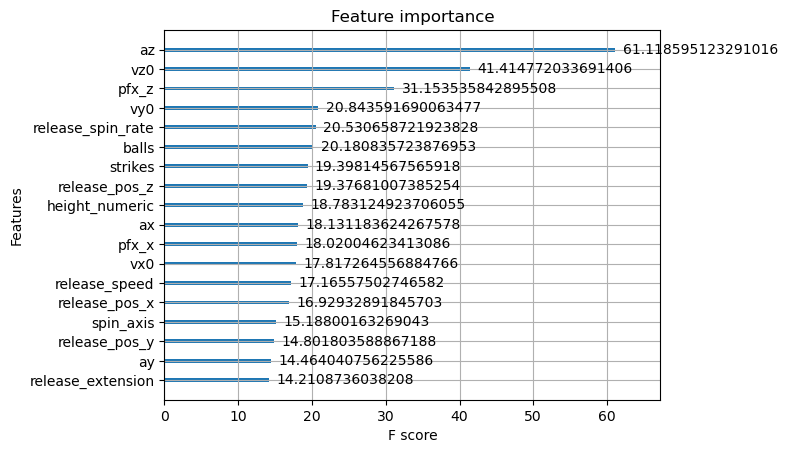

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

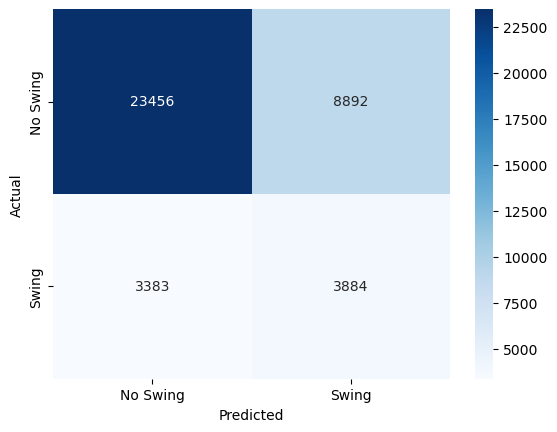

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xwhiff'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_24892\1564655570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xwhiff'] = y_pred


In [ ]:
testing_identifiers.head()

pitch_id_raw    xwhiff
0  663364_455139_617228_4_75_10  0.591023
1  663364_455139_617228_3_75_10  0.849261
2  663364_455139_617228_2_75_10  0.305858
3  663364_455139_617228_1_75_10  0.223801
5  663364_593428_605347_4_72_10  0.817324

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/whiff_2022&3_xwhiff.csv")